In [1]:
import panopticapi
from panopticapi.utils import id2rgb, rgb2id
import torchvision.transforms as T
import requests
import io
import matplotlib.pyplot as plt
import torch
import os
import torch.nn.functional as F
from PIL import Image
# Util function for loading point clouds|
import numpy as np
from tqdm import tqdm

# Data structures and functions for rendering
from pytorch3d.structures import Pointclouds
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVOrthographicCameras, 
    FoVPerspectiveCameras,
    PointsRasterizationSettings,
    PointsRenderer,
    PulsarPointsRenderer,
    PointsRasterizer,
    AlphaCompositor,
    NormWeightedCompositor
)

import pytorch3d

from midas_utils import midas
from detic_utils import detic

def process(depth_map, scale_factor=1, guidance=False):
    depth_map = torch.Tensor(depth_map).squeeze().unsqueeze(0)
    shape = [depth_map.shape[1] // scale_factor, depth_map.shape[2] // scale_factor]
    depth_map = torch.nn.functional.interpolate(depth_map.unsqueeze(1), size=shape, mode="bicubic", align_corners=False)
    depth_min = torch.amin(depth_map, dim=[1, 2, 3], keepdim=True)
    depth_max = torch.amax(depth_map, dim=[1, 2, 3], keepdim=True)
    depth_map = 2.0 * (depth_map - depth_min) / (depth_max - depth_min) - 1.0
    depth_map = torch.cat([depth_map] * 2) if guidance else depth_map
    return depth_map.cpu().squeeze().numpy() # TODO: check



Using cache found in /home/akirchme/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/akirchme/.cache/torch/hub/intel-isl_MiDaS_master
/home/akirchme/.conda/envs/diff2/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1666643003845/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Using "coco" vocabulary 
Resetting zs_weight datasets/metadata/coco_clip_a+cname.npy


In [2]:
import cv2
import numpy as np
import glob

def generate_video_from_imgs(output_file, imgs, size, fps):
    out = cv2.VideoWriter(output_file,cv2.VideoWriter_fourcc(*'mp4v'), fps, size)
    for img in imgs:
        out.write(cv2.cvtColor((255*img).astype('uint8'), cv2.COLOR_BGR2RGB))
    out.release()

In [12]:
resolution = 512
def render_pose(pixel_point_cloud, normals, elev = 0, azim = 0):
    R, T = look_at_view_transform(dist=2, elev=elev, azim=azim)
    #cameras = FoVPerspectiveCameras(device='cuda', R=R, T=T, znear=0.01)
    cameras = FoVOrthographicCameras(device='cuda', R=R, T=T, znear=0.01)
    
    raster_settings = PointsRasterizationSettings(
        image_size=resolution, 
        radius = 0.008,
        points_per_pixel = 10,
        bin_size = None
    )

    # Create a points renderer by compositing points using an weighted compositor (3D points are
    # weighted according to their distance to a pixel and accumulated using a weighted sum)
    renderer = PointsRenderer(
        rasterizer=PointsRasterizer(cameras=cameras, raster_settings=raster_settings),
        compositor=AlphaCompositor()#NormWeightedCompositor()
    )
    
    dist = 2
    theta, phi = elev, azim
    x = R.squeeze()@T.squeeze()
    n = (normals@x.cuda())
    z1 = (n >= np.cos(60 * np.pi/180)).float().mean()
    z2 = (n >= np.cos(95 * np.pi/180)).float().mean()
    if z1 <= 0.3 or z2 <= 0.52:
        print(z1, z2)
        pixel_point_cloud = Pointclouds(points=[torch.zeros((1,3)).cuda()], features=[torch.zeros((1,3)).cuda()])
    images = renderer(pixel_point_cloud)
    output = images[0, ..., :3].cpu().numpy()
    return output


#plt.axis("off");
#plt.imshow(render_pose(0, -75))
#plt.show()

In [13]:
from PIL import Image
import matplotlib.pyplot as plt


'''
Options
'''
do_mask = True
depth_mode = 'center_tau'
precompute_depth = False
show_feature = 'pixel' # ['pixel', 'depth']


'''
Load images
'''

def generate_video(image_fn, output_fn):
    image = np.array(Image.open(image_fn).convert('RGB'))
    if do_mask:
        mask_fg = detic(image, cls)
        image[~mask_fg] = 0
    else:
        mask = image.sum(axis=2) >= 0
    depth = midas(Image.fromarray(image, 'RGB'))
    if do_mask:
        depth[~mask_fg] = 0

    fig, axs = plt.subplots(1, 3)
    axs[0].imshow(image)
    axs[0].axis('off')
    axs[1].imshow(mask_fg)
    axs[1].axis('off')
    axs[2].imshow(depth)
    axs[2].axis('off')
    plt.show()
    
    depth_fg = depth[mask_fg]
    if depth_mode == 'center_tau':
        mu, tau = depth_fg.mean(), np.abs(depth_fg - depth_fg.mean()).max()
        depth = (depth-mu)/tau
    elif depth_mode == 'center_sigma':
        mu, sigma = depth_fg.mean(), depth_fg.std()
        depth = (depth-mu)/sigma
    elif depth_mode == 'min_max':
        mini = depth_fg.min()
        maxi = depth_fg.max()
        depth = 2*(depth - mini) / (maxi - mini) - 1
    elif depth_mode == 'normal':
        mu, sigma = depth_fg.mean(), depth_fg.std()
        depth = (depth - mu) / sigma

    # normalize depth without background
    # show depth
    # chairs: cubs, 
    # visualizations on rigid objects (chairs): generate videos for a few of them

    n, m = depth.shape
    idxs = np.argwhere(mask_fg)
    y, x = (idxs.min(axis=0) + idxs.max(axis=0))/2
    y, x = y/mask_fg.shape[0], x / mask_fg.shape[1]
    point_cloud = torch.Tensor([[[2*(j/m-x),-2*(i/n-y),depth[i,j]] for j in range(m)] for i in range(n)])[mask_fg].reshape((-1, 3)).cuda()
    pixel_features = torch.Tensor(image[mask_fg]).reshape(-1,3).cuda()/255
    depth_features = torch.Tensor(depth)[mask_fg].unsqueeze(-1).repeat((1,3)).cuda()
    pixel_point_cloud = Pointclouds(points=[point_cloud], features=[pixel_features])
    depth_point_cloud = Pointclouds(points=[point_cloud], features=[depth_features])

    point_cloud = pixel_point_cloud if show_feature == 'pixel' else depth_point_cloud
    normals = pytorch3d.ops.estimate_pointcloud_normals(point_cloud, neighborhood_size=100).squeeze()

    # fig = plot_scene({
    #     "pixel": {
    #         "object": pixel_point_cloud,
    #     },
    #     "depth": {
    #         "object": depth_point_cloud
    #     },

    # }, axis_args=AxisArgs(backgroundcolor="rgb(0,0,0)"), pointcloud_marker_size=0.5, ncols=2) # kwarg axis_args
    # fig.show()

    N = 600
    ampl = 60 # 75
    img_spiral = [render_pose(point_cloud, normals, elev=ampl*0.4*np.sin(2*np.pi*n/N+np.pi), azim=ampl*np.cos(2*np.pi*n/N+np.pi)) for n in tqdm(range(N), position=0, leave=True)]
    # create OpenCV video writer
    generate_video_from_imgs(output_fn, img_spiral, size=(resolution, resolution), fps=30)
    return point_cloud

/grogu/user/akirchme/art3d_sd_webui/images/horse/562.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/562.mp4


 58%|█████████████████████████████████████████▌                             | 351/600 [03:07<02:13,  1.87it/s]


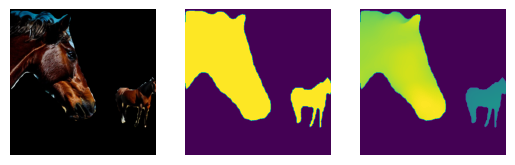

 40%|███████████████████████████▋                                          | 237/600 [00:02<00:03, 104.52it/s]

tensor(0.2997, device='cuda:0') tensor(0.5019, device='cuda:0')
tensor(0.2985, device='cuda:0') tensor(0.4954, device='cuda:0')
tensor(0.2918, device='cuda:0') tensor(0.4953, device='cuda:0')
tensor(0.2816, device='cuda:0') tensor(0.4952, device='cuda:0')
tensor(0.2637, device='cuda:0') tensor(0.4951, device='cuda:0')
tensor(0.2496, device='cuda:0') tensor(0.4951, device='cuda:0')
tensor(0.2334, device='cuda:0') tensor(0.4952, device='cuda:0')
tensor(0.2164, device='cuda:0') tensor(0.4956, device='cuda:0')
tensor(0.2014, device='cuda:0') tensor(0.4958, device='cuda:0')
tensor(0.2002, device='cuda:0') tensor(0.4961, device='cuda:0')
tensor(0.2001, device='cuda:0') tensor(0.4964, device='cuda:0')
tensor(0.1998, device='cuda:0') tensor(0.4966, device='cuda:0')
tensor(0.1997, device='cuda:0') tensor(0.4967, device='cuda:0')
tensor(0.1996, device='cuda:0') tensor(0.4969, device='cuda:0')
tensor(0.1995, device='cuda:0') tensor(0.4970, device='cuda:0')
tensor(0.1994, device='cuda:0') tensor(0

 44%|██████████████████████████████▌                                       | 262/600 [00:02<00:03, 112.38it/s]

tensor(0.1996, device='cuda:0') tensor(0.4959, device='cuda:0')
tensor(0.1997, device='cuda:0') tensor(0.4959, device='cuda:0')
tensor(0.1998, device='cuda:0') tensor(0.4960, device='cuda:0')
tensor(0.1998, device='cuda:0') tensor(0.4965, device='cuda:0')
tensor(0.1999, device='cuda:0') tensor(0.4978, device='cuda:0')
tensor(0.2001, device='cuda:0') tensor(0.5016, device='cuda:0')
tensor(0.2003, device='cuda:0') tensor(0.5071, device='cuda:0')
tensor(0.2004, device='cuda:0') tensor(0.5162, device='cuda:0')
tensor(0.2006, device='cuda:0') tensor(0.5220, device='cuda:0')
tensor(0.2007, device='cuda:0') tensor(0.5302, device='cuda:0')
tensor(0.2008, device='cuda:0') tensor(0.5380, device='cuda:0')
tensor(0.2009, device='cuda:0') tensor(0.5469, device='cuda:0')
tensor(0.2010, device='cuda:0') tensor(0.5569, device='cuda:0')
tensor(0.2012, device='cuda:0') tensor(0.5573, device='cuda:0')
tensor(0.2014, device='cuda:0') tensor(0.5572, device='cuda:0')
tensor(0.2016, device='cuda:0') tensor(0

 48%|█████████████████████████████████▎                                    | 286/600 [00:03<00:02, 115.38it/s]

tensor(0.2048, device='cuda:0') tensor(0.4812, device='cuda:0')
tensor(0.2052, device='cuda:0') tensor(0.4666, device='cuda:0')
tensor(0.2056, device='cuda:0') tensor(0.4603, device='cuda:0')
tensor(0.2061, device='cuda:0') tensor(0.4604, device='cuda:0')
tensor(0.2065, device='cuda:0') tensor(0.4604, device='cuda:0')
tensor(0.2068, device='cuda:0') tensor(0.4605, device='cuda:0')
tensor(0.2071, device='cuda:0') tensor(0.4606, device='cuda:0')
tensor(0.2074, device='cuda:0') tensor(0.4607, device='cuda:0')
tensor(0.2076, device='cuda:0') tensor(0.4607, device='cuda:0')
tensor(0.2079, device='cuda:0') tensor(0.4608, device='cuda:0')
tensor(0.2080, device='cuda:0') tensor(0.4609, device='cuda:0')
tensor(0.2083, device='cuda:0') tensor(0.4610, device='cuda:0')
tensor(0.2084, device='cuda:0') tensor(0.4610, device='cuda:0')
tensor(0.2085, device='cuda:0') tensor(0.4611, device='cuda:0')
tensor(0.2087, device='cuda:0') tensor(0.4611, device='cuda:0')
tensor(0.2088, device='cuda:0') tensor(0

 52%|████████████████████████████████████▏                                 | 310/600 [00:03<00:02, 117.15it/s]

tensor(0.2090, device='cuda:0') tensor(0.4615, device='cuda:0')
tensor(0.2090, device='cuda:0') tensor(0.4615, device='cuda:0')
tensor(0.2091, device='cuda:0') tensor(0.4616, device='cuda:0')
tensor(0.2091, device='cuda:0') tensor(0.4617, device='cuda:0')
tensor(0.2091, device='cuda:0') tensor(0.4617, device='cuda:0')
tensor(0.2092, device='cuda:0') tensor(0.4617, device='cuda:0')
tensor(0.2092, device='cuda:0') tensor(0.4618, device='cuda:0')
tensor(0.2092, device='cuda:0') tensor(0.4619, device='cuda:0')
tensor(0.2093, device='cuda:0') tensor(0.4619, device='cuda:0')
tensor(0.2094, device='cuda:0') tensor(0.4619, device='cuda:0')
tensor(0.2095, device='cuda:0') tensor(0.4619, device='cuda:0')
tensor(0.2098, device='cuda:0') tensor(0.4619, device='cuda:0')
tensor(0.2099, device='cuda:0') tensor(0.4621, device='cuda:0')
tensor(0.2099, device='cuda:0') tensor(0.4621, device='cuda:0')
tensor(0.2100, device='cuda:0') tensor(0.4621, device='cuda:0')
tensor(0.2102, device='cuda:0') tensor(0

 56%|███████████████████████████████████████                               | 335/600 [00:03<00:02, 118.40it/s]

tensor(0.2129, device='cuda:0') tensor(0.4623, device='cuda:0')
tensor(0.2134, device='cuda:0') tensor(0.4623, device='cuda:0')
tensor(0.2139, device='cuda:0') tensor(0.4623, device='cuda:0')
tensor(0.2144, device='cuda:0') tensor(0.4623, device='cuda:0')
tensor(0.2149, device='cuda:0') tensor(0.4623, device='cuda:0')
tensor(0.2152, device='cuda:0') tensor(0.4622, device='cuda:0')
tensor(0.2155, device='cuda:0') tensor(0.4623, device='cuda:0')
tensor(0.2158, device='cuda:0') tensor(0.4623, device='cuda:0')
tensor(0.2161, device='cuda:0') tensor(0.4623, device='cuda:0')
tensor(0.2166, device='cuda:0') tensor(0.4623, device='cuda:0')
tensor(0.2172, device='cuda:0') tensor(0.4623, device='cuda:0')
tensor(0.2175, device='cuda:0') tensor(0.4622, device='cuda:0')
tensor(0.2178, device='cuda:0') tensor(0.4621, device='cuda:0')
tensor(0.2179, device='cuda:0') tensor(0.4620, device='cuda:0')
tensor(0.2180, device='cuda:0') tensor(0.4620, device='cuda:0')
tensor(0.2177, device='cuda:0') tensor(0

 60%|█████████████████████████████████████████▉                            | 359/600 [00:03<00:02, 118.97it/s]

tensor(0.2114, device='cuda:0') tensor(0.7021, device='cuda:0')
tensor(0.2110, device='cuda:0') tensor(0.7086, device='cuda:0')
tensor(0.2105, device='cuda:0') tensor(0.7128, device='cuda:0')
tensor(0.2102, device='cuda:0') tensor(0.7143, device='cuda:0')
tensor(0.2099, device='cuda:0') tensor(0.7143, device='cuda:0')
tensor(0.2099, device='cuda:0') tensor(0.7143, device='cuda:0')
tensor(0.2098, device='cuda:0') tensor(0.7143, device='cuda:0')
tensor(0.2098, device='cuda:0') tensor(0.7142, device='cuda:0')
tensor(0.2098, device='cuda:0') tensor(0.7141, device='cuda:0')
tensor(0.2097, device='cuda:0') tensor(0.6995, device='cuda:0')
tensor(0.2097, device='cuda:0') tensor(0.6389, device='cuda:0')
tensor(0.2096, device='cuda:0') tensor(0.5925, device='cuda:0')
tensor(0.2095, device='cuda:0') tensor(0.5684, device='cuda:0')
tensor(0.2093, device='cuda:0') tensor(0.5573, device='cuda:0')
tensor(0.2091, device='cuda:0') tensor(0.5541, device='cuda:0')
tensor(0.2091, device='cuda:0') tensor(0

 64%|████████████████████████████████████████████▋                         | 383/600 [00:03<00:01, 115.00it/s]

tensor(0.2087, device='cuda:0') tensor(0.5490, device='cuda:0')
tensor(0.2086, device='cuda:0') tensor(0.5492, device='cuda:0')
tensor(0.2086, device='cuda:0') tensor(0.5493, device='cuda:0')
tensor(0.2086, device='cuda:0') tensor(0.5495, device='cuda:0')
tensor(0.2086, device='cuda:0') tensor(0.5495, device='cuda:0')
tensor(0.2086, device='cuda:0') tensor(0.5496, device='cuda:0')
tensor(0.2086, device='cuda:0') tensor(0.5498, device='cuda:0')
tensor(0.2086, device='cuda:0') tensor(0.5500, device='cuda:0')
tensor(0.2086, device='cuda:0') tensor(0.5502, device='cuda:0')
tensor(0.2085, device='cuda:0') tensor(0.5503, device='cuda:0')
tensor(0.2085, device='cuda:0') tensor(0.5504, device='cuda:0')
tensor(0.2084, device='cuda:0') tensor(0.5501, device='cuda:0')
tensor(0.2084, device='cuda:0') tensor(0.5498, device='cuda:0')
tensor(0.2101, device='cuda:0') tensor(0.5493, device='cuda:0')
tensor(0.2483, device='cuda:0') tensor(0.5489, device='cuda:0')


100%|███████████████████████████████████████████████████████████████████████| 600/600 [00:06<00:00, 95.26it/s]


/grogu/user/akirchme/art3d_sd_webui/images/horse/910.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/910.mp4


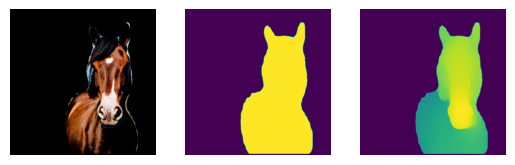

 40%|████████████████████████████                                          | 241/600 [00:02<00:03, 104.23it/s]

tensor(0.2986, device='cuda:0') tensor(0.5281, device='cuda:0')
tensor(0.2921, device='cuda:0') tensor(0.5298, device='cuda:0')
tensor(0.2859, device='cuda:0') tensor(0.5306, device='cuda:0')
tensor(0.2784, device='cuda:0') tensor(0.5317, device='cuda:0')
tensor(0.2777, device='cuda:0') tensor(0.5323, device='cuda:0')
tensor(0.2773, device='cuda:0') tensor(0.5330, device='cuda:0')
tensor(0.2767, device='cuda:0') tensor(0.5324, device='cuda:0')
tensor(0.2764, device='cuda:0') tensor(0.5314, device='cuda:0')
tensor(0.2761, device='cuda:0') tensor(0.5303, device='cuda:0')
tensor(0.2757, device='cuda:0') tensor(0.5288, device='cuda:0')
tensor(0.2754, device='cuda:0') tensor(0.5272, device='cuda:0')
tensor(0.2750, device='cuda:0') tensor(0.5257, device='cuda:0')
tensor(0.2743, device='cuda:0') tensor(0.5237, device='cuda:0')
tensor(0.2740, device='cuda:0') tensor(0.5218, device='cuda:0')
tensor(0.2738, device='cuda:0') tensor(0.5205, device='cuda:0')
tensor(0.2733, device='cuda:0') tensor(0

 44%|██████████████████████████████▉                                       | 265/600 [00:02<00:02, 111.88it/s]

tensor(0.2804, device='cuda:0') tensor(0.5245, device='cuda:0')
tensor(0.2824, device='cuda:0') tensor(0.5259, device='cuda:0')
tensor(0.2840, device='cuda:0') tensor(0.5273, device='cuda:0')
tensor(0.2858, device='cuda:0') tensor(0.5298, device='cuda:0')
tensor(0.2874, device='cuda:0') tensor(0.5333, device='cuda:0')
tensor(0.2890, device='cuda:0') tensor(0.5349, device='cuda:0')
tensor(0.2902, device='cuda:0') tensor(0.5363, device='cuda:0')
tensor(0.2916, device='cuda:0') tensor(0.5364, device='cuda:0')
tensor(0.2927, device='cuda:0') tensor(0.5354, device='cuda:0')
tensor(0.2939, device='cuda:0') tensor(0.5343, device='cuda:0')
tensor(0.2947, device='cuda:0') tensor(0.5333, device='cuda:0')
tensor(0.2956, device='cuda:0') tensor(0.5318, device='cuda:0')
tensor(0.2971, device='cuda:0') tensor(0.5305, device='cuda:0')
tensor(0.2982, device='cuda:0') tensor(0.5277, device='cuda:0')
tensor(0.2998, device='cuda:0') tensor(0.5222, device='cuda:0')
tensor(0.3016, device='cuda:0') tensor(0

 48%|█████████████████████████████████▋                                    | 289/600 [00:03<00:02, 115.76it/s]

tensor(0.3216, device='cuda:0') tensor(0.4853, device='cuda:0')
tensor(0.3230, device='cuda:0') tensor(0.4852, device='cuda:0')
tensor(0.3239, device='cuda:0') tensor(0.4851, device='cuda:0')
tensor(0.3249, device='cuda:0') tensor(0.4851, device='cuda:0')
tensor(0.3255, device='cuda:0') tensor(0.4855, device='cuda:0')
tensor(0.3259, device='cuda:0') tensor(0.4853, device='cuda:0')
tensor(0.3262, device='cuda:0') tensor(0.4852, device='cuda:0')
tensor(0.3262, device='cuda:0') tensor(0.4849, device='cuda:0')
tensor(0.3260, device='cuda:0') tensor(0.4848, device='cuda:0')
tensor(0.3258, device='cuda:0') tensor(0.4848, device='cuda:0')
tensor(0.3251, device='cuda:0') tensor(0.4848, device='cuda:0')
tensor(0.3246, device='cuda:0') tensor(0.4846, device='cuda:0')
tensor(0.3231, device='cuda:0') tensor(0.4846, device='cuda:0')
tensor(0.3220, device='cuda:0') tensor(0.4845, device='cuda:0')
tensor(0.3211, device='cuda:0') tensor(0.4845, device='cuda:0')
tensor(0.3208, device='cuda:0') tensor(0

 52%|████████████████████████████████████▌                                 | 313/600 [00:03<00:02, 117.71it/s]

tensor(0.4831, device='cuda:0')
tensor(0.3218, device='cuda:0') tensor(0.4830, device='cuda:0')
tensor(0.3216, device='cuda:0') tensor(0.4829, device='cuda:0')
tensor(0.3215, device='cuda:0') tensor(0.4828, device='cuda:0')
tensor(0.3211, device='cuda:0') tensor(0.4829, device='cuda:0')
tensor(0.3207, device='cuda:0') tensor(0.4828, device='cuda:0')
tensor(0.3201, device='cuda:0') tensor(0.4828, device='cuda:0')
tensor(0.3193, device='cuda:0') tensor(0.4828, device='cuda:0')
tensor(0.3183, device='cuda:0') tensor(0.4828, device='cuda:0')
tensor(0.3176, device='cuda:0') tensor(0.4828, device='cuda:0')
tensor(0.3172, device='cuda:0') tensor(0.4829, device='cuda:0')
tensor(0.3168, device='cuda:0') tensor(0.4828, device='cuda:0')
tensor(0.3163, device='cuda:0') tensor(0.4828, device='cuda:0')
tensor(0.3160, device='cuda:0') tensor(0.4829, device='cuda:0')
tensor(0.3156, device='cuda:0') tensor(0.4829, device='cuda:0')
tensor(0.3152, device='cuda:0') tensor(0.4830, device='cuda:0')
tensor(0

 56%|███████████████████████████████████████▎                              | 337/600 [00:03<00:02, 118.50it/s]

tensor(0.4839, device='cuda:0')
tensor(0.3191, device='cuda:0') tensor(0.4841, device='cuda:0')
tensor(0.3190, device='cuda:0') tensor(0.4843, device='cuda:0')
tensor(0.3189, device='cuda:0') tensor(0.4844, device='cuda:0')
tensor(0.3185, device='cuda:0') tensor(0.4846, device='cuda:0')
tensor(0.3181, device='cuda:0') tensor(0.4848, device='cuda:0')
tensor(0.3176, device='cuda:0') tensor(0.4851, device='cuda:0')
tensor(0.3170, device='cuda:0') tensor(0.4854, device='cuda:0')
tensor(0.3164, device='cuda:0') tensor(0.4856, device='cuda:0')
tensor(0.3158, device='cuda:0') tensor(0.4860, device='cuda:0')
tensor(0.3153, device='cuda:0') tensor(0.4867, device='cuda:0')
tensor(0.3147, device='cuda:0') tensor(0.4873, device='cuda:0')
tensor(0.3142, device='cuda:0') tensor(0.4879, device='cuda:0')
tensor(0.3134, device='cuda:0') tensor(0.4883, device='cuda:0')
tensor(0.3126, device='cuda:0') tensor(0.4908, device='cuda:0')
tensor(0.3116, device='cuda:0') tensor(0.4958, device='cuda:0')
tensor(0

 60%|██████████████████████████████████████████                            | 361/600 [00:03<00:02, 116.63it/s]

tensor(0.5915, device='cuda:0')
tensor(0.2933, device='cuda:0') tensor(0.5923, device='cuda:0')
tensor(0.2913, device='cuda:0') tensor(0.5933, device='cuda:0')
tensor(0.2896, device='cuda:0') tensor(0.5945, device='cuda:0')
tensor(0.2881, device='cuda:0') tensor(0.5962, device='cuda:0')
tensor(0.2868, device='cuda:0') tensor(0.5984, device='cuda:0')
tensor(0.2854, device='cuda:0') tensor(0.5982, device='cuda:0')
tensor(0.2845, device='cuda:0') tensor(0.5970, device='cuda:0')
tensor(0.2832, device='cuda:0') tensor(0.5933, device='cuda:0')
tensor(0.2821, device='cuda:0') tensor(0.5874, device='cuda:0')
tensor(0.2807, device='cuda:0') tensor(0.5798, device='cuda:0')
tensor(0.2795, device='cuda:0') tensor(0.5705, device='cuda:0')
tensor(0.2782, device='cuda:0') tensor(0.5594, device='cuda:0')
tensor(0.2771, device='cuda:0') tensor(0.5492, device='cuda:0')
tensor(0.2760, device='cuda:0') tensor(0.5488, device='cuda:0')
tensor(0.2748, device='cuda:0') tensor(0.5484, device='cuda:0')
tensor(0

 64%|████████████████████████████████████████████▉                         | 385/600 [00:03<00:01, 114.22it/s]

tensor(0.2697, device='cuda:0') tensor(0.5444, device='cuda:0')
tensor(0.2695, device='cuda:0') tensor(0.5453, device='cuda:0')
tensor(0.2694, device='cuda:0') tensor(0.5462, device='cuda:0')
tensor(0.2692, device='cuda:0') tensor(0.5468, device='cuda:0')
tensor(0.2692, device='cuda:0') tensor(0.5475, device='cuda:0')
tensor(0.2690, device='cuda:0') tensor(0.5484, device='cuda:0')
tensor(0.2691, device='cuda:0') tensor(0.5494, device='cuda:0')
tensor(0.2692, device='cuda:0') tensor(0.5505, device='cuda:0')
tensor(0.2695, device='cuda:0') tensor(0.5513, device='cuda:0')
tensor(0.2696, device='cuda:0') tensor(0.5519, device='cuda:0')
tensor(0.2699, device='cuda:0') tensor(0.5517, device='cuda:0')
tensor(0.2754, device='cuda:0') tensor(0.5516, device='cuda:0')
tensor(0.2845, device='cuda:0') tensor(0.5513, device='cuda:0')
tensor(0.2992, device='cuda:0') tensor(0.5511, device='cuda:0')


100%|███████████████████████████████████████████████████████████████████████| 600/600 [00:06<00:00, 94.74it/s]


/grogu/user/akirchme/art3d_sd_webui/images/horse/1586.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/1586.mp4


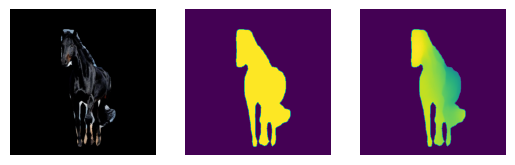

  4%|██▊                                                                    | 24/600 [00:00<00:04, 118.46it/s]

tensor(0.3293, device='cuda:0') tensor(0.4386, device='cuda:0')
tensor(0.3292, device='cuda:0') tensor(0.4387, device='cuda:0')
tensor(0.3289, device='cuda:0') tensor(0.4388, device='cuda:0')
tensor(0.3287, device='cuda:0') tensor(0.4387, device='cuda:0')
tensor(0.3279, device='cuda:0') tensor(0.4386, device='cuda:0')
tensor(0.3273, device='cuda:0') tensor(0.4385, device='cuda:0')
tensor(0.3271, device='cuda:0') tensor(0.4387, device='cuda:0')
tensor(0.3267, device='cuda:0') tensor(0.4387, device='cuda:0')
tensor(0.3263, device='cuda:0') tensor(0.4387, device='cuda:0')
tensor(0.3262, device='cuda:0') tensor(0.4389, device='cuda:0')
tensor(0.3259, device='cuda:0') tensor(0.4390, device='cuda:0')
tensor(0.3257, device='cuda:0') tensor(0.4388, device='cuda:0')
tensor(0.3252, device='cuda:0') tensor(0.4387, device='cuda:0')
tensor(0.3251, device='cuda:0') tensor(0.4387, device='cuda:0')
tensor(0.3249, device='cuda:0') tensor(0.4386, device='cuda:0')
tensor(0.3246, device='cuda:0') tensor(0

  8%|█████▋                                                                 | 48/600 [00:00<00:04, 118.61it/s]

tensor(0.3240, device='cuda:0') tensor(0.4385, device='cuda:0')
tensor(0.3238, device='cuda:0') tensor(0.4382, device='cuda:0')
tensor(0.3234, device='cuda:0') tensor(0.4380, device='cuda:0')
tensor(0.3229, device='cuda:0') tensor(0.4382, device='cuda:0')
tensor(0.3223, device='cuda:0') tensor(0.4382, device='cuda:0')
tensor(0.3215, device='cuda:0') tensor(0.4382, device='cuda:0')
tensor(0.3205, device='cuda:0') tensor(0.4382, device='cuda:0')
tensor(0.3197, device='cuda:0') tensor(0.4384, device='cuda:0')
tensor(0.3185, device='cuda:0') tensor(0.4386, device='cuda:0')
tensor(0.3175, device='cuda:0') tensor(0.4405, device='cuda:0')
tensor(0.3169, device='cuda:0') tensor(0.4436, device='cuda:0')
tensor(0.3158, device='cuda:0') tensor(0.4472, device='cuda:0')
tensor(0.3148, device='cuda:0') tensor(0.4516, device='cuda:0')
tensor(0.3137, device='cuda:0') tensor(0.4558, device='cuda:0')
tensor(0.3129, device='cuda:0') tensor(0.4608, device='cuda:0')
tensor(0.3119, device='cuda:0') tensor(0

 12%|████████▌                                                              | 72/600 [00:00<00:04, 118.96it/s]

tensor(0.3051, device='cuda:0') tensor(0.4814, device='cuda:0')
tensor(0.3041, device='cuda:0') tensor(0.4821, device='cuda:0')
tensor(0.3033, device='cuda:0') tensor(0.4815, device='cuda:0')
tensor(0.3025, device='cuda:0') tensor(0.4808, device='cuda:0')
tensor(0.3016, device='cuda:0') tensor(0.4792, device='cuda:0')
tensor(0.3008, device='cuda:0') tensor(0.4787, device='cuda:0')
tensor(0.3000, device='cuda:0') tensor(0.4785, device='cuda:0')
tensor(0.2994, device='cuda:0') tensor(0.4788, device='cuda:0')
tensor(0.2992, device='cuda:0') tensor(0.4797, device='cuda:0')
tensor(0.2986, device='cuda:0') tensor(0.4816, device='cuda:0')
tensor(0.2978, device='cuda:0') tensor(0.4832, device='cuda:0')
tensor(0.2974, device='cuda:0') tensor(0.4846, device='cuda:0')
tensor(0.2968, device='cuda:0') tensor(0.4851, device='cuda:0')
tensor(0.2962, device='cuda:0') tensor(0.4849, device='cuda:0')
tensor(0.2955, device='cuda:0') tensor(0.4858, device='cuda:0')
tensor(0.2954, device='cuda:0') tensor(0

 14%|█████████▉                                                             | 84/600 [00:00<00:04, 118.68it/s]

tensor(0.2912, device='cuda:0') tensor(0.4946, device='cuda:0')
tensor(0.2909, device='cuda:0') tensor(0.4948, device='cuda:0')
tensor(0.2904, device='cuda:0') tensor(0.4956, device='cuda:0')
tensor(0.2894, device='cuda:0') tensor(0.4959, device='cuda:0')
tensor(0.2888, device='cuda:0') tensor(0.4961, device='cuda:0')
tensor(0.2921, device='cuda:0') tensor(0.4960, device='cuda:0')
tensor(0.2968, device='cuda:0') tensor(0.4960, device='cuda:0')
tensor(0.3028, device='cuda:0') tensor(0.4963, device='cuda:0')
tensor(0.3092, device='cuda:0') tensor(0.4960, device='cuda:0')
tensor(0.3176, device='cuda:0') tensor(0.4963, device='cuda:0')
tensor(0.3234, device='cuda:0') tensor(0.4961, device='cuda:0')
tensor(0.3261, device='cuda:0') tensor(0.4958, device='cuda:0')
tensor(0.3275, device='cuda:0') tensor(0.4965, device='cuda:0')
tensor(0.3289, device='cuda:0') tensor(0.4973, device='cuda:0')
tensor(0.3301, device='cuda:0') tensor(0.5000, device='cuda:0')
tensor(0.3320, device='cuda:0') tensor(0

 22%|███████████████▌                                                      | 133/600 [00:01<00:04, 116.47it/s]

tensor(0.3990, device='cuda:0') tensor(0.5197, device='cuda:0')
tensor(0.3991, device='cuda:0') tensor(0.5192, device='cuda:0')
tensor(0.3990, device='cuda:0') tensor(0.5184, device='cuda:0')
tensor(0.3987, device='cuda:0') tensor(0.5181, device='cuda:0')
tensor(0.3985, device='cuda:0') tensor(0.5177, device='cuda:0')
tensor(0.3982, device='cuda:0') tensor(0.5174, device='cuda:0')
tensor(0.3975, device='cuda:0') tensor(0.5172, device='cuda:0')
tensor(0.3965, device='cuda:0') tensor(0.5173, device='cuda:0')
tensor(0.3956, device='cuda:0') tensor(0.5173, device='cuda:0')
tensor(0.3948, device='cuda:0') tensor(0.5175, device='cuda:0')
tensor(0.3942, device='cuda:0') tensor(0.5175, device='cuda:0')
tensor(0.3933, device='cuda:0') tensor(0.5174, device='cuda:0')
tensor(0.3922, device='cuda:0') tensor(0.5173, device='cuda:0')
tensor(0.3912, device='cuda:0') tensor(0.5173, device='cuda:0')
tensor(0.3901, device='cuda:0') tensor(0.5173, device='cuda:0')
tensor(0.3894, device='cuda:0') tensor(0

 87%|█████████████████████████████████████████████████████████████         | 523/600 [00:04<00:00, 118.54it/s]

tensor(0.3786, device='cuda:0') tensor(0.5186, device='cuda:0')
tensor(0.3764, device='cuda:0') tensor(0.5147, device='cuda:0')
tensor(0.3747, device='cuda:0') tensor(0.5106, device='cuda:0')
tensor(0.3719, device='cuda:0') tensor(0.5075, device='cuda:0')
tensor(0.3702, device='cuda:0') tensor(0.5053, device='cuda:0')
tensor(0.3694, device='cuda:0') tensor(0.5033, device='cuda:0')
tensor(0.3691, device='cuda:0') tensor(0.5012, device='cuda:0')
tensor(0.3684, device='cuda:0') tensor(0.4993, device='cuda:0')
tensor(0.3680, device='cuda:0') tensor(0.4990, device='cuda:0')
tensor(0.3616, device='cuda:0') tensor(0.4997, device='cuda:0')
tensor(0.3452, device='cuda:0') tensor(0.5005, device='cuda:0')
tensor(0.3297, device='cuda:0') tensor(0.5009, device='cuda:0')
tensor(0.3158, device='cuda:0') tensor(0.5008, device='cuda:0')
tensor(0.3034, device='cuda:0') tensor(0.5013, device='cuda:0')
tensor(0.2951, device='cuda:0') tensor(0.5017, device='cuda:0')
tensor(0.2901, device='cuda:0') tensor(0

 91%|███████████████████████████████████████████████████████████████▊      | 547/600 [00:04<00:00, 118.55it/s]

tensor(0.2925, device='cuda:0') tensor(0.5017, device='cuda:0')
tensor(0.2926, device='cuda:0') tensor(0.5020, device='cuda:0')
tensor(0.2928, device='cuda:0') tensor(0.5020, device='cuda:0')
tensor(0.2932, device='cuda:0') tensor(0.5020, device='cuda:0')
tensor(0.2937, device='cuda:0') tensor(0.5017, device='cuda:0')
tensor(0.2941, device='cuda:0') tensor(0.5010, device='cuda:0')
tensor(0.2943, device='cuda:0') tensor(0.5006, device='cuda:0')
tensor(0.2947, device='cuda:0') tensor(0.5001, device='cuda:0')
tensor(0.2951, device='cuda:0') tensor(0.4993, device='cuda:0')
tensor(0.2955, device='cuda:0') tensor(0.4984, device='cuda:0')
tensor(0.2958, device='cuda:0') tensor(0.4970, device='cuda:0')
tensor(0.2963, device='cuda:0') tensor(0.4961, device='cuda:0')
tensor(0.2967, device='cuda:0') tensor(0.4952, device='cuda:0')
tensor(0.2975, device='cuda:0') tensor(0.4980, device='cuda:0')
tensor(0.2989, device='cuda:0') tensor(0.5054, device='cuda:0')
tensor(0.2998, device='cuda:0') tensor(0

 95%|██████████████████████████████████████████████████████████████████▌   | 571/600 [00:04<00:00, 118.55it/s]

tensor(0.3068, device='cuda:0') tensor(0.5185, device='cuda:0')
tensor(0.3077, device='cuda:0') tensor(0.5176, device='cuda:0')
tensor(0.3083, device='cuda:0') tensor(0.5135, device='cuda:0')
tensor(0.3094, device='cuda:0') tensor(0.5023, device='cuda:0')
tensor(0.3106, device='cuda:0') tensor(0.4903, device='cuda:0')
tensor(0.3118, device='cuda:0') tensor(0.4796, device='cuda:0')
tensor(0.3128, device='cuda:0') tensor(0.4690, device='cuda:0')
tensor(0.3139, device='cuda:0') tensor(0.4599, device='cuda:0')
tensor(0.3148, device='cuda:0') tensor(0.4516, device='cuda:0')
tensor(0.3159, device='cuda:0') tensor(0.4456, device='cuda:0')
tensor(0.3165, device='cuda:0') tensor(0.4408, device='cuda:0')
tensor(0.3173, device='cuda:0') tensor(0.4391, device='cuda:0')
tensor(0.3180, device='cuda:0') tensor(0.4389, device='cuda:0')
tensor(0.3184, device='cuda:0') tensor(0.4387, device='cuda:0')
tensor(0.3192, device='cuda:0') tensor(0.4387, device='cuda:0')
tensor(0.3195, device='cuda:0') tensor(0

100%|██████████████████████████████████████████████████████████████████████| 600/600 [00:04<00:00, 121.99it/s]

tensor(0.3250, device='cuda:0') tensor(0.4381, device='cuda:0')
tensor(0.3253, device='cuda:0') tensor(0.4382, device='cuda:0')
tensor(0.3258, device='cuda:0') tensor(0.4381, device='cuda:0')
tensor(0.3261, device='cuda:0') tensor(0.4381, device='cuda:0')
tensor(0.3263, device='cuda:0') tensor(0.4382, device='cuda:0')
tensor(0.3265, device='cuda:0') tensor(0.4383, device='cuda:0')
tensor(0.3269, device='cuda:0') tensor(0.4382, device='cuda:0')
tensor(0.3271, device='cuda:0') tensor(0.4382, device='cuda:0')
tensor(0.3272, device='cuda:0') tensor(0.4383, device='cuda:0')
tensor(0.3276, device='cuda:0') tensor(0.4382, device='cuda:0')
tensor(0.3277, device='cuda:0') tensor(0.4382, device='cuda:0')
tensor(0.3280, device='cuda:0') tensor(0.4382, device='cuda:0')
tensor(0.3286, device='cuda:0') tensor(0.4382, device='cuda:0')
tensor(0.3286, device='cuda:0') tensor(0.4382, device='cuda:0')
tensor(0.3290, device='cuda:0') tensor(0.4383, device='cuda:0')
tensor(0.3292, device='cuda:0') tensor(0

/grogu/user/akirchme/art3d_sd_webui/images/horse/1221.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/1221.mp4


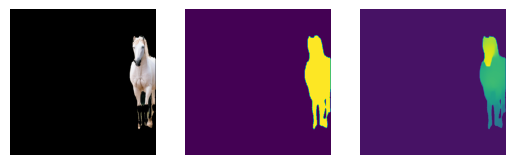

  2%|█▍                                                                     | 12/600 [00:00<00:05, 115.50it/s]

tensor(0.3460, device='cuda:0') tensor(0.5190, device='cuda:0')
tensor(0.3461, device='cuda:0') tensor(0.5191, device='cuda:0')
tensor(0.3461, device='cuda:0') tensor(0.5191, device='cuda:0')
tensor(0.3463, device='cuda:0') tensor(0.5193, device='cuda:0')
tensor(0.3462, device='cuda:0') tensor(0.5194, device='cuda:0')
tensor(0.3457, device='cuda:0') tensor(0.5192, device='cuda:0')
tensor(0.3455, device='cuda:0') tensor(0.5193, device='cuda:0')
tensor(0.3454, device='cuda:0') tensor(0.5192, device='cuda:0')
tensor(0.3454, device='cuda:0') tensor(0.5189, device='cuda:0')
tensor(0.3458, device='cuda:0') tensor(0.5189, device='cuda:0')
tensor(0.3459, device='cuda:0') tensor(0.5187, device='cuda:0')
tensor(0.3460, device='cuda:0') tensor(0.5187, device='cuda:0')
tensor(0.3462, device='cuda:0') tensor(0.5184, device='cuda:0')
tensor(0.3463, device='cuda:0') tensor(0.5183, device='cuda:0')
tensor(0.3469, device='cuda:0') tensor(0.5179, device='cuda:0')
tensor(0.3470, device='cuda:0') tensor(0

  6%|████▍                                                                  | 37/600 [00:00<00:04, 119.48it/s]

tensor(0.3506, device='cuda:0') tensor(0.5159, device='cuda:0')
tensor(0.3508, device='cuda:0') tensor(0.5156, device='cuda:0')
tensor(0.3510, device='cuda:0') tensor(0.5156, device='cuda:0')
tensor(0.3510, device='cuda:0') tensor(0.5153, device='cuda:0')
tensor(0.3510, device='cuda:0') tensor(0.5153, device='cuda:0')
tensor(0.3507, device='cuda:0') tensor(0.5154, device='cuda:0')
tensor(0.3507, device='cuda:0') tensor(0.5154, device='cuda:0')
tensor(0.3508, device='cuda:0') tensor(0.5153, device='cuda:0')
tensor(0.3504, device='cuda:0') tensor(0.5154, device='cuda:0')
tensor(0.3503, device='cuda:0') tensor(0.5172, device='cuda:0')


 48%|█████████████████████████████████▍                                    | 287/600 [00:02<00:02, 126.10it/s]

tensor(0.3498, device='cuda:0') tensor(0.5130, device='cuda:0')
tensor(0.3511, device='cuda:0') tensor(0.5062, device='cuda:0')
tensor(0.3517, device='cuda:0') tensor(0.5014, device='cuda:0')
tensor(0.3526, device='cuda:0') tensor(0.4994, device='cuda:0')
tensor(0.3534, device='cuda:0') tensor(0.4992, device='cuda:0')
tensor(0.3536, device='cuda:0') tensor(0.4995, device='cuda:0')
tensor(0.3541, device='cuda:0') tensor(0.4995, device='cuda:0')
tensor(0.3543, device='cuda:0') tensor(0.4995, device='cuda:0')
tensor(0.3546, device='cuda:0') tensor(0.4994, device='cuda:0')
tensor(0.3549, device='cuda:0') tensor(0.4992, device='cuda:0')
tensor(0.3548, device='cuda:0') tensor(0.4991, device='cuda:0')
tensor(0.3547, device='cuda:0') tensor(0.4989, device='cuda:0')
tensor(0.3542, device='cuda:0') tensor(0.4989, device='cuda:0')
tensor(0.3536, device='cuda:0') tensor(0.4988, device='cuda:0')
tensor(0.3527, device='cuda:0') tensor(0.4989, device='cuda:0')
tensor(0.3523, device='cuda:0') tensor(0

 52%|████████████████████████████████████▌                                 | 313/600 [00:02<00:02, 122.65it/s]

tensor(0.3426, device='cuda:0') tensor(0.4990, device='cuda:0')
tensor(0.3422, device='cuda:0') tensor(0.4988, device='cuda:0')
tensor(0.3417, device='cuda:0') tensor(0.4984, device='cuda:0')
tensor(0.3412, device='cuda:0') tensor(0.4986, device='cuda:0')
tensor(0.3412, device='cuda:0') tensor(0.4984, device='cuda:0')
tensor(0.3412, device='cuda:0') tensor(0.4985, device='cuda:0')
tensor(0.3410, device='cuda:0') tensor(0.4984, device='cuda:0')
tensor(0.3405, device='cuda:0') tensor(0.4985, device='cuda:0')
tensor(0.3400, device='cuda:0') tensor(0.4987, device='cuda:0')
tensor(0.3393, device='cuda:0') tensor(0.4985, device='cuda:0')
tensor(0.3390, device='cuda:0') tensor(0.4985, device='cuda:0')
tensor(0.3384, device='cuda:0') tensor(0.4985, device='cuda:0')
tensor(0.3378, device='cuda:0') tensor(0.4984, device='cuda:0')
tensor(0.3369, device='cuda:0') tensor(0.4986, device='cuda:0')
tensor(0.3359, device='cuda:0') tensor(0.4988, device='cuda:0')
tensor(0.3355, device='cuda:0') tensor(0

 56%|███████████████████████████████████████▌                              | 339/600 [00:02<00:02, 122.13it/s]

tensor(0.3345, device='cuda:0') tensor(0.4988, device='cuda:0')
tensor(0.3348, device='cuda:0') tensor(0.4988, device='cuda:0')
tensor(0.3346, device='cuda:0') tensor(0.4988, device='cuda:0')
tensor(0.3347, device='cuda:0') tensor(0.4989, device='cuda:0')
tensor(0.3347, device='cuda:0') tensor(0.4987, device='cuda:0')
tensor(0.3348, device='cuda:0') tensor(0.4985, device='cuda:0')
tensor(0.3352, device='cuda:0') tensor(0.4984, device='cuda:0')
tensor(0.3357, device='cuda:0') tensor(0.4985, device='cuda:0')
tensor(0.3357, device='cuda:0') tensor(0.4982, device='cuda:0')
tensor(0.3359, device='cuda:0') tensor(0.4983, device='cuda:0')
tensor(0.3359, device='cuda:0') tensor(0.4983, device='cuda:0')
tensor(0.3358, device='cuda:0') tensor(0.4984, device='cuda:0')
tensor(0.3357, device='cuda:0') tensor(0.4984, device='cuda:0')
tensor(0.3360, device='cuda:0') tensor(0.4985, device='cuda:0')
tensor(0.3357, device='cuda:0') tensor(0.4983, device='cuda:0')
tensor(0.3358, device='cuda:0') tensor(0

 98%|████████████████████████████████████████████████████████████████████▉ | 591/600 [00:04<00:00, 126.88it/s]

tensor(0.3500, device='cuda:0') tensor(0.5200, device='cuda:0')
tensor(0.3507, device='cuda:0') tensor(0.5196, device='cuda:0')
tensor(0.3514, device='cuda:0') tensor(0.5196, device='cuda:0')
tensor(0.3521, device='cuda:0') tensor(0.5198, device='cuda:0')
tensor(0.3526, device='cuda:0') tensor(0.5197, device='cuda:0')
tensor(0.3527, device='cuda:0') tensor(0.5197, device='cuda:0')
tensor(0.3527, device='cuda:0') tensor(0.5196, device='cuda:0')
tensor(0.3528, device='cuda:0') tensor(0.5194, device='cuda:0')
tensor(0.3526, device='cuda:0') tensor(0.5196, device='cuda:0')
tensor(0.3526, device='cuda:0') tensor(0.5195, device='cuda:0')
tensor(0.3525, device='cuda:0') tensor(0.5195, device='cuda:0')
tensor(0.3521, device='cuda:0') tensor(0.5197, device='cuda:0')
tensor(0.3515, device='cuda:0') tensor(0.5194, device='cuda:0')
tensor(0.3511, device='cuda:0') tensor(0.5194, device='cuda:0')
tensor(0.3502, device='cuda:0') tensor(0.5192, device='cuda:0')
tensor(0.3501, device='cuda:0') tensor(0

100%|██████████████████████████████████████████████████████████████████████| 600/600 [00:04<00:00, 129.17it/s]


tensor(0.3470, device='cuda:0') tensor(0.5186, device='cuda:0')
tensor(0.3468, device='cuda:0') tensor(0.5186, device='cuda:0')
tensor(0.3467, device='cuda:0') tensor(0.5187, device='cuda:0')
tensor(0.3465, device='cuda:0') tensor(0.5186, device='cuda:0')
tensor(0.3461, device='cuda:0') tensor(0.5187, device='cuda:0')
tensor(0.3462, device='cuda:0') tensor(0.5188, device='cuda:0')
tensor(0.3462, device='cuda:0') tensor(0.5190, device='cuda:0')
/grogu/user/akirchme/art3d_sd_webui/images/horse/103.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/103.mp4


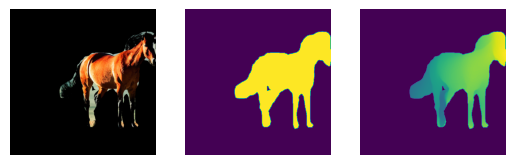

 39%|███████████████████████████                                           | 232/600 [00:02<00:03, 117.37it/s]

tensor(0.2932, device='cuda:0') tensor(0.5342, device='cuda:0')
tensor(0.2775, device='cuda:0') tensor(0.5366, device='cuda:0')
tensor(0.2641, device='cuda:0') tensor(0.5391, device='cuda:0')
tensor(0.2523, device='cuda:0') tensor(0.5421, device='cuda:0')
tensor(0.2432, device='cuda:0') tensor(0.5446, device='cuda:0')
tensor(0.2364, device='cuda:0') tensor(0.5460, device='cuda:0')
tensor(0.2357, device='cuda:0') tensor(0.5476, device='cuda:0')
tensor(0.2354, device='cuda:0') tensor(0.5481, device='cuda:0')
tensor(0.2346, device='cuda:0') tensor(0.5487, device='cuda:0')
tensor(0.2342, device='cuda:0') tensor(0.5491, device='cuda:0')
tensor(0.2342, device='cuda:0') tensor(0.5500, device='cuda:0')
tensor(0.2339, device='cuda:0') tensor(0.5497, device='cuda:0')
tensor(0.2333, device='cuda:0') tensor(0.5491, device='cuda:0')
tensor(0.2326, device='cuda:0') tensor(0.5494, device='cuda:0')
tensor(0.2321, device='cuda:0') tensor(0.5481, device='cuda:0')
tensor(0.2317, device='cuda:0') tensor(0

 43%|█████████████████████████████▊                                        | 256/600 [00:02<00:02, 117.75it/s]

tensor(0.2310, device='cuda:0') tensor(0.5285, device='cuda:0')
tensor(0.2312, device='cuda:0') tensor(0.5265, device='cuda:0')
tensor(0.2316, device='cuda:0') tensor(0.5236, device='cuda:0')
tensor(0.2321, device='cuda:0') tensor(0.5298, device='cuda:0')
tensor(0.2326, device='cuda:0') tensor(0.5348, device='cuda:0')
tensor(0.2330, device='cuda:0') tensor(0.5400, device='cuda:0')
tensor(0.2336, device='cuda:0') tensor(0.5460, device='cuda:0')
tensor(0.2342, device='cuda:0') tensor(0.5475, device='cuda:0')
tensor(0.2349, device='cuda:0') tensor(0.5486, device='cuda:0')
tensor(0.2357, device='cuda:0') tensor(0.5495, device='cuda:0')
tensor(0.2361, device='cuda:0') tensor(0.5499, device='cuda:0')
tensor(0.2368, device='cuda:0') tensor(0.5485, device='cuda:0')
tensor(0.2376, device='cuda:0') tensor(0.5474, device='cuda:0')
tensor(0.2385, device='cuda:0') tensor(0.5461, device='cuda:0')
tensor(0.2391, device='cuda:0') tensor(0.5451, device='cuda:0')
tensor(0.2403, device='cuda:0') tensor(0

 47%|████████████████████████████████▋                                     | 280/600 [00:02<00:02, 117.99it/s]

tensor(0.2588, device='cuda:0') tensor(0.4655, device='cuda:0')
tensor(0.2610, device='cuda:0') tensor(0.4619, device='cuda:0')
tensor(0.2630, device='cuda:0') tensor(0.4616, device='cuda:0')
tensor(0.2652, device='cuda:0') tensor(0.4613, device='cuda:0')
tensor(0.2672, device='cuda:0') tensor(0.4610, device='cuda:0')
tensor(0.2692, device='cuda:0') tensor(0.4611, device='cuda:0')
tensor(0.2710, device='cuda:0') tensor(0.4610, device='cuda:0')
tensor(0.2727, device='cuda:0') tensor(0.4610, device='cuda:0')
tensor(0.2738, device='cuda:0') tensor(0.4611, device='cuda:0')
tensor(0.2750, device='cuda:0') tensor(0.4615, device='cuda:0')
tensor(0.2758, device='cuda:0') tensor(0.4614, device='cuda:0')
tensor(0.2767, device='cuda:0') tensor(0.4608, device='cuda:0')
tensor(0.2771, device='cuda:0') tensor(0.4609, device='cuda:0')
tensor(0.2778, device='cuda:0') tensor(0.4611, device='cuda:0')
tensor(0.2782, device='cuda:0') tensor(0.4610, device='cuda:0')
tensor(0.2787, device='cuda:0') tensor(0

 51%|███████████████████████████████████▍                                  | 304/600 [00:02<00:02, 117.99it/s]

tensor(0.2791, device='cuda:0') tensor(0.4614, device='cuda:0')
tensor(0.2795, device='cuda:0') tensor(0.4614, device='cuda:0')
tensor(0.2798, device='cuda:0') tensor(0.4612, device='cuda:0')
tensor(0.2802, device='cuda:0') tensor(0.4612, device='cuda:0')
tensor(0.2804, device='cuda:0') tensor(0.4610, device='cuda:0')
tensor(0.2808, device='cuda:0') tensor(0.4609, device='cuda:0')
tensor(0.2810, device='cuda:0') tensor(0.4609, device='cuda:0')
tensor(0.2813, device='cuda:0') tensor(0.4608, device='cuda:0')
tensor(0.2816, device='cuda:0') tensor(0.4608, device='cuda:0')
tensor(0.2818, device='cuda:0') tensor(0.4606, device='cuda:0')
tensor(0.2817, device='cuda:0') tensor(0.4606, device='cuda:0')
tensor(0.2817, device='cuda:0') tensor(0.4605, device='cuda:0')
tensor(0.2819, device='cuda:0') tensor(0.4607, device='cuda:0')
tensor(0.2819, device='cuda:0') tensor(0.4608, device='cuda:0')
tensor(0.2818, device='cuda:0') tensor(0.4608, device='cuda:0')
tensor(0.2816, device='cuda:0') tensor(0

 55%|██████████████████████████████████████▎                               | 328/600 [00:02<00:02, 118.20it/s]

tensor(0.2788, device='cuda:0') tensor(0.4615, device='cuda:0')
tensor(0.2787, device='cuda:0') tensor(0.4616, device='cuda:0')
tensor(0.2786, device='cuda:0') tensor(0.4618, device='cuda:0')
tensor(0.2784, device='cuda:0') tensor(0.4621, device='cuda:0')
tensor(0.2782, device='cuda:0') tensor(0.4623, device='cuda:0')
tensor(0.2780, device='cuda:0') tensor(0.4625, device='cuda:0')
tensor(0.2777, device='cuda:0') tensor(0.4628, device='cuda:0')
tensor(0.2774, device='cuda:0') tensor(0.4629, device='cuda:0')
tensor(0.2766, device='cuda:0') tensor(0.4632, device='cuda:0')
tensor(0.2760, device='cuda:0') tensor(0.4635, device='cuda:0')
tensor(0.2752, device='cuda:0') tensor(0.4639, device='cuda:0')
tensor(0.2743, device='cuda:0') tensor(0.4643, device='cuda:0')
tensor(0.2731, device='cuda:0') tensor(0.4643, device='cuda:0')
tensor(0.2719, device='cuda:0') tensor(0.4647, device='cuda:0')
tensor(0.2706, device='cuda:0') tensor(0.4651, device='cuda:0')
tensor(0.2691, device='cuda:0') tensor(0

 59%|█████████████████████████████████████████                             | 352/600 [00:03<00:02, 118.15it/s]

tensor(0.2565, device='cuda:0') tensor(0.4916, device='cuda:0')
tensor(0.2553, device='cuda:0') tensor(0.4987, device='cuda:0')
tensor(0.2543, device='cuda:0') tensor(0.5116, device='cuda:0')
tensor(0.2530, device='cuda:0') tensor(0.5169, device='cuda:0')
tensor(0.2523, device='cuda:0') tensor(0.5169, device='cuda:0')
tensor(0.2516, device='cuda:0') tensor(0.5174, device='cuda:0')
tensor(0.2507, device='cuda:0') tensor(0.5174, device='cuda:0')
tensor(0.2501, device='cuda:0') tensor(0.5184, device='cuda:0')
tensor(0.2496, device='cuda:0') tensor(0.5194, device='cuda:0')
tensor(0.2489, device='cuda:0') tensor(0.5206, device='cuda:0')
tensor(0.2482, device='cuda:0') tensor(0.5213, device='cuda:0')
tensor(0.2476, device='cuda:0') tensor(0.5211, device='cuda:0')
tensor(0.2469, device='cuda:0') tensor(0.5195, device='cuda:0')
tensor(0.2467, device='cuda:0') tensor(0.5155, device='cuda:0')
tensor(0.2462, device='cuda:0') tensor(0.5101, device='cuda:0')
tensor(0.2457, device='cuda:0') tensor(0

 63%|███████████████████████████████████████████▊                          | 376/600 [00:03<00:01, 117.92it/s]

tensor(0.2434, device='cuda:0') tensor(0.5127, device='cuda:0')
tensor(0.2431, device='cuda:0') tensor(0.5153, device='cuda:0')
tensor(0.2428, device='cuda:0') tensor(0.5174, device='cuda:0')
tensor(0.2426, device='cuda:0') tensor(0.5188, device='cuda:0')
tensor(0.2426, device='cuda:0') tensor(0.5210, device='cuda:0')
tensor(0.2428, device='cuda:0') tensor(0.5227, device='cuda:0')
tensor(0.2430, device='cuda:0') tensor(0.5239, device='cuda:0')
tensor(0.2434, device='cuda:0') tensor(0.5245, device='cuda:0')
tensor(0.2433, device='cuda:0') tensor(0.5238, device='cuda:0')
tensor(0.2437, device='cuda:0') tensor(0.5232, device='cuda:0')
tensor(0.2443, device='cuda:0') tensor(0.5239, device='cuda:0')
tensor(0.2447, device='cuda:0') tensor(0.5236, device='cuda:0')
tensor(0.2449, device='cuda:0') tensor(0.5228, device='cuda:0')
tensor(0.2454, device='cuda:0') tensor(0.5214, device='cuda:0')
tensor(0.2471, device='cuda:0') tensor(0.5193, device='cuda:0')
tensor(0.2514, device='cuda:0') tensor(0

 67%|██████████████████████████████████████████████▋                       | 400/600 [00:03<00:01, 116.79it/s]

tensor(0.3016, device='cuda:0') tensor(0.5187, device='cuda:0')


100%|██████████████████████████████████████████████████████████████████████| 600/600 [00:05<00:00, 115.55it/s]


/grogu/user/akirchme/art3d_sd_webui/images/horse/1640.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/1640.mp4


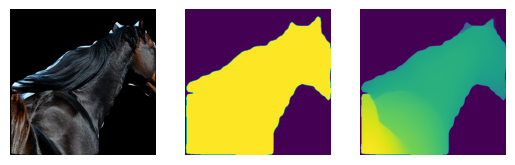

  4%|██▊                                                                    | 24/600 [00:00<00:05, 114.20it/s]

tensor(0.2051, device='cuda:0') tensor(0.4742, device='cuda:0')
tensor(0.2050, device='cuda:0') tensor(0.4742, device='cuda:0')
tensor(0.2050, device='cuda:0') tensor(0.4741, device='cuda:0')
tensor(0.2049, device='cuda:0') tensor(0.4741, device='cuda:0')
tensor(0.2048, device='cuda:0') tensor(0.4740, device='cuda:0')
tensor(0.2047, device='cuda:0') tensor(0.4739, device='cuda:0')
tensor(0.2047, device='cuda:0') tensor(0.4739, device='cuda:0')
tensor(0.2046, device='cuda:0') tensor(0.4739, device='cuda:0')
tensor(0.2045, device='cuda:0') tensor(0.4738, device='cuda:0')
tensor(0.2045, device='cuda:0') tensor(0.4738, device='cuda:0')
tensor(0.2044, device='cuda:0') tensor(0.4739, device='cuda:0')
tensor(0.2045, device='cuda:0') tensor(0.4740, device='cuda:0')
tensor(0.2046, device='cuda:0') tensor(0.4740, device='cuda:0')
tensor(0.2047, device='cuda:0') tensor(0.4740, device='cuda:0')
tensor(0.2049, device='cuda:0') tensor(0.4740, device='cuda:0')
tensor(0.2051, device='cuda:0') tensor(0

  8%|█████▋                                                                 | 48/600 [00:00<00:04, 117.45it/s]

tensor(0.2071, device='cuda:0') tensor(0.4739, device='cuda:0')
tensor(0.2070, device='cuda:0') tensor(0.4740, device='cuda:0')
tensor(0.2068, device='cuda:0') tensor(0.4740, device='cuda:0')
tensor(0.2065, device='cuda:0') tensor(0.4739, device='cuda:0')
tensor(0.2062, device='cuda:0') tensor(0.4739, device='cuda:0')
tensor(0.2058, device='cuda:0') tensor(0.4739, device='cuda:0')
tensor(0.2053, device='cuda:0') tensor(0.4740, device='cuda:0')
tensor(0.2049, device='cuda:0') tensor(0.4740, device='cuda:0')
tensor(0.2044, device='cuda:0') tensor(0.4740, device='cuda:0')
tensor(0.2038, device='cuda:0') tensor(0.4943, device='cuda:0')
tensor(0.2033, device='cuda:0') tensor(0.5334, device='cuda:0')
tensor(0.2028, device='cuda:0') tensor(0.5670, device='cuda:0')
tensor(0.2023, device='cuda:0') tensor(0.5878, device='cuda:0')
tensor(0.2019, device='cuda:0') tensor(0.6006, device='cuda:0')
tensor(0.2014, device='cuda:0') tensor(0.6093, device='cuda:0')
tensor(0.2011, device='cuda:0') tensor(0

 12%|████████▌                                                              | 72/600 [00:00<00:04, 118.54it/s]

tensor(0.1988, device='cuda:0') tensor(0.6080, device='cuda:0')
tensor(0.1988, device='cuda:0') tensor(0.5933, device='cuda:0')
tensor(0.1987, device='cuda:0') tensor(0.5830, device='cuda:0')
tensor(0.1986, device='cuda:0') tensor(0.5742, device='cuda:0')
tensor(0.1985, device='cuda:0') tensor(0.5703, device='cuda:0')
tensor(0.1984, device='cuda:0') tensor(0.5680, device='cuda:0')
tensor(0.1984, device='cuda:0') tensor(0.5659, device='cuda:0')
tensor(0.1982, device='cuda:0') tensor(0.5645, device='cuda:0')
tensor(0.1982, device='cuda:0') tensor(0.5642, device='cuda:0')
tensor(0.1981, device='cuda:0') tensor(0.5642, device='cuda:0')
tensor(0.1981, device='cuda:0') tensor(0.5642, device='cuda:0')
tensor(0.1981, device='cuda:0') tensor(0.5643, device='cuda:0')
tensor(0.1980, device='cuda:0') tensor(0.5645, device='cuda:0')
tensor(0.1981, device='cuda:0') tensor(0.5646, device='cuda:0')
tensor(0.1981, device='cuda:0') tensor(0.5648, device='cuda:0')
tensor(0.1981, device='cuda:0') tensor(0

 14%|█████████▉                                                             | 84/600 [00:00<00:04, 105.57it/s]

tensor(0.1991, device='cuda:0') tensor(0.5657, device='cuda:0')
tensor(0.1991, device='cuda:0') tensor(0.5659, device='cuda:0')
tensor(0.1994, device='cuda:0') tensor(0.5660, device='cuda:0')
tensor(0.1995, device='cuda:0') tensor(0.5660, device='cuda:0')
tensor(0.2016, device='cuda:0') tensor(0.5660, device='cuda:0')
tensor(0.2477, device='cuda:0') tensor(0.5660, device='cuda:0')
tensor(0.2978, device='cuda:0') tensor(0.5659, device='cuda:0')


 89%|███████████████████████████████████████████████████████████████▍       | 536/600 [00:07<00:00, 81.23it/s]

tensor(0.2518, device='cuda:0') tensor(0.5394, device='cuda:0')
tensor(0.2105, device='cuda:0') tensor(0.5394, device='cuda:0')
tensor(0.2034, device='cuda:0') tensor(0.5395, device='cuda:0')
tensor(0.2033, device='cuda:0') tensor(0.5396, device='cuda:0')
tensor(0.2033, device='cuda:0') tensor(0.5397, device='cuda:0')
tensor(0.2033, device='cuda:0') tensor(0.5397, device='cuda:0')
tensor(0.2032, device='cuda:0') tensor(0.5397, device='cuda:0')
tensor(0.2032, device='cuda:0') tensor(0.5397, device='cuda:0')
tensor(0.2032, device='cuda:0') tensor(0.5397, device='cuda:0')
tensor(0.2032, device='cuda:0') tensor(0.5396, device='cuda:0')
tensor(0.2031, device='cuda:0') tensor(0.5395, device='cuda:0')
tensor(0.2031, device='cuda:0') tensor(0.5393, device='cuda:0')
tensor(0.2031, device='cuda:0') tensor(0.5391, device='cuda:0')
tensor(0.2032, device='cuda:0') tensor(0.5388, device='cuda:0')
tensor(0.2033, device='cuda:0') tensor(0.5387, device='cuda:0')
tensor(0.2033, device='cuda:0') tensor(0

 94%|█████████████████████████████████████████████████████████████████▍    | 561/600 [00:07<00:00, 100.78it/s]

tensor(0.2040, device='cuda:0') tensor(0.5634, device='cuda:0')
tensor(0.2041, device='cuda:0') tensor(0.5808, device='cuda:0')
tensor(0.2041, device='cuda:0') tensor(0.6057, device='cuda:0')
tensor(0.2042, device='cuda:0') tensor(0.6448, device='cuda:0')
tensor(0.2043, device='cuda:0') tensor(0.6973, device='cuda:0')
tensor(0.2045, device='cuda:0') tensor(0.7302, device='cuda:0')
tensor(0.2046, device='cuda:0') tensor(0.7349, device='cuda:0')
tensor(0.2047, device='cuda:0') tensor(0.7348, device='cuda:0')
tensor(0.2049, device='cuda:0') tensor(0.7347, device='cuda:0')
tensor(0.2051, device='cuda:0') tensor(0.7346, device='cuda:0')
tensor(0.2053, device='cuda:0') tensor(0.7343, device='cuda:0')
tensor(0.2055, device='cuda:0') tensor(0.7317, device='cuda:0')
tensor(0.2058, device='cuda:0') tensor(0.7191, device='cuda:0')
tensor(0.2061, device='cuda:0') tensor(0.7071, device='cuda:0')
tensor(0.2065, device='cuda:0') tensor(0.6868, device='cuda:0')
tensor(0.2067, device='cuda:0') tensor(0

 98%|████████████████████████████████████████████████████████████████████▎ | 585/600 [00:08<00:00, 110.00it/s]

tensor(0.2083, device='cuda:0') tensor(0.4755, device='cuda:0')
tensor(0.2083, device='cuda:0') tensor(0.4754, device='cuda:0')
tensor(0.2082, device='cuda:0') tensor(0.4754, device='cuda:0')
tensor(0.2081, device='cuda:0') tensor(0.4754, device='cuda:0')
tensor(0.2080, device='cuda:0') tensor(0.4753, device='cuda:0')
tensor(0.2080, device='cuda:0') tensor(0.4753, device='cuda:0')
tensor(0.2080, device='cuda:0') tensor(0.4753, device='cuda:0')
tensor(0.2078, device='cuda:0') tensor(0.4752, device='cuda:0')
tensor(0.2075, device='cuda:0') tensor(0.4752, device='cuda:0')
tensor(0.2074, device='cuda:0') tensor(0.4752, device='cuda:0')
tensor(0.2073, device='cuda:0') tensor(0.4752, device='cuda:0')
tensor(0.2072, device='cuda:0') tensor(0.4752, device='cuda:0')
tensor(0.2070, device='cuda:0') tensor(0.4751, device='cuda:0')
tensor(0.2068, device='cuda:0') tensor(0.4751, device='cuda:0')
tensor(0.2066, device='cuda:0') tensor(0.4750, device='cuda:0')
tensor(0.2063, device='cuda:0') tensor(0

100%|███████████████████████████████████████████████████████████████████████| 600/600 [00:08<00:00, 72.89it/s]


tensor(0.2054, device='cuda:0') tensor(0.4745, device='cuda:0')
tensor(0.2054, device='cuda:0') tensor(0.4744, device='cuda:0')
tensor(0.2053, device='cuda:0') tensor(0.4743, device='cuda:0')
tensor(0.2052, device='cuda:0') tensor(0.4743, device='cuda:0')
/grogu/user/akirchme/art3d_sd_webui/images/horse/1136.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/1136.mp4


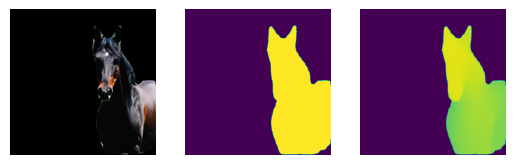

  4%|██▊                                                                    | 24/600 [00:00<00:04, 117.68it/s]

tensor(0.3219, device='cuda:0') tensor(0.5116, device='cuda:0')
tensor(0.3216, device='cuda:0') tensor(0.5116, device='cuda:0')
tensor(0.3195, device='cuda:0') tensor(0.5115, device='cuda:0')
tensor(0.3156, device='cuda:0') tensor(0.5114, device='cuda:0')
tensor(0.3132, device='cuda:0') tensor(0.5113, device='cuda:0')
tensor(0.3118, device='cuda:0') tensor(0.5113, device='cuda:0')
tensor(0.3110, device='cuda:0') tensor(0.5111, device='cuda:0')
tensor(0.3107, device='cuda:0') tensor(0.5111, device='cuda:0')
tensor(0.3105, device='cuda:0') tensor(0.5112, device='cuda:0')
tensor(0.3101, device='cuda:0') tensor(0.5111, device='cuda:0')
tensor(0.3099, device='cuda:0') tensor(0.5110, device='cuda:0')
tensor(0.3100, device='cuda:0') tensor(0.5109, device='cuda:0')
tensor(0.3100, device='cuda:0') tensor(0.5109, device='cuda:0')
tensor(0.3103, device='cuda:0') tensor(0.5108, device='cuda:0')
tensor(0.3105, device='cuda:0') tensor(0.5108, device='cuda:0')
tensor(0.3109, device='cuda:0') tensor(0

  6%|████▎                                                                  | 36/600 [00:00<00:04, 115.14it/s]

tensor(0.3110, device='cuda:0') tensor(0.5108, device='cuda:0')
tensor(0.3104, device='cuda:0') tensor(0.5106, device='cuda:0')
tensor(0.3098, device='cuda:0') tensor(0.5104, device='cuda:0')
tensor(0.3093, device='cuda:0') tensor(0.5105, device='cuda:0')
tensor(0.3085, device='cuda:0') tensor(0.5105, device='cuda:0')
tensor(0.3073, device='cuda:0') tensor(0.5105, device='cuda:0')
tensor(0.3059, device='cuda:0') tensor(0.5106, device='cuda:0')
tensor(0.3047, device='cuda:0') tensor(0.5106, device='cuda:0')
tensor(0.3036, device='cuda:0') tensor(0.5106, device='cuda:0')
tensor(0.2998, device='cuda:0') tensor(0.5585, device='cuda:0')
tensor(0.2986, device='cuda:0') tensor(0.5739, device='cuda:0')
tensor(0.2976, device='cuda:0') tensor(0.5966, device='cuda:0')
tensor(0.2966, device='cuda:0') tensor(0.6178, device='cuda:0')
tensor(0.2954, device='cuda:0') tensor(0.6320, device='cuda:0')
tensor(0.2943, device='cuda:0') tensor(0.6438, device='cuda:0')
tensor(0.2932, device='cuda:0') tensor(0

 12%|████████▌                                                              | 72/600 [00:00<00:04, 118.50it/s]

tensor(0.2889, device='cuda:0') tensor(0.6522, device='cuda:0')
tensor(0.2883, device='cuda:0') tensor(0.6443, device='cuda:0')
tensor(0.2877, device='cuda:0') tensor(0.6372, device='cuda:0')
tensor(0.2866, device='cuda:0') tensor(0.6247, device='cuda:0')
tensor(0.2851, device='cuda:0') tensor(0.6097, device='cuda:0')
tensor(0.2827, device='cuda:0') tensor(0.5978, device='cuda:0')
tensor(0.2800, device='cuda:0') tensor(0.5890, device='cuda:0')
tensor(0.2769, device='cuda:0') tensor(0.5847, device='cuda:0')
tensor(0.2746, device='cuda:0') tensor(0.5843, device='cuda:0')
tensor(0.2725, device='cuda:0') tensor(0.5847, device='cuda:0')
tensor(0.2711, device='cuda:0') tensor(0.5850, device='cuda:0')
tensor(0.2698, device='cuda:0') tensor(0.5845, device='cuda:0')
tensor(0.2687, device='cuda:0') tensor(0.5781, device='cuda:0')
tensor(0.2681, device='cuda:0') tensor(0.5738, device='cuda:0')
tensor(0.2678, device='cuda:0') tensor(0.5734, device='cuda:0')
tensor(0.2674, device='cuda:0') tensor(0

 14%|█████████▉                                                             | 84/600 [00:00<00:04, 113.76it/s]

tensor(0.2659, device='cuda:0') tensor(0.5708, device='cuda:0')
tensor(0.2659, device='cuda:0') tensor(0.5700, device='cuda:0')
tensor(0.2661, device='cuda:0') tensor(0.5689, device='cuda:0')
tensor(0.2662, device='cuda:0') tensor(0.5682, device='cuda:0')
tensor(0.2682, device='cuda:0') tensor(0.5670, device='cuda:0')
tensor(0.2976, device='cuda:0') tensor(0.5659, device='cuda:0')


 47%|█████████████████████████████████                                     | 283/600 [00:02<00:02, 106.33it/s]

tensor(0.3548, device='cuda:0') tensor(0.5069, device='cuda:0')
tensor(0.3554, device='cuda:0') tensor(0.4932, device='cuda:0')
tensor(0.3559, device='cuda:0') tensor(0.4932, device='cuda:0')
tensor(0.3563, device='cuda:0') tensor(0.4933, device='cuda:0')
tensor(0.3567, device='cuda:0') tensor(0.4933, device='cuda:0')
tensor(0.3570, device='cuda:0') tensor(0.4933, device='cuda:0')
tensor(0.3574, device='cuda:0') tensor(0.4933, device='cuda:0')
tensor(0.3578, device='cuda:0') tensor(0.4933, device='cuda:0')
tensor(0.3582, device='cuda:0') tensor(0.4933, device='cuda:0')
tensor(0.3585, device='cuda:0') tensor(0.4934, device='cuda:0')
tensor(0.3588, device='cuda:0') tensor(0.4933, device='cuda:0')
tensor(0.3589, device='cuda:0') tensor(0.4933, device='cuda:0')
tensor(0.3591, device='cuda:0') tensor(0.4932, device='cuda:0')
tensor(0.3592, device='cuda:0') tensor(0.4932, device='cuda:0')
tensor(0.3593, device='cuda:0') tensor(0.4933, device='cuda:0')
tensor(0.3594, device='cuda:0') tensor(0

 51%|███████████████████████████████████▉                                  | 308/600 [00:02<00:02, 113.07it/s]

tensor(0.3604, device='cuda:0') tensor(0.4932, device='cuda:0')
tensor(0.3605, device='cuda:0') tensor(0.4931, device='cuda:0')
tensor(0.3608, device='cuda:0') tensor(0.4930, device='cuda:0')
tensor(0.3608, device='cuda:0') tensor(0.4929, device='cuda:0')
tensor(0.3608, device='cuda:0') tensor(0.4928, device='cuda:0')
tensor(0.3611, device='cuda:0') tensor(0.4927, device='cuda:0')
tensor(0.3611, device='cuda:0') tensor(0.4925, device='cuda:0')
tensor(0.3609, device='cuda:0') tensor(0.4924, device='cuda:0')
tensor(0.3609, device='cuda:0') tensor(0.4924, device='cuda:0')
tensor(0.3608, device='cuda:0') tensor(0.4924, device='cuda:0')
tensor(0.3606, device='cuda:0') tensor(0.4922, device='cuda:0')
tensor(0.3604, device='cuda:0') tensor(0.4922, device='cuda:0')
tensor(0.3602, device='cuda:0') tensor(0.4921, device='cuda:0')
tensor(0.3597, device='cuda:0') tensor(0.4919, device='cuda:0')
tensor(0.3594, device='cuda:0') tensor(0.4919, device='cuda:0')
tensor(0.3594, device='cuda:0') tensor(0

 55%|██████████████████████████████████████▋                               | 332/600 [00:03<00:02, 116.02it/s]

tensor(0.4912, device='cuda:0')
tensor(0.3645, device='cuda:0') tensor(0.4913, device='cuda:0')
tensor(0.3648, device='cuda:0') tensor(0.4914, device='cuda:0')
tensor(0.3650, device='cuda:0') tensor(0.4913, device='cuda:0')
tensor(0.3655, device='cuda:0') tensor(0.4913, device='cuda:0')
tensor(0.3658, device='cuda:0') tensor(0.4910, device='cuda:0')
tensor(0.3662, device='cuda:0') tensor(0.4910, device='cuda:0')
tensor(0.3664, device='cuda:0') tensor(0.4911, device='cuda:0')
tensor(0.3666, device='cuda:0') tensor(0.4909, device='cuda:0')
tensor(0.3666, device='cuda:0') tensor(0.4910, device='cuda:0')
tensor(0.3663, device='cuda:0') tensor(0.4910, device='cuda:0')
tensor(0.3659, device='cuda:0') tensor(0.4909, device='cuda:0')
tensor(0.3655, device='cuda:0') tensor(0.4910, device='cuda:0')
tensor(0.3650, device='cuda:0') tensor(0.4910, device='cuda:0')
tensor(0.3642, device='cuda:0') tensor(0.4910, device='cuda:0')
tensor(0.3634, device='cuda:0') tensor(0.4911, device='cuda:0')
tensor(0

 59%|█████████████████████████████████████████▌                            | 356/600 [00:03<00:02, 117.12it/s]

tensor(0.3522, device='cuda:0') tensor(0.5164, device='cuda:0')
tensor(0.3505, device='cuda:0') tensor(0.5174, device='cuda:0')
tensor(0.3495, device='cuda:0') tensor(0.5179, device='cuda:0')
tensor(0.3484, device='cuda:0') tensor(0.5184, device='cuda:0')
tensor(0.3474, device='cuda:0') tensor(0.5189, device='cuda:0')
tensor(0.3467, device='cuda:0') tensor(0.5196, device='cuda:0')
tensor(0.3453, device='cuda:0') tensor(0.5158, device='cuda:0')
tensor(0.3447, device='cuda:0') tensor(0.5134, device='cuda:0')
tensor(0.3438, device='cuda:0') tensor(0.5129, device='cuda:0')
tensor(0.3431, device='cuda:0') tensor(0.5126, device='cuda:0')
tensor(0.3426, device='cuda:0') tensor(0.5126, device='cuda:0')
tensor(0.3421, device='cuda:0') tensor(0.5125, device='cuda:0')
tensor(0.3414, device='cuda:0') tensor(0.5120, device='cuda:0')
tensor(0.3406, device='cuda:0') tensor(0.5116, device='cuda:0')
tensor(0.3396, device='cuda:0') tensor(0.5116, device='cuda:0')
tensor(0.3388, device='cuda:0') tensor(0

 64%|████████████████████████████████████████████▍                         | 381/600 [00:03<00:01, 118.54it/s]

tensor(0.3361, device='cuda:0') tensor(0.5158, device='cuda:0')
tensor(0.3360, device='cuda:0') tensor(0.5173, device='cuda:0')
tensor(0.3360, device='cuda:0') tensor(0.5183, device='cuda:0')
tensor(0.3360, device='cuda:0') tensor(0.5193, device='cuda:0')
tensor(0.3360, device='cuda:0') tensor(0.5198, device='cuda:0')
tensor(0.3360, device='cuda:0') tensor(0.5195, device='cuda:0')
tensor(0.3362, device='cuda:0') tensor(0.5191, device='cuda:0')
tensor(0.3362, device='cuda:0') tensor(0.5185, device='cuda:0')
tensor(0.3363, device='cuda:0') tensor(0.5178, device='cuda:0')
tensor(0.3363, device='cuda:0') tensor(0.5169, device='cuda:0')
tensor(0.3365, device='cuda:0') tensor(0.5162, device='cuda:0')
tensor(0.3374, device='cuda:0') tensor(0.5153, device='cuda:0')
tensor(0.3471, device='cuda:0') tensor(0.5150, device='cuda:0')
tensor(0.3516, device='cuda:0') tensor(0.5145, device='cuda:0')
tensor(0.3558, device='cuda:0') tensor(0.5141, device='cuda:0')
tensor(0.3580, device='cuda:0') tensor(0

 90%|███████████████████████████████████████████████████████████████       | 540/600 [00:05<00:00, 108.52it/s]

tensor(0.2921, device='cuda:0') tensor(0.5282, device='cuda:0')
tensor(0.2786, device='cuda:0') tensor(0.5292, device='cuda:0')
tensor(0.2673, device='cuda:0') tensor(0.5301, device='cuda:0')
tensor(0.2659, device='cuda:0') tensor(0.5313, device='cuda:0')
tensor(0.2657, device='cuda:0') tensor(0.5323, device='cuda:0')
tensor(0.2653, device='cuda:0') tensor(0.5333, device='cuda:0')
tensor(0.2653, device='cuda:0') tensor(0.5341, device='cuda:0')
tensor(0.2650, device='cuda:0') tensor(0.5352, device='cuda:0')
tensor(0.2648, device='cuda:0') tensor(0.5359, device='cuda:0')
tensor(0.2647, device='cuda:0') tensor(0.5365, device='cuda:0')
tensor(0.2645, device='cuda:0') tensor(0.5370, device='cuda:0')
tensor(0.2645, device='cuda:0') tensor(0.5376, device='cuda:0')
tensor(0.2644, device='cuda:0') tensor(0.5381, device='cuda:0')
tensor(0.2644, device='cuda:0') tensor(0.5383, device='cuda:0')
tensor(0.2644, device='cuda:0') tensor(0.5393, device='cuda:0')
tensor(0.2643, device='cuda:0') tensor(0

 94%|█████████████████████████████████████████████████████████████████▊    | 564/600 [00:05<00:00, 114.06it/s]

tensor(0.2734, device='cuda:0') tensor(0.5733, device='cuda:0')
tensor(0.2779, device='cuda:0') tensor(0.5786, device='cuda:0')
tensor(0.2804, device='cuda:0') tensor(0.5851, device='cuda:0')
tensor(0.2814, device='cuda:0') tensor(0.5909, device='cuda:0')
tensor(0.2818, device='cuda:0') tensor(0.5960, device='cuda:0')
tensor(0.2821, device='cuda:0') tensor(0.6015, device='cuda:0')
tensor(0.2825, device='cuda:0') tensor(0.6039, device='cuda:0')
tensor(0.2827, device='cuda:0') tensor(0.6027, device='cuda:0')
tensor(0.2830, device='cuda:0') tensor(0.6017, device='cuda:0')
tensor(0.2833, device='cuda:0') tensor(0.6011, device='cuda:0')
tensor(0.2837, device='cuda:0') tensor(0.6007, device='cuda:0')
tensor(0.2841, device='cuda:0') tensor(0.5997, device='cuda:0')
tensor(0.2846, device='cuda:0') tensor(0.5948, device='cuda:0')
tensor(0.2854, device='cuda:0') tensor(0.5809, device='cuda:0')
tensor(0.2860, device='cuda:0') tensor(0.5710, device='cuda:0')
tensor(0.2868, device='cuda:0') tensor(0

 98%|████████████████████████████████████████████████████████████████████▋ | 589/600 [00:05<00:00, 116.97it/s]

tensor(0.2975, device='cuda:0') tensor(0.5120, device='cuda:0')
tensor(0.2982, device='cuda:0') tensor(0.5120, device='cuda:0')
tensor(0.2989, device='cuda:0') tensor(0.5120, device='cuda:0')
tensor(0.2996, device='cuda:0') tensor(0.5119, device='cuda:0')
tensor(0.3000, device='cuda:0') tensor(0.5120, device='cuda:0')
tensor(0.3005, device='cuda:0') tensor(0.5119, device='cuda:0')
tensor(0.3008, device='cuda:0') tensor(0.5118, device='cuda:0')
tensor(0.3011, device='cuda:0') tensor(0.5117, device='cuda:0')
tensor(0.3014, device='cuda:0') tensor(0.5117, device='cuda:0')
tensor(0.3017, device='cuda:0') tensor(0.5118, device='cuda:0')
tensor(0.3019, device='cuda:0') tensor(0.5118, device='cuda:0')
tensor(0.3022, device='cuda:0') tensor(0.5117, device='cuda:0')
tensor(0.3026, device='cuda:0') tensor(0.5117, device='cuda:0')
tensor(0.3028, device='cuda:0') tensor(0.5117, device='cuda:0')
tensor(0.3030, device='cuda:0') tensor(0.5116, device='cuda:0')
tensor(0.3037, device='cuda:0') tensor(0

100%|██████████████████████████████████████████████████████████████████████| 600/600 [00:05<00:00, 107.16it/s]


tensor(0.3177, device='cuda:0') tensor(0.5117, device='cuda:0')
tensor(0.3199, device='cuda:0') tensor(0.5117, device='cuda:0')
tensor(0.3212, device='cuda:0') tensor(0.5116, device='cuda:0')
/grogu/user/akirchme/art3d_sd_webui/images/horse/1691.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/1691.mp4


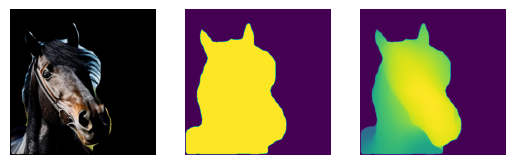

 40%|████████████████████████████▊                                          | 243/600 [00:03<00:04, 83.88it/s]

tensor(0.2997, device='cuda:0') tensor(0.5616, device='cuda:0')
tensor(0.2994, device='cuda:0') tensor(0.5616, device='cuda:0')
tensor(0.2993, device='cuda:0') tensor(0.5610, device='cuda:0')
tensor(0.2993, device='cuda:0') tensor(0.5598, device='cuda:0')
tensor(0.2993, device='cuda:0') tensor(0.5589, device='cuda:0')
tensor(0.2994, device='cuda:0') tensor(0.5576, device='cuda:0')
tensor(0.2994, device='cuda:0') tensor(0.5563, device='cuda:0')
tensor(0.2994, device='cuda:0') tensor(0.5550, device='cuda:0')
tensor(0.2996, device='cuda:0') tensor(0.5534, device='cuda:0')
tensor(0.2997, device='cuda:0') tensor(0.5518, device='cuda:0')
tensor(0.2997, device='cuda:0') tensor(0.5499, device='cuda:0')
tensor(0.2997, device='cuda:0') tensor(0.5478, device='cuda:0')
tensor(0.2999, device='cuda:0') tensor(0.5463, device='cuda:0')


 47%|█████████████████████████████████▎                                     | 281/600 [00:03<00:03, 89.83it/s]

tensor(0.3155, device='cuda:0') tensor(0.5151, device='cuda:0')
tensor(0.3164, device='cuda:0') tensor(0.5035, device='cuda:0')
tensor(0.3172, device='cuda:0') tensor(0.4928, device='cuda:0')
tensor(0.3182, device='cuda:0') tensor(0.4869, device='cuda:0')
tensor(0.3194, device='cuda:0') tensor(0.4864, device='cuda:0')
tensor(0.3207, device='cuda:0') tensor(0.4854, device='cuda:0')
tensor(0.3216, device='cuda:0') tensor(0.4850, device='cuda:0')
tensor(0.3224, device='cuda:0') tensor(0.4850, device='cuda:0')
tensor(0.3229, device='cuda:0') tensor(0.4848, device='cuda:0')
tensor(0.3232, device='cuda:0') tensor(0.4848, device='cuda:0')
tensor(0.3234, device='cuda:0') tensor(0.4849, device='cuda:0')
tensor(0.3236, device='cuda:0') tensor(0.4849, device='cuda:0')
tensor(0.3240, device='cuda:0') tensor(0.4849, device='cuda:0')
tensor(0.3246, device='cuda:0') tensor(0.4850, device='cuda:0')
tensor(0.3253, device='cuda:0') tensor(0.4851, device='cuda:0')
tensor(0.3259, device='cuda:0') tensor(0

 51%|███████████████████████████████████▌                                  | 305/600 [00:03<00:02, 103.45it/s]

tensor(0.3284, device='cuda:0') tensor(0.4851, device='cuda:0')
tensor(0.3288, device='cuda:0') tensor(0.4851, device='cuda:0')
tensor(0.3292, device='cuda:0') tensor(0.4852, device='cuda:0')
tensor(0.3297, device='cuda:0') tensor(0.4852, device='cuda:0')
tensor(0.3302, device='cuda:0') tensor(0.4852, device='cuda:0')
tensor(0.3308, device='cuda:0') tensor(0.4852, device='cuda:0')
tensor(0.3315, device='cuda:0') tensor(0.4851, device='cuda:0')
tensor(0.3322, device='cuda:0') tensor(0.4850, device='cuda:0')
tensor(0.3329, device='cuda:0') tensor(0.4850, device='cuda:0')
tensor(0.3336, device='cuda:0') tensor(0.4850, device='cuda:0')
tensor(0.3342, device='cuda:0') tensor(0.4849, device='cuda:0')
tensor(0.3345, device='cuda:0') tensor(0.4848, device='cuda:0')
tensor(0.3348, device='cuda:0') tensor(0.4849, device='cuda:0')
tensor(0.3352, device='cuda:0') tensor(0.4848, device='cuda:0')
tensor(0.3357, device='cuda:0') tensor(0.4848, device='cuda:0')
tensor(0.3359, device='cuda:0') tensor(0

 55%|██████████████████████████████████████▍                               | 329/600 [00:04<00:02, 110.98it/s]

tensor(0.3410, device='cuda:0') tensor(0.4867, device='cuda:0')
tensor(0.3422, device='cuda:0') tensor(0.4870, device='cuda:0')
tensor(0.3433, device='cuda:0') tensor(0.4873, device='cuda:0')
tensor(0.3449, device='cuda:0') tensor(0.4875, device='cuda:0')
tensor(0.3458, device='cuda:0') tensor(0.4877, device='cuda:0')
tensor(0.3462, device='cuda:0') tensor(0.4878, device='cuda:0')
tensor(0.3468, device='cuda:0') tensor(0.4880, device='cuda:0')
tensor(0.3470, device='cuda:0') tensor(0.4880, device='cuda:0')
tensor(0.3473, device='cuda:0') tensor(0.4878, device='cuda:0')
tensor(0.3474, device='cuda:0') tensor(0.4878, device='cuda:0')
tensor(0.3472, device='cuda:0') tensor(0.4880, device='cuda:0')
tensor(0.3473, device='cuda:0') tensor(0.4882, device='cuda:0')
tensor(0.3472, device='cuda:0') tensor(0.4883, device='cuda:0')
tensor(0.3468, device='cuda:0') tensor(0.4884, device='cuda:0')
tensor(0.3462, device='cuda:0') tensor(0.4883, device='cuda:0')
tensor(0.3455, device='cuda:0') tensor(0

100%|███████████████████████████████████████████████████████████████████████| 600/600 [00:07<00:00, 79.12it/s]


/grogu/user/akirchme/art3d_sd_webui/images/horse/675.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/675.mp4


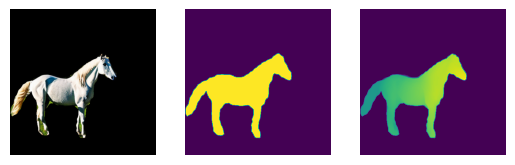

 39%|███████████████████████████▍                                          | 235/600 [00:01<00:02, 123.62it/s]

tensor(0.3027, device='cuda:0') tensor(0.5172, device='cuda:0')
tensor(0.3026, device='cuda:0') tensor(0.5067, device='cuda:0')
tensor(0.2980, device='cuda:0') tensor(0.5071, device='cuda:0')
tensor(0.2873, device='cuda:0') tensor(0.5073, device='cuda:0')
tensor(0.2760, device='cuda:0') tensor(0.5074, device='cuda:0')
tensor(0.2605, device='cuda:0') tensor(0.5079, device='cuda:0')
tensor(0.2368, device='cuda:0') tensor(0.5083, device='cuda:0')
tensor(0.2092, device='cuda:0') tensor(0.5085, device='cuda:0')
tensor(0.1905, device='cuda:0') tensor(0.5086, device='cuda:0')
tensor(0.1887, device='cuda:0') tensor(0.5092, device='cuda:0')
tensor(0.1885, device='cuda:0') tensor(0.5100, device='cuda:0')
tensor(0.1882, device='cuda:0') tensor(0.5104, device='cuda:0')
tensor(0.1880, device='cuda:0') tensor(0.5104, device='cuda:0')
tensor(0.1880, device='cuda:0') tensor(0.5110, device='cuda:0')
tensor(0.1879, device='cuda:0') tensor(0.5115, device='cuda:0')
tensor(0.1878, device='cuda:0') tensor(0

 44%|██████████████████████████████▍                                       | 261/600 [00:02<00:02, 120.86it/s]

tensor(0.1892, device='cuda:0') tensor(0.5087, device='cuda:0')
tensor(0.1892, device='cuda:0') tensor(0.5082, device='cuda:0')
tensor(0.1894, device='cuda:0') tensor(0.5076, device='cuda:0')
tensor(0.1898, device='cuda:0') tensor(0.5074, device='cuda:0')
tensor(0.1897, device='cuda:0') tensor(0.5068, device='cuda:0')
tensor(0.1896, device='cuda:0') tensor(0.5062, device='cuda:0')
tensor(0.1899, device='cuda:0') tensor(0.5075, device='cuda:0')
tensor(0.1903, device='cuda:0') tensor(0.5106, device='cuda:0')
tensor(0.1907, device='cuda:0') tensor(0.5145, device='cuda:0')
tensor(0.1909, device='cuda:0') tensor(0.5211, device='cuda:0')
tensor(0.1912, device='cuda:0') tensor(0.5276, device='cuda:0')
tensor(0.1916, device='cuda:0') tensor(0.5349, device='cuda:0')
tensor(0.1918, device='cuda:0') tensor(0.5388, device='cuda:0')
tensor(0.1921, device='cuda:0') tensor(0.5435, device='cuda:0')
tensor(0.1922, device='cuda:0') tensor(0.5432, device='cuda:0')
tensor(0.1925, device='cuda:0') tensor(0

 48%|█████████████████████████████████▍                                    | 287/600 [00:02<00:02, 119.64it/s]

tensor(0.1981, device='cuda:0') tensor(0.4898, device='cuda:0')
tensor(0.1993, device='cuda:0') tensor(0.4717, device='cuda:0')
tensor(0.2010, device='cuda:0') tensor(0.4528, device='cuda:0')
tensor(0.2029, device='cuda:0') tensor(0.4395, device='cuda:0')
tensor(0.2044, device='cuda:0') tensor(0.4282, device='cuda:0')
tensor(0.2061, device='cuda:0') tensor(0.4277, device='cuda:0')
tensor(0.2075, device='cuda:0') tensor(0.4273, device='cuda:0')
tensor(0.2087, device='cuda:0') tensor(0.4270, device='cuda:0')
tensor(0.2096, device='cuda:0') tensor(0.4268, device='cuda:0')
tensor(0.2102, device='cuda:0') tensor(0.4267, device='cuda:0')
tensor(0.2106, device='cuda:0') tensor(0.4265, device='cuda:0')
tensor(0.2110, device='cuda:0') tensor(0.4265, device='cuda:0')
tensor(0.2113, device='cuda:0') tensor(0.4265, device='cuda:0')
tensor(0.2111, device='cuda:0') tensor(0.4265, device='cuda:0')
tensor(0.2109, device='cuda:0') tensor(0.4264, device='cuda:0')
tensor(0.2106, device='cuda:0') tensor(0

 52%|████████████████████████████████████▎                                 | 311/600 [00:02<00:02, 119.16it/s]

tensor(0.2035, device='cuda:0') tensor(0.4260, device='cuda:0')
tensor(0.2032, device='cuda:0') tensor(0.4262, device='cuda:0')
tensor(0.2032, device='cuda:0') tensor(0.4261, device='cuda:0')
tensor(0.2033, device='cuda:0') tensor(0.4262, device='cuda:0')
tensor(0.2034, device='cuda:0') tensor(0.4261, device='cuda:0')
tensor(0.2035, device='cuda:0') tensor(0.4261, device='cuda:0')
tensor(0.2035, device='cuda:0') tensor(0.4262, device='cuda:0')
tensor(0.2036, device='cuda:0') tensor(0.4261, device='cuda:0')
tensor(0.2035, device='cuda:0') tensor(0.4261, device='cuda:0')
tensor(0.2034, device='cuda:0') tensor(0.4262, device='cuda:0')
tensor(0.2035, device='cuda:0') tensor(0.4261, device='cuda:0')
tensor(0.2035, device='cuda:0') tensor(0.4262, device='cuda:0')
tensor(0.2036, device='cuda:0') tensor(0.4261, device='cuda:0')
tensor(0.2034, device='cuda:0') tensor(0.4261, device='cuda:0')
tensor(0.2032, device='cuda:0') tensor(0.4259, device='cuda:0')
tensor(0.2029, device='cuda:0') tensor(0

 56%|███████████████████████████████████████                               | 335/600 [00:02<00:02, 118.45it/s]

tensor(0.2015, device='cuda:0') tensor(0.4261, device='cuda:0')
tensor(0.2013, device='cuda:0') tensor(0.4262, device='cuda:0')
tensor(0.2011, device='cuda:0') tensor(0.4263, device='cuda:0')
tensor(0.2015, device='cuda:0') tensor(0.4265, device='cuda:0')
tensor(0.2017, device='cuda:0') tensor(0.4264, device='cuda:0')
tensor(0.2017, device='cuda:0') tensor(0.4266, device='cuda:0')
tensor(0.2017, device='cuda:0') tensor(0.4266, device='cuda:0')
tensor(0.2018, device='cuda:0') tensor(0.4267, device='cuda:0')
tensor(0.2018, device='cuda:0') tensor(0.4267, device='cuda:0')
tensor(0.2019, device='cuda:0') tensor(0.4266, device='cuda:0')
tensor(0.2019, device='cuda:0') tensor(0.4265, device='cuda:0')
tensor(0.2018, device='cuda:0') tensor(0.4264, device='cuda:0')
tensor(0.2016, device='cuda:0') tensor(0.4263, device='cuda:0')
tensor(0.2015, device='cuda:0') tensor(0.4265, device='cuda:0')
tensor(0.2012, device='cuda:0') tensor(0.4266, device='cuda:0')
tensor(0.2007, device='cuda:0') tensor(0

 60%|█████████████████████████████████████████▉                            | 359/600 [00:02<00:02, 118.36it/s]

tensor(0.1972, device='cuda:0') tensor(0.5143, device='cuda:0')
tensor(0.1963, device='cuda:0') tensor(0.5417, device='cuda:0')
tensor(0.1958, device='cuda:0') tensor(0.5888, device='cuda:0')
tensor(0.1954, device='cuda:0') tensor(0.6298, device='cuda:0')
tensor(0.1951, device='cuda:0') tensor(0.6609, device='cuda:0')
tensor(0.1949, device='cuda:0') tensor(0.6927, device='cuda:0')
tensor(0.1944, device='cuda:0') tensor(0.7006, device='cuda:0')
tensor(0.1942, device='cuda:0') tensor(0.7011, device='cuda:0')
tensor(0.1939, device='cuda:0') tensor(0.7011, device='cuda:0')
tensor(0.1934, device='cuda:0') tensor(0.7012, device='cuda:0')
tensor(0.1933, device='cuda:0') tensor(0.7020, device='cuda:0')
tensor(0.1931, device='cuda:0') tensor(0.7023, device='cuda:0')
tensor(0.1929, device='cuda:0') tensor(0.6908, device='cuda:0')
tensor(0.1927, device='cuda:0') tensor(0.6778, device='cuda:0')
tensor(0.1925, device='cuda:0') tensor(0.6662, device='cuda:0')
tensor(0.1922, device='cuda:0') tensor(0

 64%|████████████████████████████████████████████▋                         | 383/600 [00:03<00:01, 118.27it/s]

tensor(0.1921, device='cuda:0') tensor(0.5801, device='cuda:0')
tensor(0.1924, device='cuda:0') tensor(0.5807, device='cuda:0')
tensor(0.1928, device='cuda:0') tensor(0.5808, device='cuda:0')
tensor(0.1930, device='cuda:0') tensor(0.5804, device='cuda:0')
tensor(0.1931, device='cuda:0') tensor(0.5809, device='cuda:0')
tensor(0.1932, device='cuda:0') tensor(0.5811, device='cuda:0')
tensor(0.1933, device='cuda:0') tensor(0.5812, device='cuda:0')
tensor(0.1934, device='cuda:0') tensor(0.5813, device='cuda:0')
tensor(0.1935, device='cuda:0') tensor(0.5813, device='cuda:0')
tensor(0.1936, device='cuda:0') tensor(0.5812, device='cuda:0')
tensor(0.1938, device='cuda:0') tensor(0.5812, device='cuda:0')
tensor(0.1941, device='cuda:0') tensor(0.5808, device='cuda:0')
tensor(0.1943, device='cuda:0') tensor(0.5807, device='cuda:0')
tensor(0.1945, device='cuda:0') tensor(0.5805, device='cuda:0')
tensor(0.1946, device='cuda:0') tensor(0.5804, device='cuda:0')
tensor(0.1949, device='cuda:0') tensor(0

100%|██████████████████████████████████████████████████████████████████████| 600/600 [00:04<00:00, 124.74it/s]


/grogu/user/akirchme/art3d_sd_webui/images/horse/26.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/26.mp4


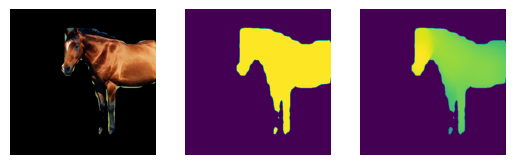

  4%|██▊                                                                    | 24/600 [00:00<00:04, 118.27it/s]

tensor(0.2428, device='cuda:0') tensor(0.4629, device='cuda:0')
tensor(0.2431, device='cuda:0') tensor(0.4630, device='cuda:0')
tensor(0.2433, device='cuda:0') tensor(0.4629, device='cuda:0')
tensor(0.2434, device='cuda:0') tensor(0.4629, device='cuda:0')
tensor(0.2436, device='cuda:0') tensor(0.4628, device='cuda:0')
tensor(0.2438, device='cuda:0') tensor(0.4628, device='cuda:0')
tensor(0.2438, device='cuda:0') tensor(0.4628, device='cuda:0')
tensor(0.2440, device='cuda:0') tensor(0.4628, device='cuda:0')
tensor(0.2447, device='cuda:0') tensor(0.4627, device='cuda:0')
tensor(0.2450, device='cuda:0') tensor(0.4627, device='cuda:0')
tensor(0.2453, device='cuda:0') tensor(0.4626, device='cuda:0')
tensor(0.2457, device='cuda:0') tensor(0.4625, device='cuda:0')
tensor(0.2465, device='cuda:0') tensor(0.4625, device='cuda:0')
tensor(0.2473, device='cuda:0') tensor(0.4624, device='cuda:0')
tensor(0.2488, device='cuda:0') tensor(0.4624, device='cuda:0')
tensor(0.2510, device='cuda:0') tensor(0

  8%|█████▋                                                                 | 48/600 [00:00<00:04, 119.03it/s]

tensor(0.2632, device='cuda:0') tensor(0.4623, device='cuda:0')
tensor(0.2634, device='cuda:0') tensor(0.4623, device='cuda:0')
tensor(0.2635, device='cuda:0') tensor(0.4623, device='cuda:0')
tensor(0.2633, device='cuda:0') tensor(0.4623, device='cuda:0')
tensor(0.2629, device='cuda:0') tensor(0.4622, device='cuda:0')
tensor(0.2623, device='cuda:0') tensor(0.4623, device='cuda:0')
tensor(0.2617, device='cuda:0') tensor(0.4622, device='cuda:0')
tensor(0.2608, device='cuda:0') tensor(0.4622, device='cuda:0')
tensor(0.2598, device='cuda:0') tensor(0.4624, device='cuda:0')
tensor(0.2583, device='cuda:0') tensor(0.4870, device='cuda:0')
tensor(0.2565, device='cuda:0') tensor(0.5176, device='cuda:0')
tensor(0.2548, device='cuda:0') tensor(0.5502, device='cuda:0')
tensor(0.2532, device='cuda:0') tensor(0.5672, device='cuda:0')
tensor(0.2512, device='cuda:0') tensor(0.5789, device='cuda:0')
tensor(0.2483, device='cuda:0') tensor(0.5869, device='cuda:0')
tensor(0.2464, device='cuda:0') tensor(0

 12%|████████▌                                                              | 72/600 [00:00<00:04, 119.42it/s]

tensor(0.2379, device='cuda:0') tensor(0.5782, device='cuda:0')
tensor(0.2373, device='cuda:0') tensor(0.5595, device='cuda:0')
tensor(0.2370, device='cuda:0') tensor(0.5430, device='cuda:0')
tensor(0.2364, device='cuda:0') tensor(0.5377, device='cuda:0')
tensor(0.2360, device='cuda:0') tensor(0.5317, device='cuda:0')
tensor(0.2353, device='cuda:0') tensor(0.5272, device='cuda:0')
tensor(0.2348, device='cuda:0') tensor(0.5254, device='cuda:0')
tensor(0.2343, device='cuda:0') tensor(0.5244, device='cuda:0')
tensor(0.2340, device='cuda:0') tensor(0.5244, device='cuda:0')
tensor(0.2333, device='cuda:0') tensor(0.5244, device='cuda:0')
tensor(0.2326, device='cuda:0') tensor(0.5243, device='cuda:0')
tensor(0.2322, device='cuda:0') tensor(0.5243, device='cuda:0')
tensor(0.2318, device='cuda:0') tensor(0.5243, device='cuda:0')
tensor(0.2314, device='cuda:0') tensor(0.5243, device='cuda:0')
tensor(0.2311, device='cuda:0') tensor(0.5242, device='cuda:0')
tensor(0.2310, device='cuda:0') tensor(0

 14%|█████████▉                                                             | 84/600 [00:00<00:04, 117.46it/s]

tensor(0.2293, device='cuda:0') tensor(0.5248, device='cuda:0')
tensor(0.2292, device='cuda:0') tensor(0.5248, device='cuda:0')
tensor(0.2293, device='cuda:0') tensor(0.5248, device='cuda:0')
tensor(0.2294, device='cuda:0') tensor(0.5247, device='cuda:0')
tensor(0.2327, device='cuda:0') tensor(0.5245, device='cuda:0')
tensor(0.2770, device='cuda:0') tensor(0.5245, device='cuda:0')


 90%|███████████████████████████████████████████████████████████████▎      | 543/600 [00:04<00:00, 118.17it/s]

tensor(0.2588, device='cuda:0') tensor(0.5622, device='cuda:0')
tensor(0.2337, device='cuda:0') tensor(0.5622, device='cuda:0')
tensor(0.2313, device='cuda:0') tensor(0.5623, device='cuda:0')
tensor(0.2310, device='cuda:0') tensor(0.5623, device='cuda:0')
tensor(0.2308, device='cuda:0') tensor(0.5622, device='cuda:0')
tensor(0.2307, device='cuda:0') tensor(0.5624, device='cuda:0')
tensor(0.2305, device='cuda:0') tensor(0.5627, device='cuda:0')
tensor(0.2304, device='cuda:0') tensor(0.5628, device='cuda:0')
tensor(0.2303, device='cuda:0') tensor(0.5630, device='cuda:0')
tensor(0.2301, device='cuda:0') tensor(0.5630, device='cuda:0')
tensor(0.2300, device='cuda:0') tensor(0.5631, device='cuda:0')
tensor(0.2301, device='cuda:0') tensor(0.5635, device='cuda:0')
tensor(0.2300, device='cuda:0') tensor(0.5638, device='cuda:0')
tensor(0.2300, device='cuda:0') tensor(0.5643, device='cuda:0')
tensor(0.2301, device='cuda:0') tensor(0.5646, device='cuda:0')
tensor(0.2301, device='cuda:0') tensor(0

 95%|██████████████████████████████████████████████████████████████████▍   | 569/600 [00:05<00:00, 121.38it/s]

tensor(0.2314, device='cuda:0') tensor(0.6198, device='cuda:0')
tensor(0.2315, device='cuda:0') tensor(0.6376, device='cuda:0')
tensor(0.2316, device='cuda:0') tensor(0.6537, device='cuda:0')
tensor(0.2318, device='cuda:0') tensor(0.6713, device='cuda:0')
tensor(0.2321, device='cuda:0') tensor(0.6823, device='cuda:0')
tensor(0.2322, device='cuda:0') tensor(0.6864, device='cuda:0')
tensor(0.2324, device='cuda:0') tensor(0.6866, device='cuda:0')
tensor(0.2326, device='cuda:0') tensor(0.6864, device='cuda:0')
tensor(0.2326, device='cuda:0') tensor(0.6864, device='cuda:0')
tensor(0.2330, device='cuda:0') tensor(0.6862, device='cuda:0')
tensor(0.2332, device='cuda:0') tensor(0.6850, device='cuda:0')
tensor(0.2333, device='cuda:0') tensor(0.6812, device='cuda:0')
tensor(0.2334, device='cuda:0') tensor(0.6677, device='cuda:0')
tensor(0.2336, device='cuda:0') tensor(0.6434, device='cuda:0')
tensor(0.2337, device='cuda:0') tensor(0.6161, device='cuda:0')
tensor(0.2339, device='cuda:0') tensor(0

 99%|█████████████████████████████████████████████████████████████████████▍| 595/600 [00:05<00:00, 120.69it/s]

tensor(0.2350, device='cuda:0') tensor(0.4622, device='cuda:0')
tensor(0.2352, device='cuda:0') tensor(0.4621, device='cuda:0')
tensor(0.2352, device='cuda:0') tensor(0.4622, device='cuda:0')
tensor(0.2354, device='cuda:0') tensor(0.4622, device='cuda:0')
tensor(0.2355, device='cuda:0') tensor(0.4622, device='cuda:0')
tensor(0.2357, device='cuda:0') tensor(0.4623, device='cuda:0')
tensor(0.2357, device='cuda:0') tensor(0.4623, device='cuda:0')
tensor(0.2358, device='cuda:0') tensor(0.4624, device='cuda:0')
tensor(0.2357, device='cuda:0') tensor(0.4625, device='cuda:0')
tensor(0.2358, device='cuda:0') tensor(0.4625, device='cuda:0')
tensor(0.2359, device='cuda:0') tensor(0.4626, device='cuda:0')
tensor(0.2361, device='cuda:0') tensor(0.4627, device='cuda:0')
tensor(0.2362, device='cuda:0') tensor(0.4628, device='cuda:0')
tensor(0.2363, device='cuda:0') tensor(0.4629, device='cuda:0')
tensor(0.2366, device='cuda:0') tensor(0.4630, device='cuda:0')
tensor(0.2367, device='cuda:0') tensor(0

100%|██████████████████████████████████████████████████████████████████████| 600/600 [00:05<00:00, 110.92it/s]


tensor(0.2417, device='cuda:0') tensor(0.4631, device='cuda:0')
tensor(0.2420, device='cuda:0') tensor(0.4630, device='cuda:0')
/grogu/user/akirchme/art3d_sd_webui/images/horse/1925.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/1925.mp4


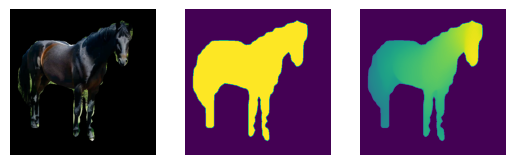

 41%|████████████████████████████▍                                         | 244/600 [00:02<00:03, 106.41it/s]

tensor(0.2737, device='cuda:0') tensor(0.5269, device='cuda:0')
tensor(0.2481, device='cuda:0') tensor(0.5279, device='cuda:0')
tensor(0.2256, device='cuda:0') tensor(0.5297, device='cuda:0')
tensor(0.2144, device='cuda:0') tensor(0.5312, device='cuda:0')
tensor(0.2125, device='cuda:0') tensor(0.5324, device='cuda:0')
tensor(0.2117, device='cuda:0') tensor(0.5339, device='cuda:0')
tensor(0.2113, device='cuda:0') tensor(0.5351, device='cuda:0')
tensor(0.2106, device='cuda:0') tensor(0.5354, device='cuda:0')
tensor(0.2100, device='cuda:0') tensor(0.5355, device='cuda:0')
tensor(0.2093, device='cuda:0') tensor(0.5349, device='cuda:0')
tensor(0.2087, device='cuda:0') tensor(0.5340, device='cuda:0')
tensor(0.2078, device='cuda:0') tensor(0.5327, device='cuda:0')
tensor(0.2072, device='cuda:0') tensor(0.5315, device='cuda:0')
tensor(0.2064, device='cuda:0') tensor(0.5296, device='cuda:0')
tensor(0.2054, device='cuda:0') tensor(0.5267, device='cuda:0')
tensor(0.2047, device='cuda:0') tensor(0

 45%|███████████████████████████████▎                                      | 268/600 [00:02<00:02, 112.91it/s]

tensor(0.2040, device='cuda:0') tensor(0.5034, device='cuda:0')
tensor(0.2044, device='cuda:0') tensor(0.5024, device='cuda:0')
tensor(0.2048, device='cuda:0') tensor(0.5049, device='cuda:0')
tensor(0.2054, device='cuda:0') tensor(0.5114, device='cuda:0')
tensor(0.2060, device='cuda:0') tensor(0.5222, device='cuda:0')
tensor(0.2067, device='cuda:0') tensor(0.5302, device='cuda:0')
tensor(0.2078, device='cuda:0') tensor(0.5356, device='cuda:0')
tensor(0.2087, device='cuda:0') tensor(0.5381, device='cuda:0')
tensor(0.2096, device='cuda:0') tensor(0.5392, device='cuda:0')
tensor(0.2106, device='cuda:0') tensor(0.5389, device='cuda:0')
tensor(0.2116, device='cuda:0') tensor(0.5378, device='cuda:0')
tensor(0.2125, device='cuda:0') tensor(0.5369, device='cuda:0')
tensor(0.2136, device='cuda:0') tensor(0.5360, device='cuda:0')
tensor(0.2147, device='cuda:0') tensor(0.5353, device='cuda:0')
tensor(0.2158, device='cuda:0') tensor(0.5344, device='cuda:0')
tensor(0.2175, device='cuda:0') tensor(0

 49%|██████████████████████████████████                                    | 292/600 [00:02<00:02, 116.33it/s]

tensor(0.2402, device='cuda:0') tensor(0.4166, device='cuda:0')
tensor(0.2419, device='cuda:0') tensor(0.4160, device='cuda:0')
tensor(0.2432, device='cuda:0') tensor(0.4155, device='cuda:0')
tensor(0.2444, device='cuda:0') tensor(0.4152, device='cuda:0')
tensor(0.2457, device='cuda:0') tensor(0.4148, device='cuda:0')
tensor(0.2468, device='cuda:0') tensor(0.4145, device='cuda:0')
tensor(0.2479, device='cuda:0') tensor(0.4142, device='cuda:0')
tensor(0.2485, device='cuda:0') tensor(0.4142, device='cuda:0')
tensor(0.2493, device='cuda:0') tensor(0.4142, device='cuda:0')
tensor(0.2499, device='cuda:0') tensor(0.4140, device='cuda:0')
tensor(0.2502, device='cuda:0') tensor(0.4139, device='cuda:0')
tensor(0.2504, device='cuda:0') tensor(0.4138, device='cuda:0')
tensor(0.2505, device='cuda:0') tensor(0.4138, device='cuda:0')
tensor(0.2502, device='cuda:0') tensor(0.4137, device='cuda:0')
tensor(0.2497, device='cuda:0') tensor(0.4136, device='cuda:0')
tensor(0.2491, device='cuda:0') tensor(0

 53%|████████████████████████████████████▊                                 | 316/600 [00:03<00:02, 117.68it/s]

tensor(0.2440, device='cuda:0') tensor(0.4134, device='cuda:0')
tensor(0.2443, device='cuda:0') tensor(0.4133, device='cuda:0')
tensor(0.2447, device='cuda:0') tensor(0.4133, device='cuda:0')
tensor(0.2454, device='cuda:0') tensor(0.4133, device='cuda:0')
tensor(0.2456, device='cuda:0') tensor(0.4133, device='cuda:0')
tensor(0.2459, device='cuda:0') tensor(0.4132, device='cuda:0')
tensor(0.2460, device='cuda:0') tensor(0.4133, device='cuda:0')
tensor(0.2462, device='cuda:0') tensor(0.4132, device='cuda:0')
tensor(0.2462, device='cuda:0') tensor(0.4132, device='cuda:0')
tensor(0.2462, device='cuda:0') tensor(0.4131, device='cuda:0')
tensor(0.2462, device='cuda:0') tensor(0.4131, device='cuda:0')
tensor(0.2461, device='cuda:0') tensor(0.4131, device='cuda:0')
tensor(0.2459, device='cuda:0') tensor(0.4132, device='cuda:0')
tensor(0.2459, device='cuda:0') tensor(0.4132, device='cuda:0')
tensor(0.2457, device='cuda:0') tensor(0.4132, device='cuda:0')
tensor(0.2456, device='cuda:0') tensor(0

 55%|██████████████████████████████████████▍                               | 329/600 [00:03<00:02, 119.58it/s]

tensor(0.2455, device='cuda:0') tensor(0.4149, device='cuda:0')
tensor(0.2453, device='cuda:0') tensor(0.4152, device='cuda:0')
tensor(0.2455, device='cuda:0') tensor(0.4153, device='cuda:0')
tensor(0.2454, device='cuda:0') tensor(0.4156, device='cuda:0')
tensor(0.2451, device='cuda:0') tensor(0.4158, device='cuda:0')
tensor(0.2448, device='cuda:0') tensor(0.4162, device='cuda:0')
tensor(0.2444, device='cuda:0') tensor(0.4163, device='cuda:0')
tensor(0.2439, device='cuda:0') tensor(0.4165, device='cuda:0')
tensor(0.2433, device='cuda:0') tensor(0.4166, device='cuda:0')
tensor(0.2428, device='cuda:0') tensor(0.4167, device='cuda:0')
tensor(0.2420, device='cuda:0') tensor(0.4169, device='cuda:0')
tensor(0.2413, device='cuda:0') tensor(0.4170, device='cuda:0')
tensor(0.2403, device='cuda:0') tensor(0.4172, device='cuda:0')
tensor(0.2394, device='cuda:0') tensor(0.4173, device='cuda:0')
tensor(0.2380, device='cuda:0') tensor(0.4175, device='cuda:0')
tensor(0.2369, device='cuda:0') tensor(0

 59%|█████████████████████████████████████████▏                            | 353/600 [00:03<00:02, 118.27it/s]

tensor(0.2222, device='cuda:0') tensor(0.4806, device='cuda:0')
tensor(0.2208, device='cuda:0') tensor(0.4918, device='cuda:0')
tensor(0.2197, device='cuda:0') tensor(0.4925, device='cuda:0')
tensor(0.2187, device='cuda:0') tensor(0.4929, device='cuda:0')
tensor(0.2178, device='cuda:0') tensor(0.4936, device='cuda:0')
tensor(0.2169, device='cuda:0') tensor(0.4945, device='cuda:0')
tensor(0.2163, device='cuda:0') tensor(0.4957, device='cuda:0')
tensor(0.2154, device='cuda:0') tensor(0.4965, device='cuda:0')
tensor(0.2147, device='cuda:0') tensor(0.4966, device='cuda:0')
tensor(0.2140, device='cuda:0') tensor(0.4965, device='cuda:0')
tensor(0.2133, device='cuda:0') tensor(0.4961, device='cuda:0')
tensor(0.2124, device='cuda:0') tensor(0.4950, device='cuda:0')
tensor(0.2117, device='cuda:0') tensor(0.4894, device='cuda:0')
tensor(0.2113, device='cuda:0') tensor(0.4774, device='cuda:0')
tensor(0.2107, device='cuda:0') tensor(0.4657, device='cuda:0')
tensor(0.2101, device='cuda:0') tensor(0

 65%|█████████████████████████████████████████████▌                        | 390/600 [00:03<00:01, 119.57it/s]

tensor(0.2097, device='cuda:0') tensor(0.4819, device='cuda:0')
tensor(0.2098, device='cuda:0') tensor(0.4836, device='cuda:0')
tensor(0.2104, device='cuda:0') tensor(0.4853, device='cuda:0')
tensor(0.2110, device='cuda:0') tensor(0.4866, device='cuda:0')
tensor(0.2117, device='cuda:0') tensor(0.4876, device='cuda:0')
tensor(0.2126, device='cuda:0') tensor(0.4892, device='cuda:0')
tensor(0.2131, device='cuda:0') tensor(0.4903, device='cuda:0')
tensor(0.2138, device='cuda:0') tensor(0.4910, device='cuda:0')
tensor(0.2145, device='cuda:0') tensor(0.4914, device='cuda:0')
tensor(0.2148, device='cuda:0') tensor(0.4907, device='cuda:0')
tensor(0.2151, device='cuda:0') tensor(0.4900, device='cuda:0')
tensor(0.2184, device='cuda:0') tensor(0.4886, device='cuda:0')
tensor(0.2222, device='cuda:0') tensor(0.4876, device='cuda:0')
tensor(0.2257, device='cuda:0') tensor(0.4865, device='cuda:0')
tensor(0.2298, device='cuda:0') tensor(0.4857, device='cuda:0')
tensor(0.2420, device='cuda:0') tensor(0

100%|██████████████████████████████████████████████████████████████████████| 600/600 [00:05<00:00, 103.72it/s]


/grogu/user/akirchme/art3d_sd_webui/images/horse/1557.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/1557.mp4


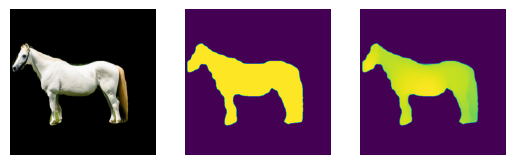

  4%|██▊                                                                    | 24/600 [00:00<00:04, 117.78it/s]

tensor(0.3118, device='cuda:0') tensor(0.4782, device='cuda:0')
tensor(0.3119, device='cuda:0') tensor(0.4781, device='cuda:0')
tensor(0.3119, device='cuda:0') tensor(0.4781, device='cuda:0')
tensor(0.3118, device='cuda:0') tensor(0.4781, device='cuda:0')
tensor(0.3118, device='cuda:0') tensor(0.4781, device='cuda:0')
tensor(0.3117, device='cuda:0') tensor(0.4781, device='cuda:0')
tensor(0.3117, device='cuda:0') tensor(0.4781, device='cuda:0')
tensor(0.3117, device='cuda:0') tensor(0.4781, device='cuda:0')
tensor(0.3115, device='cuda:0') tensor(0.4781, device='cuda:0')
tensor(0.3115, device='cuda:0') tensor(0.4780, device='cuda:0')
tensor(0.3115, device='cuda:0') tensor(0.4780, device='cuda:0')
tensor(0.3114, device='cuda:0') tensor(0.4781, device='cuda:0')
tensor(0.3114, device='cuda:0') tensor(0.4783, device='cuda:0')
tensor(0.3113, device='cuda:0') tensor(0.4783, device='cuda:0')
tensor(0.3113, device='cuda:0') tensor(0.4784, device='cuda:0')
tensor(0.3116, device='cuda:0') tensor(0

  6%|████▎                                                                  | 36/600 [00:00<00:04, 118.31it/s]

tensor(0.3117, device='cuda:0') tensor(0.4791, device='cuda:0')
tensor(0.3114, device='cuda:0') tensor(0.4791, device='cuda:0')
tensor(0.3112, device='cuda:0') tensor(0.4792, device='cuda:0')
tensor(0.3109, device='cuda:0') tensor(0.4791, device='cuda:0')
tensor(0.3105, device='cuda:0') tensor(0.4792, device='cuda:0')
tensor(0.3103, device='cuda:0') tensor(0.4793, device='cuda:0')
tensor(0.3097, device='cuda:0') tensor(0.4794, device='cuda:0')
tensor(0.3093, device='cuda:0') tensor(0.4795, device='cuda:0')
tensor(0.3088, device='cuda:0') tensor(0.4797, device='cuda:0')
tensor(0.3084, device='cuda:0') tensor(0.4957, device='cuda:0')
tensor(0.3079, device='cuda:0') tensor(0.5188, device='cuda:0')


 12%|████████▌                                                              | 72/600 [00:00<00:04, 110.38it/s]

tensor(0.2999, device='cuda:0') tensor(0.5286, device='cuda:0')
tensor(0.2998, device='cuda:0') tensor(0.5288, device='cuda:0')
tensor(0.2997, device='cuda:0') tensor(0.5289, device='cuda:0')
tensor(0.2997, device='cuda:0') tensor(0.5288, device='cuda:0')
tensor(0.2995, device='cuda:0') tensor(0.5289, device='cuda:0')
tensor(0.2996, device='cuda:0') tensor(0.5289, device='cuda:0')
tensor(0.2996, device='cuda:0') tensor(0.5288, device='cuda:0')
tensor(0.2996, device='cuda:0') tensor(0.5289, device='cuda:0')
tensor(0.2995, device='cuda:0') tensor(0.5287, device='cuda:0')
tensor(0.2996, device='cuda:0') tensor(0.5284, device='cuda:0')
tensor(0.2998, device='cuda:0') tensor(0.5281, device='cuda:0')


 98%|████████████████████████████████████████████████████████████████████▍ | 587/600 [00:04<00:00, 113.40it/s]

tensor(0.3081, device='cuda:0') tensor(0.5123, device='cuda:0')
tensor(0.3083, device='cuda:0') tensor(0.4789, device='cuda:0')
tensor(0.3085, device='cuda:0') tensor(0.4781, device='cuda:0')
tensor(0.3089, device='cuda:0') tensor(0.4783, device='cuda:0')
tensor(0.3092, device='cuda:0') tensor(0.4782, device='cuda:0')
tensor(0.3095, device='cuda:0') tensor(0.4782, device='cuda:0')
tensor(0.3096, device='cuda:0') tensor(0.4782, device='cuda:0')
tensor(0.3098, device='cuda:0') tensor(0.4781, device='cuda:0')
tensor(0.3100, device='cuda:0') tensor(0.4781, device='cuda:0')
tensor(0.3102, device='cuda:0') tensor(0.4780, device='cuda:0')
tensor(0.3103, device='cuda:0') tensor(0.4781, device='cuda:0')
tensor(0.3103, device='cuda:0') tensor(0.4783, device='cuda:0')
tensor(0.3104, device='cuda:0') tensor(0.4783, device='cuda:0')
tensor(0.3105, device='cuda:0') tensor(0.4783, device='cuda:0')
tensor(0.3106, device='cuda:0') tensor(0.4782, device='cuda:0')
tensor(0.3107, device='cuda:0') tensor(0

100%|██████████████████████████████████████████████████████████████████████| 600/600 [00:05<00:00, 118.30it/s]


tensor(0.3112, device='cuda:0') tensor(0.4781, device='cuda:0')
tensor(0.3112, device='cuda:0') tensor(0.4780, device='cuda:0')
tensor(0.3111, device='cuda:0') tensor(0.4781, device='cuda:0')
tensor(0.3112, device='cuda:0') tensor(0.4781, device='cuda:0')
tensor(0.3114, device='cuda:0') tensor(0.4780, device='cuda:0')
tensor(0.3115, device='cuda:0') tensor(0.4781, device='cuda:0')
tensor(0.3115, device='cuda:0') tensor(0.4782, device='cuda:0')
tensor(0.3118, device='cuda:0') tensor(0.4783, device='cuda:0')
tensor(0.3118, device='cuda:0') tensor(0.4782, device='cuda:0')
/grogu/user/akirchme/art3d_sd_webui/images/horse/214.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/214.mp4


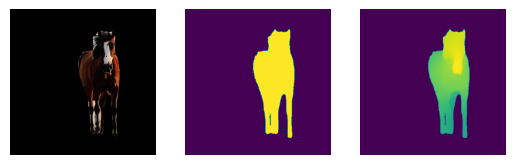

 40%|███████████████████████████▊                                          | 238/600 [00:01<00:02, 123.71it/s]

tensor(0.2899, device='cuda:0') tensor(0.5581, device='cuda:0')
tensor(0.2759, device='cuda:0') tensor(0.5605, device='cuda:0')
tensor(0.2731, device='cuda:0') tensor(0.5629, device='cuda:0')
tensor(0.2732, device='cuda:0') tensor(0.5644, device='cuda:0')
tensor(0.2728, device='cuda:0') tensor(0.5662, device='cuda:0')
tensor(0.2724, device='cuda:0') tensor(0.5666, device='cuda:0')
tensor(0.2721, device='cuda:0') tensor(0.5668, device='cuda:0')
tensor(0.2720, device='cuda:0') tensor(0.5663, device='cuda:0')
tensor(0.2716, device='cuda:0') tensor(0.5659, device='cuda:0')
tensor(0.2714, device='cuda:0') tensor(0.5650, device='cuda:0')
tensor(0.2711, device='cuda:0') tensor(0.5647, device='cuda:0')
tensor(0.2711, device='cuda:0') tensor(0.5640, device='cuda:0')
tensor(0.2710, device='cuda:0') tensor(0.5630, device='cuda:0')
tensor(0.2709, device='cuda:0') tensor(0.5626, device='cuda:0')
tensor(0.2709, device='cuda:0') tensor(0.5615, device='cuda:0')
tensor(0.2709, device='cuda:0') tensor(0

 44%|██████████████████████████████▊                                       | 264/600 [00:02<00:02, 120.67it/s]

tensor(0.2778, device='cuda:0') tensor(0.5695, device='cuda:0')
tensor(0.2786, device='cuda:0') tensor(0.5710, device='cuda:0')
tensor(0.2790, device='cuda:0') tensor(0.5755, device='cuda:0')
tensor(0.2795, device='cuda:0') tensor(0.5823, device='cuda:0')
tensor(0.2805, device='cuda:0') tensor(0.5879, device='cuda:0')
tensor(0.2813, device='cuda:0') tensor(0.5937, device='cuda:0')
tensor(0.2820, device='cuda:0') tensor(0.5928, device='cuda:0')
tensor(0.2831, device='cuda:0') tensor(0.5909, device='cuda:0')
tensor(0.2840, device='cuda:0') tensor(0.5887, device='cuda:0')
tensor(0.2849, device='cuda:0') tensor(0.5879, device='cuda:0')
tensor(0.2858, device='cuda:0') tensor(0.5874, device='cuda:0')
tensor(0.2867, device='cuda:0') tensor(0.5871, device='cuda:0')
tensor(0.2887, device='cuda:0') tensor(0.5797, device='cuda:0')
tensor(0.2911, device='cuda:0') tensor(0.5615, device='cuda:0')
tensor(0.2938, device='cuda:0') tensor(0.5476, device='cuda:0')
tensor(0.2966, device='cuda:0') tensor(0

 48%|█████████████████████████████████▊                                    | 290/600 [00:02<00:02, 120.41it/s]

tensor(0.3108, device='cuda:0') tensor(0.4745, device='cuda:0')
tensor(0.3118, device='cuda:0') tensor(0.4745, device='cuda:0')
tensor(0.3128, device='cuda:0') tensor(0.4744, device='cuda:0')
tensor(0.3134, device='cuda:0') tensor(0.4744, device='cuda:0')
tensor(0.3138, device='cuda:0') tensor(0.4746, device='cuda:0')
tensor(0.3145, device='cuda:0') tensor(0.4746, device='cuda:0')
tensor(0.3146, device='cuda:0') tensor(0.4746, device='cuda:0')
tensor(0.3148, device='cuda:0') tensor(0.4747, device='cuda:0')
tensor(0.3151, device='cuda:0') tensor(0.4748, device='cuda:0')
tensor(0.3149, device='cuda:0') tensor(0.4747, device='cuda:0')
tensor(0.3145, device='cuda:0') tensor(0.4747, device='cuda:0')
tensor(0.3144, device='cuda:0') tensor(0.4746, device='cuda:0')
tensor(0.3138, device='cuda:0') tensor(0.4746, device='cuda:0')
tensor(0.3128, device='cuda:0') tensor(0.4749, device='cuda:0')
tensor(0.3120, device='cuda:0') tensor(0.4750, device='cuda:0')
tensor(0.3105, device='cuda:0') tensor(0

 53%|████████████████████████████████████▊                                 | 316/600 [00:02<00:02, 119.80it/s]

tensor(0.3038, device='cuda:0') tensor(0.4764, device='cuda:0')
tensor(0.3035, device='cuda:0') tensor(0.4764, device='cuda:0')
tensor(0.3032, device='cuda:0') tensor(0.4764, device='cuda:0')
tensor(0.3029, device='cuda:0') tensor(0.4762, device='cuda:0')
tensor(0.3027, device='cuda:0') tensor(0.4762, device='cuda:0')
tensor(0.3027, device='cuda:0') tensor(0.4760, device='cuda:0')
tensor(0.3025, device='cuda:0') tensor(0.4761, device='cuda:0')
tensor(0.3017, device='cuda:0') tensor(0.4762, device='cuda:0')
tensor(0.3009, device='cuda:0') tensor(0.4762, device='cuda:0')
tensor(0.2998, device='cuda:0') tensor(0.4762, device='cuda:0')
tensor(0.2992, device='cuda:0') tensor(0.4761, device='cuda:0')
tensor(0.2983, device='cuda:0') tensor(0.4760, device='cuda:0')
tensor(0.2974, device='cuda:0') tensor(0.4760, device='cuda:0')
tensor(0.2964, device='cuda:0') tensor(0.4761, device='cuda:0')
tensor(0.2959, device='cuda:0') tensor(0.4763, device='cuda:0')
tensor(0.2954, device='cuda:0') tensor(0

 57%|███████████████████████████████████████▋                              | 340/600 [00:02<00:02, 118.69it/s]

tensor(0.2955, device='cuda:0') tensor(0.4771, device='cuda:0')
tensor(0.2955, device='cuda:0') tensor(0.4771, device='cuda:0')
tensor(0.2951, device='cuda:0') tensor(0.4772, device='cuda:0')
tensor(0.2945, device='cuda:0') tensor(0.4774, device='cuda:0')
tensor(0.2938, device='cuda:0') tensor(0.4775, device='cuda:0')
tensor(0.2932, device='cuda:0') tensor(0.4775, device='cuda:0')
tensor(0.2922, device='cuda:0') tensor(0.4777, device='cuda:0')
tensor(0.2914, device='cuda:0') tensor(0.4777, device='cuda:0')
tensor(0.2901, device='cuda:0') tensor(0.4780, device='cuda:0')
tensor(0.2888, device='cuda:0') tensor(0.4785, device='cuda:0')
tensor(0.2874, device='cuda:0') tensor(0.4787, device='cuda:0')
tensor(0.2858, device='cuda:0') tensor(0.4792, device='cuda:0')
tensor(0.2841, device='cuda:0') tensor(0.4795, device='cuda:0')
tensor(0.2822, device='cuda:0') tensor(0.4807, device='cuda:0')
tensor(0.2804, device='cuda:0') tensor(0.4842, device='cuda:0')
tensor(0.2788, device='cuda:0') tensor(0

 61%|██████████████████████████████████████████▌                           | 365/600 [00:02<00:01, 119.51it/s]

tensor(0.2682, device='cuda:0') tensor(0.5458, device='cuda:0')
tensor(0.2678, device='cuda:0') tensor(0.5465, device='cuda:0')
tensor(0.2669, device='cuda:0') tensor(0.5472, device='cuda:0')
tensor(0.2658, device='cuda:0') tensor(0.5486, device='cuda:0')
tensor(0.2651, device='cuda:0') tensor(0.5473, device='cuda:0')
tensor(0.2643, device='cuda:0') tensor(0.5448, device='cuda:0')
tensor(0.2633, device='cuda:0') tensor(0.5354, device='cuda:0')
tensor(0.2622, device='cuda:0') tensor(0.5319, device='cuda:0')
tensor(0.2613, device='cuda:0') tensor(0.5275, device='cuda:0')
tensor(0.2606, device='cuda:0') tensor(0.5223, device='cuda:0')
tensor(0.2600, device='cuda:0') tensor(0.5181, device='cuda:0')
tensor(0.2597, device='cuda:0') tensor(0.5103, device='cuda:0')
tensor(0.2588, device='cuda:0') tensor(0.5062, device='cuda:0')
tensor(0.2581, device='cuda:0') tensor(0.5051, device='cuda:0')
tensor(0.2573, device='cuda:0') tensor(0.5039, device='cuda:0')
tensor(0.2571, device='cuda:0') tensor(0

 65%|█████████████████████████████████████████████▍                        | 389/600 [00:03<00:01, 118.45it/s]

tensor(0.2588, device='cuda:0') tensor(0.5096, device='cuda:0')
tensor(0.2591, device='cuda:0') tensor(0.5099, device='cuda:0')
tensor(0.2594, device='cuda:0') tensor(0.5094, device='cuda:0')
tensor(0.2595, device='cuda:0') tensor(0.5094, device='cuda:0')
tensor(0.2594, device='cuda:0') tensor(0.5086, device='cuda:0')
tensor(0.2595, device='cuda:0') tensor(0.5077, device='cuda:0')
tensor(0.2598, device='cuda:0') tensor(0.5070, device='cuda:0')
tensor(0.2606, device='cuda:0') tensor(0.5055, device='cuda:0')
tensor(0.2641, device='cuda:0') tensor(0.5041, device='cuda:0')
tensor(0.2783, device='cuda:0') tensor(0.5028, device='cuda:0')
tensor(0.2932, device='cuda:0') tensor(0.5014, device='cuda:0')
tensor(0.3055, device='cuda:0') tensor(0.5008, device='cuda:0')
tensor(0.3155, device='cuda:0') tensor(0.4995, device='cuda:0')
tensor(0.3231, device='cuda:0') tensor(0.4987, device='cuda:0')
tensor(0.3290, device='cuda:0') tensor(0.4976, device='cuda:0')
tensor(0.3301, device='cuda:0') tensor(0

100%|██████████████████████████████████████████████████████████████████████| 600/600 [00:05<00:00, 117.92it/s]


/grogu/user/akirchme/art3d_sd_webui/images/horse/899.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/899.mp4


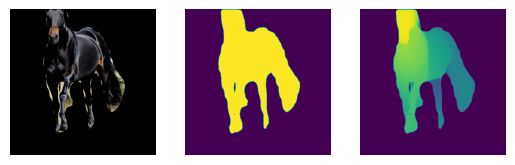

  2%|█▍                                                                     | 12/600 [00:00<00:05, 114.84it/s]

tensor(0.2946, device='cuda:0') tensor(0.4755, device='cuda:0')
tensor(0.2950, device='cuda:0') tensor(0.4754, device='cuda:0')
tensor(0.2952, device='cuda:0') tensor(0.4754, device='cuda:0')
tensor(0.2955, device='cuda:0') tensor(0.4754, device='cuda:0')
tensor(0.2957, device='cuda:0') tensor(0.4754, device='cuda:0')
tensor(0.2958, device='cuda:0') tensor(0.4752, device='cuda:0')
tensor(0.2961, device='cuda:0') tensor(0.4753, device='cuda:0')
tensor(0.2963, device='cuda:0') tensor(0.4754, device='cuda:0')
tensor(0.2965, device='cuda:0') tensor(0.4755, device='cuda:0')
tensor(0.2967, device='cuda:0') tensor(0.4763, device='cuda:0')
tensor(0.2972, device='cuda:0') tensor(0.4773, device='cuda:0')
tensor(0.2975, device='cuda:0') tensor(0.4778, device='cuda:0')
tensor(0.2981, device='cuda:0') tensor(0.4777, device='cuda:0')
tensor(0.2988, device='cuda:0') tensor(0.4777, device='cuda:0')
tensor(0.2999, device='cuda:0') tensor(0.4775, device='cuda:0')
tensor(0.3014, device='cuda:0') tensor(0

  8%|█████▋                                                                 | 48/600 [00:00<00:04, 117.80it/s]

tensor(0.3070, device='cuda:0') tensor(0.4779, device='cuda:0')
tensor(0.3069, device='cuda:0') tensor(0.4776, device='cuda:0')
tensor(0.3065, device='cuda:0') tensor(0.4775, device='cuda:0')
tensor(0.3058, device='cuda:0') tensor(0.4772, device='cuda:0')
tensor(0.3048, device='cuda:0') tensor(0.4772, device='cuda:0')
tensor(0.3040, device='cuda:0') tensor(0.4770, device='cuda:0')
tensor(0.3031, device='cuda:0') tensor(0.4772, device='cuda:0')
tensor(0.3019, device='cuda:0') tensor(0.4773, device='cuda:0')
tensor(0.3006, device='cuda:0') tensor(0.4772, device='cuda:0')
tensor(0.2990, device='cuda:0') tensor(0.4837, device='cuda:0')
tensor(0.2973, device='cuda:0') tensor(0.4901, device='cuda:0')
tensor(0.2958, device='cuda:0') tensor(0.4985, device='cuda:0')
tensor(0.2947, device='cuda:0') tensor(0.5135, device='cuda:0')
tensor(0.2933, device='cuda:0') tensor(0.5257, device='cuda:0')
tensor(0.2910, device='cuda:0') tensor(0.5387, device='cuda:0')
tensor(0.2886, device='cuda:0') tensor(0

 12%|████████▌                                                              | 72/600 [00:00<00:04, 118.29it/s]

tensor(0.2772, device='cuda:0') tensor(0.6036, device='cuda:0')
tensor(0.2770, device='cuda:0') tensor(0.6001, device='cuda:0')
tensor(0.2764, device='cuda:0') tensor(0.5951, device='cuda:0')
tensor(0.2758, device='cuda:0') tensor(0.5908, device='cuda:0')
tensor(0.2753, device='cuda:0') tensor(0.5870, device='cuda:0')
tensor(0.2746, device='cuda:0') tensor(0.5810, device='cuda:0')
tensor(0.2738, device='cuda:0') tensor(0.5732, device='cuda:0')
tensor(0.2730, device='cuda:0') tensor(0.5693, device='cuda:0')
tensor(0.2729, device='cuda:0') tensor(0.5698, device='cuda:0')
tensor(0.2722, device='cuda:0') tensor(0.5709, device='cuda:0')
tensor(0.2716, device='cuda:0') tensor(0.5713, device='cuda:0')
tensor(0.2710, device='cuda:0') tensor(0.5719, device='cuda:0')
tensor(0.2708, device='cuda:0') tensor(0.5723, device='cuda:0')
tensor(0.2701, device='cuda:0') tensor(0.5725, device='cuda:0')
tensor(0.2700, device='cuda:0') tensor(0.5725, device='cuda:0')
tensor(0.2698, device='cuda:0') tensor(0

 14%|█████████▉                                                             | 84/600 [00:00<00:04, 115.01it/s]

tensor(0.2714, device='cuda:0') tensor(0.5742, device='cuda:0')
tensor(0.2716, device='cuda:0') tensor(0.5747, device='cuda:0')
tensor(0.2718, device='cuda:0') tensor(0.5747, device='cuda:0')
tensor(0.2719, device='cuda:0') tensor(0.5750, device='cuda:0')
tensor(0.2734, device='cuda:0') tensor(0.5748, device='cuda:0')
tensor(0.2833, device='cuda:0') tensor(0.5749, device='cuda:0')
tensor(0.2971, device='cuda:0') tensor(0.5750, device='cuda:0')


 89%|██████████████████████████████████████████████████████████████▎       | 534/600 [00:04<00:00, 109.00it/s]

tensor(0.3777, device='cuda:0') tensor(0.5189, device='cuda:0')
tensor(0.3758, device='cuda:0') tensor(0.5133, device='cuda:0')
tensor(0.3628, device='cuda:0') tensor(0.5132, device='cuda:0')
tensor(0.3352, device='cuda:0') tensor(0.5133, device='cuda:0')
tensor(0.3179, device='cuda:0') tensor(0.5135, device='cuda:0')
tensor(0.3087, device='cuda:0') tensor(0.5138, device='cuda:0')
tensor(0.3003, device='cuda:0') tensor(0.5142, device='cuda:0')
tensor(0.2901, device='cuda:0') tensor(0.5146, device='cuda:0')
tensor(0.2736, device='cuda:0') tensor(0.5149, device='cuda:0')
tensor(0.2725, device='cuda:0') tensor(0.5154, device='cuda:0')
tensor(0.2724, device='cuda:0') tensor(0.5158, device='cuda:0')
tensor(0.2722, device='cuda:0') tensor(0.5159, device='cuda:0')
tensor(0.2721, device='cuda:0') tensor(0.5162, device='cuda:0')
tensor(0.2720, device='cuda:0') tensor(0.5164, device='cuda:0')
tensor(0.2721, device='cuda:0') tensor(0.5166, device='cuda:0')
tensor(0.2720, device='cuda:0') tensor(0

 93%|█████████████████████████████████████████████████████████████████▎    | 560/600 [00:05<00:00, 115.92it/s]

tensor(0.2728, device='cuda:0') tensor(0.5128, device='cuda:0')
tensor(0.2729, device='cuda:0') tensor(0.5133, device='cuda:0')
tensor(0.2730, device='cuda:0') tensor(0.5142, device='cuda:0')
tensor(0.2730, device='cuda:0') tensor(0.5165, device='cuda:0')
tensor(0.2732, device='cuda:0') tensor(0.5199, device='cuda:0')
tensor(0.2735, device='cuda:0') tensor(0.5355, device='cuda:0')
tensor(0.2739, device='cuda:0') tensor(0.5545, device='cuda:0')
tensor(0.2740, device='cuda:0') tensor(0.5643, device='cuda:0')
tensor(0.2742, device='cuda:0') tensor(0.5692, device='cuda:0')
tensor(0.2744, device='cuda:0') tensor(0.5727, device='cuda:0')
tensor(0.2748, device='cuda:0') tensor(0.5770, device='cuda:0')
tensor(0.2749, device='cuda:0') tensor(0.5812, device='cuda:0')
tensor(0.2751, device='cuda:0') tensor(0.5870, device='cuda:0')
tensor(0.2753, device='cuda:0') tensor(0.5868, device='cuda:0')
tensor(0.2759, device='cuda:0') tensor(0.5860, device='cuda:0')
tensor(0.2762, device='cuda:0') tensor(0

 97%|████████████████████████████████████████████████████████████████████▏ | 584/600 [00:05<00:00, 116.77it/s]

tensor(0.2825, device='cuda:0') tensor(0.5007, device='cuda:0')
tensor(0.2831, device='cuda:0') tensor(0.4907, device='cuda:0')
tensor(0.2838, device='cuda:0') tensor(0.4806, device='cuda:0')
tensor(0.2844, device='cuda:0') tensor(0.4797, device='cuda:0')
tensor(0.2851, device='cuda:0') tensor(0.4781, device='cuda:0')
tensor(0.2857, device='cuda:0') tensor(0.4774, device='cuda:0')
tensor(0.2866, device='cuda:0') tensor(0.4773, device='cuda:0')
tensor(0.2872, device='cuda:0') tensor(0.4773, device='cuda:0')
tensor(0.2877, device='cuda:0') tensor(0.4771, device='cuda:0')
tensor(0.2879, device='cuda:0') tensor(0.4770, device='cuda:0')
tensor(0.2882, device='cuda:0') tensor(0.4768, device='cuda:0')
tensor(0.2884, device='cuda:0') tensor(0.4767, device='cuda:0')
tensor(0.2884, device='cuda:0') tensor(0.4766, device='cuda:0')
tensor(0.2885, device='cuda:0') tensor(0.4766, device='cuda:0')
tensor(0.2888, device='cuda:0') tensor(0.4765, device='cuda:0')
tensor(0.2889, device='cuda:0') tensor(0

100%|██████████████████████████████████████████████████████████████████████| 600/600 [00:05<00:00, 109.06it/s]


tensor(0.2909, device='cuda:0') tensor(0.4757, device='cuda:0')
tensor(0.2912, device='cuda:0') tensor(0.4758, device='cuda:0')
tensor(0.2917, device='cuda:0') tensor(0.4758, device='cuda:0')
tensor(0.2923, device='cuda:0') tensor(0.4759, device='cuda:0')
tensor(0.2928, device='cuda:0') tensor(0.4759, device='cuda:0')
tensor(0.2932, device='cuda:0') tensor(0.4758, device='cuda:0')
tensor(0.2936, device='cuda:0') tensor(0.4756, device='cuda:0')
tensor(0.2940, device='cuda:0') tensor(0.4756, device='cuda:0')
tensor(0.2942, device='cuda:0') tensor(0.4756, device='cuda:0')
tensor(0.2945, device='cuda:0') tensor(0.4755, device='cuda:0')
/grogu/user/akirchme/art3d_sd_webui/images/horse/848.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/848.mp4


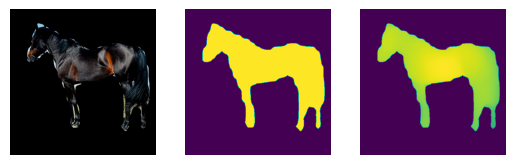

  2%|█▍                                                                     | 12/600 [00:00<00:04, 119.52it/s]

tensor(0.3404, device='cuda:0') tensor(0.4900, device='cuda:0')
tensor(0.3411, device='cuda:0') tensor(0.4900, device='cuda:0')
tensor(0.3415, device='cuda:0') tensor(0.4900, device='cuda:0')
tensor(0.3417, device='cuda:0') tensor(0.4899, device='cuda:0')
tensor(0.3418, device='cuda:0') tensor(0.4900, device='cuda:0')
tensor(0.3420, device='cuda:0') tensor(0.4900, device='cuda:0')
tensor(0.3422, device='cuda:0') tensor(0.4900, device='cuda:0')
tensor(0.3423, device='cuda:0') tensor(0.4900, device='cuda:0')
tensor(0.3427, device='cuda:0') tensor(0.4900, device='cuda:0')
tensor(0.3427, device='cuda:0') tensor(0.4901, device='cuda:0')
tensor(0.3429, device='cuda:0') tensor(0.4902, device='cuda:0')
tensor(0.3434, device='cuda:0') tensor(0.4903, device='cuda:0')
tensor(0.3439, device='cuda:0') tensor(0.4903, device='cuda:0')
tensor(0.3444, device='cuda:0') tensor(0.4904, device='cuda:0')
tensor(0.3448, device='cuda:0') tensor(0.4904, device='cuda:0')
tensor(0.3452, device='cuda:0') tensor(0

  6%|████▍                                                                  | 38/600 [00:00<00:04, 120.02it/s]

tensor(0.3483, device='cuda:0') tensor(0.4907, device='cuda:0')
tensor(0.3486, device='cuda:0') tensor(0.4908, device='cuda:0')
tensor(0.3484, device='cuda:0') tensor(0.4909, device='cuda:0')
tensor(0.3482, device='cuda:0') tensor(0.4910, device='cuda:0')
tensor(0.3475, device='cuda:0') tensor(0.4913, device='cuda:0')
tensor(0.3471, device='cuda:0') tensor(0.4915, device='cuda:0')
tensor(0.3465, device='cuda:0') tensor(0.4916, device='cuda:0')
tensor(0.3457, device='cuda:0') tensor(0.4920, device='cuda:0')
tensor(0.3449, device='cuda:0') tensor(0.4941, device='cuda:0')
tensor(0.3439, device='cuda:0') tensor(0.4979, device='cuda:0')
tensor(0.3432, device='cuda:0') tensor(0.5032, device='cuda:0')
tensor(0.3422, device='cuda:0') tensor(0.5121, device='cuda:0')


 90%|██████████████████████████████████████████████████████████████▊       | 538/600 [00:05<00:00, 112.21it/s]

tensor(0.3965, device='cuda:0') tensor(0.5195, device='cuda:0')
tensor(0.3958, device='cuda:0') tensor(0.5162, device='cuda:0')
tensor(0.3951, device='cuda:0') tensor(0.5147, device='cuda:0')
tensor(0.3938, device='cuda:0') tensor(0.5135, device='cuda:0')
tensor(0.3887, device='cuda:0') tensor(0.5131, device='cuda:0')
tensor(0.3765, device='cuda:0') tensor(0.5132, device='cuda:0')
tensor(0.3617, device='cuda:0') tensor(0.5129, device='cuda:0')
tensor(0.3456, device='cuda:0') tensor(0.5127, device='cuda:0')
tensor(0.3304, device='cuda:0') tensor(0.5126, device='cuda:0')
tensor(0.3213, device='cuda:0') tensor(0.5127, device='cuda:0')
tensor(0.3174, device='cuda:0') tensor(0.5125, device='cuda:0')
tensor(0.3170, device='cuda:0') tensor(0.5122, device='cuda:0')
tensor(0.3167, device='cuda:0') tensor(0.5119, device='cuda:0')
tensor(0.3165, device='cuda:0') tensor(0.5116, device='cuda:0')
tensor(0.3163, device='cuda:0') tensor(0.5109, device='cuda:0')
tensor(0.3160, device='cuda:0') tensor(0

 92%|████████████████████████████████████████████████████████████████▏     | 550/600 [00:05<00:00, 109.96it/s]

tensor(0.3132, device='cuda:0') tensor(0.5127, device='cuda:0')
tensor(0.3131, device='cuda:0') tensor(0.5145, device='cuda:0')
tensor(0.3130, device='cuda:0') tensor(0.5165, device='cuda:0')
tensor(0.3129, device='cuda:0') tensor(0.5188, device='cuda:0')


 98%|████████████████████████████████████████████████████████████████████▌ | 588/600 [00:05<00:00, 113.81it/s]

tensor(0.3202, device='cuda:0') tensor(0.5128, device='cuda:0')
tensor(0.3204, device='cuda:0') tensor(0.5033, device='cuda:0')
tensor(0.3210, device='cuda:0') tensor(0.4969, device='cuda:0')
tensor(0.3218, device='cuda:0') tensor(0.4934, device='cuda:0')
tensor(0.3224, device='cuda:0') tensor(0.4919, device='cuda:0')
tensor(0.3231, device='cuda:0') tensor(0.4919, device='cuda:0')
tensor(0.3237, device='cuda:0') tensor(0.4916, device='cuda:0')
tensor(0.3243, device='cuda:0') tensor(0.4915, device='cuda:0')
tensor(0.3250, device='cuda:0') tensor(0.4914, device='cuda:0')
tensor(0.3253, device='cuda:0') tensor(0.4913, device='cuda:0')
tensor(0.3252, device='cuda:0') tensor(0.4914, device='cuda:0')
tensor(0.3253, device='cuda:0') tensor(0.4912, device='cuda:0')
tensor(0.3252, device='cuda:0') tensor(0.4911, device='cuda:0')
tensor(0.3253, device='cuda:0') tensor(0.4911, device='cuda:0')
tensor(0.3252, device='cuda:0') tensor(0.4911, device='cuda:0')
tensor(0.3257, device='cuda:0') tensor(0

100%|██████████████████████████████████████████████████████████████████████| 600/600 [00:05<00:00, 105.63it/s]


tensor(0.3304, device='cuda:0') tensor(0.4903, device='cuda:0')
tensor(0.3313, device='cuda:0') tensor(0.4902, device='cuda:0')
tensor(0.3322, device='cuda:0') tensor(0.4902, device='cuda:0')
tensor(0.3334, device='cuda:0') tensor(0.4902, device='cuda:0')
tensor(0.3343, device='cuda:0') tensor(0.4902, device='cuda:0')
tensor(0.3355, device='cuda:0') tensor(0.4902, device='cuda:0')
tensor(0.3366, device='cuda:0') tensor(0.4901, device='cuda:0')
tensor(0.3375, device='cuda:0') tensor(0.4900, device='cuda:0')
tensor(0.3384, device='cuda:0') tensor(0.4902, device='cuda:0')
tensor(0.3392, device='cuda:0') tensor(0.4902, device='cuda:0')
tensor(0.3396, device='cuda:0') tensor(0.4901, device='cuda:0')
/grogu/user/akirchme/art3d_sd_webui/images/horse/1379.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/1379.mp4


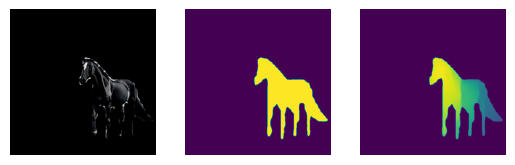

  4%|██▊                                                                    | 24/600 [00:00<00:04, 119.29it/s]

tensor(0.2910, device='cuda:0') tensor(0.4450, device='cuda:0')
tensor(0.2916, device='cuda:0') tensor(0.4450, device='cuda:0')
tensor(0.2919, device='cuda:0') tensor(0.4451, device='cuda:0')
tensor(0.2920, device='cuda:0') tensor(0.4452, device='cuda:0')
tensor(0.2920, device='cuda:0') tensor(0.4453, device='cuda:0')
tensor(0.2921, device='cuda:0') tensor(0.4455, device='cuda:0')
tensor(0.2918, device='cuda:0') tensor(0.4456, device='cuda:0')
tensor(0.2917, device='cuda:0') tensor(0.4459, device='cuda:0')
tensor(0.2915, device='cuda:0') tensor(0.4462, device='cuda:0')
tensor(0.2914, device='cuda:0') tensor(0.4464, device='cuda:0')
tensor(0.2913, device='cuda:0') tensor(0.4468, device='cuda:0')
tensor(0.2910, device='cuda:0') tensor(0.4469, device='cuda:0')
tensor(0.2908, device='cuda:0') tensor(0.4470, device='cuda:0')
tensor(0.2908, device='cuda:0') tensor(0.4473, device='cuda:0')
tensor(0.2905, device='cuda:0') tensor(0.4474, device='cuda:0')
tensor(0.2902, device='cuda:0') tensor(0

  8%|█████▋                                                                 | 48/600 [00:00<00:04, 119.41it/s]

tensor(0.2868, device='cuda:0') tensor(0.4486, device='cuda:0')
tensor(0.2862, device='cuda:0') tensor(0.4486, device='cuda:0')
tensor(0.2858, device='cuda:0') tensor(0.4486, device='cuda:0')
tensor(0.2853, device='cuda:0') tensor(0.4487, device='cuda:0')
tensor(0.2843, device='cuda:0') tensor(0.4489, device='cuda:0')
tensor(0.2834, device='cuda:0') tensor(0.4491, device='cuda:0')
tensor(0.2828, device='cuda:0') tensor(0.4495, device='cuda:0')
tensor(0.2819, device='cuda:0') tensor(0.4500, device='cuda:0')
tensor(0.2812, device='cuda:0') tensor(0.4504, device='cuda:0')
tensor(0.2800, device='cuda:0') tensor(0.4544, device='cuda:0')
tensor(0.2791, device='cuda:0') tensor(0.4621, device='cuda:0')
tensor(0.2781, device='cuda:0') tensor(0.4721, device='cuda:0')
tensor(0.2773, device='cuda:0') tensor(0.4851, device='cuda:0')
tensor(0.2769, device='cuda:0') tensor(0.5001, device='cuda:0')
tensor(0.2760, device='cuda:0') tensor(0.5150, device='cuda:0')
tensor(0.2748, device='cuda:0') tensor(0

 12%|████████▌                                                              | 72/600 [00:00<00:04, 119.54it/s]

tensor(0.2673, device='cuda:0') tensor(0.5729, device='cuda:0')
tensor(0.2664, device='cuda:0') tensor(0.5676, device='cuda:0')
tensor(0.2658, device='cuda:0') tensor(0.5625, device='cuda:0')
tensor(0.2648, device='cuda:0') tensor(0.5547, device='cuda:0')
tensor(0.2640, device='cuda:0') tensor(0.5475, device='cuda:0')
tensor(0.2633, device='cuda:0') tensor(0.5354, device='cuda:0')
tensor(0.2624, device='cuda:0') tensor(0.5247, device='cuda:0')
tensor(0.2616, device='cuda:0') tensor(0.5205, device='cuda:0')
tensor(0.2608, device='cuda:0') tensor(0.5196, device='cuda:0')
tensor(0.2602, device='cuda:0') tensor(0.5205, device='cuda:0')
tensor(0.2596, device='cuda:0') tensor(0.5220, device='cuda:0')
tensor(0.2591, device='cuda:0') tensor(0.5231, device='cuda:0')
tensor(0.2590, device='cuda:0') tensor(0.5236, device='cuda:0')
tensor(0.2588, device='cuda:0') tensor(0.5244, device='cuda:0')
tensor(0.2585, device='cuda:0') tensor(0.5250, device='cuda:0')
tensor(0.2582, device='cuda:0') tensor(0

 14%|██████████                                                             | 85/600 [00:00<00:04, 121.66it/s]

tensor(0.2560, device='cuda:0') tensor(0.5320, device='cuda:0')
tensor(0.2559, device='cuda:0') tensor(0.5320, device='cuda:0')
tensor(0.2558, device='cuda:0') tensor(0.5314, device='cuda:0')
tensor(0.2554, device='cuda:0') tensor(0.5308, device='cuda:0')
tensor(0.2558, device='cuda:0') tensor(0.5305, device='cuda:0')
tensor(0.2630, device='cuda:0') tensor(0.5311, device='cuda:0')
tensor(0.2779, device='cuda:0') tensor(0.5306, device='cuda:0')
tensor(0.2975, device='cuda:0') tensor(0.5295, device='cuda:0')


 82%|█████████████████████████████████████████████████████████▎            | 491/600 [00:03<00:00, 129.12it/s]

tensor(0.3566, device='cuda:0') tensor(0.5200, device='cuda:0')
tensor(0.3567, device='cuda:0') tensor(0.5198, device='cuda:0')
tensor(0.3570, device='cuda:0') tensor(0.5196, device='cuda:0')
tensor(0.3577, device='cuda:0') tensor(0.5190, device='cuda:0')
tensor(0.3581, device='cuda:0') tensor(0.5187, device='cuda:0')
tensor(0.3579, device='cuda:0') tensor(0.5187, device='cuda:0')
tensor(0.3585, device='cuda:0') tensor(0.5185, device='cuda:0')
tensor(0.3584, device='cuda:0') tensor(0.5187, device='cuda:0')
tensor(0.3584, device='cuda:0') tensor(0.5188, device='cuda:0')
tensor(0.3598, device='cuda:0') tensor(0.5190, device='cuda:0')
tensor(0.3601, device='cuda:0') tensor(0.5193, device='cuda:0')
tensor(0.3600, device='cuda:0') tensor(0.5196, device='cuda:0')


 88%|█████████████████████████████████████████████████████████████▊        | 530/600 [00:04<00:00, 124.90it/s]

tensor(0.3115, device='cuda:0') tensor(0.5146, device='cuda:0')
tensor(0.3100, device='cuda:0') tensor(0.5009, device='cuda:0')
tensor(0.3087, device='cuda:0') tensor(0.4867, device='cuda:0')
tensor(0.3073, device='cuda:0') tensor(0.4777, device='cuda:0')
tensor(0.3060, device='cuda:0') tensor(0.4723, device='cuda:0')
tensor(0.3052, device='cuda:0') tensor(0.4687, device='cuda:0')
tensor(0.3044, device='cuda:0') tensor(0.4658, device='cuda:0')
tensor(0.3034, device='cuda:0') tensor(0.4661, device='cuda:0')
tensor(0.2980, device='cuda:0') tensor(0.4666, device='cuda:0')
tensor(0.2873, device='cuda:0') tensor(0.4673, device='cuda:0')
tensor(0.2772, device='cuda:0') tensor(0.4675, device='cuda:0')
tensor(0.2686, device='cuda:0') tensor(0.4675, device='cuda:0')
tensor(0.2610, device='cuda:0') tensor(0.4675, device='cuda:0')
tensor(0.2583, device='cuda:0') tensor(0.4684, device='cuda:0')
tensor(0.2576, device='cuda:0') tensor(0.4692, device='cuda:0')
tensor(0.2575, device='cuda:0') tensor(0

 93%|████████████████████████████████████████████████████████████████▊     | 556/600 [00:04<00:00, 123.80it/s]

tensor(0.2577, device='cuda:0') tensor(0.4710, device='cuda:0')
tensor(0.2580, device='cuda:0') tensor(0.4701, device='cuda:0')
tensor(0.2583, device='cuda:0') tensor(0.4688, device='cuda:0')
tensor(0.2587, device='cuda:0') tensor(0.4681, device='cuda:0')
tensor(0.2589, device='cuda:0') tensor(0.4677, device='cuda:0')
tensor(0.2592, device='cuda:0') tensor(0.4671, device='cuda:0')
tensor(0.2596, device='cuda:0') tensor(0.4665, device='cuda:0')
tensor(0.2599, device='cuda:0') tensor(0.4667, device='cuda:0')
tensor(0.2602, device='cuda:0') tensor(0.4662, device='cuda:0')
tensor(0.2606, device='cuda:0') tensor(0.4662, device='cuda:0')
tensor(0.2612, device='cuda:0') tensor(0.4660, device='cuda:0')
tensor(0.2617, device='cuda:0') tensor(0.4675, device='cuda:0')
tensor(0.2626, device='cuda:0') tensor(0.4721, device='cuda:0')
tensor(0.2630, device='cuda:0') tensor(0.4787, device='cuda:0')
tensor(0.2638, device='cuda:0') tensor(0.4829, device='cuda:0')
tensor(0.2643, device='cuda:0') tensor(0

 97%|███████████████████████████████████████████████████████████████████▉  | 582/600 [00:04<00:00, 123.68it/s]

tensor(0.2700, device='cuda:0') tensor(0.4774, device='cuda:0')
tensor(0.2709, device='cuda:0') tensor(0.4691, device='cuda:0')
tensor(0.2721, device='cuda:0') tensor(0.4624, device='cuda:0')
tensor(0.2736, device='cuda:0') tensor(0.4556, device='cuda:0')
tensor(0.2748, device='cuda:0') tensor(0.4509, device='cuda:0')
tensor(0.2757, device='cuda:0') tensor(0.4458, device='cuda:0')
tensor(0.2768, device='cuda:0') tensor(0.4439, device='cuda:0')
tensor(0.2778, device='cuda:0') tensor(0.4432, device='cuda:0')
tensor(0.2789, device='cuda:0') tensor(0.4431, device='cuda:0')
tensor(0.2800, device='cuda:0') tensor(0.4427, device='cuda:0')
tensor(0.2809, device='cuda:0') tensor(0.4425, device='cuda:0')
tensor(0.2822, device='cuda:0') tensor(0.4425, device='cuda:0')
tensor(0.2834, device='cuda:0') tensor(0.4420, device='cuda:0')
tensor(0.2842, device='cuda:0') tensor(0.4420, device='cuda:0')
tensor(0.2850, device='cuda:0') tensor(0.4421, device='cuda:0')
tensor(0.2857, device='cuda:0') tensor(0

100%|██████████████████████████████████████████████████████████████████████| 600/600 [00:04<00:00, 128.48it/s]


tensor(0.2865, device='cuda:0') tensor(0.4428, device='cuda:0')
tensor(0.2865, device='cuda:0') tensor(0.4430, device='cuda:0')
tensor(0.2866, device='cuda:0') tensor(0.4430, device='cuda:0')
tensor(0.2865, device='cuda:0') tensor(0.4434, device='cuda:0')
tensor(0.2869, device='cuda:0') tensor(0.4437, device='cuda:0')
tensor(0.2871, device='cuda:0') tensor(0.4438, device='cuda:0')
tensor(0.2873, device='cuda:0') tensor(0.4439, device='cuda:0')
tensor(0.2877, device='cuda:0') tensor(0.4440, device='cuda:0')
tensor(0.2881, device='cuda:0') tensor(0.4440, device='cuda:0')
tensor(0.2889, device='cuda:0') tensor(0.4440, device='cuda:0')
tensor(0.2893, device='cuda:0') tensor(0.4440, device='cuda:0')
tensor(0.2896, device='cuda:0') tensor(0.4442, device='cuda:0')
tensor(0.2900, device='cuda:0') tensor(0.4443, device='cuda:0')
tensor(0.2904, device='cuda:0') tensor(0.4446, device='cuda:0')
tensor(0.2908, device='cuda:0') tensor(0.4447, device='cuda:0')
/grogu/user/akirchme/art3d_sd_webui/imag

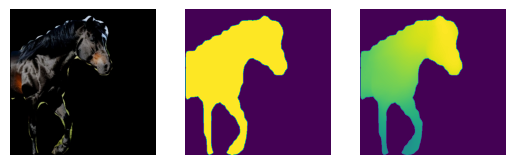

 40%|███████████████████████████▋                                          | 237/600 [00:02<00:03, 107.06it/s]

tensor(0.2909, device='cuda:0') tensor(0.5925, device='cuda:0')
tensor(0.2387, device='cuda:0') tensor(0.5939, device='cuda:0')
tensor(0.2180, device='cuda:0') tensor(0.5953, device='cuda:0')
tensor(0.2035, device='cuda:0') tensor(0.5962, device='cuda:0')
tensor(0.2017, device='cuda:0') tensor(0.5975, device='cuda:0')
tensor(0.2013, device='cuda:0') tensor(0.5987, device='cuda:0')
tensor(0.2011, device='cuda:0') tensor(0.5999, device='cuda:0')
tensor(0.2009, device='cuda:0') tensor(0.6006, device='cuda:0')
tensor(0.2008, device='cuda:0') tensor(0.6007, device='cuda:0')
tensor(0.2006, device='cuda:0') tensor(0.6010, device='cuda:0')
tensor(0.2006, device='cuda:0') tensor(0.6017, device='cuda:0')
tensor(0.2005, device='cuda:0') tensor(0.6017, device='cuda:0')
tensor(0.2003, device='cuda:0') tensor(0.6013, device='cuda:0')
tensor(0.2001, device='cuda:0') tensor(0.5999, device='cuda:0')
tensor(0.1998, device='cuda:0') tensor(0.5993, device='cuda:0')
tensor(0.1995, device='cuda:0') tensor(0

 44%|██████████████████████████████▋                                       | 263/600 [00:02<00:02, 115.45it/s]

tensor(0.1996, device='cuda:0') tensor(0.6301, device='cuda:0')
tensor(0.1999, device='cuda:0') tensor(0.6566, device='cuda:0')
tensor(0.2003, device='cuda:0') tensor(0.6827, device='cuda:0')
tensor(0.2007, device='cuda:0') tensor(0.7082, device='cuda:0')
tensor(0.2012, device='cuda:0') tensor(0.7221, device='cuda:0')
tensor(0.2017, device='cuda:0') tensor(0.7282, device='cuda:0')
tensor(0.2019, device='cuda:0') tensor(0.7337, device='cuda:0')
tensor(0.2024, device='cuda:0') tensor(0.7336, device='cuda:0')
tensor(0.2030, device='cuda:0') tensor(0.7333, device='cuda:0')
tensor(0.2037, device='cuda:0') tensor(0.7329, device='cuda:0')
tensor(0.2042, device='cuda:0') tensor(0.7326, device='cuda:0')
tensor(0.2048, device='cuda:0') tensor(0.7323, device='cuda:0')
tensor(0.2053, device='cuda:0') tensor(0.7259, device='cuda:0')
tensor(0.2058, device='cuda:0') tensor(0.7017, device='cuda:0')
tensor(0.2066, device='cuda:0') tensor(0.6624, device='cuda:0')
tensor(0.2077, device='cuda:0') tensor(0

 48%|█████████████████████████████████▋                                    | 289/600 [00:02<00:02, 119.64it/s]

tensor(0.2203, device='cuda:0') tensor(0.4726, device='cuda:0')
tensor(0.2205, device='cuda:0') tensor(0.4726, device='cuda:0')
tensor(0.2201, device='cuda:0') tensor(0.4726, device='cuda:0')
tensor(0.2195, device='cuda:0') tensor(0.4726, device='cuda:0')
tensor(0.2192, device='cuda:0') tensor(0.4725, device='cuda:0')
tensor(0.2187, device='cuda:0') tensor(0.4723, device='cuda:0')
tensor(0.2180, device='cuda:0') tensor(0.4723, device='cuda:0')
tensor(0.2178, device='cuda:0') tensor(0.4724, device='cuda:0')
tensor(0.2171, device='cuda:0') tensor(0.4724, device='cuda:0')
tensor(0.2166, device='cuda:0') tensor(0.4724, device='cuda:0')
tensor(0.2158, device='cuda:0') tensor(0.4724, device='cuda:0')
tensor(0.2151, device='cuda:0') tensor(0.4723, device='cuda:0')
tensor(0.2143, device='cuda:0') tensor(0.4722, device='cuda:0')
tensor(0.2132, device='cuda:0') tensor(0.4722, device='cuda:0')
tensor(0.2125, device='cuda:0') tensor(0.4722, device='cuda:0')
tensor(0.2115, device='cuda:0') tensor(0

 52%|████████████████████████████████████▋                                 | 314/600 [00:03<00:02, 119.85it/s]

tensor(0.2062, device='cuda:0') tensor(0.4722, device='cuda:0')
tensor(0.2059, device='cuda:0') tensor(0.4722, device='cuda:0')
tensor(0.2054, device='cuda:0') tensor(0.4722, device='cuda:0')
tensor(0.2051, device='cuda:0') tensor(0.4722, device='cuda:0')
tensor(0.2046, device='cuda:0') tensor(0.4723, device='cuda:0')
tensor(0.2039, device='cuda:0') tensor(0.4722, device='cuda:0')
tensor(0.2031, device='cuda:0') tensor(0.4722, device='cuda:0')
tensor(0.2026, device='cuda:0') tensor(0.4721, device='cuda:0')
tensor(0.2022, device='cuda:0') tensor(0.4721, device='cuda:0')
tensor(0.2015, device='cuda:0') tensor(0.4721, device='cuda:0')
tensor(0.2009, device='cuda:0') tensor(0.4720, device='cuda:0')
tensor(0.2003, device='cuda:0') tensor(0.4720, device='cuda:0')
tensor(0.1996, device='cuda:0') tensor(0.4719, device='cuda:0')
tensor(0.1988, device='cuda:0') tensor(0.4720, device='cuda:0')
tensor(0.1982, device='cuda:0') tensor(0.4719, device='cuda:0')
tensor(0.1975, device='cuda:0') tensor(0

 56%|███████████████████████████████████████▍                              | 338/600 [00:03<00:02, 119.81it/s]

tensor(0.1991, device='cuda:0') tensor(0.4721, device='cuda:0')
tensor(0.1989, device='cuda:0') tensor(0.4722, device='cuda:0')
tensor(0.1986, device='cuda:0') tensor(0.4723, device='cuda:0')
tensor(0.1980, device='cuda:0') tensor(0.4722, device='cuda:0')
tensor(0.1973, device='cuda:0') tensor(0.4724, device='cuda:0')
tensor(0.1962, device='cuda:0') tensor(0.4725, device='cuda:0')
tensor(0.1951, device='cuda:0') tensor(0.4727, device='cuda:0')
tensor(0.1939, device='cuda:0') tensor(0.4728, device='cuda:0')
tensor(0.1925, device='cuda:0') tensor(0.4730, device='cuda:0')
tensor(0.1910, device='cuda:0') tensor(0.4730, device='cuda:0')
tensor(0.1896, device='cuda:0') tensor(0.4732, device='cuda:0')
tensor(0.1879, device='cuda:0') tensor(0.4756, device='cuda:0')
tensor(0.1863, device='cuda:0') tensor(0.4772, device='cuda:0')
tensor(0.1842, device='cuda:0') tensor(0.4781, device='cuda:0')
tensor(0.1825, device='cuda:0') tensor(0.4794, device='cuda:0')
tensor(0.1814, device='cuda:0') tensor(0

 60%|██████████████████████████████████████████▎                           | 363/600 [00:03<00:01, 120.77it/s]

tensor(0.1767, device='cuda:0') tensor(0.5065, device='cuda:0')
tensor(0.1767, device='cuda:0') tensor(0.5061, device='cuda:0')
tensor(0.1764, device='cuda:0') tensor(0.5054, device='cuda:0')
tensor(0.1761, device='cuda:0') tensor(0.5051, device='cuda:0')
tensor(0.1759, device='cuda:0') tensor(0.5032, device='cuda:0')
tensor(0.1758, device='cuda:0') tensor(0.4982, device='cuda:0')
tensor(0.1757, device='cuda:0') tensor(0.4895, device='cuda:0')
tensor(0.1759, device='cuda:0') tensor(0.4763, device='cuda:0')
tensor(0.1758, device='cuda:0') tensor(0.4696, device='cuda:0')
tensor(0.1759, device='cuda:0') tensor(0.4684, device='cuda:0')
tensor(0.1755, device='cuda:0') tensor(0.4678, device='cuda:0')
tensor(0.1751, device='cuda:0') tensor(0.4673, device='cuda:0')
tensor(0.1750, device='cuda:0') tensor(0.4675, device='cuda:0')
tensor(0.1749, device='cuda:0') tensor(0.4677, device='cuda:0')
tensor(0.1748, device='cuda:0') tensor(0.4682, device='cuda:0')
tensor(0.1750, device='cuda:0') tensor(0

 65%|█████████████████████████████████████████████▍                        | 389/600 [00:03<00:01, 121.18it/s]

tensor(0.1794, device='cuda:0') tensor(0.4735, device='cuda:0')
tensor(0.1802, device='cuda:0') tensor(0.4722, device='cuda:0')
tensor(0.1810, device='cuda:0') tensor(0.4707, device='cuda:0')
tensor(0.1820, device='cuda:0') tensor(0.4691, device='cuda:0')
tensor(0.1834, device='cuda:0') tensor(0.4677, device='cuda:0')
tensor(0.1875, device='cuda:0') tensor(0.4658, device='cuda:0')
tensor(0.1899, device='cuda:0') tensor(0.4638, device='cuda:0')
tensor(0.1926, device='cuda:0') tensor(0.4628, device='cuda:0')
tensor(0.1967, device='cuda:0') tensor(0.4623, device='cuda:0')
tensor(0.2056, device='cuda:0') tensor(0.4617, device='cuda:0')
tensor(0.2167, device='cuda:0') tensor(0.4613, device='cuda:0')
tensor(0.2210, device='cuda:0') tensor(0.4614, device='cuda:0')
tensor(0.2222, device='cuda:0') tensor(0.4657, device='cuda:0')
tensor(0.2233, device='cuda:0') tensor(0.4735, device='cuda:0')
tensor(0.2245, device='cuda:0') tensor(0.4818, device='cuda:0')
tensor(0.2254, device='cuda:0') tensor(0

 69%|████████████████████████████████████████████████▍                     | 415/600 [00:03<00:01, 120.01it/s]

tensor(0.2392, device='cuda:0') tensor(0.7129, device='cuda:0')
tensor(0.2420, device='cuda:0') tensor(0.7129, device='cuda:0')
tensor(0.2448, device='cuda:0') tensor(0.7127, device='cuda:0')
tensor(0.2487, device='cuda:0') tensor(0.7112, device='cuda:0')
tensor(0.2528, device='cuda:0') tensor(0.7059, device='cuda:0')
tensor(0.2580, device='cuda:0') tensor(0.7023, device='cuda:0')
tensor(0.2618, device='cuda:0') tensor(0.6961, device='cuda:0')
tensor(0.2641, device='cuda:0') tensor(0.6854, device='cuda:0')
tensor(0.2657, device='cuda:0') tensor(0.6696, device='cuda:0')
tensor(0.2672, device='cuda:0') tensor(0.6536, device='cuda:0')
tensor(0.2680, device='cuda:0') tensor(0.6343, device='cuda:0')
tensor(0.2686, device='cuda:0') tensor(0.6113, device='cuda:0')
tensor(0.2693, device='cuda:0') tensor(0.5843, device='cuda:0')
tensor(0.2699, device='cuda:0') tensor(0.5707, device='cuda:0')
tensor(0.2706, device='cuda:0') tensor(0.5668, device='cuda:0')
tensor(0.2714, device='cuda:0') tensor(0

 73%|███████████████████████████████████████████████████▎                  | 440/600 [00:04<00:01, 117.13it/s]

tensor(0.2762, device='cuda:0') tensor(0.5623, device='cuda:0')
tensor(0.2767, device='cuda:0') tensor(0.5624, device='cuda:0')
tensor(0.2768, device='cuda:0') tensor(0.5624, device='cuda:0')
tensor(0.2770, device='cuda:0') tensor(0.5626, device='cuda:0')
tensor(0.2773, device='cuda:0') tensor(0.5628, device='cuda:0')
tensor(0.2774, device='cuda:0') tensor(0.5630, device='cuda:0')
tensor(0.2775, device='cuda:0') tensor(0.5630, device='cuda:0')
tensor(0.2775, device='cuda:0') tensor(0.5632, device='cuda:0')
tensor(0.2776, device='cuda:0') tensor(0.5632, device='cuda:0')
tensor(0.2776, device='cuda:0') tensor(0.5634, device='cuda:0')
tensor(0.2777, device='cuda:0') tensor(0.5635, device='cuda:0')
tensor(0.2777, device='cuda:0') tensor(0.5637, device='cuda:0')
tensor(0.2777, device='cuda:0') tensor(0.5640, device='cuda:0')
tensor(0.2777, device='cuda:0') tensor(0.5640, device='cuda:0')
tensor(0.2828, device='cuda:0') tensor(0.5641, device='cuda:0')
tensor(0.2942, device='cuda:0') tensor(0

100%|██████████████████████████████████████████████████████████████████████| 600/600 [00:05<00:00, 102.62it/s]


/grogu/user/akirchme/art3d_sd_webui/images/horse/1988.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/1988.mp4


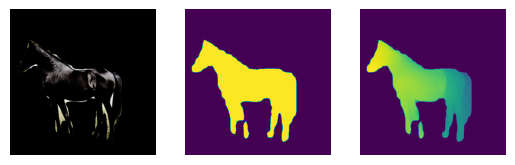

  2%|█▍                                                                     | 12/600 [00:00<00:05, 116.59it/s]

tensor(0.2399, device='cuda:0') tensor(0.4206, device='cuda:0')
tensor(0.2400, device='cuda:0') tensor(0.4206, device='cuda:0')
tensor(0.2399, device='cuda:0') tensor(0.4207, device='cuda:0')
tensor(0.2398, device='cuda:0') tensor(0.4209, device='cuda:0')
tensor(0.2394, device='cuda:0') tensor(0.4208, device='cuda:0')
tensor(0.2390, device='cuda:0') tensor(0.4210, device='cuda:0')
tensor(0.2388, device='cuda:0') tensor(0.4210, device='cuda:0')
tensor(0.2385, device='cuda:0') tensor(0.4211, device='cuda:0')
tensor(0.2385, device='cuda:0') tensor(0.4214, device='cuda:0')
tensor(0.2381, device='cuda:0') tensor(0.4215, device='cuda:0')
tensor(0.2377, device='cuda:0') tensor(0.4215, device='cuda:0')
tensor(0.2375, device='cuda:0') tensor(0.4217, device='cuda:0')
tensor(0.2372, device='cuda:0') tensor(0.4219, device='cuda:0')
tensor(0.2374, device='cuda:0') tensor(0.4221, device='cuda:0')
tensor(0.2384, device='cuda:0') tensor(0.4223, device='cuda:0')
tensor(0.2387, device='cuda:0') tensor(0

  6%|████▍                                                                  | 38/600 [00:00<00:04, 122.31it/s]

tensor(0.2446, device='cuda:0') tensor(0.4232, device='cuda:0')
tensor(0.2435, device='cuda:0') tensor(0.4235, device='cuda:0')
tensor(0.2423, device='cuda:0') tensor(0.4237, device='cuda:0')
tensor(0.2410, device='cuda:0') tensor(0.4240, device='cuda:0')
tensor(0.2397, device='cuda:0') tensor(0.4243, device='cuda:0')
tensor(0.2381, device='cuda:0') tensor(0.4244, device='cuda:0')
tensor(0.2358, device='cuda:0') tensor(0.4249, device='cuda:0')
tensor(0.2331, device='cuda:0') tensor(0.4255, device='cuda:0')
tensor(0.2299, device='cuda:0') tensor(0.4285, device='cuda:0')
tensor(0.2269, device='cuda:0') tensor(0.4356, device='cuda:0')
tensor(0.2238, device='cuda:0') tensor(0.4495, device='cuda:0')
tensor(0.2214, device='cuda:0') tensor(0.4653, device='cuda:0')
tensor(0.2186, device='cuda:0') tensor(0.4739, device='cuda:0')
tensor(0.2167, device='cuda:0') tensor(0.4849, device='cuda:0')
tensor(0.2145, device='cuda:0') tensor(0.4994, device='cuda:0')
tensor(0.2122, device='cuda:0') tensor(0

 11%|███████▌                                                               | 64/600 [00:00<00:04, 123.79it/s]

tensor(0.2006, device='cuda:0') tensor(0.5113, device='cuda:0')
tensor(0.2000, device='cuda:0') tensor(0.5055, device='cuda:0')
tensor(0.1995, device='cuda:0') tensor(0.4978, device='cuda:0')
tensor(0.1993, device='cuda:0') tensor(0.4914, device='cuda:0')
tensor(0.1993, device='cuda:0') tensor(0.4884, device='cuda:0')
tensor(0.1991, device='cuda:0') tensor(0.4887, device='cuda:0')
tensor(0.1990, device='cuda:0') tensor(0.4895, device='cuda:0')
tensor(0.1989, device='cuda:0') tensor(0.4902, device='cuda:0')
tensor(0.1989, device='cuda:0') tensor(0.4916, device='cuda:0')
tensor(0.1991, device='cuda:0') tensor(0.4930, device='cuda:0')
tensor(0.1993, device='cuda:0') tensor(0.4941, device='cuda:0')
tensor(0.1994, device='cuda:0') tensor(0.4957, device='cuda:0')
tensor(0.1996, device='cuda:0') tensor(0.4970, device='cuda:0')
tensor(0.2000, device='cuda:0') tensor(0.4976, device='cuda:0')
tensor(0.2002, device='cuda:0') tensor(0.4990, device='cuda:0')
tensor(0.2003, device='cuda:0') tensor(0

 15%|██████████▋                                                            | 90/600 [00:00<00:04, 123.90it/s]

tensor(0.5043, device='cuda:0')
tensor(0.2108, device='cuda:0') tensor(0.5033, device='cuda:0')
tensor(0.2300, device='cuda:0') tensor(0.5018, device='cuda:0')
tensor(0.2486, device='cuda:0') tensor(0.5003, device='cuda:0')
tensor(0.2632, device='cuda:0') tensor(0.4987, device='cuda:0')
tensor(0.2821, device='cuda:0') tensor(0.4971, device='cuda:0')
tensor(0.2963, device='cuda:0') tensor(0.4957, device='cuda:0')
tensor(0.3052, device='cuda:0') tensor(0.4941, device='cuda:0')
tensor(0.3060, device='cuda:0') tensor(0.4925, device='cuda:0')
tensor(0.3070, device='cuda:0') tensor(0.4922, device='cuda:0')
tensor(0.3076, device='cuda:0') tensor(0.4943, device='cuda:0')
tensor(0.3083, device='cuda:0') tensor(0.4977, device='cuda:0')
tensor(0.3090, device='cuda:0') tensor(0.5026, device='cuda:0')
tensor(0.3097, device='cuda:0') tensor(0.5094, device='cuda:0')
tensor(0.3100, device='cuda:0') tensor(0.5192, device='cuda:0')


 88%|█████████████████████████████████████████████████████████████▎        | 526/600 [00:04<00:00, 117.86it/s]

tensor(0.3357, device='cuda:0') tensor(0.5194, device='cuda:0')
tensor(0.3348, device='cuda:0') tensor(0.5079, device='cuda:0')
tensor(0.3342, device='cuda:0') tensor(0.5017, device='cuda:0')
tensor(0.3336, device='cuda:0') tensor(0.4983, device='cuda:0')
tensor(0.3330, device='cuda:0') tensor(0.4978, device='cuda:0')
tensor(0.3157, device='cuda:0') tensor(0.4980, device='cuda:0')
tensor(0.2778, device='cuda:0') tensor(0.4985, device='cuda:0')
tensor(0.2505, device='cuda:0') tensor(0.4996, device='cuda:0')
tensor(0.2342, device='cuda:0') tensor(0.5010, device='cuda:0')
tensor(0.2172, device='cuda:0') tensor(0.5027, device='cuda:0')
tensor(0.2079, device='cuda:0') tensor(0.5044, device='cuda:0')
tensor(0.2052, device='cuda:0') tensor(0.5062, device='cuda:0')
tensor(0.2048, device='cuda:0') tensor(0.5078, device='cuda:0')
tensor(0.2046, device='cuda:0') tensor(0.5094, device='cuda:0')
tensor(0.2046, device='cuda:0') tensor(0.5102, device='cuda:0')
tensor(0.2046, device='cuda:0') tensor(0

 92%|████████████████████████████████████████████████████████████████▏     | 550/600 [00:04<00:00, 118.39it/s]

tensor(0.5021, device='cuda:0')
tensor(0.2040, device='cuda:0') tensor(0.5009, device='cuda:0')
tensor(0.2045, device='cuda:0') tensor(0.4998, device='cuda:0')
tensor(0.2050, device='cuda:0') tensor(0.4984, device='cuda:0')
tensor(0.2056, device='cuda:0') tensor(0.4979, device='cuda:0')
tensor(0.2062, device='cuda:0') tensor(0.4972, device='cuda:0')
tensor(0.2070, device='cuda:0') tensor(0.4963, device='cuda:0')
tensor(0.2078, device='cuda:0') tensor(0.4957, device='cuda:0')
tensor(0.2087, device='cuda:0') tensor(0.4965, device='cuda:0')
tensor(0.2097, device='cuda:0') tensor(0.5092, device='cuda:0')
tensor(0.2104, device='cuda:0') tensor(0.5229, device='cuda:0')
tensor(0.2113, device='cuda:0') tensor(0.5339, device='cuda:0')
tensor(0.2119, device='cuda:0') tensor(0.5405, device='cuda:0')
tensor(0.2127, device='cuda:0') tensor(0.5486, device='cuda:0')
tensor(0.2134, device='cuda:0') tensor(0.5535, device='cuda:0')
tensor(0.2138, device='cuda:0') tensor(0.5546, device='cuda:0')
tensor(0

 96%|██████████████████████████████████████████████████████████████████▉   | 574/600 [00:04<00:00, 118.49it/s]

tensor(0.2206, device='cuda:0') tensor(0.4878, device='cuda:0')
tensor(0.2217, device='cuda:0') tensor(0.4692, device='cuda:0')
tensor(0.2227, device='cuda:0') tensor(0.4573, device='cuda:0')
tensor(0.2237, device='cuda:0') tensor(0.4458, device='cuda:0')
tensor(0.2248, device='cuda:0') tensor(0.4343, device='cuda:0')
tensor(0.2263, device='cuda:0') tensor(0.4278, device='cuda:0')
tensor(0.2278, device='cuda:0') tensor(0.4249, device='cuda:0')
tensor(0.2293, device='cuda:0') tensor(0.4235, device='cuda:0')
tensor(0.2303, device='cuda:0') tensor(0.4231, device='cuda:0')
tensor(0.2316, device='cuda:0') tensor(0.4229, device='cuda:0')
tensor(0.2330, device='cuda:0') tensor(0.4228, device='cuda:0')
tensor(0.2345, device='cuda:0') tensor(0.4226, device='cuda:0')
tensor(0.2355, device='cuda:0') tensor(0.4224, device='cuda:0')
tensor(0.2365, device='cuda:0') tensor(0.4220, device='cuda:0')
tensor(0.2371, device='cuda:0') tensor(0.4216, device='cuda:0')
tensor(0.2379, device='cuda:0') tensor(0

100%|██████████████████████████████████████████████████████████████████████| 600/600 [00:04<00:00, 120.74it/s]

tensor(0.2395, device='cuda:0') tensor(0.4206, device='cuda:0')
tensor(0.2396, device='cuda:0') tensor(0.4207, device='cuda:0')
tensor(0.2397, device='cuda:0') tensor(0.4208, device='cuda:0')
tensor(0.2398, device='cuda:0') tensor(0.4208, device='cuda:0')
tensor(0.2400, device='cuda:0') tensor(0.4208, device='cuda:0')
tensor(0.2399, device='cuda:0') tensor(0.4207, device='cuda:0')
tensor(0.2400, device='cuda:0') tensor(0.4206, device='cuda:0')
tensor(0.2399, device='cuda:0') tensor(0.4206, device='cuda:0')
tensor(0.2399, device='cuda:0') tensor(0.4204, device='cuda:0')
tensor(0.2399, device='cuda:0') tensor(0.4205, device='cuda:0')
tensor(0.2400, device='cuda:0') tensor(0.4205, device='cuda:0')
tensor(0.2399, device='cuda:0') tensor(0.4203, device='cuda:0')
tensor(0.2399, device='cuda:0') tensor(0.4203, device='cuda:0')
tensor(0.2400, device='cuda:0') tensor(0.4203, device='cuda:0')
tensor(0.2400, device='cuda:0') tensor(0.4205, device='cuda:0')


/grogu/user/akirchme/art3d_sd_webui/images/horse/609.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/609.mp4


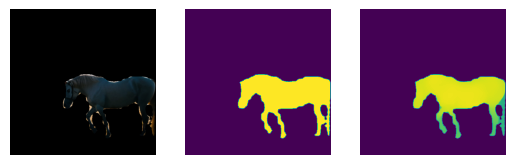

  4%|██▊                                                                    | 24/600 [00:00<00:04, 118.84it/s]

tensor(0.3073, device='cuda:0') tensor(0.4842, device='cuda:0')
tensor(0.3079, device='cuda:0') tensor(0.4844, device='cuda:0')
tensor(0.3087, device='cuda:0') tensor(0.4845, device='cuda:0')
tensor(0.3092, device='cuda:0') tensor(0.4845, device='cuda:0')
tensor(0.3096, device='cuda:0') tensor(0.4845, device='cuda:0')
tensor(0.3099, device='cuda:0') tensor(0.4844, device='cuda:0')
tensor(0.3105, device='cuda:0') tensor(0.4843, device='cuda:0')
tensor(0.3110, device='cuda:0') tensor(0.4843, device='cuda:0')
tensor(0.3113, device='cuda:0') tensor(0.4844, device='cuda:0')
tensor(0.3115, device='cuda:0') tensor(0.4843, device='cuda:0')
tensor(0.3116, device='cuda:0') tensor(0.4841, device='cuda:0')
tensor(0.3121, device='cuda:0') tensor(0.4841, device='cuda:0')
tensor(0.3126, device='cuda:0') tensor(0.4842, device='cuda:0')
tensor(0.3129, device='cuda:0') tensor(0.4843, device='cuda:0')
tensor(0.3132, device='cuda:0') tensor(0.4843, device='cuda:0')
tensor(0.3136, device='cuda:0') tensor(0

  6%|████▍                                                                  | 37/600 [00:00<00:04, 119.99it/s]

tensor(0.3151, device='cuda:0') tensor(0.4848, device='cuda:0')
tensor(0.3151, device='cuda:0') tensor(0.4849, device='cuda:0')
tensor(0.3150, device='cuda:0') tensor(0.4848, device='cuda:0')
tensor(0.3150, device='cuda:0') tensor(0.4845, device='cuda:0')
tensor(0.3148, device='cuda:0') tensor(0.4843, device='cuda:0')
tensor(0.3149, device='cuda:0') tensor(0.4842, device='cuda:0')
tensor(0.3150, device='cuda:0') tensor(0.4841, device='cuda:0')
tensor(0.3147, device='cuda:0') tensor(0.4841, device='cuda:0')
tensor(0.3146, device='cuda:0') tensor(0.4842, device='cuda:0')


 13%|████████▉                                                              | 76/600 [00:00<00:04, 122.95it/s]

tensor(0.2997, device='cuda:0') tensor(0.5576, device='cuda:0')
tensor(0.2990, device='cuda:0') tensor(0.5575, device='cuda:0')
tensor(0.2987, device='cuda:0') tensor(0.5572, device='cuda:0')
tensor(0.2986, device='cuda:0') tensor(0.5569, device='cuda:0')
tensor(0.2982, device='cuda:0') tensor(0.5565, device='cuda:0')
tensor(0.2984, device='cuda:0') tensor(0.5565, device='cuda:0')
tensor(0.2984, device='cuda:0') tensor(0.5566, device='cuda:0')
tensor(0.2982, device='cuda:0') tensor(0.5566, device='cuda:0')
tensor(0.2982, device='cuda:0') tensor(0.5565, device='cuda:0')
tensor(0.2983, device='cuda:0') tensor(0.5563, device='cuda:0')
tensor(0.2983, device='cuda:0') tensor(0.5562, device='cuda:0')
tensor(0.2983, device='cuda:0') tensor(0.5562, device='cuda:0')
tensor(0.2982, device='cuda:0') tensor(0.5562, device='cuda:0')
tensor(0.2983, device='cuda:0') tensor(0.5561, device='cuda:0')
tensor(0.2981, device='cuda:0') tensor(0.5559, device='cuda:0')
tensor(0.2982, device='cuda:0') tensor(0

 90%|███████████████████████████████████████████████████████████████▏      | 542/600 [00:04<00:00, 124.27it/s]

tensor(0.2951, device='cuda:0') tensor(0.5490, device='cuda:0')
tensor(0.2950, device='cuda:0') tensor(0.5493, device='cuda:0')
tensor(0.2950, device='cuda:0') tensor(0.5496, device='cuda:0')
tensor(0.2949, device='cuda:0') tensor(0.5496, device='cuda:0')
tensor(0.2946, device='cuda:0') tensor(0.5500, device='cuda:0')
tensor(0.2943, device='cuda:0') tensor(0.5503, device='cuda:0')
tensor(0.2940, device='cuda:0') tensor(0.5505, device='cuda:0')
tensor(0.2938, device='cuda:0') tensor(0.5506, device='cuda:0')
tensor(0.2937, device='cuda:0') tensor(0.5507, device='cuda:0')
tensor(0.2940, device='cuda:0') tensor(0.5511, device='cuda:0')
tensor(0.2942, device='cuda:0') tensor(0.5515, device='cuda:0')
tensor(0.2945, device='cuda:0') tensor(0.5517, device='cuda:0')
tensor(0.2946, device='cuda:0') tensor(0.5519, device='cuda:0')
tensor(0.2948, device='cuda:0') tensor(0.5524, device='cuda:0')
tensor(0.2951, device='cuda:0') tensor(0.5532, device='cuda:0')
tensor(0.2951, device='cuda:0') tensor(0

 95%|██████████████████████████████████████████████████████████████████▎   | 568/600 [00:04<00:00, 122.75it/s]

tensor(0.2973, device='cuda:0') tensor(0.5747, device='cuda:0')
tensor(0.2974, device='cuda:0') tensor(0.5863, device='cuda:0')
tensor(0.2976, device='cuda:0') tensor(0.6008, device='cuda:0')
tensor(0.2978, device='cuda:0') tensor(0.6289, device='cuda:0')
tensor(0.2980, device='cuda:0') tensor(0.6352, device='cuda:0')
tensor(0.2981, device='cuda:0') tensor(0.6354, device='cuda:0')
tensor(0.2985, device='cuda:0') tensor(0.6357, device='cuda:0')
tensor(0.2986, device='cuda:0') tensor(0.6355, device='cuda:0')
tensor(0.2991, device='cuda:0') tensor(0.6357, device='cuda:0')
tensor(0.2993, device='cuda:0') tensor(0.6353, device='cuda:0')
tensor(0.2996, device='cuda:0') tensor(0.6327, device='cuda:0')
tensor(0.2996, device='cuda:0') tensor(0.6282, device='cuda:0')
tensor(0.2997, device='cuda:0') tensor(0.6240, device='cuda:0')
tensor(0.2996, device='cuda:0') tensor(0.6200, device='cuda:0')
tensor(0.2996, device='cuda:0') tensor(0.6137, device='cuda:0')
tensor(0.2997, device='cuda:0') tensor(0

 99%|█████████████████████████████████████████████████████████████████████▎| 594/600 [00:04<00:00, 123.43it/s]

tensor(0.3014, device='cuda:0') tensor(0.4833, device='cuda:0')
tensor(0.3015, device='cuda:0') tensor(0.4834, device='cuda:0')
tensor(0.3017, device='cuda:0') tensor(0.4835, device='cuda:0')
tensor(0.3019, device='cuda:0') tensor(0.4837, device='cuda:0')
tensor(0.3021, device='cuda:0') tensor(0.4838, device='cuda:0')
tensor(0.3024, device='cuda:0') tensor(0.4838, device='cuda:0')
tensor(0.3023, device='cuda:0') tensor(0.4839, device='cuda:0')
tensor(0.3024, device='cuda:0') tensor(0.4838, device='cuda:0')
tensor(0.3023, device='cuda:0') tensor(0.4836, device='cuda:0')
tensor(0.3025, device='cuda:0') tensor(0.4835, device='cuda:0')
tensor(0.3026, device='cuda:0') tensor(0.4835, device='cuda:0')
tensor(0.3027, device='cuda:0') tensor(0.4834, device='cuda:0')
tensor(0.3028, device='cuda:0') tensor(0.4835, device='cuda:0')
tensor(0.3028, device='cuda:0') tensor(0.4834, device='cuda:0')
tensor(0.3029, device='cuda:0') tensor(0.4835, device='cuda:0')
tensor(0.3028, device='cuda:0') tensor(0

100%|██████████████████████████████████████████████████████████████████████| 600/600 [00:04<00:00, 127.04it/s]


/grogu/user/akirchme/art3d_sd_webui/images/horse/268.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/268.mp4


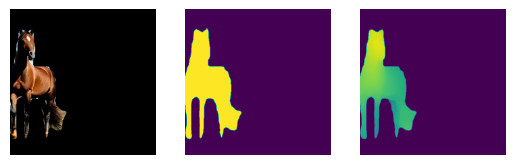

  2%|█▍                                                                     | 12/600 [00:00<00:05, 115.76it/s]

tensor(0.3152, device='cuda:0') tensor(0.4964, device='cuda:0')
tensor(0.3156, device='cuda:0') tensor(0.4967, device='cuda:0')
tensor(0.3157, device='cuda:0') tensor(0.4966, device='cuda:0')
tensor(0.3156, device='cuda:0') tensor(0.4967, device='cuda:0')
tensor(0.3157, device='cuda:0') tensor(0.4970, device='cuda:0')
tensor(0.3157, device='cuda:0') tensor(0.4972, device='cuda:0')
tensor(0.3156, device='cuda:0') tensor(0.4973, device='cuda:0')
tensor(0.3156, device='cuda:0') tensor(0.4973, device='cuda:0')
tensor(0.3154, device='cuda:0') tensor(0.4973, device='cuda:0')
tensor(0.3150, device='cuda:0') tensor(0.4973, device='cuda:0')
tensor(0.3150, device='cuda:0') tensor(0.4972, device='cuda:0')
tensor(0.3147, device='cuda:0') tensor(0.4974, device='cuda:0')
tensor(0.3147, device='cuda:0') tensor(0.4975, device='cuda:0')
tensor(0.3145, device='cuda:0') tensor(0.4976, device='cuda:0')
tensor(0.3146, device='cuda:0') tensor(0.4977, device='cuda:0')
tensor(0.3150, device='cuda:0') tensor(0

  6%|████▎                                                                  | 36/600 [00:00<00:04, 118.73it/s]

tensor(0.3196, device='cuda:0') tensor(0.4985, device='cuda:0')
tensor(0.3195, device='cuda:0') tensor(0.4985, device='cuda:0')
tensor(0.3197, device='cuda:0') tensor(0.4986, device='cuda:0')
tensor(0.3194, device='cuda:0') tensor(0.4984, device='cuda:0')
tensor(0.3189, device='cuda:0') tensor(0.4986, device='cuda:0')
tensor(0.3185, device='cuda:0') tensor(0.4987, device='cuda:0')
tensor(0.3179, device='cuda:0') tensor(0.4988, device='cuda:0')
tensor(0.3169, device='cuda:0') tensor(0.4990, device='cuda:0')
tensor(0.3158, device='cuda:0') tensor(0.4991, device='cuda:0')
tensor(0.3142, device='cuda:0') tensor(0.5022, device='cuda:0')
tensor(0.3127, device='cuda:0') tensor(0.5121, device='cuda:0')


 12%|████████▌                                                              | 72/600 [00:00<00:05, 101.25it/s]

tensor(0.2996, device='cuda:0') tensor(0.5827, device='cuda:0')
tensor(0.2993, device='cuda:0') tensor(0.5830, device='cuda:0')
tensor(0.2987, device='cuda:0') tensor(0.5832, device='cuda:0')
tensor(0.2983, device='cuda:0') tensor(0.5829, device='cuda:0')
tensor(0.2979, device='cuda:0') tensor(0.5831, device='cuda:0')
tensor(0.2973, device='cuda:0') tensor(0.5833, device='cuda:0')
tensor(0.2968, device='cuda:0') tensor(0.5831, device='cuda:0')
tensor(0.2966, device='cuda:0') tensor(0.5828, device='cuda:0')
tensor(0.2962, device='cuda:0') tensor(0.5827, device='cuda:0')
tensor(0.2954, device='cuda:0') tensor(0.5829, device='cuda:0')
tensor(0.2951, device='cuda:0') tensor(0.5825, device='cuda:0')
tensor(0.2946, device='cuda:0') tensor(0.5822, device='cuda:0')
tensor(0.2940, device='cuda:0') tensor(0.5815, device='cuda:0')
tensor(0.2936, device='cuda:0') tensor(0.5809, device='cuda:0')
tensor(0.2932, device='cuda:0') tensor(0.5809, device='cuda:0')
tensor(0.2928, device='cuda:0') tensor(0

 46%|████████████████████████████████▍                                     | 278/600 [00:02<00:02, 122.92it/s]

tensor(0.3618, device='cuda:0') tensor(0.5131, device='cuda:0')
tensor(0.3624, device='cuda:0') tensor(0.5022, device='cuda:0')
tensor(0.3630, device='cuda:0') tensor(0.4994, device='cuda:0')
tensor(0.3635, device='cuda:0') tensor(0.4995, device='cuda:0')
tensor(0.3636, device='cuda:0') tensor(0.4994, device='cuda:0')
tensor(0.3641, device='cuda:0') tensor(0.4994, device='cuda:0')
tensor(0.3642, device='cuda:0') tensor(0.4994, device='cuda:0')
tensor(0.3644, device='cuda:0') tensor(0.4995, device='cuda:0')
tensor(0.3643, device='cuda:0') tensor(0.4992, device='cuda:0')
tensor(0.3642, device='cuda:0') tensor(0.4990, device='cuda:0')
tensor(0.3640, device='cuda:0') tensor(0.4990, device='cuda:0')
tensor(0.3640, device='cuda:0') tensor(0.4991, device='cuda:0')
tensor(0.3640, device='cuda:0') tensor(0.4989, device='cuda:0')
tensor(0.3637, device='cuda:0') tensor(0.4990, device='cuda:0')
tensor(0.3634, device='cuda:0') tensor(0.4989, device='cuda:0')
tensor(0.3630, device='cuda:0') tensor(0

 51%|███████████████████████████████████▍                                  | 304/600 [00:02<00:02, 120.75it/s]

tensor(0.3608, device='cuda:0') tensor(0.4992, device='cuda:0')
tensor(0.3610, device='cuda:0') tensor(0.4992, device='cuda:0')
tensor(0.3610, device='cuda:0') tensor(0.4992, device='cuda:0')
tensor(0.3611, device='cuda:0') tensor(0.4990, device='cuda:0')
tensor(0.3616, device='cuda:0') tensor(0.4989, device='cuda:0')
tensor(0.3620, device='cuda:0') tensor(0.4989, device='cuda:0')
tensor(0.3622, device='cuda:0') tensor(0.4989, device='cuda:0')
tensor(0.3621, device='cuda:0') tensor(0.4989, device='cuda:0')
tensor(0.3619, device='cuda:0') tensor(0.4989, device='cuda:0')
tensor(0.3616, device='cuda:0') tensor(0.4988, device='cuda:0')
tensor(0.3612, device='cuda:0') tensor(0.4989, device='cuda:0')
tensor(0.3609, device='cuda:0') tensor(0.4987, device='cuda:0')
tensor(0.3604, device='cuda:0') tensor(0.4986, device='cuda:0')
tensor(0.3601, device='cuda:0') tensor(0.4986, device='cuda:0')
tensor(0.3595, device='cuda:0') tensor(0.4986, device='cuda:0')
tensor(0.3588, device='cuda:0') tensor(0

 55%|██████████████████████████████████████▌                               | 330/600 [00:02<00:02, 119.67it/s]

tensor(0.3565, device='cuda:0') tensor(0.4982, device='cuda:0')
tensor(0.3566, device='cuda:0') tensor(0.4983, device='cuda:0')
tensor(0.3565, device='cuda:0') tensor(0.4982, device='cuda:0')
tensor(0.3565, device='cuda:0') tensor(0.4982, device='cuda:0')
tensor(0.3566, device='cuda:0') tensor(0.4980, device='cuda:0')
tensor(0.3567, device='cuda:0') tensor(0.4979, device='cuda:0')
tensor(0.3569, device='cuda:0') tensor(0.4978, device='cuda:0')
tensor(0.3570, device='cuda:0') tensor(0.4977, device='cuda:0')
tensor(0.3572, device='cuda:0') tensor(0.4977, device='cuda:0')
tensor(0.3572, device='cuda:0') tensor(0.4975, device='cuda:0')
tensor(0.3571, device='cuda:0') tensor(0.4975, device='cuda:0')
tensor(0.3571, device='cuda:0') tensor(0.4975, device='cuda:0')
tensor(0.3571, device='cuda:0') tensor(0.4975, device='cuda:0')
tensor(0.3570, device='cuda:0') tensor(0.4975, device='cuda:0')
tensor(0.3567, device='cuda:0') tensor(0.4976, device='cuda:0')
tensor(0.3566, device='cuda:0') tensor(0

 89%|██████████████████████████████████████████████████████████████▎       | 534/600 [00:04<00:00, 123.92it/s]

tensor(0.3696, device='cuda:0') tensor(0.5198, device='cuda:0')
tensor(0.3395, device='cuda:0') tensor(0.5198, device='cuda:0')
tensor(0.3175, device='cuda:0') tensor(0.5199, device='cuda:0')
tensor(0.2943, device='cuda:0') tensor(0.5223, device='cuda:0')
tensor(0.2861, device='cuda:0') tensor(0.5232, device='cuda:0')
tensor(0.2850, device='cuda:0') tensor(0.5241, device='cuda:0')
tensor(0.2847, device='cuda:0') tensor(0.5251, device='cuda:0')
tensor(0.2845, device='cuda:0') tensor(0.5255, device='cuda:0')
tensor(0.2842, device='cuda:0') tensor(0.5258, device='cuda:0')
tensor(0.2840, device='cuda:0') tensor(0.5265, device='cuda:0')
tensor(0.2838, device='cuda:0') tensor(0.5271, device='cuda:0')
tensor(0.2841, device='cuda:0') tensor(0.5275, device='cuda:0')
tensor(0.2840, device='cuda:0') tensor(0.5273, device='cuda:0')
tensor(0.2838, device='cuda:0') tensor(0.5275, device='cuda:0')
tensor(0.2835, device='cuda:0') tensor(0.5270, device='cuda:0')
tensor(0.2836, device='cuda:0') tensor(0

 93%|█████████████████████████████████████████████████████████████████▎    | 560/600 [00:04<00:00, 123.47it/s]

tensor(0.2866, device='cuda:0') tensor(0.5268, device='cuda:0')
tensor(0.2870, device='cuda:0') tensor(0.5266, device='cuda:0')
tensor(0.2877, device='cuda:0') tensor(0.5270, device='cuda:0')
tensor(0.2882, device='cuda:0') tensor(0.5362, device='cuda:0')
tensor(0.2889, device='cuda:0') tensor(0.5524, device='cuda:0')
tensor(0.2895, device='cuda:0') tensor(0.5633, device='cuda:0')
tensor(0.2902, device='cuda:0') tensor(0.5663, device='cuda:0')
tensor(0.2908, device='cuda:0') tensor(0.5676, device='cuda:0')
tensor(0.2910, device='cuda:0') tensor(0.5723, device='cuda:0')
tensor(0.2916, device='cuda:0') tensor(0.5781, device='cuda:0')
tensor(0.2924, device='cuda:0') tensor(0.5800, device='cuda:0')
tensor(0.2929, device='cuda:0') tensor(0.5800, device='cuda:0')
tensor(0.2935, device='cuda:0') tensor(0.5798, device='cuda:0')
tensor(0.2940, device='cuda:0') tensor(0.5800, device='cuda:0')
tensor(0.2945, device='cuda:0') tensor(0.5801, device='cuda:0')
tensor(0.2945, device='cuda:0') tensor(0

 98%|████████████████████████████████████████████████████████████████████▎ | 586/600 [00:04<00:00, 120.85it/s]

tensor(0.2986, device='cuda:0') tensor(0.4915, device='cuda:0')
tensor(0.2989, device='cuda:0') tensor(0.4917, device='cuda:0')
tensor(0.2999, device='cuda:0') tensor(0.4918, device='cuda:0')
tensor(0.3004, device='cuda:0') tensor(0.4919, device='cuda:0')
tensor(0.3010, device='cuda:0') tensor(0.4920, device='cuda:0')
tensor(0.3015, device='cuda:0') tensor(0.4921, device='cuda:0')
tensor(0.3020, device='cuda:0') tensor(0.4923, device='cuda:0')
tensor(0.3030, device='cuda:0') tensor(0.4923, device='cuda:0')
tensor(0.3036, device='cuda:0') tensor(0.4923, device='cuda:0')
tensor(0.3040, device='cuda:0') tensor(0.4923, device='cuda:0')
tensor(0.3046, device='cuda:0') tensor(0.4925, device='cuda:0')
tensor(0.3053, device='cuda:0') tensor(0.4928, device='cuda:0')
tensor(0.3060, device='cuda:0') tensor(0.4930, device='cuda:0')
tensor(0.3068, device='cuda:0') tensor(0.4932, device='cuda:0')
tensor(0.3077, device='cuda:0') tensor(0.4934, device='cuda:0')
tensor(0.3083, device='cuda:0') tensor(0

100%|██████████████████████████████████████████████████████████████████████| 600/600 [00:04<00:00, 120.17it/s]


tensor(0.3132, device='cuda:0') tensor(0.4952, device='cuda:0')
tensor(0.3138, device='cuda:0') tensor(0.4952, device='cuda:0')
tensor(0.3143, device='cuda:0') tensor(0.4954, device='cuda:0')
tensor(0.3145, device='cuda:0') tensor(0.4954, device='cuda:0')
tensor(0.3147, device='cuda:0') tensor(0.4957, device='cuda:0')
tensor(0.3149, device='cuda:0') tensor(0.4959, device='cuda:0')
tensor(0.3151, device='cuda:0') tensor(0.4962, device='cuda:0')
tensor(0.3151, device='cuda:0') tensor(0.4963, device='cuda:0')
/grogu/user/akirchme/art3d_sd_webui/images/horse/1959.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/1959.mp4


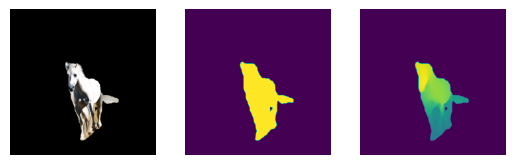

  2%|█▌                                                                     | 13/600 [00:00<00:04, 120.42it/s]

tensor(0.3266, device='cuda:0') tensor(0.5067, device='cuda:0')
tensor(0.3286, device='cuda:0') tensor(0.5068, device='cuda:0')
tensor(0.3306, device='cuda:0') tensor(0.5069, device='cuda:0')
tensor(0.3317, device='cuda:0') tensor(0.5068, device='cuda:0')
tensor(0.3325, device='cuda:0') tensor(0.5069, device='cuda:0')
tensor(0.3338, device='cuda:0') tensor(0.5068, device='cuda:0')
tensor(0.3346, device='cuda:0') tensor(0.5070, device='cuda:0')
tensor(0.3350, device='cuda:0') tensor(0.5072, device='cuda:0')
tensor(0.3364, device='cuda:0') tensor(0.5074, device='cuda:0')
tensor(0.3369, device='cuda:0') tensor(0.5073, device='cuda:0')
tensor(0.3379, device='cuda:0') tensor(0.5072, device='cuda:0')
tensor(0.3385, device='cuda:0') tensor(0.5070, device='cuda:0')
tensor(0.3395, device='cuda:0') tensor(0.5069, device='cuda:0')
tensor(0.3400, device='cuda:0') tensor(0.5068, device='cuda:0')
tensor(0.3414, device='cuda:0') tensor(0.5069, device='cuda:0')
tensor(0.3428, device='cuda:0') tensor(0

  6%|████▌                                                                  | 39/600 [00:00<00:04, 119.70it/s]

tensor(0.3539, device='cuda:0') tensor(0.5064, device='cuda:0')
tensor(0.3545, device='cuda:0') tensor(0.5063, device='cuda:0')
tensor(0.3546, device='cuda:0') tensor(0.5063, device='cuda:0')
tensor(0.3550, device='cuda:0') tensor(0.5066, device='cuda:0')
tensor(0.3550, device='cuda:0') tensor(0.5068, device='cuda:0')
tensor(0.3546, device='cuda:0') tensor(0.5069, device='cuda:0')
tensor(0.3535, device='cuda:0') tensor(0.5073, device='cuda:0')
tensor(0.3519, device='cuda:0') tensor(0.5075, device='cuda:0')
tensor(0.3502, device='cuda:0') tensor(0.5076, device='cuda:0')
tensor(0.3485, device='cuda:0') tensor(0.5091, device='cuda:0')
tensor(0.3464, device='cuda:0') tensor(0.5128, device='cuda:0')
tensor(0.3434, device='cuda:0') tensor(0.5182, device='cuda:0')


 13%|█████████▎                                                             | 79/600 [00:00<00:04, 123.77it/s]

tensor(0.2997, device='cuda:0') tensor(0.5287, device='cuda:0')
tensor(0.2996, device='cuda:0') tensor(0.5281, device='cuda:0')
tensor(0.2993, device='cuda:0') tensor(0.5276, device='cuda:0')
tensor(0.2990, device='cuda:0') tensor(0.5261, device='cuda:0')
tensor(0.2987, device='cuda:0') tensor(0.5250, device='cuda:0')
tensor(0.2979, device='cuda:0') tensor(0.5250, device='cuda:0')
tensor(0.2975, device='cuda:0') tensor(0.5241, device='cuda:0')
tensor(0.2975, device='cuda:0') tensor(0.5232, device='cuda:0')
tensor(0.2978, device='cuda:0') tensor(0.5231, device='cuda:0')
tensor(0.2976, device='cuda:0') tensor(0.5232, device='cuda:0')
tensor(0.2975, device='cuda:0') tensor(0.5233, device='cuda:0')
tensor(0.2975, device='cuda:0') tensor(0.5233, device='cuda:0')
tensor(0.2978, device='cuda:0') tensor(0.5231, device='cuda:0')
tensor(0.2984, device='cuda:0') tensor(0.5234, device='cuda:0')
tensor(0.2990, device='cuda:0') tensor(0.5234, device='cuda:0')
tensor(0.2994, device='cuda:0') tensor(0

 48%|█████████████████████████████████▊                                    | 290/600 [00:02<00:02, 130.13it/s]

tensor(0.3874, device='cuda:0') tensor(0.5153, device='cuda:0')
tensor(0.3886, device='cuda:0') tensor(0.5140, device='cuda:0')
tensor(0.3895, device='cuda:0') tensor(0.5136, device='cuda:0')
tensor(0.3909, device='cuda:0') tensor(0.5137, device='cuda:0')
tensor(0.3919, device='cuda:0') tensor(0.5135, device='cuda:0')
tensor(0.3923, device='cuda:0') tensor(0.5130, device='cuda:0')
tensor(0.3922, device='cuda:0') tensor(0.5126, device='cuda:0')
tensor(0.3921, device='cuda:0') tensor(0.5128, device='cuda:0')
tensor(0.3920, device='cuda:0') tensor(0.5127, device='cuda:0')
tensor(0.3915, device='cuda:0') tensor(0.5127, device='cuda:0')
tensor(0.3908, device='cuda:0') tensor(0.5127, device='cuda:0')
tensor(0.3897, device='cuda:0') tensor(0.5127, device='cuda:0')
tensor(0.3889, device='cuda:0') tensor(0.5127, device='cuda:0')
tensor(0.3883, device='cuda:0') tensor(0.5129, device='cuda:0')
tensor(0.3879, device='cuda:0') tensor(0.5129, device='cuda:0')
tensor(0.3872, device='cuda:0') tensor(0

 51%|███████████████████████████████████▍                                  | 304/600 [00:02<00:02, 126.53it/s]

tensor(0.3858, device='cuda:0') tensor(0.5138, device='cuda:0')
tensor(0.3858, device='cuda:0') tensor(0.5139, device='cuda:0')
tensor(0.3861, device='cuda:0') tensor(0.5141, device='cuda:0')
tensor(0.3861, device='cuda:0') tensor(0.5141, device='cuda:0')
tensor(0.3860, device='cuda:0') tensor(0.5141, device='cuda:0')
tensor(0.3862, device='cuda:0') tensor(0.5140, device='cuda:0')
tensor(0.3862, device='cuda:0') tensor(0.5142, device='cuda:0')
tensor(0.3864, device='cuda:0') tensor(0.5143, device='cuda:0')
tensor(0.3863, device='cuda:0') tensor(0.5147, device='cuda:0')
tensor(0.3860, device='cuda:0') tensor(0.5151, device='cuda:0')
tensor(0.3854, device='cuda:0') tensor(0.5152, device='cuda:0')
tensor(0.3856, device='cuda:0') tensor(0.5155, device='cuda:0')
tensor(0.3854, device='cuda:0') tensor(0.5156, device='cuda:0')
tensor(0.3851, device='cuda:0') tensor(0.5157, device='cuda:0')
tensor(0.3846, device='cuda:0') tensor(0.5157, device='cuda:0')
tensor(0.3842, device='cuda:0') tensor(0

 55%|██████████████████████████████████████▌                               | 330/600 [00:02<00:02, 123.91it/s]

tensor(0.3834, device='cuda:0') tensor(0.5158, device='cuda:0')
tensor(0.3837, device='cuda:0') tensor(0.5158, device='cuda:0')
tensor(0.3838, device='cuda:0') tensor(0.5159, device='cuda:0')
tensor(0.3840, device='cuda:0') tensor(0.5158, device='cuda:0')
tensor(0.3840, device='cuda:0') tensor(0.5159, device='cuda:0')
tensor(0.3841, device='cuda:0') tensor(0.5160, device='cuda:0')
tensor(0.3840, device='cuda:0') tensor(0.5162, device='cuda:0')
tensor(0.3843, device='cuda:0') tensor(0.5162, device='cuda:0')
tensor(0.3842, device='cuda:0') tensor(0.5164, device='cuda:0')
tensor(0.3842, device='cuda:0') tensor(0.5165, device='cuda:0')
tensor(0.3840, device='cuda:0') tensor(0.5167, device='cuda:0')
tensor(0.3831, device='cuda:0') tensor(0.5169, device='cuda:0')
tensor(0.3826, device='cuda:0') tensor(0.5170, device='cuda:0')
tensor(0.3821, device='cuda:0') tensor(0.5172, device='cuda:0')
tensor(0.3813, device='cuda:0') tensor(0.5174, device='cuda:0')
tensor(0.3811, device='cuda:0') tensor(0

 90%|███████████████████████████████████████████████████████████████       | 540/600 [00:04<00:00, 128.68it/s]

tensor(0.2992, device='cuda:0') tensor(0.5381, device='cuda:0')
tensor(0.2926, device='cuda:0') tensor(0.5383, device='cuda:0')
tensor(0.2879, device='cuda:0') tensor(0.5394, device='cuda:0')
tensor(0.2873, device='cuda:0') tensor(0.5401, device='cuda:0')
tensor(0.2869, device='cuda:0') tensor(0.5409, device='cuda:0')
tensor(0.2868, device='cuda:0') tensor(0.5426, device='cuda:0')
tensor(0.2868, device='cuda:0') tensor(0.5432, device='cuda:0')
tensor(0.2863, device='cuda:0') tensor(0.5435, device='cuda:0')
tensor(0.2862, device='cuda:0') tensor(0.5439, device='cuda:0')
tensor(0.2860, device='cuda:0') tensor(0.5443, device='cuda:0')
tensor(0.2857, device='cuda:0') tensor(0.5449, device='cuda:0')
tensor(0.2858, device='cuda:0') tensor(0.5455, device='cuda:0')
tensor(0.2858, device='cuda:0') tensor(0.5459, device='cuda:0')
tensor(0.2862, device='cuda:0') tensor(0.5467, device='cuda:0')
tensor(0.2865, device='cuda:0') tensor(0.5477, device='cuda:0')
tensor(0.2872, device='cuda:0') tensor(0

 94%|██████████████████████████████████████████████████████████████████    | 566/600 [00:04<00:00, 124.28it/s]

tensor(0.2930, device='cuda:0') tensor(0.5983, device='cuda:0')
tensor(0.2937, device='cuda:0') tensor(0.6083, device='cuda:0')
tensor(0.2944, device='cuda:0') tensor(0.6154, device='cuda:0')
tensor(0.2947, device='cuda:0') tensor(0.6198, device='cuda:0')
tensor(0.2951, device='cuda:0') tensor(0.6218, device='cuda:0')
tensor(0.2956, device='cuda:0') tensor(0.6225, device='cuda:0')
tensor(0.2962, device='cuda:0') tensor(0.6216, device='cuda:0')
tensor(0.2966, device='cuda:0') tensor(0.6180, device='cuda:0')
tensor(0.2972, device='cuda:0') tensor(0.6142, device='cuda:0')
tensor(0.2972, device='cuda:0') tensor(0.6113, device='cuda:0')
tensor(0.2977, device='cuda:0') tensor(0.6075, device='cuda:0')
tensor(0.2980, device='cuda:0') tensor(0.6045, device='cuda:0')
tensor(0.2984, device='cuda:0') tensor(0.5944, device='cuda:0')
tensor(0.2984, device='cuda:0') tensor(0.5787, device='cuda:0')
tensor(0.2987, device='cuda:0') tensor(0.5587, device='cuda:0')
tensor(0.2990, device='cuda:0') tensor(0

 99%|█████████████████████████████████████████████████████████████████████ | 592/600 [00:04<00:00, 121.97it/s]

tensor(0.3034, device='cuda:0') tensor(0.5069, device='cuda:0')
tensor(0.3041, device='cuda:0') tensor(0.5069, device='cuda:0')
tensor(0.3046, device='cuda:0') tensor(0.5066, device='cuda:0')
tensor(0.3050, device='cuda:0') tensor(0.5065, device='cuda:0')
tensor(0.3055, device='cuda:0') tensor(0.5066, device='cuda:0')
tensor(0.3060, device='cuda:0') tensor(0.5065, device='cuda:0')
tensor(0.3070, device='cuda:0') tensor(0.5065, device='cuda:0')
tensor(0.3074, device='cuda:0') tensor(0.5069, device='cuda:0')
tensor(0.3081, device='cuda:0') tensor(0.5069, device='cuda:0')
tensor(0.3087, device='cuda:0') tensor(0.5070, device='cuda:0')
tensor(0.3091, device='cuda:0') tensor(0.5070, device='cuda:0')
tensor(0.3093, device='cuda:0') tensor(0.5072, device='cuda:0')
tensor(0.3099, device='cuda:0') tensor(0.5076, device='cuda:0')
tensor(0.3107, device='cuda:0') tensor(0.5074, device='cuda:0')
tensor(0.3112, device='cuda:0') tensor(0.5074, device='cuda:0')
tensor(0.3121, device='cuda:0') tensor(0

100%|██████████████████████████████████████████████████████████████████████| 600/600 [00:04<00:00, 128.90it/s]


tensor(0.3201, device='cuda:0') tensor(0.5070, device='cuda:0')
tensor(0.3207, device='cuda:0') tensor(0.5068, device='cuda:0')
tensor(0.3234, device='cuda:0') tensor(0.5067, device='cuda:0')
/grogu/user/akirchme/art3d_sd_webui/images/horse/751.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/751.mp4


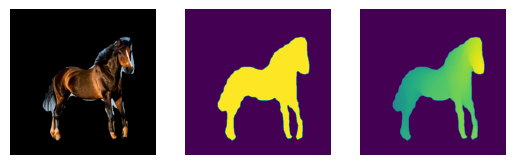

 39%|███████████████████████████                                           | 232/600 [00:01<00:02, 122.79it/s]

tensor(0.2984, device='cuda:0') tensor(0.5268, device='cuda:0')
tensor(0.2868, device='cuda:0') tensor(0.5285, device='cuda:0')
tensor(0.2741, device='cuda:0') tensor(0.5294, device='cuda:0')
tensor(0.2609, device='cuda:0') tensor(0.5314, device='cuda:0')
tensor(0.2459, device='cuda:0') tensor(0.5336, device='cuda:0')
tensor(0.2317, device='cuda:0') tensor(0.5350, device='cuda:0')
tensor(0.2239, device='cuda:0') tensor(0.5360, device='cuda:0')
tensor(0.2233, device='cuda:0') tensor(0.5377, device='cuda:0')
tensor(0.2230, device='cuda:0') tensor(0.5379, device='cuda:0')
tensor(0.2223, device='cuda:0') tensor(0.5374, device='cuda:0')
tensor(0.2219, device='cuda:0') tensor(0.5372, device='cuda:0')
tensor(0.2215, device='cuda:0') tensor(0.5369, device='cuda:0')
tensor(0.2205, device='cuda:0') tensor(0.5368, device='cuda:0')
tensor(0.2199, device='cuda:0') tensor(0.5357, device='cuda:0')
tensor(0.2187, device='cuda:0') tensor(0.5346, device='cuda:0')
tensor(0.2180, device='cuda:0') tensor(0

 43%|██████████████████████████████                                        | 258/600 [00:02<00:02, 120.90it/s]

tensor(0.2180, device='cuda:0') tensor(0.5055, device='cuda:0')
tensor(0.2179, device='cuda:0') tensor(0.5031, device='cuda:0')
tensor(0.2182, device='cuda:0') tensor(0.5009, device='cuda:0')
tensor(0.2188, device='cuda:0') tensor(0.5015, device='cuda:0')
tensor(0.2194, device='cuda:0') tensor(0.5030, device='cuda:0')
tensor(0.2200, device='cuda:0') tensor(0.5054, device='cuda:0')
tensor(0.2211, device='cuda:0') tensor(0.5082, device='cuda:0')
tensor(0.2221, device='cuda:0') tensor(0.5107, device='cuda:0')
tensor(0.2231, device='cuda:0') tensor(0.5112, device='cuda:0')
tensor(0.2241, device='cuda:0') tensor(0.5125, device='cuda:0')
tensor(0.2250, device='cuda:0') tensor(0.5124, device='cuda:0')
tensor(0.2258, device='cuda:0') tensor(0.5117, device='cuda:0')
tensor(0.2266, device='cuda:0') tensor(0.5109, device='cuda:0')
tensor(0.2277, device='cuda:0') tensor(0.5104, device='cuda:0')
tensor(0.2288, device='cuda:0') tensor(0.5101, device='cuda:0')
tensor(0.2304, device='cuda:0') tensor(0

 47%|█████████████████████████████████▏                                    | 284/600 [00:02<00:02, 120.89it/s]

tensor(0.4369, device='cuda:0')
tensor(0.2515, device='cuda:0') tensor(0.4346, device='cuda:0')
tensor(0.2534, device='cuda:0') tensor(0.4344, device='cuda:0')
tensor(0.2552, device='cuda:0') tensor(0.4340, device='cuda:0')
tensor(0.2570, device='cuda:0') tensor(0.4340, device='cuda:0')
tensor(0.2589, device='cuda:0') tensor(0.4338, device='cuda:0')
tensor(0.2602, device='cuda:0') tensor(0.4340, device='cuda:0')
tensor(0.2615, device='cuda:0') tensor(0.4340, device='cuda:0')
tensor(0.2625, device='cuda:0') tensor(0.4341, device='cuda:0')
tensor(0.2631, device='cuda:0') tensor(0.4343, device='cuda:0')
tensor(0.2637, device='cuda:0') tensor(0.4344, device='cuda:0')
tensor(0.2640, device='cuda:0') tensor(0.4341, device='cuda:0')
tensor(0.2640, device='cuda:0') tensor(0.4342, device='cuda:0')
tensor(0.2644, device='cuda:0') tensor(0.4344, device='cuda:0')
tensor(0.2645, device='cuda:0') tensor(0.4343, device='cuda:0')
tensor(0.2646, device='cuda:0') tensor(0.4343, device='cuda:0')
tensor(0

 52%|████████████████████████████████████▏                                 | 310/600 [00:02<00:02, 119.87it/s]

tensor(0.4344, device='cuda:0')
tensor(0.2641, device='cuda:0') tensor(0.4343, device='cuda:0')
tensor(0.2647, device='cuda:0') tensor(0.4341, device='cuda:0')
tensor(0.2650, device='cuda:0') tensor(0.4340, device='cuda:0')
tensor(0.2655, device='cuda:0') tensor(0.4341, device='cuda:0')
tensor(0.2658, device='cuda:0') tensor(0.4341, device='cuda:0')
tensor(0.2664, device='cuda:0') tensor(0.4341, device='cuda:0')
tensor(0.2665, device='cuda:0') tensor(0.4342, device='cuda:0')
tensor(0.2664, device='cuda:0') tensor(0.4342, device='cuda:0')
tensor(0.2662, device='cuda:0') tensor(0.4342, device='cuda:0')
tensor(0.2661, device='cuda:0') tensor(0.4342, device='cuda:0')
tensor(0.2659, device='cuda:0') tensor(0.4343, device='cuda:0')
tensor(0.2658, device='cuda:0') tensor(0.4344, device='cuda:0')
tensor(0.2657, device='cuda:0') tensor(0.4347, device='cuda:0')
tensor(0.2654, device='cuda:0') tensor(0.4347, device='cuda:0')
tensor(0.2650, device='cuda:0') tensor(0.4347, device='cuda:0')
tensor(0

 56%|██████████████████████████████████████▉                               | 334/600 [00:02<00:02, 119.29it/s]

tensor(0.2605, device='cuda:0') tensor(0.4355, device='cuda:0')
tensor(0.2602, device='cuda:0') tensor(0.4357, device='cuda:0')
tensor(0.2596, device='cuda:0') tensor(0.4360, device='cuda:0')
tensor(0.2593, device='cuda:0') tensor(0.4361, device='cuda:0')
tensor(0.2586, device='cuda:0') tensor(0.4363, device='cuda:0')
tensor(0.2581, device='cuda:0') tensor(0.4365, device='cuda:0')
tensor(0.2577, device='cuda:0') tensor(0.4367, device='cuda:0')
tensor(0.2572, device='cuda:0') tensor(0.4369, device='cuda:0')
tensor(0.2566, device='cuda:0') tensor(0.4368, device='cuda:0')
tensor(0.2561, device='cuda:0') tensor(0.4370, device='cuda:0')
tensor(0.2556, device='cuda:0') tensor(0.4371, device='cuda:0')
tensor(0.2548, device='cuda:0') tensor(0.4372, device='cuda:0')
tensor(0.2539, device='cuda:0') tensor(0.4376, device='cuda:0')
tensor(0.2532, device='cuda:0') tensor(0.4377, device='cuda:0')
tensor(0.2522, device='cuda:0') tensor(0.4382, device='cuda:0')
tensor(0.2514, device='cuda:0') tensor(0

 60%|█████████████████████████████████████████▊                            | 358/600 [00:02<00:02, 119.04it/s]

tensor(0.2405, device='cuda:0') tensor(0.5240, device='cuda:0')
tensor(0.2394, device='cuda:0') tensor(0.5426, device='cuda:0')
tensor(0.2383, device='cuda:0') tensor(0.5689, device='cuda:0')
tensor(0.2375, device='cuda:0') tensor(0.5848, device='cuda:0')
tensor(0.2366, device='cuda:0') tensor(0.5858, device='cuda:0')
tensor(0.2356, device='cuda:0') tensor(0.5861, device='cuda:0')
tensor(0.2349, device='cuda:0') tensor(0.5866, device='cuda:0')
tensor(0.2340, device='cuda:0') tensor(0.5875, device='cuda:0')
tensor(0.2332, device='cuda:0') tensor(0.5885, device='cuda:0')
tensor(0.2324, device='cuda:0') tensor(0.5883, device='cuda:0')
tensor(0.2316, device='cuda:0') tensor(0.5838, device='cuda:0')
tensor(0.2308, device='cuda:0') tensor(0.5724, device='cuda:0')
tensor(0.2303, device='cuda:0') tensor(0.5598, device='cuda:0')
tensor(0.2297, device='cuda:0') tensor(0.5530, device='cuda:0')
tensor(0.2291, device='cuda:0') tensor(0.5463, device='cuda:0')
tensor(0.2282, device='cuda:0') tensor(0

 64%|████████████████████████████████████████████▊                         | 384/600 [00:03<00:01, 120.35it/s]

tensor(0.2224, device='cuda:0') tensor(0.5402, device='cuda:0')
tensor(0.2224, device='cuda:0') tensor(0.5429, device='cuda:0')
tensor(0.2223, device='cuda:0') tensor(0.5449, device='cuda:0')
tensor(0.2221, device='cuda:0') tensor(0.5468, device='cuda:0')
tensor(0.2220, device='cuda:0') tensor(0.5490, device='cuda:0')
tensor(0.2220, device='cuda:0') tensor(0.5506, device='cuda:0')
tensor(0.2218, device='cuda:0') tensor(0.5517, device='cuda:0')
tensor(0.2221, device='cuda:0') tensor(0.5529, device='cuda:0')
tensor(0.2223, device='cuda:0') tensor(0.5532, device='cuda:0')
tensor(0.2228, device='cuda:0') tensor(0.5529, device='cuda:0')
tensor(0.2230, device='cuda:0') tensor(0.5522, device='cuda:0')
tensor(0.2232, device='cuda:0') tensor(0.5513, device='cuda:0')
tensor(0.2235, device='cuda:0') tensor(0.5494, device='cuda:0')
tensor(0.2296, device='cuda:0') tensor(0.5480, device='cuda:0')
tensor(0.2455, device='cuda:0') tensor(0.5469, device='cuda:0')
tensor(0.2674, device='cuda:0') tensor(0

100%|██████████████████████████████████████████████████████████████████████| 600/600 [00:04<00:00, 121.66it/s]


/grogu/user/akirchme/art3d_sd_webui/images/horse/1012.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/1012.mp4


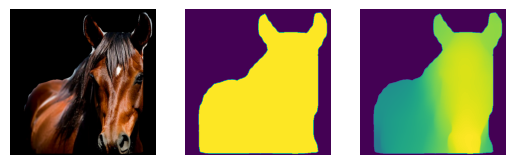

  4%|██▋                                                                    | 23/600 [00:00<00:05, 113.97it/s]

tensor(0.4110, device='cuda:0') tensor(0.5111, device='cuda:0')
tensor(0.4105, device='cuda:0') tensor(0.5111, device='cuda:0')
tensor(0.4082, device='cuda:0') tensor(0.5110, device='cuda:0')
tensor(0.4057, device='cuda:0') tensor(0.5111, device='cuda:0')
tensor(0.4041, device='cuda:0') tensor(0.5111, device='cuda:0')
tensor(0.4029, device='cuda:0') tensor(0.5110, device='cuda:0')
tensor(0.4017, device='cuda:0') tensor(0.5110, device='cuda:0')
tensor(0.4008, device='cuda:0') tensor(0.5110, device='cuda:0')
tensor(0.4002, device='cuda:0') tensor(0.5109, device='cuda:0')
tensor(0.3992, device='cuda:0') tensor(0.5109, device='cuda:0')
tensor(0.3984, device='cuda:0') tensor(0.5109, device='cuda:0')
tensor(0.3975, device='cuda:0') tensor(0.5110, device='cuda:0')
tensor(0.3966, device='cuda:0') tensor(0.5109, device='cuda:0')
tensor(0.3949, device='cuda:0') tensor(0.5110, device='cuda:0')
tensor(0.3925, device='cuda:0') tensor(0.5109, device='cuda:0')
tensor(0.3907, device='cuda:0') tensor(0

  6%|████▏                                                                  | 35/600 [00:00<00:04, 116.26it/s]

tensor(0.3839, device='cuda:0') tensor(0.5115, device='cuda:0')
tensor(0.3835, device='cuda:0') tensor(0.5115, device='cuda:0')
tensor(0.3830, device='cuda:0') tensor(0.5116, device='cuda:0')
tensor(0.3826, device='cuda:0') tensor(0.5116, device='cuda:0')
tensor(0.3818, device='cuda:0') tensor(0.5117, device='cuda:0')
tensor(0.3810, device='cuda:0') tensor(0.5117, device='cuda:0')
tensor(0.3800, device='cuda:0') tensor(0.5117, device='cuda:0')
tensor(0.3790, device='cuda:0') tensor(0.5119, device='cuda:0')
tensor(0.3780, device='cuda:0') tensor(0.5146, device='cuda:0')
tensor(0.3771, device='cuda:0') tensor(0.5180, device='cuda:0')


 15%|██████████▌                                                             | 88/600 [00:01<00:05, 86.50it/s]

tensor(0.3186, device='cuda:0') tensor(0.5188, device='cuda:0')
tensor(0.3181, device='cuda:0') tensor(0.5172, device='cuda:0')
tensor(0.3173, device='cuda:0') tensor(0.5166, device='cuda:0')
tensor(0.3166, device='cuda:0') tensor(0.5167, device='cuda:0')
tensor(0.3160, device='cuda:0') tensor(0.5169, device='cuda:0')
tensor(0.3156, device='cuda:0') tensor(0.5173, device='cuda:0')
tensor(0.3158, device='cuda:0') tensor(0.5174, device='cuda:0')
tensor(0.3157, device='cuda:0') tensor(0.5173, device='cuda:0')
tensor(0.3161, device='cuda:0') tensor(0.5168, device='cuda:0')
tensor(0.3206, device='cuda:0') tensor(0.5165, device='cuda:0')
tensor(0.3247, device='cuda:0') tensor(0.5158, device='cuda:0')
tensor(0.3281, device='cuda:0') tensor(0.5152, device='cuda:0')
tensor(0.3296, device='cuda:0') tensor(0.5144, device='cuda:0')
tensor(0.3310, device='cuda:0') tensor(0.5137, device='cuda:0')
tensor(0.3323, device='cuda:0') tensor(0.5127, device='cuda:0')
tensor(0.3339, device='cuda:0') tensor(0

 38%|██████████████████████████▋                                            | 226/600 [00:03<00:04, 76.68it/s]

tensor(0.2996, device='cuda:0') tensor(0.5366, device='cuda:0')
tensor(0.2993, device='cuda:0') tensor(0.5281, device='cuda:0')
tensor(0.2985, device='cuda:0') tensor(0.5205, device='cuda:0')
tensor(0.2978, device='cuda:0') tensor(0.5147, device='cuda:0')
tensor(0.2972, device='cuda:0') tensor(0.5103, device='cuda:0')
tensor(0.2962, device='cuda:0') tensor(0.5113, device='cuda:0')
tensor(0.2896, device='cuda:0') tensor(0.5126, device='cuda:0')
tensor(0.2823, device='cuda:0') tensor(0.5142, device='cuda:0')
tensor(0.2769, device='cuda:0') tensor(0.5160, device='cuda:0')
tensor(0.2715, device='cuda:0') tensor(0.5179, device='cuda:0')
tensor(0.2673, device='cuda:0') tensor(0.5196, device='cuda:0')
tensor(0.2641, device='cuda:0') tensor(0.5209, device='cuda:0')
tensor(0.2635, device='cuda:0') tensor(0.5223, device='cuda:0')
tensor(0.2635, device='cuda:0') tensor(0.5237, device='cuda:0')
tensor(0.2634, device='cuda:0') tensor(0.5245, device='cuda:0')
tensor(0.2634, device='cuda:0') tensor(0

 42%|█████████████████████████████▌                                         | 250/600 [00:03<00:03, 97.18it/s]

tensor(0.2638, device='cuda:0') tensor(0.5178, device='cuda:0')
tensor(0.2639, device='cuda:0') tensor(0.5165, device='cuda:0')
tensor(0.2643, device='cuda:0') tensor(0.5153, device='cuda:0')
tensor(0.2648, device='cuda:0') tensor(0.5137, device='cuda:0')
tensor(0.2650, device='cuda:0') tensor(0.5119, device='cuda:0')
tensor(0.2658, device='cuda:0') tensor(0.5103, device='cuda:0')
tensor(0.2666, device='cuda:0') tensor(0.5092, device='cuda:0')
tensor(0.2673, device='cuda:0') tensor(0.5088, device='cuda:0')
tensor(0.2682, device='cuda:0') tensor(0.5088, device='cuda:0')
tensor(0.2689, device='cuda:0') tensor(0.5115, device='cuda:0')
tensor(0.2699, device='cuda:0') tensor(0.5153, device='cuda:0')
tensor(0.2707, device='cuda:0') tensor(0.5187, device='cuda:0')
tensor(0.2714, device='cuda:0') tensor(0.5207, device='cuda:0')
tensor(0.2720, device='cuda:0') tensor(0.5234, device='cuda:0')
tensor(0.2727, device='cuda:0') tensor(0.5245, device='cuda:0')
tensor(0.2733, device='cuda:0') tensor(0

 46%|███████████████████████████████▉                                      | 274/600 [00:03<00:03, 107.98it/s]

tensor(0.2816, device='cuda:0') tensor(0.5147, device='cuda:0')
tensor(0.2828, device='cuda:0') tensor(0.5093, device='cuda:0')
tensor(0.2841, device='cuda:0') tensor(0.5054, device='cuda:0')
tensor(0.2856, device='cuda:0') tensor(0.5015, device='cuda:0')
tensor(0.2872, device='cuda:0') tensor(0.4978, device='cuda:0')
tensor(0.2892, device='cuda:0') tensor(0.4950, device='cuda:0')
tensor(0.2911, device='cuda:0') tensor(0.4929, device='cuda:0')
tensor(0.2930, device='cuda:0') tensor(0.4905, device='cuda:0')
tensor(0.2949, device='cuda:0') tensor(0.4903, device='cuda:0')
tensor(0.2968, device='cuda:0') tensor(0.4902, device='cuda:0')
tensor(0.2983, device='cuda:0') tensor(0.4900, device='cuda:0')
tensor(0.3000, device='cuda:0') tensor(0.4898, device='cuda:0')
tensor(0.3013, device='cuda:0') tensor(0.4901, device='cuda:0')
tensor(0.3024, device='cuda:0') tensor(0.4901, device='cuda:0')
tensor(0.3032, device='cuda:0') tensor(0.4903, device='cuda:0')
tensor(0.3039, device='cuda:0') tensor(0

 50%|██████████████████████████████████▊                                   | 298/600 [00:03<00:02, 113.28it/s]

tensor(0.3038, device='cuda:0') tensor(0.4912, device='cuda:0')
tensor(0.3039, device='cuda:0') tensor(0.4913, device='cuda:0')
tensor(0.3042, device='cuda:0') tensor(0.4914, device='cuda:0')
tensor(0.3046, device='cuda:0') tensor(0.4916, device='cuda:0')
tensor(0.3049, device='cuda:0') tensor(0.4918, device='cuda:0')
tensor(0.3054, device='cuda:0') tensor(0.4917, device='cuda:0')
tensor(0.3060, device='cuda:0') tensor(0.4917, device='cuda:0')
tensor(0.3064, device='cuda:0') tensor(0.4917, device='cuda:0')
tensor(0.3068, device='cuda:0') tensor(0.4919, device='cuda:0')
tensor(0.3072, device='cuda:0') tensor(0.4919, device='cuda:0')
tensor(0.3078, device='cuda:0') tensor(0.4919, device='cuda:0')
tensor(0.3080, device='cuda:0') tensor(0.4919, device='cuda:0')
tensor(0.3083, device='cuda:0') tensor(0.4920, device='cuda:0')
tensor(0.3085, device='cuda:0') tensor(0.4920, device='cuda:0')
tensor(0.3085, device='cuda:0') tensor(0.4920, device='cuda:0')
tensor(0.3086, device='cuda:0') tensor(0

 54%|█████████████████████████████████████▌                                | 322/600 [00:03<00:02, 115.87it/s]

tensor(0.3062, device='cuda:0') tensor(0.4926, device='cuda:0')
tensor(0.3058, device='cuda:0') tensor(0.4926, device='cuda:0')
tensor(0.3055, device='cuda:0') tensor(0.4926, device='cuda:0')
tensor(0.3053, device='cuda:0') tensor(0.4927, device='cuda:0')
tensor(0.3049, device='cuda:0') tensor(0.4928, device='cuda:0')
tensor(0.3045, device='cuda:0') tensor(0.4929, device='cuda:0')
tensor(0.3041, device='cuda:0') tensor(0.4930, device='cuda:0')
tensor(0.3037, device='cuda:0') tensor(0.4931, device='cuda:0')
tensor(0.3033, device='cuda:0') tensor(0.4933, device='cuda:0')
tensor(0.3029, device='cuda:0') tensor(0.4933, device='cuda:0')
tensor(0.3026, device='cuda:0') tensor(0.4935, device='cuda:0')
tensor(0.3022, device='cuda:0') tensor(0.4936, device='cuda:0')
tensor(0.3018, device='cuda:0') tensor(0.4937, device='cuda:0')
tensor(0.3014, device='cuda:0') tensor(0.4938, device='cuda:0')
tensor(0.3010, device='cuda:0') tensor(0.4939, device='cuda:0')
tensor(0.3004, device='cuda:0') tensor(0

 58%|████████████████████████████████████████▎                             | 346/600 [00:04<00:02, 117.36it/s]

tensor(0.2919, device='cuda:0') tensor(0.5045, device='cuda:0')
tensor(0.2908, device='cuda:0') tensor(0.5147, device='cuda:0')
tensor(0.2896, device='cuda:0') tensor(0.5244, device='cuda:0')
tensor(0.2884, device='cuda:0') tensor(0.5373, device='cuda:0')
tensor(0.2871, device='cuda:0') tensor(0.5567, device='cuda:0')
tensor(0.2860, device='cuda:0') tensor(0.5952, device='cuda:0')
tensor(0.2845, device='cuda:0') tensor(0.6243, device='cuda:0')
tensor(0.2832, device='cuda:0') tensor(0.6472, device='cuda:0')
tensor(0.2818, device='cuda:0') tensor(0.6621, device='cuda:0')
tensor(0.2803, device='cuda:0') tensor(0.6659, device='cuda:0')
tensor(0.2792, device='cuda:0') tensor(0.6661, device='cuda:0')
tensor(0.2782, device='cuda:0') tensor(0.6666, device='cuda:0')
tensor(0.2773, device='cuda:0') tensor(0.6668, device='cuda:0')
tensor(0.2766, device='cuda:0') tensor(0.6674, device='cuda:0')
tensor(0.2760, device='cuda:0') tensor(0.6676, device='cuda:0')
tensor(0.2754, device='cuda:0') tensor(0

 62%|███████████████████████████████████████████▍                          | 372/600 [00:04<00:01, 119.69it/s]

tensor(0.2673, device='cuda:0') tensor(0.5589, device='cuda:0')
tensor(0.2667, device='cuda:0') tensor(0.5599, device='cuda:0')
tensor(0.2664, device='cuda:0') tensor(0.5609, device='cuda:0')
tensor(0.2660, device='cuda:0') tensor(0.5614, device='cuda:0')
tensor(0.2656, device='cuda:0') tensor(0.5621, device='cuda:0')
tensor(0.2653, device='cuda:0') tensor(0.5630, device='cuda:0')
tensor(0.2648, device='cuda:0') tensor(0.5641, device='cuda:0')
tensor(0.2644, device='cuda:0') tensor(0.5655, device='cuda:0')
tensor(0.2639, device='cuda:0') tensor(0.5669, device='cuda:0')
tensor(0.2636, device='cuda:0') tensor(0.5682, device='cuda:0')
tensor(0.2635, device='cuda:0') tensor(0.5695, device='cuda:0')
tensor(0.2634, device='cuda:0') tensor(0.5706, device='cuda:0')
tensor(0.2634, device='cuda:0') tensor(0.5720, device='cuda:0')
tensor(0.2635, device='cuda:0') tensor(0.5729, device='cuda:0')
tensor(0.2635, device='cuda:0') tensor(0.5735, device='cuda:0')
tensor(0.2636, device='cuda:0') tensor(0

 97%|████████████████████████████████████████████████████████████████████▉  | 583/600 [00:07<00:00, 80.93it/s]

tensor(0.3552, device='cuda:0') tensor(0.5120, device='cuda:0')
tensor(0.3558, device='cuda:0') tensor(0.5118, device='cuda:0')
tensor(0.3564, device='cuda:0') tensor(0.5117, device='cuda:0')
tensor(0.3570, device='cuda:0') tensor(0.5116, device='cuda:0')
tensor(0.3576, device='cuda:0') tensor(0.5116, device='cuda:0')
tensor(0.3581, device='cuda:0') tensor(0.5115, device='cuda:0')
tensor(0.3589, device='cuda:0') tensor(0.5114, device='cuda:0')
tensor(0.3597, device='cuda:0') tensor(0.5114, device='cuda:0')
tensor(0.3604, device='cuda:0') tensor(0.5113, device='cuda:0')
tensor(0.3613, device='cuda:0') tensor(0.5113, device='cuda:0')
tensor(0.3621, device='cuda:0') tensor(0.5112, device='cuda:0')
tensor(0.3628, device='cuda:0') tensor(0.5112, device='cuda:0')
tensor(0.3635, device='cuda:0') tensor(0.5112, device='cuda:0')
tensor(0.3646, device='cuda:0') tensor(0.5111, device='cuda:0')
tensor(0.3656, device='cuda:0') tensor(0.5111, device='cuda:0')
tensor(0.3676, device='cuda:0') tensor(0

100%|███████████████████████████████████████████████████████████████████████| 600/600 [00:07<00:00, 77.73it/s]


tensor(0.5112, device='cuda:0')
tensor(0.3918, device='cuda:0') tensor(0.5112, device='cuda:0')
tensor(0.3953, device='cuda:0') tensor(0.5112, device='cuda:0')
tensor(0.3983, device='cuda:0') tensor(0.5112, device='cuda:0')
tensor(0.4009, device='cuda:0') tensor(0.5112, device='cuda:0')
tensor(0.4039, device='cuda:0') tensor(0.5112, device='cuda:0')
tensor(0.4076, device='cuda:0') tensor(0.5112, device='cuda:0')
tensor(0.4100, device='cuda:0') tensor(0.5111, device='cuda:0')
/grogu/user/akirchme/art3d_sd_webui/images/horse/330.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/330.mp4


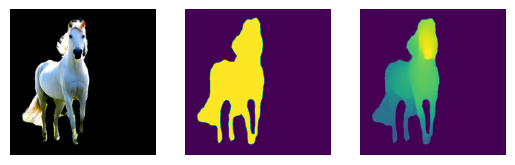

 46%|████████████████████████████████▍                                     | 278/600 [00:02<00:02, 116.33it/s]

tensor(0.3131, device='cuda:0') tensor(0.5100, device='cuda:0')
tensor(0.3143, device='cuda:0') tensor(0.4913, device='cuda:0')
tensor(0.3156, device='cuda:0') tensor(0.4762, device='cuda:0')
tensor(0.3166, device='cuda:0') tensor(0.4661, device='cuda:0')
tensor(0.3173, device='cuda:0') tensor(0.4658, device='cuda:0')
tensor(0.3181, device='cuda:0') tensor(0.4657, device='cuda:0')
tensor(0.3189, device='cuda:0') tensor(0.4654, device='cuda:0')
tensor(0.3194, device='cuda:0') tensor(0.4654, device='cuda:0')
tensor(0.3197, device='cuda:0') tensor(0.4653, device='cuda:0')
tensor(0.3199, device='cuda:0') tensor(0.4650, device='cuda:0')
tensor(0.3198, device='cuda:0') tensor(0.4647, device='cuda:0')
tensor(0.3200, device='cuda:0') tensor(0.4648, device='cuda:0')
tensor(0.3201, device='cuda:0') tensor(0.4647, device='cuda:0')
tensor(0.3202, device='cuda:0') tensor(0.4647, device='cuda:0')
tensor(0.3201, device='cuda:0') tensor(0.4646, device='cuda:0')
tensor(0.3196, device='cuda:0') tensor(0

 50%|███████████████████████████████████▏                                  | 302/600 [00:02<00:02, 117.43it/s]

tensor(0.3193, device='cuda:0') tensor(0.4634, device='cuda:0')
tensor(0.3192, device='cuda:0') tensor(0.4634, device='cuda:0')
tensor(0.3194, device='cuda:0') tensor(0.4634, device='cuda:0')
tensor(0.3193, device='cuda:0') tensor(0.4635, device='cuda:0')
tensor(0.3194, device='cuda:0') tensor(0.4634, device='cuda:0')
tensor(0.3195, device='cuda:0') tensor(0.4633, device='cuda:0')
tensor(0.3200, device='cuda:0') tensor(0.4632, device='cuda:0')
tensor(0.3200, device='cuda:0') tensor(0.4631, device='cuda:0')
tensor(0.3200, device='cuda:0') tensor(0.4630, device='cuda:0')
tensor(0.3202, device='cuda:0') tensor(0.4628, device='cuda:0')
tensor(0.3204, device='cuda:0') tensor(0.4626, device='cuda:0')
tensor(0.3203, device='cuda:0') tensor(0.4623, device='cuda:0')
tensor(0.3204, device='cuda:0') tensor(0.4623, device='cuda:0')
tensor(0.3205, device='cuda:0') tensor(0.4622, device='cuda:0')
tensor(0.3206, device='cuda:0') tensor(0.4622, device='cuda:0')
tensor(0.3205, device='cuda:0') tensor(0

 54%|██████████████████████████████████████                                | 326/600 [00:02<00:02, 117.72it/s]

tensor(0.3199, device='cuda:0') tensor(0.4620, device='cuda:0')
tensor(0.3200, device='cuda:0') tensor(0.4622, device='cuda:0')
tensor(0.3202, device='cuda:0') tensor(0.4623, device='cuda:0')
tensor(0.3203, device='cuda:0') tensor(0.4627, device='cuda:0')
tensor(0.3203, device='cuda:0') tensor(0.4630, device='cuda:0')
tensor(0.3209, device='cuda:0') tensor(0.4631, device='cuda:0')
tensor(0.3214, device='cuda:0') tensor(0.4635, device='cuda:0')
tensor(0.3219, device='cuda:0') tensor(0.4638, device='cuda:0')
tensor(0.3223, device='cuda:0') tensor(0.4639, device='cuda:0')
tensor(0.3225, device='cuda:0') tensor(0.4642, device='cuda:0')
tensor(0.3227, device='cuda:0') tensor(0.4644, device='cuda:0')
tensor(0.3225, device='cuda:0') tensor(0.4647, device='cuda:0')
tensor(0.3225, device='cuda:0') tensor(0.4645, device='cuda:0')
tensor(0.3221, device='cuda:0') tensor(0.4648, device='cuda:0')
tensor(0.3216, device='cuda:0') tensor(0.4649, device='cuda:0')
tensor(0.3208, device='cuda:0') tensor(0

 58%|████████████████████████████████████████▊                             | 350/600 [00:02<00:02, 118.07it/s]

tensor(0.3129, device='cuda:0') tensor(0.4873, device='cuda:0')
tensor(0.3119, device='cuda:0') tensor(0.4931, device='cuda:0')
tensor(0.3112, device='cuda:0') tensor(0.4995, device='cuda:0')
tensor(0.3105, device='cuda:0') tensor(0.5039, device='cuda:0')
tensor(0.3100, device='cuda:0') tensor(0.5080, device='cuda:0')
tensor(0.3095, device='cuda:0') tensor(0.5096, device='cuda:0')
tensor(0.3087, device='cuda:0') tensor(0.5099, device='cuda:0')
tensor(0.3082, device='cuda:0') tensor(0.5104, device='cuda:0')
tensor(0.3076, device='cuda:0') tensor(0.5111, device='cuda:0')
tensor(0.3069, device='cuda:0') tensor(0.5118, device='cuda:0')
tensor(0.3066, device='cuda:0') tensor(0.5126, device='cuda:0')
tensor(0.3063, device='cuda:0') tensor(0.5121, device='cuda:0')
tensor(0.3058, device='cuda:0') tensor(0.5105, device='cuda:0')
tensor(0.3056, device='cuda:0') tensor(0.5082, device='cuda:0')
tensor(0.3054, device='cuda:0') tensor(0.5051, device='cuda:0')
tensor(0.3052, device='cuda:0') tensor(0

 62%|███████████████████████████████████████████▋                          | 374/600 [00:03<00:01, 118.25it/s]

tensor(0.3032, device='cuda:0') tensor(0.4996, device='cuda:0')
tensor(0.3032, device='cuda:0') tensor(0.5012, device='cuda:0')
tensor(0.3034, device='cuda:0') tensor(0.5024, device='cuda:0')
tensor(0.3038, device='cuda:0') tensor(0.5036, device='cuda:0')
tensor(0.3042, device='cuda:0') tensor(0.5050, device='cuda:0')
tensor(0.3043, device='cuda:0') tensor(0.5067, device='cuda:0')
tensor(0.3045, device='cuda:0') tensor(0.5082, device='cuda:0')
tensor(0.3048, device='cuda:0') tensor(0.5094, device='cuda:0')
tensor(0.3055, device='cuda:0') tensor(0.5104, device='cuda:0')
tensor(0.3059, device='cuda:0') tensor(0.5119, device='cuda:0')
tensor(0.3067, device='cuda:0') tensor(0.5134, device='cuda:0')
tensor(0.3075, device='cuda:0') tensor(0.5145, device='cuda:0')
tensor(0.3082, device='cuda:0') tensor(0.5151, device='cuda:0')
tensor(0.3089, device='cuda:0') tensor(0.5150, device='cuda:0')
tensor(0.3097, device='cuda:0') tensor(0.5145, device='cuda:0')
tensor(0.3106, device='cuda:0') tensor(0

100%|██████████████████████████████████████████████████████████████████████| 600/600 [00:05<00:00, 118.61it/s]


/grogu/user/akirchme/art3d_sd_webui/images/horse/1473.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/1473.mp4


 39%|███████████████████████████▍                                          | 235/600 [00:01<00:03, 120.86it/s]

tensor(0.2992, device='cuda:0') tensor(0.5674, device='cuda:0')
tensor(0.2782, device='cuda:0') tensor(0.5676, device='cuda:0')
tensor(0.2683, device='cuda:0') tensor(0.5684, device='cuda:0')
tensor(0.2683, device='cuda:0') tensor(0.5692, device='cuda:0')
tensor(0.2679, device='cuda:0') tensor(0.5696, device='cuda:0')
tensor(0.2673, device='cuda:0') tensor(0.5695, device='cuda:0')
tensor(0.2670, device='cuda:0') tensor(0.5687, device='cuda:0')
tensor(0.2667, device='cuda:0') tensor(0.5679, device='cuda:0')
tensor(0.2666, device='cuda:0') tensor(0.5655, device='cuda:0')
tensor(0.2665, device='cuda:0') tensor(0.5639, device='cuda:0')
tensor(0.2667, device='cuda:0') tensor(0.5625, device='cuda:0')
tensor(0.2668, device='cuda:0') tensor(0.5605, device='cuda:0')
tensor(0.2664, device='cuda:0') tensor(0.5585, device='cuda:0')
tensor(0.2664, device='cuda:0') tensor(0.5556, device='cuda:0')
tensor(0.2663, device='cuda:0') tensor(0.5528, device='cuda:0')
tensor(0.2664, device='cuda:0') tensor(0

 44%|██████████████████████████████▍                                       | 261/600 [00:02<00:02, 121.80it/s]

tensor(0.2701, device='cuda:0') tensor(0.5498, device='cuda:0')
tensor(0.2706, device='cuda:0') tensor(0.5539, device='cuda:0')
tensor(0.2707, device='cuda:0') tensor(0.5578, device='cuda:0')
tensor(0.2709, device='cuda:0') tensor(0.5643, device='cuda:0')
tensor(0.2714, device='cuda:0') tensor(0.5698, device='cuda:0')
tensor(0.2720, device='cuda:0') tensor(0.5736, device='cuda:0')
tensor(0.2723, device='cuda:0') tensor(0.5738, device='cuda:0')
tensor(0.2725, device='cuda:0') tensor(0.5731, device='cuda:0')
tensor(0.2731, device='cuda:0') tensor(0.5725, device='cuda:0')
tensor(0.2736, device='cuda:0') tensor(0.5718, device='cuda:0')
tensor(0.2744, device='cuda:0') tensor(0.5709, device='cuda:0')
tensor(0.2754, device='cuda:0') tensor(0.5702, device='cuda:0')
tensor(0.2764, device='cuda:0') tensor(0.5668, device='cuda:0')
tensor(0.2773, device='cuda:0') tensor(0.5542, device='cuda:0')
tensor(0.2781, device='cuda:0') tensor(0.5346, device='cuda:0')
tensor(0.2793, device='cuda:0') tensor(0

 48%|█████████████████████████████████▍                                    | 287/600 [00:02<00:02, 122.41it/s]

tensor(0.2917, device='cuda:0') tensor(0.4342, device='cuda:0')
tensor(0.2926, device='cuda:0') tensor(0.4340, device='cuda:0')
tensor(0.2932, device='cuda:0') tensor(0.4336, device='cuda:0')
tensor(0.2933, device='cuda:0') tensor(0.4334, device='cuda:0')
tensor(0.2933, device='cuda:0') tensor(0.4333, device='cuda:0')
tensor(0.2937, device='cuda:0') tensor(0.4331, device='cuda:0')
tensor(0.2936, device='cuda:0') tensor(0.4329, device='cuda:0')
tensor(0.2935, device='cuda:0') tensor(0.4326, device='cuda:0')
tensor(0.2934, device='cuda:0') tensor(0.4325, device='cuda:0')
tensor(0.2932, device='cuda:0') tensor(0.4323, device='cuda:0')
tensor(0.2934, device='cuda:0') tensor(0.4323, device='cuda:0')
tensor(0.2931, device='cuda:0') tensor(0.4323, device='cuda:0')
tensor(0.2927, device='cuda:0') tensor(0.4322, device='cuda:0')
tensor(0.2925, device='cuda:0') tensor(0.4322, device='cuda:0')
tensor(0.2918, device='cuda:0') tensor(0.4321, device='cuda:0')
tensor(0.2915, device='cuda:0') tensor(0

 52%|████████████████████████████████████▌                                 | 313/600 [00:02<00:02, 122.77it/s]

tensor(0.4320, device='cuda:0')
tensor(0.2922, device='cuda:0') tensor(0.4322, device='cuda:0')
tensor(0.2922, device='cuda:0') tensor(0.4322, device='cuda:0')
tensor(0.2923, device='cuda:0') tensor(0.4322, device='cuda:0')
tensor(0.2923, device='cuda:0') tensor(0.4321, device='cuda:0')
tensor(0.2923, device='cuda:0') tensor(0.4322, device='cuda:0')
tensor(0.2920, device='cuda:0') tensor(0.4322, device='cuda:0')
tensor(0.2918, device='cuda:0') tensor(0.4321, device='cuda:0')
tensor(0.2915, device='cuda:0') tensor(0.4322, device='cuda:0')
tensor(0.2913, device='cuda:0') tensor(0.4322, device='cuda:0')
tensor(0.2913, device='cuda:0') tensor(0.4324, device='cuda:0')
tensor(0.2912, device='cuda:0') tensor(0.4325, device='cuda:0')
tensor(0.2910, device='cuda:0') tensor(0.4328, device='cuda:0')
tensor(0.2906, device='cuda:0') tensor(0.4328, device='cuda:0')
tensor(0.2906, device='cuda:0') tensor(0.4327, device='cuda:0')
tensor(0.2905, device='cuda:0') tensor(0.4327, device='cuda:0')
tensor(0

 56%|███████████████████████████████████████▌                              | 339/600 [00:02<00:02, 120.43it/s]

tensor(0.2887, device='cuda:0') tensor(0.4352, device='cuda:0')
tensor(0.2886, device='cuda:0') tensor(0.4356, device='cuda:0')
tensor(0.2881, device='cuda:0') tensor(0.4358, device='cuda:0')
tensor(0.2874, device='cuda:0') tensor(0.4357, device='cuda:0')
tensor(0.2867, device='cuda:0') tensor(0.4357, device='cuda:0')
tensor(0.2860, device='cuda:0') tensor(0.4359, device='cuda:0')
tensor(0.2854, device='cuda:0') tensor(0.4361, device='cuda:0')
tensor(0.2847, device='cuda:0') tensor(0.4361, device='cuda:0')
tensor(0.2839, device='cuda:0') tensor(0.4362, device='cuda:0')
tensor(0.2832, device='cuda:0') tensor(0.4361, device='cuda:0')
tensor(0.2826, device='cuda:0') tensor(0.4362, device='cuda:0')
tensor(0.2818, device='cuda:0') tensor(0.4377, device='cuda:0')
tensor(0.2812, device='cuda:0') tensor(0.4399, device='cuda:0')
tensor(0.2800, device='cuda:0') tensor(0.4427, device='cuda:0')
tensor(0.2794, device='cuda:0') tensor(0.4458, device='cuda:0')
tensor(0.2784, device='cuda:0') tensor(0

 61%|██████████████████████████████████████████▍                           | 364/600 [00:02<00:01, 119.36it/s]

tensor(0.2725, device='cuda:0') tensor(0.4744, device='cuda:0')
tensor(0.2720, device='cuda:0') tensor(0.4755, device='cuda:0')
tensor(0.2716, device='cuda:0') tensor(0.4758, device='cuda:0')
tensor(0.2711, device='cuda:0') tensor(0.4753, device='cuda:0')
tensor(0.2706, device='cuda:0') tensor(0.4749, device='cuda:0')
tensor(0.2704, device='cuda:0') tensor(0.4725, device='cuda:0')
tensor(0.2703, device='cuda:0') tensor(0.4717, device='cuda:0')
tensor(0.2702, device='cuda:0') tensor(0.4693, device='cuda:0')
tensor(0.2696, device='cuda:0') tensor(0.4665, device='cuda:0')
tensor(0.2692, device='cuda:0') tensor(0.4641, device='cuda:0')
tensor(0.2688, device='cuda:0') tensor(0.4633, device='cuda:0')
tensor(0.2687, device='cuda:0') tensor(0.4640, device='cuda:0')
tensor(0.2684, device='cuda:0') tensor(0.4657, device='cuda:0')
tensor(0.2683, device='cuda:0') tensor(0.4673, device='cuda:0')
tensor(0.2682, device='cuda:0') tensor(0.4683, device='cuda:0')
tensor(0.2681, device='cuda:0') tensor(0

 65%|█████████████████████████████████████████████▎                        | 388/600 [00:03<00:01, 118.86it/s]

tensor(0.2703, device='cuda:0') tensor(0.4840, device='cuda:0')
tensor(0.2709, device='cuda:0') tensor(0.4859, device='cuda:0')
tensor(0.2714, device='cuda:0') tensor(0.4871, device='cuda:0')
tensor(0.2722, device='cuda:0') tensor(0.4878, device='cuda:0')
tensor(0.2729, device='cuda:0') tensor(0.4887, device='cuda:0')
tensor(0.2733, device='cuda:0') tensor(0.4888, device='cuda:0')
tensor(0.2740, device='cuda:0') tensor(0.4888, device='cuda:0')
tensor(0.2770, device='cuda:0') tensor(0.4885, device='cuda:0')
tensor(0.2810, device='cuda:0') tensor(0.4879, device='cuda:0')
tensor(0.2865, device='cuda:0') tensor(0.4876, device='cuda:0')
tensor(0.2938, device='cuda:0') tensor(0.4873, device='cuda:0')
tensor(0.3003, device='cuda:0') tensor(0.4876, device='cuda:0')
tensor(0.3063, device='cuda:0') tensor(0.4880, device='cuda:0')
tensor(0.3099, device='cuda:0') tensor(0.4880, device='cuda:0')
tensor(0.3112, device='cuda:0') tensor(0.4880, device='cuda:0')
tensor(0.3121, device='cuda:0') tensor(0

100%|██████████████████████████████████████████████████████████████████████| 600/600 [00:04<00:00, 123.25it/s]


/grogu/user/akirchme/art3d_sd_webui/images/horse/1801.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/1801.mp4


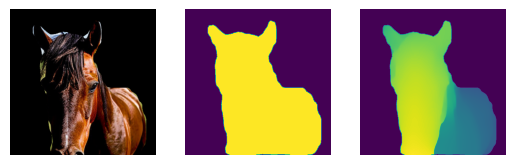

  4%|██▊                                                                    | 24/600 [00:00<00:04, 115.72it/s]

tensor(0.2581, device='cuda:0') tensor(0.4903, device='cuda:0')
tensor(0.2577, device='cuda:0') tensor(0.4903, device='cuda:0')
tensor(0.2571, device='cuda:0') tensor(0.4903, device='cuda:0')
tensor(0.2568, device='cuda:0') tensor(0.4903, device='cuda:0')
tensor(0.2564, device='cuda:0') tensor(0.4903, device='cuda:0')
tensor(0.2560, device='cuda:0') tensor(0.4904, device='cuda:0')
tensor(0.2554, device='cuda:0') tensor(0.4905, device='cuda:0')
tensor(0.2548, device='cuda:0') tensor(0.4905, device='cuda:0')
tensor(0.2541, device='cuda:0') tensor(0.4906, device='cuda:0')
tensor(0.2535, device='cuda:0') tensor(0.4907, device='cuda:0')
tensor(0.2531, device='cuda:0') tensor(0.4908, device='cuda:0')
tensor(0.2526, device='cuda:0') tensor(0.4909, device='cuda:0')
tensor(0.2525, device='cuda:0') tensor(0.4908, device='cuda:0')
tensor(0.2525, device='cuda:0') tensor(0.4909, device='cuda:0')
tensor(0.2525, device='cuda:0') tensor(0.4909, device='cuda:0')
tensor(0.2526, device='cuda:0') tensor(0

  8%|█████▊                                                                 | 49/600 [00:00<00:04, 118.59it/s]

tensor(0.2540, device='cuda:0') tensor(0.4923, device='cuda:0')
tensor(0.2535, device='cuda:0') tensor(0.4922, device='cuda:0')
tensor(0.2527, device='cuda:0') tensor(0.4921, device='cuda:0')
tensor(0.2519, device='cuda:0') tensor(0.4921, device='cuda:0')
tensor(0.2510, device='cuda:0') tensor(0.4920, device='cuda:0')
tensor(0.2497, device='cuda:0') tensor(0.4922, device='cuda:0')
tensor(0.2486, device='cuda:0') tensor(0.4924, device='cuda:0')
tensor(0.2474, device='cuda:0') tensor(0.4923, device='cuda:0')
tensor(0.2463, device='cuda:0') tensor(0.4942, device='cuda:0')
tensor(0.2448, device='cuda:0') tensor(0.4977, device='cuda:0')
tensor(0.2435, device='cuda:0') tensor(0.5024, device='cuda:0')
tensor(0.2423, device='cuda:0') tensor(0.5103, device='cuda:0')
tensor(0.2412, device='cuda:0') tensor(0.5171, device='cuda:0')
tensor(0.2402, device='cuda:0') tensor(0.5225, device='cuda:0')
tensor(0.2394, device='cuda:0') tensor(0.5296, device='cuda:0')
tensor(0.2385, device='cuda:0') tensor(0

 12%|████████▊                                                              | 74/600 [00:00<00:04, 120.15it/s]

tensor(0.2340, device='cuda:0') tensor(0.5283, device='cuda:0')
tensor(0.2336, device='cuda:0') tensor(0.5180, device='cuda:0')
tensor(0.2334, device='cuda:0') tensor(0.5122, device='cuda:0')
tensor(0.2331, device='cuda:0') tensor(0.5048, device='cuda:0')
tensor(0.2328, device='cuda:0') tensor(0.5007, device='cuda:0')
tensor(0.2324, device='cuda:0') tensor(0.4986, device='cuda:0')
tensor(0.2320, device='cuda:0') tensor(0.4981, device='cuda:0')
tensor(0.2317, device='cuda:0') tensor(0.4978, device='cuda:0')
tensor(0.2311, device='cuda:0') tensor(0.4983, device='cuda:0')
tensor(0.2308, device='cuda:0') tensor(0.4988, device='cuda:0')
tensor(0.2307, device='cuda:0') tensor(0.4986, device='cuda:0')
tensor(0.2305, device='cuda:0') tensor(0.4991, device='cuda:0')
tensor(0.2303, device='cuda:0') tensor(0.4991, device='cuda:0')
tensor(0.2303, device='cuda:0') tensor(0.4997, device='cuda:0')
tensor(0.2303, device='cuda:0') tensor(0.5001, device='cuda:0')
tensor(0.2303, device='cuda:0') tensor(0

 14%|██████████▎                                                            | 87/600 [00:00<00:04, 120.93it/s]

tensor(0.2327, device='cuda:0') tensor(0.5077, device='cuda:0')
tensor(0.2332, device='cuda:0') tensor(0.5077, device='cuda:0')
tensor(0.2369, device='cuda:0') tensor(0.5074, device='cuda:0')
tensor(0.2450, device='cuda:0') tensor(0.5070, device='cuda:0')
tensor(0.2564, device='cuda:0') tensor(0.5064, device='cuda:0')
tensor(0.2640, device='cuda:0') tensor(0.5058, device='cuda:0')
tensor(0.2737, device='cuda:0') tensor(0.5053, device='cuda:0')
tensor(0.2808, device='cuda:0') tensor(0.5047, device='cuda:0')
tensor(0.2831, device='cuda:0') tensor(0.5043, device='cuda:0')
tensor(0.2838, device='cuda:0') tensor(0.5087, device='cuda:0')
tensor(0.2844, device='cuda:0') tensor(0.5185, device='cuda:0')
tensor(0.2850, device='cuda:0') tensor(0.5337, device='cuda:0')
tensor(0.2859, device='cuda:0') tensor(0.5539, device='cuda:0')
tensor(0.2863, device='cuda:0') tensor(0.5792, device='cuda:0')
tensor(0.2869, device='cuda:0') tensor(0.6153, device='cuda:0')
tensor(0.2874, device='cuda:0') tensor(0

 40%|████████████████████████████▊                                          | 243/600 [00:02<00:04, 79.76it/s]

tensor(0.4092, device='cuda:0') tensor(0.5200, device='cuda:0')
tensor(0.4091, device='cuda:0') tensor(0.5195, device='cuda:0')
tensor(0.4090, device='cuda:0') tensor(0.5190, device='cuda:0')
tensor(0.4090, device='cuda:0') tensor(0.5187, device='cuda:0')
tensor(0.4090, device='cuda:0') tensor(0.5187, device='cuda:0')
tensor(0.4089, device='cuda:0') tensor(0.5187, device='cuda:0')
tensor(0.4089, device='cuda:0') tensor(0.5192, device='cuda:0')


 47%|█████████████████████████████████▎                                     | 282/600 [00:03<00:03, 94.71it/s]

tensor(0.4236, device='cuda:0') tensor(0.5195, device='cuda:0')
tensor(0.4243, device='cuda:0') tensor(0.5187, device='cuda:0')
tensor(0.4250, device='cuda:0') tensor(0.5185, device='cuda:0')
tensor(0.4255, device='cuda:0') tensor(0.5182, device='cuda:0')
tensor(0.4262, device='cuda:0') tensor(0.5181, device='cuda:0')
tensor(0.4269, device='cuda:0') tensor(0.5176, device='cuda:0')
tensor(0.4274, device='cuda:0') tensor(0.5171, device='cuda:0')
tensor(0.4280, device='cuda:0') tensor(0.5161, device='cuda:0')
tensor(0.4286, device='cuda:0') tensor(0.5159, device='cuda:0')
tensor(0.4290, device='cuda:0') tensor(0.5158, device='cuda:0')
tensor(0.4296, device='cuda:0') tensor(0.5158, device='cuda:0')
tensor(0.4299, device='cuda:0') tensor(0.5158, device='cuda:0')
tensor(0.4302, device='cuda:0') tensor(0.5158, device='cuda:0')
tensor(0.4304, device='cuda:0') tensor(0.5158, device='cuda:0')
tensor(0.4307, device='cuda:0') tensor(0.5158, device='cuda:0')
tensor(0.4308, device='cuda:0') tensor(0

 51%|███████████████████████████████████▋                                  | 306/600 [00:03<00:02, 107.10it/s]

tensor(0.4301, device='cuda:0') tensor(0.5158, device='cuda:0')
tensor(0.4302, device='cuda:0') tensor(0.5157, device='cuda:0')
tensor(0.4303, device='cuda:0') tensor(0.5157, device='cuda:0')
tensor(0.4305, device='cuda:0') tensor(0.5157, device='cuda:0')
tensor(0.4308, device='cuda:0') tensor(0.5156, device='cuda:0')
tensor(0.4312, device='cuda:0') tensor(0.5155, device='cuda:0')
tensor(0.4317, device='cuda:0') tensor(0.5155, device='cuda:0')
tensor(0.4324, device='cuda:0') tensor(0.5154, device='cuda:0')
tensor(0.4330, device='cuda:0') tensor(0.5154, device='cuda:0')
tensor(0.4336, device='cuda:0') tensor(0.5153, device='cuda:0')
tensor(0.4342, device='cuda:0') tensor(0.5153, device='cuda:0')
tensor(0.4347, device='cuda:0') tensor(0.5153, device='cuda:0')
tensor(0.4354, device='cuda:0') tensor(0.5152, device='cuda:0')
tensor(0.4359, device='cuda:0') tensor(0.5152, device='cuda:0')
tensor(0.4362, device='cuda:0') tensor(0.5152, device='cuda:0')
tensor(0.4362, device='cuda:0') tensor(0

 55%|██████████████████████████████████████▌                               | 330/600 [00:03<00:02, 113.07it/s]

tensor(0.4341, device='cuda:0') tensor(0.5147, device='cuda:0')
tensor(0.4338, device='cuda:0') tensor(0.5147, device='cuda:0')
tensor(0.4339, device='cuda:0') tensor(0.5146, device='cuda:0')
tensor(0.4340, device='cuda:0') tensor(0.5146, device='cuda:0')
tensor(0.4341, device='cuda:0') tensor(0.5145, device='cuda:0')
tensor(0.4342, device='cuda:0') tensor(0.5144, device='cuda:0')
tensor(0.4343, device='cuda:0') tensor(0.5144, device='cuda:0')
tensor(0.4342, device='cuda:0') tensor(0.5144, device='cuda:0')
tensor(0.4342, device='cuda:0') tensor(0.5144, device='cuda:0')
tensor(0.4342, device='cuda:0') tensor(0.5144, device='cuda:0')
tensor(0.4341, device='cuda:0') tensor(0.5144, device='cuda:0')
tensor(0.4341, device='cuda:0') tensor(0.5145, device='cuda:0')
tensor(0.4340, device='cuda:0') tensor(0.5145, device='cuda:0')
tensor(0.4338, device='cuda:0') tensor(0.5144, device='cuda:0')
tensor(0.4337, device='cuda:0') tensor(0.5143, device='cuda:0')
tensor(0.4336, device='cuda:0') tensor(0

 90%|███████████████████████████████████████████████████████████████▋       | 538/600 [00:06<00:00, 86.66it/s]

tensor(0.2894, device='cuda:0') tensor(0.6072, device='cuda:0')
tensor(0.2555, device='cuda:0') tensor(0.6081, device='cuda:0')
tensor(0.2347, device='cuda:0') tensor(0.6090, device='cuda:0')
tensor(0.2331, device='cuda:0') tensor(0.6094, device='cuda:0')
tensor(0.2331, device='cuda:0') tensor(0.6101, device='cuda:0')
tensor(0.2331, device='cuda:0') tensor(0.6103, device='cuda:0')
tensor(0.2330, device='cuda:0') tensor(0.6102, device='cuda:0')
tensor(0.2330, device='cuda:0') tensor(0.6101, device='cuda:0')
tensor(0.2330, device='cuda:0') tensor(0.6100, device='cuda:0')
tensor(0.2330, device='cuda:0') tensor(0.6099, device='cuda:0')
tensor(0.2331, device='cuda:0') tensor(0.6096, device='cuda:0')
tensor(0.2331, device='cuda:0') tensor(0.6092, device='cuda:0')
tensor(0.2331, device='cuda:0') tensor(0.6085, device='cuda:0')
tensor(0.2331, device='cuda:0') tensor(0.6076, device='cuda:0')
tensor(0.2331, device='cuda:0') tensor(0.6066, device='cuda:0')
tensor(0.2334, device='cuda:0') tensor(0

 94%|█████████████████████████████████████████████████████████████████▌    | 562/600 [00:06<00:00, 102.52it/s]

tensor(0.2381, device='cuda:0') tensor(0.6117, device='cuda:0')
tensor(0.2386, device='cuda:0') tensor(0.6241, device='cuda:0')
tensor(0.2393, device='cuda:0') tensor(0.6436, device='cuda:0')
tensor(0.2402, device='cuda:0') tensor(0.6728, device='cuda:0')
tensor(0.2405, device='cuda:0') tensor(0.7074, device='cuda:0')
tensor(0.2408, device='cuda:0') tensor(0.7288, device='cuda:0')
tensor(0.2412, device='cuda:0') tensor(0.7388, device='cuda:0')
tensor(0.2416, device='cuda:0') tensor(0.7442, device='cuda:0')
tensor(0.2420, device='cuda:0') tensor(0.7441, device='cuda:0')
tensor(0.2424, device='cuda:0') tensor(0.7437, device='cuda:0')
tensor(0.2430, device='cuda:0') tensor(0.7434, device='cuda:0')
tensor(0.2436, device='cuda:0') tensor(0.7431, device='cuda:0')
tensor(0.2442, device='cuda:0') tensor(0.7426, device='cuda:0')
tensor(0.2449, device='cuda:0') tensor(0.7374, device='cuda:0')
tensor(0.2457, device='cuda:0') tensor(0.7180, device='cuda:0')
tensor(0.2463, device='cuda:0') tensor(0

 98%|████████████████████████████████████████████████████████████████████▌ | 588/600 [00:06<00:00, 113.08it/s]

tensor(0.2532, device='cuda:0') tensor(0.4918, device='cuda:0')
tensor(0.2540, device='cuda:0') tensor(0.4916, device='cuda:0')
tensor(0.2546, device='cuda:0') tensor(0.4914, device='cuda:0')
tensor(0.2553, device='cuda:0') tensor(0.4912, device='cuda:0')
tensor(0.2558, device='cuda:0') tensor(0.4911, device='cuda:0')
tensor(0.2563, device='cuda:0') tensor(0.4910, device='cuda:0')
tensor(0.2566, device='cuda:0') tensor(0.4909, device='cuda:0')
tensor(0.2569, device='cuda:0') tensor(0.4909, device='cuda:0')
tensor(0.2571, device='cuda:0') tensor(0.4908, device='cuda:0')
tensor(0.2573, device='cuda:0') tensor(0.4908, device='cuda:0')
tensor(0.2575, device='cuda:0') tensor(0.4907, device='cuda:0')
tensor(0.2577, device='cuda:0') tensor(0.4906, device='cuda:0')
tensor(0.2577, device='cuda:0') tensor(0.4906, device='cuda:0')
tensor(0.2578, device='cuda:0') tensor(0.4905, device='cuda:0')
tensor(0.2578, device='cuda:0') tensor(0.4904, device='cuda:0')
tensor(0.2579, device='cuda:0') tensor(0

100%|███████████████████████████████████████████████████████████████████████| 600/600 [00:06<00:00, 86.93it/s]


tensor(0.2586, device='cuda:0') tensor(0.4903, device='cuda:0')
tensor(0.2585, device='cuda:0') tensor(0.4903, device='cuda:0')
tensor(0.2584, device='cuda:0') tensor(0.4903, device='cuda:0')
tensor(0.2583, device='cuda:0') tensor(0.4903, device='cuda:0')
/grogu/user/akirchme/art3d_sd_webui/images/horse/497.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/497.mp4


 14%|██████████                                                             | 85/600 [00:00<00:04, 118.17it/s]

tensor(0.3223, device='cuda:0') tensor(0.5170, device='cuda:0')
tensor(0.3213, device='cuda:0') tensor(0.5114, device='cuda:0')
tensor(0.3204, device='cuda:0') tensor(0.5080, device='cuda:0')
tensor(0.3198, device='cuda:0') tensor(0.5044, device='cuda:0')
tensor(0.3195, device='cuda:0') tensor(0.5031, device='cuda:0')
tensor(0.3189, device='cuda:0') tensor(0.5023, device='cuda:0')
tensor(0.3187, device='cuda:0') tensor(0.5021, device='cuda:0')
tensor(0.3184, device='cuda:0') tensor(0.5015, device='cuda:0')
tensor(0.3184, device='cuda:0') tensor(0.5009, device='cuda:0')
tensor(0.3179, device='cuda:0') tensor(0.5007, device='cuda:0')
tensor(0.3179, device='cuda:0') tensor(0.5003, device='cuda:0')
tensor(0.3181, device='cuda:0') tensor(0.5001, device='cuda:0')
tensor(0.3223, device='cuda:0') tensor(0.4997, device='cuda:0')
tensor(0.3292, device='cuda:0') tensor(0.4992, device='cuda:0')
tensor(0.3359, device='cuda:0') tensor(0.4989, device='cuda:0')
tensor(0.3446, device='cuda:0') tensor(0

 18%|████████████▊                                                         | 110/600 [00:00<00:04, 119.50it/s]

tensor(0.3744, device='cuda:0') tensor(0.5107, device='cuda:0')
tensor(0.3759, device='cuda:0') tensor(0.5149, device='cuda:0')
tensor(0.3772, device='cuda:0') tensor(0.5195, device='cuda:0')


 22%|███████████████▋                                                      | 134/600 [00:01<00:03, 116.96it/s]

tensor(0.3941, device='cuda:0') tensor(0.5138, device='cuda:0')
tensor(0.3941, device='cuda:0') tensor(0.5035, device='cuda:0')
tensor(0.3946, device='cuda:0') tensor(0.5004, device='cuda:0')
tensor(0.3947, device='cuda:0') tensor(0.4980, device='cuda:0')
tensor(0.3948, device='cuda:0') tensor(0.4961, device='cuda:0')
tensor(0.3949, device='cuda:0') tensor(0.4948, device='cuda:0')
tensor(0.3951, device='cuda:0') tensor(0.4937, device='cuda:0')
tensor(0.3952, device='cuda:0') tensor(0.4928, device='cuda:0')
tensor(0.3953, device='cuda:0') tensor(0.4925, device='cuda:0')
tensor(0.3953, device='cuda:0') tensor(0.4923, device='cuda:0')
tensor(0.3952, device='cuda:0') tensor(0.4924, device='cuda:0')
tensor(0.3950, device='cuda:0') tensor(0.4924, device='cuda:0')
tensor(0.3949, device='cuda:0') tensor(0.4924, device='cuda:0')
tensor(0.3947, device='cuda:0') tensor(0.4923, device='cuda:0')
tensor(0.3948, device='cuda:0') tensor(0.4922, device='cuda:0')
tensor(0.3946, device='cuda:0') tensor(0

 26%|██████████████████▍                                                   | 158/600 [00:01<00:03, 116.96it/s]

tensor(0.4031, device='cuda:0') tensor(0.4926, device='cuda:0')
tensor(0.4070, device='cuda:0') tensor(0.4925, device='cuda:0')
tensor(0.4119, device='cuda:0') tensor(0.4924, device='cuda:0')
tensor(0.4183, device='cuda:0') tensor(0.4922, device='cuda:0')
tensor(0.4217, device='cuda:0') tensor(0.4921, device='cuda:0')
tensor(0.4267, device='cuda:0') tensor(0.4919, device='cuda:0')
tensor(0.4313, device='cuda:0') tensor(0.4919, device='cuda:0')
tensor(0.4384, device='cuda:0') tensor(0.4917, device='cuda:0')
tensor(0.4499, device='cuda:0') tensor(0.4918, device='cuda:0')
tensor(0.4544, device='cuda:0') tensor(0.4919, device='cuda:0')
tensor(0.4570, device='cuda:0') tensor(0.4919, device='cuda:0')
tensor(0.4588, device='cuda:0') tensor(0.4918, device='cuda:0')
tensor(0.4594, device='cuda:0') tensor(0.4918, device='cuda:0')
tensor(0.4592, device='cuda:0') tensor(0.4921, device='cuda:0')
tensor(0.4588, device='cuda:0') tensor(0.4922, device='cuda:0')
tensor(0.4569, device='cuda:0') tensor(0

 30%|█████████████████████▏                                                | 182/600 [00:01<00:03, 115.21it/s]

tensor(0.4211, device='cuda:0') tensor(0.4937, device='cuda:0')
tensor(0.4185, device='cuda:0') tensor(0.4939, device='cuda:0')
tensor(0.4166, device='cuda:0') tensor(0.4939, device='cuda:0')
tensor(0.4160, device='cuda:0') tensor(0.4942, device='cuda:0')
tensor(0.4158, device='cuda:0') tensor(0.4944, device='cuda:0')
tensor(0.4157, device='cuda:0') tensor(0.4943, device='cuda:0')
tensor(0.4154, device='cuda:0') tensor(0.4944, device='cuda:0')
tensor(0.4153, device='cuda:0') tensor(0.4945, device='cuda:0')
tensor(0.4150, device='cuda:0') tensor(0.4946, device='cuda:0')
tensor(0.4148, device='cuda:0') tensor(0.4947, device='cuda:0')
tensor(0.4141, device='cuda:0') tensor(0.4952, device='cuda:0')
tensor(0.4137, device='cuda:0') tensor(0.4955, device='cuda:0')
tensor(0.4133, device='cuda:0') tensor(0.4956, device='cuda:0')
tensor(0.4129, device='cuda:0') tensor(0.4958, device='cuda:0')
tensor(0.4121, device='cuda:0') tensor(0.4961, device='cuda:0')
tensor(0.4116, device='cuda:0') tensor(0

 34%|████████████████████████                                              | 206/600 [00:01<00:03, 114.64it/s]

tensor(0.4058, device='cuda:0') tensor(0.5029, device='cuda:0')
tensor(0.4049, device='cuda:0') tensor(0.5053, device='cuda:0')
tensor(0.4039, device='cuda:0') tensor(0.5074, device='cuda:0')
tensor(0.4023, device='cuda:0') tensor(0.5095, device='cuda:0')
tensor(0.4007, device='cuda:0') tensor(0.5116, device='cuda:0')
tensor(0.3993, device='cuda:0') tensor(0.5133, device='cuda:0')
tensor(0.3970, device='cuda:0') tensor(0.5151, device='cuda:0')
tensor(0.3942, device='cuda:0') tensor(0.5169, device='cuda:0')
tensor(0.3907, device='cuda:0') tensor(0.5198, device='cuda:0')
tensor(0.3485, device='cuda:0') tensor(0.5196, device='cuda:0')
tensor(0.3469, device='cuda:0') tensor(0.5155, device='cuda:0')
tensor(0.3451, device='cuda:0') tensor(0.5105, device='cuda:0')


 38%|██████████████████████████▉                                           | 231/600 [00:01<00:03, 117.63it/s]

tensor(0.3427, device='cuda:0') tensor(0.5060, device='cuda:0')
tensor(0.3409, device='cuda:0') tensor(0.5029, device='cuda:0')
tensor(0.3389, device='cuda:0') tensor(0.5004, device='cuda:0')
tensor(0.3369, device='cuda:0') tensor(0.4986, device='cuda:0')
tensor(0.3358, device='cuda:0') tensor(0.4967, device='cuda:0')
tensor(0.3342, device='cuda:0') tensor(0.4954, device='cuda:0')
tensor(0.3333, device='cuda:0') tensor(0.4949, device='cuda:0')
tensor(0.3320, device='cuda:0') tensor(0.4957, device='cuda:0')
tensor(0.3229, device='cuda:0') tensor(0.4962, device='cuda:0')
tensor(0.3063, device='cuda:0') tensor(0.4967, device='cuda:0')
tensor(0.2894, device='cuda:0') tensor(0.4983, device='cuda:0')
tensor(0.2729, device='cuda:0') tensor(0.4998, device='cuda:0')
tensor(0.2592, device='cuda:0') tensor(0.5009, device='cuda:0')
tensor(0.2457, device='cuda:0') tensor(0.5017, device='cuda:0')
tensor(0.2412, device='cuda:0') tensor(0.5025, device='cuda:0')
tensor(0.2412, device='cuda:0') tensor(0

 43%|█████████████████████████████▊                                        | 256/600 [00:02<00:02, 119.27it/s]

tensor(0.2424, device='cuda:0') tensor(0.4919, device='cuda:0')
tensor(0.2426, device='cuda:0') tensor(0.4908, device='cuda:0')
tensor(0.2425, device='cuda:0') tensor(0.4898, device='cuda:0')
tensor(0.2426, device='cuda:0') tensor(0.4893, device='cuda:0')
tensor(0.2428, device='cuda:0') tensor(0.4898, device='cuda:0')
tensor(0.2430, device='cuda:0') tensor(0.4894, device='cuda:0')
tensor(0.2436, device='cuda:0') tensor(0.4886, device='cuda:0')
tensor(0.2442, device='cuda:0') tensor(0.4877, device='cuda:0')
tensor(0.2449, device='cuda:0') tensor(0.4871, device='cuda:0')
tensor(0.2463, device='cuda:0') tensor(0.4861, device='cuda:0')
tensor(0.2471, device='cuda:0') tensor(0.4850, device='cuda:0')
tensor(0.2480, device='cuda:0') tensor(0.4872, device='cuda:0')
tensor(0.2487, device='cuda:0') tensor(0.4914, device='cuda:0')
tensor(0.2496, device='cuda:0') tensor(0.4980, device='cuda:0')
tensor(0.2504, device='cuda:0') tensor(0.5042, device='cuda:0')
tensor(0.2513, device='cuda:0') tensor(0

 47%|████████████████████████████████▊                                     | 281/600 [00:02<00:02, 120.20it/s]

tensor(0.2584, device='cuda:0') tensor(0.5020, device='cuda:0')
tensor(0.2594, device='cuda:0') tensor(0.4897, device='cuda:0')
tensor(0.2608, device='cuda:0') tensor(0.4769, device='cuda:0')
tensor(0.2620, device='cuda:0') tensor(0.4646, device='cuda:0')
tensor(0.2630, device='cuda:0') tensor(0.4541, device='cuda:0')
tensor(0.2640, device='cuda:0') tensor(0.4441, device='cuda:0')
tensor(0.2654, device='cuda:0') tensor(0.4337, device='cuda:0')
tensor(0.2670, device='cuda:0') tensor(0.4276, device='cuda:0')
tensor(0.2687, device='cuda:0') tensor(0.4259, device='cuda:0')
tensor(0.2699, device='cuda:0') tensor(0.4258, device='cuda:0')
tensor(0.2711, device='cuda:0') tensor(0.4252, device='cuda:0')
tensor(0.2720, device='cuda:0') tensor(0.4249, device='cuda:0')
tensor(0.2728, device='cuda:0') tensor(0.4248, device='cuda:0')
tensor(0.2735, device='cuda:0') tensor(0.4244, device='cuda:0')
tensor(0.2744, device='cuda:0') tensor(0.4242, device='cuda:0')
tensor(0.2747, device='cuda:0') tensor(0

 51%|███████████████████████████████████▊                                  | 307/600 [00:02<00:02, 120.49it/s]

tensor(0.2755, device='cuda:0') tensor(0.4225, device='cuda:0')
tensor(0.2760, device='cuda:0') tensor(0.4224, device='cuda:0')
tensor(0.2765, device='cuda:0') tensor(0.4224, device='cuda:0')
tensor(0.2767, device='cuda:0') tensor(0.4225, device='cuda:0')
tensor(0.2769, device='cuda:0') tensor(0.4226, device='cuda:0')
tensor(0.2773, device='cuda:0') tensor(0.4221, device='cuda:0')
tensor(0.2778, device='cuda:0') tensor(0.4220, device='cuda:0')
tensor(0.2783, device='cuda:0') tensor(0.4218, device='cuda:0')
tensor(0.2790, device='cuda:0') tensor(0.4218, device='cuda:0')
tensor(0.2800, device='cuda:0') tensor(0.4218, device='cuda:0')
tensor(0.2812, device='cuda:0') tensor(0.4217, device='cuda:0')
tensor(0.2819, device='cuda:0') tensor(0.4216, device='cuda:0')
tensor(0.2825, device='cuda:0') tensor(0.4214, device='cuda:0')
tensor(0.2831, device='cuda:0') tensor(0.4213, device='cuda:0')
tensor(0.2834, device='cuda:0') tensor(0.4213, device='cuda:0')
tensor(0.2836, device='cuda:0') tensor(0

 56%|██████████████████████████████████████▊                               | 333/600 [00:02<00:02, 120.67it/s]

tensor(0.2794, device='cuda:0') tensor(0.4222, device='cuda:0')
tensor(0.2787, device='cuda:0') tensor(0.4222, device='cuda:0')
tensor(0.2780, device='cuda:0') tensor(0.4223, device='cuda:0')
tensor(0.2775, device='cuda:0') tensor(0.4222, device='cuda:0')
tensor(0.2771, device='cuda:0') tensor(0.4223, device='cuda:0')
tensor(0.2770, device='cuda:0') tensor(0.4225, device='cuda:0')
tensor(0.2765, device='cuda:0') tensor(0.4227, device='cuda:0')
tensor(0.2763, device='cuda:0') tensor(0.4227, device='cuda:0')
tensor(0.2764, device='cuda:0') tensor(0.4228, device='cuda:0')
tensor(0.2763, device='cuda:0') tensor(0.4229, device='cuda:0')
tensor(0.2761, device='cuda:0') tensor(0.4230, device='cuda:0')
tensor(0.2762, device='cuda:0') tensor(0.4232, device='cuda:0')
tensor(0.2760, device='cuda:0') tensor(0.4234, device='cuda:0')
tensor(0.2757, device='cuda:0') tensor(0.4235, device='cuda:0')
tensor(0.2749, device='cuda:0') tensor(0.4238, device='cuda:0')
tensor(0.2746, device='cuda:0') tensor(0

 60%|█████████████████████████████████████████▉                            | 359/600 [00:03<00:01, 121.43it/s]

tensor(0.2641, device='cuda:0') tensor(0.4331, device='cuda:0')
tensor(0.2631, device='cuda:0') tensor(0.4370, device='cuda:0')
tensor(0.2620, device='cuda:0') tensor(0.4409, device='cuda:0')
tensor(0.2607, device='cuda:0') tensor(0.4449, device='cuda:0')
tensor(0.2596, device='cuda:0') tensor(0.4496, device='cuda:0')
tensor(0.2587, device='cuda:0') tensor(0.4557, device='cuda:0')
tensor(0.2572, device='cuda:0') tensor(0.4619, device='cuda:0')
tensor(0.2564, device='cuda:0') tensor(0.4645, device='cuda:0')
tensor(0.2554, device='cuda:0') tensor(0.4651, device='cuda:0')
tensor(0.2548, device='cuda:0') tensor(0.4658, device='cuda:0')
tensor(0.2543, device='cuda:0') tensor(0.4668, device='cuda:0')
tensor(0.2537, device='cuda:0') tensor(0.4678, device='cuda:0')
tensor(0.2531, device='cuda:0') tensor(0.4689, device='cuda:0')
tensor(0.2526, device='cuda:0') tensor(0.4697, device='cuda:0')
tensor(0.2518, device='cuda:0') tensor(0.4697, device='cuda:0')
tensor(0.2509, device='cuda:0') tensor(0

 62%|███████████████████████████████████████████▍                          | 372/600 [00:03<00:01, 120.43it/s]

tensor(0.2415, device='cuda:0') tensor(0.4617, device='cuda:0')
tensor(0.2410, device='cuda:0') tensor(0.4625, device='cuda:0')
tensor(0.2404, device='cuda:0') tensor(0.4630, device='cuda:0')
tensor(0.2402, device='cuda:0') tensor(0.4641, device='cuda:0')
tensor(0.2401, device='cuda:0') tensor(0.4659, device='cuda:0')
tensor(0.2399, device='cuda:0') tensor(0.4674, device='cuda:0')
tensor(0.2398, device='cuda:0') tensor(0.4696, device='cuda:0')
tensor(0.2398, device='cuda:0') tensor(0.4713, device='cuda:0')
tensor(0.2399, device='cuda:0') tensor(0.4728, device='cuda:0')
tensor(0.2401, device='cuda:0') tensor(0.4735, device='cuda:0')
tensor(0.2402, device='cuda:0') tensor(0.4739, device='cuda:0')
tensor(0.2405, device='cuda:0') tensor(0.4748, device='cuda:0')
tensor(0.2406, device='cuda:0') tensor(0.4757, device='cuda:0')
tensor(0.2405, device='cuda:0') tensor(0.4760, device='cuda:0')
tensor(0.2410, device='cuda:0') tensor(0.4763, device='cuda:0')
tensor(0.2411, device='cuda:0') tensor(0

 66%|██████████████████████████████████████████████▍                       | 398/600 [00:03<00:01, 120.19it/s]

tensor(0.2797, device='cuda:0') tensor(0.4726, device='cuda:0')
tensor(0.2807, device='cuda:0') tensor(0.4750, device='cuda:0')
tensor(0.2815, device='cuda:0') tensor(0.4803, device='cuda:0')
tensor(0.2834, device='cuda:0') tensor(0.4915, device='cuda:0')
tensor(0.2850, device='cuda:0') tensor(0.5034, device='cuda:0')
tensor(0.2866, device='cuda:0') tensor(0.5131, device='cuda:0')
tensor(0.2887, device='cuda:0') tensor(0.5226, device='cuda:0')
tensor(0.2919, device='cuda:0') tensor(0.5316, device='cuda:0')
tensor(0.2938, device='cuda:0') tensor(0.5393, device='cuda:0')
tensor(0.2954, device='cuda:0') tensor(0.5466, device='cuda:0')
tensor(0.2974, device='cuda:0') tensor(0.5512, device='cuda:0')
tensor(0.2999, device='cuda:0') tensor(0.5545, device='cuda:0')


 71%|█████████████████████████████████████████████████▍                    | 424/600 [00:03<00:01, 119.06it/s]

tensor(0.3502, device='cuda:0') tensor(0.5198, device='cuda:0')
tensor(0.3520, device='cuda:0') tensor(0.5168, device='cuda:0')
tensor(0.3535, device='cuda:0') tensor(0.5157, device='cuda:0')
tensor(0.3552, device='cuda:0') tensor(0.5143, device='cuda:0')
tensor(0.3568, device='cuda:0') tensor(0.5128, device='cuda:0')
tensor(0.3583, device='cuda:0') tensor(0.5091, device='cuda:0')
tensor(0.3592, device='cuda:0') tensor(0.5054, device='cuda:0')
tensor(0.3604, device='cuda:0') tensor(0.5038, device='cuda:0')
tensor(0.3615, device='cuda:0') tensor(0.5029, device='cuda:0')
tensor(0.3627, device='cuda:0') tensor(0.5025, device='cuda:0')
tensor(0.3636, device='cuda:0') tensor(0.5023, device='cuda:0')
tensor(0.3645, device='cuda:0') tensor(0.5023, device='cuda:0')
tensor(0.3650, device='cuda:0') tensor(0.5021, device='cuda:0')
tensor(0.3658, device='cuda:0') tensor(0.5020, device='cuda:0')
tensor(0.3667, device='cuda:0') tensor(0.5018, device='cuda:0')
tensor(0.3677, device='cuda:0') tensor(0

 75%|████████████████████████████████████████████████████▌                 | 450/600 [00:03<00:01, 118.62it/s]

tensor(0.3728, device='cuda:0') tensor(0.5009, device='cuda:0')
tensor(0.3735, device='cuda:0') tensor(0.5009, device='cuda:0')
tensor(0.3754, device='cuda:0') tensor(0.5008, device='cuda:0')
tensor(0.3788, device='cuda:0') tensor(0.5008, device='cuda:0')
tensor(0.3918, device='cuda:0') tensor(0.5008, device='cuda:0')
tensor(0.4117, device='cuda:0') tensor(0.5009, device='cuda:0')
tensor(0.4246, device='cuda:0') tensor(0.5009, device='cuda:0')
tensor(0.4359, device='cuda:0') tensor(0.5008, device='cuda:0')
tensor(0.4440, device='cuda:0') tensor(0.5008, device='cuda:0')
tensor(0.4514, device='cuda:0') tensor(0.5007, device='cuda:0')
tensor(0.4571, device='cuda:0') tensor(0.5008, device='cuda:0')
tensor(0.4608, device='cuda:0') tensor(0.5008, device='cuda:0')
tensor(0.4666, device='cuda:0') tensor(0.5009, device='cuda:0')
tensor(0.4679, device='cuda:0') tensor(0.5008, device='cuda:0')
tensor(0.4683, device='cuda:0') tensor(0.5006, device='cuda:0')
tensor(0.4686, device='cuda:0') tensor(0

 79%|███████████████████████████████████████████████████████▌              | 476/600 [00:04<00:01, 120.61it/s]

tensor(0.4360, device='cuda:0') tensor(0.5005, device='cuda:0')
tensor(0.4289, device='cuda:0') tensor(0.5005, device='cuda:0')
tensor(0.4232, device='cuda:0') tensor(0.5005, device='cuda:0')
tensor(0.4187, device='cuda:0') tensor(0.5004, device='cuda:0')
tensor(0.4148, device='cuda:0') tensor(0.5002, device='cuda:0')
tensor(0.4108, device='cuda:0') tensor(0.5003, device='cuda:0')
tensor(0.4092, device='cuda:0') tensor(0.5004, device='cuda:0')
tensor(0.4080, device='cuda:0') tensor(0.5003, device='cuda:0')
tensor(0.4075, device='cuda:0') tensor(0.5004, device='cuda:0')
tensor(0.4075, device='cuda:0') tensor(0.5005, device='cuda:0')
tensor(0.4074, device='cuda:0') tensor(0.5004, device='cuda:0')
tensor(0.4072, device='cuda:0') tensor(0.5002, device='cuda:0')
tensor(0.4070, device='cuda:0') tensor(0.5003, device='cuda:0')
tensor(0.4068, device='cuda:0') tensor(0.5002, device='cuda:0')
tensor(0.4065, device='cuda:0') tensor(0.5003, device='cuda:0')
tensor(0.4063, device='cuda:0') tensor(0

 84%|██████████████████████████████████████████████████████████▌           | 502/600 [00:04<00:00, 121.34it/s]

tensor(0.4037, device='cuda:0') tensor(0.5128, device='cuda:0')


100%|██████████████████████████████████████████████████████████████████████| 600/600 [00:05<00:00, 118.20it/s]


/grogu/user/akirchme/art3d_sd_webui/images/horse/1305.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/1305.mp4


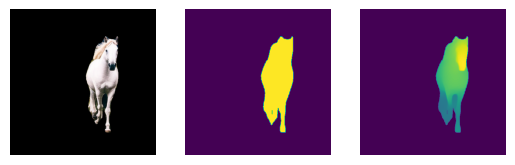

 16%|███████████▌                                                           | 98/600 [00:00<00:03, 130.32it/s]

tensor(0.3083, device='cuda:0') tensor(0.5200, device='cuda:0')
tensor(0.3081, device='cuda:0') tensor(0.5194, device='cuda:0')
tensor(0.3099, device='cuda:0') tensor(0.5191, device='cuda:0')
tensor(0.3134, device='cuda:0') tensor(0.5188, device='cuda:0')
tensor(0.3217, device='cuda:0') tensor(0.5188, device='cuda:0')
tensor(0.3328, device='cuda:0') tensor(0.5186, device='cuda:0')
tensor(0.3406, device='cuda:0') tensor(0.5188, device='cuda:0')
tensor(0.3467, device='cuda:0') tensor(0.5191, device='cuda:0')
tensor(0.3490, device='cuda:0') tensor(0.5193, device='cuda:0')
tensor(0.3503, device='cuda:0') tensor(0.5194, device='cuda:0')
tensor(0.3512, device='cuda:0') tensor(0.5198, device='cuda:0')


 23%|████████████████▏                                                     | 139/600 [00:01<00:03, 125.34it/s]

tensor(0.3786, device='cuda:0') tensor(0.5177, device='cuda:0')
tensor(0.3790, device='cuda:0') tensor(0.5129, device='cuda:0')
tensor(0.3787, device='cuda:0') tensor(0.5089, device='cuda:0')
tensor(0.3787, device='cuda:0') tensor(0.5043, device='cuda:0')
tensor(0.3790, device='cuda:0') tensor(0.5006, device='cuda:0')
tensor(0.3789, device='cuda:0') tensor(0.4986, device='cuda:0')
tensor(0.3788, device='cuda:0') tensor(0.4983, device='cuda:0')
tensor(0.3789, device='cuda:0') tensor(0.4983, device='cuda:0')
tensor(0.3791, device='cuda:0') tensor(0.4990, device='cuda:0')
tensor(0.3794, device='cuda:0') tensor(0.4994, device='cuda:0')
tensor(0.3790, device='cuda:0') tensor(0.5003, device='cuda:0')
tensor(0.3790, device='cuda:0') tensor(0.5009, device='cuda:0')
tensor(0.3790, device='cuda:0') tensor(0.5015, device='cuda:0')
tensor(0.3791, device='cuda:0') tensor(0.5020, device='cuda:0')
tensor(0.3791, device='cuda:0') tensor(0.5025, device='cuda:0')
tensor(0.3790, device='cuda:0') tensor(0

 28%|███████████████████▎                                                  | 165/600 [00:01<00:03, 122.11it/s]

tensor(0.3864, device='cuda:0') tensor(0.5065, device='cuda:0')
tensor(0.3889, device='cuda:0') tensor(0.5069, device='cuda:0')
tensor(0.3901, device='cuda:0') tensor(0.5071, device='cuda:0')
tensor(0.3940, device='cuda:0') tensor(0.5076, device='cuda:0')
tensor(0.4006, device='cuda:0') tensor(0.5080, device='cuda:0')
tensor(0.4090, device='cuda:0') tensor(0.5084, device='cuda:0')
tensor(0.4170, device='cuda:0') tensor(0.5088, device='cuda:0')
tensor(0.4225, device='cuda:0') tensor(0.5090, device='cuda:0')
tensor(0.4263, device='cuda:0') tensor(0.5095, device='cuda:0')
tensor(0.4287, device='cuda:0') tensor(0.5100, device='cuda:0')
tensor(0.4285, device='cuda:0') tensor(0.5102, device='cuda:0')
tensor(0.4267, device='cuda:0') tensor(0.5102, device='cuda:0')
tensor(0.4250, device='cuda:0') tensor(0.5100, device='cuda:0')
tensor(0.4214, device='cuda:0') tensor(0.5103, device='cuda:0')
tensor(0.4178, device='cuda:0') tensor(0.5105, device='cuda:0')
tensor(0.4131, device='cuda:0') tensor(0

 30%|████████████████████▊                                                 | 178/600 [00:01<00:03, 121.06it/s]

tensor(0.3935, device='cuda:0') tensor(0.5141, device='cuda:0')
tensor(0.3930, device='cuda:0') tensor(0.5142, device='cuda:0')
tensor(0.3928, device='cuda:0') tensor(0.5147, device='cuda:0')
tensor(0.3928, device='cuda:0') tensor(0.5147, device='cuda:0')
tensor(0.3926, device='cuda:0') tensor(0.5150, device='cuda:0')
tensor(0.3928, device='cuda:0') tensor(0.5151, device='cuda:0')
tensor(0.3927, device='cuda:0') tensor(0.5145, device='cuda:0')
tensor(0.3927, device='cuda:0') tensor(0.5140, device='cuda:0')
tensor(0.3925, device='cuda:0') tensor(0.5131, device='cuda:0')
tensor(0.3928, device='cuda:0') tensor(0.5126, device='cuda:0')
tensor(0.3931, device='cuda:0') tensor(0.5122, device='cuda:0')
tensor(0.3936, device='cuda:0') tensor(0.5118, device='cuda:0')
tensor(0.3937, device='cuda:0') tensor(0.5110, device='cuda:0')
tensor(0.3934, device='cuda:0') tensor(0.5110, device='cuda:0')
tensor(0.3935, device='cuda:0') tensor(0.5104, device='cuda:0')
tensor(0.3934, device='cuda:0') tensor(0

 38%|██████████████████████████▉                                           | 231/600 [00:01<00:03, 122.70it/s]

tensor(0.3882, device='cuda:0') tensor(0.5196, device='cuda:0')
tensor(0.3880, device='cuda:0') tensor(0.5186, device='cuda:0')
tensor(0.3876, device='cuda:0') tensor(0.5175, device='cuda:0')
tensor(0.3878, device='cuda:0') tensor(0.5170, device='cuda:0')
tensor(0.3878, device='cuda:0') tensor(0.5169, device='cuda:0')
tensor(0.3876, device='cuda:0') tensor(0.5170, device='cuda:0')
tensor(0.3881, device='cuda:0') tensor(0.5169, device='cuda:0')
tensor(0.3818, device='cuda:0') tensor(0.5170, device='cuda:0')
tensor(0.3693, device='cuda:0') tensor(0.5171, device='cuda:0')
tensor(0.3551, device='cuda:0') tensor(0.5171, device='cuda:0')
tensor(0.3430, device='cuda:0') tensor(0.5172, device='cuda:0')
tensor(0.3331, device='cuda:0') tensor(0.5174, device='cuda:0')
tensor(0.3273, device='cuda:0') tensor(0.5169, device='cuda:0')
tensor(0.3264, device='cuda:0') tensor(0.5167, device='cuda:0')
tensor(0.3266, device='cuda:0') tensor(0.5161, device='cuda:0')
tensor(0.3268, device='cuda:0') tensor(0

 43%|█████████████████████████████▉                                        | 257/600 [00:02<00:02, 122.81it/s]

tensor(0.3309, device='cuda:0') tensor(0.5097, device='cuda:0')
tensor(0.3311, device='cuda:0') tensor(0.5094, device='cuda:0')
tensor(0.3314, device='cuda:0') tensor(0.5087, device='cuda:0')
tensor(0.3319, device='cuda:0') tensor(0.5084, device='cuda:0')
tensor(0.3322, device='cuda:0') tensor(0.5078, device='cuda:0')
tensor(0.3323, device='cuda:0') tensor(0.5083, device='cuda:0')
tensor(0.3327, device='cuda:0') tensor(0.5089, device='cuda:0')
tensor(0.3329, device='cuda:0') tensor(0.5095, device='cuda:0')
tensor(0.3337, device='cuda:0') tensor(0.5101, device='cuda:0')
tensor(0.3346, device='cuda:0') tensor(0.5104, device='cuda:0')
tensor(0.3355, device='cuda:0') tensor(0.5112, device='cuda:0')
tensor(0.3362, device='cuda:0') tensor(0.5139, device='cuda:0')
tensor(0.3372, device='cuda:0') tensor(0.5168, device='cuda:0')
tensor(0.3378, device='cuda:0') tensor(0.5195, device='cuda:0')


 47%|█████████████████████████████████                                     | 283/600 [00:02<00:02, 121.41it/s]

tensor(0.3460, device='cuda:0') tensor(0.5120, device='cuda:0')
tensor(0.3472, device='cuda:0') tensor(0.5014, device='cuda:0')
tensor(0.3482, device='cuda:0') tensor(0.4920, device='cuda:0')
tensor(0.3491, device='cuda:0') tensor(0.4839, device='cuda:0')
tensor(0.3500, device='cuda:0') tensor(0.4774, device='cuda:0')
tensor(0.3509, device='cuda:0') tensor(0.4728, device='cuda:0')
tensor(0.3516, device='cuda:0') tensor(0.4707, device='cuda:0')
tensor(0.3524, device='cuda:0') tensor(0.4702, device='cuda:0')
tensor(0.3533, device='cuda:0') tensor(0.4698, device='cuda:0')
tensor(0.3539, device='cuda:0') tensor(0.4700, device='cuda:0')
tensor(0.3546, device='cuda:0') tensor(0.4698, device='cuda:0')
tensor(0.3549, device='cuda:0') tensor(0.4698, device='cuda:0')
tensor(0.3553, device='cuda:0') tensor(0.4698, device='cuda:0')
tensor(0.3552, device='cuda:0') tensor(0.4699, device='cuda:0')
tensor(0.3545, device='cuda:0') tensor(0.4700, device='cuda:0')
tensor(0.3544, device='cuda:0') tensor(0

 52%|████████████████████████████████████                                  | 309/600 [00:02<00:02, 120.07it/s]

tensor(0.3509, device='cuda:0') tensor(0.4700, device='cuda:0')
tensor(0.3503, device='cuda:0') tensor(0.4703, device='cuda:0')
tensor(0.3499, device='cuda:0') tensor(0.4704, device='cuda:0')
tensor(0.3495, device='cuda:0') tensor(0.4705, device='cuda:0')
tensor(0.3494, device='cuda:0') tensor(0.4704, device='cuda:0')
tensor(0.3493, device='cuda:0') tensor(0.4706, device='cuda:0')
tensor(0.3492, device='cuda:0') tensor(0.4706, device='cuda:0')
tensor(0.3496, device='cuda:0') tensor(0.4706, device='cuda:0')
tensor(0.3498, device='cuda:0') tensor(0.4706, device='cuda:0')
tensor(0.3498, device='cuda:0') tensor(0.4705, device='cuda:0')
tensor(0.3497, device='cuda:0') tensor(0.4705, device='cuda:0')
tensor(0.3497, device='cuda:0') tensor(0.4704, device='cuda:0')
tensor(0.3495, device='cuda:0') tensor(0.4704, device='cuda:0')
tensor(0.3497, device='cuda:0') tensor(0.4703, device='cuda:0')
tensor(0.3497, device='cuda:0') tensor(0.4702, device='cuda:0')
tensor(0.3492, device='cuda:0') tensor(0

 54%|█████████████████████████████████████▌                                | 322/600 [00:02<00:02, 119.56it/s]

tensor(0.3357, device='cuda:0') tensor(0.4709, device='cuda:0')
tensor(0.3342, device='cuda:0') tensor(0.4710, device='cuda:0')
tensor(0.3328, device='cuda:0') tensor(0.4712, device='cuda:0')
tensor(0.3321, device='cuda:0') tensor(0.4715, device='cuda:0')
tensor(0.3304, device='cuda:0') tensor(0.4717, device='cuda:0')
tensor(0.3293, device='cuda:0') tensor(0.4719, device='cuda:0')
tensor(0.3282, device='cuda:0') tensor(0.4720, device='cuda:0')
tensor(0.3276, device='cuda:0') tensor(0.4722, device='cuda:0')
tensor(0.3263, device='cuda:0') tensor(0.4723, device='cuda:0')
tensor(0.3256, device='cuda:0') tensor(0.4726, device='cuda:0')
tensor(0.3251, device='cuda:0') tensor(0.4726, device='cuda:0')
tensor(0.3248, device='cuda:0') tensor(0.4728, device='cuda:0')
tensor(0.3242, device='cuda:0') tensor(0.4730, device='cuda:0')
tensor(0.3242, device='cuda:0') tensor(0.4733, device='cuda:0')
tensor(0.3240, device='cuda:0') tensor(0.4735, device='cuda:0')
tensor(0.3239, device='cuda:0') tensor(0

 60%|█████████████████████████████████████████▊                            | 358/600 [00:02<00:02, 119.16it/s]

tensor(0.3164, device='cuda:0') tensor(0.4761, device='cuda:0')
tensor(0.3152, device='cuda:0') tensor(0.4773, device='cuda:0')
tensor(0.3138, device='cuda:0') tensor(0.4787, device='cuda:0')
tensor(0.3126, device='cuda:0') tensor(0.4809, device='cuda:0')
tensor(0.3114, device='cuda:0') tensor(0.4865, device='cuda:0')
tensor(0.3105, device='cuda:0') tensor(0.4929, device='cuda:0')
tensor(0.3090, device='cuda:0') tensor(0.4970, device='cuda:0')
tensor(0.3078, device='cuda:0') tensor(0.4994, device='cuda:0')
tensor(0.3066, device='cuda:0') tensor(0.5003, device='cuda:0')
tensor(0.3060, device='cuda:0') tensor(0.5008, device='cuda:0')
tensor(0.3052, device='cuda:0') tensor(0.5014, device='cuda:0')
tensor(0.3042, device='cuda:0') tensor(0.5031, device='cuda:0')
tensor(0.3034, device='cuda:0') tensor(0.5054, device='cuda:0')
tensor(0.3021, device='cuda:0') tensor(0.5077, device='cuda:0')
tensor(0.3014, device='cuda:0') tensor(0.5086, device='cuda:0')
tensor(0.3007, device='cuda:0') tensor(0

 64%|████████████████████████████████████████████▌                         | 382/600 [00:03<00:01, 119.09it/s]

tensor(0.2940, device='cuda:0') tensor(0.4837, device='cuda:0')
tensor(0.2933, device='cuda:0') tensor(0.4824, device='cuda:0')
tensor(0.2931, device='cuda:0') tensor(0.4819, device='cuda:0')
tensor(0.2923, device='cuda:0') tensor(0.4799, device='cuda:0')
tensor(0.2920, device='cuda:0') tensor(0.4777, device='cuda:0')
tensor(0.2920, device='cuda:0') tensor(0.4766, device='cuda:0')
tensor(0.2923, device='cuda:0') tensor(0.4760, device='cuda:0')
tensor(0.2922, device='cuda:0') tensor(0.4759, device='cuda:0')
tensor(0.2918, device='cuda:0') tensor(0.4755, device='cuda:0')
tensor(0.2919, device='cuda:0') tensor(0.4750, device='cuda:0')
tensor(0.2917, device='cuda:0') tensor(0.4747, device='cuda:0')
tensor(0.2918, device='cuda:0') tensor(0.4750, device='cuda:0')
tensor(0.2919, device='cuda:0') tensor(0.4749, device='cuda:0')
tensor(0.2917, device='cuda:0') tensor(0.4747, device='cuda:0')
tensor(0.2912, device='cuda:0') tensor(0.4751, device='cuda:0')
tensor(0.2914, device='cuda:0') tensor(0

 68%|███████████████████████████████████████████████▍                      | 407/600 [00:03<00:01, 121.72it/s]

tensor(0.3126, device='cuda:0') tensor(0.4776, device='cuda:0')
tensor(0.3135, device='cuda:0') tensor(0.4777, device='cuda:0')
tensor(0.3133, device='cuda:0') tensor(0.4773, device='cuda:0')
tensor(0.3131, device='cuda:0') tensor(0.4772, device='cuda:0')
tensor(0.3138, device='cuda:0') tensor(0.4770, device='cuda:0')
tensor(0.3142, device='cuda:0') tensor(0.4801, device='cuda:0')
tensor(0.3145, device='cuda:0') tensor(0.4837, device='cuda:0')
tensor(0.3161, device='cuda:0') tensor(0.4880, device='cuda:0')
tensor(0.3176, device='cuda:0') tensor(0.4943, device='cuda:0')
tensor(0.3192, device='cuda:0') tensor(0.5009, device='cuda:0')
tensor(0.3195, device='cuda:0') tensor(0.5075, device='cuda:0')
tensor(0.3190, device='cuda:0') tensor(0.5176, device='cuda:0')


 72%|██████████████████████████████████████████████████▌                   | 433/600 [00:03<00:01, 120.89it/s]

tensor(0.3395, device='cuda:0') tensor(0.5180, device='cuda:0')
tensor(0.3401, device='cuda:0') tensor(0.5148, device='cuda:0')
tensor(0.3403, device='cuda:0') tensor(0.5126, device='cuda:0')
tensor(0.3409, device='cuda:0') tensor(0.5100, device='cuda:0')
tensor(0.3413, device='cuda:0') tensor(0.5080, device='cuda:0')
tensor(0.3420, device='cuda:0') tensor(0.5065, device='cuda:0')
tensor(0.3421, device='cuda:0') tensor(0.5055, device='cuda:0')
tensor(0.3423, device='cuda:0') tensor(0.5045, device='cuda:0')
tensor(0.3424, device='cuda:0') tensor(0.5042, device='cuda:0')
tensor(0.3418, device='cuda:0') tensor(0.5034, device='cuda:0')
tensor(0.3411, device='cuda:0') tensor(0.5033, device='cuda:0')
tensor(0.3411, device='cuda:0') tensor(0.5031, device='cuda:0')
tensor(0.3412, device='cuda:0') tensor(0.5025, device='cuda:0')
tensor(0.3414, device='cuda:0') tensor(0.5021, device='cuda:0')
tensor(0.3415, device='cuda:0') tensor(0.5018, device='cuda:0')
tensor(0.3413, device='cuda:0') tensor(0

 76%|█████████████████████████████████████████████████████▌                | 459/600 [00:03<00:01, 119.95it/s]

tensor(0.3405, device='cuda:0') tensor(0.5029, device='cuda:0')
tensor(0.3408, device='cuda:0') tensor(0.5027, device='cuda:0')
tensor(0.3419, device='cuda:0') tensor(0.5025, device='cuda:0')
tensor(0.3464, device='cuda:0') tensor(0.5014, device='cuda:0')
tensor(0.3519, device='cuda:0') tensor(0.5006, device='cuda:0')
tensor(0.3586, device='cuda:0') tensor(0.5000, device='cuda:0')
tensor(0.3668, device='cuda:0') tensor(0.4994, device='cuda:0')
tensor(0.3763, device='cuda:0') tensor(0.4985, device='cuda:0')
tensor(0.3892, device='cuda:0') tensor(0.4979, device='cuda:0')
tensor(0.3974, device='cuda:0') tensor(0.4969, device='cuda:0')
tensor(0.4038, device='cuda:0') tensor(0.4963, device='cuda:0')
tensor(0.4059, device='cuda:0') tensor(0.4958, device='cuda:0')
tensor(0.4068, device='cuda:0') tensor(0.4952, device='cuda:0')
tensor(0.4076, device='cuda:0') tensor(0.4951, device='cuda:0')
tensor(0.4088, device='cuda:0') tensor(0.4945, device='cuda:0')
tensor(0.4085, device='cuda:0') tensor(0

 80%|████████████████████████████████████████████████████████▎             | 483/600 [00:03<00:00, 119.35it/s]

tensor(0.3700, device='cuda:0') tensor(0.4886, device='cuda:0')
tensor(0.3637, device='cuda:0') tensor(0.4884, device='cuda:0')
tensor(0.3538, device='cuda:0') tensor(0.4882, device='cuda:0')
tensor(0.3492, device='cuda:0') tensor(0.4883, device='cuda:0')
tensor(0.3474, device='cuda:0') tensor(0.4885, device='cuda:0')
tensor(0.3472, device='cuda:0') tensor(0.4883, device='cuda:0')
tensor(0.3471, device='cuda:0') tensor(0.4883, device='cuda:0')
tensor(0.3477, device='cuda:0') tensor(0.4885, device='cuda:0')
tensor(0.3479, device='cuda:0') tensor(0.4882, device='cuda:0')
tensor(0.3481, device='cuda:0') tensor(0.4882, device='cuda:0')
tensor(0.3481, device='cuda:0') tensor(0.4883, device='cuda:0')
tensor(0.3483, device='cuda:0') tensor(0.4887, device='cuda:0')
tensor(0.3488, device='cuda:0') tensor(0.4884, device='cuda:0')
tensor(0.3492, device='cuda:0') tensor(0.4887, device='cuda:0')
tensor(0.3496, device='cuda:0') tensor(0.4890, device='cuda:0')
tensor(0.3497, device='cuda:0') tensor(0

 83%|█████████████████████████████████████████████████████████▉            | 497/600 [00:04<00:00, 123.74it/s]

tensor(0.3504, device='cuda:0') tensor(0.5190, device='cuda:0')


 90%|██████████████████████████████████████████████████████████████▋       | 537/600 [00:04<00:00, 125.49it/s]

tensor(0.2974, device='cuda:0') tensor(0.5362, device='cuda:0')
tensor(0.2946, device='cuda:0') tensor(0.5361, device='cuda:0')
tensor(0.2903, device='cuda:0') tensor(0.5361, device='cuda:0')
tensor(0.2865, device='cuda:0') tensor(0.5359, device='cuda:0')
tensor(0.2844, device='cuda:0') tensor(0.5361, device='cuda:0')
tensor(0.2829, device='cuda:0') tensor(0.5359, device='cuda:0')
tensor(0.2819, device='cuda:0') tensor(0.5363, device='cuda:0')
tensor(0.2820, device='cuda:0') tensor(0.5368, device='cuda:0')
tensor(0.2821, device='cuda:0') tensor(0.5369, device='cuda:0')
tensor(0.2825, device='cuda:0') tensor(0.5377, device='cuda:0')
tensor(0.2829, device='cuda:0') tensor(0.5390, device='cuda:0')
tensor(0.2845, device='cuda:0') tensor(0.5423, device='cuda:0')
tensor(0.2866, device='cuda:0') tensor(0.5446, device='cuda:0')
tensor(0.2887, device='cuda:0') tensor(0.5470, device='cuda:0')
tensor(0.2913, device='cuda:0') tensor(0.5485, device='cuda:0')
tensor(0.2956, device='cuda:0') tensor(0

100%|██████████████████████████████████████████████████████████████████████| 600/600 [00:04<00:00, 124.41it/s]


/grogu/user/akirchme/art3d_sd_webui/images/horse/834.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/834.mp4


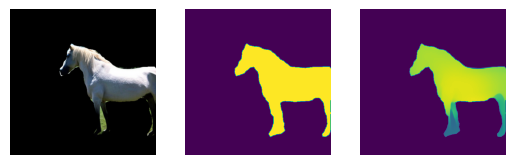

  4%|██▊                                                                    | 24/600 [00:00<00:04, 118.07it/s]

tensor(0.2900, device='cuda:0') tensor(0.4750, device='cuda:0')
tensor(0.2902, device='cuda:0') tensor(0.4752, device='cuda:0')
tensor(0.2904, device='cuda:0') tensor(0.4754, device='cuda:0')
tensor(0.2904, device='cuda:0') tensor(0.4756, device='cuda:0')
tensor(0.2906, device='cuda:0') tensor(0.4757, device='cuda:0')
tensor(0.2907, device='cuda:0') tensor(0.4759, device='cuda:0')
tensor(0.2910, device='cuda:0') tensor(0.4762, device='cuda:0')
tensor(0.2911, device='cuda:0') tensor(0.4764, device='cuda:0')
tensor(0.2913, device='cuda:0') tensor(0.4766, device='cuda:0')
tensor(0.2914, device='cuda:0') tensor(0.4766, device='cuda:0')
tensor(0.2917, device='cuda:0') tensor(0.4766, device='cuda:0')
tensor(0.2920, device='cuda:0') tensor(0.4769, device='cuda:0')
tensor(0.2922, device='cuda:0') tensor(0.4770, device='cuda:0')
tensor(0.2923, device='cuda:0') tensor(0.4768, device='cuda:0')
tensor(0.2925, device='cuda:0') tensor(0.4769, device='cuda:0')
tensor(0.2925, device='cuda:0') tensor(0

  6%|████▎                                                                  | 36/600 [00:00<00:04, 117.72it/s]

tensor(0.2929, device='cuda:0') tensor(0.4766, device='cuda:0')
tensor(0.2930, device='cuda:0') tensor(0.4766, device='cuda:0')
tensor(0.2930, device='cuda:0') tensor(0.4764, device='cuda:0')
tensor(0.2929, device='cuda:0') tensor(0.4763, device='cuda:0')
tensor(0.2929, device='cuda:0') tensor(0.4762, device='cuda:0')
tensor(0.2929, device='cuda:0') tensor(0.4762, device='cuda:0')
tensor(0.2926, device='cuda:0') tensor(0.4761, device='cuda:0')
tensor(0.2925, device='cuda:0') tensor(0.4759, device='cuda:0')
tensor(0.2923, device='cuda:0') tensor(0.4762, device='cuda:0')
tensor(0.2923, device='cuda:0') tensor(0.4834, device='cuda:0')
tensor(0.2922, device='cuda:0') tensor(0.4886, device='cuda:0')
tensor(0.2920, device='cuda:0') tensor(0.4916, device='cuda:0')
tensor(0.2919, device='cuda:0') tensor(0.4958, device='cuda:0')
tensor(0.2918, device='cuda:0') tensor(0.4997, device='cuda:0')
tensor(0.2919, device='cuda:0') tensor(0.5029, device='cuda:0')
tensor(0.2918, device='cuda:0') tensor(0

 12%|████████▌                                                              | 72/600 [00:00<00:04, 117.76it/s]

tensor(0.2899, device='cuda:0') tensor(0.5067, device='cuda:0')
tensor(0.2895, device='cuda:0') tensor(0.5009, device='cuda:0')
tensor(0.2892, device='cuda:0') tensor(0.4970, device='cuda:0')
tensor(0.2888, device='cuda:0') tensor(0.4936, device='cuda:0')
tensor(0.2885, device='cuda:0') tensor(0.4913, device='cuda:0')
tensor(0.2879, device='cuda:0') tensor(0.4901, device='cuda:0')
tensor(0.2875, device='cuda:0') tensor(0.4896, device='cuda:0')
tensor(0.2871, device='cuda:0') tensor(0.4885, device='cuda:0')
tensor(0.2865, device='cuda:0') tensor(0.4883, device='cuda:0')
tensor(0.2860, device='cuda:0') tensor(0.4878, device='cuda:0')
tensor(0.2858, device='cuda:0') tensor(0.4874, device='cuda:0')
tensor(0.2855, device='cuda:0') tensor(0.4872, device='cuda:0')
tensor(0.2854, device='cuda:0') tensor(0.4870, device='cuda:0')
tensor(0.2852, device='cuda:0') tensor(0.4869, device='cuda:0')
tensor(0.2852, device='cuda:0') tensor(0.4868, device='cuda:0')
tensor(0.2849, device='cuda:0') tensor(0

 14%|██████████                                                             | 85/600 [00:00<00:04, 118.88it/s]

tensor(0.2840, device='cuda:0') tensor(0.4876, device='cuda:0')
tensor(0.2838, device='cuda:0') tensor(0.4876, device='cuda:0')
tensor(0.2837, device='cuda:0') tensor(0.4876, device='cuda:0')
tensor(0.2837, device='cuda:0') tensor(0.4877, device='cuda:0')
tensor(0.2877, device='cuda:0') tensor(0.4875, device='cuda:0')
tensor(0.2957, device='cuda:0') tensor(0.4875, device='cuda:0')
tensor(0.3009, device='cuda:0') tensor(0.4876, device='cuda:0')
tensor(0.3066, device='cuda:0') tensor(0.4877, device='cuda:0')
tensor(0.3117, device='cuda:0') tensor(0.4876, device='cuda:0')
tensor(0.3162, device='cuda:0') tensor(0.4877, device='cuda:0')
tensor(0.3195, device='cuda:0') tensor(0.4878, device='cuda:0')
tensor(0.3218, device='cuda:0') tensor(0.4892, device='cuda:0')
tensor(0.3219, device='cuda:0') tensor(0.5084, device='cuda:0')


 90%|███████████████████████████████████████████████████████████████       | 541/600 [00:04<00:00, 120.74it/s]

tensor(0.2962, device='cuda:0') tensor(0.5881, device='cuda:0')
tensor(0.2849, device='cuda:0') tensor(0.5882, device='cuda:0')
tensor(0.2848, device='cuda:0') tensor(0.5883, device='cuda:0')
tensor(0.2845, device='cuda:0') tensor(0.5885, device='cuda:0')
tensor(0.2844, device='cuda:0') tensor(0.5886, device='cuda:0')
tensor(0.2842, device='cuda:0') tensor(0.5887, device='cuda:0')
tensor(0.2841, device='cuda:0') tensor(0.5889, device='cuda:0')
tensor(0.2841, device='cuda:0') tensor(0.5894, device='cuda:0')
tensor(0.2840, device='cuda:0') tensor(0.5896, device='cuda:0')
tensor(0.2841, device='cuda:0') tensor(0.5897, device='cuda:0')
tensor(0.2841, device='cuda:0') tensor(0.5902, device='cuda:0')
tensor(0.2839, device='cuda:0') tensor(0.5907, device='cuda:0')
tensor(0.2840, device='cuda:0') tensor(0.5912, device='cuda:0')
tensor(0.2838, device='cuda:0') tensor(0.5916, device='cuda:0')
tensor(0.2837, device='cuda:0') tensor(0.5919, device='cuda:0')
tensor(0.2836, device='cuda:0') tensor(0

 94%|██████████████████████████████████████████████████████████████████    | 566/600 [00:04<00:00, 118.14it/s]

tensor(0.2840, device='cuda:0') tensor(0.6000, device='cuda:0')
tensor(0.2841, device='cuda:0') tensor(0.6107, device='cuda:0')
tensor(0.2842, device='cuda:0') tensor(0.6401, device='cuda:0')
tensor(0.2843, device='cuda:0') tensor(0.6743, device='cuda:0')
tensor(0.2844, device='cuda:0') tensor(0.7061, device='cuda:0')
tensor(0.2846, device='cuda:0') tensor(0.7224, device='cuda:0')
tensor(0.2847, device='cuda:0') tensor(0.7226, device='cuda:0')
tensor(0.2847, device='cuda:0') tensor(0.7221, device='cuda:0')
tensor(0.2847, device='cuda:0') tensor(0.7218, device='cuda:0')
tensor(0.2848, device='cuda:0') tensor(0.7215, device='cuda:0')
tensor(0.2848, device='cuda:0') tensor(0.7213, device='cuda:0')
tensor(0.2847, device='cuda:0') tensor(0.7211, device='cuda:0')
tensor(0.2849, device='cuda:0') tensor(0.7207, device='cuda:0')
tensor(0.2849, device='cuda:0') tensor(0.7203, device='cuda:0')
tensor(0.2850, device='cuda:0') tensor(0.7181, device='cuda:0')
tensor(0.2851, device='cuda:0') tensor(0

 98%|████████████████████████████████████████████████████████████████████▊ | 590/600 [00:04<00:00, 117.62it/s]

tensor(0.2858, device='cuda:0') tensor(0.4720, device='cuda:0')
tensor(0.2859, device='cuda:0') tensor(0.4721, device='cuda:0')
tensor(0.2861, device='cuda:0') tensor(0.4721, device='cuda:0')
tensor(0.2862, device='cuda:0') tensor(0.4721, device='cuda:0')
tensor(0.2862, device='cuda:0') tensor(0.4722, device='cuda:0')
tensor(0.2862, device='cuda:0') tensor(0.4723, device='cuda:0')
tensor(0.2863, device='cuda:0') tensor(0.4723, device='cuda:0')
tensor(0.2864, device='cuda:0') tensor(0.4723, device='cuda:0')
tensor(0.2868, device='cuda:0') tensor(0.4724, device='cuda:0')
tensor(0.2869, device='cuda:0') tensor(0.4724, device='cuda:0')
tensor(0.2870, device='cuda:0') tensor(0.4726, device='cuda:0')
tensor(0.2871, device='cuda:0') tensor(0.4728, device='cuda:0')
tensor(0.2872, device='cuda:0') tensor(0.4729, device='cuda:0')
tensor(0.2871, device='cuda:0') tensor(0.4730, device='cuda:0')
tensor(0.2872, device='cuda:0') tensor(0.4731, device='cuda:0')
tensor(0.2873, device='cuda:0') tensor(0

100%|██████████████████████████████████████████████████████████████████████| 600/600 [00:04<00:00, 120.23it/s]


tensor(0.2891, device='cuda:0') tensor(0.4744, device='cuda:0')
tensor(0.2891, device='cuda:0') tensor(0.4747, device='cuda:0')
tensor(0.2895, device='cuda:0') tensor(0.4747, device='cuda:0')
tensor(0.2898, device='cuda:0') tensor(0.4749, device='cuda:0')
/grogu/user/akirchme/art3d_sd_webui/images/horse/446.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/446.mp4


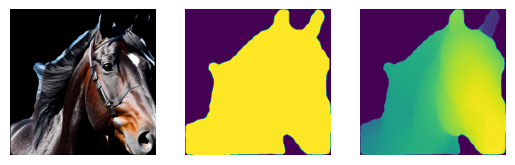

 14%|██████████▍                                                             | 87/600 [00:01<00:07, 67.01it/s]

tensor(0.4002, device='cuda:0') tensor(0.5199, device='cuda:0')
tensor(0.4087, device='cuda:0') tensor(0.5195, device='cuda:0')
tensor(0.4154, device='cuda:0') tensor(0.5191, device='cuda:0')
tensor(0.4179, device='cuda:0') tensor(0.5189, device='cuda:0')
tensor(0.4197, device='cuda:0') tensor(0.5183, device='cuda:0')
tensor(0.4213, device='cuda:0') tensor(0.5178, device='cuda:0')
tensor(0.4230, device='cuda:0') tensor(0.5175, device='cuda:0')
tensor(0.4252, device='cuda:0') tensor(0.5176, device='cuda:0')


 40%|████████████████████████████▎                                          | 239/600 [00:04<00:04, 82.58it/s]

tensor(0.3201, device='cuda:0') tensor(0.5170, device='cuda:0')
tensor(0.3152, device='cuda:0') tensor(0.5174, device='cuda:0')
tensor(0.2996, device='cuda:0') tensor(0.5185, device='cuda:0')
tensor(0.2838, device='cuda:0') tensor(0.5194, device='cuda:0')
tensor(0.2694, device='cuda:0') tensor(0.5204, device='cuda:0')
tensor(0.2489, device='cuda:0') tensor(0.5212, device='cuda:0')
tensor(0.2212, device='cuda:0') tensor(0.5217, device='cuda:0')
tensor(0.1814, device='cuda:0') tensor(0.5224, device='cuda:0')
tensor(0.1781, device='cuda:0') tensor(0.5228, device='cuda:0')
tensor(0.1780, device='cuda:0') tensor(0.5231, device='cuda:0')
tensor(0.1780, device='cuda:0') tensor(0.5231, device='cuda:0')
tensor(0.1780, device='cuda:0') tensor(0.5228, device='cuda:0')
tensor(0.1780, device='cuda:0') tensor(0.5222, device='cuda:0')
tensor(0.1780, device='cuda:0') tensor(0.5212, device='cuda:0')
tensor(0.1779, device='cuda:0') tensor(0.5197, device='cuda:0')
tensor(0.1776, device='cuda:0') tensor(0

 44%|██████████████████████████████▊                                       | 264/600 [00:04<00:03, 101.18it/s]

tensor(0.1770, device='cuda:0') tensor(0.5050, device='cuda:0')
tensor(0.1773, device='cuda:0') tensor(0.5036, device='cuda:0')
tensor(0.1775, device='cuda:0') tensor(0.5024, device='cuda:0')
tensor(0.1774, device='cuda:0') tensor(0.5018, device='cuda:0')
tensor(0.1776, device='cuda:0') tensor(0.5023, device='cuda:0')
tensor(0.1778, device='cuda:0') tensor(0.5072, device='cuda:0')
tensor(0.1780, device='cuda:0') tensor(0.5151, device='cuda:0')
tensor(0.1782, device='cuda:0') tensor(0.5242, device='cuda:0')
tensor(0.1784, device='cuda:0') tensor(0.5324, device='cuda:0')
tensor(0.1787, device='cuda:0') tensor(0.5431, device='cuda:0')
tensor(0.1789, device='cuda:0') tensor(0.5615, device='cuda:0')
tensor(0.1791, device='cuda:0') tensor(0.5859, device='cuda:0')
tensor(0.1793, device='cuda:0') tensor(0.6162, device='cuda:0')
tensor(0.1795, device='cuda:0') tensor(0.6175, device='cuda:0')
tensor(0.1797, device='cuda:0') tensor(0.6173, device='cuda:0')
tensor(0.1801, device='cuda:0') tensor(0

 48%|█████████████████████████████████▋                                    | 289/600 [00:04<00:02, 110.96it/s]

tensor(0.5414, device='cuda:0')
tensor(0.1893, device='cuda:0') tensor(0.5245, device='cuda:0')
tensor(0.1904, device='cuda:0') tensor(0.4955, device='cuda:0')
tensor(0.1915, device='cuda:0') tensor(0.4739, device='cuda:0')
tensor(0.1925, device='cuda:0') tensor(0.4737, device='cuda:0')
tensor(0.1934, device='cuda:0') tensor(0.4737, device='cuda:0')
tensor(0.1942, device='cuda:0') tensor(0.4737, device='cuda:0')
tensor(0.1950, device='cuda:0') tensor(0.4738, device='cuda:0')
tensor(0.1957, device='cuda:0') tensor(0.4739, device='cuda:0')
tensor(0.1964, device='cuda:0') tensor(0.4740, device='cuda:0')
tensor(0.1969, device='cuda:0') tensor(0.4745, device='cuda:0')
tensor(0.1972, device='cuda:0') tensor(0.4748, device='cuda:0')
tensor(0.1973, device='cuda:0') tensor(0.4749, device='cuda:0')
tensor(0.1974, device='cuda:0') tensor(0.4749, device='cuda:0')
tensor(0.1975, device='cuda:0') tensor(0.4751, device='cuda:0')
tensor(0.1976, device='cuda:0') tensor(0.4753, device='cuda:0')
tensor(0

 52%|████████████████████████████████████▌                                 | 313/600 [00:04<00:02, 114.89it/s]

tensor(0.1966, device='cuda:0') tensor(0.4761, device='cuda:0')
tensor(0.1969, device='cuda:0') tensor(0.4760, device='cuda:0')
tensor(0.1970, device='cuda:0') tensor(0.4760, device='cuda:0')
tensor(0.1971, device='cuda:0') tensor(0.4760, device='cuda:0')
tensor(0.1973, device='cuda:0') tensor(0.4759, device='cuda:0')
tensor(0.1973, device='cuda:0') tensor(0.4759, device='cuda:0')
tensor(0.1974, device='cuda:0') tensor(0.4759, device='cuda:0')
tensor(0.1975, device='cuda:0') tensor(0.4759, device='cuda:0')
tensor(0.1975, device='cuda:0') tensor(0.4759, device='cuda:0')
tensor(0.1976, device='cuda:0') tensor(0.4760, device='cuda:0')
tensor(0.1976, device='cuda:0') tensor(0.4760, device='cuda:0')
tensor(0.1976, device='cuda:0') tensor(0.4760, device='cuda:0')
tensor(0.1976, device='cuda:0') tensor(0.4760, device='cuda:0')
tensor(0.1975, device='cuda:0') tensor(0.4760, device='cuda:0')
tensor(0.1974, device='cuda:0') tensor(0.4761, device='cuda:0')
tensor(0.1973, device='cuda:0') tensor(0

 54%|██████████████████████████████████████                                | 326/600 [00:04<00:02, 116.82it/s]

tensor(0.1976, device='cuda:0') tensor(0.4763, device='cuda:0')
tensor(0.1977, device='cuda:0') tensor(0.4763, device='cuda:0')
tensor(0.1980, device='cuda:0') tensor(0.4764, device='cuda:0')
tensor(0.1983, device='cuda:0') tensor(0.4764, device='cuda:0')
tensor(0.1986, device='cuda:0') tensor(0.4765, device='cuda:0')
tensor(0.1985, device='cuda:0') tensor(0.4766, device='cuda:0')
tensor(0.1984, device='cuda:0') tensor(0.4766, device='cuda:0')
tensor(0.1982, device='cuda:0') tensor(0.4766, device='cuda:0')
tensor(0.1979, device='cuda:0') tensor(0.4767, device='cuda:0')
tensor(0.1977, device='cuda:0') tensor(0.4767, device='cuda:0')
tensor(0.1973, device='cuda:0') tensor(0.4767, device='cuda:0')
tensor(0.1969, device='cuda:0') tensor(0.4767, device='cuda:0')
tensor(0.1963, device='cuda:0') tensor(0.4767, device='cuda:0')
tensor(0.1956, device='cuda:0') tensor(0.4768, device='cuda:0')
tensor(0.1949, device='cuda:0') tensor(0.4770, device='cuda:0')
tensor(0.1941, device='cuda:0') tensor(0

 60%|██████████████████████████████████████████▎                           | 363/600 [00:05<00:02, 118.22it/s]

tensor(0.1849, device='cuda:0') tensor(0.6093, device='cuda:0')
tensor(0.1843, device='cuda:0') tensor(0.6275, device='cuda:0')
tensor(0.1836, device='cuda:0') tensor(0.6428, device='cuda:0')
tensor(0.1826, device='cuda:0') tensor(0.6460, device='cuda:0')
tensor(0.1819, device='cuda:0') tensor(0.6458, device='cuda:0')
tensor(0.1812, device='cuda:0') tensor(0.6457, device='cuda:0')
tensor(0.1808, device='cuda:0') tensor(0.6456, device='cuda:0')
tensor(0.1802, device='cuda:0') tensor(0.6458, device='cuda:0')
tensor(0.1798, device='cuda:0') tensor(0.6454, device='cuda:0')
tensor(0.1795, device='cuda:0') tensor(0.6321, device='cuda:0')
tensor(0.1791, device='cuda:0') tensor(0.6117, device='cuda:0')
tensor(0.1787, device='cuda:0') tensor(0.5909, device='cuda:0')
tensor(0.1785, device='cuda:0') tensor(0.5717, device='cuda:0')
tensor(0.1783, device='cuda:0') tensor(0.5599, device='cuda:0')
tensor(0.1781, device='cuda:0') tensor(0.5482, device='cuda:0')
tensor(0.1780, device='cuda:0') tensor(0

 62%|███████████████████████████████████████████▊                          | 375/600 [00:05<00:01, 118.39it/s]

tensor(0.1782, device='cuda:0') tensor(0.5398, device='cuda:0')
tensor(0.1782, device='cuda:0') tensor(0.5419, device='cuda:0')
tensor(0.1782, device='cuda:0') tensor(0.5445, device='cuda:0')
tensor(0.1781, device='cuda:0') tensor(0.5469, device='cuda:0')
tensor(0.1782, device='cuda:0') tensor(0.5484, device='cuda:0')
tensor(0.1782, device='cuda:0') tensor(0.5495, device='cuda:0')
tensor(0.1783, device='cuda:0') tensor(0.5502, device='cuda:0')
tensor(0.1784, device='cuda:0') tensor(0.5504, device='cuda:0')
tensor(0.1785, device='cuda:0') tensor(0.5506, device='cuda:0')
tensor(0.1786, device='cuda:0') tensor(0.5505, device='cuda:0')
tensor(0.1787, device='cuda:0') tensor(0.5500, device='cuda:0')
tensor(0.1787, device='cuda:0') tensor(0.5494, device='cuda:0')
tensor(0.1790, device='cuda:0') tensor(0.5486, device='cuda:0')
tensor(0.1813, device='cuda:0') tensor(0.5475, device='cuda:0')
tensor(0.2051, device='cuda:0') tensor(0.5466, device='cuda:0')
tensor(0.2344, device='cuda:0') tensor(0

100%|███████████████████████████████████████████████████████████████████████| 600/600 [00:09<00:00, 64.59it/s]


/grogu/user/akirchme/art3d_sd_webui/images/horse/780.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/780.mp4


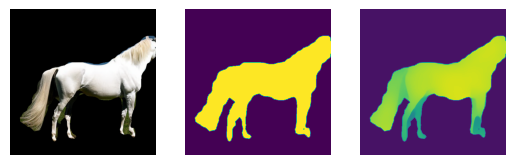

 39%|███████████████████████████                                           | 232/600 [00:02<00:03, 109.96it/s]

tensor(0.3950, device='cuda:0') tensor(0.5181, device='cuda:0')
tensor(0.3881, device='cuda:0') tensor(0.5182, device='cuda:0')
tensor(0.3774, device='cuda:0') tensor(0.5184, device='cuda:0')
tensor(0.3628, device='cuda:0') tensor(0.5183, device='cuda:0')
tensor(0.3432, device='cuda:0') tensor(0.5184, device='cuda:0')
tensor(0.3111, device='cuda:0') tensor(0.5184, device='cuda:0')
tensor(0.2799, device='cuda:0') tensor(0.5184, device='cuda:0')
tensor(0.2757, device='cuda:0') tensor(0.5185, device='cuda:0')
tensor(0.2757, device='cuda:0') tensor(0.5187, device='cuda:0')
tensor(0.2758, device='cuda:0') tensor(0.5187, device='cuda:0')
tensor(0.2759, device='cuda:0') tensor(0.5187, device='cuda:0')
tensor(0.2759, device='cuda:0') tensor(0.5188, device='cuda:0')
tensor(0.2758, device='cuda:0') tensor(0.5188, device='cuda:0')
tensor(0.2759, device='cuda:0') tensor(0.5187, device='cuda:0')
tensor(0.2759, device='cuda:0') tensor(0.5187, device='cuda:0')
tensor(0.2759, device='cuda:0') tensor(0

 43%|█████████████████████████████▉                                        | 257/600 [00:02<00:02, 114.85it/s]

tensor(0.2771, device='cuda:0') tensor(0.5184, device='cuda:0')
tensor(0.2773, device='cuda:0') tensor(0.5185, device='cuda:0')
tensor(0.2775, device='cuda:0') tensor(0.5186, device='cuda:0')
tensor(0.2777, device='cuda:0') tensor(0.5190, device='cuda:0')
tensor(0.2781, device='cuda:0') tensor(0.5219, device='cuda:0')
tensor(0.2783, device='cuda:0') tensor(0.5235, device='cuda:0')
tensor(0.2785, device='cuda:0') tensor(0.5269, device='cuda:0')
tensor(0.2787, device='cuda:0') tensor(0.5319, device='cuda:0')
tensor(0.2789, device='cuda:0') tensor(0.5387, device='cuda:0')
tensor(0.2790, device='cuda:0') tensor(0.5488, device='cuda:0')
tensor(0.2793, device='cuda:0') tensor(0.5641, device='cuda:0')
tensor(0.2795, device='cuda:0') tensor(0.5660, device='cuda:0')
tensor(0.2797, device='cuda:0') tensor(0.5658, device='cuda:0')
tensor(0.2798, device='cuda:0') tensor(0.5658, device='cuda:0')
tensor(0.2800, device='cuda:0') tensor(0.5657, device='cuda:0')
tensor(0.2802, device='cuda:0') tensor(0

 47%|████████████████████████████████▊                                     | 281/600 [00:02<00:02, 116.54it/s]

tensor(0.2824, device='cuda:0') tensor(0.4672, device='cuda:0')
tensor(0.2825, device='cuda:0') tensor(0.4451, device='cuda:0')
tensor(0.2827, device='cuda:0') tensor(0.4449, device='cuda:0')
tensor(0.2828, device='cuda:0') tensor(0.4449, device='cuda:0')
tensor(0.2829, device='cuda:0') tensor(0.4449, device='cuda:0')
tensor(0.2830, device='cuda:0') tensor(0.4448, device='cuda:0')
tensor(0.2831, device='cuda:0') tensor(0.4447, device='cuda:0')
tensor(0.2834, device='cuda:0') tensor(0.4446, device='cuda:0')
tensor(0.2834, device='cuda:0') tensor(0.4446, device='cuda:0')
tensor(0.2834, device='cuda:0') tensor(0.4446, device='cuda:0')
tensor(0.2834, device='cuda:0') tensor(0.4445, device='cuda:0')
tensor(0.2835, device='cuda:0') tensor(0.4444, device='cuda:0')
tensor(0.2835, device='cuda:0') tensor(0.4444, device='cuda:0')
tensor(0.2834, device='cuda:0') tensor(0.4444, device='cuda:0')
tensor(0.2834, device='cuda:0') tensor(0.4445, device='cuda:0')
tensor(0.2833, device='cuda:0') tensor(0

 51%|███████████████████████████████████▌                                  | 305/600 [00:02<00:02, 117.64it/s]

tensor(0.2812, device='cuda:0') tensor(0.4444, device='cuda:0')
tensor(0.2810, device='cuda:0') tensor(0.4444, device='cuda:0')
tensor(0.2807, device='cuda:0') tensor(0.4443, device='cuda:0')
tensor(0.2806, device='cuda:0') tensor(0.4444, device='cuda:0')
tensor(0.2805, device='cuda:0') tensor(0.4444, device='cuda:0')
tensor(0.2803, device='cuda:0') tensor(0.4444, device='cuda:0')
tensor(0.2799, device='cuda:0') tensor(0.4443, device='cuda:0')
tensor(0.2797, device='cuda:0') tensor(0.4442, device='cuda:0')
tensor(0.2795, device='cuda:0') tensor(0.4442, device='cuda:0')
tensor(0.2793, device='cuda:0') tensor(0.4442, device='cuda:0')
tensor(0.2791, device='cuda:0') tensor(0.4441, device='cuda:0')
tensor(0.2788, device='cuda:0') tensor(0.4441, device='cuda:0')
tensor(0.2786, device='cuda:0') tensor(0.4440, device='cuda:0')
tensor(0.2783, device='cuda:0') tensor(0.4440, device='cuda:0')
tensor(0.2780, device='cuda:0') tensor(0.4439, device='cuda:0')
tensor(0.2779, device='cuda:0') tensor(0

 55%|██████████████████████████████████████▍                               | 329/600 [00:03<00:02, 118.36it/s]

tensor(0.2765, device='cuda:0') tensor(0.4431, device='cuda:0')
tensor(0.2764, device='cuda:0') tensor(0.4431, device='cuda:0')
tensor(0.2763, device='cuda:0') tensor(0.4431, device='cuda:0')
tensor(0.2761, device='cuda:0') tensor(0.4431, device='cuda:0')
tensor(0.2759, device='cuda:0') tensor(0.4431, device='cuda:0')
tensor(0.2759, device='cuda:0') tensor(0.4431, device='cuda:0')
tensor(0.2758, device='cuda:0') tensor(0.4430, device='cuda:0')
tensor(0.2758, device='cuda:0') tensor(0.4429, device='cuda:0')
tensor(0.2756, device='cuda:0') tensor(0.4430, device='cuda:0')
tensor(0.2754, device='cuda:0') tensor(0.4430, device='cuda:0')
tensor(0.2753, device='cuda:0') tensor(0.4429, device='cuda:0')
tensor(0.2752, device='cuda:0') tensor(0.4429, device='cuda:0')
tensor(0.2750, device='cuda:0') tensor(0.4429, device='cuda:0')
tensor(0.2748, device='cuda:0') tensor(0.4428, device='cuda:0')
tensor(0.2746, device='cuda:0') tensor(0.4427, device='cuda:0')
tensor(0.2742, device='cuda:0') tensor(0

 59%|█████████████████████████████████████████▏                            | 353/600 [00:03<00:02, 118.45it/s]

tensor(0.2722, device='cuda:0') tensor(0.6609, device='cuda:0')
tensor(0.2720, device='cuda:0') tensor(0.6638, device='cuda:0')
tensor(0.2717, device='cuda:0') tensor(0.6658, device='cuda:0')
tensor(0.2716, device='cuda:0') tensor(0.6668, device='cuda:0')
tensor(0.2714, device='cuda:0') tensor(0.6673, device='cuda:0')
tensor(0.2713, device='cuda:0') tensor(0.6675, device='cuda:0')
tensor(0.2711, device='cuda:0') tensor(0.6677, device='cuda:0')
tensor(0.2709, device='cuda:0') tensor(0.6679, device='cuda:0')
tensor(0.2707, device='cuda:0') tensor(0.6648, device='cuda:0')
tensor(0.2705, device='cuda:0') tensor(0.6454, device='cuda:0')
tensor(0.2704, device='cuda:0') tensor(0.6126, device='cuda:0')
tensor(0.2703, device='cuda:0') tensor(0.5971, device='cuda:0')
tensor(0.2702, device='cuda:0') tensor(0.5881, device='cuda:0')
tensor(0.2700, device='cuda:0') tensor(0.5822, device='cuda:0')
tensor(0.2697, device='cuda:0') tensor(0.5798, device='cuda:0')
tensor(0.2694, device='cuda:0') tensor(0

 63%|████████████████████████████████████████████                          | 378/600 [00:03<00:01, 119.48it/s]

tensor(0.2685, device='cuda:0') tensor(0.5733, device='cuda:0')
tensor(0.2686, device='cuda:0') tensor(0.5733, device='cuda:0')
tensor(0.2687, device='cuda:0') tensor(0.5733, device='cuda:0')
tensor(0.2688, device='cuda:0') tensor(0.5732, device='cuda:0')
tensor(0.2687, device='cuda:0') tensor(0.5733, device='cuda:0')
tensor(0.2686, device='cuda:0') tensor(0.5732, device='cuda:0')
tensor(0.2687, device='cuda:0') tensor(0.5734, device='cuda:0')
tensor(0.2688, device='cuda:0') tensor(0.5735, device='cuda:0')
tensor(0.2688, device='cuda:0') tensor(0.5734, device='cuda:0')
tensor(0.2689, device='cuda:0') tensor(0.5735, device='cuda:0')
tensor(0.2689, device='cuda:0') tensor(0.5735, device='cuda:0')
tensor(0.2690, device='cuda:0') tensor(0.5736, device='cuda:0')
tensor(0.2840, device='cuda:0') tensor(0.5735, device='cuda:0')


100%|██████████████████████████████████████████████████████████████████████| 600/600 [00:05<00:00, 106.25it/s]


/grogu/user/akirchme/art3d_sd_webui/images/horse/1764.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/1764.mp4


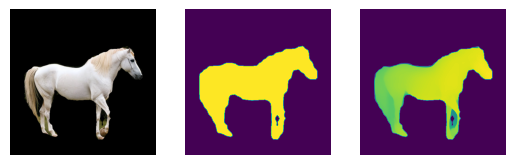

 40%|███████████████████████████▉                                          | 239/600 [00:02<00:03, 115.96it/s]

tensor(0.3111, device='cuda:0') tensor(0.4780, device='cuda:0')
tensor(0.3088, device='cuda:0') tensor(0.4761, device='cuda:0')
tensor(0.3036, device='cuda:0') tensor(0.4763, device='cuda:0')
tensor(0.2940, device='cuda:0') tensor(0.4765, device='cuda:0')
tensor(0.2795, device='cuda:0') tensor(0.4765, device='cuda:0')
tensor(0.2575, device='cuda:0') tensor(0.4766, device='cuda:0')
tensor(0.2274, device='cuda:0') tensor(0.4768, device='cuda:0')
tensor(0.1932, device='cuda:0') tensor(0.4768, device='cuda:0')
tensor(0.1865, device='cuda:0') tensor(0.4770, device='cuda:0')
tensor(0.1864, device='cuda:0') tensor(0.4770, device='cuda:0')
tensor(0.1863, device='cuda:0') tensor(0.4771, device='cuda:0')
tensor(0.1860, device='cuda:0') tensor(0.4771, device='cuda:0')
tensor(0.1859, device='cuda:0') tensor(0.4772, device='cuda:0')
tensor(0.1858, device='cuda:0') tensor(0.4771, device='cuda:0')
tensor(0.1859, device='cuda:0') tensor(0.4773, device='cuda:0')
tensor(0.1859, device='cuda:0') tensor(0

 44%|██████████████████████████████▋                                       | 263/600 [00:02<00:02, 117.43it/s]

tensor(0.1865, device='cuda:0') tensor(0.4778, device='cuda:0')
tensor(0.1865, device='cuda:0') tensor(0.4779, device='cuda:0')
tensor(0.1869, device='cuda:0') tensor(0.4781, device='cuda:0')
tensor(0.1870, device='cuda:0') tensor(0.4783, device='cuda:0')
tensor(0.1871, device='cuda:0') tensor(0.4785, device='cuda:0')
tensor(0.1871, device='cuda:0') tensor(0.4791, device='cuda:0')
tensor(0.1870, device='cuda:0') tensor(0.4799, device='cuda:0')
tensor(0.1871, device='cuda:0') tensor(0.4814, device='cuda:0')
tensor(0.1873, device='cuda:0') tensor(0.4851, device='cuda:0')
tensor(0.1873, device='cuda:0') tensor(0.4910, device='cuda:0')
tensor(0.1874, device='cuda:0') tensor(0.4995, device='cuda:0')
tensor(0.1877, device='cuda:0') tensor(0.5143, device='cuda:0')
tensor(0.1879, device='cuda:0') tensor(0.5335, device='cuda:0')
tensor(0.1881, device='cuda:0') tensor(0.5363, device='cuda:0')
tensor(0.1882, device='cuda:0') tensor(0.5362, device='cuda:0')
tensor(0.1883, device='cuda:0') tensor(0

 48%|█████████████████████████████████▌                                    | 288/600 [00:02<00:02, 119.74it/s]

tensor(0.1896, device='cuda:0') tensor(0.4794, device='cuda:0')
tensor(0.1898, device='cuda:0') tensor(0.4584, device='cuda:0')
tensor(0.1900, device='cuda:0') tensor(0.4386, device='cuda:0')
tensor(0.1900, device='cuda:0') tensor(0.4122, device='cuda:0')
tensor(0.1899, device='cuda:0') tensor(0.4119, device='cuda:0')
tensor(0.1900, device='cuda:0') tensor(0.4118, device='cuda:0')
tensor(0.1902, device='cuda:0') tensor(0.4118, device='cuda:0')
tensor(0.1902, device='cuda:0') tensor(0.4118, device='cuda:0')
tensor(0.1903, device='cuda:0') tensor(0.4118, device='cuda:0')
tensor(0.1903, device='cuda:0') tensor(0.4118, device='cuda:0')
tensor(0.1903, device='cuda:0') tensor(0.4117, device='cuda:0')
tensor(0.1903, device='cuda:0') tensor(0.4115, device='cuda:0')
tensor(0.1903, device='cuda:0') tensor(0.4116, device='cuda:0')
tensor(0.1902, device='cuda:0') tensor(0.4115, device='cuda:0')
tensor(0.1902, device='cuda:0') tensor(0.4114, device='cuda:0')
tensor(0.1901, device='cuda:0') tensor(0

 52%|████████████████████████████████████▍                                 | 312/600 [00:02<00:02, 119.49it/s]

tensor(0.1890, device='cuda:0') tensor(0.4110, device='cuda:0')
tensor(0.1889, device='cuda:0') tensor(0.4109, device='cuda:0')
tensor(0.1888, device='cuda:0') tensor(0.4108, device='cuda:0')
tensor(0.1888, device='cuda:0') tensor(0.4108, device='cuda:0')
tensor(0.1886, device='cuda:0') tensor(0.4107, device='cuda:0')
tensor(0.1886, device='cuda:0') tensor(0.4106, device='cuda:0')
tensor(0.1884, device='cuda:0') tensor(0.4106, device='cuda:0')
tensor(0.1882, device='cuda:0') tensor(0.4105, device='cuda:0')
tensor(0.1881, device='cuda:0') tensor(0.4103, device='cuda:0')
tensor(0.1879, device='cuda:0') tensor(0.4103, device='cuda:0')
tensor(0.1878, device='cuda:0') tensor(0.4102, device='cuda:0')
tensor(0.1877, device='cuda:0') tensor(0.4101, device='cuda:0')
tensor(0.1876, device='cuda:0') tensor(0.4101, device='cuda:0')
tensor(0.1876, device='cuda:0') tensor(0.4100, device='cuda:0')
tensor(0.1874, device='cuda:0') tensor(0.4099, device='cuda:0')
tensor(0.1875, device='cuda:0') tensor(0

 56%|███████████████████████████████████████▏                              | 336/600 [00:02<00:02, 119.20it/s]

tensor(0.1878, device='cuda:0') tensor(0.4106, device='cuda:0')
tensor(0.1879, device='cuda:0') tensor(0.4106, device='cuda:0')
tensor(0.1880, device='cuda:0') tensor(0.4105, device='cuda:0')
tensor(0.1881, device='cuda:0') tensor(0.4106, device='cuda:0')
tensor(0.1881, device='cuda:0') tensor(0.4106, device='cuda:0')
tensor(0.1882, device='cuda:0') tensor(0.4106, device='cuda:0')
tensor(0.1882, device='cuda:0') tensor(0.4107, device='cuda:0')
tensor(0.1883, device='cuda:0') tensor(0.4107, device='cuda:0')
tensor(0.1884, device='cuda:0') tensor(0.4106, device='cuda:0')
tensor(0.1883, device='cuda:0') tensor(0.4106, device='cuda:0')
tensor(0.1882, device='cuda:0') tensor(0.4107, device='cuda:0')
tensor(0.1884, device='cuda:0') tensor(0.4107, device='cuda:0')
tensor(0.1884, device='cuda:0') tensor(0.4106, device='cuda:0')
tensor(0.1885, device='cuda:0') tensor(0.4106, device='cuda:0')
tensor(0.1884, device='cuda:0') tensor(0.4105, device='cuda:0')
tensor(0.1886, device='cuda:0') tensor(0

 60%|██████████████████████████████████████████                            | 360/600 [00:03<00:02, 119.11it/s]

tensor(0.1878, device='cuda:0') tensor(0.6979, device='cuda:0')
tensor(0.1877, device='cuda:0') tensor(0.7071, device='cuda:0')
tensor(0.1876, device='cuda:0') tensor(0.7123, device='cuda:0')
tensor(0.1874, device='cuda:0') tensor(0.7146, device='cuda:0')
tensor(0.1875, device='cuda:0') tensor(0.7154, device='cuda:0')
tensor(0.1873, device='cuda:0') tensor(0.7154, device='cuda:0')
tensor(0.1872, device='cuda:0') tensor(0.7154, device='cuda:0')
tensor(0.1871, device='cuda:0') tensor(0.7156, device='cuda:0')
tensor(0.1872, device='cuda:0') tensor(0.7158, device='cuda:0')
tensor(0.1871, device='cuda:0') tensor(0.7149, device='cuda:0')
tensor(0.1869, device='cuda:0') tensor(0.6814, device='cuda:0')
tensor(0.1867, device='cuda:0') tensor(0.6383, device='cuda:0')
tensor(0.1867, device='cuda:0') tensor(0.6079, device='cuda:0')
tensor(0.1868, device='cuda:0') tensor(0.5946, device='cuda:0')
tensor(0.1867, device='cuda:0') tensor(0.5881, device='cuda:0')
tensor(0.1867, device='cuda:0') tensor(0

 64%|████████████████████████████████████████████▊                         | 384/600 [00:03<00:01, 117.61it/s]

tensor(0.1867, device='cuda:0') tensor(0.5764, device='cuda:0')
tensor(0.1868, device='cuda:0') tensor(0.5762, device='cuda:0')
tensor(0.1868, device='cuda:0') tensor(0.5762, device='cuda:0')
tensor(0.1867, device='cuda:0') tensor(0.5760, device='cuda:0')
tensor(0.1866, device='cuda:0') tensor(0.5759, device='cuda:0')
tensor(0.1867, device='cuda:0') tensor(0.5758, device='cuda:0')
tensor(0.1866, device='cuda:0') tensor(0.5757, device='cuda:0')
tensor(0.1867, device='cuda:0') tensor(0.5756, device='cuda:0')
tensor(0.1867, device='cuda:0') tensor(0.5756, device='cuda:0')
tensor(0.1867, device='cuda:0') tensor(0.5754, device='cuda:0')
tensor(0.1869, device='cuda:0') tensor(0.5753, device='cuda:0')
tensor(0.1869, device='cuda:0') tensor(0.5751, device='cuda:0')
tensor(0.1869, device='cuda:0') tensor(0.5751, device='cuda:0')
tensor(0.1871, device='cuda:0') tensor(0.5750, device='cuda:0')
tensor(0.1947, device='cuda:0') tensor(0.5750, device='cuda:0')
tensor(0.2959, device='cuda:0') tensor(0

100%|██████████████████████████████████████████████████████████████████████| 600/600 [00:05<00:00, 114.44it/s]


/grogu/user/akirchme/art3d_sd_webui/images/horse/519.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/519.mp4


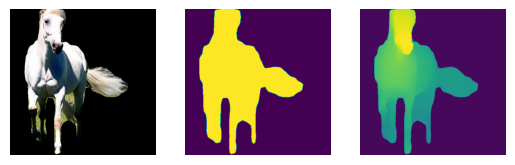

  2%|█▍                                                                     | 12/600 [00:00<00:05, 112.71it/s]

tensor(0.3113, device='cuda:0') tensor(0.4902, device='cuda:0')
tensor(0.3117, device='cuda:0') tensor(0.4902, device='cuda:0')
tensor(0.3122, device='cuda:0') tensor(0.4902, device='cuda:0')
tensor(0.3125, device='cuda:0') tensor(0.4902, device='cuda:0')
tensor(0.3125, device='cuda:0') tensor(0.4901, device='cuda:0')
tensor(0.3126, device='cuda:0') tensor(0.4901, device='cuda:0')
tensor(0.3128, device='cuda:0') tensor(0.4902, device='cuda:0')
tensor(0.3131, device='cuda:0') tensor(0.4902, device='cuda:0')
tensor(0.3132, device='cuda:0') tensor(0.4902, device='cuda:0')
tensor(0.3131, device='cuda:0') tensor(0.4903, device='cuda:0')
tensor(0.3132, device='cuda:0') tensor(0.4902, device='cuda:0')
tensor(0.3132, device='cuda:0') tensor(0.4902, device='cuda:0')
tensor(0.3134, device='cuda:0') tensor(0.4901, device='cuda:0')
tensor(0.3136, device='cuda:0') tensor(0.4902, device='cuda:0')
tensor(0.3139, device='cuda:0') tensor(0.4901, device='cuda:0')
tensor(0.3142, device='cuda:0') tensor(0

  6%|████▎                                                                  | 36/600 [00:00<00:04, 114.08it/s]

tensor(0.3154, device='cuda:0') tensor(0.4902, device='cuda:0')
tensor(0.3154, device='cuda:0') tensor(0.4901, device='cuda:0')
tensor(0.3152, device='cuda:0') tensor(0.4900, device='cuda:0')
tensor(0.3151, device='cuda:0') tensor(0.4900, device='cuda:0')
tensor(0.3146, device='cuda:0') tensor(0.4900, device='cuda:0')
tensor(0.3143, device='cuda:0') tensor(0.4901, device='cuda:0')
tensor(0.3140, device='cuda:0') tensor(0.4900, device='cuda:0')
tensor(0.3135, device='cuda:0') tensor(0.4901, device='cuda:0')
tensor(0.3131, device='cuda:0') tensor(0.4903, device='cuda:0')
tensor(0.3127, device='cuda:0') tensor(0.5061, device='cuda:0')


 12%|████████▍                                                              | 71/600 [00:00<00:05, 105.34it/s]

tensor(0.2998, device='cuda:0') tensor(0.5609, device='cuda:0')
tensor(0.2993, device='cuda:0') tensor(0.5611, device='cuda:0')
tensor(0.2987, device='cuda:0') tensor(0.5611, device='cuda:0')
tensor(0.2985, device='cuda:0') tensor(0.5614, device='cuda:0')
tensor(0.2982, device='cuda:0') tensor(0.5620, device='cuda:0')
tensor(0.2980, device='cuda:0') tensor(0.5623, device='cuda:0')
tensor(0.2978, device='cuda:0') tensor(0.5630, device='cuda:0')
tensor(0.2978, device='cuda:0') tensor(0.5639, device='cuda:0')
tensor(0.2977, device='cuda:0') tensor(0.5647, device='cuda:0')
tensor(0.2975, device='cuda:0') tensor(0.5650, device='cuda:0')
tensor(0.2974, device='cuda:0') tensor(0.5652, device='cuda:0')
tensor(0.2974, device='cuda:0') tensor(0.5648, device='cuda:0')
tensor(0.2974, device='cuda:0') tensor(0.5649, device='cuda:0')
tensor(0.2974, device='cuda:0') tensor(0.5647, device='cuda:0')
tensor(0.2973, device='cuda:0') tensor(0.5645, device='cuda:0')
tensor(0.2973, device='cuda:0') tensor(0

 48%|█████████████████████████████████▌                                    | 288/600 [00:02<00:02, 104.12it/s]

tensor(0.3697, device='cuda:0') tensor(0.5136, device='cuda:0')
tensor(0.3701, device='cuda:0') tensor(0.5131, device='cuda:0')
tensor(0.3705, device='cuda:0') tensor(0.5131, device='cuda:0')
tensor(0.3708, device='cuda:0') tensor(0.5130, device='cuda:0')
tensor(0.3710, device='cuda:0') tensor(0.5132, device='cuda:0')
tensor(0.3714, device='cuda:0') tensor(0.5133, device='cuda:0')
tensor(0.3717, device='cuda:0') tensor(0.5134, device='cuda:0')
tensor(0.3720, device='cuda:0') tensor(0.5134, device='cuda:0')
tensor(0.3722, device='cuda:0') tensor(0.5134, device='cuda:0')
tensor(0.3724, device='cuda:0') tensor(0.5132, device='cuda:0')
tensor(0.3724, device='cuda:0') tensor(0.5131, device='cuda:0')
tensor(0.3724, device='cuda:0') tensor(0.5131, device='cuda:0')
tensor(0.3724, device='cuda:0') tensor(0.5131, device='cuda:0')
tensor(0.3723, device='cuda:0') tensor(0.5130, device='cuda:0')
tensor(0.3722, device='cuda:0') tensor(0.5131, device='cuda:0')
tensor(0.3722, device='cuda:0') tensor(0

 52%|████████████████████████████████████▌                                 | 313/600 [00:03<00:02, 111.82it/s]

tensor(0.3713, device='cuda:0') tensor(0.5127, device='cuda:0')
tensor(0.3716, device='cuda:0') tensor(0.5126, device='cuda:0')
tensor(0.3716, device='cuda:0') tensor(0.5125, device='cuda:0')
tensor(0.3718, device='cuda:0') tensor(0.5124, device='cuda:0')
tensor(0.3720, device='cuda:0') tensor(0.5124, device='cuda:0')
tensor(0.3721, device='cuda:0') tensor(0.5123, device='cuda:0')
tensor(0.3721, device='cuda:0') tensor(0.5123, device='cuda:0')
tensor(0.3721, device='cuda:0') tensor(0.5123, device='cuda:0')
tensor(0.3720, device='cuda:0') tensor(0.5122, device='cuda:0')
tensor(0.3718, device='cuda:0') tensor(0.5120, device='cuda:0')
tensor(0.3716, device='cuda:0') tensor(0.5120, device='cuda:0')
tensor(0.3711, device='cuda:0') tensor(0.5121, device='cuda:0')
tensor(0.3708, device='cuda:0') tensor(0.5121, device='cuda:0')
tensor(0.3706, device='cuda:0') tensor(0.5120, device='cuda:0')
tensor(0.3705, device='cuda:0') tensor(0.5120, device='cuda:0')
tensor(0.3703, device='cuda:0') tensor(0

 56%|███████████████████████████████████████▍                              | 338/600 [00:03<00:02, 112.08it/s]

tensor(0.3690, device='cuda:0') tensor(0.5114, device='cuda:0')
tensor(0.3690, device='cuda:0') tensor(0.5114, device='cuda:0')
tensor(0.3689, device='cuda:0') tensor(0.5113, device='cuda:0')
tensor(0.3690, device='cuda:0') tensor(0.5113, device='cuda:0')
tensor(0.3687, device='cuda:0') tensor(0.5113, device='cuda:0')
tensor(0.3685, device='cuda:0') tensor(0.5112, device='cuda:0')
tensor(0.3683, device='cuda:0') tensor(0.5112, device='cuda:0')
tensor(0.3681, device='cuda:0') tensor(0.5112, device='cuda:0')
tensor(0.3680, device='cuda:0') tensor(0.5111, device='cuda:0')
tensor(0.3679, device='cuda:0') tensor(0.5111, device='cuda:0')
tensor(0.3678, device='cuda:0') tensor(0.5112, device='cuda:0')
tensor(0.3676, device='cuda:0') tensor(0.5112, device='cuda:0')
tensor(0.3673, device='cuda:0') tensor(0.5112, device='cuda:0')
tensor(0.3669, device='cuda:0') tensor(0.5112, device='cuda:0')
tensor(0.3666, device='cuda:0') tensor(0.5114, device='cuda:0')


 91%|███████████████████████████████████████████████████████████████▋      | 546/600 [00:05<00:00, 105.17it/s]

tensor(0.2983, device='cuda:0') tensor(0.5545, device='cuda:0')
tensor(0.2960, device='cuda:0') tensor(0.5544, device='cuda:0')
tensor(0.2959, device='cuda:0') tensor(0.5551, device='cuda:0')
tensor(0.2957, device='cuda:0') tensor(0.5551, device='cuda:0')
tensor(0.2957, device='cuda:0') tensor(0.5552, device='cuda:0')
tensor(0.2955, device='cuda:0') tensor(0.5555, device='cuda:0')
tensor(0.2954, device='cuda:0') tensor(0.5556, device='cuda:0')
tensor(0.2953, device='cuda:0') tensor(0.5555, device='cuda:0')
tensor(0.2952, device='cuda:0') tensor(0.5552, device='cuda:0')
tensor(0.2952, device='cuda:0') tensor(0.5552, device='cuda:0')
tensor(0.2950, device='cuda:0') tensor(0.5550, device='cuda:0')
tensor(0.2949, device='cuda:0') tensor(0.5546, device='cuda:0')
tensor(0.2948, device='cuda:0') tensor(0.5544, device='cuda:0')
tensor(0.2946, device='cuda:0') tensor(0.5543, device='cuda:0')
tensor(0.2945, device='cuda:0') tensor(0.5545, device='cuda:0')
tensor(0.2943, device='cuda:0') tensor(0

 95%|██████████████████████████████████████████████████████████████████▌   | 570/600 [00:05<00:00, 110.46it/s]

tensor(0.2943, device='cuda:0') tensor(0.5648, device='cuda:0')
tensor(0.2945, device='cuda:0') tensor(0.5677, device='cuda:0')
tensor(0.2947, device='cuda:0') tensor(0.5743, device='cuda:0')
tensor(0.2953, device='cuda:0') tensor(0.5820, device='cuda:0')
tensor(0.2956, device='cuda:0') tensor(0.5935, device='cuda:0')
tensor(0.2957, device='cuda:0') tensor(0.6071, device='cuda:0')
tensor(0.2960, device='cuda:0') tensor(0.6079, device='cuda:0')
tensor(0.2962, device='cuda:0') tensor(0.6074, device='cuda:0')
tensor(0.2964, device='cuda:0') tensor(0.6071, device='cuda:0')
tensor(0.2967, device='cuda:0') tensor(0.6063, device='cuda:0')
tensor(0.2969, device='cuda:0') tensor(0.6056, device='cuda:0')
tensor(0.2972, device='cuda:0') tensor(0.6034, device='cuda:0')
tensor(0.2977, device='cuda:0') tensor(0.5956, device='cuda:0')
tensor(0.2982, device='cuda:0') tensor(0.5894, device='cuda:0')
tensor(0.2990, device='cuda:0') tensor(0.5826, device='cuda:0')
tensor(0.2995, device='cuda:0') tensor(0

 99%|█████████████████████████████████████████████████████████████████████▌| 596/600 [00:05<00:00, 116.79it/s]

tensor(0.3043, device='cuda:0') tensor(0.4891, device='cuda:0')
tensor(0.3046, device='cuda:0') tensor(0.4893, device='cuda:0')
tensor(0.3049, device='cuda:0') tensor(0.4894, device='cuda:0')
tensor(0.3053, device='cuda:0') tensor(0.4894, device='cuda:0')
tensor(0.3055, device='cuda:0') tensor(0.4894, device='cuda:0')
tensor(0.3057, device='cuda:0') tensor(0.4893, device='cuda:0')
tensor(0.3058, device='cuda:0') tensor(0.4893, device='cuda:0')
tensor(0.3059, device='cuda:0') tensor(0.4894, device='cuda:0')
tensor(0.3060, device='cuda:0') tensor(0.4897, device='cuda:0')
tensor(0.3060, device='cuda:0') tensor(0.4899, device='cuda:0')
tensor(0.3060, device='cuda:0') tensor(0.4900, device='cuda:0')
tensor(0.3060, device='cuda:0') tensor(0.4899, device='cuda:0')
tensor(0.3059, device='cuda:0') tensor(0.4898, device='cuda:0')
tensor(0.3060, device='cuda:0') tensor(0.4899, device='cuda:0')
tensor(0.3062, device='cuda:0') tensor(0.4900, device='cuda:0')
tensor(0.3063, device='cuda:0') tensor(0

100%|███████████████████████████████████████████████████████████████████████| 600/600 [00:06<00:00, 99.81it/s]


tensor(0.3104, device='cuda:0') tensor(0.4904, device='cuda:0')
tensor(0.3108, device='cuda:0') tensor(0.4903, device='cuda:0')
tensor(0.3109, device='cuda:0') tensor(0.4903, device='cuda:0')
/grogu/user/akirchme/art3d_sd_webui/images/horse/178.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/178.mp4


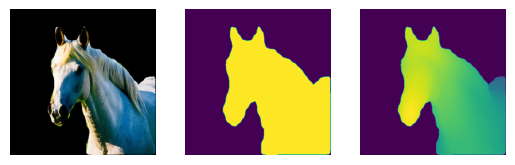

  4%|██▊                                                                    | 24/600 [00:00<00:04, 116.21it/s]

tensor(0.2243, device='cuda:0') tensor(0.4874, device='cuda:0')
tensor(0.2239, device='cuda:0') tensor(0.4874, device='cuda:0')
tensor(0.2231, device='cuda:0') tensor(0.4874, device='cuda:0')
tensor(0.2224, device='cuda:0') tensor(0.4875, device='cuda:0')
tensor(0.2217, device='cuda:0') tensor(0.4875, device='cuda:0')
tensor(0.2210, device='cuda:0') tensor(0.4875, device='cuda:0')
tensor(0.2199, device='cuda:0') tensor(0.4876, device='cuda:0')
tensor(0.2189, device='cuda:0') tensor(0.4876, device='cuda:0')
tensor(0.2177, device='cuda:0') tensor(0.4876, device='cuda:0')
tensor(0.2165, device='cuda:0') tensor(0.4877, device='cuda:0')
tensor(0.2152, device='cuda:0') tensor(0.4877, device='cuda:0')
tensor(0.2142, device='cuda:0') tensor(0.4877, device='cuda:0')
tensor(0.2135, device='cuda:0') tensor(0.4877, device='cuda:0')
tensor(0.2129, device='cuda:0') tensor(0.4877, device='cuda:0')
tensor(0.2121, device='cuda:0') tensor(0.4878, device='cuda:0')
tensor(0.2113, device='cuda:0') tensor(0

  6%|████▍                                                                  | 37/600 [00:00<00:04, 119.50it/s]

tensor(0.2090, device='cuda:0') tensor(0.4878, device='cuda:0')
tensor(0.2079, device='cuda:0') tensor(0.4877, device='cuda:0')
tensor(0.2065, device='cuda:0') tensor(0.4878, device='cuda:0')
tensor(0.2049, device='cuda:0') tensor(0.4877, device='cuda:0')
tensor(0.2030, device='cuda:0') tensor(0.4877, device='cuda:0')
tensor(0.2011, device='cuda:0') tensor(0.4877, device='cuda:0')
tensor(0.1992, device='cuda:0') tensor(0.4877, device='cuda:0')
tensor(0.1971, device='cuda:0') tensor(0.4880, device='cuda:0')
tensor(0.1949, device='cuda:0') tensor(0.4955, device='cuda:0')
tensor(0.1929, device='cuda:0') tensor(0.5067, device='cuda:0')
tensor(0.1913, device='cuda:0') tensor(0.5220, device='cuda:0')
tensor(0.1900, device='cuda:0') tensor(0.5422, device='cuda:0')
tensor(0.1889, device='cuda:0') tensor(0.5598, device='cuda:0')
tensor(0.1879, device='cuda:0') tensor(0.5812, device='cuda:0')
tensor(0.1869, device='cuda:0') tensor(0.6040, device='cuda:0')
tensor(0.1857, device='cuda:0') tensor(0

 10%|███████▍                                                               | 63/600 [00:00<00:04, 119.94it/s]

tensor(0.1778, device='cuda:0') tensor(0.6273, device='cuda:0')
tensor(0.1769, device='cuda:0') tensor(0.6138, device='cuda:0')
tensor(0.1762, device='cuda:0') tensor(0.5988, device='cuda:0')
tensor(0.1751, device='cuda:0') tensor(0.5884, device='cuda:0')
tensor(0.1740, device='cuda:0') tensor(0.5784, device='cuda:0')
tensor(0.1731, device='cuda:0') tensor(0.5708, device='cuda:0')
tensor(0.1722, device='cuda:0') tensor(0.5724, device='cuda:0')
tensor(0.1715, device='cuda:0') tensor(0.5734, device='cuda:0')
tensor(0.1707, device='cuda:0') tensor(0.5736, device='cuda:0')
tensor(0.1701, device='cuda:0') tensor(0.5735, device='cuda:0')
tensor(0.1693, device='cuda:0') tensor(0.5728, device='cuda:0')
tensor(0.1690, device='cuda:0') tensor(0.5731, device='cuda:0')
tensor(0.1688, device='cuda:0') tensor(0.5731, device='cuda:0')
tensor(0.1686, device='cuda:0') tensor(0.5742, device='cuda:0')
tensor(0.1685, device='cuda:0') tensor(0.5756, device='cuda:0')
tensor(0.1682, device='cuda:0') tensor(0

 14%|██████████▎                                                            | 87/600 [00:00<00:04, 110.36it/s]

tensor(0.1687, device='cuda:0') tensor(0.5721, device='cuda:0')
tensor(0.1690, device='cuda:0') tensor(0.5697, device='cuda:0')
tensor(0.1706, device='cuda:0') tensor(0.5671, device='cuda:0')
tensor(0.1846, device='cuda:0') tensor(0.5652, device='cuda:0')
tensor(0.2076, device='cuda:0') tensor(0.5634, device='cuda:0')
tensor(0.2345, device='cuda:0') tensor(0.5616, device='cuda:0')
tensor(0.2641, device='cuda:0') tensor(0.5601, device='cuda:0')
tensor(0.2961, device='cuda:0') tensor(0.5584, device='cuda:0')


 90%|███████████████████████████████████████████████████████████████▋       | 538/600 [00:06<00:00, 93.01it/s]

tensor(0.2807, device='cuda:0') tensor(0.5323, device='cuda:0')
tensor(0.2315, device='cuda:0') tensor(0.5330, device='cuda:0')
tensor(0.2085, device='cuda:0') tensor(0.5337, device='cuda:0')
tensor(0.1946, device='cuda:0') tensor(0.5352, device='cuda:0')
tensor(0.1833, device='cuda:0') tensor(0.5367, device='cuda:0')
tensor(0.1769, device='cuda:0') tensor(0.5384, device='cuda:0')
tensor(0.1765, device='cuda:0') tensor(0.5408, device='cuda:0')
tensor(0.1764, device='cuda:0') tensor(0.5429, device='cuda:0')
tensor(0.1764, device='cuda:0') tensor(0.5450, device='cuda:0')
tensor(0.1766, device='cuda:0') tensor(0.5476, device='cuda:0')
tensor(0.1768, device='cuda:0') tensor(0.5499, device='cuda:0')
tensor(0.1771, device='cuda:0') tensor(0.5517, device='cuda:0')
tensor(0.1773, device='cuda:0') tensor(0.5527, device='cuda:0')
tensor(0.1773, device='cuda:0') tensor(0.5529, device='cuda:0')
tensor(0.1775, device='cuda:0') tensor(0.5527, device='cuda:0')
tensor(0.1779, device='cuda:0') tensor(0

 94%|█████████████████████████████████████████████████████████████████▋    | 563/600 [00:06<00:00, 106.85it/s]

tensor(0.1835, device='cuda:0') tensor(0.5368, device='cuda:0')
tensor(0.1848, device='cuda:0') tensor(0.5362, device='cuda:0')
tensor(0.1858, device='cuda:0') tensor(0.5362, device='cuda:0')
tensor(0.1866, device='cuda:0') tensor(0.5478, device='cuda:0')
tensor(0.1879, device='cuda:0') tensor(0.5714, device='cuda:0')
tensor(0.1892, device='cuda:0') tensor(0.6004, device='cuda:0')
tensor(0.1902, device='cuda:0') tensor(0.6118, device='cuda:0')
tensor(0.1914, device='cuda:0') tensor(0.6179, device='cuda:0')
tensor(0.1922, device='cuda:0') tensor(0.6229, device='cuda:0')
tensor(0.1930, device='cuda:0') tensor(0.6270, device='cuda:0')
tensor(0.1936, device='cuda:0') tensor(0.6287, device='cuda:0')
tensor(0.1941, device='cuda:0') tensor(0.6277, device='cuda:0')
tensor(0.1947, device='cuda:0') tensor(0.6274, device='cuda:0')
tensor(0.1951, device='cuda:0') tensor(0.6271, device='cuda:0')
tensor(0.1955, device='cuda:0') tensor(0.6269, device='cuda:0')
tensor(0.1960, device='cuda:0') tensor(0

 98%|████████████████████████████████████████████████████████████████████▍ | 587/600 [00:06<00:00, 112.51it/s]

tensor(0.2062, device='cuda:0') tensor(0.4868, device='cuda:0')
tensor(0.2077, device='cuda:0') tensor(0.4868, device='cuda:0')
tensor(0.2094, device='cuda:0') tensor(0.4866, device='cuda:0')
tensor(0.2108, device='cuda:0') tensor(0.4863, device='cuda:0')
tensor(0.2120, device='cuda:0') tensor(0.4861, device='cuda:0')
tensor(0.2133, device='cuda:0') tensor(0.4859, device='cuda:0')
tensor(0.2143, device='cuda:0') tensor(0.4858, device='cuda:0')
tensor(0.2152, device='cuda:0') tensor(0.4858, device='cuda:0')
tensor(0.2160, device='cuda:0') tensor(0.4860, device='cuda:0')
tensor(0.2167, device='cuda:0') tensor(0.4860, device='cuda:0')
tensor(0.2169, device='cuda:0') tensor(0.4859, device='cuda:0')
tensor(0.2170, device='cuda:0') tensor(0.4859, device='cuda:0')
tensor(0.2170, device='cuda:0') tensor(0.4863, device='cuda:0')
tensor(0.2171, device='cuda:0') tensor(0.4866, device='cuda:0')
tensor(0.2170, device='cuda:0') tensor(0.4867, device='cuda:0')
tensor(0.2169, device='cuda:0') tensor(0

100%|███████████████████████████████████████████████████████████████████████| 600/600 [00:06<00:00, 86.25it/s]


tensor(0.2223, device='cuda:0') tensor(0.4872, device='cuda:0')
tensor(0.2228, device='cuda:0') tensor(0.4872, device='cuda:0')
tensor(0.2233, device='cuda:0') tensor(0.4873, device='cuda:0')
tensor(0.2238, device='cuda:0') tensor(0.4873, device='cuda:0')
tensor(0.2241, device='cuda:0') tensor(0.4874, device='cuda:0')
tensor(0.2246, device='cuda:0') tensor(0.4874, device='cuda:0')
tensor(0.2246, device='cuda:0') tensor(0.4874, device='cuda:0')
tensor(0.2248, device='cuda:0') tensor(0.4874, device='cuda:0')
/grogu/user/akirchme/art3d_sd_webui/images/horse/1015.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/1015.mp4


 38%|██████████████████████████▉                                           | 231/600 [00:02<00:03, 108.01it/s]

tensor(0.3707, device='cuda:0') tensor(0.5173, device='cuda:0')
tensor(0.3707, device='cuda:0') tensor(0.5148, device='cuda:0')
tensor(0.3700, device='cuda:0') tensor(0.5148, device='cuda:0')
tensor(0.3668, device='cuda:0') tensor(0.5148, device='cuda:0')
tensor(0.3577, device='cuda:0') tensor(0.5148, device='cuda:0')
tensor(0.3162, device='cuda:0') tensor(0.5148, device='cuda:0')
tensor(0.2442, device='cuda:0') tensor(0.5147, device='cuda:0')
tensor(0.1417, device='cuda:0') tensor(0.5148, device='cuda:0')
tensor(0.0956, device='cuda:0') tensor(0.5148, device='cuda:0')
tensor(0.0950, device='cuda:0') tensor(0.5150, device='cuda:0')
tensor(0.0950, device='cuda:0') tensor(0.5151, device='cuda:0')
tensor(0.0949, device='cuda:0') tensor(0.5150, device='cuda:0')
tensor(0.0949, device='cuda:0') tensor(0.5150, device='cuda:0')
tensor(0.0949, device='cuda:0') tensor(0.5148, device='cuda:0')
tensor(0.0949, device='cuda:0') tensor(0.5148, device='cuda:0')
tensor(0.0949, device='cuda:0') tensor(0

 43%|█████████████████████████████▊                                        | 256/600 [00:02<00:03, 114.04it/s]

tensor(0.5139, device='cuda:0')
tensor(0.0955, device='cuda:0') tensor(0.5137, device='cuda:0')
tensor(0.0954, device='cuda:0') tensor(0.5137, device='cuda:0')
tensor(0.0955, device='cuda:0') tensor(0.5136, device='cuda:0')
tensor(0.0956, device='cuda:0') tensor(0.5134, device='cuda:0')
tensor(0.0956, device='cuda:0') tensor(0.5133, device='cuda:0')
tensor(0.0957, device='cuda:0') tensor(0.5136, device='cuda:0')
tensor(0.0958, device='cuda:0') tensor(0.5145, device='cuda:0')
tensor(0.0958, device='cuda:0') tensor(0.5182, device='cuda:0')
tensor(0.0958, device='cuda:0') tensor(0.5445, device='cuda:0')
tensor(0.0959, device='cuda:0') tensor(0.5887, device='cuda:0')
tensor(0.0959, device='cuda:0') tensor(0.6405, device='cuda:0')
tensor(0.0960, device='cuda:0') tensor(0.6906, device='cuda:0')
tensor(0.0960, device='cuda:0') tensor(0.7078, device='cuda:0')
tensor(0.0961, device='cuda:0') tensor(0.7078, device='cuda:0')
tensor(0.0962, device='cuda:0') tensor(0.7077, device='cuda:0')
tensor(0

 47%|████████████████████████████████▊                                     | 281/600 [00:02<00:02, 117.28it/s]

tensor(0.0968, device='cuda:0') tensor(0.5709, device='cuda:0')
tensor(0.0969, device='cuda:0') tensor(0.4927, device='cuda:0')
tensor(0.0970, device='cuda:0') tensor(0.4504, device='cuda:0')
tensor(0.0971, device='cuda:0') tensor(0.4310, device='cuda:0')
tensor(0.0972, device='cuda:0') tensor(0.4309, device='cuda:0')
tensor(0.0973, device='cuda:0') tensor(0.4308, device='cuda:0')
tensor(0.0974, device='cuda:0') tensor(0.4307, device='cuda:0')
tensor(0.0974, device='cuda:0') tensor(0.4306, device='cuda:0')
tensor(0.0975, device='cuda:0') tensor(0.4305, device='cuda:0')
tensor(0.0975, device='cuda:0') tensor(0.4304, device='cuda:0')
tensor(0.0975, device='cuda:0') tensor(0.4303, device='cuda:0')
tensor(0.0976, device='cuda:0') tensor(0.4302, device='cuda:0')
tensor(0.0976, device='cuda:0') tensor(0.4301, device='cuda:0')
tensor(0.0976, device='cuda:0') tensor(0.4301, device='cuda:0')
tensor(0.0976, device='cuda:0') tensor(0.4301, device='cuda:0')
tensor(0.0975, device='cuda:0') tensor(0

 51%|███████████████████████████████████▌                                  | 305/600 [00:02<00:02, 117.98it/s]

tensor(0.0974, device='cuda:0') tensor(0.4292, device='cuda:0')
tensor(0.0974, device='cuda:0') tensor(0.4291, device='cuda:0')
tensor(0.0974, device='cuda:0') tensor(0.4291, device='cuda:0')
tensor(0.0974, device='cuda:0') tensor(0.4289, device='cuda:0')
tensor(0.0974, device='cuda:0') tensor(0.4288, device='cuda:0')
tensor(0.0973, device='cuda:0') tensor(0.4287, device='cuda:0')
tensor(0.0973, device='cuda:0') tensor(0.4286, device='cuda:0')
tensor(0.0973, device='cuda:0') tensor(0.4286, device='cuda:0')
tensor(0.0973, device='cuda:0') tensor(0.4284, device='cuda:0')
tensor(0.0972, device='cuda:0') tensor(0.4284, device='cuda:0')
tensor(0.0971, device='cuda:0') tensor(0.4284, device='cuda:0')
tensor(0.0971, device='cuda:0') tensor(0.4284, device='cuda:0')
tensor(0.0971, device='cuda:0') tensor(0.4284, device='cuda:0')
tensor(0.0970, device='cuda:0') tensor(0.4284, device='cuda:0')
tensor(0.0970, device='cuda:0') tensor(0.4284, device='cuda:0')
tensor(0.0969, device='cuda:0') tensor(0

 55%|██████████████████████████████████████▍                               | 329/600 [00:03<00:02, 118.65it/s]

tensor(0.0965, device='cuda:0') tensor(0.4278, device='cuda:0')
tensor(0.0964, device='cuda:0') tensor(0.4277, device='cuda:0')
tensor(0.0964, device='cuda:0') tensor(0.4277, device='cuda:0')
tensor(0.0964, device='cuda:0') tensor(0.4277, device='cuda:0')
tensor(0.0964, device='cuda:0') tensor(0.4276, device='cuda:0')
tensor(0.0965, device='cuda:0') tensor(0.4275, device='cuda:0')
tensor(0.0965, device='cuda:0') tensor(0.4276, device='cuda:0')
tensor(0.0965, device='cuda:0') tensor(0.4275, device='cuda:0')
tensor(0.0965, device='cuda:0') tensor(0.4275, device='cuda:0')
tensor(0.0965, device='cuda:0') tensor(0.4275, device='cuda:0')
tensor(0.0964, device='cuda:0') tensor(0.4275, device='cuda:0')
tensor(0.0964, device='cuda:0') tensor(0.4275, device='cuda:0')
tensor(0.0964, device='cuda:0') tensor(0.4276, device='cuda:0')
tensor(0.0964, device='cuda:0') tensor(0.4277, device='cuda:0')
tensor(0.0964, device='cuda:0') tensor(0.4278, device='cuda:0')
tensor(0.0964, device='cuda:0') tensor(0

 59%|█████████████████████████████████████████▏                            | 353/600 [00:03<00:02, 119.13it/s]

tensor(0.0958, device='cuda:0') tensor(0.5938, device='cuda:0')
tensor(0.0958, device='cuda:0') tensor(0.6174, device='cuda:0')
tensor(0.0958, device='cuda:0') tensor(0.6263, device='cuda:0')
tensor(0.0957, device='cuda:0') tensor(0.6301, device='cuda:0')
tensor(0.0957, device='cuda:0') tensor(0.6312, device='cuda:0')
tensor(0.0957, device='cuda:0') tensor(0.6314, device='cuda:0')
tensor(0.0956, device='cuda:0') tensor(0.6314, device='cuda:0')
tensor(0.0956, device='cuda:0') tensor(0.6315, device='cuda:0')
tensor(0.0956, device='cuda:0') tensor(0.6317, device='cuda:0')
tensor(0.0955, device='cuda:0') tensor(0.6315, device='cuda:0')
tensor(0.0955, device='cuda:0') tensor(0.6250, device='cuda:0')
tensor(0.0955, device='cuda:0') tensor(0.6090, device='cuda:0')
tensor(0.0955, device='cuda:0') tensor(0.5845, device='cuda:0')
tensor(0.0955, device='cuda:0') tensor(0.5487, device='cuda:0')
tensor(0.0955, device='cuda:0') tensor(0.5273, device='cuda:0')
tensor(0.0955, device='cuda:0') tensor(0

 63%|████████████████████████████████████████████                          | 378/600 [00:03<00:01, 119.46it/s]

tensor(0.5066, device='cuda:0')
tensor(0.0945, device='cuda:0') tensor(0.5067, device='cuda:0')
tensor(0.0944, device='cuda:0') tensor(0.5068, device='cuda:0')
tensor(0.0944, device='cuda:0') tensor(0.5069, device='cuda:0')
tensor(0.0945, device='cuda:0') tensor(0.5068, device='cuda:0')
tensor(0.0945, device='cuda:0') tensor(0.5069, device='cuda:0')
tensor(0.0945, device='cuda:0') tensor(0.5071, device='cuda:0')
tensor(0.0946, device='cuda:0') tensor(0.5071, device='cuda:0')
tensor(0.0946, device='cuda:0') tensor(0.5073, device='cuda:0')
tensor(0.0946, device='cuda:0') tensor(0.5073, device='cuda:0')
tensor(0.0947, device='cuda:0') tensor(0.5075, device='cuda:0')
tensor(0.0947, device='cuda:0') tensor(0.5076, device='cuda:0')
tensor(0.0947, device='cuda:0') tensor(0.5077, device='cuda:0')
tensor(0.0948, device='cuda:0') tensor(0.5077, device='cuda:0')
tensor(0.0958, device='cuda:0') tensor(0.5077, device='cuda:0')
tensor(0.1086, device='cuda:0') tensor(0.5076, device='cuda:0')
tensor(0

 67%|██████████████████████████████████████████████▉                       | 402/600 [00:03<00:01, 115.31it/s]

tensor(0.2983, device='cuda:0') tensor(0.6707, device='cuda:0')
tensor(0.2984, device='cuda:0') tensor(0.7176, device='cuda:0')
tensor(0.2985, device='cuda:0') tensor(0.7508, device='cuda:0')
tensor(0.2989, device='cuda:0') tensor(0.7663, device='cuda:0')
tensor(0.2992, device='cuda:0') tensor(0.7728, device='cuda:0')
tensor(0.2994, device='cuda:0') tensor(0.7765, device='cuda:0')
tensor(0.2997, device='cuda:0') tensor(0.7789, device='cuda:0')


100%|██████████████████████████████████████████████████████████████████████| 600/600 [00:05<00:00, 107.42it/s]


/grogu/user/akirchme/art3d_sd_webui/images/horse/756.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/756.mp4


  4%|██▊                                                                    | 24/600 [00:00<00:04, 119.26it/s]

tensor(0.3118, device='cuda:0') tensor(0.4457, device='cuda:0')
tensor(0.3124, device='cuda:0') tensor(0.4458, device='cuda:0')
tensor(0.3130, device='cuda:0') tensor(0.4458, device='cuda:0')
tensor(0.3136, device='cuda:0') tensor(0.4455, device='cuda:0')
tensor(0.3141, device='cuda:0') tensor(0.4457, device='cuda:0')
tensor(0.3145, device='cuda:0') tensor(0.4458, device='cuda:0')
tensor(0.3151, device='cuda:0') tensor(0.4458, device='cuda:0')
tensor(0.3156, device='cuda:0') tensor(0.4458, device='cuda:0')
tensor(0.3162, device='cuda:0') tensor(0.4459, device='cuda:0')
tensor(0.3171, device='cuda:0') tensor(0.4458, device='cuda:0')
tensor(0.3182, device='cuda:0') tensor(0.4456, device='cuda:0')
tensor(0.3191, device='cuda:0') tensor(0.4458, device='cuda:0')
tensor(0.3202, device='cuda:0') tensor(0.4459, device='cuda:0')
tensor(0.3216, device='cuda:0') tensor(0.4458, device='cuda:0')
tensor(0.3227, device='cuda:0') tensor(0.4458, device='cuda:0')
tensor(0.3244, device='cuda:0') tensor(0

  6%|████▎                                                                  | 36/600 [00:00<00:04, 119.25it/s]

tensor(0.3270, device='cuda:0') tensor(0.4476, device='cuda:0')
tensor(0.3268, device='cuda:0') tensor(0.4478, device='cuda:0')
tensor(0.3263, device='cuda:0') tensor(0.4481, device='cuda:0')
tensor(0.3256, device='cuda:0') tensor(0.4484, device='cuda:0')
tensor(0.3237, device='cuda:0') tensor(0.4489, device='cuda:0')
tensor(0.3219, device='cuda:0') tensor(0.4493, device='cuda:0')
tensor(0.3198, device='cuda:0') tensor(0.4498, device='cuda:0')
tensor(0.3168, device='cuda:0') tensor(0.4503, device='cuda:0')
tensor(0.3143, device='cuda:0') tensor(0.4509, device='cuda:0')
tensor(0.3112, device='cuda:0') tensor(0.4515, device='cuda:0')
tensor(0.3084, device='cuda:0') tensor(0.4535, device='cuda:0')
tensor(0.3053, device='cuda:0') tensor(0.4558, device='cuda:0')
tensor(0.3014, device='cuda:0') tensor(0.4617, device='cuda:0')
tensor(0.2980, device='cuda:0') tensor(0.4708, device='cuda:0')
tensor(0.2942, device='cuda:0') tensor(0.4803, device='cuda:0')
tensor(0.2907, device='cuda:0') tensor(0

 10%|███████▏                                                               | 61/600 [00:00<00:04, 119.31it/s]

tensor(0.2710, device='cuda:0') tensor(0.5234, device='cuda:0')
tensor(0.2695, device='cuda:0') tensor(0.5242, device='cuda:0')
tensor(0.2677, device='cuda:0') tensor(0.5229, device='cuda:0')
tensor(0.2661, device='cuda:0') tensor(0.5228, device='cuda:0')
tensor(0.2643, device='cuda:0') tensor(0.5223, device='cuda:0')
tensor(0.2627, device='cuda:0') tensor(0.5224, device='cuda:0')
tensor(0.2614, device='cuda:0') tensor(0.5224, device='cuda:0')
tensor(0.2604, device='cuda:0') tensor(0.5233, device='cuda:0')
tensor(0.2594, device='cuda:0') tensor(0.5242, device='cuda:0')
tensor(0.2587, device='cuda:0') tensor(0.5253, device='cuda:0')
tensor(0.2582, device='cuda:0') tensor(0.5263, device='cuda:0')
tensor(0.2579, device='cuda:0') tensor(0.5283, device='cuda:0')
tensor(0.2573, device='cuda:0') tensor(0.5295, device='cuda:0')
tensor(0.2570, device='cuda:0') tensor(0.5311, device='cuda:0')
tensor(0.2568, device='cuda:0') tensor(0.5335, device='cuda:0')
tensor(0.2569, device='cuda:0') tensor(0

 14%|██████████▏                                                            | 86/600 [00:00<00:04, 120.14it/s]

tensor(0.2555, device='cuda:0') tensor(0.5671, device='cuda:0')
tensor(0.2555, device='cuda:0') tensor(0.5683, device='cuda:0')
tensor(0.2556, device='cuda:0') tensor(0.5683, device='cuda:0')
tensor(0.2555, device='cuda:0') tensor(0.5677, device='cuda:0')
tensor(0.2561, device='cuda:0') tensor(0.5667, device='cuda:0')
tensor(0.2586, device='cuda:0') tensor(0.5656, device='cuda:0')
tensor(0.2678, device='cuda:0') tensor(0.5639, device='cuda:0')
tensor(0.2797, device='cuda:0') tensor(0.5617, device='cuda:0')
tensor(0.2912, device='cuda:0') tensor(0.5583, device='cuda:0')


 81%|████████████████████████████████████████████████████████▌             | 485/600 [00:03<00:00, 125.24it/s]

tensor(0.3976, device='cuda:0') tensor(0.5197, device='cuda:0')
tensor(0.3980, device='cuda:0') tensor(0.5191, device='cuda:0')
tensor(0.3984, device='cuda:0') tensor(0.5185, device='cuda:0')
tensor(0.3989, device='cuda:0') tensor(0.5182, device='cuda:0')
tensor(0.3995, device='cuda:0') tensor(0.5174, device='cuda:0')
tensor(0.4000, device='cuda:0') tensor(0.5172, device='cuda:0')
tensor(0.4010, device='cuda:0') tensor(0.5169, device='cuda:0')
tensor(0.4023, device='cuda:0') tensor(0.5165, device='cuda:0')
tensor(0.4029, device='cuda:0') tensor(0.5162, device='cuda:0')
tensor(0.4035, device='cuda:0') tensor(0.5164, device='cuda:0')
tensor(0.4035, device='cuda:0') tensor(0.5160, device='cuda:0')
tensor(0.4031, device='cuda:0') tensor(0.5156, device='cuda:0')
tensor(0.4025, device='cuda:0') tensor(0.5154, device='cuda:0')
tensor(0.4016, device='cuda:0') tensor(0.5155, device='cuda:0')
tensor(0.4010, device='cuda:0') tensor(0.5154, device='cuda:0')
tensor(0.4002, device='cuda:0') tensor(0

 85%|███████████████████████████████████████████████████████████▌          | 511/600 [00:04<00:00, 123.03it/s]

tensor(0.3794, device='cuda:0') tensor(0.5188, device='cuda:0')
tensor(0.3075, device='cuda:0') tensor(0.5185, device='cuda:0')
tensor(0.3054, device='cuda:0') tensor(0.5125, device='cuda:0')
tensor(0.3034, device='cuda:0') tensor(0.5057, device='cuda:0')
tensor(0.3015, device='cuda:0') tensor(0.4971, device='cuda:0')
tensor(0.2996, device='cuda:0') tensor(0.4899, device='cuda:0')
tensor(0.2977, device='cuda:0') tensor(0.4843, device='cuda:0')
tensor(0.2957, device='cuda:0') tensor(0.4813, device='cuda:0')
tensor(0.2946, device='cuda:0') tensor(0.4804, device='cuda:0')
tensor(0.2935, device='cuda:0') tensor(0.4803, device='cuda:0')


 90%|██████████████████████████████████████████████████████████████▋       | 537/600 [00:04<00:00, 119.88it/s]

tensor(0.2915, device='cuda:0') tensor(0.4798, device='cuda:0')
tensor(0.2880, device='cuda:0') tensor(0.4792, device='cuda:0')
tensor(0.2844, device='cuda:0') tensor(0.4785, device='cuda:0')
tensor(0.2819, device='cuda:0') tensor(0.4785, device='cuda:0')
tensor(0.2785, device='cuda:0') tensor(0.4782, device='cuda:0')
tensor(0.2734, device='cuda:0') tensor(0.4782, device='cuda:0')
tensor(0.2664, device='cuda:0') tensor(0.4785, device='cuda:0')
tensor(0.2633, device='cuda:0') tensor(0.4789, device='cuda:0')
tensor(0.2610, device='cuda:0') tensor(0.4814, device='cuda:0')
tensor(0.2589, device='cuda:0') tensor(0.4828, device='cuda:0')
tensor(0.2577, device='cuda:0') tensor(0.4828, device='cuda:0')
tensor(0.2570, device='cuda:0') tensor(0.4824, device='cuda:0')
tensor(0.2562, device='cuda:0') tensor(0.4826, device='cuda:0')
tensor(0.2551, device='cuda:0') tensor(0.4824, device='cuda:0')
tensor(0.2542, device='cuda:0') tensor(0.4809, device='cuda:0')
tensor(0.2536, device='cuda:0') tensor(0

 94%|█████████████████████████████████████████████████████████████████▍    | 561/600 [00:04<00:00, 119.15it/s]

tensor(0.2479, device='cuda:0') tensor(0.4552, device='cuda:0')
tensor(0.2474, device='cuda:0') tensor(0.4550, device='cuda:0')
tensor(0.2468, device='cuda:0') tensor(0.4550, device='cuda:0')
tensor(0.2463, device='cuda:0') tensor(0.4552, device='cuda:0')
tensor(0.2463, device='cuda:0') tensor(0.4556, device='cuda:0')
tensor(0.2468, device='cuda:0') tensor(0.4564, device='cuda:0')
tensor(0.2469, device='cuda:0') tensor(0.4582, device='cuda:0')
tensor(0.2474, device='cuda:0') tensor(0.4622, device='cuda:0')
tensor(0.2479, device='cuda:0') tensor(0.4690, device='cuda:0')
tensor(0.2488, device='cuda:0') tensor(0.4762, device='cuda:0')
tensor(0.2499, device='cuda:0') tensor(0.4833, device='cuda:0')
tensor(0.2511, device='cuda:0') tensor(0.4863, device='cuda:0')
tensor(0.2521, device='cuda:0') tensor(0.4874, device='cuda:0')
tensor(0.2538, device='cuda:0') tensor(0.4877, device='cuda:0')
tensor(0.2554, device='cuda:0') tensor(0.4877, device='cuda:0')
tensor(0.2571, device='cuda:0') tensor(0

 98%|████████████████████████████████████████████████████████████████████▎ | 585/600 [00:04<00:00, 118.57it/s]

tensor(0.2697, device='cuda:0') tensor(0.4615, device='cuda:0')
tensor(0.2712, device='cuda:0') tensor(0.4583, device='cuda:0')
tensor(0.2726, device='cuda:0') tensor(0.4565, device='cuda:0')
tensor(0.2743, device='cuda:0') tensor(0.4556, device='cuda:0')
tensor(0.2758, device='cuda:0') tensor(0.4540, device='cuda:0')
tensor(0.2772, device='cuda:0') tensor(0.4532, device='cuda:0')
tensor(0.2789, device='cuda:0') tensor(0.4528, device='cuda:0')
tensor(0.2802, device='cuda:0') tensor(0.4529, device='cuda:0')
tensor(0.2818, device='cuda:0') tensor(0.4526, device='cuda:0')
tensor(0.2841, device='cuda:0') tensor(0.4521, device='cuda:0')
tensor(0.2858, device='cuda:0') tensor(0.4520, device='cuda:0')
tensor(0.2872, device='cuda:0') tensor(0.4517, device='cuda:0')
tensor(0.2888, device='cuda:0') tensor(0.4515, device='cuda:0')
tensor(0.2904, device='cuda:0') tensor(0.4514, device='cuda:0')
tensor(0.2920, device='cuda:0') tensor(0.4513, device='cuda:0')
tensor(0.2931, device='cuda:0') tensor(0

100%|██████████████████████████████████████████████████████████████████████| 600/600 [00:04<00:00, 126.14it/s]


tensor(0.3005, device='cuda:0') tensor(0.4486, device='cuda:0')
tensor(0.3006, device='cuda:0') tensor(0.4482, device='cuda:0')
tensor(0.3013, device='cuda:0') tensor(0.4481, device='cuda:0')
tensor(0.3020, device='cuda:0') tensor(0.4478, device='cuda:0')
tensor(0.3030, device='cuda:0') tensor(0.4476, device='cuda:0')
tensor(0.3036, device='cuda:0') tensor(0.4472, device='cuda:0')
tensor(0.3040, device='cuda:0') tensor(0.4468, device='cuda:0')
tensor(0.3046, device='cuda:0') tensor(0.4466, device='cuda:0')
tensor(0.3057, device='cuda:0') tensor(0.4464, device='cuda:0')
tensor(0.3068, device='cuda:0') tensor(0.4463, device='cuda:0')
tensor(0.3078, device='cuda:0') tensor(0.4460, device='cuda:0')
tensor(0.3085, device='cuda:0') tensor(0.4460, device='cuda:0')
tensor(0.3095, device='cuda:0') tensor(0.4459, device='cuda:0')
tensor(0.3105, device='cuda:0') tensor(0.4457, device='cuda:0')
/grogu/user/akirchme/art3d_sd_webui/images/horse/1806.png
/home/akirchme/art3d/art3d-multiviewdepthdiffu

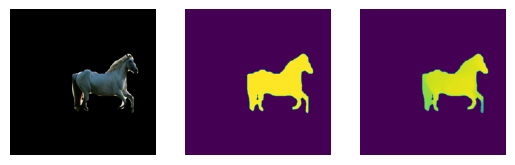

 35%|████████████████████████▍                                             | 209/600 [00:01<00:03, 128.24it/s]

tensor(0.2999, device='cuda:0') tensor(0.5760, device='cuda:0')
tensor(0.2994, device='cuda:0') tensor(0.5835, device='cuda:0')
tensor(0.2988, device='cuda:0') tensor(0.5933, device='cuda:0')
tensor(0.2978, device='cuda:0') tensor(0.6058, device='cuda:0')
tensor(0.2964, device='cuda:0') tensor(0.6141, device='cuda:0')
tensor(0.2952, device='cuda:0') tensor(0.6204, device='cuda:0')
tensor(0.2940, device='cuda:0') tensor(0.6299, device='cuda:0')
tensor(0.2933, device='cuda:0') tensor(0.6444, device='cuda:0')
tensor(0.2918, device='cuda:0') tensor(0.6586, device='cuda:0')
tensor(0.2899, device='cuda:0') tensor(0.6701, device='cuda:0')
tensor(0.2883, device='cuda:0') tensor(0.6808, device='cuda:0')
tensor(0.2861, device='cuda:0') tensor(0.6844, device='cuda:0')
tensor(0.2840, device='cuda:0') tensor(0.6842, device='cuda:0')
tensor(0.2832, device='cuda:0') tensor(0.6838, device='cuda:0')
tensor(0.2818, device='cuda:0') tensor(0.6824, device='cuda:0')
tensor(0.2799, device='cuda:0') tensor(0

 39%|███████████████████████████▍                                          | 235/600 [00:01<00:02, 124.52it/s]

tensor(0.5206, device='cuda:0')
tensor(0.2729, device='cuda:0') tensor(0.4993, device='cuda:0')
tensor(0.2723, device='cuda:0') tensor(0.4814, device='cuda:0')
tensor(0.2717, device='cuda:0') tensor(0.4746, device='cuda:0')
tensor(0.2699, device='cuda:0') tensor(0.4745, device='cuda:0')
tensor(0.2598, device='cuda:0') tensor(0.4747, device='cuda:0')
tensor(0.2500, device='cuda:0') tensor(0.4749, device='cuda:0')
tensor(0.2369, device='cuda:0') tensor(0.4746, device='cuda:0')
tensor(0.2262, device='cuda:0') tensor(0.4747, device='cuda:0')
tensor(0.2146, device='cuda:0') tensor(0.4753, device='cuda:0')
tensor(0.2028, device='cuda:0') tensor(0.4757, device='cuda:0')
tensor(0.2022, device='cuda:0') tensor(0.4759, device='cuda:0')
tensor(0.2019, device='cuda:0') tensor(0.4762, device='cuda:0')
tensor(0.2019, device='cuda:0') tensor(0.4762, device='cuda:0')
tensor(0.2020, device='cuda:0') tensor(0.4764, device='cuda:0')
tensor(0.2020, device='cuda:0') tensor(0.4760, device='cuda:0')
tensor(0

 44%|██████████████████████████████▍                                       | 261/600 [00:02<00:02, 122.37it/s]

tensor(0.2021, device='cuda:0') tensor(0.4724, device='cuda:0')
tensor(0.2027, device='cuda:0') tensor(0.4721, device='cuda:0')
tensor(0.2039, device='cuda:0') tensor(0.4719, device='cuda:0')
tensor(0.2053, device='cuda:0') tensor(0.4720, device='cuda:0')
tensor(0.2066, device='cuda:0') tensor(0.4724, device='cuda:0')
tensor(0.2074, device='cuda:0') tensor(0.4720, device='cuda:0')
tensor(0.2089, device='cuda:0') tensor(0.4733, device='cuda:0')
tensor(0.2098, device='cuda:0') tensor(0.4791, device='cuda:0')
tensor(0.2104, device='cuda:0') tensor(0.4867, device='cuda:0')
tensor(0.2105, device='cuda:0') tensor(0.4933, device='cuda:0')
tensor(0.2110, device='cuda:0') tensor(0.4986, device='cuda:0')
tensor(0.2115, device='cuda:0') tensor(0.5046, device='cuda:0')
tensor(0.2121, device='cuda:0') tensor(0.5091, device='cuda:0')
tensor(0.2131, device='cuda:0') tensor(0.5176, device='cuda:0')
tensor(0.2139, device='cuda:0') tensor(0.5211, device='cuda:0')
tensor(0.2145, device='cuda:0') tensor(0

 48%|█████████████████████████████████▍                                    | 287/600 [00:02<00:02, 120.86it/s]

tensor(0.2215, device='cuda:0') tensor(0.4788, device='cuda:0')
tensor(0.2224, device='cuda:0') tensor(0.4708, device='cuda:0')
tensor(0.2232, device='cuda:0') tensor(0.4627, device='cuda:0')
tensor(0.2243, device='cuda:0') tensor(0.4536, device='cuda:0')
tensor(0.2250, device='cuda:0') tensor(0.4483, device='cuda:0')
tensor(0.2256, device='cuda:0') tensor(0.4481, device='cuda:0')
tensor(0.2262, device='cuda:0') tensor(0.4481, device='cuda:0')
tensor(0.2269, device='cuda:0') tensor(0.4482, device='cuda:0')
tensor(0.2275, device='cuda:0') tensor(0.4479, device='cuda:0')
tensor(0.2275, device='cuda:0') tensor(0.4479, device='cuda:0')
tensor(0.2275, device='cuda:0') tensor(0.4475, device='cuda:0')
tensor(0.2277, device='cuda:0') tensor(0.4474, device='cuda:0')
tensor(0.2277, device='cuda:0') tensor(0.4473, device='cuda:0')
tensor(0.2274, device='cuda:0') tensor(0.4474, device='cuda:0')
tensor(0.2272, device='cuda:0') tensor(0.4471, device='cuda:0')
tensor(0.2266, device='cuda:0') tensor(0

 50%|███████████████████████████████████                                   | 300/600 [00:02<00:02, 120.22it/s]

tensor(0.4471, device='cuda:0')
tensor(0.2212, device='cuda:0') tensor(0.4469, device='cuda:0')
tensor(0.2212, device='cuda:0') tensor(0.4468, device='cuda:0')
tensor(0.2210, device='cuda:0') tensor(0.4467, device='cuda:0')
tensor(0.2203, device='cuda:0') tensor(0.4468, device='cuda:0')
tensor(0.2204, device='cuda:0') tensor(0.4466, device='cuda:0')
tensor(0.2202, device='cuda:0') tensor(0.4466, device='cuda:0')
tensor(0.2197, device='cuda:0') tensor(0.4468, device='cuda:0')
tensor(0.2193, device='cuda:0') tensor(0.4469, device='cuda:0')
tensor(0.2191, device='cuda:0') tensor(0.4468, device='cuda:0')
tensor(0.2189, device='cuda:0') tensor(0.4468, device='cuda:0')
tensor(0.2183, device='cuda:0') tensor(0.4467, device='cuda:0')
tensor(0.2182, device='cuda:0') tensor(0.4467, device='cuda:0')
tensor(0.2179, device='cuda:0') tensor(0.4466, device='cuda:0')
tensor(0.2176, device='cuda:0') tensor(0.4466, device='cuda:0')
tensor(0.2175, device='cuda:0') tensor(0.4466, device='cuda:0')
tensor(0

 56%|███████████████████████████████████████▎                              | 337/600 [00:02<00:02, 119.81it/s]

tensor(0.2105, device='cuda:0') tensor(0.4464, device='cuda:0')
tensor(0.2105, device='cuda:0') tensor(0.4466, device='cuda:0')
tensor(0.2110, device='cuda:0') tensor(0.4466, device='cuda:0')
tensor(0.2112, device='cuda:0') tensor(0.4467, device='cuda:0')
tensor(0.2115, device='cuda:0') tensor(0.4467, device='cuda:0')
tensor(0.2120, device='cuda:0') tensor(0.4469, device='cuda:0')
tensor(0.2123, device='cuda:0') tensor(0.4469, device='cuda:0')
tensor(0.2121, device='cuda:0') tensor(0.4469, device='cuda:0')
tensor(0.2122, device='cuda:0') tensor(0.4470, device='cuda:0')
tensor(0.2124, device='cuda:0') tensor(0.4468, device='cuda:0')
tensor(0.2126, device='cuda:0') tensor(0.4470, device='cuda:0')
tensor(0.2124, device='cuda:0') tensor(0.4470, device='cuda:0')
tensor(0.2124, device='cuda:0') tensor(0.4468, device='cuda:0')
tensor(0.2122, device='cuda:0') tensor(0.4465, device='cuda:0')
tensor(0.2120, device='cuda:0') tensor(0.4466, device='cuda:0')
tensor(0.2114, device='cuda:0') tensor(0

 60%|██████████████████████████████████████████                            | 361/600 [00:02<00:01, 119.56it/s]

tensor(0.2019, device='cuda:0') tensor(0.6037, device='cuda:0')
tensor(0.2009, device='cuda:0') tensor(0.6203, device='cuda:0')
tensor(0.2000, device='cuda:0') tensor(0.6413, device='cuda:0')
tensor(0.1992, device='cuda:0') tensor(0.6555, device='cuda:0')
tensor(0.1980, device='cuda:0') tensor(0.6611, device='cuda:0')
tensor(0.1971, device='cuda:0') tensor(0.6614, device='cuda:0')
tensor(0.1964, device='cuda:0') tensor(0.6616, device='cuda:0')
tensor(0.1960, device='cuda:0') tensor(0.6618, device='cuda:0')
tensor(0.1954, device='cuda:0') tensor(0.6618, device='cuda:0')
tensor(0.1949, device='cuda:0') tensor(0.6615, device='cuda:0')
tensor(0.1943, device='cuda:0') tensor(0.6468, device='cuda:0')
tensor(0.1940, device='cuda:0') tensor(0.6271, device='cuda:0')
tensor(0.1936, device='cuda:0') tensor(0.6093, device='cuda:0')
tensor(0.1931, device='cuda:0') tensor(0.5936, device='cuda:0')
tensor(0.1929, device='cuda:0') tensor(0.5801, device='cuda:0')
tensor(0.1925, device='cuda:0') tensor(0

 64%|█████████████████████████████████████████████                         | 386/600 [00:03<00:01, 121.22it/s]

tensor(0.1894, device='cuda:0') tensor(0.5445, device='cuda:0')
tensor(0.1891, device='cuda:0') tensor(0.5434, device='cuda:0')
tensor(0.1890, device='cuda:0') tensor(0.5437, device='cuda:0')
tensor(0.1891, device='cuda:0') tensor(0.5446, device='cuda:0')
tensor(0.1892, device='cuda:0') tensor(0.5451, device='cuda:0')
tensor(0.1892, device='cuda:0') tensor(0.5451, device='cuda:0')
tensor(0.1892, device='cuda:0') tensor(0.5459, device='cuda:0')
tensor(0.1891, device='cuda:0') tensor(0.5458, device='cuda:0')
tensor(0.1891, device='cuda:0') tensor(0.5461, device='cuda:0')
tensor(0.1892, device='cuda:0') tensor(0.5464, device='cuda:0')
tensor(0.1892, device='cuda:0') tensor(0.5458, device='cuda:0')
tensor(0.1894, device='cuda:0') tensor(0.5447, device='cuda:0')
tensor(0.1894, device='cuda:0') tensor(0.5442, device='cuda:0')
tensor(0.1911, device='cuda:0') tensor(0.5429, device='cuda:0')
tensor(0.2206, device='cuda:0') tensor(0.5427, device='cuda:0')
tensor(0.2678, device='cuda:0') tensor(0

100%|██████████████████████████████████████████████████████████████████████| 600/600 [00:04<00:00, 128.53it/s]


/grogu/user/akirchme/art3d_sd_webui/images/horse/1474.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/1474.mp4


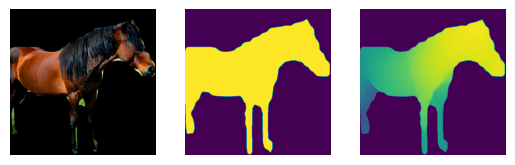

 40%|███████████████████████████▉                                          | 239/600 [00:02<00:03, 100.48it/s]

tensor(0.2830, device='cuda:0') tensor(0.5408, device='cuda:0')
tensor(0.2535, device='cuda:0') tensor(0.5412, device='cuda:0')
tensor(0.2208, device='cuda:0') tensor(0.5417, device='cuda:0')
tensor(0.1762, device='cuda:0') tensor(0.5423, device='cuda:0')
tensor(0.1704, device='cuda:0') tensor(0.5430, device='cuda:0')
tensor(0.1703, device='cuda:0') tensor(0.5437, device='cuda:0')
tensor(0.1701, device='cuda:0') tensor(0.5442, device='cuda:0')
tensor(0.1700, device='cuda:0') tensor(0.5444, device='cuda:0')
tensor(0.1699, device='cuda:0') tensor(0.5444, device='cuda:0')
tensor(0.1698, device='cuda:0') tensor(0.5442, device='cuda:0')
tensor(0.1697, device='cuda:0') tensor(0.5442, device='cuda:0')
tensor(0.1697, device='cuda:0') tensor(0.5442, device='cuda:0')
tensor(0.1696, device='cuda:0') tensor(0.5440, device='cuda:0')
tensor(0.1694, device='cuda:0') tensor(0.5437, device='cuda:0')
tensor(0.1693, device='cuda:0') tensor(0.5430, device='cuda:0')
tensor(0.1693, device='cuda:0') tensor(0

 44%|██████████████████████████████▋                                       | 263/600 [00:02<00:03, 109.86it/s]

tensor(0.1685, device='cuda:0') tensor(0.5436, device='cuda:0')
tensor(0.1685, device='cuda:0') tensor(0.5612, device='cuda:0')
tensor(0.1686, device='cuda:0') tensor(0.5742, device='cuda:0')
tensor(0.1687, device='cuda:0') tensor(0.5958, device='cuda:0')
tensor(0.1689, device='cuda:0') tensor(0.6123, device='cuda:0')
tensor(0.1691, device='cuda:0') tensor(0.6221, device='cuda:0')
tensor(0.1692, device='cuda:0') tensor(0.6372, device='cuda:0')
tensor(0.1694, device='cuda:0') tensor(0.6635, device='cuda:0')
tensor(0.1697, device='cuda:0') tensor(0.6657, device='cuda:0')
tensor(0.1700, device='cuda:0') tensor(0.6654, device='cuda:0')
tensor(0.1704, device='cuda:0') tensor(0.6653, device='cuda:0')
tensor(0.1708, device='cuda:0') tensor(0.6649, device='cuda:0')
tensor(0.1713, device='cuda:0') tensor(0.6643, device='cuda:0')
tensor(0.1719, device='cuda:0') tensor(0.6598, device='cuda:0')
tensor(0.1727, device='cuda:0') tensor(0.6432, device='cuda:0')
tensor(0.1736, device='cuda:0') tensor(0

 48%|█████████████████████████████████▌                                    | 288/600 [00:03<00:02, 116.05it/s]

tensor(0.1879, device='cuda:0') tensor(0.4318, device='cuda:0')
tensor(0.1889, device='cuda:0') tensor(0.4320, device='cuda:0')
tensor(0.1894, device='cuda:0') tensor(0.4319, device='cuda:0')
tensor(0.1897, device='cuda:0') tensor(0.4319, device='cuda:0')
tensor(0.1898, device='cuda:0') tensor(0.4322, device='cuda:0')
tensor(0.1896, device='cuda:0') tensor(0.4324, device='cuda:0')
tensor(0.1889, device='cuda:0') tensor(0.4323, device='cuda:0')
tensor(0.1882, device='cuda:0') tensor(0.4325, device='cuda:0')
tensor(0.1874, device='cuda:0') tensor(0.4325, device='cuda:0')
tensor(0.1864, device='cuda:0') tensor(0.4325, device='cuda:0')
tensor(0.1853, device='cuda:0') tensor(0.4325, device='cuda:0')
tensor(0.1841, device='cuda:0') tensor(0.4325, device='cuda:0')
tensor(0.1828, device='cuda:0') tensor(0.4325, device='cuda:0')
tensor(0.1813, device='cuda:0') tensor(0.4326, device='cuda:0')
tensor(0.1803, device='cuda:0') tensor(0.4326, device='cuda:0')
tensor(0.1796, device='cuda:0') tensor(0

 52%|████████████████████████████████████▌                                 | 313/600 [00:03<00:02, 117.43it/s]

tensor(0.1784, device='cuda:0') tensor(0.4345, device='cuda:0')
tensor(0.1782, device='cuda:0') tensor(0.4346, device='cuda:0')
tensor(0.1781, device='cuda:0') tensor(0.4346, device='cuda:0')
tensor(0.1781, device='cuda:0') tensor(0.4345, device='cuda:0')
tensor(0.1781, device='cuda:0') tensor(0.4344, device='cuda:0')
tensor(0.1780, device='cuda:0') tensor(0.4345, device='cuda:0')
tensor(0.1779, device='cuda:0') tensor(0.4345, device='cuda:0')
tensor(0.1778, device='cuda:0') tensor(0.4345, device='cuda:0')
tensor(0.1776, device='cuda:0') tensor(0.4345, device='cuda:0')
tensor(0.1775, device='cuda:0') tensor(0.4345, device='cuda:0')
tensor(0.1771, device='cuda:0') tensor(0.4346, device='cuda:0')
tensor(0.1769, device='cuda:0') tensor(0.4347, device='cuda:0')
tensor(0.1768, device='cuda:0') tensor(0.4347, device='cuda:0')
tensor(0.1765, device='cuda:0') tensor(0.4346, device='cuda:0')
tensor(0.1763, device='cuda:0') tensor(0.4346, device='cuda:0')
tensor(0.1764, device='cuda:0') tensor(0

 56%|███████████████████████████████████████▍                              | 338/600 [00:03<00:02, 118.85it/s]

tensor(0.1797, device='cuda:0') tensor(0.4344, device='cuda:0')
tensor(0.1799, device='cuda:0') tensor(0.4345, device='cuda:0')
tensor(0.1798, device='cuda:0') tensor(0.4344, device='cuda:0')
tensor(0.1798, device='cuda:0') tensor(0.4345, device='cuda:0')
tensor(0.1795, device='cuda:0') tensor(0.4344, device='cuda:0')
tensor(0.1792, device='cuda:0') tensor(0.4343, device='cuda:0')
tensor(0.1788, device='cuda:0') tensor(0.4343, device='cuda:0')
tensor(0.1783, device='cuda:0') tensor(0.4344, device='cuda:0')
tensor(0.1776, device='cuda:0') tensor(0.4345, device='cuda:0')
tensor(0.1768, device='cuda:0') tensor(0.4345, device='cuda:0')
tensor(0.1760, device='cuda:0') tensor(0.4346, device='cuda:0')
tensor(0.1753, device='cuda:0') tensor(0.4347, device='cuda:0')
tensor(0.1745, device='cuda:0') tensor(0.4399, device='cuda:0')
tensor(0.1735, device='cuda:0') tensor(0.4472, device='cuda:0')
tensor(0.1729, device='cuda:0') tensor(0.4541, device='cuda:0')
tensor(0.1721, device='cuda:0') tensor(0

 60%|██████████████████████████████████████████▏                           | 362/600 [00:03<00:02, 118.84it/s]

tensor(0.1669, device='cuda:0') tensor(0.5753, device='cuda:0')
tensor(0.1668, device='cuda:0') tensor(0.5756, device='cuda:0')
tensor(0.1666, device='cuda:0') tensor(0.5720, device='cuda:0')
tensor(0.1664, device='cuda:0') tensor(0.5675, device='cuda:0')
tensor(0.1663, device='cuda:0') tensor(0.5641, device='cuda:0')
tensor(0.1661, device='cuda:0') tensor(0.5588, device='cuda:0')
tensor(0.1659, device='cuda:0') tensor(0.5534, device='cuda:0')
tensor(0.1658, device='cuda:0') tensor(0.5428, device='cuda:0')
tensor(0.1656, device='cuda:0') tensor(0.5183, device='cuda:0')
tensor(0.1655, device='cuda:0') tensor(0.5048, device='cuda:0')
tensor(0.1655, device='cuda:0') tensor(0.5034, device='cuda:0')
tensor(0.1657, device='cuda:0') tensor(0.5037, device='cuda:0')
tensor(0.1656, device='cuda:0') tensor(0.5045, device='cuda:0')
tensor(0.1655, device='cuda:0') tensor(0.5055, device='cuda:0')
tensor(0.1655, device='cuda:0') tensor(0.5067, device='cuda:0')
tensor(0.1655, device='cuda:0') tensor(0

 64%|█████████████████████████████████████████████                         | 386/600 [00:03<00:01, 117.19it/s]

tensor(0.1674, device='cuda:0') tensor(0.5172, device='cuda:0')
tensor(0.1676, device='cuda:0') tensor(0.5166, device='cuda:0')
tensor(0.1677, device='cuda:0') tensor(0.5159, device='cuda:0')
tensor(0.1680, device='cuda:0') tensor(0.5152, device='cuda:0')
tensor(0.1683, device='cuda:0') tensor(0.5141, device='cuda:0')
tensor(0.1691, device='cuda:0') tensor(0.5131, device='cuda:0')
tensor(0.1788, device='cuda:0') tensor(0.5119, device='cuda:0')
tensor(0.1902, device='cuda:0') tensor(0.5111, device='cuda:0')
tensor(0.1996, device='cuda:0') tensor(0.5105, device='cuda:0')
tensor(0.2110, device='cuda:0') tensor(0.5100, device='cuda:0')
tensor(0.2426, device='cuda:0') tensor(0.5096, device='cuda:0')
tensor(0.2971, device='cuda:0') tensor(0.5092, device='cuda:0')
tensor(0.3091, device='cuda:0') tensor(0.5093, device='cuda:0')


100%|███████████████████████████████████████████████████████████████████████| 600/600 [00:06<00:00, 85.76it/s]


/grogu/user/akirchme/art3d_sd_webui/images/horse/490.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/490.mp4


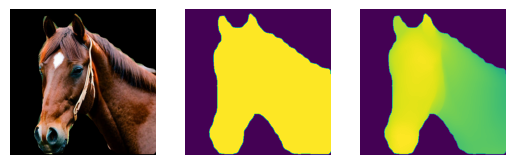

  4%|██▊                                                                    | 24/600 [00:00<00:05, 114.56it/s]

tensor(0.2843, device='cuda:0') tensor(0.5048, device='cuda:0')
tensor(0.2836, device='cuda:0') tensor(0.5048, device='cuda:0')
tensor(0.2828, device='cuda:0') tensor(0.5048, device='cuda:0')
tensor(0.2819, device='cuda:0') tensor(0.5049, device='cuda:0')
tensor(0.2809, device='cuda:0') tensor(0.5049, device='cuda:0')
tensor(0.2795, device='cuda:0') tensor(0.5048, device='cuda:0')
tensor(0.2777, device='cuda:0') tensor(0.5048, device='cuda:0')
tensor(0.2766, device='cuda:0') tensor(0.5047, device='cuda:0')
tensor(0.2756, device='cuda:0') tensor(0.5047, device='cuda:0')
tensor(0.2747, device='cuda:0') tensor(0.5047, device='cuda:0')
tensor(0.2737, device='cuda:0') tensor(0.5046, device='cuda:0')
tensor(0.2728, device='cuda:0') tensor(0.5046, device='cuda:0')
tensor(0.2719, device='cuda:0') tensor(0.5045, device='cuda:0')
tensor(0.2711, device='cuda:0') tensor(0.5045, device='cuda:0')
tensor(0.2706, device='cuda:0') tensor(0.5045, device='cuda:0')
tensor(0.2699, device='cuda:0') tensor(0

  8%|█████▋                                                                 | 48/600 [00:00<00:04, 117.83it/s]

tensor(0.2634, device='cuda:0') tensor(0.5050, device='cuda:0')
tensor(0.2626, device='cuda:0') tensor(0.5050, device='cuda:0')
tensor(0.2616, device='cuda:0') tensor(0.5051, device='cuda:0')
tensor(0.2606, device='cuda:0') tensor(0.5051, device='cuda:0')
tensor(0.2596, device='cuda:0') tensor(0.5052, device='cuda:0')
tensor(0.2585, device='cuda:0') tensor(0.5053, device='cuda:0')
tensor(0.2574, device='cuda:0') tensor(0.5055, device='cuda:0')
tensor(0.2562, device='cuda:0') tensor(0.5057, device='cuda:0')
tensor(0.2550, device='cuda:0') tensor(0.5120, device='cuda:0')
tensor(0.2539, device='cuda:0') tensor(0.5204, device='cuda:0')
tensor(0.2527, device='cuda:0') tensor(0.5322, device='cuda:0')
tensor(0.2519, device='cuda:0') tensor(0.5485, device='cuda:0')
tensor(0.2510, device='cuda:0') tensor(0.5656, device='cuda:0')
tensor(0.2499, device='cuda:0') tensor(0.5847, device='cuda:0')
tensor(0.2489, device='cuda:0') tensor(0.6054, device='cuda:0')
tensor(0.2477, device='cuda:0') tensor(0

 12%|████████▋                                                              | 73/600 [00:00<00:04, 119.10it/s]

tensor(0.2412, device='cuda:0') tensor(0.6287, device='cuda:0')
tensor(0.2404, device='cuda:0') tensor(0.6156, device='cuda:0')
tensor(0.2399, device='cuda:0') tensor(0.6019, device='cuda:0')
tensor(0.2393, device='cuda:0') tensor(0.5848, device='cuda:0')
tensor(0.2388, device='cuda:0') tensor(0.5644, device='cuda:0')
tensor(0.2381, device='cuda:0') tensor(0.5542, device='cuda:0')
tensor(0.2372, device='cuda:0') tensor(0.5538, device='cuda:0')
tensor(0.2365, device='cuda:0') tensor(0.5531, device='cuda:0')
tensor(0.2359, device='cuda:0') tensor(0.5516, device='cuda:0')
tensor(0.2353, device='cuda:0') tensor(0.5508, device='cuda:0')
tensor(0.2347, device='cuda:0') tensor(0.5492, device='cuda:0')
tensor(0.2342, device='cuda:0') tensor(0.5468, device='cuda:0')
tensor(0.2336, device='cuda:0') tensor(0.5447, device='cuda:0')
tensor(0.2328, device='cuda:0') tensor(0.5438, device='cuda:0')
tensor(0.2323, device='cuda:0') tensor(0.5429, device='cuda:0')
tensor(0.2317, device='cuda:0') tensor(0

 14%|██████████                                                             | 85/600 [00:00<00:05, 101.99it/s]

tensor(0.2247, device='cuda:0') tensor(0.5349, device='cuda:0')
tensor(0.2245, device='cuda:0') tensor(0.5338, device='cuda:0')
tensor(0.2349, device='cuda:0') tensor(0.5329, device='cuda:0')
tensor(0.2509, device='cuda:0') tensor(0.5321, device='cuda:0')
tensor(0.2746, device='cuda:0') tensor(0.5312, device='cuda:0')


 24%|████████████████▉                                                      | 143/600 [00:01<00:05, 81.86it/s]

tensor(0.4206, device='cuda:0') tensor(0.5195, device='cuda:0')
tensor(0.4207, device='cuda:0') tensor(0.5184, device='cuda:0')
tensor(0.4206, device='cuda:0') tensor(0.5177, device='cuda:0')
tensor(0.4204, device='cuda:0') tensor(0.5175, device='cuda:0')
tensor(0.4203, device='cuda:0') tensor(0.5175, device='cuda:0')
tensor(0.4201, device='cuda:0') tensor(0.5175, device='cuda:0')
tensor(0.4198, device='cuda:0') tensor(0.5174, device='cuda:0')
tensor(0.4192, device='cuda:0') tensor(0.5173, device='cuda:0')
tensor(0.4186, device='cuda:0') tensor(0.5173, device='cuda:0')
tensor(0.4179, device='cuda:0') tensor(0.5172, device='cuda:0')
tensor(0.4172, device='cuda:0') tensor(0.5171, device='cuda:0')
tensor(0.4166, device='cuda:0') tensor(0.5171, device='cuda:0')
tensor(0.4162, device='cuda:0') tensor(0.5170, device='cuda:0')
tensor(0.4156, device='cuda:0') tensor(0.5171, device='cuda:0')
tensor(0.4179, device='cuda:0') tensor(0.5172, device='cuda:0')
tensor(0.4217, device='cuda:0') tensor(0

 26%|██████████████████▎                                                    | 155/600 [00:01<00:04, 91.49it/s]

tensor(0.4867, device='cuda:0') tensor(0.5177, device='cuda:0')
tensor(0.4871, device='cuda:0') tensor(0.5177, device='cuda:0')
tensor(0.4874, device='cuda:0') tensor(0.5179, device='cuda:0')
tensor(0.4879, device='cuda:0') tensor(0.5180, device='cuda:0')
tensor(0.4886, device='cuda:0') tensor(0.5181, device='cuda:0')
tensor(0.4891, device='cuda:0') tensor(0.5182, device='cuda:0')
tensor(0.4889, device='cuda:0') tensor(0.5181, device='cuda:0')
tensor(0.4880, device='cuda:0') tensor(0.5184, device='cuda:0')
tensor(0.4822, device='cuda:0') tensor(0.5186, device='cuda:0')
tensor(0.4760, device='cuda:0') tensor(0.5191, device='cuda:0')
tensor(0.4736, device='cuda:0') tensor(0.5196, device='cuda:0')
tensor(0.4711, device='cuda:0') tensor(0.5199, device='cuda:0')
tensor(0.4678, device='cuda:0') tensor(0.5200, device='cuda:0')


 31%|██████████████████████                                                 | 186/600 [00:02<00:04, 89.12it/s]

tensor(0.4325, device='cuda:0') tensor(0.5198, device='cuda:0')
tensor(0.4323, device='cuda:0') tensor(0.5194, device='cuda:0')
tensor(0.4322, device='cuda:0') tensor(0.5191, device='cuda:0')
tensor(0.4320, device='cuda:0') tensor(0.5188, device='cuda:0')
tensor(0.4321, device='cuda:0') tensor(0.5185, device='cuda:0')
tensor(0.4323, device='cuda:0') tensor(0.5181, device='cuda:0')
tensor(0.4323, device='cuda:0') tensor(0.5179, device='cuda:0')
tensor(0.4324, device='cuda:0') tensor(0.5175, device='cuda:0')
tensor(0.4323, device='cuda:0') tensor(0.5171, device='cuda:0')
tensor(0.4322, device='cuda:0') tensor(0.5168, device='cuda:0')
tensor(0.4321, device='cuda:0') tensor(0.5168, device='cuda:0')
tensor(0.4324, device='cuda:0') tensor(0.5167, device='cuda:0')
tensor(0.4324, device='cuda:0') tensor(0.5166, device='cuda:0')
tensor(0.4323, device='cuda:0') tensor(0.5167, device='cuda:0')
tensor(0.4322, device='cuda:0') tensor(0.5168, device='cuda:0')
tensor(0.4320, device='cuda:0') tensor(0

 40%|████████████████████████████                                           | 237/600 [00:02<00:04, 84.07it/s]

tensor(0.4114, device='cuda:0') tensor(0.5199, device='cuda:0')
tensor(0.4107, device='cuda:0') tensor(0.5160, device='cuda:0')
tensor(0.4098, device='cuda:0') tensor(0.5119, device='cuda:0')
tensor(0.4089, device='cuda:0') tensor(0.5088, device='cuda:0')
tensor(0.4081, device='cuda:0') tensor(0.5069, device='cuda:0')
tensor(0.4036, device='cuda:0') tensor(0.5072, device='cuda:0')
tensor(0.3950, device='cuda:0') tensor(0.5073, device='cuda:0')
tensor(0.3863, device='cuda:0') tensor(0.5076, device='cuda:0')
tensor(0.3741, device='cuda:0') tensor(0.5082, device='cuda:0')
tensor(0.3627, device='cuda:0') tensor(0.5084, device='cuda:0')
tensor(0.3525, device='cuda:0') tensor(0.5085, device='cuda:0')
tensor(0.3432, device='cuda:0') tensor(0.5084, device='cuda:0')
tensor(0.3427, device='cuda:0') tensor(0.5082, device='cuda:0')
tensor(0.3426, device='cuda:0') tensor(0.5081, device='cuda:0')
tensor(0.3425, device='cuda:0') tensor(0.5077, device='cuda:0')
tensor(0.3425, device='cuda:0') tensor(0

 41%|█████████████████████████████▏                                         | 247/600 [00:03<00:04, 85.52it/s]

tensor(0.3436, device='cuda:0') tensor(0.5052, device='cuda:0')
tensor(0.3441, device='cuda:0') tensor(0.5055, device='cuda:0')
tensor(0.3447, device='cuda:0') tensor(0.5061, device='cuda:0')
tensor(0.3454, device='cuda:0') tensor(0.5069, device='cuda:0')
tensor(0.3465, device='cuda:0') tensor(0.5084, device='cuda:0')
tensor(0.3478, device='cuda:0') tensor(0.5108, device='cuda:0')
tensor(0.3490, device='cuda:0') tensor(0.5137, device='cuda:0')
tensor(0.3505, device='cuda:0') tensor(0.5185, device='cuda:0')


 48%|██████████████████████████████████▏                                    | 289/600 [00:03<00:03, 85.39it/s]

tensor(0.3683, device='cuda:0') tensor(0.5191, device='cuda:0')
tensor(0.3689, device='cuda:0') tensor(0.5125, device='cuda:0')
tensor(0.3696, device='cuda:0') tensor(0.5064, device='cuda:0')
tensor(0.3702, device='cuda:0') tensor(0.5011, device='cuda:0')
tensor(0.3706, device='cuda:0') tensor(0.5011, device='cuda:0')
tensor(0.3713, device='cuda:0') tensor(0.5012, device='cuda:0')
tensor(0.3720, device='cuda:0') tensor(0.5013, device='cuda:0')
tensor(0.3724, device='cuda:0') tensor(0.5014, device='cuda:0')
tensor(0.3728, device='cuda:0') tensor(0.5014, device='cuda:0')
tensor(0.3731, device='cuda:0') tensor(0.5015, device='cuda:0')
tensor(0.3734, device='cuda:0') tensor(0.5016, device='cuda:0')
tensor(0.3737, device='cuda:0') tensor(0.5017, device='cuda:0')
tensor(0.3739, device='cuda:0') tensor(0.5018, device='cuda:0')
tensor(0.3739, device='cuda:0') tensor(0.5019, device='cuda:0')
tensor(0.3740, device='cuda:0') tensor(0.5020, device='cuda:0')
tensor(0.3739, device='cuda:0') tensor(0

 50%|███████████████████████████████████▌                                   | 301/600 [00:03<00:03, 93.76it/s]

tensor(0.3735, device='cuda:0') tensor(0.5028, device='cuda:0')
tensor(0.3735, device='cuda:0') tensor(0.5029, device='cuda:0')
tensor(0.3738, device='cuda:0') tensor(0.5030, device='cuda:0')
tensor(0.3739, device='cuda:0') tensor(0.5031, device='cuda:0')
tensor(0.3741, device='cuda:0') tensor(0.5031, device='cuda:0')
tensor(0.3745, device='cuda:0') tensor(0.5031, device='cuda:0')
tensor(0.3746, device='cuda:0') tensor(0.5031, device='cuda:0')
tensor(0.3749, device='cuda:0') tensor(0.5031, device='cuda:0')
tensor(0.3752, device='cuda:0') tensor(0.5031, device='cuda:0')
tensor(0.3756, device='cuda:0') tensor(0.5031, device='cuda:0')
tensor(0.3761, device='cuda:0') tensor(0.5032, device='cuda:0')
tensor(0.3766, device='cuda:0') tensor(0.5032, device='cuda:0')
tensor(0.3777, device='cuda:0') tensor(0.5032, device='cuda:0')
tensor(0.3781, device='cuda:0') tensor(0.5032, device='cuda:0')
tensor(0.3786, device='cuda:0') tensor(0.5033, device='cuda:0')
tensor(0.3791, device='cuda:0') tensor(0

 54%|██████████████████████████████████████                                | 326/600 [00:03<00:02, 106.65it/s]

tensor(0.3866, device='cuda:0') tensor(0.5028, device='cuda:0')
tensor(0.3888, device='cuda:0') tensor(0.5027, device='cuda:0')
tensor(0.3908, device='cuda:0') tensor(0.5027, device='cuda:0')
tensor(0.3923, device='cuda:0') tensor(0.5027, device='cuda:0')
tensor(0.3936, device='cuda:0') tensor(0.5027, device='cuda:0')
tensor(0.3945, device='cuda:0') tensor(0.5028, device='cuda:0')
tensor(0.3954, device='cuda:0') tensor(0.5028, device='cuda:0')
tensor(0.3960, device='cuda:0') tensor(0.5028, device='cuda:0')
tensor(0.3964, device='cuda:0') tensor(0.5028, device='cuda:0')
tensor(0.3966, device='cuda:0') tensor(0.5029, device='cuda:0')
tensor(0.3966, device='cuda:0') tensor(0.5029, device='cuda:0')
tensor(0.3965, device='cuda:0') tensor(0.5030, device='cuda:0')
tensor(0.3965, device='cuda:0') tensor(0.5030, device='cuda:0')
tensor(0.3963, device='cuda:0') tensor(0.5031, device='cuda:0')
tensor(0.3961, device='cuda:0') tensor(0.5032, device='cuda:0')
tensor(0.3958, device='cuda:0') tensor(0

 80%|████████████████████████████████████████████████████████▍              | 477/600 [00:06<00:01, 70.85it/s]

tensor(0.3622, device='cuda:0') tensor(0.5199, device='cuda:0')
tensor(0.3534, device='cuda:0') tensor(0.5198, device='cuda:0')
tensor(0.3502, device='cuda:0') tensor(0.5196, device='cuda:0')
tensor(0.3500, device='cuda:0') tensor(0.5195, device='cuda:0')
tensor(0.3498, device='cuda:0') tensor(0.5194, device='cuda:0')
tensor(0.3496, device='cuda:0') tensor(0.5194, device='cuda:0')
tensor(0.3496, device='cuda:0') tensor(0.5192, device='cuda:0')
tensor(0.3498, device='cuda:0') tensor(0.5191, device='cuda:0')
tensor(0.3501, device='cuda:0') tensor(0.5192, device='cuda:0')
tensor(0.3503, device='cuda:0') tensor(0.5191, device='cuda:0')
tensor(0.3504, device='cuda:0') tensor(0.5190, device='cuda:0')
tensor(0.3503, device='cuda:0') tensor(0.5190, device='cuda:0')
tensor(0.3504, device='cuda:0') tensor(0.5189, device='cuda:0')
tensor(0.3504, device='cuda:0') tensor(0.5188, device='cuda:0')
tensor(0.3500, device='cuda:0') tensor(0.5190, device='cuda:0')
tensor(0.3498, device='cuda:0') tensor(0

 88%|██████████████████████████████████████████████████████████████▋        | 530/600 [00:07<00:01, 68.17it/s]

tensor(0.3000, device='cuda:0') tensor(0.5149, device='cuda:0')
tensor(0.2992, device='cuda:0') tensor(0.5126, device='cuda:0')
tensor(0.2944, device='cuda:0') tensor(0.5135, device='cuda:0')
tensor(0.2825, device='cuda:0') tensor(0.5142, device='cuda:0')
tensor(0.2677, device='cuda:0') tensor(0.5150, device='cuda:0')
tensor(0.2536, device='cuda:0') tensor(0.5161, device='cuda:0')
tensor(0.2424, device='cuda:0') tensor(0.5175, device='cuda:0')
tensor(0.2325, device='cuda:0') tensor(0.5191, device='cuda:0')
tensor(0.2260, device='cuda:0') tensor(0.5208, device='cuda:0')
tensor(0.2251, device='cuda:0') tensor(0.5226, device='cuda:0')
tensor(0.2253, device='cuda:0') tensor(0.5242, device='cuda:0')
tensor(0.2255, device='cuda:0') tensor(0.5259, device='cuda:0')
tensor(0.2259, device='cuda:0') tensor(0.5275, device='cuda:0')
tensor(0.2264, device='cuda:0') tensor(0.5286, device='cuda:0')
tensor(0.2268, device='cuda:0') tensor(0.5297, device='cuda:0')
tensor(0.2274, device='cuda:0') tensor(0

 93%|█████████████████████████████████████████████████████████████████▊     | 556/600 [00:07<00:00, 93.67it/s]

tensor(0.2372, device='cuda:0') tensor(0.5304, device='cuda:0')
tensor(0.2385, device='cuda:0') tensor(0.5296, device='cuda:0')
tensor(0.2396, device='cuda:0') tensor(0.5289, device='cuda:0')
tensor(0.2410, device='cuda:0') tensor(0.5280, device='cuda:0')
tensor(0.2432, device='cuda:0') tensor(0.5279, device='cuda:0')
tensor(0.2447, device='cuda:0') tensor(0.5330, device='cuda:0')
tensor(0.2459, device='cuda:0') tensor(0.5402, device='cuda:0')
tensor(0.2471, device='cuda:0') tensor(0.5497, device='cuda:0')
tensor(0.2480, device='cuda:0') tensor(0.5601, device='cuda:0')
tensor(0.2491, device='cuda:0') tensor(0.5671, device='cuda:0')
tensor(0.2499, device='cuda:0') tensor(0.5728, device='cuda:0')
tensor(0.2509, device='cuda:0') tensor(0.5782, device='cuda:0')
tensor(0.2518, device='cuda:0') tensor(0.5811, device='cuda:0')
tensor(0.2527, device='cuda:0') tensor(0.5808, device='cuda:0')
tensor(0.2536, device='cuda:0') tensor(0.5806, device='cuda:0')
tensor(0.2546, device='cuda:0') tensor(0

 97%|███████████████████████████████████████████████████████████████████▋  | 580/600 [00:08<00:00, 106.04it/s]

tensor(0.2655, device='cuda:0') tensor(0.5158, device='cuda:0')
tensor(0.2672, device='cuda:0') tensor(0.5105, device='cuda:0')
tensor(0.2689, device='cuda:0') tensor(0.5066, device='cuda:0')
tensor(0.2704, device='cuda:0') tensor(0.5065, device='cuda:0')
tensor(0.2718, device='cuda:0') tensor(0.5063, device='cuda:0')
tensor(0.2734, device='cuda:0') tensor(0.5061, device='cuda:0')
tensor(0.2748, device='cuda:0') tensor(0.5059, device='cuda:0')
tensor(0.2763, device='cuda:0') tensor(0.5058, device='cuda:0')
tensor(0.2776, device='cuda:0') tensor(0.5056, device='cuda:0')
tensor(0.2786, device='cuda:0') tensor(0.5055, device='cuda:0')
tensor(0.2793, device='cuda:0') tensor(0.5053, device='cuda:0')
tensor(0.2799, device='cuda:0') tensor(0.5053, device='cuda:0')
tensor(0.2808, device='cuda:0') tensor(0.5052, device='cuda:0')
tensor(0.2814, device='cuda:0') tensor(0.5052, device='cuda:0')
tensor(0.2818, device='cuda:0') tensor(0.5052, device='cuda:0')
tensor(0.2822, device='cuda:0') tensor(0

100%|███████████████████████████████████████████████████████████████████████| 600/600 [00:08<00:00, 72.91it/s]


tensor(0.2846, device='cuda:0') tensor(0.5048, device='cuda:0')
tensor(0.2850, device='cuda:0') tensor(0.5048, device='cuda:0')
tensor(0.2851, device='cuda:0') tensor(0.5048, device='cuda:0')
tensor(0.2854, device='cuda:0') tensor(0.5047, device='cuda:0')
tensor(0.2856, device='cuda:0') tensor(0.5047, device='cuda:0')
tensor(0.2859, device='cuda:0') tensor(0.5047, device='cuda:0')
tensor(0.2856, device='cuda:0') tensor(0.5047, device='cuda:0')
tensor(0.2853, device='cuda:0') tensor(0.5046, device='cuda:0')
tensor(0.2849, device='cuda:0') tensor(0.5047, device='cuda:0')
tensor(0.2846, device='cuda:0') tensor(0.5048, device='cuda:0')
/grogu/user/akirchme/art3d_sd_webui/images/horse/337.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/337.mp4


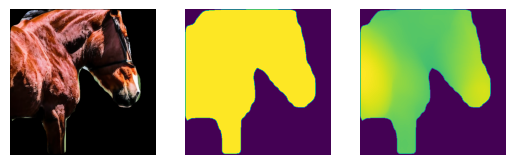

  4%|██▋                                                                    | 23/600 [00:00<00:05, 113.63it/s]

tensor(0.3165, device='cuda:0') tensor(0.4916, device='cuda:0')
tensor(0.3156, device='cuda:0') tensor(0.4917, device='cuda:0')
tensor(0.3145, device='cuda:0') tensor(0.4917, device='cuda:0')
tensor(0.3132, device='cuda:0') tensor(0.4917, device='cuda:0')
tensor(0.3118, device='cuda:0') tensor(0.4918, device='cuda:0')
tensor(0.3107, device='cuda:0') tensor(0.4917, device='cuda:0')
tensor(0.3099, device='cuda:0') tensor(0.4917, device='cuda:0')
tensor(0.3090, device='cuda:0') tensor(0.4917, device='cuda:0')
tensor(0.3077, device='cuda:0') tensor(0.4917, device='cuda:0')
tensor(0.3069, device='cuda:0') tensor(0.4918, device='cuda:0')
tensor(0.3060, device='cuda:0') tensor(0.4917, device='cuda:0')
tensor(0.3060, device='cuda:0') tensor(0.4917, device='cuda:0')
tensor(0.3065, device='cuda:0') tensor(0.4917, device='cuda:0')
tensor(0.3070, device='cuda:0') tensor(0.4918, device='cuda:0')
tensor(0.3076, device='cuda:0') tensor(0.4918, device='cuda:0')
tensor(0.3084, device='cuda:0') tensor(0

  8%|█████▌                                                                 | 47/600 [00:00<00:04, 117.42it/s]

tensor(0.3104, device='cuda:0') tensor(0.4920, device='cuda:0')
tensor(0.3101, device='cuda:0') tensor(0.4922, device='cuda:0')
tensor(0.3096, device='cuda:0') tensor(0.4924, device='cuda:0')
tensor(0.3088, device='cuda:0') tensor(0.4927, device='cuda:0')
tensor(0.3078, device='cuda:0') tensor(0.4930, device='cuda:0')
tensor(0.3067, device='cuda:0') tensor(0.4934, device='cuda:0')
tensor(0.3054, device='cuda:0') tensor(0.4937, device='cuda:0')
tensor(0.3038, device='cuda:0') tensor(0.4942, device='cuda:0')
tensor(0.3025, device='cuda:0') tensor(0.4989, device='cuda:0')
tensor(0.3012, device='cuda:0') tensor(0.5052, device='cuda:0')
tensor(0.2999, device='cuda:0') tensor(0.5110, device='cuda:0')
tensor(0.2984, device='cuda:0') tensor(0.5178, device='cuda:0')
tensor(0.2969, device='cuda:0') tensor(0.5237, device='cuda:0')
tensor(0.2955, device='cuda:0') tensor(0.5293, device='cuda:0')
tensor(0.2938, device='cuda:0') tensor(0.5388, device='cuda:0')
tensor(0.2924, device='cuda:0') tensor(0

 12%|████████▌                                                              | 72/600 [00:00<00:04, 118.79it/s]

tensor(0.2852, device='cuda:0') tensor(0.5648, device='cuda:0')
tensor(0.2845, device='cuda:0') tensor(0.5602, device='cuda:0')
tensor(0.2831, device='cuda:0') tensor(0.5559, device='cuda:0')
tensor(0.2809, device='cuda:0') tensor(0.5487, device='cuda:0')
tensor(0.2782, device='cuda:0') tensor(0.5410, device='cuda:0')
tensor(0.2759, device='cuda:0') tensor(0.5324, device='cuda:0')
tensor(0.2737, device='cuda:0') tensor(0.5306, device='cuda:0')
tensor(0.2717, device='cuda:0') tensor(0.5302, device='cuda:0')
tensor(0.2701, device='cuda:0') tensor(0.5297, device='cuda:0')
tensor(0.2687, device='cuda:0') tensor(0.5280, device='cuda:0')
tensor(0.2677, device='cuda:0') tensor(0.5250, device='cuda:0')
tensor(0.2670, device='cuda:0') tensor(0.5228, device='cuda:0')
tensor(0.2662, device='cuda:0') tensor(0.5216, device='cuda:0')
tensor(0.2655, device='cuda:0') tensor(0.5202, device='cuda:0')
tensor(0.2643, device='cuda:0') tensor(0.5194, device='cuda:0')
tensor(0.2633, device='cuda:0') tensor(0

 14%|█████████▉                                                             | 84/600 [00:00<00:04, 118.92it/s]

tensor(0.2624, device='cuda:0') tensor(0.5194, device='cuda:0')
tensor(0.2640, device='cuda:0') tensor(0.5185, device='cuda:0')
tensor(0.2721, device='cuda:0') tensor(0.5177, device='cuda:0')
tensor(0.2807, device='cuda:0') tensor(0.5168, device='cuda:0')
tensor(0.2904, device='cuda:0') tensor(0.5156, device='cuda:0')
tensor(0.2985, device='cuda:0') tensor(0.5147, device='cuda:0')
tensor(0.3123, device='cuda:0') tensor(0.5141, device='cuda:0')
tensor(0.3285, device='cuda:0') tensor(0.5137, device='cuda:0')
tensor(0.3385, device='cuda:0') tensor(0.5135, device='cuda:0')
tensor(0.3401, device='cuda:0') tensor(0.5144, device='cuda:0')
tensor(0.3414, device='cuda:0') tensor(0.5159, device='cuda:0')
tensor(0.3448, device='cuda:0') tensor(0.5177, device='cuda:0')
tensor(0.3499, device='cuda:0') tensor(0.5199, device='cuda:0')


 21%|███████████████▏                                                       | 128/600 [00:01<00:05, 80.30it/s]

tensor(0.4111, device='cuda:0') tensor(0.5132, device='cuda:0')
tensor(0.4115, device='cuda:0') tensor(0.5066, device='cuda:0')
tensor(0.4118, device='cuda:0') tensor(0.5029, device='cuda:0')
tensor(0.4120, device='cuda:0') tensor(0.5001, device='cuda:0')
tensor(0.4123, device='cuda:0') tensor(0.4961, device='cuda:0')
tensor(0.4128, device='cuda:0') tensor(0.4950, device='cuda:0')
tensor(0.4130, device='cuda:0') tensor(0.4944, device='cuda:0')
tensor(0.4133, device='cuda:0') tensor(0.4940, device='cuda:0')
tensor(0.4136, device='cuda:0') tensor(0.4939, device='cuda:0')
tensor(0.4138, device='cuda:0') tensor(0.4936, device='cuda:0')
tensor(0.4139, device='cuda:0') tensor(0.4935, device='cuda:0')
tensor(0.4141, device='cuda:0') tensor(0.4936, device='cuda:0')
tensor(0.4141, device='cuda:0') tensor(0.4935, device='cuda:0')
tensor(0.4142, device='cuda:0') tensor(0.4934, device='cuda:0')
tensor(0.4141, device='cuda:0') tensor(0.4934, device='cuda:0')
tensor(0.4138, device='cuda:0') tensor(0

 25%|█████████████████▉                                                     | 152/600 [00:01<00:04, 97.19it/s]

tensor(0.4225, device='cuda:0') tensor(0.4944, device='cuda:0')
tensor(0.4251, device='cuda:0') tensor(0.4945, device='cuda:0')
tensor(0.4282, device='cuda:0') tensor(0.4948, device='cuda:0')
tensor(0.4342, device='cuda:0') tensor(0.4948, device='cuda:0')
tensor(0.4424, device='cuda:0') tensor(0.4951, device='cuda:0')
tensor(0.4492, device='cuda:0') tensor(0.4953, device='cuda:0')
tensor(0.4544, device='cuda:0') tensor(0.4955, device='cuda:0')
tensor(0.4598, device='cuda:0') tensor(0.4956, device='cuda:0')
tensor(0.4669, device='cuda:0') tensor(0.4956, device='cuda:0')
tensor(0.4699, device='cuda:0') tensor(0.4957, device='cuda:0')
tensor(0.4720, device='cuda:0') tensor(0.4959, device='cuda:0')
tensor(0.4729, device='cuda:0') tensor(0.4960, device='cuda:0')
tensor(0.4733, device='cuda:0') tensor(0.4962, device='cuda:0')
tensor(0.4735, device='cuda:0') tensor(0.4965, device='cuda:0')
tensor(0.4736, device='cuda:0') tensor(0.4968, device='cuda:0')
tensor(0.4733, device='cuda:0') tensor(0

 29%|████████████████████▌                                                 | 176/600 [00:01<00:03, 107.59it/s]

tensor(0.4398, device='cuda:0') tensor(0.5003, device='cuda:0')
tensor(0.4377, device='cuda:0') tensor(0.5007, device='cuda:0')
tensor(0.4338, device='cuda:0') tensor(0.5012, device='cuda:0')
tensor(0.4299, device='cuda:0') tensor(0.5016, device='cuda:0')
tensor(0.4283, device='cuda:0') tensor(0.5016, device='cuda:0')
tensor(0.4283, device='cuda:0') tensor(0.5016, device='cuda:0')
tensor(0.4284, device='cuda:0') tensor(0.5015, device='cuda:0')
tensor(0.4285, device='cuda:0') tensor(0.5015, device='cuda:0')
tensor(0.4286, device='cuda:0') tensor(0.5014, device='cuda:0')
tensor(0.4287, device='cuda:0') tensor(0.5011, device='cuda:0')
tensor(0.4287, device='cuda:0') tensor(0.5008, device='cuda:0')
tensor(0.4287, device='cuda:0') tensor(0.5005, device='cuda:0')
tensor(0.4288, device='cuda:0') tensor(0.5004, device='cuda:0')
tensor(0.4287, device='cuda:0') tensor(0.5002, device='cuda:0')
tensor(0.4286, device='cuda:0') tensor(0.4998, device='cuda:0')
tensor(0.4284, device='cuda:0') tensor(0

 31%|█████████████████████▉                                                | 188/600 [00:01<00:03, 110.81it/s]

tensor(0.4236, device='cuda:0') tensor(0.5060, device='cuda:0')
tensor(0.4229, device='cuda:0') tensor(0.5100, device='cuda:0')
tensor(0.4224, device='cuda:0') tensor(0.5134, device='cuda:0')
tensor(0.4218, device='cuda:0') tensor(0.5183, device='cuda:0')


 39%|███████████████████████████▌                                           | 233/600 [00:02<00:04, 91.00it/s]

tensor(0.3841, device='cuda:0') tensor(0.5182, device='cuda:0')
tensor(0.3816, device='cuda:0') tensor(0.5164, device='cuda:0')
tensor(0.3784, device='cuda:0') tensor(0.5146, device='cuda:0')
tensor(0.3753, device='cuda:0') tensor(0.5119, device='cuda:0')
tensor(0.3726, device='cuda:0') tensor(0.5086, device='cuda:0')
tensor(0.3703, device='cuda:0') tensor(0.5071, device='cuda:0')
tensor(0.3648, device='cuda:0') tensor(0.5070, device='cuda:0')
tensor(0.3487, device='cuda:0') tensor(0.5081, device='cuda:0')
tensor(0.3389, device='cuda:0') tensor(0.5090, device='cuda:0')
tensor(0.3262, device='cuda:0') tensor(0.5109, device='cuda:0')
tensor(0.3197, device='cuda:0') tensor(0.5127, device='cuda:0')
tensor(0.3125, device='cuda:0') tensor(0.5148, device='cuda:0')
tensor(0.2979, device='cuda:0') tensor(0.5169, device='cuda:0')
tensor(0.2864, device='cuda:0') tensor(0.5191, device='cuda:0')
tensor(0.2857, device='cuda:0') tensor(0.5205, device='cuda:0')
tensor(0.2855, device='cuda:0') tensor(0

 41%|████████████████████████████▉                                          | 245/600 [00:02<00:03, 98.00it/s]

tensor(0.2845, device='cuda:0') tensor(0.5110, device='cuda:0')
tensor(0.2844, device='cuda:0') tensor(0.5105, device='cuda:0')
tensor(0.2843, device='cuda:0') tensor(0.5106, device='cuda:0')
tensor(0.2845, device='cuda:0') tensor(0.5116, device='cuda:0')
tensor(0.2847, device='cuda:0') tensor(0.5126, device='cuda:0')
tensor(0.2855, device='cuda:0') tensor(0.5157, device='cuda:0')
tensor(0.2862, device='cuda:0') tensor(0.5200, device='cuda:0')
tensor(0.2868, device='cuda:0') tensor(0.5241, device='cuda:0')
tensor(0.2881, device='cuda:0') tensor(0.5282, device='cuda:0')
tensor(0.2898, device='cuda:0') tensor(0.5341, device='cuda:0')
tensor(0.2914, device='cuda:0') tensor(0.5453, device='cuda:0')
tensor(0.2928, device='cuda:0') tensor(0.5553, device='cuda:0')
tensor(0.2940, device='cuda:0') tensor(0.5652, device='cuda:0')
tensor(0.2951, device='cuda:0') tensor(0.5773, device='cuda:0')
tensor(0.2964, device='cuda:0') tensor(0.5825, device='cuda:0')
tensor(0.2974, device='cuda:0') tensor(0

 61%|███████████████████████████████████████████▌                           | 368/600 [00:04<00:02, 80.57it/s]

tensor(0.2993, device='cuda:0') tensor(0.5598, device='cuda:0')
tensor(0.2964, device='cuda:0') tensor(0.5564, device='cuda:0')
tensor(0.2935, device='cuda:0') tensor(0.5539, device='cuda:0')
tensor(0.2912, device='cuda:0') tensor(0.5516, device='cuda:0')
tensor(0.2893, device='cuda:0') tensor(0.5490, device='cuda:0')
tensor(0.2876, device='cuda:0') tensor(0.5481, device='cuda:0')
tensor(0.2860, device='cuda:0') tensor(0.5472, device='cuda:0')
tensor(0.2841, device='cuda:0') tensor(0.5460, device='cuda:0')
tensor(0.2827, device='cuda:0') tensor(0.5452, device='cuda:0')
tensor(0.2816, device='cuda:0') tensor(0.5446, device='cuda:0')
tensor(0.2808, device='cuda:0') tensor(0.5440, device='cuda:0')
tensor(0.2803, device='cuda:0') tensor(0.5441, device='cuda:0')
tensor(0.2802, device='cuda:0') tensor(0.5443, device='cuda:0')
tensor(0.2801, device='cuda:0') tensor(0.5450, device='cuda:0')
tensor(0.2800, device='cuda:0') tensor(0.5458, device='cuda:0')
tensor(0.2800, device='cuda:0') tensor(0

 65%|██████████████████████████████████████████████▏                        | 390/600 [00:04<00:02, 79.49it/s]

tensor(0.2796, device='cuda:0') tensor(0.5493, device='cuda:0')
tensor(0.2841, device='cuda:0') tensor(0.5482, device='cuda:0')
tensor(0.2909, device='cuda:0') tensor(0.5474, device='cuda:0')
tensor(0.2967, device='cuda:0') tensor(0.5458, device='cuda:0')


 71%|██████████████████████████████████████████████████▌                    | 427/600 [00:05<00:02, 82.08it/s]

tensor(0.3602, device='cuda:0') tensor(0.5163, device='cuda:0')
tensor(0.3611, device='cuda:0') tensor(0.5070, device='cuda:0')
tensor(0.3621, device='cuda:0') tensor(0.5021, device='cuda:0')
tensor(0.3631, device='cuda:0') tensor(0.4983, device='cuda:0')
tensor(0.3640, device='cuda:0') tensor(0.4971, device='cuda:0')
tensor(0.3649, device='cuda:0') tensor(0.4969, device='cuda:0')
tensor(0.3657, device='cuda:0') tensor(0.4968, device='cuda:0')
tensor(0.3663, device='cuda:0') tensor(0.4966, device='cuda:0')
tensor(0.3670, device='cuda:0') tensor(0.4964, device='cuda:0')
tensor(0.3675, device='cuda:0') tensor(0.4961, device='cuda:0')
tensor(0.3682, device='cuda:0') tensor(0.4963, device='cuda:0')
tensor(0.3688, device='cuda:0') tensor(0.4968, device='cuda:0')
tensor(0.3692, device='cuda:0') tensor(0.4973, device='cuda:0')
tensor(0.3696, device='cuda:0') tensor(0.4973, device='cuda:0')
tensor(0.3698, device='cuda:0') tensor(0.4973, device='cuda:0')
tensor(0.3700, device='cuda:0') tensor(0

 75%|████████████████████████████████████████████████████▋                 | 452/600 [00:05<00:01, 101.42it/s]

tensor(0.3911, device='cuda:0') tensor(0.4953, device='cuda:0')
tensor(0.3986, device='cuda:0') tensor(0.4948, device='cuda:0')
tensor(0.4035, device='cuda:0') tensor(0.4946, device='cuda:0')
tensor(0.4068, device='cuda:0') tensor(0.4944, device='cuda:0')
tensor(0.4096, device='cuda:0') tensor(0.4943, device='cuda:0')
tensor(0.4146, device='cuda:0') tensor(0.4942, device='cuda:0')
tensor(0.4289, device='cuda:0') tensor(0.4940, device='cuda:0')
tensor(0.4414, device='cuda:0') tensor(0.4938, device='cuda:0')
tensor(0.4485, device='cuda:0') tensor(0.4936, device='cuda:0')
tensor(0.4576, device='cuda:0') tensor(0.4934, device='cuda:0')
tensor(0.4635, device='cuda:0') tensor(0.4934, device='cuda:0')
tensor(0.4668, device='cuda:0') tensor(0.4932, device='cuda:0')
tensor(0.4681, device='cuda:0') tensor(0.4930, device='cuda:0')
tensor(0.4691, device='cuda:0') tensor(0.4929, device='cuda:0')
tensor(0.4698, device='cuda:0') tensor(0.4928, device='cuda:0')
tensor(0.4699, device='cuda:0') tensor(0

 79%|███████████████████████████████████████████████████████▌              | 476/600 [00:05<00:01, 110.29it/s]

tensor(0.4035, device='cuda:0') tensor(0.4915, device='cuda:0')
tensor(0.3992, device='cuda:0') tensor(0.4914, device='cuda:0')
tensor(0.3953, device='cuda:0') tensor(0.4913, device='cuda:0')
tensor(0.3925, device='cuda:0') tensor(0.4912, device='cuda:0')
tensor(0.3902, device='cuda:0') tensor(0.4912, device='cuda:0')
tensor(0.3906, device='cuda:0') tensor(0.4911, device='cuda:0')
tensor(0.3907, device='cuda:0') tensor(0.4910, device='cuda:0')
tensor(0.3906, device='cuda:0') tensor(0.4910, device='cuda:0')
tensor(0.3907, device='cuda:0') tensor(0.4909, device='cuda:0')
tensor(0.3907, device='cuda:0') tensor(0.4910, device='cuda:0')
tensor(0.3906, device='cuda:0') tensor(0.4910, device='cuda:0')
tensor(0.3907, device='cuda:0') tensor(0.4910, device='cuda:0')
tensor(0.3906, device='cuda:0') tensor(0.4911, device='cuda:0')
tensor(0.3905, device='cuda:0') tensor(0.4911, device='cuda:0')
tensor(0.3902, device='cuda:0') tensor(0.4912, device='cuda:0')
tensor(0.3901, device='cuda:0') tensor(0

 81%|████████████████████████████████████████████████████████▉             | 488/600 [00:05<00:00, 112.79it/s]

tensor(0.3861, device='cuda:0') tensor(0.5025, device='cuda:0')
tensor(0.3852, device='cuda:0') tensor(0.5087, device='cuda:0')
tensor(0.3846, device='cuda:0') tensor(0.5119, device='cuda:0')
tensor(0.3839, device='cuda:0') tensor(0.5174, device='cuda:0')


 87%|█████████████████████████████████████████████████████████████▊         | 522/600 [00:06<00:00, 90.93it/s]

tensor(0.3437, device='cuda:0') tensor(0.5192, device='cuda:0')
tensor(0.3424, device='cuda:0') tensor(0.5137, device='cuda:0')
tensor(0.3410, device='cuda:0') tensor(0.5084, device='cuda:0')
tensor(0.3390, device='cuda:0') tensor(0.5046, device='cuda:0')
tensor(0.3372, device='cuda:0') tensor(0.5006, device='cuda:0')
tensor(0.3350, device='cuda:0') tensor(0.4973, device='cuda:0')
tensor(0.3337, device='cuda:0') tensor(0.4941, device='cuda:0')
tensor(0.3328, device='cuda:0') tensor(0.4908, device='cuda:0')
tensor(0.3313, device='cuda:0') tensor(0.4890, device='cuda:0')
tensor(0.3223, device='cuda:0') tensor(0.4893, device='cuda:0')
tensor(0.3114, device='cuda:0') tensor(0.4895, device='cuda:0')
tensor(0.2998, device='cuda:0') tensor(0.4898, device='cuda:0')
tensor(0.2921, device='cuda:0') tensor(0.4901, device='cuda:0')
tensor(0.2860, device='cuda:0') tensor(0.4907, device='cuda:0')
tensor(0.2798, device='cuda:0') tensor(0.4915, device='cuda:0')
tensor(0.2756, device='cuda:0') tensor(0

 93%|█████████████████████████████████████████████████████████████████     | 558/600 [00:06<00:00, 108.32it/s]

tensor(0.2692, device='cuda:0') tensor(0.4963, device='cuda:0')
tensor(0.2689, device='cuda:0') tensor(0.4973, device='cuda:0')
tensor(0.2687, device='cuda:0') tensor(0.4980, device='cuda:0')
tensor(0.2685, device='cuda:0') tensor(0.4990, device='cuda:0')
tensor(0.2685, device='cuda:0') tensor(0.5008, device='cuda:0')
tensor(0.2689, device='cuda:0') tensor(0.5043, device='cuda:0')
tensor(0.2695, device='cuda:0') tensor(0.5090, device='cuda:0')
tensor(0.2704, device='cuda:0') tensor(0.5121, device='cuda:0')
tensor(0.2714, device='cuda:0') tensor(0.5127, device='cuda:0')
tensor(0.2723, device='cuda:0') tensor(0.5123, device='cuda:0')
tensor(0.2733, device='cuda:0') tensor(0.5119, device='cuda:0')
tensor(0.2745, device='cuda:0') tensor(0.5158, device='cuda:0')
tensor(0.2758, device='cuda:0') tensor(0.5234, device='cuda:0')
tensor(0.2775, device='cuda:0') tensor(0.5307, device='cuda:0')
tensor(0.2794, device='cuda:0') tensor(0.5374, device='cuda:0')
tensor(0.2811, device='cuda:0') tensor(0

 95%|██████████████████████████████████████████████████████████████████▌   | 570/600 [00:06<00:00, 111.34it/s]

tensor(0.2860, device='cuda:0') tensor(0.5481, device='cuda:0')
tensor(0.2869, device='cuda:0') tensor(0.5419, device='cuda:0')
tensor(0.2879, device='cuda:0') tensor(0.5344, device='cuda:0')
tensor(0.2891, device='cuda:0') tensor(0.5268, device='cuda:0')
tensor(0.2906, device='cuda:0') tensor(0.5189, device='cuda:0')
tensor(0.2923, device='cuda:0') tensor(0.5133, device='cuda:0')
tensor(0.2935, device='cuda:0') tensor(0.5085, device='cuda:0')
tensor(0.2949, device='cuda:0') tensor(0.5045, device='cuda:0')
tensor(0.2963, device='cuda:0') tensor(0.5008, device='cuda:0')
tensor(0.2976, device='cuda:0') tensor(0.4974, device='cuda:0')
tensor(0.2988, device='cuda:0') tensor(0.4960, device='cuda:0')
tensor(0.2999, device='cuda:0') tensor(0.4957, device='cuda:0')
tensor(0.3007, device='cuda:0') tensor(0.4955, device='cuda:0')
tensor(0.3015, device='cuda:0') tensor(0.4951, device='cuda:0')
tensor(0.3022, device='cuda:0') tensor(0.4948, device='cuda:0')
tensor(0.3027, device='cuda:0') tensor(0

100%|███████████████████████████████████████████████████████████████████████| 600/600 [00:06<00:00, 88.47it/s]


tensor(0.3034, device='cuda:0') tensor(0.4927, device='cuda:0')
tensor(0.3036, device='cuda:0') tensor(0.4926, device='cuda:0')
tensor(0.3037, device='cuda:0') tensor(0.4924, device='cuda:0')
tensor(0.3033, device='cuda:0') tensor(0.4924, device='cuda:0')
tensor(0.3033, device='cuda:0') tensor(0.4921, device='cuda:0')
tensor(0.3031, device='cuda:0') tensor(0.4920, device='cuda:0')
tensor(0.3031, device='cuda:0') tensor(0.4919, device='cuda:0')
tensor(0.3038, device='cuda:0') tensor(0.4918, device='cuda:0')
tensor(0.3048, device='cuda:0') tensor(0.4917, device='cuda:0')
tensor(0.3058, device='cuda:0') tensor(0.4917, device='cuda:0')
tensor(0.3071, device='cuda:0') tensor(0.4917, device='cuda:0')
tensor(0.3089, device='cuda:0') tensor(0.4917, device='cuda:0')
tensor(0.3106, device='cuda:0') tensor(0.4916, device='cuda:0')
tensor(0.3122, device='cuda:0') tensor(0.4916, device='cuda:0')
tensor(0.3144, device='cuda:0') tensor(0.4916, device='cuda:0')
tensor(0.3157, device='cuda:0') tensor(0

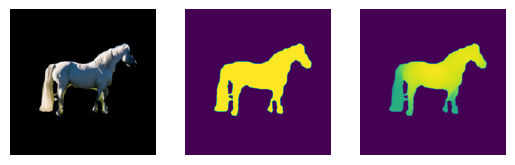

 48%|█████████████████████████████████▍                                    | 287/600 [00:02<00:02, 123.88it/s]

tensor(0.3430, device='cuda:0') tensor(0.5155, device='cuda:0')
tensor(0.3445, device='cuda:0') tensor(0.5043, device='cuda:0')
tensor(0.3457, device='cuda:0') tensor(0.4864, device='cuda:0')
tensor(0.3468, device='cuda:0') tensor(0.4749, device='cuda:0')
tensor(0.3480, device='cuda:0') tensor(0.4748, device='cuda:0')
tensor(0.3488, device='cuda:0') tensor(0.4748, device='cuda:0')
tensor(0.3494, device='cuda:0') tensor(0.4747, device='cuda:0')
tensor(0.3499, device='cuda:0') tensor(0.4746, device='cuda:0')
tensor(0.3501, device='cuda:0') tensor(0.4744, device='cuda:0')
tensor(0.3499, device='cuda:0') tensor(0.4743, device='cuda:0')
tensor(0.3495, device='cuda:0') tensor(0.4743, device='cuda:0')
tensor(0.3492, device='cuda:0') tensor(0.4743, device='cuda:0')
tensor(0.3486, device='cuda:0') tensor(0.4743, device='cuda:0')
tensor(0.3480, device='cuda:0') tensor(0.4743, device='cuda:0')
tensor(0.3474, device='cuda:0') tensor(0.4743, device='cuda:0')
tensor(0.3469, device='cuda:0') tensor(0

 52%|████████████████████████████████████▌                                 | 313/600 [00:02<00:02, 120.64it/s]

tensor(0.3368, device='cuda:0') tensor(0.4740, device='cuda:0')
tensor(0.3363, device='cuda:0') tensor(0.4741, device='cuda:0')
tensor(0.3359, device='cuda:0') tensor(0.4741, device='cuda:0')
tensor(0.3353, device='cuda:0') tensor(0.4742, device='cuda:0')
tensor(0.3349, device='cuda:0') tensor(0.4741, device='cuda:0')
tensor(0.3342, device='cuda:0') tensor(0.4741, device='cuda:0')
tensor(0.3339, device='cuda:0') tensor(0.4741, device='cuda:0')
tensor(0.3335, device='cuda:0') tensor(0.4742, device='cuda:0')
tensor(0.3329, device='cuda:0') tensor(0.4741, device='cuda:0')
tensor(0.3322, device='cuda:0') tensor(0.4740, device='cuda:0')
tensor(0.3316, device='cuda:0') tensor(0.4741, device='cuda:0')
tensor(0.3310, device='cuda:0') tensor(0.4741, device='cuda:0')
tensor(0.3304, device='cuda:0') tensor(0.4741, device='cuda:0')
tensor(0.3295, device='cuda:0') tensor(0.4741, device='cuda:0')
tensor(0.3285, device='cuda:0') tensor(0.4741, device='cuda:0')
tensor(0.3275, device='cuda:0') tensor(0

 54%|██████████████████████████████████████                                | 326/600 [00:02<00:02, 119.70it/s]

tensor(0.3235, device='cuda:0') tensor(0.4745, device='cuda:0')
tensor(0.3234, device='cuda:0') tensor(0.4746, device='cuda:0')
tensor(0.3232, device='cuda:0') tensor(0.4746, device='cuda:0')
tensor(0.3234, device='cuda:0') tensor(0.4747, device='cuda:0')
tensor(0.3235, device='cuda:0') tensor(0.4747, device='cuda:0')
tensor(0.3234, device='cuda:0') tensor(0.4748, device='cuda:0')
tensor(0.3234, device='cuda:0') tensor(0.4748, device='cuda:0')
tensor(0.3232, device='cuda:0') tensor(0.4747, device='cuda:0')
tensor(0.3228, device='cuda:0') tensor(0.4749, device='cuda:0')
tensor(0.3227, device='cuda:0') tensor(0.4750, device='cuda:0')
tensor(0.3224, device='cuda:0') tensor(0.4751, device='cuda:0')
tensor(0.3222, device='cuda:0') tensor(0.4752, device='cuda:0')
tensor(0.3219, device='cuda:0') tensor(0.4751, device='cuda:0')
tensor(0.3216, device='cuda:0') tensor(0.4751, device='cuda:0')
tensor(0.3215, device='cuda:0') tensor(0.4750, device='cuda:0')
tensor(0.3211, device='cuda:0') tensor(0

 62%|███████████████████████████████████████████▌                          | 373/600 [00:03<00:02, 105.01it/s]

tensor(0.3105, device='cuda:0') tensor(0.5191, device='cuda:0')
tensor(0.3101, device='cuda:0') tensor(0.5172, device='cuda:0')
tensor(0.3099, device='cuda:0') tensor(0.5158, device='cuda:0')
tensor(0.3096, device='cuda:0') tensor(0.5143, device='cuda:0')
tensor(0.3095, device='cuda:0') tensor(0.5128, device='cuda:0')
tensor(0.3095, device='cuda:0') tensor(0.5115, device='cuda:0')
tensor(0.3093, device='cuda:0') tensor(0.5103, device='cuda:0')
tensor(0.3095, device='cuda:0') tensor(0.5101, device='cuda:0')
tensor(0.3097, device='cuda:0') tensor(0.5099, device='cuda:0')
tensor(0.3097, device='cuda:0') tensor(0.5098, device='cuda:0')
tensor(0.3097, device='cuda:0') tensor(0.5101, device='cuda:0')
tensor(0.3100, device='cuda:0') tensor(0.5108, device='cuda:0')
tensor(0.3100, device='cuda:0') tensor(0.5112, device='cuda:0')
tensor(0.3103, device='cuda:0') tensor(0.5116, device='cuda:0')
tensor(0.3104, device='cuda:0') tensor(0.5120, device='cuda:0')
tensor(0.3105, device='cuda:0') tensor(0

 66%|██████████████████████████████████████████████▎                       | 397/600 [00:03<00:01, 106.47it/s]

tensor(0.3719, device='cuda:0') tensor(0.5152, device='cuda:0')
tensor(0.3870, device='cuda:0') tensor(0.5151, device='cuda:0')
tensor(0.3985, device='cuda:0') tensor(0.5147, device='cuda:0')
tensor(0.4014, device='cuda:0') tensor(0.5144, device='cuda:0')
tensor(0.4023, device='cuda:0') tensor(0.5186, device='cuda:0')


100%|██████████████████████████████████████████████████████████████████████| 600/600 [00:04<00:00, 121.94it/s]


/grogu/user/akirchme/art3d_sd_webui/images/horse/833.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/833.mp4


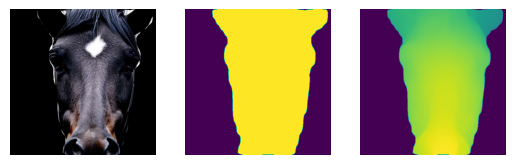

  4%|██▋                                                                    | 23/600 [00:00<00:05, 113.21it/s]

tensor(0.3680, device='cuda:0') tensor(0.5128, device='cuda:0')
tensor(0.3679, device='cuda:0') tensor(0.5128, device='cuda:0')
tensor(0.3675, device='cuda:0') tensor(0.5129, device='cuda:0')
tensor(0.3669, device='cuda:0') tensor(0.5129, device='cuda:0')
tensor(0.3665, device='cuda:0') tensor(0.5129, device='cuda:0')
tensor(0.3659, device='cuda:0') tensor(0.5129, device='cuda:0')
tensor(0.3650, device='cuda:0') tensor(0.5130, device='cuda:0')
tensor(0.3644, device='cuda:0') tensor(0.5130, device='cuda:0')
tensor(0.3638, device='cuda:0') tensor(0.5129, device='cuda:0')
tensor(0.3634, device='cuda:0') tensor(0.5130, device='cuda:0')
tensor(0.3631, device='cuda:0') tensor(0.5131, device='cuda:0')
tensor(0.3629, device='cuda:0') tensor(0.5132, device='cuda:0')
tensor(0.3629, device='cuda:0') tensor(0.5132, device='cuda:0')
tensor(0.3630, device='cuda:0') tensor(0.5132, device='cuda:0')
tensor(0.3634, device='cuda:0') tensor(0.5132, device='cuda:0')
tensor(0.3638, device='cuda:0') tensor(0

  6%|████▏                                                                  | 35/600 [00:00<00:04, 115.61it/s]

tensor(0.3644, device='cuda:0') tensor(0.5134, device='cuda:0')
tensor(0.3638, device='cuda:0') tensor(0.5134, device='cuda:0')
tensor(0.3631, device='cuda:0') tensor(0.5134, device='cuda:0')
tensor(0.3623, device='cuda:0') tensor(0.5136, device='cuda:0')
tensor(0.3614, device='cuda:0') tensor(0.5138, device='cuda:0')
tensor(0.3604, device='cuda:0') tensor(0.5140, device='cuda:0')
tensor(0.3595, device='cuda:0') tensor(0.5141, device='cuda:0')
tensor(0.3585, device='cuda:0') tensor(0.5143, device='cuda:0')
tensor(0.3574, device='cuda:0') tensor(0.5146, device='cuda:0')
tensor(0.3563, device='cuda:0') tensor(0.5151, device='cuda:0')
tensor(0.3551, device='cuda:0') tensor(0.5157, device='cuda:0')
tensor(0.3539, device='cuda:0') tensor(0.5168, device='cuda:0')
tensor(0.3526, device='cuda:0') tensor(0.5180, device='cuda:0')
tensor(0.3508, device='cuda:0') tensor(0.5197, device='cuda:0')


 38%|███████████████████████████▏                                           | 230/600 [00:03<00:05, 63.52it/s]

tensor(0.3494, device='cuda:0') tensor(0.5178, device='cuda:0')
tensor(0.3432, device='cuda:0') tensor(0.5188, device='cuda:0')
tensor(0.3312, device='cuda:0') tensor(0.5196, device='cuda:0')


 42%|█████████████████████████████▍                                         | 249/600 [00:03<00:04, 76.93it/s]

tensor(0.3124, device='cuda:0') tensor(0.5189, device='cuda:0')
tensor(0.3125, device='cuda:0') tensor(0.5177, device='cuda:0')
tensor(0.3124, device='cuda:0') tensor(0.5166, device='cuda:0')
tensor(0.3123, device='cuda:0') tensor(0.5154, device='cuda:0')
tensor(0.3124, device='cuda:0') tensor(0.5145, device='cuda:0')
tensor(0.3128, device='cuda:0') tensor(0.5144, device='cuda:0')
tensor(0.3131, device='cuda:0') tensor(0.5140, device='cuda:0')
tensor(0.3134, device='cuda:0') tensor(0.5147, device='cuda:0')
tensor(0.3141, device='cuda:0') tensor(0.5150, device='cuda:0')
tensor(0.3149, device='cuda:0') tensor(0.5156, device='cuda:0')
tensor(0.3157, device='cuda:0') tensor(0.5164, device='cuda:0')
tensor(0.3169, device='cuda:0') tensor(0.5176, device='cuda:0')


 46%|█████████████████████████████████                                      | 279/600 [00:03<00:03, 88.81it/s]

tensor(0.3301, device='cuda:0') tensor(0.5197, device='cuda:0')
tensor(0.3315, device='cuda:0') tensor(0.5108, device='cuda:0')
tensor(0.3328, device='cuda:0') tensor(0.5036, device='cuda:0')
tensor(0.3340, device='cuda:0') tensor(0.5017, device='cuda:0')
tensor(0.3353, device='cuda:0') tensor(0.5003, device='cuda:0')
tensor(0.3368, device='cuda:0') tensor(0.4995, device='cuda:0')
tensor(0.3382, device='cuda:0') tensor(0.4991, device='cuda:0')
tensor(0.3395, device='cuda:0') tensor(0.4989, device='cuda:0')
tensor(0.3407, device='cuda:0') tensor(0.4986, device='cuda:0')
tensor(0.3419, device='cuda:0') tensor(0.4984, device='cuda:0')
tensor(0.3431, device='cuda:0') tensor(0.4982, device='cuda:0')
tensor(0.3441, device='cuda:0') tensor(0.4981, device='cuda:0')
tensor(0.3449, device='cuda:0') tensor(0.4981, device='cuda:0')
tensor(0.3455, device='cuda:0') tensor(0.4980, device='cuda:0')
tensor(0.3463, device='cuda:0') tensor(0.4979, device='cuda:0')
tensor(0.3469, device='cuda:0') tensor(0

 51%|███████████████████████████████████▍                                  | 304/600 [00:04<00:02, 104.34it/s]

tensor(0.3492, device='cuda:0') tensor(0.4974, device='cuda:0')
tensor(0.3492, device='cuda:0') tensor(0.4974, device='cuda:0')
tensor(0.3492, device='cuda:0') tensor(0.4974, device='cuda:0')
tensor(0.3491, device='cuda:0') tensor(0.4973, device='cuda:0')
tensor(0.3492, device='cuda:0') tensor(0.4973, device='cuda:0')
tensor(0.3495, device='cuda:0') tensor(0.4972, device='cuda:0')
tensor(0.3497, device='cuda:0') tensor(0.4971, device='cuda:0')
tensor(0.3501, device='cuda:0') tensor(0.4971, device='cuda:0')
tensor(0.3505, device='cuda:0') tensor(0.4970, device='cuda:0')
tensor(0.3510, device='cuda:0') tensor(0.4970, device='cuda:0')
tensor(0.3515, device='cuda:0') tensor(0.4970, device='cuda:0')
tensor(0.3519, device='cuda:0') tensor(0.4969, device='cuda:0')
tensor(0.3521, device='cuda:0') tensor(0.4968, device='cuda:0')
tensor(0.3525, device='cuda:0') tensor(0.4967, device='cuda:0')
tensor(0.3530, device='cuda:0') tensor(0.4967, device='cuda:0')
tensor(0.3538, device='cuda:0') tensor(0

 55%|██████████████████████████████████████▍                               | 329/600 [00:04<00:02, 112.23it/s]

tensor(0.3534, device='cuda:0') tensor(0.4964, device='cuda:0')
tensor(0.3532, device='cuda:0') tensor(0.4964, device='cuda:0')
tensor(0.3531, device='cuda:0') tensor(0.4963, device='cuda:0')
tensor(0.3532, device='cuda:0') tensor(0.4963, device='cuda:0')
tensor(0.3534, device='cuda:0') tensor(0.4964, device='cuda:0')
tensor(0.3544, device='cuda:0') tensor(0.4964, device='cuda:0')
tensor(0.3555, device='cuda:0') tensor(0.4965, device='cuda:0')
tensor(0.3564, device='cuda:0') tensor(0.4965, device='cuda:0')
tensor(0.3572, device='cuda:0') tensor(0.4965, device='cuda:0')
tensor(0.3573, device='cuda:0') tensor(0.4965, device='cuda:0')
tensor(0.3575, device='cuda:0') tensor(0.4964, device='cuda:0')
tensor(0.3573, device='cuda:0') tensor(0.4965, device='cuda:0')
tensor(0.3574, device='cuda:0') tensor(0.4967, device='cuda:0')
tensor(0.3576, device='cuda:0') tensor(0.4967, device='cuda:0')
tensor(0.3574, device='cuda:0') tensor(0.4968, device='cuda:0')
tensor(0.3573, device='cuda:0') tensor(0

 57%|███████████████████████████████████████▊                              | 341/600 [00:04<00:02, 100.10it/s]

tensor(0.3496, device='cuda:0') tensor(0.5071, device='cuda:0')
tensor(0.3485, device='cuda:0') tensor(0.5163, device='cuda:0')


 97%|████████████████████████████████████████████████████████████████████▊  | 581/600 [00:08<00:00, 77.62it/s]

tensor(0.3647, device='cuda:0') tensor(0.5140, device='cuda:0')
tensor(0.3654, device='cuda:0') tensor(0.5136, device='cuda:0')
tensor(0.3662, device='cuda:0') tensor(0.5135, device='cuda:0')
tensor(0.3667, device='cuda:0') tensor(0.5134, device='cuda:0')
tensor(0.3672, device='cuda:0') tensor(0.5134, device='cuda:0')
tensor(0.3676, device='cuda:0') tensor(0.5133, device='cuda:0')
tensor(0.3678, device='cuda:0') tensor(0.5132, device='cuda:0')
tensor(0.3680, device='cuda:0') tensor(0.5132, device='cuda:0')
tensor(0.3685, device='cuda:0') tensor(0.5133, device='cuda:0')
tensor(0.3683, device='cuda:0') tensor(0.5132, device='cuda:0')
tensor(0.3685, device='cuda:0') tensor(0.5131, device='cuda:0')
tensor(0.3687, device='cuda:0') tensor(0.5131, device='cuda:0')
tensor(0.3688, device='cuda:0') tensor(0.5130, device='cuda:0')
tensor(0.3688, device='cuda:0') tensor(0.5129, device='cuda:0')
tensor(0.3688, device='cuda:0') tensor(0.5127, device='cuda:0')
tensor(0.3689, device='cuda:0') tensor(0

100%|███████████████████████████████████████████████████████████████████████| 600/600 [00:08<00:00, 70.53it/s]


tensor(0.3680, device='cuda:0') tensor(0.5125, device='cuda:0')
tensor(0.3681, device='cuda:0') tensor(0.5126, device='cuda:0')
tensor(0.3681, device='cuda:0') tensor(0.5126, device='cuda:0')
tensor(0.3679, device='cuda:0') tensor(0.5127, device='cuda:0')
tensor(0.3678, device='cuda:0') tensor(0.5126, device='cuda:0')
tensor(0.3678, device='cuda:0') tensor(0.5127, device='cuda:0')
tensor(0.3679, device='cuda:0') tensor(0.5127, device='cuda:0')
tensor(0.3681, device='cuda:0') tensor(0.5127, device='cuda:0')
/grogu/user/akirchme/art3d_sd_webui/images/horse/1302.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/1302.mp4


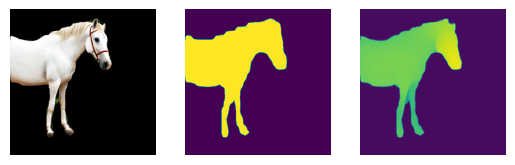

 39%|███████████████████████████▍                                          | 235/600 [00:02<00:03, 113.09it/s]

tensor(0.3698, device='cuda:0') tensor(0.5159, device='cuda:0')
tensor(0.3695, device='cuda:0') tensor(0.5082, device='cuda:0')
tensor(0.3674, device='cuda:0') tensor(0.5083, device='cuda:0')
tensor(0.3622, device='cuda:0') tensor(0.5087, device='cuda:0')
tensor(0.3526, device='cuda:0') tensor(0.5089, device='cuda:0')
tensor(0.3352, device='cuda:0') tensor(0.5091, device='cuda:0')
tensor(0.2996, device='cuda:0') tensor(0.5093, device='cuda:0')
tensor(0.2612, device='cuda:0') tensor(0.5095, device='cuda:0')
tensor(0.2524, device='cuda:0') tensor(0.5099, device='cuda:0')
tensor(0.2524, device='cuda:0') tensor(0.5100, device='cuda:0')
tensor(0.2524, device='cuda:0') tensor(0.5102, device='cuda:0')
tensor(0.2525, device='cuda:0') tensor(0.5103, device='cuda:0')
tensor(0.2524, device='cuda:0') tensor(0.5104, device='cuda:0')
tensor(0.2525, device='cuda:0') tensor(0.5105, device='cuda:0')
tensor(0.2524, device='cuda:0') tensor(0.5109, device='cuda:0')
tensor(0.2523, device='cuda:0') tensor(0

 43%|██████████████████████████████▎                                       | 260/600 [00:02<00:02, 116.63it/s]

tensor(0.5106, device='cuda:0')
tensor(0.2535, device='cuda:0') tensor(0.5108, device='cuda:0')
tensor(0.2536, device='cuda:0') tensor(0.5110, device='cuda:0')
tensor(0.2536, device='cuda:0') tensor(0.5113, device='cuda:0')
tensor(0.2537, device='cuda:0') tensor(0.5116, device='cuda:0')
tensor(0.2537, device='cuda:0') tensor(0.5118, device='cuda:0')
tensor(0.2539, device='cuda:0') tensor(0.5130, device='cuda:0')
tensor(0.2540, device='cuda:0') tensor(0.5156, device='cuda:0')
tensor(0.2541, device='cuda:0') tensor(0.5197, device='cuda:0')
tensor(0.2542, device='cuda:0') tensor(0.5280, device='cuda:0')
tensor(0.2543, device='cuda:0') tensor(0.5393, device='cuda:0')
tensor(0.2544, device='cuda:0') tensor(0.5578, device='cuda:0')
tensor(0.2546, device='cuda:0') tensor(0.5755, device='cuda:0')
tensor(0.2547, device='cuda:0') tensor(0.5795, device='cuda:0')
tensor(0.2547, device='cuda:0') tensor(0.5796, device='cuda:0')
tensor(0.2547, device='cuda:0') tensor(0.5797, device='cuda:0')
tensor(0

 47%|█████████████████████████████████▏                                    | 284/600 [00:02<00:02, 118.00it/s]

tensor(0.2562, device='cuda:0') tensor(0.5158, device='cuda:0')
tensor(0.2564, device='cuda:0') tensor(0.4913, device='cuda:0')
tensor(0.2566, device='cuda:0') tensor(0.4625, device='cuda:0')
tensor(0.2570, device='cuda:0') tensor(0.4617, device='cuda:0')
tensor(0.2573, device='cuda:0') tensor(0.4618, device='cuda:0')
tensor(0.2575, device='cuda:0') tensor(0.4618, device='cuda:0')
tensor(0.2576, device='cuda:0') tensor(0.4617, device='cuda:0')
tensor(0.2576, device='cuda:0') tensor(0.4617, device='cuda:0')
tensor(0.2577, device='cuda:0') tensor(0.4617, device='cuda:0')
tensor(0.2577, device='cuda:0') tensor(0.4618, device='cuda:0')
tensor(0.2577, device='cuda:0') tensor(0.4617, device='cuda:0')
tensor(0.2576, device='cuda:0') tensor(0.4617, device='cuda:0')
tensor(0.2575, device='cuda:0') tensor(0.4617, device='cuda:0')
tensor(0.2574, device='cuda:0') tensor(0.4616, device='cuda:0')
tensor(0.2572, device='cuda:0') tensor(0.4617, device='cuda:0')
tensor(0.2570, device='cuda:0') tensor(0

 51%|███████████████████████████████████▉                                  | 308/600 [00:02<00:02, 118.44it/s]

tensor(0.4615, device='cuda:0')
tensor(0.2562, device='cuda:0') tensor(0.4615, device='cuda:0')
tensor(0.2559, device='cuda:0') tensor(0.4615, device='cuda:0')
tensor(0.2557, device='cuda:0') tensor(0.4614, device='cuda:0')
tensor(0.2555, device='cuda:0') tensor(0.4613, device='cuda:0')
tensor(0.2554, device='cuda:0') tensor(0.4613, device='cuda:0')
tensor(0.2552, device='cuda:0') tensor(0.4613, device='cuda:0')
tensor(0.2554, device='cuda:0') tensor(0.4613, device='cuda:0')
tensor(0.2557, device='cuda:0') tensor(0.4612, device='cuda:0')
tensor(0.2558, device='cuda:0') tensor(0.4613, device='cuda:0')
tensor(0.2559, device='cuda:0') tensor(0.4613, device='cuda:0')
tensor(0.2559, device='cuda:0') tensor(0.4613, device='cuda:0')
tensor(0.2560, device='cuda:0') tensor(0.4613, device='cuda:0')
tensor(0.2560, device='cuda:0') tensor(0.4613, device='cuda:0')
tensor(0.2561, device='cuda:0') tensor(0.4613, device='cuda:0')
tensor(0.2560, device='cuda:0') tensor(0.4613, device='cuda:0')
tensor(0

 55%|██████████████████████████████████████▋                               | 332/600 [00:02<00:02, 118.54it/s]

tensor(0.2557, device='cuda:0') tensor(0.4615, device='cuda:0')
tensor(0.2556, device='cuda:0') tensor(0.4614, device='cuda:0')
tensor(0.2557, device='cuda:0') tensor(0.4614, device='cuda:0')
tensor(0.2558, device='cuda:0') tensor(0.4614, device='cuda:0')
tensor(0.2560, device='cuda:0') tensor(0.4613, device='cuda:0')
tensor(0.2560, device='cuda:0') tensor(0.4613, device='cuda:0')
tensor(0.2560, device='cuda:0') tensor(0.4613, device='cuda:0')
tensor(0.2561, device='cuda:0') tensor(0.4613, device='cuda:0')
tensor(0.2561, device='cuda:0') tensor(0.4613, device='cuda:0')
tensor(0.2561, device='cuda:0') tensor(0.4613, device='cuda:0')
tensor(0.2561, device='cuda:0') tensor(0.4613, device='cuda:0')
tensor(0.2562, device='cuda:0') tensor(0.4613, device='cuda:0')
tensor(0.2561, device='cuda:0') tensor(0.4613, device='cuda:0')
tensor(0.2560, device='cuda:0') tensor(0.4613, device='cuda:0')
tensor(0.2560, device='cuda:0') tensor(0.4613, device='cuda:0')
tensor(0.2559, device='cuda:0') tensor(0

 59%|█████████████████████████████████████████▌                            | 356/600 [00:03<00:02, 118.49it/s]

tensor(0.2554, device='cuda:0') tensor(0.7100, device='cuda:0')
tensor(0.2554, device='cuda:0') tensor(0.7155, device='cuda:0')
tensor(0.2552, device='cuda:0') tensor(0.7214, device='cuda:0')
tensor(0.2550, device='cuda:0') tensor(0.7241, device='cuda:0')
tensor(0.2549, device='cuda:0') tensor(0.7244, device='cuda:0')
tensor(0.2547, device='cuda:0') tensor(0.7246, device='cuda:0')
tensor(0.2548, device='cuda:0') tensor(0.7246, device='cuda:0')
tensor(0.2547, device='cuda:0') tensor(0.7247, device='cuda:0')
tensor(0.2546, device='cuda:0') tensor(0.7247, device='cuda:0')
tensor(0.2545, device='cuda:0') tensor(0.7201, device='cuda:0')
tensor(0.2542, device='cuda:0') tensor(0.6822, device='cuda:0')
tensor(0.2540, device='cuda:0') tensor(0.6530, device='cuda:0')
tensor(0.2537, device='cuda:0') tensor(0.6331, device='cuda:0')
tensor(0.2536, device='cuda:0') tensor(0.6254, device='cuda:0')
tensor(0.2531, device='cuda:0') tensor(0.6200, device='cuda:0')
tensor(0.2527, device='cuda:0') tensor(0

 63%|████████████████████████████████████████████▎                         | 380/600 [00:03<00:01, 117.50it/s]

tensor(0.2511, device='cuda:0') tensor(0.6103, device='cuda:0')
tensor(0.2509, device='cuda:0') tensor(0.6104, device='cuda:0')
tensor(0.2508, device='cuda:0') tensor(0.6106, device='cuda:0')
tensor(0.2506, device='cuda:0') tensor(0.6108, device='cuda:0')
tensor(0.2505, device='cuda:0') tensor(0.6108, device='cuda:0')
tensor(0.2505, device='cuda:0') tensor(0.6107, device='cuda:0')
tensor(0.2504, device='cuda:0') tensor(0.6107, device='cuda:0')
tensor(0.2505, device='cuda:0') tensor(0.6105, device='cuda:0')
tensor(0.2504, device='cuda:0') tensor(0.6104, device='cuda:0')
tensor(0.2505, device='cuda:0') tensor(0.6102, device='cuda:0')
tensor(0.2505, device='cuda:0') tensor(0.6102, device='cuda:0')
tensor(0.2505, device='cuda:0') tensor(0.6101, device='cuda:0')
tensor(0.2506, device='cuda:0') tensor(0.6099, device='cuda:0')
tensor(0.2507, device='cuda:0') tensor(0.6097, device='cuda:0')
tensor(0.2833, device='cuda:0') tensor(0.6095, device='cuda:0')


100%|██████████████████████████████████████████████████████████████████████| 600/600 [00:05<00:00, 110.39it/s]


/grogu/user/akirchme/art3d_sd_webui/images/horse/787.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/787.mp4


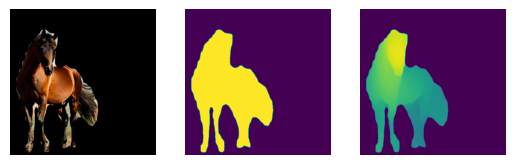

 11%|███████▊                                                               | 66/600 [00:00<00:04, 109.04it/s]

tensor(0.2996, device='cuda:0') tensor(0.5771, device='cuda:0')
tensor(0.2965, device='cuda:0') tensor(0.5743, device='cuda:0')
tensor(0.2943, device='cuda:0') tensor(0.5740, device='cuda:0')
tensor(0.2916, device='cuda:0') tensor(0.5737, device='cuda:0')
tensor(0.2885, device='cuda:0') tensor(0.5733, device='cuda:0')
tensor(0.2855, device='cuda:0') tensor(0.5730, device='cuda:0')
tensor(0.2825, device='cuda:0') tensor(0.5724, device='cuda:0')
tensor(0.2791, device='cuda:0') tensor(0.5716, device='cuda:0')
tensor(0.2759, device='cuda:0') tensor(0.5711, device='cuda:0')
tensor(0.2733, device='cuda:0') tensor(0.5703, device='cuda:0')
tensor(0.2712, device='cuda:0') tensor(0.5694, device='cuda:0')
tensor(0.2693, device='cuda:0') tensor(0.5691, device='cuda:0')
tensor(0.2668, device='cuda:0') tensor(0.5681, device='cuda:0')
tensor(0.2641, device='cuda:0') tensor(0.5665, device='cuda:0')
tensor(0.2618, device='cuda:0') tensor(0.5638, device='cuda:0')
tensor(0.2615, device='cuda:0') tensor(0

 15%|██████████▊                                                            | 91/600 [00:00<00:04, 112.60it/s]

tensor(0.2877, device='cuda:0') tensor(0.5402, device='cuda:0')


 48%|█████████████████████████████████▎                                    | 285/600 [00:02<00:02, 115.85it/s]

tensor(0.3953, device='cuda:0') tensor(0.5197, device='cuda:0')
tensor(0.3967, device='cuda:0') tensor(0.5124, device='cuda:0')
tensor(0.3980, device='cuda:0') tensor(0.5061, device='cuda:0')
tensor(0.3991, device='cuda:0') tensor(0.5027, device='cuda:0')
tensor(0.4001, device='cuda:0') tensor(0.4993, device='cuda:0')
tensor(0.4006, device='cuda:0') tensor(0.4991, device='cuda:0')
tensor(0.4011, device='cuda:0') tensor(0.4989, device='cuda:0')
tensor(0.4013, device='cuda:0') tensor(0.4989, device='cuda:0')
tensor(0.4014, device='cuda:0') tensor(0.4989, device='cuda:0')
tensor(0.4017, device='cuda:0') tensor(0.4988, device='cuda:0')
tensor(0.4016, device='cuda:0') tensor(0.4989, device='cuda:0')
tensor(0.4015, device='cuda:0') tensor(0.4988, device='cuda:0')
tensor(0.4013, device='cuda:0') tensor(0.4989, device='cuda:0')
tensor(0.4011, device='cuda:0') tensor(0.4989, device='cuda:0')
tensor(0.4007, device='cuda:0') tensor(0.4989, device='cuda:0')
tensor(0.4009, device='cuda:0') tensor(0

 52%|████████████████████████████████████                                  | 309/600 [00:02<00:02, 117.74it/s]

tensor(0.3955, device='cuda:0') tensor(0.4988, device='cuda:0')
tensor(0.3952, device='cuda:0') tensor(0.4988, device='cuda:0')
tensor(0.3948, device='cuda:0') tensor(0.4988, device='cuda:0')
tensor(0.3943, device='cuda:0') tensor(0.4989, device='cuda:0')
tensor(0.3942, device='cuda:0') tensor(0.4990, device='cuda:0')
tensor(0.3940, device='cuda:0') tensor(0.4990, device='cuda:0')
tensor(0.3937, device='cuda:0') tensor(0.4990, device='cuda:0')
tensor(0.3932, device='cuda:0') tensor(0.4990, device='cuda:0')
tensor(0.3929, device='cuda:0') tensor(0.4990, device='cuda:0')
tensor(0.3926, device='cuda:0') tensor(0.4991, device='cuda:0')
tensor(0.3922, device='cuda:0') tensor(0.4992, device='cuda:0')
tensor(0.3924, device='cuda:0') tensor(0.4991, device='cuda:0')
tensor(0.3922, device='cuda:0') tensor(0.4991, device='cuda:0')
tensor(0.3918, device='cuda:0') tensor(0.4991, device='cuda:0')
tensor(0.3914, device='cuda:0') tensor(0.4991, device='cuda:0')
tensor(0.3912, device='cuda:0') tensor(0

 56%|██████████████████████████████████████▊                               | 333/600 [00:03<00:02, 118.70it/s]

tensor(0.3937, device='cuda:0') tensor(0.4991, device='cuda:0')
tensor(0.3951, device='cuda:0') tensor(0.4992, device='cuda:0')
tensor(0.3964, device='cuda:0') tensor(0.4992, device='cuda:0')
tensor(0.3970, device='cuda:0') tensor(0.4993, device='cuda:0')
tensor(0.3976, device='cuda:0') tensor(0.4992, device='cuda:0')
tensor(0.3982, device='cuda:0') tensor(0.4993, device='cuda:0')
tensor(0.3984, device='cuda:0') tensor(0.4995, device='cuda:0')
tensor(0.3986, device='cuda:0') tensor(0.4995, device='cuda:0')
tensor(0.3987, device='cuda:0') tensor(0.4995, device='cuda:0')
tensor(0.3986, device='cuda:0') tensor(0.4997, device='cuda:0')
tensor(0.3987, device='cuda:0') tensor(0.4999, device='cuda:0')
tensor(0.3988, device='cuda:0') tensor(0.4999, device='cuda:0')
tensor(0.3987, device='cuda:0') tensor(0.5000, device='cuda:0')
tensor(0.3986, device='cuda:0') tensor(0.5000, device='cuda:0')
tensor(0.3984, device='cuda:0') tensor(0.5001, device='cuda:0')
tensor(0.3981, device='cuda:0') tensor(0

 90%|███████████████████████████████████████████████████████████████       | 541/600 [00:04<00:00, 112.11it/s]

tensor(0.2977, device='cuda:0') tensor(0.5393, device='cuda:0')
tensor(0.2833, device='cuda:0') tensor(0.5395, device='cuda:0')
tensor(0.2696, device='cuda:0') tensor(0.5401, device='cuda:0')
tensor(0.2565, device='cuda:0') tensor(0.5408, device='cuda:0')
tensor(0.2557, device='cuda:0') tensor(0.5421, device='cuda:0')
tensor(0.2565, device='cuda:0') tensor(0.5428, device='cuda:0')
tensor(0.2573, device='cuda:0') tensor(0.5435, device='cuda:0')
tensor(0.2589, device='cuda:0') tensor(0.5441, device='cuda:0')
tensor(0.2607, device='cuda:0') tensor(0.5451, device='cuda:0')
tensor(0.2631, device='cuda:0') tensor(0.5467, device='cuda:0')
tensor(0.2657, device='cuda:0') tensor(0.5483, device='cuda:0')
tensor(0.2681, device='cuda:0') tensor(0.5523, device='cuda:0')
tensor(0.2695, device='cuda:0') tensor(0.5558, device='cuda:0')
tensor(0.2709, device='cuda:0') tensor(0.5585, device='cuda:0')
tensor(0.2723, device='cuda:0') tensor(0.5625, device='cuda:0')
tensor(0.2731, device='cuda:0') tensor(0

 94%|██████████████████████████████████████████████████████████████████▏   | 567/600 [00:05<00:00, 116.39it/s]

tensor(0.2780, device='cuda:0') tensor(0.6094, device='cuda:0')
tensor(0.2787, device='cuda:0') tensor(0.6140, device='cuda:0')
tensor(0.2795, device='cuda:0') tensor(0.6202, device='cuda:0')
tensor(0.2803, device='cuda:0') tensor(0.6245, device='cuda:0')
tensor(0.2806, device='cuda:0') tensor(0.6303, device='cuda:0')
tensor(0.2812, device='cuda:0') tensor(0.6376, device='cuda:0')
tensor(0.2819, device='cuda:0') tensor(0.6400, device='cuda:0')
tensor(0.2824, device='cuda:0') tensor(0.6428, device='cuda:0')
tensor(0.2830, device='cuda:0') tensor(0.6392, device='cuda:0')
tensor(0.2834, device='cuda:0') tensor(0.6348, device='cuda:0')
tensor(0.2836, device='cuda:0') tensor(0.6330, device='cuda:0')
tensor(0.2841, device='cuda:0') tensor(0.6321, device='cuda:0')
tensor(0.2846, device='cuda:0') tensor(0.6281, device='cuda:0')
tensor(0.2851, device='cuda:0') tensor(0.6168, device='cuda:0')
tensor(0.2855, device='cuda:0') tensor(0.6065, device='cuda:0')
tensor(0.2862, device='cuda:0') tensor(0

 98%|████████████████████████████████████████████████████████████████████▉ | 591/600 [00:05<00:00, 114.47it/s]

tensor(0.2928, device='cuda:0') tensor(0.5242, device='cuda:0')
tensor(0.2935, device='cuda:0') tensor(0.5238, device='cuda:0')
tensor(0.2939, device='cuda:0') tensor(0.5235, device='cuda:0')
tensor(0.2945, device='cuda:0') tensor(0.5234, device='cuda:0')
tensor(0.2949, device='cuda:0') tensor(0.5232, device='cuda:0')
tensor(0.2954, device='cuda:0') tensor(0.5231, device='cuda:0')
tensor(0.2959, device='cuda:0') tensor(0.5230, device='cuda:0')
tensor(0.2969, device='cuda:0') tensor(0.5228, device='cuda:0')
tensor(0.2978, device='cuda:0') tensor(0.5227, device='cuda:0')
tensor(0.3000, device='cuda:0') tensor(0.5226, device='cuda:0')


100%|██████████████████████████████████████████████████████████████████████| 600/600 [00:05<00:00, 109.01it/s]


/grogu/user/akirchme/art3d_sd_webui/images/horse/1763.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/1763.mp4


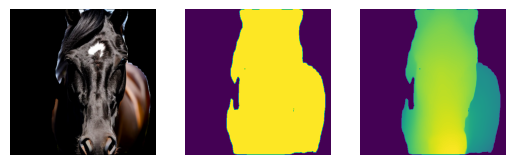

 10%|██████▉                                                                 | 58/600 [00:00<00:05, 91.73it/s]

tensor(0.2999, device='cuda:0') tensor(0.5360, device='cuda:0')
tensor(0.2987, device='cuda:0') tensor(0.5368, device='cuda:0')
tensor(0.2973, device='cuda:0') tensor(0.5378, device='cuda:0')
tensor(0.2961, device='cuda:0') tensor(0.5386, device='cuda:0')
tensor(0.2950, device='cuda:0') tensor(0.5392, device='cuda:0')
tensor(0.2935, device='cuda:0') tensor(0.5402, device='cuda:0')
tensor(0.2922, device='cuda:0') tensor(0.5443, device='cuda:0')
tensor(0.2912, device='cuda:0') tensor(0.5489, device='cuda:0')
tensor(0.2901, device='cuda:0') tensor(0.5497, device='cuda:0')
tensor(0.2897, device='cuda:0') tensor(0.5502, device='cuda:0')
tensor(0.2893, device='cuda:0') tensor(0.5509, device='cuda:0')
tensor(0.2888, device='cuda:0') tensor(0.5534, device='cuda:0')
tensor(0.2884, device='cuda:0') tensor(0.5545, device='cuda:0')
tensor(0.2879, device='cuda:0') tensor(0.5554, device='cuda:0')
tensor(0.2875, device='cuda:0') tensor(0.5559, device='cuda:0')
tensor(0.2871, device='cuda:0') tensor(0

 14%|█████████▋                                                             | 82/600 [00:00<00:04, 105.81it/s]

tensor(0.5665, device='cuda:0')
tensor(0.2689, device='cuda:0') tensor(0.5661, device='cuda:0')
tensor(0.2672, device='cuda:0') tensor(0.5652, device='cuda:0')
tensor(0.2652, device='cuda:0') tensor(0.5638, device='cuda:0')
tensor(0.2637, device='cuda:0') tensor(0.5626, device='cuda:0')
tensor(0.2630, device='cuda:0') tensor(0.5606, device='cuda:0')
tensor(0.2626, device='cuda:0') tensor(0.5578, device='cuda:0')
tensor(0.2622, device='cuda:0') tensor(0.5527, device='cuda:0')
tensor(0.2619, device='cuda:0') tensor(0.5430, device='cuda:0')
tensor(0.2615, device='cuda:0') tensor(0.5394, device='cuda:0')
tensor(0.2612, device='cuda:0') tensor(0.5356, device='cuda:0')
tensor(0.2609, device='cuda:0') tensor(0.5319, device='cuda:0')
tensor(0.2609, device='cuda:0') tensor(0.5298, device='cuda:0')
tensor(0.2609, device='cuda:0') tensor(0.5280, device='cuda:0')
tensor(0.2609, device='cuda:0') tensor(0.5256, device='cuda:0')
tensor(0.2607, device='cuda:0') tensor(0.5236, device='cuda:0')
tensor(0

 16%|███████████                                                            | 94/600 [00:01<00:04, 107.11it/s]

tensor(0.5164, device='cuda:0')
tensor(0.2786, device='cuda:0') tensor(0.5175, device='cuda:0')
tensor(0.2796, device='cuda:0') tensor(0.5246, device='cuda:0')
tensor(0.2825, device='cuda:0') tensor(0.5416, device='cuda:0')
tensor(0.2843, device='cuda:0') tensor(0.5653, device='cuda:0')
tensor(0.2867, device='cuda:0') tensor(0.5887, device='cuda:0')
tensor(0.2884, device='cuda:0') tensor(0.6059, device='cuda:0')
tensor(0.2905, device='cuda:0') tensor(0.6211, device='cuda:0')
tensor(0.2931, device='cuda:0') tensor(0.6376, device='cuda:0')
tensor(0.2989, device='cuda:0') tensor(0.6596, device='cuda:0')


 38%|███████████████████████████▎                                           | 231/600 [00:03<00:04, 82.98it/s]

tensor(0.3504, device='cuda:0') tensor(0.5147, device='cuda:0')
tensor(0.3498, device='cuda:0') tensor(0.5028, device='cuda:0')
tensor(0.3494, device='cuda:0') tensor(0.4979, device='cuda:0')
tensor(0.3487, device='cuda:0') tensor(0.4972, device='cuda:0')
tensor(0.3475, device='cuda:0') tensor(0.4979, device='cuda:0')
tensor(0.3464, device='cuda:0') tensor(0.4985, device='cuda:0')
tensor(0.3460, device='cuda:0') tensor(0.4989, device='cuda:0')
tensor(0.3456, device='cuda:0') tensor(0.4998, device='cuda:0')
tensor(0.3455, device='cuda:0') tensor(0.5002, device='cuda:0')
tensor(0.3449, device='cuda:0') tensor(0.5004, device='cuda:0')
tensor(0.3446, device='cuda:0') tensor(0.5012, device='cuda:0')
tensor(0.3444, device='cuda:0') tensor(0.5019, device='cuda:0')
tensor(0.3444, device='cuda:0') tensor(0.5020, device='cuda:0')
tensor(0.3443, device='cuda:0') tensor(0.5016, device='cuda:0')
tensor(0.3444, device='cuda:0') tensor(0.5007, device='cuda:0')
tensor(0.3445, device='cuda:0') tensor(0

 42%|█████████████████████████████▊                                        | 255/600 [00:03<00:03, 100.58it/s]

tensor(0.3463, device='cuda:0') tensor(0.4880, device='cuda:0')
tensor(0.3467, device='cuda:0') tensor(0.4875, device='cuda:0')
tensor(0.3470, device='cuda:0') tensor(0.4867, device='cuda:0')
tensor(0.3476, device='cuda:0') tensor(0.4858, device='cuda:0')
tensor(0.3482, device='cuda:0') tensor(0.4851, device='cuda:0')
tensor(0.3488, device='cuda:0') tensor(0.4846, device='cuda:0')
tensor(0.3496, device='cuda:0') tensor(0.4852, device='cuda:0')
tensor(0.3502, device='cuda:0') tensor(0.4859, device='cuda:0')
tensor(0.3510, device='cuda:0') tensor(0.4858, device='cuda:0')
tensor(0.3515, device='cuda:0') tensor(0.4854, device='cuda:0')
tensor(0.3519, device='cuda:0') tensor(0.4844, device='cuda:0')
tensor(0.3524, device='cuda:0') tensor(0.4835, device='cuda:0')
tensor(0.3528, device='cuda:0') tensor(0.4825, device='cuda:0')
tensor(0.3532, device='cuda:0') tensor(0.4812, device='cuda:0')
tensor(0.3536, device='cuda:0') tensor(0.4803, device='cuda:0')
tensor(0.3540, device='cuda:0') tensor(0

 46%|████████████████████████████████▌                                     | 279/600 [00:03<00:02, 109.67it/s]

tensor(0.4748, device='cuda:0')
tensor(0.3643, device='cuda:0') tensor(0.4743, device='cuda:0')
tensor(0.3652, device='cuda:0') tensor(0.4742, device='cuda:0')
tensor(0.3660, device='cuda:0') tensor(0.4736, device='cuda:0')
tensor(0.3668, device='cuda:0') tensor(0.4735, device='cuda:0')
tensor(0.3677, device='cuda:0') tensor(0.4734, device='cuda:0')
tensor(0.3687, device='cuda:0') tensor(0.4733, device='cuda:0')
tensor(0.3697, device='cuda:0') tensor(0.4733, device='cuda:0')
tensor(0.3704, device='cuda:0') tensor(0.4732, device='cuda:0')
tensor(0.3711, device='cuda:0') tensor(0.4732, device='cuda:0')
tensor(0.3717, device='cuda:0') tensor(0.4730, device='cuda:0')
tensor(0.3721, device='cuda:0') tensor(0.4730, device='cuda:0')
tensor(0.3724, device='cuda:0') tensor(0.4730, device='cuda:0')
tensor(0.3728, device='cuda:0') tensor(0.4730, device='cuda:0')
tensor(0.3731, device='cuda:0') tensor(0.4729, device='cuda:0')
tensor(0.3733, device='cuda:0') tensor(0.4730, device='cuda:0')
tensor(0

 51%|███████████████████████████████████▌                                  | 305/600 [00:03<00:02, 115.20it/s]

tensor(0.4728, device='cuda:0')
tensor(0.3732, device='cuda:0') tensor(0.4728, device='cuda:0')
tensor(0.3730, device='cuda:0') tensor(0.4728, device='cuda:0')
tensor(0.3731, device='cuda:0') tensor(0.4728, device='cuda:0')
tensor(0.3732, device='cuda:0') tensor(0.4728, device='cuda:0')
tensor(0.3735, device='cuda:0') tensor(0.4728, device='cuda:0')
tensor(0.3737, device='cuda:0') tensor(0.4728, device='cuda:0')
tensor(0.3740, device='cuda:0') tensor(0.4728, device='cuda:0')
tensor(0.3745, device='cuda:0') tensor(0.4728, device='cuda:0')
tensor(0.3748, device='cuda:0') tensor(0.4729, device='cuda:0')
tensor(0.3751, device='cuda:0') tensor(0.4729, device='cuda:0')
tensor(0.3754, device='cuda:0') tensor(0.4729, device='cuda:0')
tensor(0.3756, device='cuda:0') tensor(0.4729, device='cuda:0')
tensor(0.3757, device='cuda:0') tensor(0.4728, device='cuda:0')
tensor(0.3756, device='cuda:0') tensor(0.4729, device='cuda:0')
tensor(0.3755, device='cuda:0') tensor(0.4728, device='cuda:0')
tensor(0

 55%|██████████████████████████████████████▍                               | 329/600 [00:03<00:02, 116.78it/s]

tensor(0.3729, device='cuda:0') tensor(0.4722, device='cuda:0')
tensor(0.3728, device='cuda:0') tensor(0.4722, device='cuda:0')
tensor(0.3726, device='cuda:0') tensor(0.4722, device='cuda:0')
tensor(0.3725, device='cuda:0') tensor(0.4721, device='cuda:0')
tensor(0.3720, device='cuda:0') tensor(0.4721, device='cuda:0')
tensor(0.3717, device='cuda:0') tensor(0.4720, device='cuda:0')
tensor(0.3718, device='cuda:0') tensor(0.4720, device='cuda:0')
tensor(0.3716, device='cuda:0') tensor(0.4720, device='cuda:0')
tensor(0.3713, device='cuda:0') tensor(0.4719, device='cuda:0')
tensor(0.3710, device='cuda:0') tensor(0.4719, device='cuda:0')
tensor(0.3707, device='cuda:0') tensor(0.4719, device='cuda:0')
tensor(0.3703, device='cuda:0') tensor(0.4718, device='cuda:0')
tensor(0.3700, device='cuda:0') tensor(0.4718, device='cuda:0')
tensor(0.3695, device='cuda:0') tensor(0.4717, device='cuda:0')
tensor(0.3690, device='cuda:0') tensor(0.4717, device='cuda:0')
tensor(0.3685, device='cuda:0') tensor(0

 90%|████████████████████████████████████████████████████████████████▏      | 542/600 [00:07<00:00, 85.09it/s]

tensor(0.2905, device='cuda:0') tensor(0.6109, device='cuda:0')
tensor(0.2641, device='cuda:0') tensor(0.6120, device='cuda:0')
tensor(0.2631, device='cuda:0') tensor(0.6133, device='cuda:0')
tensor(0.2633, device='cuda:0') tensor(0.6151, device='cuda:0')
tensor(0.2636, device='cuda:0') tensor(0.6171, device='cuda:0')
tensor(0.2640, device='cuda:0') tensor(0.6188, device='cuda:0')
tensor(0.2645, device='cuda:0') tensor(0.6201, device='cuda:0')
tensor(0.2652, device='cuda:0') tensor(0.6214, device='cuda:0')
tensor(0.2664, device='cuda:0') tensor(0.6226, device='cuda:0')
tensor(0.2682, device='cuda:0') tensor(0.6241, device='cuda:0')
tensor(0.2704, device='cuda:0') tensor(0.6253, device='cuda:0')
tensor(0.2726, device='cuda:0') tensor(0.6259, device='cuda:0')
tensor(0.2758, device='cuda:0') tensor(0.6272, device='cuda:0')
tensor(0.2830, device='cuda:0') tensor(0.6296, device='cuda:0')
tensor(0.2878, device='cuda:0') tensor(0.6315, device='cuda:0')
tensor(0.2908, device='cuda:0') tensor(0

100%|███████████████████████████████████████████████████████████████████████| 600/600 [00:08<00:00, 74.22it/s]


/grogu/user/akirchme/art3d_sd_webui/images/horse/1226.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/1226.mp4


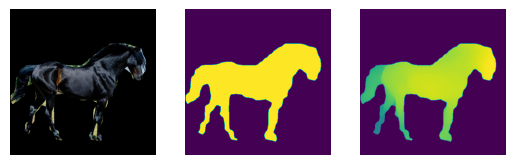

 39%|███████████████████████████▎                                          | 234/600 [00:02<00:03, 107.70it/s]

tensor(0.3000, device='cuda:0') tensor(0.5254, device='cuda:0')
tensor(0.2781, device='cuda:0') tensor(0.5257, device='cuda:0')
tensor(0.2598, device='cuda:0') tensor(0.5259, device='cuda:0')
tensor(0.2483, device='cuda:0') tensor(0.5265, device='cuda:0')
tensor(0.2379, device='cuda:0') tensor(0.5267, device='cuda:0')
tensor(0.2367, device='cuda:0') tensor(0.5268, device='cuda:0')
tensor(0.2364, device='cuda:0') tensor(0.5268, device='cuda:0')
tensor(0.2362, device='cuda:0') tensor(0.5268, device='cuda:0')
tensor(0.2360, device='cuda:0') tensor(0.5269, device='cuda:0')
tensor(0.2359, device='cuda:0') tensor(0.5268, device='cuda:0')
tensor(0.2357, device='cuda:0') tensor(0.5266, device='cuda:0')
tensor(0.2355, device='cuda:0') tensor(0.5265, device='cuda:0')
tensor(0.2354, device='cuda:0') tensor(0.5263, device='cuda:0')
tensor(0.2354, device='cuda:0') tensor(0.5259, device='cuda:0')
tensor(0.2355, device='cuda:0') tensor(0.5252, device='cuda:0')
tensor(0.2355, device='cuda:0') tensor(0

 43%|██████████████████████████████▏                                       | 259/600 [00:02<00:02, 113.89it/s]

tensor(0.2350, device='cuda:0') tensor(0.5185, device='cuda:0')
tensor(0.2349, device='cuda:0') tensor(0.5215, device='cuda:0')
tensor(0.2352, device='cuda:0') tensor(0.5258, device='cuda:0')
tensor(0.2353, device='cuda:0') tensor(0.5369, device='cuda:0')
tensor(0.2355, device='cuda:0') tensor(0.5472, device='cuda:0')
tensor(0.2358, device='cuda:0') tensor(0.5537, device='cuda:0')
tensor(0.2361, device='cuda:0') tensor(0.5578, device='cuda:0')
tensor(0.2362, device='cuda:0') tensor(0.5602, device='cuda:0')
tensor(0.2365, device='cuda:0') tensor(0.5614, device='cuda:0')
tensor(0.2364, device='cuda:0') tensor(0.5609, device='cuda:0')
tensor(0.2366, device='cuda:0') tensor(0.5605, device='cuda:0')
tensor(0.2370, device='cuda:0') tensor(0.5600, device='cuda:0')
tensor(0.2372, device='cuda:0') tensor(0.5598, device='cuda:0')
tensor(0.2378, device='cuda:0') tensor(0.5594, device='cuda:0')
tensor(0.2385, device='cuda:0') tensor(0.5552, device='cuda:0')
tensor(0.2394, device='cuda:0') tensor(0

 47%|█████████████████████████████████▏                                    | 284/600 [00:03<00:02, 117.05it/s]

tensor(0.2487, device='cuda:0') tensor(0.4614, device='cuda:0')
tensor(0.2495, device='cuda:0') tensor(0.4613, device='cuda:0')
tensor(0.2500, device='cuda:0') tensor(0.4612, device='cuda:0')
tensor(0.2507, device='cuda:0') tensor(0.4610, device='cuda:0')
tensor(0.2512, device='cuda:0') tensor(0.4610, device='cuda:0')
tensor(0.2515, device='cuda:0') tensor(0.4611, device='cuda:0')
tensor(0.2516, device='cuda:0') tensor(0.4611, device='cuda:0')
tensor(0.2516, device='cuda:0') tensor(0.4609, device='cuda:0')
tensor(0.2513, device='cuda:0') tensor(0.4609, device='cuda:0')
tensor(0.2506, device='cuda:0') tensor(0.4607, device='cuda:0')
tensor(0.2501, device='cuda:0') tensor(0.4607, device='cuda:0')
tensor(0.2497, device='cuda:0') tensor(0.4606, device='cuda:0')
tensor(0.2489, device='cuda:0') tensor(0.4604, device='cuda:0')
tensor(0.2483, device='cuda:0') tensor(0.4604, device='cuda:0')
tensor(0.2475, device='cuda:0') tensor(0.4602, device='cuda:0')
tensor(0.2470, device='cuda:0') tensor(0

 51%|███████████████████████████████████▉                                  | 308/600 [00:03<00:02, 118.15it/s]

tensor(0.2443, device='cuda:0') tensor(0.4595, device='cuda:0')
tensor(0.2442, device='cuda:0') tensor(0.4595, device='cuda:0')
tensor(0.2441, device='cuda:0') tensor(0.4594, device='cuda:0')
tensor(0.2440, device='cuda:0') tensor(0.4595, device='cuda:0')
tensor(0.2440, device='cuda:0') tensor(0.4593, device='cuda:0')
tensor(0.2438, device='cuda:0') tensor(0.4593, device='cuda:0')
tensor(0.2437, device='cuda:0') tensor(0.4592, device='cuda:0')
tensor(0.2435, device='cuda:0') tensor(0.4591, device='cuda:0')
tensor(0.2434, device='cuda:0') tensor(0.4591, device='cuda:0')
tensor(0.2431, device='cuda:0') tensor(0.4590, device='cuda:0')
tensor(0.2429, device='cuda:0') tensor(0.4590, device='cuda:0')
tensor(0.2426, device='cuda:0') tensor(0.4590, device='cuda:0')
tensor(0.2423, device='cuda:0') tensor(0.4590, device='cuda:0')
tensor(0.2421, device='cuda:0') tensor(0.4589, device='cuda:0')
tensor(0.2418, device='cuda:0') tensor(0.4589, device='cuda:0')
tensor(0.2415, device='cuda:0') tensor(0

 56%|██████████████████████████████████████▊                               | 333/600 [00:03<00:02, 119.05it/s]

tensor(0.2414, device='cuda:0') tensor(0.4587, device='cuda:0')
tensor(0.2414, device='cuda:0') tensor(0.4587, device='cuda:0')
tensor(0.2414, device='cuda:0') tensor(0.4588, device='cuda:0')
tensor(0.2414, device='cuda:0') tensor(0.4589, device='cuda:0')
tensor(0.2410, device='cuda:0') tensor(0.4589, device='cuda:0')
tensor(0.2409, device='cuda:0') tensor(0.4589, device='cuda:0')
tensor(0.2407, device='cuda:0') tensor(0.4589, device='cuda:0')
tensor(0.2405, device='cuda:0') tensor(0.4588, device='cuda:0')
tensor(0.2400, device='cuda:0') tensor(0.4589, device='cuda:0')
tensor(0.2396, device='cuda:0') tensor(0.4589, device='cuda:0')
tensor(0.2393, device='cuda:0') tensor(0.4589, device='cuda:0')
tensor(0.2387, device='cuda:0') tensor(0.4590, device='cuda:0')
tensor(0.2382, device='cuda:0') tensor(0.4593, device='cuda:0')
tensor(0.2377, device='cuda:0') tensor(0.4596, device='cuda:0')
tensor(0.2372, device='cuda:0') tensor(0.4750, device='cuda:0')
tensor(0.2364, device='cuda:0') tensor(0

 60%|█████████████████████████████████████████▊                            | 358/600 [00:03<00:02, 119.54it/s]

tensor(0.2319, device='cuda:0') tensor(0.6446, device='cuda:0')
tensor(0.2318, device='cuda:0') tensor(0.6447, device='cuda:0')
tensor(0.2316, device='cuda:0') tensor(0.6448, device='cuda:0')
tensor(0.2314, device='cuda:0') tensor(0.6440, device='cuda:0')
tensor(0.2311, device='cuda:0') tensor(0.6325, device='cuda:0')
tensor(0.2309, device='cuda:0') tensor(0.6154, device='cuda:0')
tensor(0.2307, device='cuda:0') tensor(0.5998, device='cuda:0')
tensor(0.2306, device='cuda:0') tensor(0.5826, device='cuda:0')
tensor(0.2302, device='cuda:0') tensor(0.5586, device='cuda:0')
tensor(0.2300, device='cuda:0') tensor(0.5431, device='cuda:0')
tensor(0.2300, device='cuda:0') tensor(0.5308, device='cuda:0')
tensor(0.2301, device='cuda:0') tensor(0.5215, device='cuda:0')
tensor(0.2302, device='cuda:0') tensor(0.5206, device='cuda:0')
tensor(0.2300, device='cuda:0') tensor(0.5210, device='cuda:0')
tensor(0.2300, device='cuda:0') tensor(0.5215, device='cuda:0')
tensor(0.2300, device='cuda:0') tensor(0

 64%|████████████████████████████████████████████▌                         | 382/600 [00:04<00:01, 118.33it/s]

tensor(0.2310, device='cuda:0') tensor(0.5291, device='cuda:0')
tensor(0.2316, device='cuda:0') tensor(0.5296, device='cuda:0')
tensor(0.2321, device='cuda:0') tensor(0.5306, device='cuda:0')
tensor(0.2325, device='cuda:0') tensor(0.5308, device='cuda:0')
tensor(0.2328, device='cuda:0') tensor(0.5314, device='cuda:0')
tensor(0.2331, device='cuda:0') tensor(0.5316, device='cuda:0')
tensor(0.2335, device='cuda:0') tensor(0.5314, device='cuda:0')
tensor(0.2362, device='cuda:0') tensor(0.5311, device='cuda:0')
tensor(0.2620, device='cuda:0') tensor(0.5308, device='cuda:0')
tensor(0.2915, device='cuda:0') tensor(0.5305, device='cuda:0')


100%|███████████████████████████████████████████████████████████████████████| 600/600 [00:06<00:00, 99.41it/s]


/grogu/user/akirchme/art3d_sd_webui/images/horse/917.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/917.mp4


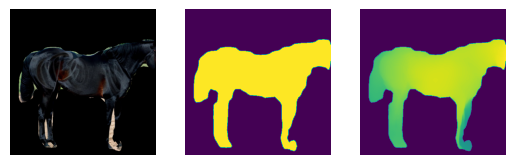

 39%|███████████████████████████▋                                           | 234/600 [00:02<00:03, 97.29it/s]

tensor(0.2871, device='cuda:0') tensor(0.5306, device='cuda:0')
tensor(0.2716, device='cuda:0') tensor(0.5310, device='cuda:0')
tensor(0.2615, device='cuda:0') tensor(0.5317, device='cuda:0')
tensor(0.2602, device='cuda:0') tensor(0.5322, device='cuda:0')
tensor(0.2601, device='cuda:0') tensor(0.5327, device='cuda:0')
tensor(0.2598, device='cuda:0') tensor(0.5333, device='cuda:0')
tensor(0.2597, device='cuda:0') tensor(0.5341, device='cuda:0')
tensor(0.2595, device='cuda:0') tensor(0.5347, device='cuda:0')
tensor(0.2593, device='cuda:0') tensor(0.5349, device='cuda:0')
tensor(0.2591, device='cuda:0') tensor(0.5353, device='cuda:0')
tensor(0.2589, device='cuda:0') tensor(0.5350, device='cuda:0')
tensor(0.2588, device='cuda:0') tensor(0.5345, device='cuda:0')
tensor(0.2587, device='cuda:0') tensor(0.5339, device='cuda:0')
tensor(0.2587, device='cuda:0') tensor(0.5336, device='cuda:0')
tensor(0.2588, device='cuda:0') tensor(0.5331, device='cuda:0')
tensor(0.2589, device='cuda:0') tensor(0

 43%|██████████████████████████████                                        | 258/600 [00:02<00:03, 106.70it/s]

tensor(0.2612, device='cuda:0') tensor(0.5278, device='cuda:0')
tensor(0.2615, device='cuda:0') tensor(0.5375, device='cuda:0')
tensor(0.2619, device='cuda:0') tensor(0.5465, device='cuda:0')
tensor(0.2624, device='cuda:0') tensor(0.5567, device='cuda:0')
tensor(0.2630, device='cuda:0') tensor(0.5663, device='cuda:0')
tensor(0.2635, device='cuda:0') tensor(0.5744, device='cuda:0')
tensor(0.2639, device='cuda:0') tensor(0.5808, device='cuda:0')
tensor(0.2644, device='cuda:0') tensor(0.5846, device='cuda:0')
tensor(0.2648, device='cuda:0') tensor(0.5841, device='cuda:0')
tensor(0.2654, device='cuda:0') tensor(0.5838, device='cuda:0')
tensor(0.2663, device='cuda:0') tensor(0.5839, device='cuda:0')
tensor(0.2672, device='cuda:0') tensor(0.5838, device='cuda:0')
tensor(0.2683, device='cuda:0') tensor(0.5835, device='cuda:0')
tensor(0.2697, device='cuda:0') tensor(0.5774, device='cuda:0')
tensor(0.2714, device='cuda:0') tensor(0.5635, device='cuda:0')
tensor(0.2735, device='cuda:0') tensor(0

 47%|█████████████████████████████████                                     | 283/600 [00:02<00:02, 114.49it/s]

tensor(0.2844, device='cuda:0') tensor(0.4623, device='cuda:0')
tensor(0.2853, device='cuda:0') tensor(0.4621, device='cuda:0')
tensor(0.2863, device='cuda:0') tensor(0.4619, device='cuda:0')
tensor(0.2869, device='cuda:0') tensor(0.4618, device='cuda:0')
tensor(0.2873, device='cuda:0') tensor(0.4616, device='cuda:0')
tensor(0.2878, device='cuda:0') tensor(0.4617, device='cuda:0')
tensor(0.2881, device='cuda:0') tensor(0.4617, device='cuda:0')
tensor(0.2881, device='cuda:0') tensor(0.4616, device='cuda:0')
tensor(0.2880, device='cuda:0') tensor(0.4616, device='cuda:0')
tensor(0.2879, device='cuda:0') tensor(0.4616, device='cuda:0')
tensor(0.2877, device='cuda:0') tensor(0.4616, device='cuda:0')
tensor(0.2875, device='cuda:0') tensor(0.4617, device='cuda:0')
tensor(0.2875, device='cuda:0') tensor(0.4617, device='cuda:0')
tensor(0.2870, device='cuda:0') tensor(0.4616, device='cuda:0')
tensor(0.2861, device='cuda:0') tensor(0.4617, device='cuda:0')
tensor(0.2851, device='cuda:0') tensor(0

 51%|███████████████████████████████████▉                                  | 308/600 [00:03<00:02, 117.29it/s]

tensor(0.2796, device='cuda:0') tensor(0.4615, device='cuda:0')
tensor(0.2796, device='cuda:0') tensor(0.4615, device='cuda:0')
tensor(0.2794, device='cuda:0') tensor(0.4616, device='cuda:0')
tensor(0.2792, device='cuda:0') tensor(0.4615, device='cuda:0')
tensor(0.2790, device='cuda:0') tensor(0.4615, device='cuda:0')
tensor(0.2788, device='cuda:0') tensor(0.4614, device='cuda:0')
tensor(0.2786, device='cuda:0') tensor(0.4614, device='cuda:0')
tensor(0.2785, device='cuda:0') tensor(0.4614, device='cuda:0')
tensor(0.2782, device='cuda:0') tensor(0.4614, device='cuda:0')
tensor(0.2782, device='cuda:0') tensor(0.4614, device='cuda:0')
tensor(0.2781, device='cuda:0') tensor(0.4614, device='cuda:0')
tensor(0.2780, device='cuda:0') tensor(0.4613, device='cuda:0')
tensor(0.2777, device='cuda:0') tensor(0.4615, device='cuda:0')
tensor(0.2775, device='cuda:0') tensor(0.4614, device='cuda:0')
tensor(0.2774, device='cuda:0') tensor(0.4614, device='cuda:0')
tensor(0.2772, device='cuda:0') tensor(0

 55%|██████████████████████████████████████▋                               | 332/600 [00:03<00:02, 118.34it/s]

tensor(0.4611, device='cuda:0')
tensor(0.2795, device='cuda:0') tensor(0.4610, device='cuda:0')
tensor(0.2794, device='cuda:0') tensor(0.4609, device='cuda:0')
tensor(0.2797, device='cuda:0') tensor(0.4610, device='cuda:0')
tensor(0.2800, device='cuda:0') tensor(0.4612, device='cuda:0')
tensor(0.2802, device='cuda:0') tensor(0.4611, device='cuda:0')
tensor(0.2802, device='cuda:0') tensor(0.4612, device='cuda:0')
tensor(0.2800, device='cuda:0') tensor(0.4612, device='cuda:0')
tensor(0.2798, device='cuda:0') tensor(0.4613, device='cuda:0')
tensor(0.2794, device='cuda:0') tensor(0.4614, device='cuda:0')
tensor(0.2790, device='cuda:0') tensor(0.4616, device='cuda:0')
tensor(0.2781, device='cuda:0') tensor(0.4617, device='cuda:0')
tensor(0.2774, device='cuda:0') tensor(0.4618, device='cuda:0')
tensor(0.2766, device='cuda:0') tensor(0.4620, device='cuda:0')
tensor(0.2757, device='cuda:0') tensor(0.4701, device='cuda:0')
tensor(0.2748, device='cuda:0') tensor(0.4770, device='cuda:0')
tensor(0

 60%|█████████████████████████████████████████▊                            | 358/600 [00:03<00:01, 121.18it/s]

tensor(0.2670, device='cuda:0') tensor(0.5777, device='cuda:0')
tensor(0.2665, device='cuda:0') tensor(0.5782, device='cuda:0')
tensor(0.2660, device='cuda:0') tensor(0.5785, device='cuda:0')
tensor(0.2658, device='cuda:0') tensor(0.5791, device='cuda:0')
tensor(0.2653, device='cuda:0') tensor(0.5767, device='cuda:0')
tensor(0.2649, device='cuda:0') tensor(0.5754, device='cuda:0')
tensor(0.2645, device='cuda:0') tensor(0.5712, device='cuda:0')
tensor(0.2642, device='cuda:0') tensor(0.5645, device='cuda:0')
tensor(0.2638, device='cuda:0') tensor(0.5579, device='cuda:0')
tensor(0.2634, device='cuda:0') tensor(0.5488, device='cuda:0')
tensor(0.2630, device='cuda:0') tensor(0.5374, device='cuda:0')
tensor(0.2628, device='cuda:0') tensor(0.5283, device='cuda:0')
tensor(0.2626, device='cuda:0') tensor(0.5253, device='cuda:0')
tensor(0.2626, device='cuda:0') tensor(0.5250, device='cuda:0')
tensor(0.2623, device='cuda:0') tensor(0.5256, device='cuda:0')
tensor(0.2620, device='cuda:0') tensor(0

 64%|████████████████████████████████████████████▊                         | 384/600 [00:03<00:01, 115.22it/s]

tensor(0.2617, device='cuda:0') tensor(0.5342, device='cuda:0')
tensor(0.2619, device='cuda:0') tensor(0.5339, device='cuda:0')
tensor(0.2620, device='cuda:0') tensor(0.5340, device='cuda:0')
tensor(0.2622, device='cuda:0') tensor(0.5336, device='cuda:0')
tensor(0.2623, device='cuda:0') tensor(0.5337, device='cuda:0')
tensor(0.2624, device='cuda:0') tensor(0.5329, device='cuda:0')
tensor(0.2623, device='cuda:0') tensor(0.5323, device='cuda:0')
tensor(0.2635, device='cuda:0') tensor(0.5318, device='cuda:0')
tensor(0.2751, device='cuda:0') tensor(0.5310, device='cuda:0')
tensor(0.2891, device='cuda:0') tensor(0.5301, device='cuda:0')


100%|███████████████████████████████████████████████████████████████████████| 600/600 [00:06<00:00, 91.03it/s]


/grogu/user/akirchme/art3d_sd_webui/images/horse/565.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/565.mp4


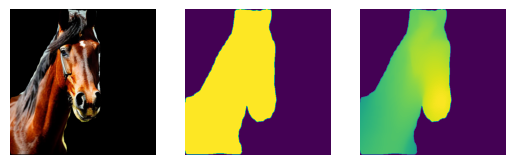

 40%|████████████████████████████▊                                          | 243/600 [00:02<00:03, 96.31it/s]

tensor(0.2903, device='cuda:0') tensor(0.5349, device='cuda:0')
tensor(0.2723, device='cuda:0') tensor(0.5364, device='cuda:0')
tensor(0.2558, device='cuda:0') tensor(0.5381, device='cuda:0')
tensor(0.2456, device='cuda:0') tensor(0.5404, device='cuda:0')
tensor(0.2378, device='cuda:0') tensor(0.5424, device='cuda:0')
tensor(0.2320, device='cuda:0') tensor(0.5436, device='cuda:0')
tensor(0.2313, device='cuda:0') tensor(0.5456, device='cuda:0')
tensor(0.2309, device='cuda:0') tensor(0.5468, device='cuda:0')
tensor(0.2305, device='cuda:0') tensor(0.5477, device='cuda:0')
tensor(0.2301, device='cuda:0') tensor(0.5473, device='cuda:0')
tensor(0.2298, device='cuda:0') tensor(0.5468, device='cuda:0')
tensor(0.2295, device='cuda:0') tensor(0.5463, device='cuda:0')
tensor(0.2292, device='cuda:0') tensor(0.5458, device='cuda:0')
tensor(0.2287, device='cuda:0') tensor(0.5442, device='cuda:0')
tensor(0.2282, device='cuda:0') tensor(0.5421, device='cuda:0')
tensor(0.2279, device='cuda:0') tensor(0

 42%|█████████████████████████████▊                                        | 255/600 [00:03<00:03, 103.12it/s]

tensor(0.2321, device='cuda:0') tensor(0.5228, device='cuda:0')
tensor(0.2329, device='cuda:0') tensor(0.5220, device='cuda:0')
tensor(0.2334, device='cuda:0') tensor(0.5228, device='cuda:0')
tensor(0.2340, device='cuda:0') tensor(0.5294, device='cuda:0')
tensor(0.2347, device='cuda:0') tensor(0.5353, device='cuda:0')
tensor(0.2354, device='cuda:0') tensor(0.5429, device='cuda:0')
tensor(0.2359, device='cuda:0') tensor(0.5476, device='cuda:0')
tensor(0.2368, device='cuda:0') tensor(0.5491, device='cuda:0')
tensor(0.2377, device='cuda:0') tensor(0.5513, device='cuda:0')
tensor(0.2383, device='cuda:0') tensor(0.5531, device='cuda:0')
tensor(0.2391, device='cuda:0') tensor(0.5527, device='cuda:0')
tensor(0.2400, device='cuda:0') tensor(0.5517, device='cuda:0')
tensor(0.2409, device='cuda:0') tensor(0.5505, device='cuda:0')
tensor(0.2418, device='cuda:0') tensor(0.5496, device='cuda:0')
tensor(0.2428, device='cuda:0') tensor(0.5487, device='cuda:0')
tensor(0.2440, device='cuda:0') tensor(0

 47%|████████████████████████████████▊                                     | 281/600 [00:03<00:02, 113.30it/s]

tensor(0.2670, device='cuda:0') tensor(0.4651, device='cuda:0')
tensor(0.2697, device='cuda:0') tensor(0.4647, device='cuda:0')
tensor(0.2723, device='cuda:0') tensor(0.4646, device='cuda:0')
tensor(0.2745, device='cuda:0') tensor(0.4643, device='cuda:0')
tensor(0.2763, device='cuda:0') tensor(0.4640, device='cuda:0')
tensor(0.2781, device='cuda:0') tensor(0.4638, device='cuda:0')
tensor(0.2792, device='cuda:0') tensor(0.4638, device='cuda:0')
tensor(0.2804, device='cuda:0') tensor(0.4637, device='cuda:0')
tensor(0.2812, device='cuda:0') tensor(0.4636, device='cuda:0')
tensor(0.2818, device='cuda:0') tensor(0.4636, device='cuda:0')
tensor(0.2819, device='cuda:0') tensor(0.4635, device='cuda:0')
tensor(0.2818, device='cuda:0') tensor(0.4634, device='cuda:0')
tensor(0.2811, device='cuda:0') tensor(0.4634, device='cuda:0')
tensor(0.2804, device='cuda:0') tensor(0.4634, device='cuda:0')
tensor(0.2796, device='cuda:0') tensor(0.4634, device='cuda:0')
tensor(0.2787, device='cuda:0') tensor(0

 51%|███████████████████████████████████▌                                  | 305/600 [00:03<00:02, 115.96it/s]

tensor(0.2773, device='cuda:0') tensor(0.4631, device='cuda:0')
tensor(0.2776, device='cuda:0') tensor(0.4631, device='cuda:0')
tensor(0.2778, device='cuda:0') tensor(0.4631, device='cuda:0')
tensor(0.2782, device='cuda:0') tensor(0.4631, device='cuda:0')
tensor(0.2786, device='cuda:0') tensor(0.4630, device='cuda:0')
tensor(0.2789, device='cuda:0') tensor(0.4629, device='cuda:0')
tensor(0.2790, device='cuda:0') tensor(0.4629, device='cuda:0')
tensor(0.2791, device='cuda:0') tensor(0.4628, device='cuda:0')
tensor(0.2792, device='cuda:0') tensor(0.4628, device='cuda:0')
tensor(0.2790, device='cuda:0') tensor(0.4628, device='cuda:0')
tensor(0.2789, device='cuda:0') tensor(0.4628, device='cuda:0')
tensor(0.2786, device='cuda:0') tensor(0.4628, device='cuda:0')
tensor(0.2784, device='cuda:0') tensor(0.4627, device='cuda:0')
tensor(0.2778, device='cuda:0') tensor(0.4627, device='cuda:0')
tensor(0.2774, device='cuda:0') tensor(0.4627, device='cuda:0')
tensor(0.2765, device='cuda:0') tensor(0

 57%|███████████████████████████████████████▊                              | 341/600 [00:03<00:02, 117.85it/s]

tensor(0.2731, device='cuda:0') tensor(0.4642, device='cuda:0')
tensor(0.2730, device='cuda:0') tensor(0.4643, device='cuda:0')
tensor(0.2729, device='cuda:0') tensor(0.4645, device='cuda:0')
tensor(0.2727, device='cuda:0') tensor(0.4647, device='cuda:0')
tensor(0.2726, device='cuda:0') tensor(0.4650, device='cuda:0')
tensor(0.2722, device='cuda:0') tensor(0.4650, device='cuda:0')
tensor(0.2720, device='cuda:0') tensor(0.4651, device='cuda:0')
tensor(0.2717, device='cuda:0') tensor(0.4654, device='cuda:0')
tensor(0.2711, device='cuda:0') tensor(0.4654, device='cuda:0')
tensor(0.2705, device='cuda:0') tensor(0.4657, device='cuda:0')
tensor(0.2695, device='cuda:0') tensor(0.4659, device='cuda:0')
tensor(0.2682, device='cuda:0') tensor(0.4661, device='cuda:0')
tensor(0.2667, device='cuda:0') tensor(0.4665, device='cuda:0')
tensor(0.2647, device='cuda:0') tensor(0.4669, device='cuda:0')
tensor(0.2627, device='cuda:0') tensor(0.4674, device='cuda:0')
tensor(0.2603, device='cuda:0') tensor(0

 59%|█████████████████████████████████████████▏                            | 353/600 [00:03<00:02, 117.88it/s]

tensor(0.2442, device='cuda:0') tensor(0.5891, device='cuda:0')
tensor(0.2430, device='cuda:0') tensor(0.5962, device='cuda:0')
tensor(0.2416, device='cuda:0') tensor(0.5967, device='cuda:0')
tensor(0.2406, device='cuda:0') tensor(0.5973, device='cuda:0')
tensor(0.2400, device='cuda:0') tensor(0.5980, device='cuda:0')
tensor(0.2393, device='cuda:0') tensor(0.5986, device='cuda:0')
tensor(0.2387, device='cuda:0') tensor(0.5993, device='cuda:0')
tensor(0.2380, device='cuda:0') tensor(0.5994, device='cuda:0')
tensor(0.2372, device='cuda:0') tensor(0.5970, device='cuda:0')
tensor(0.2363, device='cuda:0') tensor(0.5912, device='cuda:0')
tensor(0.2358, device='cuda:0') tensor(0.5834, device='cuda:0')
tensor(0.2352, device='cuda:0') tensor(0.5767, device='cuda:0')
tensor(0.2345, device='cuda:0') tensor(0.5695, device='cuda:0')
tensor(0.2337, device='cuda:0') tensor(0.5570, device='cuda:0')
tensor(0.2328, device='cuda:0') tensor(0.5443, device='cuda:0')
tensor(0.2322, device='cuda:0') tensor(0

 63%|████████████████████████████████████████████▏                         | 379/600 [00:04<00:01, 120.01it/s]

tensor(0.2290, device='cuda:0') tensor(0.5585, device='cuda:0')
tensor(0.2289, device='cuda:0') tensor(0.5613, device='cuda:0')
tensor(0.2289, device='cuda:0') tensor(0.5641, device='cuda:0')
tensor(0.2292, device='cuda:0') tensor(0.5656, device='cuda:0')
tensor(0.2295, device='cuda:0') tensor(0.5660, device='cuda:0')
tensor(0.2299, device='cuda:0') tensor(0.5665, device='cuda:0')
tensor(0.2302, device='cuda:0') tensor(0.5665, device='cuda:0')
tensor(0.2303, device='cuda:0') tensor(0.5653, device='cuda:0')
tensor(0.2304, device='cuda:0') tensor(0.5630, device='cuda:0')
tensor(0.2306, device='cuda:0') tensor(0.5611, device='cuda:0')
tensor(0.2312, device='cuda:0') tensor(0.5586, device='cuda:0')
tensor(0.2343, device='cuda:0') tensor(0.5558, device='cuda:0')
tensor(0.2445, device='cuda:0') tensor(0.5534, device='cuda:0')
tensor(0.2683, device='cuda:0') tensor(0.5511, device='cuda:0')
tensor(0.2936, device='cuda:0') tensor(0.5487, device='cuda:0')


100%|███████████████████████████████████████████████████████████████████████| 600/600 [00:06<00:00, 86.55it/s]


/grogu/user/akirchme/art3d_sd_webui/images/horse/1581.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/1581.mp4


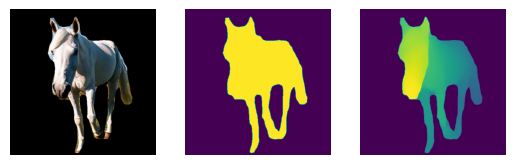

  2%|█▍                                                                     | 12/600 [00:00<00:05, 112.49it/s]

tensor(0.3292, device='cuda:0') tensor(0.4520, device='cuda:0')
tensor(0.3287, device='cuda:0') tensor(0.4522, device='cuda:0')
tensor(0.3282, device='cuda:0') tensor(0.4523, device='cuda:0')
tensor(0.3279, device='cuda:0') tensor(0.4521, device='cuda:0')
tensor(0.3265, device='cuda:0') tensor(0.4523, device='cuda:0')
tensor(0.3252, device='cuda:0') tensor(0.4523, device='cuda:0')
tensor(0.3244, device='cuda:0') tensor(0.4522, device='cuda:0')
tensor(0.3237, device='cuda:0') tensor(0.4522, device='cuda:0')
tensor(0.3231, device='cuda:0') tensor(0.4523, device='cuda:0')
tensor(0.3228, device='cuda:0') tensor(0.4524, device='cuda:0')
tensor(0.3227, device='cuda:0') tensor(0.4525, device='cuda:0')
tensor(0.3223, device='cuda:0') tensor(0.4527, device='cuda:0')
tensor(0.3221, device='cuda:0') tensor(0.4529, device='cuda:0')
tensor(0.3218, device='cuda:0') tensor(0.4530, device='cuda:0')
tensor(0.3216, device='cuda:0') tensor(0.4530, device='cuda:0')
tensor(0.3210, device='cuda:0') tensor(0

  6%|████▍                                                                  | 37/600 [00:00<00:04, 119.11it/s]

tensor(0.3168, device='cuda:0') tensor(0.4542, device='cuda:0')
tensor(0.3163, device='cuda:0') tensor(0.4545, device='cuda:0')
tensor(0.3156, device='cuda:0') tensor(0.4547, device='cuda:0')
tensor(0.3146, device='cuda:0') tensor(0.4549, device='cuda:0')
tensor(0.3136, device='cuda:0') tensor(0.4550, device='cuda:0')
tensor(0.3124, device='cuda:0') tensor(0.4553, device='cuda:0')
tensor(0.3114, device='cuda:0') tensor(0.4556, device='cuda:0')
tensor(0.3103, device='cuda:0') tensor(0.4557, device='cuda:0')
tensor(0.3092, device='cuda:0') tensor(0.4577, device='cuda:0')
tensor(0.3082, device='cuda:0') tensor(0.4648, device='cuda:0')
tensor(0.3070, device='cuda:0') tensor(0.4737, device='cuda:0')
tensor(0.3059, device='cuda:0') tensor(0.4834, device='cuda:0')
tensor(0.3045, device='cuda:0') tensor(0.4930, device='cuda:0')
tensor(0.3030, device='cuda:0') tensor(0.5024, device='cuda:0')
tensor(0.3016, device='cuda:0') tensor(0.5117, device='cuda:0')
tensor(0.2993, device='cuda:0') tensor(0

 12%|████████▋                                                              | 73/600 [00:00<00:04, 118.72it/s]

tensor(0.2921, device='cuda:0') tensor(0.5446, device='cuda:0')
tensor(0.2909, device='cuda:0') tensor(0.5418, device='cuda:0')
tensor(0.2899, device='cuda:0') tensor(0.5389, device='cuda:0')
tensor(0.2887, device='cuda:0') tensor(0.5364, device='cuda:0')
tensor(0.2878, device='cuda:0') tensor(0.5305, device='cuda:0')
tensor(0.2867, device='cuda:0') tensor(0.5248, device='cuda:0')
tensor(0.2856, device='cuda:0') tensor(0.5160, device='cuda:0')
tensor(0.2847, device='cuda:0') tensor(0.5151, device='cuda:0')
tensor(0.2838, device='cuda:0') tensor(0.5140, device='cuda:0')
tensor(0.2833, device='cuda:0') tensor(0.5139, device='cuda:0')
tensor(0.2828, device='cuda:0') tensor(0.5135, device='cuda:0')
tensor(0.2822, device='cuda:0') tensor(0.5126, device='cuda:0')
tensor(0.2820, device='cuda:0') tensor(0.5109, device='cuda:0')
tensor(0.2816, device='cuda:0') tensor(0.5105, device='cuda:0')
tensor(0.2811, device='cuda:0') tensor(0.5116, device='cuda:0')
tensor(0.2809, device='cuda:0') tensor(0

 14%|██████████                                                             | 85/600 [00:00<00:04, 114.94it/s]

tensor(0.2812, device='cuda:0') tensor(0.5269, device='cuda:0')
tensor(0.2813, device='cuda:0') tensor(0.5280, device='cuda:0')
tensor(0.2815, device='cuda:0') tensor(0.5281, device='cuda:0')
tensor(0.2816, device='cuda:0') tensor(0.5281, device='cuda:0')
tensor(0.2881, device='cuda:0') tensor(0.5284, device='cuda:0')


 91%|███████████████████████████████████████████████████████████████▋      | 546/600 [00:05<00:00, 107.31it/s]

tensor(0.2998, device='cuda:0') tensor(0.5461, device='cuda:0')
tensor(0.2907, device='cuda:0') tensor(0.5465, device='cuda:0')
tensor(0.2841, device='cuda:0') tensor(0.5462, device='cuda:0')
tensor(0.2833, device='cuda:0') tensor(0.5459, device='cuda:0')
tensor(0.2835, device='cuda:0') tensor(0.5458, device='cuda:0')
tensor(0.2836, device='cuda:0') tensor(0.5453, device='cuda:0')
tensor(0.2837, device='cuda:0') tensor(0.5440, device='cuda:0')
tensor(0.2835, device='cuda:0') tensor(0.5423, device='cuda:0')
tensor(0.2837, device='cuda:0') tensor(0.5409, device='cuda:0')
tensor(0.2837, device='cuda:0') tensor(0.5396, device='cuda:0')
tensor(0.2841, device='cuda:0') tensor(0.5375, device='cuda:0')
tensor(0.2843, device='cuda:0') tensor(0.5351, device='cuda:0')
tensor(0.2846, device='cuda:0') tensor(0.5334, device='cuda:0')
tensor(0.2849, device='cuda:0') tensor(0.5320, device='cuda:0')
tensor(0.2850, device='cuda:0') tensor(0.5307, device='cuda:0')
tensor(0.2852, device='cuda:0') tensor(0

 95%|██████████████████████████████████████████████████████████████████▍   | 569/600 [00:05<00:00, 109.80it/s]

tensor(0.2946, device='cuda:0') tensor(0.5250, device='cuda:0')
tensor(0.2956, device='cuda:0') tensor(0.5258, device='cuda:0')
tensor(0.2964, device='cuda:0') tensor(0.5274, device='cuda:0')
tensor(0.2975, device='cuda:0') tensor(0.5278, device='cuda:0')
tensor(0.2990, device='cuda:0') tensor(0.5287, device='cuda:0')
tensor(0.3118, device='cuda:0') tensor(0.5159, device='cuda:0')
tensor(0.3150, device='cuda:0') tensor(0.5072, device='cuda:0')
tensor(0.3177, device='cuda:0') tensor(0.4988, device='cuda:0')
tensor(0.3197, device='cuda:0') tensor(0.4898, device='cuda:0')
tensor(0.3219, device='cuda:0') tensor(0.4799, device='cuda:0')
tensor(0.3242, device='cuda:0') tensor(0.4701, device='cuda:0')
tensor(0.3261, device='cuda:0') tensor(0.4640, device='cuda:0')
tensor(0.3277, device='cuda:0') tensor(0.4585, device='cuda:0')
tensor(0.3296, device='cuda:0') tensor(0.4552, device='cuda:0')
tensor(0.3312, device='cuda:0') tensor(0.4547, device='cuda:0')


 99%|█████████████████████████████████████████████████████████████████████▎| 594/600 [00:05<00:00, 115.03it/s]

tensor(0.3330, device='cuda:0') tensor(0.4542, device='cuda:0')
tensor(0.3343, device='cuda:0') tensor(0.4538, device='cuda:0')
tensor(0.3354, device='cuda:0') tensor(0.4536, device='cuda:0')
tensor(0.3364, device='cuda:0') tensor(0.4534, device='cuda:0')
tensor(0.3370, device='cuda:0') tensor(0.4530, device='cuda:0')
tensor(0.3375, device='cuda:0') tensor(0.4529, device='cuda:0')
tensor(0.3378, device='cuda:0') tensor(0.4527, device='cuda:0')
tensor(0.3378, device='cuda:0') tensor(0.4527, device='cuda:0')
tensor(0.3379, device='cuda:0') tensor(0.4526, device='cuda:0')
tensor(0.3380, device='cuda:0') tensor(0.4525, device='cuda:0')
tensor(0.3380, device='cuda:0') tensor(0.4524, device='cuda:0')
tensor(0.3380, device='cuda:0') tensor(0.4524, device='cuda:0')
tensor(0.3380, device='cuda:0') tensor(0.4523, device='cuda:0')
tensor(0.3374, device='cuda:0') tensor(0.4521, device='cuda:0')
tensor(0.3363, device='cuda:0') tensor(0.4521, device='cuda:0')
tensor(0.3351, device='cuda:0') tensor(0

100%|██████████████████████████████████████████████████████████████████████| 600/600 [00:05<00:00, 100.57it/s]


tensor(0.3299, device='cuda:0') tensor(0.4520, device='cuda:0')
tensor(0.3298, device='cuda:0') tensor(0.4520, device='cuda:0')
tensor(0.3301, device='cuda:0') tensor(0.4520, device='cuda:0')
tensor(0.3299, device='cuda:0') tensor(0.4520, device='cuda:0')
tensor(0.3295, device='cuda:0') tensor(0.4520, device='cuda:0')
/grogu/user/akirchme/art3d_sd_webui/images/horse/1647.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/1647.mp4


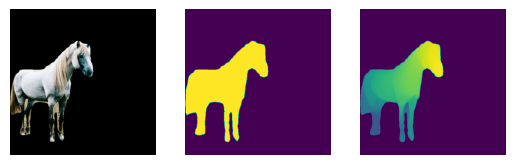

 39%|███████████████████████████▎                                          | 234/600 [00:01<00:03, 120.44it/s]

tensor(0.2734, device='cuda:0') tensor(0.5817, device='cuda:0')
tensor(0.2443, device='cuda:0') tensor(0.5828, device='cuda:0')
tensor(0.2246, device='cuda:0') tensor(0.5836, device='cuda:0')
tensor(0.2097, device='cuda:0') tensor(0.5845, device='cuda:0')
tensor(0.2090, device='cuda:0') tensor(0.5847, device='cuda:0')
tensor(0.2084, device='cuda:0') tensor(0.5857, device='cuda:0')
tensor(0.2083, device='cuda:0') tensor(0.5858, device='cuda:0')
tensor(0.2081, device='cuda:0') tensor(0.5860, device='cuda:0')
tensor(0.2078, device='cuda:0') tensor(0.5859, device='cuda:0')
tensor(0.2079, device='cuda:0') tensor(0.5851, device='cuda:0')
tensor(0.2073, device='cuda:0') tensor(0.5841, device='cuda:0')
tensor(0.2070, device='cuda:0') tensor(0.5834, device='cuda:0')
tensor(0.2069, device='cuda:0') tensor(0.5820, device='cuda:0')
tensor(0.2067, device='cuda:0') tensor(0.5809, device='cuda:0')
tensor(0.2065, device='cuda:0') tensor(0.5797, device='cuda:0')
tensor(0.2067, device='cuda:0') tensor(0

 43%|██████████████████████████████▎                                       | 260/600 [00:02<00:02, 119.70it/s]

tensor(0.2079, device='cuda:0') tensor(0.5598, device='cuda:0')
tensor(0.2082, device='cuda:0') tensor(0.5661, device='cuda:0')
tensor(0.2086, device='cuda:0') tensor(0.5812, device='cuda:0')
tensor(0.2092, device='cuda:0') tensor(0.5996, device='cuda:0')
tensor(0.2096, device='cuda:0') tensor(0.6142, device='cuda:0')
tensor(0.2100, device='cuda:0') tensor(0.6225, device='cuda:0')
tensor(0.2107, device='cuda:0') tensor(0.6267, device='cuda:0')
tensor(0.2112, device='cuda:0') tensor(0.6304, device='cuda:0')
tensor(0.2118, device='cuda:0') tensor(0.6354, device='cuda:0')
tensor(0.2122, device='cuda:0') tensor(0.6350, device='cuda:0')
tensor(0.2128, device='cuda:0') tensor(0.6345, device='cuda:0')
tensor(0.2135, device='cuda:0') tensor(0.6341, device='cuda:0')
tensor(0.2140, device='cuda:0') tensor(0.6335, device='cuda:0')
tensor(0.2145, device='cuda:0') tensor(0.6329, device='cuda:0')
tensor(0.2154, device='cuda:0') tensor(0.6266, device='cuda:0')
tensor(0.2165, device='cuda:0') tensor(0

 47%|█████████████████████████████████▏                                    | 284/600 [00:02<00:02, 119.25it/s]

tensor(0.2284, device='cuda:0') tensor(0.4176, device='cuda:0')
tensor(0.2296, device='cuda:0') tensor(0.4174, device='cuda:0')
tensor(0.2304, device='cuda:0') tensor(0.4172, device='cuda:0')
tensor(0.2314, device='cuda:0') tensor(0.4168, device='cuda:0')
tensor(0.2320, device='cuda:0') tensor(0.4168, device='cuda:0')
tensor(0.2328, device='cuda:0') tensor(0.4167, device='cuda:0')
tensor(0.2331, device='cuda:0') tensor(0.4164, device='cuda:0')
tensor(0.2333, device='cuda:0') tensor(0.4161, device='cuda:0')
tensor(0.2337, device='cuda:0') tensor(0.4159, device='cuda:0')
tensor(0.2336, device='cuda:0') tensor(0.4159, device='cuda:0')
tensor(0.2337, device='cuda:0') tensor(0.4158, device='cuda:0')
tensor(0.2334, device='cuda:0') tensor(0.4159, device='cuda:0')
tensor(0.2332, device='cuda:0') tensor(0.4158, device='cuda:0')
tensor(0.2332, device='cuda:0') tensor(0.4159, device='cuda:0')
tensor(0.2331, device='cuda:0') tensor(0.4158, device='cuda:0')
tensor(0.2329, device='cuda:0') tensor(0

 52%|████████████████████████████████████                                  | 309/600 [00:02<00:02, 119.46it/s]

tensor(0.2328, device='cuda:0') tensor(0.4172, device='cuda:0')
tensor(0.2328, device='cuda:0') tensor(0.4172, device='cuda:0')
tensor(0.2325, device='cuda:0') tensor(0.4173, device='cuda:0')
tensor(0.2321, device='cuda:0') tensor(0.4174, device='cuda:0')
tensor(0.2319, device='cuda:0') tensor(0.4174, device='cuda:0')
tensor(0.2316, device='cuda:0') tensor(0.4174, device='cuda:0')
tensor(0.2314, device='cuda:0') tensor(0.4174, device='cuda:0')
tensor(0.2312, device='cuda:0') tensor(0.4175, device='cuda:0')
tensor(0.2308, device='cuda:0') tensor(0.4174, device='cuda:0')
tensor(0.2306, device='cuda:0') tensor(0.4175, device='cuda:0')
tensor(0.2300, device='cuda:0') tensor(0.4177, device='cuda:0')
tensor(0.2297, device='cuda:0') tensor(0.4177, device='cuda:0')
tensor(0.2291, device='cuda:0') tensor(0.4178, device='cuda:0')
tensor(0.2286, device='cuda:0') tensor(0.4177, device='cuda:0')
tensor(0.2281, device='cuda:0') tensor(0.4178, device='cuda:0')
tensor(0.2274, device='cuda:0') tensor(0

 56%|██████████████████████████████████████▊                               | 333/600 [00:02<00:02, 119.55it/s]

tensor(0.2252, device='cuda:0') tensor(0.4198, device='cuda:0')
tensor(0.2252, device='cuda:0') tensor(0.4199, device='cuda:0')
tensor(0.2253, device='cuda:0') tensor(0.4201, device='cuda:0')
tensor(0.2249, device='cuda:0') tensor(0.4202, device='cuda:0')
tensor(0.2246, device='cuda:0') tensor(0.4203, device='cuda:0')
tensor(0.2245, device='cuda:0') tensor(0.4203, device='cuda:0')
tensor(0.2239, device='cuda:0') tensor(0.4205, device='cuda:0')
tensor(0.2233, device='cuda:0') tensor(0.4205, device='cuda:0')
tensor(0.2224, device='cuda:0') tensor(0.4207, device='cuda:0')
tensor(0.2215, device='cuda:0') tensor(0.4208, device='cuda:0')
tensor(0.2204, device='cuda:0') tensor(0.4208, device='cuda:0')
tensor(0.2196, device='cuda:0') tensor(0.4209, device='cuda:0')
tensor(0.2186, device='cuda:0') tensor(0.4208, device='cuda:0')
tensor(0.2173, device='cuda:0') tensor(0.4211, device='cuda:0')
tensor(0.2161, device='cuda:0') tensor(0.4216, device='cuda:0')
tensor(0.2147, device='cuda:0') tensor(0

 60%|█████████████████████████████████████████▊                            | 358/600 [00:02<00:02, 119.87it/s]

tensor(0.4886, device='cuda:0')
tensor(0.2045, device='cuda:0') tensor(0.4892, device='cuda:0')
tensor(0.2040, device='cuda:0') tensor(0.4899, device='cuda:0')
tensor(0.2035, device='cuda:0') tensor(0.4904, device='cuda:0')
tensor(0.2032, device='cuda:0') tensor(0.4908, device='cuda:0')
tensor(0.2026, device='cuda:0') tensor(0.4918, device='cuda:0')
tensor(0.2020, device='cuda:0') tensor(0.4910, device='cuda:0')
tensor(0.2016, device='cuda:0') tensor(0.4889, device='cuda:0')
tensor(0.2015, device='cuda:0') tensor(0.4867, device='cuda:0')
tensor(0.2014, device='cuda:0') tensor(0.4813, device='cuda:0')
tensor(0.2012, device='cuda:0') tensor(0.4773, device='cuda:0')
tensor(0.2009, device='cuda:0') tensor(0.4718, device='cuda:0')
tensor(0.2003, device='cuda:0') tensor(0.4666, device='cuda:0')
tensor(0.2000, device='cuda:0') tensor(0.4649, device='cuda:0')
tensor(0.1998, device='cuda:0') tensor(0.4656, device='cuda:0')
tensor(0.1997, device='cuda:0') tensor(0.4670, device='cuda:0')
tensor(0

 64%|████████████████████████████████████████████▊                         | 384/600 [00:03<00:01, 120.91it/s]

tensor(0.2005, device='cuda:0') tensor(0.4836, device='cuda:0')
tensor(0.2010, device='cuda:0') tensor(0.4850, device='cuda:0')
tensor(0.2013, device='cuda:0') tensor(0.4857, device='cuda:0')
tensor(0.2021, device='cuda:0') tensor(0.4866, device='cuda:0')
tensor(0.2025, device='cuda:0') tensor(0.4871, device='cuda:0')
tensor(0.2031, device='cuda:0') tensor(0.4873, device='cuda:0')
tensor(0.2035, device='cuda:0') tensor(0.4871, device='cuda:0')
tensor(0.2037, device='cuda:0') tensor(0.4858, device='cuda:0')
tensor(0.2038, device='cuda:0') tensor(0.4847, device='cuda:0')
tensor(0.2045, device='cuda:0') tensor(0.4836, device='cuda:0')
tensor(0.2101, device='cuda:0') tensor(0.4825, device='cuda:0')
tensor(0.2170, device='cuda:0') tensor(0.4811, device='cuda:0')
tensor(0.2261, device='cuda:0') tensor(0.4804, device='cuda:0')
tensor(0.2359, device='cuda:0') tensor(0.4793, device='cuda:0')
tensor(0.2502, device='cuda:0') tensor(0.4789, device='cuda:0')
tensor(0.2647, device='cuda:0') tensor(0

 68%|███████████████████████████████████████████████▊                      | 410/600 [00:03<00:01, 120.95it/s]

tensor(0.2807, device='cuda:0') tensor(0.6237, device='cuda:0')
tensor(0.2824, device='cuda:0') tensor(0.6480, device='cuda:0')
tensor(0.2850, device='cuda:0') tensor(0.6659, device='cuda:0')
tensor(0.2882, device='cuda:0') tensor(0.6763, device='cuda:0')
tensor(0.2924, device='cuda:0') tensor(0.6813, device='cuda:0')
tensor(0.2955, device='cuda:0') tensor(0.6831, device='cuda:0')
tensor(0.2987, device='cuda:0') tensor(0.6830, device='cuda:0')


100%|██████████████████████████████████████████████████████████████████████| 600/600 [00:04<00:00, 122.52it/s]


/grogu/user/akirchme/art3d_sd_webui/images/horse/104.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/104.mp4


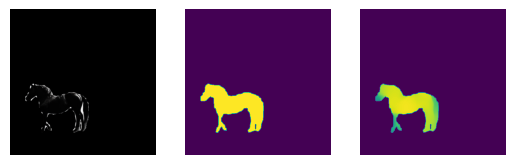

  2%|█▍                                                                     | 12/600 [00:00<00:05, 115.68it/s]

tensor(0.3329, device='cuda:0') tensor(0.4690, device='cuda:0')
tensor(0.3333, device='cuda:0') tensor(0.4690, device='cuda:0')
tensor(0.3341, device='cuda:0') tensor(0.4693, device='cuda:0')
tensor(0.3347, device='cuda:0') tensor(0.4692, device='cuda:0')
tensor(0.3354, device='cuda:0') tensor(0.4692, device='cuda:0')
tensor(0.3363, device='cuda:0') tensor(0.4693, device='cuda:0')
tensor(0.3365, device='cuda:0') tensor(0.4693, device='cuda:0')
tensor(0.3373, device='cuda:0') tensor(0.4694, device='cuda:0')
tensor(0.3374, device='cuda:0') tensor(0.4696, device='cuda:0')
tensor(0.3377, device='cuda:0') tensor(0.4696, device='cuda:0')
tensor(0.3383, device='cuda:0') tensor(0.4698, device='cuda:0')
tensor(0.3389, device='cuda:0') tensor(0.4699, device='cuda:0')
tensor(0.3396, device='cuda:0') tensor(0.4701, device='cuda:0')
tensor(0.3402, device='cuda:0') tensor(0.4701, device='cuda:0')
tensor(0.3416, device='cuda:0') tensor(0.4702, device='cuda:0')
tensor(0.3426, device='cuda:0') tensor(0

  6%|████▎                                                                  | 36/600 [00:00<00:04, 118.26it/s]

tensor(0.3466, device='cuda:0') tensor(0.4704, device='cuda:0')
tensor(0.3466, device='cuda:0') tensor(0.4706, device='cuda:0')
tensor(0.3466, device='cuda:0') tensor(0.4707, device='cuda:0')
tensor(0.3464, device='cuda:0') tensor(0.4708, device='cuda:0')
tensor(0.3460, device='cuda:0') tensor(0.4711, device='cuda:0')
tensor(0.3459, device='cuda:0') tensor(0.4715, device='cuda:0')
tensor(0.3453, device='cuda:0') tensor(0.4716, device='cuda:0')
tensor(0.3450, device='cuda:0') tensor(0.4716, device='cuda:0')
tensor(0.3444, device='cuda:0') tensor(0.4719, device='cuda:0')
tensor(0.3441, device='cuda:0') tensor(0.4770, device='cuda:0')
tensor(0.3431, device='cuda:0') tensor(0.4896, device='cuda:0')
tensor(0.3427, device='cuda:0') tensor(0.5096, device='cuda:0')


 97%|████████████████████████████████████████████████████████████████████▏ | 584/600 [00:04<00:00, 126.94it/s]

tensor(0.3167, device='cuda:0') tensor(0.5102, device='cuda:0')
tensor(0.3172, device='cuda:0') tensor(0.4897, device='cuda:0')
tensor(0.3179, device='cuda:0') tensor(0.4711, device='cuda:0')
tensor(0.3186, device='cuda:0') tensor(0.4708, device='cuda:0')
tensor(0.3192, device='cuda:0') tensor(0.4708, device='cuda:0')
tensor(0.3199, device='cuda:0') tensor(0.4708, device='cuda:0')
tensor(0.3205, device='cuda:0') tensor(0.4710, device='cuda:0')
tensor(0.3211, device='cuda:0') tensor(0.4708, device='cuda:0')
tensor(0.3217, device='cuda:0') tensor(0.4709, device='cuda:0')
tensor(0.3222, device='cuda:0') tensor(0.4709, device='cuda:0')
tensor(0.3226, device='cuda:0') tensor(0.4706, device='cuda:0')
tensor(0.3230, device='cuda:0') tensor(0.4706, device='cuda:0')
tensor(0.3232, device='cuda:0') tensor(0.4703, device='cuda:0')
tensor(0.3232, device='cuda:0') tensor(0.4702, device='cuda:0')
tensor(0.3236, device='cuda:0') tensor(0.4703, device='cuda:0')
tensor(0.3239, device='cuda:0') tensor(0

100%|██████████████████████████████████████████████████████████████████████| 600/600 [00:04<00:00, 131.76it/s]


tensor(0.3289, device='cuda:0') tensor(0.4694, device='cuda:0')
tensor(0.3297, device='cuda:0') tensor(0.4693, device='cuda:0')
tensor(0.3299, device='cuda:0') tensor(0.4692, device='cuda:0')
tensor(0.3302, device='cuda:0') tensor(0.4690, device='cuda:0')
tensor(0.3304, device='cuda:0') tensor(0.4690, device='cuda:0')
tensor(0.3314, device='cuda:0') tensor(0.4687, device='cuda:0')
tensor(0.3319, device='cuda:0') tensor(0.4686, device='cuda:0')
tensor(0.3324, device='cuda:0') tensor(0.4687, device='cuda:0')
tensor(0.3329, device='cuda:0') tensor(0.4688, device='cuda:0')
/grogu/user/akirchme/art3d_sd_webui/images/horse/1696.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/1696.mp4


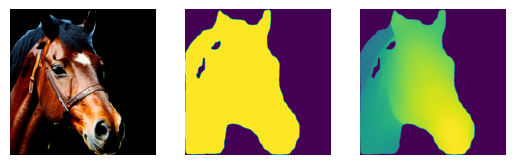

 40%|████████████████████████████▍                                          | 240/600 [00:03<00:04, 87.48it/s]

tensor(0.3417, device='cuda:0') tensor(0.5183, device='cuda:0')
tensor(0.3398, device='cuda:0') tensor(0.5171, device='cuda:0')
tensor(0.3304, device='cuda:0') tensor(0.5174, device='cuda:0')
tensor(0.3102, device='cuda:0') tensor(0.5177, device='cuda:0')
tensor(0.2901, device='cuda:0') tensor(0.5179, device='cuda:0')
tensor(0.2766, device='cuda:0') tensor(0.5191, device='cuda:0')
tensor(0.2688, device='cuda:0') tensor(0.5205, device='cuda:0')
tensor(0.2620, device='cuda:0') tensor(0.5218, device='cuda:0')
tensor(0.2567, device='cuda:0') tensor(0.5230, device='cuda:0')
tensor(0.2559, device='cuda:0') tensor(0.5233, device='cuda:0')
tensor(0.2555, device='cuda:0') tensor(0.5238, device='cuda:0')
tensor(0.2550, device='cuda:0') tensor(0.5237, device='cuda:0')
tensor(0.2547, device='cuda:0') tensor(0.5234, device='cuda:0')
tensor(0.2545, device='cuda:0') tensor(0.5229, device='cuda:0')
tensor(0.2542, device='cuda:0') tensor(0.5219, device='cuda:0')
tensor(0.2539, device='cuda:0') tensor(0

 42%|█████████████████████████████▊                                         | 252/600 [00:03<00:03, 96.60it/s]

tensor(0.2523, device='cuda:0') tensor(0.5038, device='cuda:0')
tensor(0.2523, device='cuda:0') tensor(0.5031, device='cuda:0')
tensor(0.2530, device='cuda:0') tensor(0.5025, device='cuda:0')
tensor(0.2536, device='cuda:0') tensor(0.5025, device='cuda:0')
tensor(0.2539, device='cuda:0') tensor(0.5028, device='cuda:0')
tensor(0.2547, device='cuda:0') tensor(0.5056, device='cuda:0')
tensor(0.2555, device='cuda:0') tensor(0.5200, device='cuda:0')
tensor(0.2563, device='cuda:0') tensor(0.5315, device='cuda:0')
tensor(0.2571, device='cuda:0') tensor(0.5403, device='cuda:0')
tensor(0.2579, device='cuda:0') tensor(0.5466, device='cuda:0')
tensor(0.2587, device='cuda:0') tensor(0.5486, device='cuda:0')
tensor(0.2597, device='cuda:0') tensor(0.5500, device='cuda:0')
tensor(0.2604, device='cuda:0') tensor(0.5519, device='cuda:0')
tensor(0.2611, device='cuda:0') tensor(0.5537, device='cuda:0')
tensor(0.2617, device='cuda:0') tensor(0.5530, device='cuda:0')
tensor(0.2624, device='cuda:0') tensor(0

 46%|████████████████████████████████▍                                     | 278/600 [00:03<00:02, 109.64it/s]

tensor(0.2754, device='cuda:0') tensor(0.4791, device='cuda:0')
tensor(0.2770, device='cuda:0') tensor(0.4748, device='cuda:0')
tensor(0.2786, device='cuda:0') tensor(0.4710, device='cuda:0')
tensor(0.2806, device='cuda:0') tensor(0.4677, device='cuda:0')
tensor(0.2828, device='cuda:0') tensor(0.4675, device='cuda:0')
tensor(0.2849, device='cuda:0') tensor(0.4674, device='cuda:0')
tensor(0.2868, device='cuda:0') tensor(0.4673, device='cuda:0')
tensor(0.2885, device='cuda:0') tensor(0.4673, device='cuda:0')
tensor(0.2899, device='cuda:0') tensor(0.4671, device='cuda:0')
tensor(0.2910, device='cuda:0') tensor(0.4670, device='cuda:0')
tensor(0.2919, device='cuda:0') tensor(0.4670, device='cuda:0')
tensor(0.2925, device='cuda:0') tensor(0.4669, device='cuda:0')
tensor(0.2929, device='cuda:0') tensor(0.4668, device='cuda:0')
tensor(0.2929, device='cuda:0') tensor(0.4667, device='cuda:0')
tensor(0.2927, device='cuda:0') tensor(0.4667, device='cuda:0')
tensor(0.2922, device='cuda:0') tensor(0

 50%|███████████████████████████████████▎                                  | 303/600 [00:04<00:02, 114.83it/s]

tensor(0.2901, device='cuda:0') tensor(0.4656, device='cuda:0')
tensor(0.2908, device='cuda:0') tensor(0.4653, device='cuda:0')
tensor(0.2916, device='cuda:0') tensor(0.4652, device='cuda:0')
tensor(0.2923, device='cuda:0') tensor(0.4652, device='cuda:0')
tensor(0.2930, device='cuda:0') tensor(0.4652, device='cuda:0')
tensor(0.2937, device='cuda:0') tensor(0.4651, device='cuda:0')
tensor(0.2946, device='cuda:0') tensor(0.4651, device='cuda:0')
tensor(0.2952, device='cuda:0') tensor(0.4650, device='cuda:0')
tensor(0.2958, device='cuda:0') tensor(0.4649, device='cuda:0')
tensor(0.2963, device='cuda:0') tensor(0.4649, device='cuda:0')
tensor(0.2966, device='cuda:0') tensor(0.4650, device='cuda:0')
tensor(0.2970, device='cuda:0') tensor(0.4649, device='cuda:0')
tensor(0.2973, device='cuda:0') tensor(0.4649, device='cuda:0')
tensor(0.2976, device='cuda:0') tensor(0.4649, device='cuda:0')
tensor(0.2979, device='cuda:0') tensor(0.4648, device='cuda:0')
tensor(0.2981, device='cuda:0') tensor(0

 55%|██████████████████████████████████████▏                               | 327/600 [00:04<00:02, 116.09it/s]

tensor(0.3024, device='cuda:0') tensor(0.4643, device='cuda:0')
tensor(0.3046, device='cuda:0') tensor(0.4643, device='cuda:0')
tensor(0.3064, device='cuda:0') tensor(0.4643, device='cuda:0')
tensor(0.3079, device='cuda:0') tensor(0.4644, device='cuda:0')
tensor(0.3090, device='cuda:0') tensor(0.4644, device='cuda:0')
tensor(0.3097, device='cuda:0') tensor(0.4645, device='cuda:0')
tensor(0.3103, device='cuda:0') tensor(0.4645, device='cuda:0')
tensor(0.3108, device='cuda:0') tensor(0.4645, device='cuda:0')
tensor(0.3109, device='cuda:0') tensor(0.4645, device='cuda:0')
tensor(0.3110, device='cuda:0') tensor(0.4646, device='cuda:0')
tensor(0.3109, device='cuda:0') tensor(0.4646, device='cuda:0')
tensor(0.3105, device='cuda:0') tensor(0.4646, device='cuda:0')
tensor(0.3100, device='cuda:0') tensor(0.4645, device='cuda:0')
tensor(0.3092, device='cuda:0') tensor(0.4645, device='cuda:0')
tensor(0.3082, device='cuda:0') tensor(0.4647, device='cuda:0')
tensor(0.3071, device='cuda:0') tensor(0

 59%|█████████████████████████████████████████                             | 352/600 [00:04<00:02, 118.08it/s]

tensor(0.2893, device='cuda:0') tensor(0.5235, device='cuda:0')
tensor(0.2862, device='cuda:0') tensor(0.5406, device='cuda:0')
tensor(0.2830, device='cuda:0') tensor(0.5600, device='cuda:0')
tensor(0.2804, device='cuda:0') tensor(0.5821, device='cuda:0')
tensor(0.2782, device='cuda:0') tensor(0.5891, device='cuda:0')
tensor(0.2767, device='cuda:0') tensor(0.5901, device='cuda:0')
tensor(0.2754, device='cuda:0') tensor(0.5906, device='cuda:0')
tensor(0.2744, device='cuda:0') tensor(0.5910, device='cuda:0')
tensor(0.2732, device='cuda:0') tensor(0.5915, device='cuda:0')
tensor(0.2722, device='cuda:0') tensor(0.5922, device='cuda:0')
tensor(0.2711, device='cuda:0') tensor(0.5898, device='cuda:0')
tensor(0.2702, device='cuda:0') tensor(0.5839, device='cuda:0')
tensor(0.2692, device='cuda:0') tensor(0.5789, device='cuda:0')
tensor(0.2679, device='cuda:0') tensor(0.5768, device='cuda:0')
tensor(0.2669, device='cuda:0') tensor(0.5742, device='cuda:0')
tensor(0.2659, device='cuda:0') tensor(0

 63%|███████████████████████████████████████████▊                          | 376/600 [00:04<00:01, 117.93it/s]

tensor(0.2582, device='cuda:0') tensor(0.5581, device='cuda:0')
tensor(0.2580, device='cuda:0') tensor(0.5597, device='cuda:0')
tensor(0.2580, device='cuda:0') tensor(0.5609, device='cuda:0')
tensor(0.2580, device='cuda:0') tensor(0.5627, device='cuda:0')
tensor(0.2579, device='cuda:0') tensor(0.5645, device='cuda:0')
tensor(0.2579, device='cuda:0') tensor(0.5667, device='cuda:0')
tensor(0.2581, device='cuda:0') tensor(0.5687, device='cuda:0')
tensor(0.2584, device='cuda:0') tensor(0.5703, device='cuda:0')
tensor(0.2585, device='cuda:0') tensor(0.5723, device='cuda:0')
tensor(0.2587, device='cuda:0') tensor(0.5742, device='cuda:0')
tensor(0.2588, device='cuda:0') tensor(0.5759, device='cuda:0')
tensor(0.2589, device='cuda:0') tensor(0.5767, device='cuda:0')
tensor(0.2590, device='cuda:0') tensor(0.5767, device='cuda:0')
tensor(0.2596, device='cuda:0') tensor(0.5764, device='cuda:0')
tensor(0.2680, device='cuda:0') tensor(0.5761, device='cuda:0')
tensor(0.2808, device='cuda:0') tensor(0

100%|███████████████████████████████████████████████████████████████████████| 600/600 [00:08<00:00, 72.81it/s]


/grogu/user/akirchme/art3d_sd_webui/images/horse/672.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/672.mp4


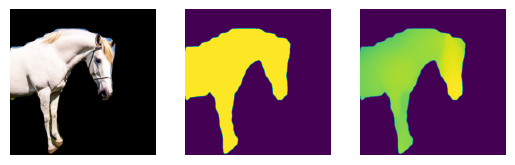

 39%|███████████████████████████▎                                          | 234/600 [00:02<00:03, 106.26it/s]

tensor(0.2998, device='cuda:0') tensor(0.4941, device='cuda:0')
tensor(0.2992, device='cuda:0') tensor(0.4807, device='cuda:0')
tensor(0.2983, device='cuda:0') tensor(0.4801, device='cuda:0')
tensor(0.2964, device='cuda:0') tensor(0.4803, device='cuda:0')
tensor(0.2922, device='cuda:0') tensor(0.4806, device='cuda:0')
tensor(0.2834, device='cuda:0') tensor(0.4808, device='cuda:0')
tensor(0.2687, device='cuda:0') tensor(0.4809, device='cuda:0')
tensor(0.2391, device='cuda:0') tensor(0.4811, device='cuda:0')
tensor(0.2130, device='cuda:0') tensor(0.4814, device='cuda:0')
tensor(0.2098, device='cuda:0') tensor(0.4814, device='cuda:0')
tensor(0.2097, device='cuda:0') tensor(0.4816, device='cuda:0')
tensor(0.2096, device='cuda:0') tensor(0.4816, device='cuda:0')
tensor(0.2096, device='cuda:0') tensor(0.4814, device='cuda:0')
tensor(0.2097, device='cuda:0') tensor(0.4815, device='cuda:0')
tensor(0.2098, device='cuda:0') tensor(0.4812, device='cuda:0')
tensor(0.2099, device='cuda:0') tensor(0

 43%|██████████████████████████████                                        | 258/600 [00:02<00:03, 112.63it/s]

tensor(0.2103, device='cuda:0') tensor(0.4799, device='cuda:0')
tensor(0.2105, device='cuda:0') tensor(0.4804, device='cuda:0')
tensor(0.2105, device='cuda:0') tensor(0.4809, device='cuda:0')
tensor(0.2106, device='cuda:0') tensor(0.4811, device='cuda:0')
tensor(0.2108, device='cuda:0') tensor(0.4814, device='cuda:0')
tensor(0.2111, device='cuda:0') tensor(0.4819, device='cuda:0')
tensor(0.2115, device='cuda:0') tensor(0.4826, device='cuda:0')
tensor(0.2116, device='cuda:0') tensor(0.4838, device='cuda:0')
tensor(0.2117, device='cuda:0') tensor(0.4867, device='cuda:0')
tensor(0.2118, device='cuda:0') tensor(0.4911, device='cuda:0')
tensor(0.2119, device='cuda:0') tensor(0.4959, device='cuda:0')
tensor(0.2120, device='cuda:0') tensor(0.5087, device='cuda:0')
tensor(0.2121, device='cuda:0') tensor(0.5277, device='cuda:0')
tensor(0.2122, device='cuda:0') tensor(0.5438, device='cuda:0')
tensor(0.2124, device='cuda:0') tensor(0.5455, device='cuda:0')
tensor(0.2126, device='cuda:0') tensor(0

 47%|████████████████████████████████▉                                     | 282/600 [00:02<00:02, 115.84it/s]

tensor(0.2157, device='cuda:0') tensor(0.5251, device='cuda:0')
tensor(0.2162, device='cuda:0') tensor(0.5120, device='cuda:0')
tensor(0.2168, device='cuda:0') tensor(0.4916, device='cuda:0')
tensor(0.2173, device='cuda:0') tensor(0.4720, device='cuda:0')
tensor(0.2179, device='cuda:0') tensor(0.4559, device='cuda:0')
tensor(0.2183, device='cuda:0') tensor(0.4559, device='cuda:0')
tensor(0.2190, device='cuda:0') tensor(0.4558, device='cuda:0')
tensor(0.2194, device='cuda:0') tensor(0.4559, device='cuda:0')
tensor(0.2197, device='cuda:0') tensor(0.4560, device='cuda:0')
tensor(0.2199, device='cuda:0') tensor(0.4560, device='cuda:0')
tensor(0.2199, device='cuda:0') tensor(0.4561, device='cuda:0')
tensor(0.2198, device='cuda:0') tensor(0.4561, device='cuda:0')
tensor(0.2196, device='cuda:0') tensor(0.4560, device='cuda:0')
tensor(0.2193, device='cuda:0') tensor(0.4560, device='cuda:0')
tensor(0.2189, device='cuda:0') tensor(0.4560, device='cuda:0')
tensor(0.2186, device='cuda:0') tensor(0

 51%|███████████████████████████████████▊                                  | 307/600 [00:02<00:02, 118.33it/s]

tensor(0.2163, device='cuda:0') tensor(0.4569, device='cuda:0')
tensor(0.2162, device='cuda:0') tensor(0.4572, device='cuda:0')
tensor(0.2163, device='cuda:0') tensor(0.4572, device='cuda:0')
tensor(0.2164, device='cuda:0') tensor(0.4573, device='cuda:0')
tensor(0.2164, device='cuda:0') tensor(0.4573, device='cuda:0')
tensor(0.2165, device='cuda:0') tensor(0.4573, device='cuda:0')
tensor(0.2166, device='cuda:0') tensor(0.4574, device='cuda:0')
tensor(0.2167, device='cuda:0') tensor(0.4574, device='cuda:0')
tensor(0.2168, device='cuda:0') tensor(0.4574, device='cuda:0')
tensor(0.2170, device='cuda:0') tensor(0.4574, device='cuda:0')
tensor(0.2172, device='cuda:0') tensor(0.4574, device='cuda:0')
tensor(0.2174, device='cuda:0') tensor(0.4574, device='cuda:0')
tensor(0.2178, device='cuda:0') tensor(0.4575, device='cuda:0')
tensor(0.2179, device='cuda:0') tensor(0.4575, device='cuda:0')
tensor(0.2180, device='cuda:0') tensor(0.4575, device='cuda:0')
tensor(0.2179, device='cuda:0') tensor(0

 56%|██████████████████████████████████████▊                               | 333/600 [00:03<00:02, 119.76it/s]

tensor(0.2176, device='cuda:0') tensor(0.4571, device='cuda:0')
tensor(0.2176, device='cuda:0') tensor(0.4571, device='cuda:0')
tensor(0.2177, device='cuda:0') tensor(0.4572, device='cuda:0')
tensor(0.2178, device='cuda:0') tensor(0.4572, device='cuda:0')
tensor(0.2177, device='cuda:0') tensor(0.4571, device='cuda:0')
tensor(0.2177, device='cuda:0') tensor(0.4570, device='cuda:0')
tensor(0.2177, device='cuda:0') tensor(0.4570, device='cuda:0')
tensor(0.2178, device='cuda:0') tensor(0.4571, device='cuda:0')
tensor(0.2177, device='cuda:0') tensor(0.4570, device='cuda:0')
tensor(0.2176, device='cuda:0') tensor(0.4569, device='cuda:0')
tensor(0.2176, device='cuda:0') tensor(0.4568, device='cuda:0')
tensor(0.2175, device='cuda:0') tensor(0.4568, device='cuda:0')
tensor(0.2174, device='cuda:0') tensor(0.4568, device='cuda:0')
tensor(0.2173, device='cuda:0') tensor(0.4567, device='cuda:0')
tensor(0.2173, device='cuda:0') tensor(0.4566, device='cuda:0')
tensor(0.2171, device='cuda:0') tensor(0

 60%|█████████████████████████████████████████▋                            | 357/600 [00:03<00:02, 119.51it/s]

tensor(0.2149, device='cuda:0') tensor(0.7155, device='cuda:0')
tensor(0.2146, device='cuda:0') tensor(0.7353, device='cuda:0')
tensor(0.2144, device='cuda:0') tensor(0.7499, device='cuda:0')
tensor(0.2141, device='cuda:0') tensor(0.7569, device='cuda:0')
tensor(0.2139, device='cuda:0') tensor(0.7578, device='cuda:0')
tensor(0.2136, device='cuda:0') tensor(0.7581, device='cuda:0')
tensor(0.2134, device='cuda:0') tensor(0.7583, device='cuda:0')
tensor(0.2132, device='cuda:0') tensor(0.7586, device='cuda:0')
tensor(0.2129, device='cuda:0') tensor(0.7590, device='cuda:0')
tensor(0.2125, device='cuda:0') tensor(0.7588, device='cuda:0')
tensor(0.2122, device='cuda:0') tensor(0.7498, device='cuda:0')
tensor(0.2119, device='cuda:0') tensor(0.7297, device='cuda:0')
tensor(0.2114, device='cuda:0') tensor(0.6973, device='cuda:0')
tensor(0.2109, device='cuda:0') tensor(0.6547, device='cuda:0')
tensor(0.2103, device='cuda:0') tensor(0.6351, device='cuda:0')
tensor(0.2099, device='cuda:0') tensor(0

 64%|████████████████████████████████████████████▋                         | 383/600 [00:03<00:01, 116.55it/s]

tensor(0.2087, device='cuda:0') tensor(0.6118, device='cuda:0')
tensor(0.2087, device='cuda:0') tensor(0.6119, device='cuda:0')
tensor(0.2087, device='cuda:0') tensor(0.6123, device='cuda:0')
tensor(0.2087, device='cuda:0') tensor(0.6123, device='cuda:0')
tensor(0.2087, device='cuda:0') tensor(0.6124, device='cuda:0')
tensor(0.2087, device='cuda:0') tensor(0.6128, device='cuda:0')
tensor(0.2086, device='cuda:0') tensor(0.6131, device='cuda:0')
tensor(0.2087, device='cuda:0') tensor(0.6133, device='cuda:0')
tensor(0.2088, device='cuda:0') tensor(0.6136, device='cuda:0')
tensor(0.2089, device='cuda:0') tensor(0.6135, device='cuda:0')
tensor(0.2088, device='cuda:0') tensor(0.6136, device='cuda:0')
tensor(0.2089, device='cuda:0') tensor(0.6136, device='cuda:0')
tensor(0.2089, device='cuda:0') tensor(0.6135, device='cuda:0')
tensor(0.2130, device='cuda:0') tensor(0.6132, device='cuda:0')
tensor(0.2592, device='cuda:0') tensor(0.6132, device='cuda:0')


100%|██████████████████████████████████████████████████████████████████████| 600/600 [00:05<00:00, 102.27it/s]


/grogu/user/akirchme/art3d_sd_webui/images/horse/1131.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/1131.mp4


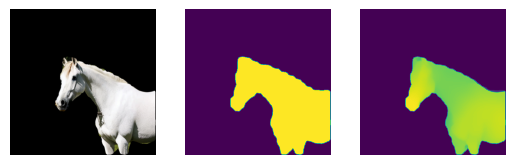

  4%|██▊                                                                    | 24/600 [00:00<00:04, 117.97it/s]

tensor(0.3991, device='cuda:0') tensor(0.5184, device='cuda:0')
tensor(0.3992, device='cuda:0') tensor(0.5184, device='cuda:0')
tensor(0.3993, device='cuda:0') tensor(0.5184, device='cuda:0')
tensor(0.3993, device='cuda:0') tensor(0.5184, device='cuda:0')
tensor(0.3994, device='cuda:0') tensor(0.5183, device='cuda:0')
tensor(0.3993, device='cuda:0') tensor(0.5184, device='cuda:0')
tensor(0.3990, device='cuda:0') tensor(0.5184, device='cuda:0')
tensor(0.3988, device='cuda:0') tensor(0.5184, device='cuda:0')
tensor(0.3987, device='cuda:0') tensor(0.5183, device='cuda:0')
tensor(0.3985, device='cuda:0') tensor(0.5182, device='cuda:0')
tensor(0.3984, device='cuda:0') tensor(0.5180, device='cuda:0')
tensor(0.3983, device='cuda:0') tensor(0.5180, device='cuda:0')
tensor(0.3981, device='cuda:0') tensor(0.5179, device='cuda:0')
tensor(0.3981, device='cuda:0') tensor(0.5179, device='cuda:0')
tensor(0.3982, device='cuda:0') tensor(0.5180, device='cuda:0')
tensor(0.3983, device='cuda:0') tensor(0

  6%|████▎                                                                  | 36/600 [00:00<00:04, 116.44it/s]

tensor(0.3987, device='cuda:0') tensor(0.5174, device='cuda:0')
tensor(0.3987, device='cuda:0') tensor(0.5173, device='cuda:0')
tensor(0.3986, device='cuda:0') tensor(0.5174, device='cuda:0')
tensor(0.3985, device='cuda:0') tensor(0.5174, device='cuda:0')
tensor(0.3983, device='cuda:0') tensor(0.5174, device='cuda:0')
tensor(0.3980, device='cuda:0') tensor(0.5174, device='cuda:0')
tensor(0.3978, device='cuda:0') tensor(0.5175, device='cuda:0')
tensor(0.3977, device='cuda:0') tensor(0.5175, device='cuda:0')
tensor(0.3975, device='cuda:0') tensor(0.5186, device='cuda:0')


 40%|████████████████████████████▏                                         | 242/600 [00:02<00:03, 113.44it/s]

tensor(0.2867, device='cuda:0') tensor(0.5302, device='cuda:0')
tensor(0.2626, device='cuda:0') tensor(0.5305, device='cuda:0')
tensor(0.2155, device='cuda:0') tensor(0.5308, device='cuda:0')
tensor(0.2080, device='cuda:0') tensor(0.5310, device='cuda:0')
tensor(0.2080, device='cuda:0') tensor(0.5314, device='cuda:0')
tensor(0.2080, device='cuda:0') tensor(0.5314, device='cuda:0')
tensor(0.2080, device='cuda:0') tensor(0.5315, device='cuda:0')
tensor(0.2082, device='cuda:0') tensor(0.5314, device='cuda:0')
tensor(0.2082, device='cuda:0') tensor(0.5317, device='cuda:0')
tensor(0.2083, device='cuda:0') tensor(0.5315, device='cuda:0')
tensor(0.2083, device='cuda:0') tensor(0.5311, device='cuda:0')
tensor(0.2084, device='cuda:0') tensor(0.5308, device='cuda:0')
tensor(0.2085, device='cuda:0') tensor(0.5306, device='cuda:0')
tensor(0.2086, device='cuda:0') tensor(0.5302, device='cuda:0')
tensor(0.2087, device='cuda:0') tensor(0.5299, device='cuda:0')
tensor(0.2087, device='cuda:0') tensor(0

 44%|███████████████████████████████                                       | 266/600 [00:02<00:02, 116.16it/s]

tensor(0.2118, device='cuda:0') tensor(0.5333, device='cuda:0')
tensor(0.2122, device='cuda:0') tensor(0.5348, device='cuda:0')
tensor(0.2126, device='cuda:0') tensor(0.5379, device='cuda:0')
tensor(0.2128, device='cuda:0') tensor(0.5455, device='cuda:0')
tensor(0.2132, device='cuda:0') tensor(0.5569, device='cuda:0')
tensor(0.2138, device='cuda:0') tensor(0.5737, device='cuda:0')
tensor(0.2142, device='cuda:0') tensor(0.5965, device='cuda:0')
tensor(0.2149, device='cuda:0') tensor(0.5986, device='cuda:0')
tensor(0.2154, device='cuda:0') tensor(0.5986, device='cuda:0')
tensor(0.2160, device='cuda:0') tensor(0.5984, device='cuda:0')
tensor(0.2165, device='cuda:0') tensor(0.5978, device='cuda:0')
tensor(0.2168, device='cuda:0') tensor(0.5974, device='cuda:0')
tensor(0.2174, device='cuda:0') tensor(0.5961, device='cuda:0')
tensor(0.2181, device='cuda:0') tensor(0.5933, device='cuda:0')
tensor(0.2185, device='cuda:0') tensor(0.5897, device='cuda:0')
tensor(0.2192, device='cuda:0') tensor(0

 48%|█████████████████████████████████▊                                    | 290/600 [00:02<00:02, 117.60it/s]

tensor(0.2242, device='cuda:0') tensor(0.4775, device='cuda:0')
tensor(0.2246, device='cuda:0') tensor(0.4775, device='cuda:0')
tensor(0.2249, device='cuda:0') tensor(0.4774, device='cuda:0')
tensor(0.2253, device='cuda:0') tensor(0.4774, device='cuda:0')
tensor(0.2257, device='cuda:0') tensor(0.4775, device='cuda:0')
tensor(0.2261, device='cuda:0') tensor(0.4775, device='cuda:0')
tensor(0.2263, device='cuda:0') tensor(0.4774, device='cuda:0')
tensor(0.2263, device='cuda:0') tensor(0.4774, device='cuda:0')
tensor(0.2262, device='cuda:0') tensor(0.4773, device='cuda:0')
tensor(0.2263, device='cuda:0') tensor(0.4773, device='cuda:0')
tensor(0.2262, device='cuda:0') tensor(0.4773, device='cuda:0')
tensor(0.2261, device='cuda:0') tensor(0.4774, device='cuda:0')
tensor(0.2259, device='cuda:0') tensor(0.4774, device='cuda:0')
tensor(0.2258, device='cuda:0') tensor(0.4774, device='cuda:0')
tensor(0.2255, device='cuda:0') tensor(0.4774, device='cuda:0')
tensor(0.2254, device='cuda:0') tensor(0

 52%|████████████████████████████████████▋                                 | 314/600 [00:02<00:02, 118.36it/s]

tensor(0.2258, device='cuda:0') tensor(0.4772, device='cuda:0')
tensor(0.2259, device='cuda:0') tensor(0.4773, device='cuda:0')
tensor(0.2258, device='cuda:0') tensor(0.4772, device='cuda:0')
tensor(0.2256, device='cuda:0') tensor(0.4773, device='cuda:0')
tensor(0.2257, device='cuda:0') tensor(0.4773, device='cuda:0')
tensor(0.2257, device='cuda:0') tensor(0.4772, device='cuda:0')
tensor(0.2257, device='cuda:0') tensor(0.4773, device='cuda:0')
tensor(0.2257, device='cuda:0') tensor(0.4773, device='cuda:0')
tensor(0.2256, device='cuda:0') tensor(0.4773, device='cuda:0')
tensor(0.2255, device='cuda:0') tensor(0.4773, device='cuda:0')
tensor(0.2254, device='cuda:0') tensor(0.4772, device='cuda:0')
tensor(0.2254, device='cuda:0') tensor(0.4772, device='cuda:0')
tensor(0.2254, device='cuda:0') tensor(0.4772, device='cuda:0')
tensor(0.2252, device='cuda:0') tensor(0.4771, device='cuda:0')
tensor(0.2251, device='cuda:0') tensor(0.4771, device='cuda:0')
tensor(0.2250, device='cuda:0') tensor(0

 56%|███████████████████████████████████████▍                              | 338/600 [00:02<00:02, 118.86it/s]

tensor(0.2249, device='cuda:0') tensor(0.4770, device='cuda:0')
tensor(0.2249, device='cuda:0') tensor(0.4771, device='cuda:0')
tensor(0.2247, device='cuda:0') tensor(0.4771, device='cuda:0')
tensor(0.2246, device='cuda:0') tensor(0.4771, device='cuda:0')
tensor(0.2244, device='cuda:0') tensor(0.4771, device='cuda:0')
tensor(0.2243, device='cuda:0') tensor(0.4771, device='cuda:0')
tensor(0.2241, device='cuda:0') tensor(0.4771, device='cuda:0')
tensor(0.2239, device='cuda:0') tensor(0.4771, device='cuda:0')
tensor(0.2237, device='cuda:0') tensor(0.4771, device='cuda:0')
tensor(0.2236, device='cuda:0') tensor(0.4772, device='cuda:0')
tensor(0.2234, device='cuda:0') tensor(0.4772, device='cuda:0')
tensor(0.2232, device='cuda:0') tensor(0.4772, device='cuda:0')
tensor(0.2230, device='cuda:0') tensor(0.4772, device='cuda:0')
tensor(0.2227, device='cuda:0') tensor(0.4776, device='cuda:0')
tensor(0.2224, device='cuda:0') tensor(0.5350, device='cuda:0')
tensor(0.2222, device='cuda:0') tensor(0

 61%|██████████████████████████████████████████▍                           | 364/600 [00:03<00:01, 120.07it/s]

tensor(0.2186, device='cuda:0') tensor(0.7046, device='cuda:0')
tensor(0.2184, device='cuda:0') tensor(0.7048, device='cuda:0')
tensor(0.2184, device='cuda:0') tensor(0.7052, device='cuda:0')
tensor(0.2181, device='cuda:0') tensor(0.7053, device='cuda:0')
tensor(0.2179, device='cuda:0') tensor(0.6997, device='cuda:0')
tensor(0.2176, device='cuda:0') tensor(0.6379, device='cuda:0')
tensor(0.2173, device='cuda:0') tensor(0.6055, device='cuda:0')
tensor(0.2171, device='cuda:0') tensor(0.5793, device='cuda:0')
tensor(0.2169, device='cuda:0') tensor(0.5673, device='cuda:0')
tensor(0.2167, device='cuda:0') tensor(0.5574, device='cuda:0')
tensor(0.2163, device='cuda:0') tensor(0.5520, device='cuda:0')
tensor(0.2161, device='cuda:0') tensor(0.5496, device='cuda:0')
tensor(0.2159, device='cuda:0') tensor(0.5471, device='cuda:0')
tensor(0.2155, device='cuda:0') tensor(0.5466, device='cuda:0')
tensor(0.2153, device='cuda:0') tensor(0.5464, device='cuda:0')
tensor(0.2151, device='cuda:0') tensor(0

 65%|█████████████████████████████████████████████▍                        | 389/600 [00:03<00:01, 114.92it/s]

tensor(0.2142, device='cuda:0') tensor(0.5459, device='cuda:0')
tensor(0.2141, device='cuda:0') tensor(0.5457, device='cuda:0')
tensor(0.2141, device='cuda:0') tensor(0.5457, device='cuda:0')
tensor(0.2141, device='cuda:0') tensor(0.5456, device='cuda:0')
tensor(0.2140, device='cuda:0') tensor(0.5454, device='cuda:0')
tensor(0.2140, device='cuda:0') tensor(0.5451, device='cuda:0')
tensor(0.2139, device='cuda:0') tensor(0.5447, device='cuda:0')
tensor(0.2139, device='cuda:0') tensor(0.5445, device='cuda:0')
tensor(0.2202, device='cuda:0') tensor(0.5442, device='cuda:0')


 97%|████████████████████████████████████████████████████████████████████  | 583/600 [00:05<00:00, 111.21it/s]

tensor(0.3963, device='cuda:0') tensor(0.5189, device='cuda:0')
tensor(0.3967, device='cuda:0') tensor(0.5189, device='cuda:0')
tensor(0.3970, device='cuda:0') tensor(0.5188, device='cuda:0')
tensor(0.3972, device='cuda:0') tensor(0.5187, device='cuda:0')
tensor(0.3974, device='cuda:0') tensor(0.5187, device='cuda:0')
tensor(0.3977, device='cuda:0') tensor(0.5188, device='cuda:0')
tensor(0.3981, device='cuda:0') tensor(0.5187, device='cuda:0')
tensor(0.3982, device='cuda:0') tensor(0.5186, device='cuda:0')
tensor(0.3982, device='cuda:0') tensor(0.5186, device='cuda:0')
tensor(0.3982, device='cuda:0') tensor(0.5186, device='cuda:0')
tensor(0.3983, device='cuda:0') tensor(0.5185, device='cuda:0')
tensor(0.3984, device='cuda:0') tensor(0.5186, device='cuda:0')
tensor(0.3985, device='cuda:0') tensor(0.5186, device='cuda:0')
tensor(0.3986, device='cuda:0') tensor(0.5186, device='cuda:0')
tensor(0.3984, device='cuda:0') tensor(0.5186, device='cuda:0')
tensor(0.3984, device='cuda:0') tensor(0

100%|██████████████████████████████████████████████████████████████████████| 600/600 [00:05<00:00, 106.83it/s]


tensor(0.5185, device='cuda:0')
tensor(0.3988, device='cuda:0') tensor(0.5185, device='cuda:0')
tensor(0.3989, device='cuda:0') tensor(0.5185, device='cuda:0')
tensor(0.3990, device='cuda:0') tensor(0.5184, device='cuda:0')
tensor(0.3990, device='cuda:0') tensor(0.5184, device='cuda:0')
tensor(0.3991, device='cuda:0') tensor(0.5184, device='cuda:0')
tensor(0.3991, device='cuda:0') tensor(0.5185, device='cuda:0')
/grogu/user/akirchme/art3d_sd_webui/images/horse/21.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/21.mp4


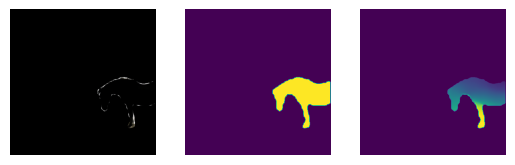

 41%|████████████████████████████▍                                         | 244/600 [00:01<00:02, 126.63it/s]

tensor(0.2146, device='cuda:0') tensor(0.5882, device='cuda:0')
tensor(0.1746, device='cuda:0') tensor(0.5883, device='cuda:0')
tensor(0.1611, device='cuda:0') tensor(0.5884, device='cuda:0')
tensor(0.1560, device='cuda:0') tensor(0.5887, device='cuda:0')
tensor(0.1535, device='cuda:0') tensor(0.5889, device='cuda:0')
tensor(0.1520, device='cuda:0') tensor(0.5889, device='cuda:0')
tensor(0.1517, device='cuda:0') tensor(0.5888, device='cuda:0')
tensor(0.1515, device='cuda:0') tensor(0.5887, device='cuda:0')
tensor(0.1516, device='cuda:0') tensor(0.5885, device='cuda:0')
tensor(0.1513, device='cuda:0') tensor(0.5885, device='cuda:0')
tensor(0.1513, device='cuda:0') tensor(0.5881, device='cuda:0')
tensor(0.1514, device='cuda:0') tensor(0.5880, device='cuda:0')
tensor(0.1513, device='cuda:0') tensor(0.5878, device='cuda:0')
tensor(0.1511, device='cuda:0') tensor(0.5876, device='cuda:0')
tensor(0.1510, device='cuda:0') tensor(0.5874, device='cuda:0')
tensor(0.1511, device='cuda:0') tensor(0

 45%|███████████████████████████████▌                                      | 270/600 [00:02<00:02, 125.61it/s]

tensor(0.1555, device='cuda:0') tensor(0.5907, device='cuda:0')
tensor(0.1567, device='cuda:0') tensor(0.6054, device='cuda:0')
tensor(0.1571, device='cuda:0') tensor(0.6533, device='cuda:0')
tensor(0.1582, device='cuda:0') tensor(0.6909, device='cuda:0')
tensor(0.1588, device='cuda:0') tensor(0.7186, device='cuda:0')
tensor(0.1600, device='cuda:0') tensor(0.7305, device='cuda:0')
tensor(0.1607, device='cuda:0') tensor(0.7331, device='cuda:0')
tensor(0.1616, device='cuda:0') tensor(0.7337, device='cuda:0')
tensor(0.1624, device='cuda:0') tensor(0.7337, device='cuda:0')
tensor(0.1636, device='cuda:0') tensor(0.7338, device='cuda:0')
tensor(0.1645, device='cuda:0') tensor(0.7334, device='cuda:0')
tensor(0.1651, device='cuda:0') tensor(0.7330, device='cuda:0')
tensor(0.1663, device='cuda:0') tensor(0.7327, device='cuda:0')
tensor(0.1668, device='cuda:0') tensor(0.7310, device='cuda:0')
tensor(0.1673, device='cuda:0') tensor(0.7281, device='cuda:0')
tensor(0.1680, device='cuda:0') tensor(0

 49%|██████████████████████████████████▌                                   | 296/600 [00:02<00:02, 122.80it/s]

tensor(0.1750, device='cuda:0') tensor(0.4181, device='cuda:0')
tensor(0.1753, device='cuda:0') tensor(0.4176, device='cuda:0')
tensor(0.1757, device='cuda:0') tensor(0.4173, device='cuda:0')
tensor(0.1764, device='cuda:0') tensor(0.4174, device='cuda:0')
tensor(0.1773, device='cuda:0') tensor(0.4165, device='cuda:0')
tensor(0.1782, device='cuda:0') tensor(0.4159, device='cuda:0')
tensor(0.1790, device='cuda:0') tensor(0.4157, device='cuda:0')
tensor(0.1803, device='cuda:0') tensor(0.4153, device='cuda:0')
tensor(0.1809, device='cuda:0') tensor(0.4150, device='cuda:0')
tensor(0.1822, device='cuda:0') tensor(0.4150, device='cuda:0')
tensor(0.1831, device='cuda:0') tensor(0.4150, device='cuda:0')
tensor(0.1843, device='cuda:0') tensor(0.4147, device='cuda:0')
tensor(0.1857, device='cuda:0') tensor(0.4142, device='cuda:0')
tensor(0.1862, device='cuda:0') tensor(0.4141, device='cuda:0')
tensor(0.1870, device='cuda:0') tensor(0.4136, device='cuda:0')
tensor(0.1878, device='cuda:0') tensor(0

 52%|████████████████████████████████████                                  | 309/600 [00:02<00:02, 121.78it/s]

tensor(0.1943, device='cuda:0') tensor(0.4113, device='cuda:0')
tensor(0.1945, device='cuda:0') tensor(0.4110, device='cuda:0')
tensor(0.1950, device='cuda:0') tensor(0.4106, device='cuda:0')
tensor(0.1958, device='cuda:0') tensor(0.4102, device='cuda:0')
tensor(0.1962, device='cuda:0') tensor(0.4101, device='cuda:0')
tensor(0.1968, device='cuda:0') tensor(0.4095, device='cuda:0')
tensor(0.1976, device='cuda:0') tensor(0.4093, device='cuda:0')
tensor(0.1979, device='cuda:0') tensor(0.4090, device='cuda:0')
tensor(0.1986, device='cuda:0') tensor(0.4087, device='cuda:0')
tensor(0.1993, device='cuda:0') tensor(0.4087, device='cuda:0')
tensor(0.2002, device='cuda:0') tensor(0.4085, device='cuda:0')
tensor(0.2009, device='cuda:0') tensor(0.4086, device='cuda:0')
tensor(0.2018, device='cuda:0') tensor(0.4082, device='cuda:0')
tensor(0.2025, device='cuda:0') tensor(0.4077, device='cuda:0')
tensor(0.2035, device='cuda:0') tensor(0.4073, device='cuda:0')
tensor(0.2044, device='cuda:0') tensor(0

 56%|███████████████████████████████████████                               | 335/600 [00:02<00:02, 120.82it/s]

tensor(0.2208, device='cuda:0') tensor(0.4057, device='cuda:0')
tensor(0.2246, device='cuda:0') tensor(0.4055, device='cuda:0')
tensor(0.2319, device='cuda:0') tensor(0.4053, device='cuda:0')
tensor(0.2439, device='cuda:0') tensor(0.4052, device='cuda:0')
tensor(0.2527, device='cuda:0') tensor(0.4049, device='cuda:0')
tensor(0.2609, device='cuda:0') tensor(0.4047, device='cuda:0')
tensor(0.2651, device='cuda:0') tensor(0.4046, device='cuda:0')
tensor(0.2670, device='cuda:0') tensor(0.4045, device='cuda:0')
tensor(0.2661, device='cuda:0') tensor(0.4044, device='cuda:0')
tensor(0.2634, device='cuda:0') tensor(0.4041, device='cuda:0')
tensor(0.2586, device='cuda:0') tensor(0.4040, device='cuda:0')
tensor(0.2516, device='cuda:0') tensor(0.4058, device='cuda:0')
tensor(0.2426, device='cuda:0') tensor(0.4068, device='cuda:0')
tensor(0.2363, device='cuda:0') tensor(0.4080, device='cuda:0')
tensor(0.2318, device='cuda:0') tensor(0.4112, device='cuda:0')
tensor(0.2296, device='cuda:0') tensor(0

 60%|██████████████████████████████████████████                            | 361/600 [00:02<00:01, 120.83it/s]

tensor(0.2262, device='cuda:0') tensor(0.4158, device='cuda:0')
tensor(0.2259, device='cuda:0') tensor(0.4154, device='cuda:0')
tensor(0.2258, device='cuda:0') tensor(0.4149, device='cuda:0')
tensor(0.2258, device='cuda:0') tensor(0.4118, device='cuda:0')
tensor(0.2258, device='cuda:0') tensor(0.4076, device='cuda:0')
tensor(0.2259, device='cuda:0') tensor(0.4072, device='cuda:0')
tensor(0.2262, device='cuda:0') tensor(0.4070, device='cuda:0')
tensor(0.2264, device='cuda:0') tensor(0.4066, device='cuda:0')
tensor(0.2263, device='cuda:0') tensor(0.4063, device='cuda:0')
tensor(0.2265, device='cuda:0') tensor(0.4062, device='cuda:0')
tensor(0.2264, device='cuda:0') tensor(0.4062, device='cuda:0')
tensor(0.2263, device='cuda:0') tensor(0.4062, device='cuda:0')
tensor(0.2263, device='cuda:0') tensor(0.4061, device='cuda:0')
tensor(0.2262, device='cuda:0') tensor(0.4065, device='cuda:0')
tensor(0.2261, device='cuda:0') tensor(0.4066, device='cuda:0')
tensor(0.2262, device='cuda:0') tensor(0

 64%|█████████████████████████████████████████████▏                        | 387/600 [00:03<00:01, 120.96it/s]

tensor(0.2252, device='cuda:0') tensor(0.4088, device='cuda:0')
tensor(0.2253, device='cuda:0') tensor(0.4088, device='cuda:0')
tensor(0.2255, device='cuda:0') tensor(0.4088, device='cuda:0')
tensor(0.2252, device='cuda:0') tensor(0.4087, device='cuda:0')
tensor(0.2253, device='cuda:0') tensor(0.4085, device='cuda:0')
tensor(0.2255, device='cuda:0') tensor(0.4087, device='cuda:0')
tensor(0.2280, device='cuda:0') tensor(0.4084, device='cuda:0')
tensor(0.2286, device='cuda:0') tensor(0.4085, device='cuda:0')
tensor(0.2328, device='cuda:0') tensor(0.4084, device='cuda:0')
tensor(0.2340, device='cuda:0') tensor(0.4082, device='cuda:0')
tensor(0.2341, device='cuda:0') tensor(0.4078, device='cuda:0')
tensor(0.2353, device='cuda:0') tensor(0.4077, device='cuda:0')
tensor(0.2353, device='cuda:0') tensor(0.4075, device='cuda:0')
tensor(0.2352, device='cuda:0') tensor(0.4075, device='cuda:0')
tensor(0.2354, device='cuda:0') tensor(0.4080, device='cuda:0')
tensor(0.2357, device='cuda:0') tensor(0

 69%|████████████████████████████████████████████████▏                     | 413/600 [00:03<00:01, 119.99it/s]

tensor(0.2354, device='cuda:0') tensor(0.4447, device='cuda:0')
tensor(0.2350, device='cuda:0') tensor(0.4642, device='cuda:0')
tensor(0.2351, device='cuda:0') tensor(0.4807, device='cuda:0')
tensor(0.2358, device='cuda:0') tensor(0.5073, device='cuda:0')
tensor(0.2362, device='cuda:0') tensor(0.5380, device='cuda:0')
tensor(0.2369, device='cuda:0') tensor(0.5873, device='cuda:0')
tensor(0.2375, device='cuda:0') tensor(0.6299, device='cuda:0')
tensor(0.2379, device='cuda:0') tensor(0.6567, device='cuda:0')
tensor(0.2382, device='cuda:0') tensor(0.6707, device='cuda:0')
tensor(0.2387, device='cuda:0') tensor(0.6829, device='cuda:0')
tensor(0.2387, device='cuda:0') tensor(0.6984, device='cuda:0')
tensor(0.2389, device='cuda:0') tensor(0.7074, device='cuda:0')
tensor(0.2390, device='cuda:0') tensor(0.7094, device='cuda:0')
tensor(0.2391, device='cuda:0') tensor(0.7106, device='cuda:0')
tensor(0.2391, device='cuda:0') tensor(0.7077, device='cuda:0')
tensor(0.2393, device='cuda:0') tensor(0

 73%|███████████████████████████████████████████████████▏                  | 439/600 [00:03<00:01, 120.75it/s]

tensor(0.2399, device='cuda:0') tensor(0.5693, device='cuda:0')
tensor(0.2399, device='cuda:0') tensor(0.5685, device='cuda:0')
tensor(0.2400, device='cuda:0') tensor(0.5678, device='cuda:0')
tensor(0.2399, device='cuda:0') tensor(0.5671, device='cuda:0')
tensor(0.2399, device='cuda:0') tensor(0.5662, device='cuda:0')
tensor(0.2400, device='cuda:0') tensor(0.5659, device='cuda:0')
tensor(0.2400, device='cuda:0') tensor(0.5652, device='cuda:0')
tensor(0.2400, device='cuda:0') tensor(0.5647, device='cuda:0')
tensor(0.2402, device='cuda:0') tensor(0.5645, device='cuda:0')
tensor(0.2400, device='cuda:0') tensor(0.5641, device='cuda:0')
tensor(0.2402, device='cuda:0') tensor(0.5635, device='cuda:0')
tensor(0.2403, device='cuda:0') tensor(0.5635, device='cuda:0')
tensor(0.2403, device='cuda:0') tensor(0.5633, device='cuda:0')
tensor(0.2404, device='cuda:0') tensor(0.5628, device='cuda:0')
tensor(0.2406, device='cuda:0') tensor(0.5624, device='cuda:0')
tensor(0.2415, device='cuda:0') tensor(0

 78%|██████████████████████████████████████████████████████▎               | 466/600 [00:03<00:01, 124.95it/s]

tensor(0.2652, device='cuda:0') tensor(0.5616, device='cuda:0')
tensor(0.2739, device='cuda:0') tensor(0.5616, device='cuda:0')
tensor(0.2819, device='cuda:0') tensor(0.5616, device='cuda:0')
tensor(0.2916, device='cuda:0') tensor(0.5617, device='cuda:0')


100%|██████████████████████████████████████████████████████████████████████| 600/600 [00:04<00:00, 126.60it/s]


/grogu/user/akirchme/art3d_sd_webui/images/horse/213.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/213.mp4


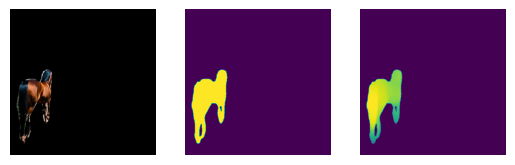

  2%|█▍                                                                     | 12/600 [00:00<00:05, 115.40it/s]

tensor(0.3078, device='cuda:0') tensor(0.4945, device='cuda:0')
tensor(0.3087, device='cuda:0') tensor(0.4945, device='cuda:0')
tensor(0.3092, device='cuda:0') tensor(0.4948, device='cuda:0')
tensor(0.3094, device='cuda:0') tensor(0.4949, device='cuda:0')
tensor(0.3099, device='cuda:0') tensor(0.4947, device='cuda:0')
tensor(0.3102, device='cuda:0') tensor(0.4949, device='cuda:0')
tensor(0.3105, device='cuda:0') tensor(0.4951, device='cuda:0')
tensor(0.3113, device='cuda:0') tensor(0.4952, device='cuda:0')
tensor(0.3115, device='cuda:0') tensor(0.4954, device='cuda:0')
tensor(0.3117, device='cuda:0') tensor(0.4956, device='cuda:0')
tensor(0.3123, device='cuda:0') tensor(0.4956, device='cuda:0')
tensor(0.3130, device='cuda:0') tensor(0.4955, device='cuda:0')
tensor(0.3137, device='cuda:0') tensor(0.4958, device='cuda:0')
tensor(0.3144, device='cuda:0') tensor(0.4961, device='cuda:0')
tensor(0.3157, device='cuda:0') tensor(0.4962, device='cuda:0')
tensor(0.3169, device='cuda:0') tensor(0

  6%|████▎                                                                  | 36/600 [00:00<00:04, 118.32it/s]

tensor(0.3315, device='cuda:0') tensor(0.4972, device='cuda:0')
tensor(0.3321, device='cuda:0') tensor(0.4973, device='cuda:0')
tensor(0.3320, device='cuda:0') tensor(0.4973, device='cuda:0')
tensor(0.3322, device='cuda:0') tensor(0.4976, device='cuda:0')
tensor(0.3310, device='cuda:0') tensor(0.4975, device='cuda:0')
tensor(0.3298, device='cuda:0') tensor(0.4974, device='cuda:0')
tensor(0.3285, device='cuda:0') tensor(0.4977, device='cuda:0')
tensor(0.3267, device='cuda:0') tensor(0.4977, device='cuda:0')
tensor(0.3249, device='cuda:0') tensor(0.4979, device='cuda:0')
tensor(0.3225, device='cuda:0') tensor(0.5066, device='cuda:0')
tensor(0.3203, device='cuda:0') tensor(0.5137, device='cuda:0')


 12%|████████▉                                                              | 75/600 [00:00<00:04, 121.63it/s]

tensor(0.2998, device='cuda:0') tensor(0.5453, device='cuda:0')
tensor(0.2992, device='cuda:0') tensor(0.5420, device='cuda:0')
tensor(0.2990, device='cuda:0') tensor(0.5405, device='cuda:0')
tensor(0.2986, device='cuda:0') tensor(0.5400, device='cuda:0')
tensor(0.2986, device='cuda:0') tensor(0.5403, device='cuda:0')
tensor(0.2980, device='cuda:0') tensor(0.5407, device='cuda:0')
tensor(0.2977, device='cuda:0') tensor(0.5413, device='cuda:0')
tensor(0.2975, device='cuda:0') tensor(0.5411, device='cuda:0')
tensor(0.2970, device='cuda:0') tensor(0.5414, device='cuda:0')
tensor(0.2969, device='cuda:0') tensor(0.5413, device='cuda:0')
tensor(0.2974, device='cuda:0') tensor(0.5412, device='cuda:0')
tensor(0.2979, device='cuda:0') tensor(0.5412, device='cuda:0')
tensor(0.2983, device='cuda:0') tensor(0.5419, device='cuda:0')
tensor(0.2985, device='cuda:0') tensor(0.5426, device='cuda:0')
tensor(0.2991, device='cuda:0') tensor(0.5426, device='cuda:0')
tensor(0.2995, device='cuda:0') tensor(0

 89%|██████████████████████████████████████████████████████████████▍       | 535/600 [00:04<00:00, 126.24it/s]

tensor(0.3639, device='cuda:0') tensor(0.5194, device='cuda:0')
tensor(0.3623, device='cuda:0') tensor(0.5141, device='cuda:0')
tensor(0.3614, device='cuda:0') tensor(0.5091, device='cuda:0')
tensor(0.3607, device='cuda:0') tensor(0.5038, device='cuda:0')
tensor(0.3603, device='cuda:0') tensor(0.4992, device='cuda:0')
tensor(0.3596, device='cuda:0') tensor(0.4945, device='cuda:0')
tensor(0.3476, device='cuda:0') tensor(0.4947, device='cuda:0')
tensor(0.3268, device='cuda:0') tensor(0.4957, device='cuda:0')
tensor(0.3145, device='cuda:0') tensor(0.4967, device='cuda:0')
tensor(0.3042, device='cuda:0') tensor(0.4976, device='cuda:0')
tensor(0.2926, device='cuda:0') tensor(0.4991, device='cuda:0')
tensor(0.2768, device='cuda:0') tensor(0.4999, device='cuda:0')
tensor(0.2604, device='cuda:0') tensor(0.5005, device='cuda:0')
tensor(0.2597, device='cuda:0') tensor(0.5009, device='cuda:0')
tensor(0.2593, device='cuda:0') tensor(0.5010, device='cuda:0')
tensor(0.2589, device='cuda:0') tensor(0

 94%|█████████████████████████████████████████████████████████████████▍    | 561/600 [00:04<00:00, 122.90it/s]

tensor(0.2599, device='cuda:0') tensor(0.5031, device='cuda:0')
tensor(0.2605, device='cuda:0') tensor(0.5052, device='cuda:0')
tensor(0.2606, device='cuda:0') tensor(0.5080, device='cuda:0')
tensor(0.2608, device='cuda:0') tensor(0.5091, device='cuda:0')
tensor(0.2609, device='cuda:0') tensor(0.5116, device='cuda:0')
tensor(0.2614, device='cuda:0') tensor(0.5131, device='cuda:0')
tensor(0.2618, device='cuda:0') tensor(0.5146, device='cuda:0')
tensor(0.2618, device='cuda:0') tensor(0.5162, device='cuda:0')
tensor(0.2622, device='cuda:0') tensor(0.5174, device='cuda:0')
tensor(0.2626, device='cuda:0') tensor(0.5313, device='cuda:0')
tensor(0.2631, device='cuda:0') tensor(0.5454, device='cuda:0')
tensor(0.2635, device='cuda:0') tensor(0.5579, device='cuda:0')
tensor(0.2647, device='cuda:0') tensor(0.5696, device='cuda:0')
tensor(0.2655, device='cuda:0') tensor(0.5779, device='cuda:0')
tensor(0.2659, device='cuda:0') tensor(0.5827, device='cuda:0')
tensor(0.2664, device='cuda:0') tensor(0

 96%|██████████████████████████████████████████████████████████████████▉   | 574/600 [00:04<00:00, 121.83it/s]

tensor(0.2720, device='cuda:0') tensor(0.5615, device='cuda:0')
tensor(0.2732, device='cuda:0') tensor(0.5531, device='cuda:0')
tensor(0.2741, device='cuda:0') tensor(0.5449, device='cuda:0')
tensor(0.2753, device='cuda:0') tensor(0.5390, device='cuda:0')
tensor(0.2766, device='cuda:0') tensor(0.5290, device='cuda:0')
tensor(0.2775, device='cuda:0') tensor(0.5176, device='cuda:0')
tensor(0.2786, device='cuda:0') tensor(0.5062, device='cuda:0')
tensor(0.2795, device='cuda:0') tensor(0.4974, device='cuda:0')
tensor(0.2800, device='cuda:0') tensor(0.4967, device='cuda:0')
tensor(0.2806, device='cuda:0') tensor(0.4967, device='cuda:0')
tensor(0.2816, device='cuda:0') tensor(0.4965, device='cuda:0')
tensor(0.2824, device='cuda:0') tensor(0.4963, device='cuda:0')
tensor(0.2830, device='cuda:0') tensor(0.4963, device='cuda:0')
tensor(0.2844, device='cuda:0') tensor(0.4962, device='cuda:0')
tensor(0.2853, device='cuda:0') tensor(0.4963, device='cuda:0')
tensor(0.2865, device='cuda:0') tensor(0

100%|██████████████████████████████████████████████████████████████████████| 600/600 [00:04<00:00, 129.64it/s]

tensor(0.2931, device='cuda:0') tensor(0.4951, device='cuda:0')
tensor(0.2934, device='cuda:0') tensor(0.4952, device='cuda:0')
tensor(0.2938, device='cuda:0') tensor(0.4952, device='cuda:0')
tensor(0.2942, device='cuda:0') tensor(0.4949, device='cuda:0')
tensor(0.2943, device='cuda:0') tensor(0.4948, device='cuda:0')
tensor(0.2957, device='cuda:0') tensor(0.4947, device='cuda:0')
tensor(0.2970, device='cuda:0') tensor(0.4948, device='cuda:0')
tensor(0.2986, device='cuda:0') tensor(0.4946, device='cuda:0')
tensor(0.3002, device='cuda:0') tensor(0.4944, device='cuda:0')
tensor(0.3016, device='cuda:0') tensor(0.4945, device='cuda:0')
tensor(0.3031, device='cuda:0') tensor(0.4944, device='cuda:0')
tensor(0.3040, device='cuda:0') tensor(0.4944, device='cuda:0')
tensor(0.3051, device='cuda:0') tensor(0.4945, device='cuda:0')
tensor(0.3061, device='cuda:0') tensor(0.4947, device='cuda:0')
tensor(0.3067, device='cuda:0') tensor(0.4946, device='cuda:0')


/grogu/user/akirchme/art3d_sd_webui/images/horse/1550.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/1550.mp4


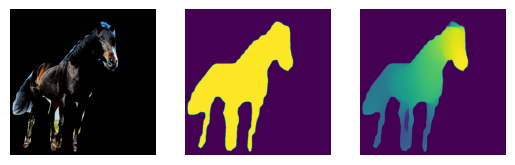

 40%|███████████████████████████▋                                          | 237/600 [00:02<00:03, 108.35it/s]

tensor(0.2920, device='cuda:0') tensor(0.5633, device='cuda:0')
tensor(0.2736, device='cuda:0') tensor(0.5639, device='cuda:0')
tensor(0.2555, device='cuda:0') tensor(0.5647, device='cuda:0')
tensor(0.2390, device='cuda:0') tensor(0.5656, device='cuda:0')
tensor(0.2239, device='cuda:0') tensor(0.5668, device='cuda:0')
tensor(0.2126, device='cuda:0') tensor(0.5687, device='cuda:0')
tensor(0.2122, device='cuda:0') tensor(0.5700, device='cuda:0')
tensor(0.2121, device='cuda:0') tensor(0.5709, device='cuda:0')
tensor(0.2124, device='cuda:0') tensor(0.5720, device='cuda:0')
tensor(0.2122, device='cuda:0') tensor(0.5739, device='cuda:0')
tensor(0.2122, device='cuda:0') tensor(0.5734, device='cuda:0')
tensor(0.2122, device='cuda:0') tensor(0.5727, device='cuda:0')
tensor(0.2120, device='cuda:0') tensor(0.5719, device='cuda:0')
tensor(0.2119, device='cuda:0') tensor(0.5713, device='cuda:0')
tensor(0.2118, device='cuda:0') tensor(0.5700, device='cuda:0')
tensor(0.2118, device='cuda:0') tensor(0

 44%|██████████████████████████████▌                                       | 262/600 [00:02<00:02, 114.95it/s]

tensor(0.2121, device='cuda:0') tensor(0.5421, device='cuda:0')
tensor(0.2123, device='cuda:0') tensor(0.5414, device='cuda:0')
tensor(0.2125, device='cuda:0') tensor(0.5430, device='cuda:0')
tensor(0.2130, device='cuda:0') tensor(0.5538, device='cuda:0')
tensor(0.2140, device='cuda:0') tensor(0.5628, device='cuda:0')
tensor(0.2148, device='cuda:0') tensor(0.5672, device='cuda:0')
tensor(0.2159, device='cuda:0') tensor(0.5743, device='cuda:0')
tensor(0.2170, device='cuda:0') tensor(0.5807, device='cuda:0')
tensor(0.2178, device='cuda:0') tensor(0.5876, device='cuda:0')
tensor(0.2187, device='cuda:0') tensor(0.5939, device='cuda:0')
tensor(0.2196, device='cuda:0') tensor(0.5966, device='cuda:0')
tensor(0.2203, device='cuda:0') tensor(0.5957, device='cuda:0')
tensor(0.2212, device='cuda:0') tensor(0.5950, device='cuda:0')
tensor(0.2224, device='cuda:0') tensor(0.5949, device='cuda:0')
tensor(0.2235, device='cuda:0') tensor(0.5948, device='cuda:0')
tensor(0.2253, device='cuda:0') tensor(0

 48%|█████████████████████████████████▎                                    | 286/600 [00:02<00:02, 117.06it/s]

tensor(0.2425, device='cuda:0') tensor(0.4580, device='cuda:0')
tensor(0.2439, device='cuda:0') tensor(0.4578, device='cuda:0')
tensor(0.2453, device='cuda:0') tensor(0.4573, device='cuda:0')
tensor(0.2463, device='cuda:0') tensor(0.4571, device='cuda:0')
tensor(0.2473, device='cuda:0') tensor(0.4571, device='cuda:0')
tensor(0.2482, device='cuda:0') tensor(0.4571, device='cuda:0')
tensor(0.2491, device='cuda:0') tensor(0.4568, device='cuda:0')
tensor(0.2498, device='cuda:0') tensor(0.4566, device='cuda:0')
tensor(0.2500, device='cuda:0') tensor(0.4566, device='cuda:0')
tensor(0.2505, device='cuda:0') tensor(0.4566, device='cuda:0')
tensor(0.2508, device='cuda:0') tensor(0.4565, device='cuda:0')
tensor(0.2511, device='cuda:0') tensor(0.4565, device='cuda:0')
tensor(0.2511, device='cuda:0') tensor(0.4564, device='cuda:0')
tensor(0.2512, device='cuda:0') tensor(0.4562, device='cuda:0')
tensor(0.2512, device='cuda:0') tensor(0.4562, device='cuda:0')
tensor(0.2513, device='cuda:0') tensor(0

 52%|████████████████████████████████████▎                                 | 311/600 [00:02<00:02, 118.55it/s]

tensor(0.2496, device='cuda:0') tensor(0.4563, device='cuda:0')
tensor(0.2499, device='cuda:0') tensor(0.4562, device='cuda:0')
tensor(0.2501, device='cuda:0') tensor(0.4561, device='cuda:0')
tensor(0.2505, device='cuda:0') tensor(0.4560, device='cuda:0')
tensor(0.2503, device='cuda:0') tensor(0.4558, device='cuda:0')
tensor(0.2502, device='cuda:0') tensor(0.4558, device='cuda:0')
tensor(0.2502, device='cuda:0') tensor(0.4558, device='cuda:0')
tensor(0.2499, device='cuda:0') tensor(0.4556, device='cuda:0')
tensor(0.2498, device='cuda:0') tensor(0.4556, device='cuda:0')
tensor(0.2494, device='cuda:0') tensor(0.4555, device='cuda:0')
tensor(0.2489, device='cuda:0') tensor(0.4554, device='cuda:0')
tensor(0.2486, device='cuda:0') tensor(0.4553, device='cuda:0')
tensor(0.2478, device='cuda:0') tensor(0.4553, device='cuda:0')
tensor(0.2473, device='cuda:0') tensor(0.4552, device='cuda:0')
tensor(0.2467, device='cuda:0') tensor(0.4552, device='cuda:0')
tensor(0.2462, device='cuda:0') tensor(0

 56%|███████████████████████████████████████                               | 335/600 [00:03<00:02, 118.44it/s]

tensor(0.2484, device='cuda:0') tensor(0.4536, device='cuda:0')
tensor(0.2491, device='cuda:0') tensor(0.4536, device='cuda:0')
tensor(0.2494, device='cuda:0') tensor(0.4537, device='cuda:0')
tensor(0.2495, device='cuda:0') tensor(0.4536, device='cuda:0')
tensor(0.2496, device='cuda:0') tensor(0.4533, device='cuda:0')
tensor(0.2496, device='cuda:0') tensor(0.4534, device='cuda:0')
tensor(0.2494, device='cuda:0') tensor(0.4534, device='cuda:0')
tensor(0.2491, device='cuda:0') tensor(0.4531, device='cuda:0')
tensor(0.2482, device='cuda:0') tensor(0.4528, device='cuda:0')
tensor(0.2472, device='cuda:0') tensor(0.4524, device='cuda:0')
tensor(0.2463, device='cuda:0') tensor(0.4524, device='cuda:0')
tensor(0.2447, device='cuda:0') tensor(0.4525, device='cuda:0')
tensor(0.2429, device='cuda:0') tensor(0.4528, device='cuda:0')
tensor(0.2408, device='cuda:0') tensor(0.4529, device='cuda:0')
tensor(0.2390, device='cuda:0') tensor(0.4530, device='cuda:0')
tensor(0.2370, device='cuda:0') tensor(0

 60%|█████████████████████████████████████████▉                            | 359/600 [00:03<00:02, 118.33it/s]

tensor(0.2204, device='cuda:0') tensor(0.5156, device='cuda:0')
tensor(0.2190, device='cuda:0') tensor(0.5188, device='cuda:0')
tensor(0.2182, device='cuda:0') tensor(0.5195, device='cuda:0')
tensor(0.2176, device='cuda:0') tensor(0.5199, device='cuda:0')
tensor(0.2174, device='cuda:0') tensor(0.5210, device='cuda:0')
tensor(0.2173, device='cuda:0') tensor(0.5222, device='cuda:0')
tensor(0.2174, device='cuda:0') tensor(0.5233, device='cuda:0')
tensor(0.2172, device='cuda:0') tensor(0.5214, device='cuda:0')
tensor(0.2170, device='cuda:0') tensor(0.5169, device='cuda:0')
tensor(0.2168, device='cuda:0') tensor(0.5115, device='cuda:0')
tensor(0.2164, device='cuda:0') tensor(0.5072, device='cuda:0')
tensor(0.2159, device='cuda:0') tensor(0.5014, device='cuda:0')
tensor(0.2157, device='cuda:0') tensor(0.4981, device='cuda:0')
tensor(0.2156, device='cuda:0') tensor(0.4962, device='cuda:0')
tensor(0.2154, device='cuda:0') tensor(0.4937, device='cuda:0')
tensor(0.2158, device='cuda:0') tensor(0

 64%|████████████████████████████████████████████▋                         | 383/600 [00:03<00:01, 118.07it/s]

tensor(0.2203, device='cuda:0') tensor(0.5188, device='cuda:0')
tensor(0.2204, device='cuda:0') tensor(0.5217, device='cuda:0')
tensor(0.2207, device='cuda:0') tensor(0.5238, device='cuda:0')
tensor(0.2215, device='cuda:0') tensor(0.5253, device='cuda:0')
tensor(0.2219, device='cuda:0') tensor(0.5254, device='cuda:0')
tensor(0.2224, device='cuda:0') tensor(0.5255, device='cuda:0')
tensor(0.2228, device='cuda:0') tensor(0.5252, device='cuda:0')
tensor(0.2229, device='cuda:0') tensor(0.5255, device='cuda:0')
tensor(0.2233, device='cuda:0') tensor(0.5249, device='cuda:0')
tensor(0.2236, device='cuda:0') tensor(0.5236, device='cuda:0')
tensor(0.2239, device='cuda:0') tensor(0.5212, device='cuda:0')
tensor(0.2245, device='cuda:0') tensor(0.5188, device='cuda:0')
tensor(0.2355, device='cuda:0') tensor(0.5174, device='cuda:0')
tensor(0.2480, device='cuda:0') tensor(0.5154, device='cuda:0')
tensor(0.2582, device='cuda:0') tensor(0.5126, device='cuda:0')
tensor(0.2681, device='cuda:0') tensor(0

100%|██████████████████████████████████████████████████████████████████████| 600/600 [00:05<00:00, 109.44it/s]


/grogu/user/akirchme/art3d_sd_webui/images/horse/1922.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/1922.mp4


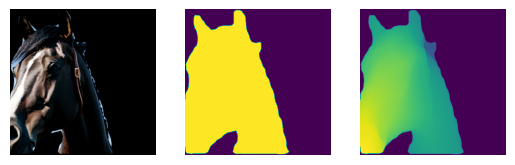

  4%|██▊                                                                    | 24/600 [00:00<00:04, 115.73it/s]

tensor(0.2046, device='cuda:0') tensor(0.4750, device='cuda:0')
tensor(0.2043, device='cuda:0') tensor(0.4749, device='cuda:0')
tensor(0.2040, device='cuda:0') tensor(0.4750, device='cuda:0')
tensor(0.2037, device='cuda:0') tensor(0.4750, device='cuda:0')
tensor(0.2034, device='cuda:0') tensor(0.4750, device='cuda:0')
tensor(0.2030, device='cuda:0') tensor(0.4751, device='cuda:0')
tensor(0.2027, device='cuda:0') tensor(0.4751, device='cuda:0')
tensor(0.2024, device='cuda:0') tensor(0.4752, device='cuda:0')
tensor(0.2020, device='cuda:0') tensor(0.4752, device='cuda:0')
tensor(0.2016, device='cuda:0') tensor(0.4754, device='cuda:0')
tensor(0.2013, device='cuda:0') tensor(0.4757, device='cuda:0')
tensor(0.2011, device='cuda:0') tensor(0.4760, device='cuda:0')
tensor(0.2009, device='cuda:0') tensor(0.4760, device='cuda:0')
tensor(0.2009, device='cuda:0') tensor(0.4760, device='cuda:0')
tensor(0.2008, device='cuda:0') tensor(0.4761, device='cuda:0')
tensor(0.2007, device='cuda:0') tensor(0

  6%|████▍                                                                  | 37/600 [00:00<00:04, 117.74it/s]

tensor(0.2015, device='cuda:0') tensor(0.4768, device='cuda:0')
tensor(0.2007, device='cuda:0') tensor(0.4769, device='cuda:0')
tensor(0.1995, device='cuda:0') tensor(0.4770, device='cuda:0')
tensor(0.1981, device='cuda:0') tensor(0.4770, device='cuda:0')
tensor(0.1966, device='cuda:0') tensor(0.4771, device='cuda:0')
tensor(0.1949, device='cuda:0') tensor(0.4771, device='cuda:0')
tensor(0.1931, device='cuda:0') tensor(0.4772, device='cuda:0')
tensor(0.1912, device='cuda:0') tensor(0.4774, device='cuda:0')
tensor(0.1896, device='cuda:0') tensor(0.4796, device='cuda:0')
tensor(0.1884, device='cuda:0') tensor(0.4847, device='cuda:0')
tensor(0.1873, device='cuda:0') tensor(0.4914, device='cuda:0')
tensor(0.1862, device='cuda:0') tensor(0.4980, device='cuda:0')
tensor(0.1849, device='cuda:0') tensor(0.5057, device='cuda:0')
tensor(0.1839, device='cuda:0') tensor(0.5179, device='cuda:0')
tensor(0.1828, device='cuda:0') tensor(0.5291, device='cuda:0')
tensor(0.1816, device='cuda:0') tensor(0

 10%|███████▍                                                               | 63/600 [00:00<00:04, 119.43it/s]

tensor(0.1744, device='cuda:0') tensor(0.5605, device='cuda:0')
tensor(0.1735, device='cuda:0') tensor(0.5531, device='cuda:0')
tensor(0.1730, device='cuda:0') tensor(0.5439, device='cuda:0')
tensor(0.1726, device='cuda:0') tensor(0.5364, device='cuda:0')
tensor(0.1720, device='cuda:0') tensor(0.5236, device='cuda:0')
tensor(0.1717, device='cuda:0') tensor(0.5109, device='cuda:0')
tensor(0.1714, device='cuda:0') tensor(0.5088, device='cuda:0')
tensor(0.1710, device='cuda:0') tensor(0.5082, device='cuda:0')
tensor(0.1706, device='cuda:0') tensor(0.5080, device='cuda:0')
tensor(0.1703, device='cuda:0') tensor(0.5089, device='cuda:0')
tensor(0.1701, device='cuda:0') tensor(0.5109, device='cuda:0')
tensor(0.1702, device='cuda:0') tensor(0.5133, device='cuda:0')
tensor(0.1705, device='cuda:0') tensor(0.5162, device='cuda:0')
tensor(0.1708, device='cuda:0') tensor(0.5190, device='cuda:0')
tensor(0.1711, device='cuda:0') tensor(0.5211, device='cuda:0')
tensor(0.1712, device='cuda:0') tensor(0

 15%|██████████▌                                                            | 89/600 [00:00<00:04, 119.85it/s]

tensor(0.1748, device='cuda:0') tensor(0.5225, device='cuda:0')
tensor(0.1754, device='cuda:0') tensor(0.5209, device='cuda:0')
tensor(0.1816, device='cuda:0') tensor(0.5194, device='cuda:0')
tensor(0.1911, device='cuda:0') tensor(0.5179, device='cuda:0')
tensor(0.2013, device='cuda:0') tensor(0.5168, device='cuda:0')
tensor(0.2169, device='cuda:0') tensor(0.5158, device='cuda:0')
tensor(0.2351, device='cuda:0') tensor(0.5152, device='cuda:0')
tensor(0.2615, device='cuda:0') tensor(0.5145, device='cuda:0')
tensor(0.2708, device='cuda:0') tensor(0.5142, device='cuda:0')
tensor(0.2727, device='cuda:0') tensor(0.5149, device='cuda:0')
tensor(0.2741, device='cuda:0') tensor(0.5166, device='cuda:0')
tensor(0.2749, device='cuda:0') tensor(0.5327, device='cuda:0')
tensor(0.2756, device='cuda:0') tensor(0.5568, device='cuda:0')
tensor(0.2763, device='cuda:0') tensor(0.5820, device='cuda:0')
tensor(0.2772, device='cuda:0') tensor(0.6069, device='cuda:0')
tensor(0.2783, device='cuda:0') tensor(0

 90%|████████████████████████████████████████████████████████████████       | 541/600 [00:07<00:00, 90.13it/s]

tensor(0.2579, device='cuda:0') tensor(0.5597, device='cuda:0')
tensor(0.2221, device='cuda:0') tensor(0.5602, device='cuda:0')
tensor(0.1930, device='cuda:0') tensor(0.5610, device='cuda:0')
tensor(0.1768, device='cuda:0') tensor(0.5615, device='cuda:0')
tensor(0.1763, device='cuda:0') tensor(0.5627, device='cuda:0')
tensor(0.1763, device='cuda:0') tensor(0.5640, device='cuda:0')
tensor(0.1764, device='cuda:0') tensor(0.5646, device='cuda:0')
tensor(0.1765, device='cuda:0') tensor(0.5655, device='cuda:0')
tensor(0.1765, device='cuda:0') tensor(0.5662, device='cuda:0')
tensor(0.1765, device='cuda:0') tensor(0.5666, device='cuda:0')
tensor(0.1764, device='cuda:0') tensor(0.5666, device='cuda:0')
tensor(0.1763, device='cuda:0') tensor(0.5670, device='cuda:0')
tensor(0.1764, device='cuda:0') tensor(0.5673, device='cuda:0')
tensor(0.1764, device='cuda:0') tensor(0.5668, device='cuda:0')
tensor(0.1765, device='cuda:0') tensor(0.5661, device='cuda:0')
tensor(0.1765, device='cuda:0') tensor(0

 94%|██████████████████████████████████████████████████████████████████    | 566/600 [00:07<00:00, 105.32it/s]

tensor(0.1782, device='cuda:0') tensor(0.5660, device='cuda:0')
tensor(0.1785, device='cuda:0') tensor(0.5826, device='cuda:0')
tensor(0.1791, device='cuda:0') tensor(0.6037, device='cuda:0')
tensor(0.1796, device='cuda:0') tensor(0.6339, device='cuda:0')
tensor(0.1800, device='cuda:0') tensor(0.6579, device='cuda:0')
tensor(0.1806, device='cuda:0') tensor(0.6744, device='cuda:0')
tensor(0.1811, device='cuda:0') tensor(0.6857, device='cuda:0')
tensor(0.1819, device='cuda:0') tensor(0.6915, device='cuda:0')
tensor(0.1829, device='cuda:0') tensor(0.6908, device='cuda:0')
tensor(0.1840, device='cuda:0') tensor(0.6900, device='cuda:0')
tensor(0.1850, device='cuda:0') tensor(0.6894, device='cuda:0')
tensor(0.1866, device='cuda:0') tensor(0.6889, device='cuda:0')
tensor(0.1885, device='cuda:0') tensor(0.6876, device='cuda:0')
tensor(0.1904, device='cuda:0') tensor(0.6789, device='cuda:0')
tensor(0.1921, device='cuda:0') tensor(0.6543, device='cuda:0')
tensor(0.1937, device='cuda:0') tensor(0

 99%|█████████████████████████████████████████████████████████████████████ | 592/600 [00:07<00:00, 114.08it/s]

tensor(0.2101, device='cuda:0') tensor(0.4764, device='cuda:0')
tensor(0.2112, device='cuda:0') tensor(0.4762, device='cuda:0')
tensor(0.2122, device='cuda:0') tensor(0.4761, device='cuda:0')
tensor(0.2128, device='cuda:0') tensor(0.4759, device='cuda:0')
tensor(0.2137, device='cuda:0') tensor(0.4759, device='cuda:0')
tensor(0.2140, device='cuda:0') tensor(0.4758, device='cuda:0')
tensor(0.2142, device='cuda:0') tensor(0.4758, device='cuda:0')
tensor(0.2143, device='cuda:0') tensor(0.4757, device='cuda:0')
tensor(0.2141, device='cuda:0') tensor(0.4755, device='cuda:0')
tensor(0.2138, device='cuda:0') tensor(0.4756, device='cuda:0')
tensor(0.2133, device='cuda:0') tensor(0.4755, device='cuda:0')
tensor(0.2126, device='cuda:0') tensor(0.4755, device='cuda:0')
tensor(0.2117, device='cuda:0') tensor(0.4754, device='cuda:0')
tensor(0.2105, device='cuda:0') tensor(0.4756, device='cuda:0')
tensor(0.2098, device='cuda:0') tensor(0.4756, device='cuda:0')
tensor(0.2093, device='cuda:0') tensor(0

100%|███████████████████████████████████████████████████████████████████████| 600/600 [00:07<00:00, 79.86it/s]


tensor(0.2053, device='cuda:0') tensor(0.4752, device='cuda:0')
tensor(0.2051, device='cuda:0') tensor(0.4751, device='cuda:0')
tensor(0.2050, device='cuda:0') tensor(0.4750, device='cuda:0')
tensor(0.2049, device='cuda:0') tensor(0.4750, device='cuda:0')
/grogu/user/akirchme/art3d_sd_webui/images/horse/1069.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/1069.mp4


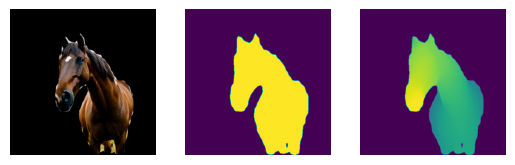

  4%|██▊                                                                    | 24/600 [00:00<00:04, 117.61it/s]

tensor(0.3253, device='cuda:0') tensor(0.4672, device='cuda:0')
tensor(0.3241, device='cuda:0') tensor(0.4672, device='cuda:0')
tensor(0.3220, device='cuda:0') tensor(0.4671, device='cuda:0')
tensor(0.3205, device='cuda:0') tensor(0.4670, device='cuda:0')
tensor(0.3194, device='cuda:0') tensor(0.4669, device='cuda:0')
tensor(0.3188, device='cuda:0') tensor(0.4668, device='cuda:0')
tensor(0.3183, device='cuda:0') tensor(0.4668, device='cuda:0')
tensor(0.3178, device='cuda:0') tensor(0.4667, device='cuda:0')
tensor(0.3175, device='cuda:0') tensor(0.4666, device='cuda:0')
tensor(0.3171, device='cuda:0') tensor(0.4666, device='cuda:0')
tensor(0.3168, device='cuda:0') tensor(0.4665, device='cuda:0')
tensor(0.3166, device='cuda:0') tensor(0.4666, device='cuda:0')
tensor(0.3163, device='cuda:0') tensor(0.4665, device='cuda:0')
tensor(0.3163, device='cuda:0') tensor(0.4664, device='cuda:0')
tensor(0.3165, device='cuda:0') tensor(0.4664, device='cuda:0')
tensor(0.3164, device='cuda:0') tensor(0

  8%|█████▋                                                                 | 48/600 [00:00<00:04, 118.97it/s]

tensor(0.3127, device='cuda:0') tensor(0.4673, device='cuda:0')
tensor(0.3121, device='cuda:0') tensor(0.4674, device='cuda:0')
tensor(0.3113, device='cuda:0') tensor(0.4673, device='cuda:0')
tensor(0.3100, device='cuda:0') tensor(0.4674, device='cuda:0')
tensor(0.3089, device='cuda:0') tensor(0.4675, device='cuda:0')
tensor(0.3079, device='cuda:0') tensor(0.4677, device='cuda:0')
tensor(0.3070, device='cuda:0') tensor(0.4680, device='cuda:0')
tensor(0.3055, device='cuda:0') tensor(0.4683, device='cuda:0')
tensor(0.3042, device='cuda:0') tensor(0.4686, device='cuda:0')
tensor(0.3030, device='cuda:0') tensor(0.4755, device='cuda:0')
tensor(0.3019, device='cuda:0') tensor(0.4865, device='cuda:0')
tensor(0.3007, device='cuda:0') tensor(0.5034, device='cuda:0')
tensor(0.2992, device='cuda:0') tensor(0.5190, device='cuda:0')
tensor(0.2981, device='cuda:0') tensor(0.5342, device='cuda:0')
tensor(0.2971, device='cuda:0') tensor(0.5494, device='cuda:0')
tensor(0.2959, device='cuda:0') tensor(0

 12%|████████▌                                                              | 72/600 [00:00<00:04, 119.22it/s]

tensor(0.2886, device='cuda:0') tensor(0.6162, device='cuda:0')
tensor(0.2879, device='cuda:0') tensor(0.6120, device='cuda:0')
tensor(0.2874, device='cuda:0') tensor(0.6034, device='cuda:0')
tensor(0.2867, device='cuda:0') tensor(0.6002, device='cuda:0')
tensor(0.2862, device='cuda:0') tensor(0.5961, device='cuda:0')
tensor(0.2858, device='cuda:0') tensor(0.5900, device='cuda:0')
tensor(0.2854, device='cuda:0') tensor(0.5839, device='cuda:0')
tensor(0.2848, device='cuda:0') tensor(0.5795, device='cuda:0')
tensor(0.2841, device='cuda:0') tensor(0.5794, device='cuda:0')
tensor(0.2835, device='cuda:0') tensor(0.5796, device='cuda:0')
tensor(0.2829, device='cuda:0') tensor(0.5798, device='cuda:0')
tensor(0.2822, device='cuda:0') tensor(0.5799, device='cuda:0')
tensor(0.2815, device='cuda:0') tensor(0.5768, device='cuda:0')
tensor(0.2811, device='cuda:0') tensor(0.5768, device='cuda:0')
tensor(0.2808, device='cuda:0') tensor(0.5770, device='cuda:0')
tensor(0.2806, device='cuda:0') tensor(0

 14%|█████████▉                                                             | 84/600 [00:00<00:04, 114.68it/s]

tensor(0.2812, device='cuda:0') tensor(0.5893, device='cuda:0')
tensor(0.2816, device='cuda:0') tensor(0.5892, device='cuda:0')
tensor(0.2823, device='cuda:0') tensor(0.5886, device='cuda:0')
tensor(0.2827, device='cuda:0') tensor(0.5875, device='cuda:0')
tensor(0.2838, device='cuda:0') tensor(0.5860, device='cuda:0')
tensor(0.2969, device='cuda:0') tensor(0.5838, device='cuda:0')


 90%|███████████████████████████████████████████████████████████████▎      | 543/600 [00:05<00:00, 107.63it/s]

tensor(0.2872, device='cuda:0') tensor(0.5546, device='cuda:0')
tensor(0.2862, device='cuda:0') tensor(0.5558, device='cuda:0')
tensor(0.2858, device='cuda:0') tensor(0.5566, device='cuda:0')
tensor(0.2855, device='cuda:0') tensor(0.5575, device='cuda:0')
tensor(0.2850, device='cuda:0') tensor(0.5580, device='cuda:0')
tensor(0.2848, device='cuda:0') tensor(0.5577, device='cuda:0')
tensor(0.2843, device='cuda:0') tensor(0.5572, device='cuda:0')
tensor(0.2837, device='cuda:0') tensor(0.5571, device='cuda:0')
tensor(0.2836, device='cuda:0') tensor(0.5568, device='cuda:0')
tensor(0.2836, device='cuda:0') tensor(0.5561, device='cuda:0')
tensor(0.2838, device='cuda:0') tensor(0.5550, device='cuda:0')
tensor(0.2839, device='cuda:0') tensor(0.5543, device='cuda:0')
tensor(0.2841, device='cuda:0') tensor(0.5532, device='cuda:0')
tensor(0.2842, device='cuda:0') tensor(0.5521, device='cuda:0')
tensor(0.2846, device='cuda:0') tensor(0.5510, device='cuda:0')
tensor(0.2851, device='cuda:0') tensor(0

 94%|██████████████████████████████████████████████████████████████████▏   | 567/600 [00:05<00:00, 107.31it/s]

tensor(0.2925, device='cuda:0') tensor(0.5563, device='cuda:0')
tensor(0.2949, device='cuda:0') tensor(0.5619, device='cuda:0')
tensor(0.2960, device='cuda:0') tensor(0.5677, device='cuda:0')
tensor(0.2965, device='cuda:0') tensor(0.5719, device='cuda:0')
tensor(0.2971, device='cuda:0') tensor(0.5780, device='cuda:0')
tensor(0.2976, device='cuda:0') tensor(0.5801, device='cuda:0')
tensor(0.2981, device='cuda:0') tensor(0.5793, device='cuda:0')
tensor(0.2986, device='cuda:0') tensor(0.5781, device='cuda:0')
tensor(0.2992, device='cuda:0') tensor(0.5772, device='cuda:0')
tensor(0.2999, device='cuda:0') tensor(0.5763, device='cuda:0')
tensor(0.3087, device='cuda:0') tensor(0.5119, device='cuda:0')
tensor(0.3097, device='cuda:0') tensor(0.5012, device='cuda:0')
tensor(0.3108, device='cuda:0') tensor(0.4911, device='cuda:0')
tensor(0.3118, device='cuda:0') tensor(0.4797, device='cuda:0')
tensor(0.3128, device='cuda:0') tensor(0.4731, device='cuda:0')
tensor(0.3141, device='cuda:0') tensor(0

 98%|████████████████████████████████████████████████████████████████████▉ | 591/600 [00:05<00:00, 112.16it/s]

tensor(0.3158, device='cuda:0') tensor(0.4721, device='cuda:0')
tensor(0.3171, device='cuda:0') tensor(0.4716, device='cuda:0')
tensor(0.3184, device='cuda:0') tensor(0.4712, device='cuda:0')
tensor(0.3193, device='cuda:0') tensor(0.4707, device='cuda:0')
tensor(0.3201, device='cuda:0') tensor(0.4705, device='cuda:0')
tensor(0.3208, device='cuda:0') tensor(0.4703, device='cuda:0')
tensor(0.3215, device='cuda:0') tensor(0.4701, device='cuda:0')
tensor(0.3219, device='cuda:0') tensor(0.4699, device='cuda:0')
tensor(0.3221, device='cuda:0') tensor(0.4697, device='cuda:0')
tensor(0.3222, device='cuda:0') tensor(0.4696, device='cuda:0')
tensor(0.3221, device='cuda:0') tensor(0.4693, device='cuda:0')
tensor(0.3221, device='cuda:0') tensor(0.4689, device='cuda:0')
tensor(0.3222, device='cuda:0') tensor(0.4687, device='cuda:0')
tensor(0.3226, device='cuda:0') tensor(0.4685, device='cuda:0')
tensor(0.3229, device='cuda:0') tensor(0.4683, device='cuda:0')
tensor(0.3232, device='cuda:0') tensor(0

100%|██████████████████████████████████████████████████████████████████████| 600/600 [00:05<00:00, 102.55it/s]


tensor(0.3259, device='cuda:0') tensor(0.4671, device='cuda:0')
tensor(0.3261, device='cuda:0') tensor(0.4671, device='cuda:0')
tensor(0.3262, device='cuda:0') tensor(0.4671, device='cuda:0')
tensor(0.3261, device='cuda:0') tensor(0.4672, device='cuda:0')
tensor(0.3260, device='cuda:0') tensor(0.4672, device='cuda:0')
tensor(0.3258, device='cuda:0') tensor(0.4671, device='cuda:0')
/grogu/user/akirchme/art3d_sd_webui/images/horse/1408.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/1408.mp4


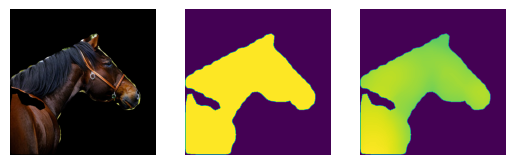

  4%|██▊                                                                    | 24/600 [00:00<00:04, 116.43it/s]

tensor(0.2705, device='cuda:0') tensor(0.4802, device='cuda:0')
tensor(0.2704, device='cuda:0') tensor(0.4801, device='cuda:0')
tensor(0.2703, device='cuda:0') tensor(0.4800, device='cuda:0')
tensor(0.2702, device='cuda:0') tensor(0.4799, device='cuda:0')
tensor(0.2701, device='cuda:0') tensor(0.4798, device='cuda:0')
tensor(0.2699, device='cuda:0') tensor(0.4798, device='cuda:0')
tensor(0.2698, device='cuda:0') tensor(0.4798, device='cuda:0')
tensor(0.2697, device='cuda:0') tensor(0.4797, device='cuda:0')
tensor(0.2696, device='cuda:0') tensor(0.4796, device='cuda:0')
tensor(0.2695, device='cuda:0') tensor(0.4796, device='cuda:0')
tensor(0.2694, device='cuda:0') tensor(0.4798, device='cuda:0')
tensor(0.2695, device='cuda:0') tensor(0.4798, device='cuda:0')
tensor(0.2699, device='cuda:0') tensor(0.4797, device='cuda:0')
tensor(0.2704, device='cuda:0') tensor(0.4797, device='cuda:0')
tensor(0.2708, device='cuda:0') tensor(0.4796, device='cuda:0')
tensor(0.2712, device='cuda:0') tensor(0

  8%|█████▋                                                                 | 48/600 [00:00<00:04, 117.99it/s]

tensor(0.2768, device='cuda:0') tensor(0.4793, device='cuda:0')
tensor(0.2766, device='cuda:0') tensor(0.4792, device='cuda:0')
tensor(0.2761, device='cuda:0') tensor(0.4792, device='cuda:0')
tensor(0.2756, device='cuda:0') tensor(0.4792, device='cuda:0')
tensor(0.2750, device='cuda:0') tensor(0.4792, device='cuda:0')
tensor(0.2743, device='cuda:0') tensor(0.4792, device='cuda:0')
tensor(0.2731, device='cuda:0') tensor(0.4792, device='cuda:0')
tensor(0.2718, device='cuda:0') tensor(0.4792, device='cuda:0')
tensor(0.2701, device='cuda:0') tensor(0.4792, device='cuda:0')
tensor(0.2686, device='cuda:0') tensor(0.4816, device='cuda:0')
tensor(0.2672, device='cuda:0') tensor(0.4883, device='cuda:0')
tensor(0.2656, device='cuda:0') tensor(0.5018, device='cuda:0')
tensor(0.2639, device='cuda:0') tensor(0.5241, device='cuda:0')
tensor(0.2624, device='cuda:0') tensor(0.5416, device='cuda:0')
tensor(0.2614, device='cuda:0') tensor(0.5528, device='cuda:0')
tensor(0.2604, device='cuda:0') tensor(0

 10%|███████                                                                | 60/600 [00:00<00:04, 118.26it/s]

tensor(0.2564, device='cuda:0') tensor(0.5770, device='cuda:0')
tensor(0.2564, device='cuda:0') tensor(0.5711, device='cuda:0')
tensor(0.2564, device='cuda:0') tensor(0.5562, device='cuda:0')
tensor(0.2564, device='cuda:0') tensor(0.5364, device='cuda:0')
tensor(0.2564, device='cuda:0') tensor(0.5288, device='cuda:0')
tensor(0.2564, device='cuda:0') tensor(0.5226, device='cuda:0')
tensor(0.2564, device='cuda:0') tensor(0.5183, device='cuda:0')
tensor(0.2566, device='cuda:0') tensor(0.5148, device='cuda:0')
tensor(0.2567, device='cuda:0') tensor(0.5142, device='cuda:0')
tensor(0.2568, device='cuda:0') tensor(0.5145, device='cuda:0')
tensor(0.2566, device='cuda:0') tensor(0.5148, device='cuda:0')
tensor(0.2566, device='cuda:0') tensor(0.5154, device='cuda:0')
tensor(0.2566, device='cuda:0') tensor(0.5162, device='cuda:0')
tensor(0.2567, device='cuda:0') tensor(0.5172, device='cuda:0')
tensor(0.2567, device='cuda:0') tensor(0.5180, device='cuda:0')
tensor(0.2568, device='cuda:0') tensor(0

 14%|█████████▉                                                             | 84/600 [00:00<00:04, 117.55it/s]

tensor(0.2589, device='cuda:0') tensor(0.5223, device='cuda:0')
tensor(0.2591, device='cuda:0') tensor(0.5219, device='cuda:0')
tensor(0.2595, device='cuda:0') tensor(0.5212, device='cuda:0')
tensor(0.2597, device='cuda:0') tensor(0.5202, device='cuda:0')
tensor(0.2603, device='cuda:0') tensor(0.5195, device='cuda:0')
tensor(0.2662, device='cuda:0') tensor(0.5187, device='cuda:0')
tensor(0.2862, device='cuda:0') tensor(0.5177, device='cuda:0')
tensor(0.3166, device='cuda:0') tensor(0.5167, device='cuda:0')
tensor(0.3336, device='cuda:0') tensor(0.5157, device='cuda:0')
tensor(0.3462, device='cuda:0') tensor(0.5149, device='cuda:0')
tensor(0.3560, device='cuda:0') tensor(0.5144, device='cuda:0')
tensor(0.3603, device='cuda:0') tensor(0.5144, device='cuda:0')


 89%|███████████████████████████████████████████████████████████████▍       | 536/600 [00:06<00:00, 92.30it/s]

tensor(0.2626, device='cuda:0') tensor(0.5915, device='cuda:0')
tensor(0.2601, device='cuda:0') tensor(0.5925, device='cuda:0')
tensor(0.2601, device='cuda:0') tensor(0.5936, device='cuda:0')
tensor(0.2600, device='cuda:0') tensor(0.5944, device='cuda:0')
tensor(0.2598, device='cuda:0') tensor(0.5953, device='cuda:0')
tensor(0.2596, device='cuda:0') tensor(0.5963, device='cuda:0')
tensor(0.2595, device='cuda:0') tensor(0.5971, device='cuda:0')
tensor(0.2593, device='cuda:0') tensor(0.5974, device='cuda:0')
tensor(0.2592, device='cuda:0') tensor(0.5973, device='cuda:0')
tensor(0.2592, device='cuda:0') tensor(0.5972, device='cuda:0')
tensor(0.2591, device='cuda:0') tensor(0.5969, device='cuda:0')
tensor(0.2591, device='cuda:0') tensor(0.5962, device='cuda:0')
tensor(0.2591, device='cuda:0') tensor(0.5953, device='cuda:0')
tensor(0.2591, device='cuda:0') tensor(0.5945, device='cuda:0')
tensor(0.2591, device='cuda:0') tensor(0.5935, device='cuda:0')
tensor(0.2590, device='cuda:0') tensor(0

 94%|█████████████████████████████████████████████████████████████████▍    | 561/600 [00:06<00:00, 106.13it/s]

tensor(0.2601, device='cuda:0') tensor(0.6162, device='cuda:0')
tensor(0.2604, device='cuda:0') tensor(0.6321, device='cuda:0')
tensor(0.2606, device='cuda:0') tensor(0.6569, device='cuda:0')
tensor(0.2609, device='cuda:0') tensor(0.6816, device='cuda:0')
tensor(0.2612, device='cuda:0') tensor(0.6971, device='cuda:0')
tensor(0.2615, device='cuda:0') tensor(0.6982, device='cuda:0')
tensor(0.2618, device='cuda:0') tensor(0.6980, device='cuda:0')
tensor(0.2621, device='cuda:0') tensor(0.6980, device='cuda:0')
tensor(0.2624, device='cuda:0') tensor(0.6978, device='cuda:0')
tensor(0.2630, device='cuda:0') tensor(0.6975, device='cuda:0')
tensor(0.2639, device='cuda:0') tensor(0.6907, device='cuda:0')
tensor(0.2648, device='cuda:0') tensor(0.6774, device='cuda:0')
tensor(0.2657, device='cuda:0') tensor(0.6687, device='cuda:0')
tensor(0.2664, device='cuda:0') tensor(0.6586, device='cuda:0')
tensor(0.2671, device='cuda:0') tensor(0.6452, device='cuda:0')
tensor(0.2677, device='cuda:0') tensor(0

100%|█████████████████████████████████████████████████████████████████████▊| 598/600 [00:06<00:00, 114.86it/s]

tensor(0.2729, device='cuda:0') tensor(0.4821, device='cuda:0')
tensor(0.2732, device='cuda:0') tensor(0.4821, device='cuda:0')
tensor(0.2733, device='cuda:0') tensor(0.4820, device='cuda:0')
tensor(0.2734, device='cuda:0') tensor(0.4820, device='cuda:0')
tensor(0.2734, device='cuda:0') tensor(0.4820, device='cuda:0')
tensor(0.2735, device='cuda:0') tensor(0.4819, device='cuda:0')
tensor(0.2735, device='cuda:0') tensor(0.4818, device='cuda:0')
tensor(0.2734, device='cuda:0') tensor(0.4817, device='cuda:0')
tensor(0.2732, device='cuda:0') tensor(0.4816, device='cuda:0')
tensor(0.2730, device='cuda:0') tensor(0.4816, device='cuda:0')
tensor(0.2726, device='cuda:0') tensor(0.4815, device='cuda:0')
tensor(0.2724, device='cuda:0') tensor(0.4814, device='cuda:0')
tensor(0.2722, device='cuda:0') tensor(0.4813, device='cuda:0')
tensor(0.2716, device='cuda:0') tensor(0.4812, device='cuda:0')
tensor(0.2713, device='cuda:0') tensor(0.4810, device='cuda:0')
tensor(0.2710, device='cuda:0') tensor(0

100%|███████████████████████████████████████████████████████████████████████| 600/600 [00:06<00:00, 91.29it/s]


tensor(0.2708, device='cuda:0') tensor(0.4803, device='cuda:0')
tensor(0.2707, device='cuda:0') tensor(0.4802, device='cuda:0')
/grogu/user/akirchme/art3d_sd_webui/images/horse/1981.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/1981.mp4


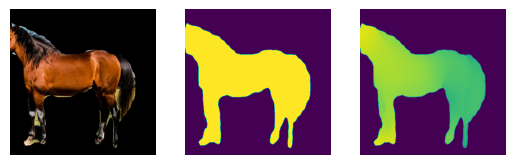

  4%|██▊                                                                    | 24/600 [00:00<00:04, 116.70it/s]

tensor(0.1864, device='cuda:0') tensor(0.4299, device='cuda:0')
tensor(0.1865, device='cuda:0') tensor(0.4299, device='cuda:0')
tensor(0.1865, device='cuda:0') tensor(0.4300, device='cuda:0')
tensor(0.1865, device='cuda:0') tensor(0.4299, device='cuda:0')
tensor(0.1866, device='cuda:0') tensor(0.4299, device='cuda:0')
tensor(0.1867, device='cuda:0') tensor(0.4300, device='cuda:0')
tensor(0.1867, device='cuda:0') tensor(0.4300, device='cuda:0')
tensor(0.1868, device='cuda:0') tensor(0.4300, device='cuda:0')
tensor(0.1869, device='cuda:0') tensor(0.4300, device='cuda:0')
tensor(0.1869, device='cuda:0') tensor(0.4300, device='cuda:0')
tensor(0.1869, device='cuda:0') tensor(0.4300, device='cuda:0')
tensor(0.1870, device='cuda:0') tensor(0.4300, device='cuda:0')
tensor(0.1871, device='cuda:0') tensor(0.4300, device='cuda:0')
tensor(0.1871, device='cuda:0') tensor(0.4300, device='cuda:0')
tensor(0.1873, device='cuda:0') tensor(0.4300, device='cuda:0')
tensor(0.1873, device='cuda:0') tensor(0

  6%|████▎                                                                  | 36/600 [00:00<00:04, 118.04it/s]

tensor(0.1883, device='cuda:0') tensor(0.4300, device='cuda:0')
tensor(0.1883, device='cuda:0') tensor(0.4301, device='cuda:0')
tensor(0.1884, device='cuda:0') tensor(0.4300, device='cuda:0')
tensor(0.1885, device='cuda:0') tensor(0.4300, device='cuda:0')
tensor(0.1886, device='cuda:0') tensor(0.4299, device='cuda:0')
tensor(0.1886, device='cuda:0') tensor(0.4299, device='cuda:0')
tensor(0.1886, device='cuda:0') tensor(0.4298, device='cuda:0')
tensor(0.1885, device='cuda:0') tensor(0.4299, device='cuda:0')
tensor(0.1884, device='cuda:0') tensor(0.4301, device='cuda:0')
tensor(0.1883, device='cuda:0') tensor(0.4791, device='cuda:0')
tensor(0.1882, device='cuda:0') tensor(0.5499, device='cuda:0')
tensor(0.1881, device='cuda:0') tensor(0.5760, device='cuda:0')
tensor(0.1880, device='cuda:0') tensor(0.5989, device='cuda:0')
tensor(0.1880, device='cuda:0') tensor(0.6137, device='cuda:0')
tensor(0.1879, device='cuda:0') tensor(0.6249, device='cuda:0')
tensor(0.1878, device='cuda:0') tensor(0

 10%|███████▎                                                               | 62/600 [00:00<00:04, 119.28it/s]

tensor(0.1874, device='cuda:0') tensor(0.5366, device='cuda:0')
tensor(0.1873, device='cuda:0') tensor(0.5207, device='cuda:0')
tensor(0.1873, device='cuda:0') tensor(0.5108, device='cuda:0')
tensor(0.1873, device='cuda:0') tensor(0.5041, device='cuda:0')
tensor(0.1873, device='cuda:0') tensor(0.5025, device='cuda:0')
tensor(0.1872, device='cuda:0') tensor(0.5015, device='cuda:0')
tensor(0.1872, device='cuda:0') tensor(0.5013, device='cuda:0')
tensor(0.1872, device='cuda:0') tensor(0.5012, device='cuda:0')
tensor(0.1871, device='cuda:0') tensor(0.5013, device='cuda:0')
tensor(0.1870, device='cuda:0') tensor(0.5013, device='cuda:0')
tensor(0.1870, device='cuda:0') tensor(0.5014, device='cuda:0')
tensor(0.1870, device='cuda:0') tensor(0.5013, device='cuda:0')
tensor(0.1869, device='cuda:0') tensor(0.5014, device='cuda:0')
tensor(0.1868, device='cuda:0') tensor(0.5015, device='cuda:0')
tensor(0.1868, device='cuda:0') tensor(0.5016, device='cuda:0')
tensor(0.1868, device='cuda:0') tensor(0

 14%|██████████▏                                                            | 86/600 [00:00<00:04, 115.11it/s]

tensor(0.1868, device='cuda:0') tensor(0.5019, device='cuda:0')
tensor(0.1868, device='cuda:0') tensor(0.5019, device='cuda:0')
tensor(0.1936, device='cuda:0') tensor(0.5020, device='cuda:0')
tensor(0.2972, device='cuda:0') tensor(0.5021, device='cuda:0')
tensor(0.3381, device='cuda:0') tensor(0.5021, device='cuda:0')
tensor(0.3659, device='cuda:0') tensor(0.5020, device='cuda:0')
tensor(0.3825, device='cuda:0') tensor(0.5021, device='cuda:0')
tensor(0.3894, device='cuda:0') tensor(0.5019, device='cuda:0')
tensor(0.3920, device='cuda:0') tensor(0.5020, device='cuda:0')
tensor(0.3928, device='cuda:0') tensor(0.5022, device='cuda:0')


 90%|███████████████████████████████████████████████████████████████▌       | 537/600 [00:07<00:00, 99.38it/s]

tensor(0.2420, device='cuda:0') tensor(0.5613, device='cuda:0')
tensor(0.1854, device='cuda:0') tensor(0.5612, device='cuda:0')
tensor(0.1822, device='cuda:0') tensor(0.5611, device='cuda:0')
tensor(0.1822, device='cuda:0') tensor(0.5610, device='cuda:0')
tensor(0.1821, device='cuda:0') tensor(0.5610, device='cuda:0')
tensor(0.1821, device='cuda:0') tensor(0.5611, device='cuda:0')
tensor(0.1821, device='cuda:0') tensor(0.5612, device='cuda:0')
tensor(0.1821, device='cuda:0') tensor(0.5612, device='cuda:0')
tensor(0.1822, device='cuda:0') tensor(0.5613, device='cuda:0')
tensor(0.1822, device='cuda:0') tensor(0.5613, device='cuda:0')
tensor(0.1823, device='cuda:0') tensor(0.5613, device='cuda:0')
tensor(0.1824, device='cuda:0') tensor(0.5613, device='cuda:0')
tensor(0.1824, device='cuda:0') tensor(0.5614, device='cuda:0')
tensor(0.1825, device='cuda:0') tensor(0.5612, device='cuda:0')
tensor(0.1825, device='cuda:0') tensor(0.5612, device='cuda:0')
tensor(0.1826, device='cuda:0') tensor(0

 94%|█████████████████████████████████████████████████████████████████▌    | 562/600 [00:07<00:00, 109.96it/s]

tensor(0.1834, device='cuda:0') tensor(0.5663, device='cuda:0')
tensor(0.1836, device='cuda:0') tensor(0.5842, device='cuda:0')
tensor(0.1837, device='cuda:0') tensor(0.6115, device='cuda:0')
tensor(0.1838, device='cuda:0') tensor(0.6304, device='cuda:0')
tensor(0.1838, device='cuda:0') tensor(0.6444, device='cuda:0')
tensor(0.1840, device='cuda:0') tensor(0.6565, device='cuda:0')
tensor(0.1841, device='cuda:0') tensor(0.6572, device='cuda:0')
tensor(0.1842, device='cuda:0') tensor(0.6572, device='cuda:0')
tensor(0.1842, device='cuda:0') tensor(0.6572, device='cuda:0')
tensor(0.1844, device='cuda:0') tensor(0.6571, device='cuda:0')
tensor(0.1845, device='cuda:0') tensor(0.6571, device='cuda:0')
tensor(0.1847, device='cuda:0') tensor(0.6568, device='cuda:0')
tensor(0.1847, device='cuda:0') tensor(0.6552, device='cuda:0')
tensor(0.1848, device='cuda:0') tensor(0.6514, device='cuda:0')
tensor(0.1849, device='cuda:0') tensor(0.6457, device='cuda:0')
tensor(0.1850, device='cuda:0') tensor(0

 98%|████████████████████████████████████████████████████████████████████▍ | 587/600 [00:07<00:00, 115.12it/s]

tensor(0.1856, device='cuda:0') tensor(0.4289, device='cuda:0')
tensor(0.1857, device='cuda:0') tensor(0.4290, device='cuda:0')
tensor(0.1858, device='cuda:0') tensor(0.4290, device='cuda:0')
tensor(0.1859, device='cuda:0') tensor(0.4290, device='cuda:0')
tensor(0.1858, device='cuda:0') tensor(0.4291, device='cuda:0')
tensor(0.1860, device='cuda:0') tensor(0.4291, device='cuda:0')
tensor(0.1860, device='cuda:0') tensor(0.4292, device='cuda:0')
tensor(0.1860, device='cuda:0') tensor(0.4293, device='cuda:0')
tensor(0.1860, device='cuda:0') tensor(0.4294, device='cuda:0')
tensor(0.1860, device='cuda:0') tensor(0.4295, device='cuda:0')
tensor(0.1860, device='cuda:0') tensor(0.4296, device='cuda:0')
tensor(0.1860, device='cuda:0') tensor(0.4297, device='cuda:0')
tensor(0.1860, device='cuda:0') tensor(0.4296, device='cuda:0')
tensor(0.1861, device='cuda:0') tensor(0.4296, device='cuda:0')
tensor(0.1861, device='cuda:0') tensor(0.4297, device='cuda:0')
tensor(0.1861, device='cuda:0') tensor(0

100%|███████████████████████████████████████████████████████████████████████| 600/600 [00:07<00:00, 79.65it/s]


tensor(0.1864, device='cuda:0') tensor(0.4299, device='cuda:0')
tensor(0.1864, device='cuda:0') tensor(0.4299, device='cuda:0')
/grogu/user/akirchme/art3d_sd_webui/images/horse/965.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/965.mp4


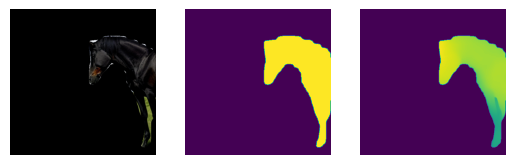

 10%|███████▏                                                               | 61/600 [00:00<00:04, 119.09it/s]

tensor(0.2996, device='cuda:0') tensor(0.6220, device='cuda:0')
tensor(0.2970, device='cuda:0') tensor(0.6111, device='cuda:0')
tensor(0.2945, device='cuda:0') tensor(0.6045, device='cuda:0')
tensor(0.2920, device='cuda:0') tensor(0.6003, device='cuda:0')
tensor(0.2887, device='cuda:0') tensor(0.5967, device='cuda:0')
tensor(0.2839, device='cuda:0') tensor(0.5891, device='cuda:0')
tensor(0.2782, device='cuda:0') tensor(0.5755, device='cuda:0')
tensor(0.2738, device='cuda:0') tensor(0.5656, device='cuda:0')
tensor(0.2714, device='cuda:0') tensor(0.5624, device='cuda:0')
tensor(0.2699, device='cuda:0') tensor(0.5622, device='cuda:0')
tensor(0.2688, device='cuda:0') tensor(0.5624, device='cuda:0')
tensor(0.2679, device='cuda:0') tensor(0.5625, device='cuda:0')
tensor(0.2669, device='cuda:0') tensor(0.5627, device='cuda:0')
tensor(0.2664, device='cuda:0') tensor(0.5630, device='cuda:0')
tensor(0.2660, device='cuda:0') tensor(0.5635, device='cuda:0')
tensor(0.2656, device='cuda:0') tensor(0

 14%|██████████                                                             | 85/600 [00:00<00:04, 119.31it/s]

tensor(0.5666, device='cuda:0')
tensor(0.2645, device='cuda:0') tensor(0.5664, device='cuda:0')
tensor(0.2647, device='cuda:0') tensor(0.5659, device='cuda:0')
tensor(0.2649, device='cuda:0') tensor(0.5652, device='cuda:0')
tensor(0.2649, device='cuda:0') tensor(0.5641, device='cuda:0')
tensor(0.2680, device='cuda:0') tensor(0.5629, device='cuda:0')
tensor(0.2871, device='cuda:0') tensor(0.5619, device='cuda:0')
tensor(0.2952, device='cuda:0') tensor(0.5613, device='cuda:0')


 46%|████████████████████████████████▌                                     | 279/600 [00:02<00:02, 122.43it/s]

tensor(0.3595, device='cuda:0') tensor(0.5197, device='cuda:0')
tensor(0.3600, device='cuda:0') tensor(0.5133, device='cuda:0')
tensor(0.3606, device='cuda:0') tensor(0.5055, device='cuda:0')
tensor(0.3612, device='cuda:0') tensor(0.4937, device='cuda:0')
tensor(0.3617, device='cuda:0') tensor(0.4935, device='cuda:0')
tensor(0.3622, device='cuda:0') tensor(0.4932, device='cuda:0')
tensor(0.3621, device='cuda:0') tensor(0.4933, device='cuda:0')
tensor(0.3624, device='cuda:0') tensor(0.4934, device='cuda:0')
tensor(0.3625, device='cuda:0') tensor(0.4934, device='cuda:0')
tensor(0.3623, device='cuda:0') tensor(0.4934, device='cuda:0')
tensor(0.3621, device='cuda:0') tensor(0.4933, device='cuda:0')
tensor(0.3617, device='cuda:0') tensor(0.4933, device='cuda:0')
tensor(0.3612, device='cuda:0') tensor(0.4932, device='cuda:0')
tensor(0.3609, device='cuda:0') tensor(0.4932, device='cuda:0')
tensor(0.3604, device='cuda:0') tensor(0.4932, device='cuda:0')
tensor(0.3601, device='cuda:0') tensor(0

 51%|███████████████████████████████████▌                                  | 305/600 [00:02<00:02, 120.24it/s]

tensor(0.3587, device='cuda:0') tensor(0.4930, device='cuda:0')
tensor(0.3589, device='cuda:0') tensor(0.4930, device='cuda:0')
tensor(0.3588, device='cuda:0') tensor(0.4931, device='cuda:0')
tensor(0.3587, device='cuda:0') tensor(0.4931, device='cuda:0')
tensor(0.3589, device='cuda:0') tensor(0.4931, device='cuda:0')
tensor(0.3591, device='cuda:0') tensor(0.4930, device='cuda:0')
tensor(0.3594, device='cuda:0') tensor(0.4930, device='cuda:0')
tensor(0.3595, device='cuda:0') tensor(0.4931, device='cuda:0')
tensor(0.3596, device='cuda:0') tensor(0.4931, device='cuda:0')
tensor(0.3597, device='cuda:0') tensor(0.4930, device='cuda:0')
tensor(0.3599, device='cuda:0') tensor(0.4932, device='cuda:0')
tensor(0.3604, device='cuda:0') tensor(0.4931, device='cuda:0')
tensor(0.3607, device='cuda:0') tensor(0.4931, device='cuda:0')
tensor(0.3606, device='cuda:0') tensor(0.4931, device='cuda:0')
tensor(0.3608, device='cuda:0') tensor(0.4930, device='cuda:0')
tensor(0.3610, device='cuda:0') tensor(0

 55%|██████████████████████████████████████▌                               | 330/600 [00:02<00:02, 119.42it/s]

tensor(0.3616, device='cuda:0') tensor(0.4933, device='cuda:0')
tensor(0.3625, device='cuda:0') tensor(0.4930, device='cuda:0')
tensor(0.3630, device='cuda:0') tensor(0.4931, device='cuda:0')
tensor(0.3635, device='cuda:0') tensor(0.4930, device='cuda:0')
tensor(0.3641, device='cuda:0') tensor(0.4931, device='cuda:0')
tensor(0.3644, device='cuda:0') tensor(0.4931, device='cuda:0')
tensor(0.3646, device='cuda:0') tensor(0.4933, device='cuda:0')
tensor(0.3646, device='cuda:0') tensor(0.4934, device='cuda:0')
tensor(0.3649, device='cuda:0') tensor(0.4934, device='cuda:0')
tensor(0.3652, device='cuda:0') tensor(0.4935, device='cuda:0')
tensor(0.3656, device='cuda:0') tensor(0.4935, device='cuda:0')
tensor(0.3662, device='cuda:0') tensor(0.4936, device='cuda:0')
tensor(0.3665, device='cuda:0') tensor(0.4937, device='cuda:0')
tensor(0.3666, device='cuda:0') tensor(0.4937, device='cuda:0')
tensor(0.3666, device='cuda:0') tensor(0.4939, device='cuda:0')
tensor(0.3665, device='cuda:0') tensor(0

 59%|█████████████████████████████████████████▌                            | 356/600 [00:02<00:02, 120.70it/s]

tensor(0.3608, device='cuda:0') tensor(0.5163, device='cuda:0')
tensor(0.3518, device='cuda:0') tensor(0.5167, device='cuda:0')
tensor(0.3515, device='cuda:0') tensor(0.5119, device='cuda:0')
tensor(0.3512, device='cuda:0') tensor(0.5105, device='cuda:0')
tensor(0.3510, device='cuda:0') tensor(0.5101, device='cuda:0')
tensor(0.3508, device='cuda:0') tensor(0.5100, device='cuda:0')
tensor(0.3506, device='cuda:0') tensor(0.5099, device='cuda:0')
tensor(0.3508, device='cuda:0') tensor(0.5098, device='cuda:0')
tensor(0.3506, device='cuda:0') tensor(0.5101, device='cuda:0')
tensor(0.3506, device='cuda:0') tensor(0.5097, device='cuda:0')


 64%|████████████████████████████████████████████▌                         | 382/600 [00:03<00:01, 119.71it/s]

tensor(0.3507, device='cuda:0') tensor(0.5097, device='cuda:0')
tensor(0.3505, device='cuda:0') tensor(0.5097, device='cuda:0')
tensor(0.3506, device='cuda:0') tensor(0.5096, device='cuda:0')
tensor(0.3508, device='cuda:0') tensor(0.5097, device='cuda:0')
tensor(0.3506, device='cuda:0') tensor(0.5095, device='cuda:0')
tensor(0.3505, device='cuda:0') tensor(0.5095, device='cuda:0')
tensor(0.3504, device='cuda:0') tensor(0.5093, device='cuda:0')
tensor(0.3506, device='cuda:0') tensor(0.5093, device='cuda:0')
tensor(0.3506, device='cuda:0') tensor(0.5094, device='cuda:0')
tensor(0.3503, device='cuda:0') tensor(0.5094, device='cuda:0')
tensor(0.3501, device='cuda:0') tensor(0.5095, device='cuda:0')
tensor(0.3500, device='cuda:0') tensor(0.5096, device='cuda:0')
tensor(0.3499, device='cuda:0') tensor(0.5097, device='cuda:0')
tensor(0.3498, device='cuda:0') tensor(0.5096, device='cuda:0')
tensor(0.3509, device='cuda:0') tensor(0.5092, device='cuda:0')
tensor(0.3571, device='cuda:0') tensor(0

 91%|███████████████████████████████████████████████████████████████▊      | 547/600 [00:04<00:00, 118.79it/s]

tensor(0.2903, device='cuda:0') tensor(0.5305, device='cuda:0')
tensor(0.2642, device='cuda:0') tensor(0.5315, device='cuda:0')
tensor(0.2617, device='cuda:0') tensor(0.5323, device='cuda:0')
tensor(0.2618, device='cuda:0') tensor(0.5330, device='cuda:0')
tensor(0.2616, device='cuda:0') tensor(0.5332, device='cuda:0')
tensor(0.2613, device='cuda:0') tensor(0.5334, device='cuda:0')
tensor(0.2612, device='cuda:0') tensor(0.5334, device='cuda:0')
tensor(0.2612, device='cuda:0') tensor(0.5335, device='cuda:0')
tensor(0.2612, device='cuda:0') tensor(0.5337, device='cuda:0')
tensor(0.2611, device='cuda:0') tensor(0.5343, device='cuda:0')
tensor(0.2611, device='cuda:0') tensor(0.5348, device='cuda:0')
tensor(0.2610, device='cuda:0') tensor(0.5349, device='cuda:0')
tensor(0.2609, device='cuda:0') tensor(0.5350, device='cuda:0')
tensor(0.2609, device='cuda:0') tensor(0.5354, device='cuda:0')
tensor(0.2607, device='cuda:0') tensor(0.5355, device='cuda:0')
tensor(0.2606, device='cuda:0') tensor(0

 95%|██████████████████████████████████████████████████████████████████▌   | 571/600 [00:04<00:00, 118.97it/s]

tensor(0.2620, device='cuda:0') tensor(0.6095, device='cuda:0')
tensor(0.2623, device='cuda:0') tensor(0.6238, device='cuda:0')
tensor(0.2625, device='cuda:0') tensor(0.6341, device='cuda:0')
tensor(0.2628, device='cuda:0') tensor(0.6441, device='cuda:0')
tensor(0.2629, device='cuda:0') tensor(0.6499, device='cuda:0')
tensor(0.2634, device='cuda:0') tensor(0.6622, device='cuda:0')
tensor(0.2639, device='cuda:0') tensor(0.6610, device='cuda:0')
tensor(0.2645, device='cuda:0') tensor(0.6598, device='cuda:0')
tensor(0.2653, device='cuda:0') tensor(0.6592, device='cuda:0')
tensor(0.2660, device='cuda:0') tensor(0.6587, device='cuda:0')
tensor(0.2665, device='cuda:0') tensor(0.6581, device='cuda:0')
tensor(0.2672, device='cuda:0') tensor(0.6559, device='cuda:0')
tensor(0.2681, device='cuda:0') tensor(0.6504, device='cuda:0')
tensor(0.2692, device='cuda:0') tensor(0.6379, device='cuda:0')
tensor(0.2700, device='cuda:0') tensor(0.6197, device='cuda:0')
tensor(0.2708, device='cuda:0') tensor(0

 99%|█████████████████████████████████████████████████████████████████████▌| 596/600 [00:04<00:00, 120.14it/s]

tensor(0.2775, device='cuda:0') tensor(0.5409, device='cuda:0')
tensor(0.2780, device='cuda:0') tensor(0.5408, device='cuda:0')
tensor(0.2785, device='cuda:0') tensor(0.5405, device='cuda:0')
tensor(0.2788, device='cuda:0') tensor(0.5405, device='cuda:0')
tensor(0.2793, device='cuda:0') tensor(0.5404, device='cuda:0')
tensor(0.2797, device='cuda:0') tensor(0.5401, device='cuda:0')
tensor(0.2799, device='cuda:0') tensor(0.5400, device='cuda:0')
tensor(0.2800, device='cuda:0') tensor(0.5401, device='cuda:0')
tensor(0.2804, device='cuda:0') tensor(0.5399, device='cuda:0')
tensor(0.2808, device='cuda:0') tensor(0.5399, device='cuda:0')
tensor(0.2811, device='cuda:0') tensor(0.5399, device='cuda:0')
tensor(0.2815, device='cuda:0') tensor(0.5399, device='cuda:0')
tensor(0.2818, device='cuda:0') tensor(0.5398, device='cuda:0')
tensor(0.2823, device='cuda:0') tensor(0.5399, device='cuda:0')
tensor(0.2828, device='cuda:0') tensor(0.5399, device='cuda:0')
tensor(0.2833, device='cuda:0') tensor(0

100%|██████████████████████████████████████████████████████████████████████| 600/600 [00:04<00:00, 120.19it/s]


/grogu/user/akirchme/art3d_sd_webui/images/horse/517.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/517.mp4


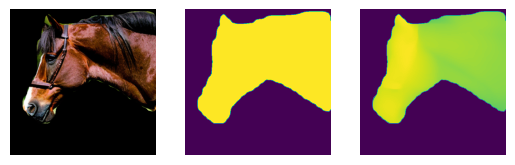

  4%|██▋                                                                    | 23/600 [00:00<00:05, 113.16it/s]

tensor(0.2563, device='cuda:0') tensor(0.5070, device='cuda:0')
tensor(0.2562, device='cuda:0') tensor(0.5070, device='cuda:0')
tensor(0.2561, device='cuda:0') tensor(0.5071, device='cuda:0')
tensor(0.2560, device='cuda:0') tensor(0.5071, device='cuda:0')
tensor(0.2559, device='cuda:0') tensor(0.5072, device='cuda:0')
tensor(0.2557, device='cuda:0') tensor(0.5072, device='cuda:0')
tensor(0.2555, device='cuda:0') tensor(0.5072, device='cuda:0')
tensor(0.2552, device='cuda:0') tensor(0.5072, device='cuda:0')
tensor(0.2549, device='cuda:0') tensor(0.5072, device='cuda:0')
tensor(0.2546, device='cuda:0') tensor(0.5072, device='cuda:0')
tensor(0.2543, device='cuda:0') tensor(0.5072, device='cuda:0')
tensor(0.2541, device='cuda:0') tensor(0.5072, device='cuda:0')
tensor(0.2541, device='cuda:0') tensor(0.5071, device='cuda:0')
tensor(0.2540, device='cuda:0') tensor(0.5070, device='cuda:0')
tensor(0.2541, device='cuda:0') tensor(0.5070, device='cuda:0')
tensor(0.2539, device='cuda:0') tensor(0

  8%|█████▌                                                                 | 47/600 [00:00<00:04, 116.26it/s]

tensor(0.2550, device='cuda:0') tensor(0.5067, device='cuda:0')
tensor(0.2549, device='cuda:0') tensor(0.5067, device='cuda:0')
tensor(0.2547, device='cuda:0') tensor(0.5065, device='cuda:0')
tensor(0.2544, device='cuda:0') tensor(0.5064, device='cuda:0')
tensor(0.2539, device='cuda:0') tensor(0.5063, device='cuda:0')
tensor(0.2535, device='cuda:0') tensor(0.5062, device='cuda:0')
tensor(0.2529, device='cuda:0') tensor(0.5062, device='cuda:0')
tensor(0.2523, device='cuda:0') tensor(0.5062, device='cuda:0')
tensor(0.2518, device='cuda:0') tensor(0.5065, device='cuda:0')
tensor(0.2512, device='cuda:0') tensor(0.5737, device='cuda:0')
tensor(0.2507, device='cuda:0') tensor(0.6195, device='cuda:0')
tensor(0.2502, device='cuda:0') tensor(0.6311, device='cuda:0')
tensor(0.2496, device='cuda:0') tensor(0.6403, device='cuda:0')
tensor(0.2491, device='cuda:0') tensor(0.6523, device='cuda:0')
tensor(0.2487, device='cuda:0') tensor(0.6653, device='cuda:0')
tensor(0.2481, device='cuda:0') tensor(0

 12%|████████▍                                                              | 71/600 [00:00<00:04, 116.17it/s]

tensor(0.2453, device='cuda:0') tensor(0.6274, device='cuda:0')
tensor(0.2451, device='cuda:0') tensor(0.6050, device='cuda:0')
tensor(0.2450, device='cuda:0') tensor(0.5998, device='cuda:0')
tensor(0.2449, device='cuda:0') tensor(0.5930, device='cuda:0')
tensor(0.2448, device='cuda:0') tensor(0.5827, device='cuda:0')
tensor(0.2446, device='cuda:0') tensor(0.5753, device='cuda:0')
tensor(0.2445, device='cuda:0') tensor(0.5699, device='cuda:0')
tensor(0.2444, device='cuda:0') tensor(0.5674, device='cuda:0')
tensor(0.2441, device='cuda:0') tensor(0.5670, device='cuda:0')
tensor(0.2437, device='cuda:0') tensor(0.5672, device='cuda:0')
tensor(0.2433, device='cuda:0') tensor(0.5673, device='cuda:0')
tensor(0.2428, device='cuda:0') tensor(0.5673, device='cuda:0')
tensor(0.2424, device='cuda:0') tensor(0.5673, device='cuda:0')
tensor(0.2422, device='cuda:0') tensor(0.5673, device='cuda:0')
tensor(0.2423, device='cuda:0') tensor(0.5671, device='cuda:0')
tensor(0.2425, device='cuda:0') tensor(0

 14%|█████████▊                                                             | 83/600 [00:00<00:04, 104.91it/s]

tensor(0.2425, device='cuda:0') tensor(0.5627, device='cuda:0')
tensor(0.2424, device='cuda:0') tensor(0.5624, device='cuda:0')
tensor(0.2425, device='cuda:0') tensor(0.5619, device='cuda:0')
tensor(0.2424, device='cuda:0') tensor(0.5615, device='cuda:0')
tensor(0.2499, device='cuda:0') tensor(0.5611, device='cuda:0')


 48%|██████████████████████████████████▏                                    | 289/600 [00:03<00:03, 91.19it/s]

tensor(0.3971, device='cuda:0') tensor(0.4999, device='cuda:0')
tensor(0.3973, device='cuda:0') tensor(0.4993, device='cuda:0')
tensor(0.3975, device='cuda:0') tensor(0.4992, device='cuda:0')
tensor(0.3976, device='cuda:0') tensor(0.4992, device='cuda:0')
tensor(0.3978, device='cuda:0') tensor(0.4992, device='cuda:0')
tensor(0.3979, device='cuda:0') tensor(0.4992, device='cuda:0')
tensor(0.3979, device='cuda:0') tensor(0.4991, device='cuda:0')
tensor(0.3980, device='cuda:0') tensor(0.4991, device='cuda:0')
tensor(0.3980, device='cuda:0') tensor(0.4992, device='cuda:0')
tensor(0.3980, device='cuda:0') tensor(0.4992, device='cuda:0')
tensor(0.3981, device='cuda:0') tensor(0.4991, device='cuda:0')
tensor(0.3981, device='cuda:0') tensor(0.4992, device='cuda:0')
tensor(0.3980, device='cuda:0') tensor(0.4991, device='cuda:0')
tensor(0.3980, device='cuda:0') tensor(0.4991, device='cuda:0')
tensor(0.3979, device='cuda:0') tensor(0.4991, device='cuda:0')
tensor(0.3979, device='cuda:0') tensor(0

 52%|████████████████████████████████████▌                                 | 313/600 [00:03<00:02, 104.54it/s]

tensor(0.3978, device='cuda:0') tensor(0.4991, device='cuda:0')
tensor(0.3978, device='cuda:0') tensor(0.4991, device='cuda:0')
tensor(0.3978, device='cuda:0') tensor(0.4990, device='cuda:0')
tensor(0.3977, device='cuda:0') tensor(0.4990, device='cuda:0')
tensor(0.3977, device='cuda:0') tensor(0.4990, device='cuda:0')
tensor(0.3976, device='cuda:0') tensor(0.4990, device='cuda:0')
tensor(0.3976, device='cuda:0') tensor(0.4990, device='cuda:0')
tensor(0.3975, device='cuda:0') tensor(0.4989, device='cuda:0')
tensor(0.3975, device='cuda:0') tensor(0.4989, device='cuda:0')
tensor(0.3974, device='cuda:0') tensor(0.4989, device='cuda:0')
tensor(0.3973, device='cuda:0') tensor(0.4989, device='cuda:0')
tensor(0.3973, device='cuda:0') tensor(0.4989, device='cuda:0')
tensor(0.3972, device='cuda:0') tensor(0.4988, device='cuda:0')
tensor(0.3972, device='cuda:0') tensor(0.4988, device='cuda:0')
tensor(0.3971, device='cuda:0') tensor(0.4987, device='cuda:0')
tensor(0.3970, device='cuda:0') tensor(0

 56%|███████████████████████████████████████▏                              | 336/600 [00:03<00:02, 107.09it/s]

tensor(0.3968, device='cuda:0') tensor(0.4982, device='cuda:0')
tensor(0.3969, device='cuda:0') tensor(0.4982, device='cuda:0')
tensor(0.3968, device='cuda:0') tensor(0.4983, device='cuda:0')
tensor(0.3969, device='cuda:0') tensor(0.4983, device='cuda:0')
tensor(0.3969, device='cuda:0') tensor(0.4983, device='cuda:0')
tensor(0.3969, device='cuda:0') tensor(0.4983, device='cuda:0')
tensor(0.3968, device='cuda:0') tensor(0.4983, device='cuda:0')
tensor(0.3968, device='cuda:0') tensor(0.4983, device='cuda:0')
tensor(0.3967, device='cuda:0') tensor(0.4982, device='cuda:0')
tensor(0.3966, device='cuda:0') tensor(0.4982, device='cuda:0')
tensor(0.3965, device='cuda:0') tensor(0.4982, device='cuda:0')
tensor(0.3965, device='cuda:0') tensor(0.4982, device='cuda:0')
tensor(0.3964, device='cuda:0') tensor(0.4982, device='cuda:0')
tensor(0.3961, device='cuda:0') tensor(0.4982, device='cuda:0')
tensor(0.3960, device='cuda:0') tensor(0.4982, device='cuda:0')
tensor(0.3958, device='cuda:0') tensor(0

 90%|████████████████████████████████████████████████████████████████▎      | 543/600 [00:06<00:00, 91.91it/s]

tensor(0.2453, device='cuda:0') tensor(0.5619, device='cuda:0')
tensor(0.2395, device='cuda:0') tensor(0.5625, device='cuda:0')
tensor(0.2394, device='cuda:0') tensor(0.5632, device='cuda:0')
tensor(0.2393, device='cuda:0') tensor(0.5639, device='cuda:0')
tensor(0.2392, device='cuda:0') tensor(0.5645, device='cuda:0')
tensor(0.2393, device='cuda:0') tensor(0.5650, device='cuda:0')
tensor(0.2393, device='cuda:0') tensor(0.5654, device='cuda:0')
tensor(0.2393, device='cuda:0') tensor(0.5656, device='cuda:0')
tensor(0.2394, device='cuda:0') tensor(0.5658, device='cuda:0')
tensor(0.2394, device='cuda:0') tensor(0.5659, device='cuda:0')
tensor(0.2397, device='cuda:0') tensor(0.5658, device='cuda:0')
tensor(0.2399, device='cuda:0') tensor(0.5656, device='cuda:0')
tensor(0.2403, device='cuda:0') tensor(0.5655, device='cuda:0')
tensor(0.2406, device='cuda:0') tensor(0.5660, device='cuda:0')
tensor(0.2410, device='cuda:0') tensor(0.5661, device='cuda:0')
tensor(0.2415, device='cuda:0') tensor(0

 95%|██████████████████████████████████████████████████████████████████▍   | 569/600 [00:06<00:00, 107.00it/s]

tensor(0.2450, device='cuda:0') tensor(0.5838, device='cuda:0')
tensor(0.2453, device='cuda:0') tensor(0.5877, device='cuda:0')
tensor(0.2455, device='cuda:0') tensor(0.5981, device='cuda:0')
tensor(0.2457, device='cuda:0') tensor(0.6307, device='cuda:0')
tensor(0.2460, device='cuda:0') tensor(0.6593, device='cuda:0')
tensor(0.2462, device='cuda:0') tensor(0.6609, device='cuda:0')
tensor(0.2464, device='cuda:0') tensor(0.6608, device='cuda:0')
tensor(0.2467, device='cuda:0') tensor(0.6608, device='cuda:0')
tensor(0.2470, device='cuda:0') tensor(0.6608, device='cuda:0')
tensor(0.2473, device='cuda:0') tensor(0.6607, device='cuda:0')
tensor(0.2477, device='cuda:0') tensor(0.6581, device='cuda:0')
tensor(0.2481, device='cuda:0') tensor(0.6507, device='cuda:0')
tensor(0.2485, device='cuda:0') tensor(0.6443, device='cuda:0')
tensor(0.2488, device='cuda:0') tensor(0.6416, device='cuda:0')
tensor(0.2492, device='cuda:0') tensor(0.6393, device='cuda:0')
tensor(0.2497, device='cuda:0') tensor(0

 99%|█████████████████████████████████████████████████████████████████████▎| 594/600 [00:07<00:00, 113.73it/s]

tensor(0.2545, device='cuda:0') tensor(0.5072, device='cuda:0')
tensor(0.2548, device='cuda:0') tensor(0.5072, device='cuda:0')
tensor(0.2550, device='cuda:0') tensor(0.5072, device='cuda:0')
tensor(0.2550, device='cuda:0') tensor(0.5071, device='cuda:0')
tensor(0.2551, device='cuda:0') tensor(0.5071, device='cuda:0')
tensor(0.2550, device='cuda:0') tensor(0.5072, device='cuda:0')
tensor(0.2550, device='cuda:0') tensor(0.5072, device='cuda:0')
tensor(0.2548, device='cuda:0') tensor(0.5071, device='cuda:0')
tensor(0.2546, device='cuda:0') tensor(0.5071, device='cuda:0')
tensor(0.2544, device='cuda:0') tensor(0.5071, device='cuda:0')
tensor(0.2544, device='cuda:0') tensor(0.5071, device='cuda:0')
tensor(0.2543, device='cuda:0') tensor(0.5071, device='cuda:0')
tensor(0.2543, device='cuda:0') tensor(0.5070, device='cuda:0')
tensor(0.2543, device='cuda:0') tensor(0.5070, device='cuda:0')
tensor(0.2543, device='cuda:0') tensor(0.5070, device='cuda:0')
tensor(0.2544, device='cuda:0') tensor(0

100%|███████████████████████████████████████████████████████████████████████| 600/600 [00:07<00:00, 84.08it/s]


tensor(0.5070, device='cuda:0')
tensor(0.2564, device='cuda:0') tensor(0.5070, device='cuda:0')
/grogu/user/akirchme/art3d_sd_webui/images/horse/1254.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/1254.mp4


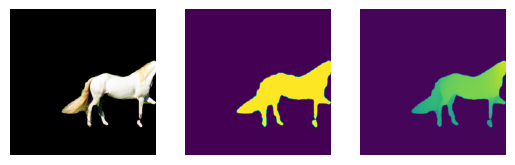

 40%|███████████████████████████▋                                          | 237/600 [00:01<00:02, 130.59it/s]

tensor(0.3550, device='cuda:0') tensor(0.5027, device='cuda:0')
tensor(0.3532, device='cuda:0') tensor(0.5009, device='cuda:0')
tensor(0.3406, device='cuda:0') tensor(0.5009, device='cuda:0')
tensor(0.3130, device='cuda:0') tensor(0.5010, device='cuda:0')
tensor(0.2819, device='cuda:0') tensor(0.5011, device='cuda:0')
tensor(0.2405, device='cuda:0') tensor(0.5011, device='cuda:0')
tensor(0.1993, device='cuda:0') tensor(0.5015, device='cuda:0')
tensor(0.1644, device='cuda:0') tensor(0.5018, device='cuda:0')
tensor(0.1608, device='cuda:0') tensor(0.5022, device='cuda:0')
tensor(0.1606, device='cuda:0') tensor(0.5023, device='cuda:0')
tensor(0.1605, device='cuda:0') tensor(0.5027, device='cuda:0')
tensor(0.1604, device='cuda:0') tensor(0.5029, device='cuda:0')
tensor(0.1604, device='cuda:0') tensor(0.5033, device='cuda:0')
tensor(0.1604, device='cuda:0') tensor(0.5034, device='cuda:0')
tensor(0.1604, device='cuda:0') tensor(0.5037, device='cuda:0')
tensor(0.1605, device='cuda:0') tensor(0

 44%|██████████████████████████████▊                                       | 264/600 [00:02<00:02, 125.63it/s]

tensor(0.1612, device='cuda:0') tensor(0.5036, device='cuda:0')
tensor(0.1612, device='cuda:0') tensor(0.5038, device='cuda:0')
tensor(0.1614, device='cuda:0') tensor(0.5041, device='cuda:0')
tensor(0.1614, device='cuda:0') tensor(0.5043, device='cuda:0')
tensor(0.1613, device='cuda:0') tensor(0.5074, device='cuda:0')
tensor(0.1615, device='cuda:0') tensor(0.5141, device='cuda:0')
tensor(0.1615, device='cuda:0') tensor(0.5263, device='cuda:0')
tensor(0.1615, device='cuda:0') tensor(0.5394, device='cuda:0')
tensor(0.1614, device='cuda:0') tensor(0.5582, device='cuda:0')
tensor(0.1613, device='cuda:0') tensor(0.5771, device='cuda:0')
tensor(0.1614, device='cuda:0') tensor(0.6019, device='cuda:0')
tensor(0.1618, device='cuda:0') tensor(0.6134, device='cuda:0')
tensor(0.1619, device='cuda:0') tensor(0.6148, device='cuda:0')
tensor(0.1620, device='cuda:0') tensor(0.6146, device='cuda:0')
tensor(0.1621, device='cuda:0') tensor(0.6142, device='cuda:0')
tensor(0.1624, device='cuda:0') tensor(0

 48%|█████████████████████████████████▊                                    | 290/600 [00:02<00:02, 125.49it/s]

tensor(0.1651, device='cuda:0') tensor(0.4360, device='cuda:0')
tensor(0.1654, device='cuda:0') tensor(0.4194, device='cuda:0')
tensor(0.1659, device='cuda:0') tensor(0.4191, device='cuda:0')
tensor(0.1661, device='cuda:0') tensor(0.4189, device='cuda:0')
tensor(0.1663, device='cuda:0') tensor(0.4187, device='cuda:0')
tensor(0.1667, device='cuda:0') tensor(0.4187, device='cuda:0')
tensor(0.1667, device='cuda:0') tensor(0.4185, device='cuda:0')
tensor(0.1667, device='cuda:0') tensor(0.4184, device='cuda:0')
tensor(0.1667, device='cuda:0') tensor(0.4182, device='cuda:0')
tensor(0.1668, device='cuda:0') tensor(0.4183, device='cuda:0')
tensor(0.1668, device='cuda:0') tensor(0.4182, device='cuda:0')
tensor(0.1665, device='cuda:0') tensor(0.4181, device='cuda:0')
tensor(0.1665, device='cuda:0') tensor(0.4181, device='cuda:0')
tensor(0.1663, device='cuda:0') tensor(0.4183, device='cuda:0')
tensor(0.1659, device='cuda:0') tensor(0.4181, device='cuda:0')
tensor(0.1656, device='cuda:0') tensor(0

 53%|████████████████████████████████████▊                                 | 316/600 [00:02<00:02, 124.99it/s]

tensor(0.1639, device='cuda:0') tensor(0.4188, device='cuda:0')
tensor(0.1638, device='cuda:0') tensor(0.4188, device='cuda:0')
tensor(0.1637, device='cuda:0') tensor(0.4188, device='cuda:0')
tensor(0.1637, device='cuda:0') tensor(0.4187, device='cuda:0')
tensor(0.1637, device='cuda:0') tensor(0.4187, device='cuda:0')
tensor(0.1637, device='cuda:0') tensor(0.4184, device='cuda:0')
tensor(0.1637, device='cuda:0') tensor(0.4183, device='cuda:0')
tensor(0.1637, device='cuda:0') tensor(0.4183, device='cuda:0')
tensor(0.1638, device='cuda:0') tensor(0.4181, device='cuda:0')
tensor(0.1638, device='cuda:0') tensor(0.4179, device='cuda:0')
tensor(0.1638, device='cuda:0') tensor(0.4178, device='cuda:0')
tensor(0.1637, device='cuda:0') tensor(0.4176, device='cuda:0')
tensor(0.1637, device='cuda:0') tensor(0.4176, device='cuda:0')
tensor(0.1638, device='cuda:0') tensor(0.4175, device='cuda:0')
tensor(0.1638, device='cuda:0') tensor(0.4174, device='cuda:0')
tensor(0.1638, device='cuda:0') tensor(0

 57%|███████████████████████████████████████▉                              | 342/600 [00:02<00:02, 125.08it/s]

tensor(0.4155, device='cuda:0')
tensor(0.1645, device='cuda:0') tensor(0.4155, device='cuda:0')
tensor(0.1645, device='cuda:0') tensor(0.4153, device='cuda:0')
tensor(0.1649, device='cuda:0') tensor(0.4151, device='cuda:0')
tensor(0.1649, device='cuda:0') tensor(0.4148, device='cuda:0')
tensor(0.1649, device='cuda:0') tensor(0.4147, device='cuda:0')
tensor(0.1648, device='cuda:0') tensor(0.4145, device='cuda:0')
tensor(0.1648, device='cuda:0') tensor(0.4145, device='cuda:0')
tensor(0.1646, device='cuda:0') tensor(0.4144, device='cuda:0')
tensor(0.1645, device='cuda:0') tensor(0.4144, device='cuda:0')
tensor(0.1643, device='cuda:0') tensor(0.4145, device='cuda:0')
tensor(0.1641, device='cuda:0') tensor(0.4146, device='cuda:0')
tensor(0.1637, device='cuda:0') tensor(0.4147, device='cuda:0')
tensor(0.1632, device='cuda:0') tensor(0.4146, device='cuda:0')
tensor(0.1627, device='cuda:0') tensor(0.4146, device='cuda:0')
tensor(0.1622, device='cuda:0') tensor(0.4679, device='cuda:0')
tensor(0

 61%|██████████████████████████████████████████▉                           | 368/600 [00:02<00:01, 125.09it/s]

tensor(0.1586, device='cuda:0') tensor(0.6457, device='cuda:0')
tensor(0.1584, device='cuda:0') tensor(0.6459, device='cuda:0')
tensor(0.1583, device='cuda:0') tensor(0.6460, device='cuda:0')
tensor(0.1582, device='cuda:0') tensor(0.6452, device='cuda:0')
tensor(0.1578, device='cuda:0') tensor(0.6092, device='cuda:0')
tensor(0.1575, device='cuda:0') tensor(0.5925, device='cuda:0')
tensor(0.1575, device='cuda:0') tensor(0.5837, device='cuda:0')
tensor(0.1573, device='cuda:0') tensor(0.5760, device='cuda:0')
tensor(0.1570, device='cuda:0') tensor(0.5635, device='cuda:0')
tensor(0.1569, device='cuda:0') tensor(0.5511, device='cuda:0')
tensor(0.1568, device='cuda:0') tensor(0.5445, device='cuda:0')
tensor(0.1565, device='cuda:0') tensor(0.5420, device='cuda:0')
tensor(0.1564, device='cuda:0') tensor(0.5416, device='cuda:0')
tensor(0.1564, device='cuda:0') tensor(0.5414, device='cuda:0')
tensor(0.1564, device='cuda:0') tensor(0.5414, device='cuda:0')
tensor(0.1565, device='cuda:0') tensor(0

 66%|██████████████████████████████████████████████                        | 395/600 [00:03<00:01, 129.72it/s]

tensor(0.1559, device='cuda:0') tensor(0.5417, device='cuda:0')
tensor(0.1558, device='cuda:0') tensor(0.5414, device='cuda:0')
tensor(0.1558, device='cuda:0') tensor(0.5409, device='cuda:0')
tensor(0.1558, device='cuda:0') tensor(0.5406, device='cuda:0')
tensor(0.1558, device='cuda:0') tensor(0.5406, device='cuda:0')
tensor(0.1559, device='cuda:0') tensor(0.5402, device='cuda:0')
tensor(0.1638, device='cuda:0') tensor(0.5400, device='cuda:0')
tensor(0.2368, device='cuda:0') tensor(0.5396, device='cuda:0')
tensor(0.2794, device='cuda:0') tensor(0.5394, device='cuda:0')


100%|██████████████████████████████████████████████████████████████████████| 600/600 [00:04<00:00, 130.83it/s]


/grogu/user/akirchme/art3d_sd_webui/images/horse/82.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/82.mp4


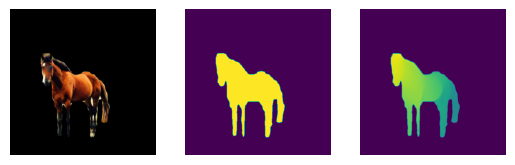

  2%|█▌                                                                     | 13/600 [00:00<00:04, 121.30it/s]

tensor(0.1751, device='cuda:0') tensor(0.4375, device='cuda:0')
tensor(0.1752, device='cuda:0') tensor(0.4379, device='cuda:0')
tensor(0.1752, device='cuda:0') tensor(0.4377, device='cuda:0')
tensor(0.1753, device='cuda:0') tensor(0.4377, device='cuda:0')
tensor(0.1753, device='cuda:0') tensor(0.4377, device='cuda:0')
tensor(0.1753, device='cuda:0') tensor(0.4377, device='cuda:0')
tensor(0.1753, device='cuda:0') tensor(0.4378, device='cuda:0')
tensor(0.1753, device='cuda:0') tensor(0.4379, device='cuda:0')
tensor(0.1753, device='cuda:0') tensor(0.4380, device='cuda:0')
tensor(0.1753, device='cuda:0') tensor(0.4382, device='cuda:0')
tensor(0.1752, device='cuda:0') tensor(0.4383, device='cuda:0')
tensor(0.1753, device='cuda:0') tensor(0.4383, device='cuda:0')
tensor(0.1761, device='cuda:0') tensor(0.4384, device='cuda:0')
tensor(0.1763, device='cuda:0') tensor(0.4386, device='cuda:0')
tensor(0.1764, device='cuda:0') tensor(0.4386, device='cuda:0')
tensor(0.1767, device='cuda:0') tensor(0

  6%|████▌                                                                  | 39/600 [00:00<00:04, 122.28it/s]

tensor(0.1770, device='cuda:0') tensor(0.4394, device='cuda:0')
tensor(0.1765, device='cuda:0') tensor(0.4397, device='cuda:0')
tensor(0.1758, device='cuda:0') tensor(0.4397, device='cuda:0')
tensor(0.1752, device='cuda:0') tensor(0.4397, device='cuda:0')
tensor(0.1743, device='cuda:0') tensor(0.4399, device='cuda:0')
tensor(0.1736, device='cuda:0') tensor(0.4403, device='cuda:0')
tensor(0.1727, device='cuda:0') tensor(0.4407, device='cuda:0')
tensor(0.1713, device='cuda:0') tensor(0.4410, device='cuda:0')
tensor(0.1700, device='cuda:0') tensor(0.4552, device='cuda:0')
tensor(0.1690, device='cuda:0') tensor(0.4831, device='cuda:0')
tensor(0.1684, device='cuda:0') tensor(0.5126, device='cuda:0')
tensor(0.1677, device='cuda:0') tensor(0.5486, device='cuda:0')
tensor(0.1669, device='cuda:0') tensor(0.5831, device='cuda:0')
tensor(0.1661, device='cuda:0') tensor(0.6111, device='cuda:0')
tensor(0.1652, device='cuda:0') tensor(0.6314, device='cuda:0')
tensor(0.1644, device='cuda:0') tensor(0

 11%|███████▋                                                               | 65/600 [00:00<00:04, 123.33it/s]

tensor(0.1583, device='cuda:0') tensor(0.5897, device='cuda:0')
tensor(0.1579, device='cuda:0') tensor(0.5640, device='cuda:0')
tensor(0.1573, device='cuda:0') tensor(0.5430, device='cuda:0')
tensor(0.1570, device='cuda:0') tensor(0.5272, device='cuda:0')
tensor(0.1566, device='cuda:0') tensor(0.5172, device='cuda:0')
tensor(0.1562, device='cuda:0') tensor(0.5138, device='cuda:0')
tensor(0.1559, device='cuda:0') tensor(0.5142, device='cuda:0')
tensor(0.1557, device='cuda:0') tensor(0.5154, device='cuda:0')
tensor(0.1554, device='cuda:0') tensor(0.5166, device='cuda:0')
tensor(0.1555, device='cuda:0') tensor(0.5175, device='cuda:0')
tensor(0.1556, device='cuda:0') tensor(0.5195, device='cuda:0')
tensor(0.1553, device='cuda:0') tensor(0.5204, device='cuda:0')
tensor(0.1553, device='cuda:0') tensor(0.5220, device='cuda:0')
tensor(0.1553, device='cuda:0') tensor(0.5233, device='cuda:0')
tensor(0.1553, device='cuda:0') tensor(0.5242, device='cuda:0')
tensor(0.1551, device='cuda:0') tensor(0

 15%|██████████▊                                                            | 91/600 [00:00<00:04, 120.97it/s]

tensor(0.1556, device='cuda:0') tensor(0.5264, device='cuda:0')
tensor(0.1559, device='cuda:0') tensor(0.5254, device='cuda:0')
tensor(0.1885, device='cuda:0') tensor(0.5239, device='cuda:0')
tensor(0.2332, device='cuda:0') tensor(0.5230, device='cuda:0')
tensor(0.2856, device='cuda:0') tensor(0.5220, device='cuda:0')
tensor(0.3511, device='cuda:0') tensor(0.5199, device='cuda:0')
tensor(0.3668, device='cuda:0') tensor(0.5199, device='cuda:0')
tensor(0.3700, device='cuda:0') tensor(0.5193, device='cuda:0')
tensor(0.3708, device='cuda:0') tensor(0.5197, device='cuda:0')


 87%|█████████████████████████████████████████████████████████████         | 523/600 [00:04<00:00, 105.66it/s]

tensor(0.2980, device='cuda:0') tensor(0.7132, device='cuda:0')
tensor(0.2957, device='cuda:0') tensor(0.7135, device='cuda:0')
tensor(0.2933, device='cuda:0') tensor(0.7131, device='cuda:0')
tensor(0.2898, device='cuda:0') tensor(0.7124, device='cuda:0')
tensor(0.2865, device='cuda:0') tensor(0.7116, device='cuda:0')
tensor(0.2842, device='cuda:0') tensor(0.7089, device='cuda:0')
tensor(0.2821, device='cuda:0') tensor(0.7038, device='cuda:0')
tensor(0.2809, device='cuda:0') tensor(0.6935, device='cuda:0')
tensor(0.2801, device='cuda:0') tensor(0.6804, device='cuda:0')
tensor(0.2787, device='cuda:0') tensor(0.6640, device='cuda:0')
tensor(0.2773, device='cuda:0') tensor(0.6408, device='cuda:0')
tensor(0.2766, device='cuda:0') tensor(0.6140, device='cuda:0')
tensor(0.2759, device='cuda:0') tensor(0.5816, device='cuda:0')
tensor(0.2753, device='cuda:0') tensor(0.5536, device='cuda:0')
tensor(0.2748, device='cuda:0') tensor(0.5250, device='cuda:0')
tensor(0.2738, device='cuda:0') tensor(0

 92%|████████████████████████████████████████████████████████████████      | 549/600 [00:04<00:00, 114.30it/s]

tensor(0.1553, device='cuda:0') tensor(0.5101, device='cuda:0')
tensor(0.1551, device='cuda:0') tensor(0.5102, device='cuda:0')
tensor(0.1549, device='cuda:0') tensor(0.5103, device='cuda:0')
tensor(0.1545, device='cuda:0') tensor(0.5105, device='cuda:0')
tensor(0.1544, device='cuda:0') tensor(0.5105, device='cuda:0')
tensor(0.1543, device='cuda:0') tensor(0.5110, device='cuda:0')
tensor(0.1541, device='cuda:0') tensor(0.5107, device='cuda:0')
tensor(0.1539, device='cuda:0') tensor(0.5106, device='cuda:0')
tensor(0.1540, device='cuda:0') tensor(0.5105, device='cuda:0')
tensor(0.1537, device='cuda:0') tensor(0.5101, device='cuda:0')
tensor(0.1537, device='cuda:0') tensor(0.5094, device='cuda:0')
tensor(0.1536, device='cuda:0') tensor(0.5084, device='cuda:0')
tensor(0.1534, device='cuda:0') tensor(0.5076, device='cuda:0')
tensor(0.1534, device='cuda:0') tensor(0.5067, device='cuda:0')
tensor(0.1537, device='cuda:0') tensor(0.5056, device='cuda:0')
tensor(0.1537, device='cuda:0') tensor(0

 96%|███████████████████████████████████████████████████████████████████   | 575/600 [00:04<00:00, 117.69it/s]

tensor(0.1555, device='cuda:0') tensor(0.5485, device='cuda:0')
tensor(0.1559, device='cuda:0') tensor(0.5507, device='cuda:0')
tensor(0.1562, device='cuda:0') tensor(0.5521, device='cuda:0')
tensor(0.1566, device='cuda:0') tensor(0.5515, device='cuda:0')
tensor(0.1570, device='cuda:0') tensor(0.5509, device='cuda:0')
tensor(0.1577, device='cuda:0') tensor(0.5502, device='cuda:0')
tensor(0.1580, device='cuda:0') tensor(0.5499, device='cuda:0')
tensor(0.1584, device='cuda:0') tensor(0.5498, device='cuda:0')
tensor(0.1588, device='cuda:0') tensor(0.5408, device='cuda:0')
tensor(0.1594, device='cuda:0') tensor(0.5204, device='cuda:0')
tensor(0.1602, device='cuda:0') tensor(0.4975, device='cuda:0')
tensor(0.1612, device='cuda:0') tensor(0.4710, device='cuda:0')
tensor(0.1621, device='cuda:0') tensor(0.4566, device='cuda:0')
tensor(0.1632, device='cuda:0') tensor(0.4492, device='cuda:0')
tensor(0.1642, device='cuda:0') tensor(0.4422, device='cuda:0')
tensor(0.1650, device='cuda:0') tensor(0

100%|█████████████████████████████████████████████████████████████████████▉| 599/600 [00:04<00:00, 117.36it/s]

tensor(0.1712, device='cuda:0') tensor(0.4353, device='cuda:0')
tensor(0.1714, device='cuda:0') tensor(0.4354, device='cuda:0')
tensor(0.1717, device='cuda:0') tensor(0.4354, device='cuda:0')
tensor(0.1720, device='cuda:0') tensor(0.4357, device='cuda:0')
tensor(0.1720, device='cuda:0') tensor(0.4356, device='cuda:0')
tensor(0.1722, device='cuda:0') tensor(0.4359, device='cuda:0')
tensor(0.1726, device='cuda:0') tensor(0.4358, device='cuda:0')
tensor(0.1727, device='cuda:0') tensor(0.4357, device='cuda:0')
tensor(0.1731, device='cuda:0') tensor(0.4360, device='cuda:0')
tensor(0.1731, device='cuda:0') tensor(0.4363, device='cuda:0')
tensor(0.1733, device='cuda:0') tensor(0.4363, device='cuda:0')
tensor(0.1737, device='cuda:0') tensor(0.4362, device='cuda:0')
tensor(0.1737, device='cuda:0') tensor(0.4365, device='cuda:0')
tensor(0.1739, device='cuda:0') tensor(0.4366, device='cuda:0')
tensor(0.1740, device='cuda:0') tensor(0.4369, device='cuda:0')
tensor(0.1743, device='cuda:0') tensor(0

100%|██████████████████████████████████████████████████████████████████████| 600/600 [00:04<00:00, 122.16it/s]


/grogu/user/akirchme/art3d_sd_webui/images/horse/1192.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/1192.mp4


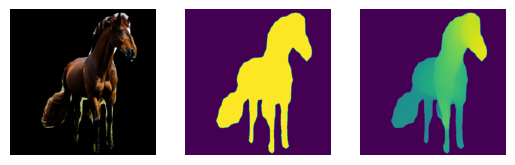

 40%|████████████████████████████▎                                         | 243/600 [00:02<00:03, 107.51it/s]

tensor(0.2853, device='cuda:0') tensor(0.5505, device='cuda:0')
tensor(0.2689, device='cuda:0') tensor(0.5514, device='cuda:0')
tensor(0.2552, device='cuda:0') tensor(0.5522, device='cuda:0')
tensor(0.2475, device='cuda:0') tensor(0.5532, device='cuda:0')
tensor(0.2467, device='cuda:0') tensor(0.5544, device='cuda:0')
tensor(0.2466, device='cuda:0') tensor(0.5554, device='cuda:0')
tensor(0.2465, device='cuda:0') tensor(0.5559, device='cuda:0')
tensor(0.2463, device='cuda:0') tensor(0.5560, device='cuda:0')
tensor(0.2464, device='cuda:0') tensor(0.5551, device='cuda:0')
tensor(0.2465, device='cuda:0') tensor(0.5544, device='cuda:0')
tensor(0.2465, device='cuda:0') tensor(0.5534, device='cuda:0')
tensor(0.2465, device='cuda:0') tensor(0.5521, device='cuda:0')
tensor(0.2465, device='cuda:0') tensor(0.5502, device='cuda:0')
tensor(0.2467, device='cuda:0') tensor(0.5486, device='cuda:0')
tensor(0.2469, device='cuda:0') tensor(0.5468, device='cuda:0')
tensor(0.2470, device='cuda:0') tensor(0

 45%|███████████████████████████████▎                                      | 268/600 [00:02<00:02, 114.72it/s]

tensor(0.2499, device='cuda:0') tensor(0.5301, device='cuda:0')
tensor(0.2506, device='cuda:0') tensor(0.5321, device='cuda:0')
tensor(0.2511, device='cuda:0') tensor(0.5375, device='cuda:0')
tensor(0.2517, device='cuda:0') tensor(0.5395, device='cuda:0')
tensor(0.2524, device='cuda:0') tensor(0.5406, device='cuda:0')
tensor(0.2528, device='cuda:0') tensor(0.5429, device='cuda:0')
tensor(0.2532, device='cuda:0') tensor(0.5482, device='cuda:0')
tensor(0.2538, device='cuda:0') tensor(0.5517, device='cuda:0')
tensor(0.2547, device='cuda:0') tensor(0.5526, device='cuda:0')
tensor(0.2552, device='cuda:0') tensor(0.5521, device='cuda:0')
tensor(0.2563, device='cuda:0') tensor(0.5516, device='cuda:0')
tensor(0.2571, device='cuda:0') tensor(0.5509, device='cuda:0')
tensor(0.2582, device='cuda:0') tensor(0.5509, device='cuda:0')
tensor(0.2594, device='cuda:0') tensor(0.5508, device='cuda:0')
tensor(0.2609, device='cuda:0') tensor(0.5456, device='cuda:0')
tensor(0.2621, device='cuda:0') tensor(0

 49%|██████████████████████████████████▏                                   | 293/600 [00:02<00:02, 117.25it/s]

tensor(0.2748, device='cuda:0') tensor(0.4333, device='cuda:0')
tensor(0.2754, device='cuda:0') tensor(0.4332, device='cuda:0')
tensor(0.2764, device='cuda:0') tensor(0.4329, device='cuda:0')
tensor(0.2772, device='cuda:0') tensor(0.4328, device='cuda:0')
tensor(0.2780, device='cuda:0') tensor(0.4328, device='cuda:0')
tensor(0.2783, device='cuda:0') tensor(0.4327, device='cuda:0')
tensor(0.2787, device='cuda:0') tensor(0.4329, device='cuda:0')
tensor(0.2791, device='cuda:0') tensor(0.4330, device='cuda:0')
tensor(0.2796, device='cuda:0') tensor(0.4330, device='cuda:0')
tensor(0.2800, device='cuda:0') tensor(0.4329, device='cuda:0')
tensor(0.2800, device='cuda:0') tensor(0.4329, device='cuda:0')
tensor(0.2801, device='cuda:0') tensor(0.4329, device='cuda:0')
tensor(0.2800, device='cuda:0') tensor(0.4329, device='cuda:0')
tensor(0.2800, device='cuda:0') tensor(0.4329, device='cuda:0')
tensor(0.2799, device='cuda:0') tensor(0.4331, device='cuda:0')
tensor(0.2797, device='cuda:0') tensor(0

 53%|█████████████████████████████████████▏                                | 319/600 [00:02<00:02, 120.29it/s]

tensor(0.4329, device='cuda:0')
tensor(0.2762, device='cuda:0') tensor(0.4329, device='cuda:0')
tensor(0.2760, device='cuda:0') tensor(0.4330, device='cuda:0')
tensor(0.2758, device='cuda:0') tensor(0.4330, device='cuda:0')
tensor(0.2758, device='cuda:0') tensor(0.4330, device='cuda:0')
tensor(0.2756, device='cuda:0') tensor(0.4330, device='cuda:0')
tensor(0.2755, device='cuda:0') tensor(0.4329, device='cuda:0')
tensor(0.2754, device='cuda:0') tensor(0.4329, device='cuda:0')
tensor(0.2754, device='cuda:0') tensor(0.4329, device='cuda:0')
tensor(0.2752, device='cuda:0') tensor(0.4329, device='cuda:0')
tensor(0.2746, device='cuda:0') tensor(0.4329, device='cuda:0')
tensor(0.2742, device='cuda:0') tensor(0.4329, device='cuda:0')
tensor(0.2738, device='cuda:0') tensor(0.4330, device='cuda:0')
tensor(0.2735, device='cuda:0') tensor(0.4331, device='cuda:0')
tensor(0.2731, device='cuda:0') tensor(0.4332, device='cuda:0')
tensor(0.2727, device='cuda:0') tensor(0.4331, device='cuda:0')
tensor(0

 55%|██████████████████████████████████████▋                               | 332/600 [00:03<00:02, 119.78it/s]

tensor(0.2704, device='cuda:0') tensor(0.4340, device='cuda:0')
tensor(0.2701, device='cuda:0') tensor(0.4341, device='cuda:0')
tensor(0.2696, device='cuda:0') tensor(0.4340, device='cuda:0')
tensor(0.2691, device='cuda:0') tensor(0.4340, device='cuda:0')
tensor(0.2687, device='cuda:0') tensor(0.4339, device='cuda:0')
tensor(0.2680, device='cuda:0') tensor(0.4340, device='cuda:0')
tensor(0.2672, device='cuda:0') tensor(0.4342, device='cuda:0')
tensor(0.2666, device='cuda:0') tensor(0.4343, device='cuda:0')
tensor(0.2657, device='cuda:0') tensor(0.4344, device='cuda:0')
tensor(0.2649, device='cuda:0') tensor(0.4344, device='cuda:0')
tensor(0.2642, device='cuda:0') tensor(0.4345, device='cuda:0')
tensor(0.2632, device='cuda:0') tensor(0.4347, device='cuda:0')
tensor(0.2623, device='cuda:0') tensor(0.4348, device='cuda:0')
tensor(0.2613, device='cuda:0') tensor(0.4352, device='cuda:0')
tensor(0.2603, device='cuda:0') tensor(0.4472, device='cuda:0')
tensor(0.2591, device='cuda:0') tensor(0

 60%|█████████████████████████████████████████▊                            | 358/600 [00:03<00:02, 120.97it/s]

tensor(0.2504, device='cuda:0') tensor(0.5602, device='cuda:0')
tensor(0.2500, device='cuda:0') tensor(0.5609, device='cuda:0')
tensor(0.2496, device='cuda:0') tensor(0.5618, device='cuda:0')
tensor(0.2496, device='cuda:0') tensor(0.5628, device='cuda:0')
tensor(0.2493, device='cuda:0') tensor(0.5536, device='cuda:0')
tensor(0.2491, device='cuda:0') tensor(0.5433, device='cuda:0')
tensor(0.2487, device='cuda:0') tensor(0.5392, device='cuda:0')
tensor(0.2481, device='cuda:0') tensor(0.5364, device='cuda:0')
tensor(0.2480, device='cuda:0') tensor(0.5326, device='cuda:0')
tensor(0.2476, device='cuda:0') tensor(0.5290, device='cuda:0')
tensor(0.2477, device='cuda:0') tensor(0.5253, device='cuda:0')
tensor(0.2476, device='cuda:0') tensor(0.5225, device='cuda:0')
tensor(0.2477, device='cuda:0') tensor(0.5213, device='cuda:0')
tensor(0.2479, device='cuda:0') tensor(0.5211, device='cuda:0')
tensor(0.2474, device='cuda:0') tensor(0.5214, device='cuda:0')
tensor(0.2472, device='cuda:0') tensor(0

 64%|████████████████████████████████████████████▊                         | 384/600 [00:03<00:01, 117.11it/s]

tensor(0.2492, device='cuda:0') tensor(0.5428, device='cuda:0')
tensor(0.2494, device='cuda:0') tensor(0.5442, device='cuda:0')
tensor(0.2495, device='cuda:0') tensor(0.5459, device='cuda:0')
tensor(0.2497, device='cuda:0') tensor(0.5474, device='cuda:0')
tensor(0.2498, device='cuda:0') tensor(0.5488, device='cuda:0')
tensor(0.2502, device='cuda:0') tensor(0.5491, device='cuda:0')
tensor(0.2505, device='cuda:0') tensor(0.5485, device='cuda:0')
tensor(0.2524, device='cuda:0') tensor(0.5474, device='cuda:0')
tensor(0.2756, device='cuda:0') tensor(0.5466, device='cuda:0')


100%|██████████████████████████████████████████████████████████████████████| 600/600 [00:05<00:00, 107.01it/s]


/grogu/user/akirchme/art3d_sd_webui/images/horse/176.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/176.mp4


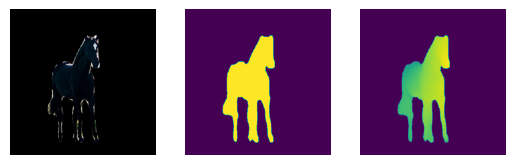

 14%|█████████▊                                                             | 83/600 [00:00<00:04, 128.75it/s]

tensor(0.3202, device='cuda:0') tensor(0.5178, device='cuda:0')
tensor(0.3198, device='cuda:0') tensor(0.5169, device='cuda:0')
tensor(0.3195, device='cuda:0') tensor(0.5157, device='cuda:0')
tensor(0.3189, device='cuda:0') tensor(0.5147, device='cuda:0')
tensor(0.3189, device='cuda:0') tensor(0.5143, device='cuda:0')
tensor(0.3186, device='cuda:0') tensor(0.5135, device='cuda:0')
tensor(0.3184, device='cuda:0') tensor(0.5130, device='cuda:0')
tensor(0.3182, device='cuda:0') tensor(0.5126, device='cuda:0')
tensor(0.3209, device='cuda:0') tensor(0.5123, device='cuda:0')
tensor(0.3243, device='cuda:0') tensor(0.5119, device='cuda:0')
tensor(0.3307, device='cuda:0') tensor(0.5116, device='cuda:0')
tensor(0.3385, device='cuda:0') tensor(0.5115, device='cuda:0')
tensor(0.3472, device='cuda:0') tensor(0.5112, device='cuda:0')
tensor(0.3587, device='cuda:0') tensor(0.5111, device='cuda:0')
tensor(0.3696, device='cuda:0') tensor(0.5107, device='cuda:0')
tensor(0.3778, device='cuda:0') tensor(0

 22%|███████████████▊                                                      | 135/600 [00:01<00:03, 123.90it/s]

tensor(0.4346, device='cuda:0') tensor(0.5188, device='cuda:0')
tensor(0.4346, device='cuda:0') tensor(0.5158, device='cuda:0')
tensor(0.4344, device='cuda:0') tensor(0.5131, device='cuda:0')
tensor(0.4344, device='cuda:0') tensor(0.5107, device='cuda:0')
tensor(0.4345, device='cuda:0') tensor(0.5067, device='cuda:0')
tensor(0.4345, device='cuda:0') tensor(0.5041, device='cuda:0')
tensor(0.4344, device='cuda:0') tensor(0.5020, device='cuda:0')
tensor(0.4345, device='cuda:0') tensor(0.5010, device='cuda:0')
tensor(0.4345, device='cuda:0') tensor(0.5003, device='cuda:0')
tensor(0.4344, device='cuda:0') tensor(0.4999, device='cuda:0')
tensor(0.4344, device='cuda:0') tensor(0.4998, device='cuda:0')
tensor(0.4344, device='cuda:0') tensor(0.4997, device='cuda:0')
tensor(0.4343, device='cuda:0') tensor(0.4997, device='cuda:0')
tensor(0.4341, device='cuda:0') tensor(0.4997, device='cuda:0')
tensor(0.4341, device='cuda:0') tensor(0.4995, device='cuda:0')
tensor(0.4341, device='cuda:0') tensor(0

 27%|██████████████████▊                                                   | 161/600 [00:01<00:03, 123.39it/s]

tensor(0.4385, device='cuda:0') tensor(0.4981, device='cuda:0')
tensor(0.4412, device='cuda:0') tensor(0.4983, device='cuda:0')
tensor(0.4427, device='cuda:0') tensor(0.4980, device='cuda:0')
tensor(0.4446, device='cuda:0') tensor(0.4978, device='cuda:0')
tensor(0.4466, device='cuda:0') tensor(0.4979, device='cuda:0')
tensor(0.4482, device='cuda:0') tensor(0.4978, device='cuda:0')
tensor(0.4501, device='cuda:0') tensor(0.4980, device='cuda:0')
tensor(0.4525, device='cuda:0') tensor(0.4980, device='cuda:0')
tensor(0.4564, device='cuda:0') tensor(0.4977, device='cuda:0')
tensor(0.4602, device='cuda:0') tensor(0.4978, device='cuda:0')
tensor(0.4636, device='cuda:0') tensor(0.4982, device='cuda:0')
tensor(0.4652, device='cuda:0') tensor(0.4982, device='cuda:0')
tensor(0.4654, device='cuda:0') tensor(0.4981, device='cuda:0')
tensor(0.4656, device='cuda:0') tensor(0.4981, device='cuda:0')
tensor(0.4656, device='cuda:0') tensor(0.4984, device='cuda:0')
tensor(0.4653, device='cuda:0') tensor(0

 31%|█████████████████████▊                                                | 187/600 [00:01<00:03, 121.53it/s]

tensor(0.3916, device='cuda:0') tensor(0.5021, device='cuda:0')
tensor(0.3868, device='cuda:0') tensor(0.5025, device='cuda:0')
tensor(0.3844, device='cuda:0') tensor(0.5029, device='cuda:0')
tensor(0.3837, device='cuda:0') tensor(0.5035, device='cuda:0')
tensor(0.3835, device='cuda:0') tensor(0.5039, device='cuda:0')
tensor(0.3833, device='cuda:0') tensor(0.5042, device='cuda:0')
tensor(0.3830, device='cuda:0') tensor(0.5043, device='cuda:0')
tensor(0.3828, device='cuda:0') tensor(0.5046, device='cuda:0')
tensor(0.3827, device='cuda:0') tensor(0.5048, device='cuda:0')
tensor(0.3824, device='cuda:0') tensor(0.5049, device='cuda:0')
tensor(0.3822, device='cuda:0') tensor(0.5048, device='cuda:0')
tensor(0.3819, device='cuda:0') tensor(0.5053, device='cuda:0')
tensor(0.3815, device='cuda:0') tensor(0.5055, device='cuda:0')
tensor(0.3812, device='cuda:0') tensor(0.5059, device='cuda:0')
tensor(0.3809, device='cuda:0') tensor(0.5061, device='cuda:0')
tensor(0.3807, device='cuda:0') tensor(0

 33%|███████████████████████▎                                              | 200/600 [00:01<00:03, 119.70it/s]

tensor(0.3763, device='cuda:0') tensor(0.5168, device='cuda:0')
tensor(0.3755, device='cuda:0') tensor(0.5195, device='cuda:0')


 37%|██████████████████████████▏                                           | 224/600 [00:01<00:03, 108.17it/s]

tensor(0.3073, device='cuda:0') tensor(0.5189, device='cuda:0')
tensor(0.3060, device='cuda:0') tensor(0.5130, device='cuda:0')
tensor(0.3053, device='cuda:0') tensor(0.5081, device='cuda:0')
tensor(0.3045, device='cuda:0') tensor(0.5050, device='cuda:0')
tensor(0.3042, device='cuda:0') tensor(0.5033, device='cuda:0')
tensor(0.3039, device='cuda:0') tensor(0.5027, device='cuda:0')
tensor(0.3036, device='cuda:0') tensor(0.5034, device='cuda:0')
tensor(0.2989, device='cuda:0') tensor(0.5046, device='cuda:0')
tensor(0.2855, device='cuda:0') tensor(0.5054, device='cuda:0')
tensor(0.2734, device='cuda:0') tensor(0.5065, device='cuda:0')
tensor(0.2630, device='cuda:0') tensor(0.5087, device='cuda:0')
tensor(0.2561, device='cuda:0') tensor(0.5103, device='cuda:0')
tensor(0.2520, device='cuda:0') tensor(0.5117, device='cuda:0')
tensor(0.2503, device='cuda:0') tensor(0.5133, device='cuda:0')
tensor(0.2509, device='cuda:0') tensor(0.5146, device='cuda:0')
tensor(0.2513, device='cuda:0') tensor(0

 41%|████████████████████████████▉                                         | 248/600 [00:02<00:03, 113.29it/s]

tensor(0.2532, device='cuda:0') tensor(0.5057, device='cuda:0')
tensor(0.2532, device='cuda:0') tensor(0.5030, device='cuda:0')
tensor(0.2535, device='cuda:0') tensor(0.5005, device='cuda:0')
tensor(0.2534, device='cuda:0') tensor(0.4983, device='cuda:0')
tensor(0.2535, device='cuda:0') tensor(0.4969, device='cuda:0')
tensor(0.2537, device='cuda:0') tensor(0.4961, device='cuda:0')
tensor(0.2534, device='cuda:0') tensor(0.4948, device='cuda:0')
tensor(0.2540, device='cuda:0') tensor(0.4936, device='cuda:0')
tensor(0.2548, device='cuda:0') tensor(0.4920, device='cuda:0')
tensor(0.2555, device='cuda:0') tensor(0.4914, device='cuda:0')
tensor(0.2563, device='cuda:0') tensor(0.4906, device='cuda:0')
tensor(0.2568, device='cuda:0') tensor(0.4930, device='cuda:0')
tensor(0.2578, device='cuda:0') tensor(0.4974, device='cuda:0')
tensor(0.2589, device='cuda:0') tensor(0.5009, device='cuda:0')
tensor(0.2596, device='cuda:0') tensor(0.5046, device='cuda:0')
tensor(0.2607, device='cuda:0') tensor(0

 46%|███████████████████████████████▉                                      | 274/600 [00:02<00:02, 118.60it/s]

tensor(0.2724, device='cuda:0') tensor(0.4958, device='cuda:0')
tensor(0.2744, device='cuda:0') tensor(0.4857, device='cuda:0')
tensor(0.2761, device='cuda:0') tensor(0.4774, device='cuda:0')
tensor(0.2777, device='cuda:0') tensor(0.4696, device='cuda:0')
tensor(0.2790, device='cuda:0') tensor(0.4626, device='cuda:0')
tensor(0.2811, device='cuda:0') tensor(0.4578, device='cuda:0')
tensor(0.2831, device='cuda:0') tensor(0.4544, device='cuda:0')
tensor(0.2849, device='cuda:0') tensor(0.4520, device='cuda:0')
tensor(0.2869, device='cuda:0') tensor(0.4509, device='cuda:0')
tensor(0.2891, device='cuda:0') tensor(0.4504, device='cuda:0')
tensor(0.2912, device='cuda:0') tensor(0.4500, device='cuda:0')
tensor(0.2930, device='cuda:0') tensor(0.4500, device='cuda:0')
tensor(0.2942, device='cuda:0') tensor(0.4497, device='cuda:0')
tensor(0.2955, device='cuda:0') tensor(0.4497, device='cuda:0')
tensor(0.2967, device='cuda:0') tensor(0.4495, device='cuda:0')
tensor(0.2971, device='cuda:0') tensor(0

 50%|██████████████████████████████████▉                                   | 299/600 [00:02<00:02, 119.30it/s]

tensor(0.2936, device='cuda:0') tensor(0.4485, device='cuda:0')
tensor(0.2929, device='cuda:0') tensor(0.4484, device='cuda:0')
tensor(0.2928, device='cuda:0') tensor(0.4483, device='cuda:0')
tensor(0.2926, device='cuda:0') tensor(0.4484, device='cuda:0')
tensor(0.2922, device='cuda:0') tensor(0.4484, device='cuda:0')
tensor(0.2920, device='cuda:0') tensor(0.4484, device='cuda:0')
tensor(0.2918, device='cuda:0') tensor(0.4482, device='cuda:0')
tensor(0.2917, device='cuda:0') tensor(0.4481, device='cuda:0')
tensor(0.2915, device='cuda:0') tensor(0.4477, device='cuda:0')
tensor(0.2918, device='cuda:0') tensor(0.4473, device='cuda:0')
tensor(0.2913, device='cuda:0') tensor(0.4471, device='cuda:0')
tensor(0.2909, device='cuda:0') tensor(0.4470, device='cuda:0')
tensor(0.2906, device='cuda:0') tensor(0.4469, device='cuda:0')
tensor(0.2901, device='cuda:0') tensor(0.4468, device='cuda:0')
tensor(0.2894, device='cuda:0') tensor(0.4470, device='cuda:0')
tensor(0.2891, device='cuda:0') tensor(0

 54%|█████████████████████████████████████▉                                | 325/600 [00:02<00:02, 121.06it/s]

tensor(0.2843, device='cuda:0') tensor(0.4465, device='cuda:0')
tensor(0.2838, device='cuda:0') tensor(0.4465, device='cuda:0')
tensor(0.2835, device='cuda:0') tensor(0.4467, device='cuda:0')
tensor(0.2830, device='cuda:0') tensor(0.4469, device='cuda:0')
tensor(0.2828, device='cuda:0') tensor(0.4472, device='cuda:0')
tensor(0.2826, device='cuda:0') tensor(0.4469, device='cuda:0')
tensor(0.2820, device='cuda:0') tensor(0.4471, device='cuda:0')
tensor(0.2814, device='cuda:0') tensor(0.4470, device='cuda:0')
tensor(0.2807, device='cuda:0') tensor(0.4472, device='cuda:0')
tensor(0.2802, device='cuda:0') tensor(0.4472, device='cuda:0')
tensor(0.2795, device='cuda:0') tensor(0.4474, device='cuda:0')
tensor(0.2788, device='cuda:0') tensor(0.4478, device='cuda:0')
tensor(0.2781, device='cuda:0') tensor(0.4479, device='cuda:0')
tensor(0.2774, device='cuda:0') tensor(0.4479, device='cuda:0')
tensor(0.2770, device='cuda:0') tensor(0.4480, device='cuda:0')
tensor(0.2764, device='cuda:0') tensor(0

 58%|████████████████████████████████████████▉                             | 351/600 [00:02<00:02, 119.60it/s]

tensor(0.2667, device='cuda:0') tensor(0.4590, device='cuda:0')
tensor(0.2653, device='cuda:0') tensor(0.4653, device='cuda:0')
tensor(0.2642, device='cuda:0') tensor(0.4746, device='cuda:0')
tensor(0.2628, device='cuda:0') tensor(0.4833, device='cuda:0')
tensor(0.2621, device='cuda:0') tensor(0.4939, device='cuda:0')
tensor(0.2612, device='cuda:0') tensor(0.5103, device='cuda:0')
tensor(0.2605, device='cuda:0') tensor(0.5286, device='cuda:0')
tensor(0.2597, device='cuda:0') tensor(0.5335, device='cuda:0')
tensor(0.2588, device='cuda:0') tensor(0.5343, device='cuda:0')
tensor(0.2581, device='cuda:0') tensor(0.5348, device='cuda:0')
tensor(0.2573, device='cuda:0') tensor(0.5359, device='cuda:0')
tensor(0.2570, device='cuda:0') tensor(0.5367, device='cuda:0')
tensor(0.2564, device='cuda:0') tensor(0.5373, device='cuda:0')
tensor(0.2558, device='cuda:0') tensor(0.5372, device='cuda:0')
tensor(0.2553, device='cuda:0') tensor(0.5358, device='cuda:0')
tensor(0.2545, device='cuda:0') tensor(0

 62%|███████████████████████████████████████████▊                          | 375/600 [00:03<00:01, 119.27it/s]

tensor(0.2503, device='cuda:0') tensor(0.4909, device='cuda:0')
tensor(0.2500, device='cuda:0') tensor(0.4897, device='cuda:0')
tensor(0.2495, device='cuda:0') tensor(0.4896, device='cuda:0')
tensor(0.2497, device='cuda:0') tensor(0.4899, device='cuda:0')
tensor(0.2494, device='cuda:0') tensor(0.4911, device='cuda:0')
tensor(0.2492, device='cuda:0') tensor(0.4922, device='cuda:0')
tensor(0.2491, device='cuda:0') tensor(0.4937, device='cuda:0')
tensor(0.2492, device='cuda:0') tensor(0.4963, device='cuda:0')
tensor(0.2491, device='cuda:0') tensor(0.4982, device='cuda:0')
tensor(0.2495, device='cuda:0') tensor(0.4996, device='cuda:0')
tensor(0.2496, device='cuda:0') tensor(0.5008, device='cuda:0')
tensor(0.2499, device='cuda:0') tensor(0.5010, device='cuda:0')
tensor(0.2499, device='cuda:0') tensor(0.5017, device='cuda:0')
tensor(0.2502, device='cuda:0') tensor(0.5010, device='cuda:0')
tensor(0.2509, device='cuda:0') tensor(0.5009, device='cuda:0')
tensor(0.2513, device='cuda:0') tensor(0

 66%|██████████████████████████████████████████████▌                       | 399/600 [00:03<00:01, 108.06it/s]

tensor(0.4931, device='cuda:0')
tensor(0.3354, device='cuda:0') tensor(0.4927, device='cuda:0')
tensor(0.3364, device='cuda:0') tensor(0.4930, device='cuda:0')
tensor(0.3375, device='cuda:0') tensor(0.4945, device='cuda:0')
tensor(0.3387, device='cuda:0') tensor(0.4960, device='cuda:0')
tensor(0.3399, device='cuda:0') tensor(0.4980, device='cuda:0')
tensor(0.3412, device='cuda:0') tensor(0.5004, device='cuda:0')
tensor(0.3434, device='cuda:0') tensor(0.5050, device='cuda:0')
tensor(0.3451, device='cuda:0') tensor(0.5116, device='cuda:0')


 70%|█████████████████████████████████████████████████▎                    | 423/600 [00:03<00:01, 103.90it/s]

tensor(0.4009, device='cuda:0') tensor(0.5192, device='cuda:0')
tensor(0.4021, device='cuda:0') tensor(0.5182, device='cuda:0')
tensor(0.4034, device='cuda:0') tensor(0.5179, device='cuda:0')
tensor(0.4043, device='cuda:0') tensor(0.5175, device='cuda:0')
tensor(0.4055, device='cuda:0') tensor(0.5165, device='cuda:0')
tensor(0.4065, device='cuda:0') tensor(0.5154, device='cuda:0')
tensor(0.4071, device='cuda:0') tensor(0.5145, device='cuda:0')
tensor(0.4077, device='cuda:0') tensor(0.5139, device='cuda:0')
tensor(0.4085, device='cuda:0') tensor(0.5137, device='cuda:0')
tensor(0.4095, device='cuda:0') tensor(0.5137, device='cuda:0')
tensor(0.4101, device='cuda:0') tensor(0.5137, device='cuda:0')
tensor(0.4109, device='cuda:0') tensor(0.5136, device='cuda:0')
tensor(0.4118, device='cuda:0') tensor(0.5135, device='cuda:0')
tensor(0.4125, device='cuda:0') tensor(0.5133, device='cuda:0')
tensor(0.4129, device='cuda:0') tensor(0.5133, device='cuda:0')
tensor(0.4133, device='cuda:0') tensor(0

 76%|█████████████████████████████████████████████████████▌                | 459/600 [00:03<00:01, 113.19it/s]

tensor(0.4145, device='cuda:0') tensor(0.5122, device='cuda:0')
tensor(0.4165, device='cuda:0') tensor(0.5125, device='cuda:0')
tensor(0.4199, device='cuda:0') tensor(0.5123, device='cuda:0')
tensor(0.4230, device='cuda:0') tensor(0.5123, device='cuda:0')
tensor(0.4275, device='cuda:0') tensor(0.5122, device='cuda:0')
tensor(0.4349, device='cuda:0') tensor(0.5121, device='cuda:0')
tensor(0.4452, device='cuda:0') tensor(0.5122, device='cuda:0')
tensor(0.4545, device='cuda:0') tensor(0.5121, device='cuda:0')
tensor(0.4614, device='cuda:0') tensor(0.5123, device='cuda:0')
tensor(0.4665, device='cuda:0') tensor(0.5119, device='cuda:0')
tensor(0.4689, device='cuda:0') tensor(0.5117, device='cuda:0')
tensor(0.4710, device='cuda:0') tensor(0.5116, device='cuda:0')
tensor(0.4718, device='cuda:0') tensor(0.5115, device='cuda:0')
tensor(0.4721, device='cuda:0') tensor(0.5113, device='cuda:0')
tensor(0.4721, device='cuda:0') tensor(0.5113, device='cuda:0')
tensor(0.4710, device='cuda:0') tensor(0

 80%|████████████████████████████████████████████████████████▎             | 483/600 [00:04<00:01, 115.97it/s]

tensor(0.3755, device='cuda:0') tensor(0.5109, device='cuda:0')
tensor(0.3718, device='cuda:0') tensor(0.5106, device='cuda:0')
tensor(0.3686, device='cuda:0') tensor(0.5106, device='cuda:0')
tensor(0.3657, device='cuda:0') tensor(0.5106, device='cuda:0')
tensor(0.3636, device='cuda:0') tensor(0.5104, device='cuda:0')
tensor(0.3621, device='cuda:0') tensor(0.5101, device='cuda:0')
tensor(0.3609, device='cuda:0') tensor(0.5099, device='cuda:0')
tensor(0.3607, device='cuda:0') tensor(0.5098, device='cuda:0')
tensor(0.3610, device='cuda:0') tensor(0.5100, device='cuda:0')
tensor(0.3612, device='cuda:0') tensor(0.5101, device='cuda:0')
tensor(0.3613, device='cuda:0') tensor(0.5101, device='cuda:0')
tensor(0.3613, device='cuda:0') tensor(0.5102, device='cuda:0')
tensor(0.3616, device='cuda:0') tensor(0.5105, device='cuda:0')
tensor(0.3618, device='cuda:0') tensor(0.5103, device='cuda:0')
tensor(0.3620, device='cuda:0') tensor(0.5106, device='cuda:0')
tensor(0.3621, device='cuda:0') tensor(0

100%|██████████████████████████████████████████████████████████████████████| 600/600 [00:05<00:00, 110.43it/s]


/grogu/user/akirchme/art3d_sd_webui/images/horse/1635.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/1635.mp4


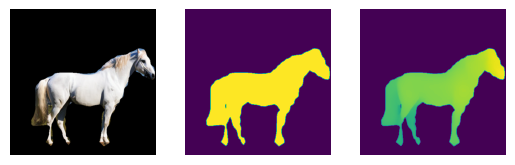

 41%|████████████████████████████▍                                         | 244/600 [00:02<00:03, 116.61it/s]

tensor(0.2815, device='cuda:0') tensor(0.5337, device='cuda:0')
tensor(0.2210, device='cuda:0') tensor(0.5339, device='cuda:0')
tensor(0.2175, device='cuda:0') tensor(0.5339, device='cuda:0')
tensor(0.2176, device='cuda:0') tensor(0.5339, device='cuda:0')
tensor(0.2176, device='cuda:0') tensor(0.5342, device='cuda:0')
tensor(0.2176, device='cuda:0') tensor(0.5341, device='cuda:0')
tensor(0.2175, device='cuda:0') tensor(0.5339, device='cuda:0')
tensor(0.2175, device='cuda:0') tensor(0.5332, device='cuda:0')
tensor(0.2175, device='cuda:0') tensor(0.5329, device='cuda:0')
tensor(0.2177, device='cuda:0') tensor(0.5324, device='cuda:0')
tensor(0.2177, device='cuda:0') tensor(0.5317, device='cuda:0')
tensor(0.2179, device='cuda:0') tensor(0.5308, device='cuda:0')
tensor(0.2181, device='cuda:0') tensor(0.5302, device='cuda:0')
tensor(0.2181, device='cuda:0') tensor(0.5293, device='cuda:0')
tensor(0.2184, device='cuda:0') tensor(0.5293, device='cuda:0')
tensor(0.2186, device='cuda:0') tensor(0

 45%|███████████████████████████████▍                                      | 269/600 [00:02<00:02, 118.27it/s]

tensor(0.2222, device='cuda:0') tensor(0.5402, device='cuda:0')
tensor(0.2225, device='cuda:0') tensor(0.5460, device='cuda:0')
tensor(0.2228, device='cuda:0') tensor(0.5543, device='cuda:0')
tensor(0.2232, device='cuda:0') tensor(0.5680, device='cuda:0')
tensor(0.2236, device='cuda:0') tensor(0.5925, device='cuda:0')
tensor(0.2239, device='cuda:0') tensor(0.6270, device='cuda:0')
tensor(0.2243, device='cuda:0') tensor(0.6281, device='cuda:0')
tensor(0.2246, device='cuda:0') tensor(0.6278, device='cuda:0')
tensor(0.2251, device='cuda:0') tensor(0.6277, device='cuda:0')
tensor(0.2258, device='cuda:0') tensor(0.6275, device='cuda:0')
tensor(0.2264, device='cuda:0') tensor(0.6273, device='cuda:0')
tensor(0.2270, device='cuda:0') tensor(0.6243, device='cuda:0')
tensor(0.2283, device='cuda:0') tensor(0.6154, device='cuda:0')
tensor(0.2292, device='cuda:0') tensor(0.6067, device='cuda:0')
tensor(0.2301, device='cuda:0') tensor(0.5970, device='cuda:0')
tensor(0.2308, device='cuda:0') tensor(0

 49%|██████████████████████████████████▎                                   | 294/600 [00:02<00:02, 118.95it/s]

tensor(0.2373, device='cuda:0') tensor(0.4555, device='cuda:0')
tensor(0.2375, device='cuda:0') tensor(0.4555, device='cuda:0')
tensor(0.2377, device='cuda:0') tensor(0.4555, device='cuda:0')
tensor(0.2377, device='cuda:0') tensor(0.4554, device='cuda:0')
tensor(0.2378, device='cuda:0') tensor(0.4555, device='cuda:0')
tensor(0.2376, device='cuda:0') tensor(0.4554, device='cuda:0')
tensor(0.2374, device='cuda:0') tensor(0.4554, device='cuda:0')
tensor(0.2370, device='cuda:0') tensor(0.4553, device='cuda:0')
tensor(0.2366, device='cuda:0') tensor(0.4553, device='cuda:0')
tensor(0.2363, device='cuda:0') tensor(0.4553, device='cuda:0')
tensor(0.2358, device='cuda:0') tensor(0.4553, device='cuda:0')
tensor(0.2353, device='cuda:0') tensor(0.4553, device='cuda:0')
tensor(0.2351, device='cuda:0') tensor(0.4553, device='cuda:0')
tensor(0.2348, device='cuda:0') tensor(0.4552, device='cuda:0')
tensor(0.2344, device='cuda:0') tensor(0.4551, device='cuda:0')
tensor(0.2339, device='cuda:0') tensor(0

 53%|█████████████████████████████████████                                 | 318/600 [00:02<00:02, 118.54it/s]

tensor(0.2338, device='cuda:0') tensor(0.4548, device='cuda:0')
tensor(0.2338, device='cuda:0') tensor(0.4548, device='cuda:0')
tensor(0.2337, device='cuda:0') tensor(0.4547, device='cuda:0')
tensor(0.2336, device='cuda:0') tensor(0.4547, device='cuda:0')
tensor(0.2336, device='cuda:0') tensor(0.4547, device='cuda:0')
tensor(0.2337, device='cuda:0') tensor(0.4546, device='cuda:0')
tensor(0.2334, device='cuda:0') tensor(0.4545, device='cuda:0')
tensor(0.2331, device='cuda:0') tensor(0.4545, device='cuda:0')
tensor(0.2330, device='cuda:0') tensor(0.4545, device='cuda:0')
tensor(0.2328, device='cuda:0') tensor(0.4545, device='cuda:0')
tensor(0.2326, device='cuda:0') tensor(0.4546, device='cuda:0')
tensor(0.2323, device='cuda:0') tensor(0.4546, device='cuda:0')
tensor(0.2322, device='cuda:0') tensor(0.4546, device='cuda:0')
tensor(0.2322, device='cuda:0') tensor(0.4547, device='cuda:0')
tensor(0.2321, device='cuda:0') tensor(0.4549, device='cuda:0')
tensor(0.2320, device='cuda:0') tensor(0

 57%|███████████████████████████████████████▉                              | 342/600 [00:02<00:02, 117.51it/s]

tensor(0.2315, device='cuda:0') tensor(0.4555, device='cuda:0')
tensor(0.2317, device='cuda:0') tensor(0.4555, device='cuda:0')
tensor(0.2314, device='cuda:0') tensor(0.4556, device='cuda:0')
tensor(0.2313, device='cuda:0') tensor(0.4557, device='cuda:0')
tensor(0.2310, device='cuda:0') tensor(0.4558, device='cuda:0')
tensor(0.2307, device='cuda:0') tensor(0.4557, device='cuda:0')
tensor(0.2304, device='cuda:0') tensor(0.4557, device='cuda:0')
tensor(0.2299, device='cuda:0') tensor(0.4558, device='cuda:0')
tensor(0.2294, device='cuda:0') tensor(0.4560, device='cuda:0')
tensor(0.2286, device='cuda:0') tensor(0.4560, device='cuda:0')
tensor(0.2281, device='cuda:0') tensor(0.4561, device='cuda:0')
tensor(0.2276, device='cuda:0') tensor(0.4569, device='cuda:0')
tensor(0.2270, device='cuda:0') tensor(0.4836, device='cuda:0')
tensor(0.2262, device='cuda:0') tensor(0.5076, device='cuda:0')
tensor(0.2255, device='cuda:0') tensor(0.5282, device='cuda:0')
tensor(0.2251, device='cuda:0') tensor(0

 61%|██████████████████████████████████████████▋                           | 366/600 [00:03<00:01, 117.36it/s]

tensor(0.2212, device='cuda:0') tensor(0.6260, device='cuda:0')
tensor(0.2211, device='cuda:0') tensor(0.6264, device='cuda:0')
tensor(0.2207, device='cuda:0') tensor(0.6255, device='cuda:0')
tensor(0.2206, device='cuda:0') tensor(0.6154, device='cuda:0')
tensor(0.2202, device='cuda:0') tensor(0.6084, device='cuda:0')
tensor(0.2197, device='cuda:0') tensor(0.5978, device='cuda:0')
tensor(0.2193, device='cuda:0') tensor(0.5837, device='cuda:0')
tensor(0.2190, device='cuda:0') tensor(0.5684, device='cuda:0')
tensor(0.2187, device='cuda:0') tensor(0.5587, device='cuda:0')
tensor(0.2182, device='cuda:0') tensor(0.5524, device='cuda:0')
tensor(0.2180, device='cuda:0') tensor(0.5470, device='cuda:0')
tensor(0.2176, device='cuda:0') tensor(0.5457, device='cuda:0')
tensor(0.2174, device='cuda:0') tensor(0.5455, device='cuda:0')
tensor(0.2171, device='cuda:0') tensor(0.5457, device='cuda:0')
tensor(0.2170, device='cuda:0') tensor(0.5456, device='cuda:0')
tensor(0.2165, device='cuda:0') tensor(0

 65%|█████████████████████████████████████████████▌                        | 390/600 [00:03<00:01, 116.46it/s]

tensor(0.2169, device='cuda:0') tensor(0.5521, device='cuda:0')
tensor(0.2169, device='cuda:0') tensor(0.5527, device='cuda:0')
tensor(0.2173, device='cuda:0') tensor(0.5529, device='cuda:0')
tensor(0.2174, device='cuda:0') tensor(0.5532, device='cuda:0')
tensor(0.2177, device='cuda:0') tensor(0.5527, device='cuda:0')
tensor(0.2182, device='cuda:0') tensor(0.5528, device='cuda:0')
tensor(0.2183, device='cuda:0') tensor(0.5525, device='cuda:0')
tensor(0.2230, device='cuda:0') tensor(0.5523, device='cuda:0')
tensor(0.2640, device='cuda:0') tensor(0.5519, device='cuda:0')
tensor(0.2930, device='cuda:0') tensor(0.5517, device='cuda:0')


100%|███████████████████████████████████████████████████████████████████████| 600/600 [00:06<00:00, 99.71it/s]


/grogu/user/akirchme/art3d_sd_webui/images/horse/1143.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/1143.mp4


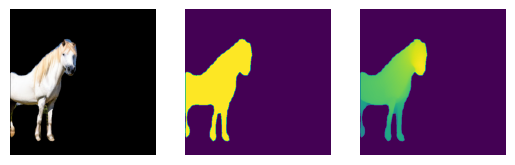

 39%|███████████████████████████▉                                           | 236/600 [00:02<00:03, 93.50it/s]

tensor(0.2837, device='cuda:0') tensor(0.5443, device='cuda:0')
tensor(0.2129, device='cuda:0') tensor(0.5448, device='cuda:0')
tensor(0.1669, device='cuda:0') tensor(0.5449, device='cuda:0')
tensor(0.1659, device='cuda:0') tensor(0.5453, device='cuda:0')
tensor(0.1660, device='cuda:0') tensor(0.5453, device='cuda:0')
tensor(0.1657, device='cuda:0') tensor(0.5452, device='cuda:0')
tensor(0.1658, device='cuda:0') tensor(0.5451, device='cuda:0')
tensor(0.1659, device='cuda:0') tensor(0.5449, device='cuda:0')
tensor(0.1659, device='cuda:0') tensor(0.5445, device='cuda:0')
tensor(0.1658, device='cuda:0') tensor(0.5438, device='cuda:0')
tensor(0.1660, device='cuda:0') tensor(0.5430, device='cuda:0')
tensor(0.1659, device='cuda:0') tensor(0.5422, device='cuda:0')
tensor(0.1659, device='cuda:0') tensor(0.5418, device='cuda:0')
tensor(0.1661, device='cuda:0') tensor(0.5411, device='cuda:0')
tensor(0.1660, device='cuda:0') tensor(0.5406, device='cuda:0')
tensor(0.1662, device='cuda:0') tensor(0

 43%|██████████████████████████████▎                                       | 260/600 [00:03<00:03, 106.25it/s]

tensor(0.1668, device='cuda:0') tensor(0.5390, device='cuda:0')
tensor(0.1672, device='cuda:0') tensor(0.5427, device='cuda:0')
tensor(0.1676, device='cuda:0') tensor(0.5498, device='cuda:0')
tensor(0.1681, device='cuda:0') tensor(0.5672, device='cuda:0')
tensor(0.1688, device='cuda:0') tensor(0.6107, device='cuda:0')
tensor(0.1695, device='cuda:0') tensor(0.6420, device='cuda:0')
tensor(0.1701, device='cuda:0') tensor(0.6820, device='cuda:0')
tensor(0.1709, device='cuda:0') tensor(0.6959, device='cuda:0')
tensor(0.1714, device='cuda:0') tensor(0.6957, device='cuda:0')
tensor(0.1726, device='cuda:0') tensor(0.6952, device='cuda:0')
tensor(0.1731, device='cuda:0') tensor(0.6948, device='cuda:0')
tensor(0.1741, device='cuda:0') tensor(0.6946, device='cuda:0')
tensor(0.1747, device='cuda:0') tensor(0.6942, device='cuda:0')
tensor(0.1757, device='cuda:0') tensor(0.6933, device='cuda:0')
tensor(0.1767, device='cuda:0') tensor(0.6895, device='cuda:0')
tensor(0.1777, device='cuda:0') tensor(0

 47%|█████████████████████████████████▏                                    | 284/600 [00:03<00:02, 112.34it/s]

tensor(0.1892, device='cuda:0') tensor(0.4336, device='cuda:0')
tensor(0.1896, device='cuda:0') tensor(0.4335, device='cuda:0')
tensor(0.1901, device='cuda:0') tensor(0.4336, device='cuda:0')
tensor(0.1904, device='cuda:0') tensor(0.4336, device='cuda:0')
tensor(0.1908, device='cuda:0') tensor(0.4336, device='cuda:0')
tensor(0.1909, device='cuda:0') tensor(0.4337, device='cuda:0')
tensor(0.1908, device='cuda:0') tensor(0.4341, device='cuda:0')
tensor(0.1907, device='cuda:0') tensor(0.4343, device='cuda:0')
tensor(0.1906, device='cuda:0') tensor(0.4344, device='cuda:0')
tensor(0.1904, device='cuda:0') tensor(0.4347, device='cuda:0')
tensor(0.1897, device='cuda:0') tensor(0.4350, device='cuda:0')
tensor(0.1891, device='cuda:0') tensor(0.4351, device='cuda:0')
tensor(0.1880, device='cuda:0') tensor(0.4353, device='cuda:0')
tensor(0.1868, device='cuda:0') tensor(0.4356, device='cuda:0')
tensor(0.1856, device='cuda:0') tensor(0.4358, device='cuda:0')
tensor(0.1846, device='cuda:0') tensor(0

 52%|████████████████████████████████████                                  | 309/600 [00:03<00:02, 116.42it/s]

tensor(0.1789, device='cuda:0') tensor(0.4375, device='cuda:0')
tensor(0.1784, device='cuda:0') tensor(0.4377, device='cuda:0')
tensor(0.1779, device='cuda:0') tensor(0.4378, device='cuda:0')
tensor(0.1769, device='cuda:0') tensor(0.4380, device='cuda:0')
tensor(0.1765, device='cuda:0') tensor(0.4379, device='cuda:0')
tensor(0.1761, device='cuda:0') tensor(0.4381, device='cuda:0')
tensor(0.1753, device='cuda:0') tensor(0.4381, device='cuda:0')
tensor(0.1749, device='cuda:0') tensor(0.4383, device='cuda:0')
tensor(0.1745, device='cuda:0') tensor(0.4384, device='cuda:0')
tensor(0.1741, device='cuda:0') tensor(0.4385, device='cuda:0')
tensor(0.1735, device='cuda:0') tensor(0.4387, device='cuda:0')
tensor(0.1729, device='cuda:0') tensor(0.4389, device='cuda:0')
tensor(0.1721, device='cuda:0') tensor(0.4388, device='cuda:0')
tensor(0.1716, device='cuda:0') tensor(0.4388, device='cuda:0')
tensor(0.1713, device='cuda:0') tensor(0.4389, device='cuda:0')
tensor(0.1709, device='cuda:0') tensor(0

 56%|██████████████████████████████████████▊                               | 333/600 [00:03<00:02, 116.82it/s]

tensor(0.1700, device='cuda:0') tensor(0.4395, device='cuda:0')
tensor(0.1698, device='cuda:0') tensor(0.4396, device='cuda:0')
tensor(0.1697, device='cuda:0') tensor(0.4397, device='cuda:0')
tensor(0.1694, device='cuda:0') tensor(0.4396, device='cuda:0')
tensor(0.1696, device='cuda:0') tensor(0.4397, device='cuda:0')
tensor(0.1694, device='cuda:0') tensor(0.4398, device='cuda:0')
tensor(0.1693, device='cuda:0') tensor(0.4399, device='cuda:0')
tensor(0.1692, device='cuda:0') tensor(0.4399, device='cuda:0')
tensor(0.1688, device='cuda:0') tensor(0.4398, device='cuda:0')
tensor(0.1682, device='cuda:0') tensor(0.4397, device='cuda:0')
tensor(0.1679, device='cuda:0') tensor(0.4398, device='cuda:0')
tensor(0.1672, device='cuda:0') tensor(0.4398, device='cuda:0')
tensor(0.1670, device='cuda:0') tensor(0.4399, device='cuda:0')
tensor(0.1668, device='cuda:0') tensor(0.4399, device='cuda:0')
tensor(0.1663, device='cuda:0') tensor(0.4424, device='cuda:0')
tensor(0.1656, device='cuda:0') tensor(0

 60%|█████████████████████████████████████████▉                            | 359/600 [00:03<00:02, 119.49it/s]

tensor(0.1628, device='cuda:0') tensor(0.5718, device='cuda:0')
tensor(0.1623, device='cuda:0') tensor(0.5738, device='cuda:0')
tensor(0.1618, device='cuda:0') tensor(0.5760, device='cuda:0')
tensor(0.1616, device='cuda:0') tensor(0.5767, device='cuda:0')
tensor(0.1610, device='cuda:0') tensor(0.5768, device='cuda:0')
tensor(0.1609, device='cuda:0') tensor(0.5749, device='cuda:0')
tensor(0.1604, device='cuda:0') tensor(0.5672, device='cuda:0')
tensor(0.1601, device='cuda:0') tensor(0.5588, device='cuda:0')
tensor(0.1596, device='cuda:0') tensor(0.5535, device='cuda:0')
tensor(0.1593, device='cuda:0') tensor(0.5489, device='cuda:0')
tensor(0.1593, device='cuda:0') tensor(0.5449, device='cuda:0')
tensor(0.1590, device='cuda:0') tensor(0.5396, device='cuda:0')
tensor(0.1590, device='cuda:0') tensor(0.5312, device='cuda:0')
tensor(0.1589, device='cuda:0') tensor(0.5287, device='cuda:0')
tensor(0.1585, device='cuda:0') tensor(0.5272, device='cuda:0')
tensor(0.1583, device='cuda:0') tensor(0

 64%|████████████████████████████████████████████▊                         | 384/600 [00:04<00:01, 119.72it/s]

tensor(0.1593, device='cuda:0') tensor(0.5254, device='cuda:0')
tensor(0.1593, device='cuda:0') tensor(0.5254, device='cuda:0')
tensor(0.1592, device='cuda:0') tensor(0.5252, device='cuda:0')
tensor(0.1596, device='cuda:0') tensor(0.5249, device='cuda:0')
tensor(0.1598, device='cuda:0') tensor(0.5244, device='cuda:0')
tensor(0.1600, device='cuda:0') tensor(0.5242, device='cuda:0')
tensor(0.1603, device='cuda:0') tensor(0.5238, device='cuda:0')
tensor(0.1604, device='cuda:0') tensor(0.5235, device='cuda:0')
tensor(0.1609, device='cuda:0') tensor(0.5235, device='cuda:0')
tensor(0.1695, device='cuda:0') tensor(0.5234, device='cuda:0')
tensor(0.2000, device='cuda:0') tensor(0.5235, device='cuda:0')
tensor(0.2172, device='cuda:0') tensor(0.5230, device='cuda:0')
tensor(0.2335, device='cuda:0') tensor(0.5227, device='cuda:0')
tensor(0.2549, device='cuda:0') tensor(0.5222, device='cuda:0')
tensor(0.2781, device='cuda:0') tensor(0.5218, device='cuda:0')
tensor(0.2928, device='cuda:0') tensor(0

100%|███████████████████████████████████████████████████████████████████████| 600/600 [00:06<00:00, 91.04it/s]


/grogu/user/akirchme/art3d_sd_webui/images/horse/600.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/600.mp4


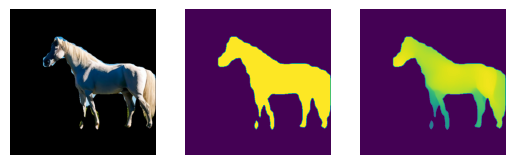

 47%|████████████████████████████████▉                                     | 282/600 [00:02<00:02, 120.93it/s]

tensor(0.3202, device='cuda:0') tensor(0.5185, device='cuda:0')
tensor(0.3210, device='cuda:0') tensor(0.5033, device='cuda:0')
tensor(0.3222, device='cuda:0') tensor(0.4952, device='cuda:0')
tensor(0.3231, device='cuda:0') tensor(0.4893, device='cuda:0')
tensor(0.3242, device='cuda:0') tensor(0.4894, device='cuda:0')
tensor(0.3251, device='cuda:0') tensor(0.4894, device='cuda:0')
tensor(0.3254, device='cuda:0') tensor(0.4894, device='cuda:0')
tensor(0.3255, device='cuda:0') tensor(0.4894, device='cuda:0')
tensor(0.3257, device='cuda:0') tensor(0.4894, device='cuda:0')
tensor(0.3255, device='cuda:0') tensor(0.4896, device='cuda:0')
tensor(0.3252, device='cuda:0') tensor(0.4897, device='cuda:0')
tensor(0.3249, device='cuda:0') tensor(0.4898, device='cuda:0')
tensor(0.3241, device='cuda:0') tensor(0.4899, device='cuda:0')
tensor(0.3234, device='cuda:0') tensor(0.4900, device='cuda:0')
tensor(0.3229, device='cuda:0') tensor(0.4899, device='cuda:0')
tensor(0.3222, device='cuda:0') tensor(0

 51%|███████████████████████████████████▉                                  | 308/600 [00:02<00:02, 121.75it/s]

tensor(0.3195, device='cuda:0') tensor(0.4904, device='cuda:0')
tensor(0.3196, device='cuda:0') tensor(0.4905, device='cuda:0')
tensor(0.3197, device='cuda:0') tensor(0.4904, device='cuda:0')
tensor(0.3196, device='cuda:0') tensor(0.4905, device='cuda:0')
tensor(0.3195, device='cuda:0') tensor(0.4906, device='cuda:0')
tensor(0.3195, device='cuda:0') tensor(0.4906, device='cuda:0')
tensor(0.3195, device='cuda:0') tensor(0.4905, device='cuda:0')
tensor(0.3196, device='cuda:0') tensor(0.4904, device='cuda:0')
tensor(0.3196, device='cuda:0') tensor(0.4905, device='cuda:0')
tensor(0.3194, device='cuda:0') tensor(0.4905, device='cuda:0')
tensor(0.3192, device='cuda:0') tensor(0.4904, device='cuda:0')
tensor(0.3188, device='cuda:0') tensor(0.4903, device='cuda:0')
tensor(0.3188, device='cuda:0') tensor(0.4904, device='cuda:0')
tensor(0.3185, device='cuda:0') tensor(0.4903, device='cuda:0')
tensor(0.3178, device='cuda:0') tensor(0.4903, device='cuda:0')
tensor(0.3173, device='cuda:0') tensor(0

 56%|██████████████████████████████████████▉                               | 334/600 [00:02<00:02, 120.63it/s]

tensor(0.3155, device='cuda:0') tensor(0.4892, device='cuda:0')
tensor(0.3159, device='cuda:0') tensor(0.4891, device='cuda:0')
tensor(0.3162, device='cuda:0') tensor(0.4889, device='cuda:0')
tensor(0.3166, device='cuda:0') tensor(0.4887, device='cuda:0')
tensor(0.3169, device='cuda:0') tensor(0.4888, device='cuda:0')
tensor(0.3170, device='cuda:0') tensor(0.4887, device='cuda:0')
tensor(0.3172, device='cuda:0') tensor(0.4887, device='cuda:0')
tensor(0.3176, device='cuda:0') tensor(0.4886, device='cuda:0')
tensor(0.3178, device='cuda:0') tensor(0.4885, device='cuda:0')
tensor(0.3186, device='cuda:0') tensor(0.4886, device='cuda:0')
tensor(0.3194, device='cuda:0') tensor(0.4885, device='cuda:0')
tensor(0.3202, device='cuda:0') tensor(0.4885, device='cuda:0')
tensor(0.3210, device='cuda:0') tensor(0.4883, device='cuda:0')
tensor(0.3215, device='cuda:0') tensor(0.4881, device='cuda:0')
tensor(0.3212, device='cuda:0') tensor(0.4880, device='cuda:0')
tensor(0.3209, device='cuda:0') tensor(0

 62%|███████████████████████████████████████████▌                          | 373/600 [00:03<00:01, 122.23it/s]

tensor(0.2998, device='cuda:0') tensor(0.5418, device='cuda:0')
tensor(0.2999, device='cuda:0') tensor(0.5413, device='cuda:0')
tensor(0.2997, device='cuda:0') tensor(0.5412, device='cuda:0')
tensor(0.2996, device='cuda:0') tensor(0.5409, device='cuda:0')
tensor(0.2995, device='cuda:0') tensor(0.5399, device='cuda:0')
tensor(0.2997, device='cuda:0') tensor(0.5392, device='cuda:0')
tensor(0.2996, device='cuda:0') tensor(0.5385, device='cuda:0')
tensor(0.2999, device='cuda:0') tensor(0.5383, device='cuda:0')


100%|██████████████████████████████████████████████████████████████████████| 600/600 [00:04<00:00, 121.91it/s]


/grogu/user/akirchme/art3d_sd_webui/images/horse/53.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/53.mp4


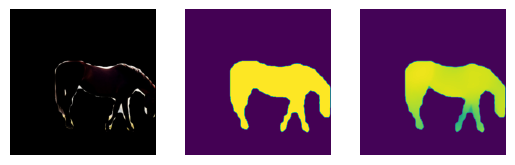

  2%|█▍                                                                     | 12/600 [00:00<00:05, 115.73it/s]

tensor(0.2848, device='cuda:0') tensor(0.4892, device='cuda:0')
tensor(0.2851, device='cuda:0') tensor(0.4893, device='cuda:0')
tensor(0.2856, device='cuda:0') tensor(0.4893, device='cuda:0')
tensor(0.2859, device='cuda:0') tensor(0.4894, device='cuda:0')
tensor(0.2862, device='cuda:0') tensor(0.4895, device='cuda:0')
tensor(0.2866, device='cuda:0') tensor(0.4895, device='cuda:0')
tensor(0.2871, device='cuda:0') tensor(0.4895, device='cuda:0')
tensor(0.2874, device='cuda:0') tensor(0.4895, device='cuda:0')
tensor(0.2879, device='cuda:0') tensor(0.4897, device='cuda:0')
tensor(0.2883, device='cuda:0') tensor(0.4898, device='cuda:0')
tensor(0.2886, device='cuda:0') tensor(0.4897, device='cuda:0')
tensor(0.2889, device='cuda:0') tensor(0.4898, device='cuda:0')
tensor(0.2893, device='cuda:0') tensor(0.4898, device='cuda:0')
tensor(0.2896, device='cuda:0') tensor(0.4898, device='cuda:0')
tensor(0.2901, device='cuda:0') tensor(0.4897, device='cuda:0')
tensor(0.2905, device='cuda:0') tensor(0

  6%|████▍                                                                  | 37/600 [00:00<00:04, 119.00it/s]

tensor(0.2925, device='cuda:0') tensor(0.4895, device='cuda:0')
tensor(0.2925, device='cuda:0') tensor(0.4894, device='cuda:0')
tensor(0.2925, device='cuda:0') tensor(0.4894, device='cuda:0')
tensor(0.2925, device='cuda:0') tensor(0.4894, device='cuda:0')
tensor(0.2925, device='cuda:0') tensor(0.4895, device='cuda:0')
tensor(0.2925, device='cuda:0') tensor(0.4895, device='cuda:0')
tensor(0.2925, device='cuda:0') tensor(0.4895, device='cuda:0')
tensor(0.2922, device='cuda:0') tensor(0.4894, device='cuda:0')
tensor(0.2920, device='cuda:0') tensor(0.4902, device='cuda:0')
tensor(0.2918, device='cuda:0') tensor(0.5584, device='cuda:0')
tensor(0.2915, device='cuda:0') tensor(0.6082, device='cuda:0')
tensor(0.2910, device='cuda:0') tensor(0.6334, device='cuda:0')
tensor(0.2908, device='cuda:0') tensor(0.6523, device='cuda:0')
tensor(0.2904, device='cuda:0') tensor(0.6639, device='cuda:0')
tensor(0.2901, device='cuda:0') tensor(0.6717, device='cuda:0')
tensor(0.2897, device='cuda:0') tensor(0

 10%|███████▎                                                               | 62/600 [00:00<00:04, 119.70it/s]

tensor(0.2858, device='cuda:0') tensor(0.6316, device='cuda:0')
tensor(0.2854, device='cuda:0') tensor(0.6168, device='cuda:0')
tensor(0.2850, device='cuda:0') tensor(0.6113, device='cuda:0')
tensor(0.2847, device='cuda:0') tensor(0.6084, device='cuda:0')
tensor(0.2842, device='cuda:0') tensor(0.6064, device='cuda:0')
tensor(0.2838, device='cuda:0') tensor(0.6040, device='cuda:0')
tensor(0.2837, device='cuda:0') tensor(0.6029, device='cuda:0')
tensor(0.2834, device='cuda:0') tensor(0.6025, device='cuda:0')
tensor(0.2830, device='cuda:0') tensor(0.6024, device='cuda:0')
tensor(0.2826, device='cuda:0') tensor(0.6024, device='cuda:0')
tensor(0.2823, device='cuda:0') tensor(0.6021, device='cuda:0')
tensor(0.2822, device='cuda:0') tensor(0.6020, device='cuda:0')
tensor(0.2820, device='cuda:0') tensor(0.6021, device='cuda:0')
tensor(0.2817, device='cuda:0') tensor(0.6019, device='cuda:0')
tensor(0.2815, device='cuda:0') tensor(0.6020, device='cuda:0')
tensor(0.2812, device='cuda:0') tensor(0

 14%|██████████▎                                                            | 87/600 [00:00<00:04, 122.37it/s]

tensor(0.2809, device='cuda:0') tensor(0.6006, device='cuda:0')
tensor(0.2809, device='cuda:0') tensor(0.6004, device='cuda:0')
tensor(0.2918, device='cuda:0') tensor(0.6002, device='cuda:0')


 47%|█████████████████████████████████▏                                    | 284/600 [00:02<00:02, 122.97it/s]

tensor(0.3763, device='cuda:0') tensor(0.5129, device='cuda:0')
tensor(0.3766, device='cuda:0') tensor(0.5127, device='cuda:0')
tensor(0.3769, device='cuda:0') tensor(0.5128, device='cuda:0')
tensor(0.3772, device='cuda:0') tensor(0.5127, device='cuda:0')
tensor(0.3773, device='cuda:0') tensor(0.5126, device='cuda:0')
tensor(0.3774, device='cuda:0') tensor(0.5125, device='cuda:0')
tensor(0.3774, device='cuda:0') tensor(0.5125, device='cuda:0')
tensor(0.3774, device='cuda:0') tensor(0.5126, device='cuda:0')
tensor(0.3775, device='cuda:0') tensor(0.5126, device='cuda:0')
tensor(0.3773, device='cuda:0') tensor(0.5125, device='cuda:0')
tensor(0.3771, device='cuda:0') tensor(0.5125, device='cuda:0')
tensor(0.3767, device='cuda:0') tensor(0.5124, device='cuda:0')
tensor(0.3766, device='cuda:0') tensor(0.5123, device='cuda:0')
tensor(0.3764, device='cuda:0') tensor(0.5123, device='cuda:0')
tensor(0.3761, device='cuda:0') tensor(0.5121, device='cuda:0')
tensor(0.3756, device='cuda:0') tensor(0

 52%|████████████████████████████████████▏                                 | 310/600 [00:02<00:02, 120.69it/s]

tensor(0.3741, device='cuda:0') tensor(0.5110, device='cuda:0')
tensor(0.3741, device='cuda:0') tensor(0.5109, device='cuda:0')
tensor(0.3742, device='cuda:0') tensor(0.5107, device='cuda:0')
tensor(0.3742, device='cuda:0') tensor(0.5104, device='cuda:0')
tensor(0.3742, device='cuda:0') tensor(0.5104, device='cuda:0')
tensor(0.3741, device='cuda:0') tensor(0.5103, device='cuda:0')
tensor(0.3741, device='cuda:0') tensor(0.5101, device='cuda:0')
tensor(0.3738, device='cuda:0') tensor(0.5099, device='cuda:0')
tensor(0.3739, device='cuda:0') tensor(0.5099, device='cuda:0')
tensor(0.3738, device='cuda:0') tensor(0.5098, device='cuda:0')
tensor(0.3738, device='cuda:0') tensor(0.5097, device='cuda:0')
tensor(0.3738, device='cuda:0') tensor(0.5098, device='cuda:0')
tensor(0.3737, device='cuda:0') tensor(0.5096, device='cuda:0')
tensor(0.3737, device='cuda:0') tensor(0.5096, device='cuda:0')
tensor(0.3735, device='cuda:0') tensor(0.5096, device='cuda:0')
tensor(0.3734, device='cuda:0') tensor(0

 56%|███████████████████████████████████████▏                              | 336/600 [00:02<00:02, 119.94it/s]

tensor(0.3736, device='cuda:0') tensor(0.5088, device='cuda:0')
tensor(0.3736, device='cuda:0') tensor(0.5088, device='cuda:0')
tensor(0.3739, device='cuda:0') tensor(0.5088, device='cuda:0')
tensor(0.3739, device='cuda:0') tensor(0.5087, device='cuda:0')
tensor(0.3738, device='cuda:0') tensor(0.5087, device='cuda:0')
tensor(0.3738, device='cuda:0') tensor(0.5087, device='cuda:0')
tensor(0.3738, device='cuda:0') tensor(0.5087, device='cuda:0')
tensor(0.3737, device='cuda:0') tensor(0.5087, device='cuda:0')
tensor(0.3738, device='cuda:0') tensor(0.5087, device='cuda:0')
tensor(0.3737, device='cuda:0') tensor(0.5087, device='cuda:0')
tensor(0.3737, device='cuda:0') tensor(0.5087, device='cuda:0')
tensor(0.3736, device='cuda:0') tensor(0.5088, device='cuda:0')
tensor(0.3735, device='cuda:0') tensor(0.5088, device='cuda:0')
tensor(0.3734, device='cuda:0') tensor(0.5087, device='cuda:0')
tensor(0.3732, device='cuda:0') tensor(0.5088, device='cuda:0')
tensor(0.3731, device='cuda:0') tensor(0

 89%|██████████████████████████████████████████████████████████████▏       | 533/600 [00:04<00:00, 124.15it/s]

tensor(0.3986, device='cuda:0') tensor(0.5056, device='cuda:0')
tensor(0.3981, device='cuda:0') tensor(0.5035, device='cuda:0')
tensor(0.3974, device='cuda:0') tensor(0.5035, device='cuda:0')
tensor(0.3958, device='cuda:0') tensor(0.5035, device='cuda:0')
tensor(0.3939, device='cuda:0') tensor(0.5036, device='cuda:0')
tensor(0.3886, device='cuda:0') tensor(0.5037, device='cuda:0')
tensor(0.3681, device='cuda:0') tensor(0.5037, device='cuda:0')
tensor(0.2960, device='cuda:0') tensor(0.5038, device='cuda:0')
tensor(0.2775, device='cuda:0') tensor(0.5040, device='cuda:0')
tensor(0.2774, device='cuda:0') tensor(0.5042, device='cuda:0')
tensor(0.2771, device='cuda:0') tensor(0.5045, device='cuda:0')
tensor(0.2768, device='cuda:0') tensor(0.5046, device='cuda:0')
tensor(0.2765, device='cuda:0') tensor(0.5047, device='cuda:0')
tensor(0.2764, device='cuda:0') tensor(0.5049, device='cuda:0')
tensor(0.2763, device='cuda:0') tensor(0.5052, device='cuda:0')
tensor(0.2760, device='cuda:0') tensor(0

 93%|█████████████████████████████████████████████████████████████████▏    | 559/600 [00:04<00:00, 121.51it/s]

tensor(0.5112, device='cuda:0')
tensor(0.2751, device='cuda:0') tensor(0.5122, device='cuda:0')
tensor(0.2753, device='cuda:0') tensor(0.5135, device='cuda:0')
tensor(0.2753, device='cuda:0') tensor(0.5147, device='cuda:0')
tensor(0.2751, device='cuda:0') tensor(0.5153, device='cuda:0')
tensor(0.2752, device='cuda:0') tensor(0.5170, device='cuda:0')
tensor(0.2754, device='cuda:0') tensor(0.5184, device='cuda:0')
tensor(0.2755, device='cuda:0') tensor(0.5207, device='cuda:0')
tensor(0.2755, device='cuda:0') tensor(0.5219, device='cuda:0')
tensor(0.2755, device='cuda:0') tensor(0.5235, device='cuda:0')
tensor(0.2756, device='cuda:0') tensor(0.5285, device='cuda:0')
tensor(0.2755, device='cuda:0') tensor(0.5442, device='cuda:0')
tensor(0.2757, device='cuda:0') tensor(0.5983, device='cuda:0')
tensor(0.2757, device='cuda:0') tensor(0.6066, device='cuda:0')
tensor(0.2757, device='cuda:0') tensor(0.6066, device='cuda:0')
tensor(0.2758, device='cuda:0') tensor(0.6067, device='cuda:0')
tensor(0

 98%|████████████████████████████████████████████████████████████████████▎ | 585/600 [00:04<00:00, 121.45it/s]

tensor(0.2774, device='cuda:0') tensor(0.5960, device='cuda:0')
tensor(0.2776, device='cuda:0') tensor(0.5835, device='cuda:0')
tensor(0.2778, device='cuda:0') tensor(0.5553, device='cuda:0')
tensor(0.2778, device='cuda:0') tensor(0.4882, device='cuda:0')
tensor(0.2782, device='cuda:0') tensor(0.4869, device='cuda:0')
tensor(0.2783, device='cuda:0') tensor(0.4870, device='cuda:0')
tensor(0.2785, device='cuda:0') tensor(0.4871, device='cuda:0')
tensor(0.2786, device='cuda:0') tensor(0.4871, device='cuda:0')
tensor(0.2788, device='cuda:0') tensor(0.4872, device='cuda:0')
tensor(0.2789, device='cuda:0') tensor(0.4875, device='cuda:0')
tensor(0.2789, device='cuda:0') tensor(0.4877, device='cuda:0')
tensor(0.2790, device='cuda:0') tensor(0.4878, device='cuda:0')
tensor(0.2791, device='cuda:0') tensor(0.4880, device='cuda:0')
tensor(0.2793, device='cuda:0') tensor(0.4881, device='cuda:0')
tensor(0.2793, device='cuda:0') tensor(0.4881, device='cuda:0')
tensor(0.2794, device='cuda:0') tensor(0

100%|██████████████████████████████████████████████████████████████████████| 600/600 [00:04<00:00, 124.10it/s]


tensor(0.2811, device='cuda:0') tensor(0.4883, device='cuda:0')
tensor(0.2813, device='cuda:0') tensor(0.4883, device='cuda:0')
tensor(0.2816, device='cuda:0') tensor(0.4883, device='cuda:0')
tensor(0.2819, device='cuda:0') tensor(0.4884, device='cuda:0')
tensor(0.2824, device='cuda:0') tensor(0.4886, device='cuda:0')
tensor(0.2827, device='cuda:0') tensor(0.4887, device='cuda:0')
tensor(0.2831, device='cuda:0') tensor(0.4888, device='cuda:0')
tensor(0.2834, device='cuda:0') tensor(0.4888, device='cuda:0')
tensor(0.2840, device='cuda:0') tensor(0.4890, device='cuda:0')
tensor(0.2844, device='cuda:0') tensor(0.4891, device='cuda:0')
/grogu/user/akirchme/art3d_sd_webui/images/horse/1522.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/1522.mp4


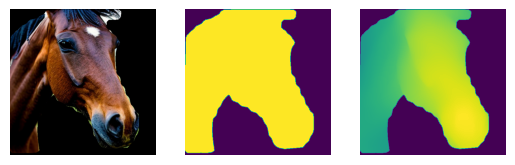

  4%|██▋                                                                    | 23/600 [00:00<00:05, 113.09it/s]

tensor(0.3898, device='cuda:0') tensor(0.5177, device='cuda:0')
tensor(0.3870, device='cuda:0') tensor(0.5177, device='cuda:0')
tensor(0.3834, device='cuda:0') tensor(0.5176, device='cuda:0')
tensor(0.3798, device='cuda:0') tensor(0.5174, device='cuda:0')
tensor(0.3745, device='cuda:0') tensor(0.5174, device='cuda:0')
tensor(0.3708, device='cuda:0') tensor(0.5172, device='cuda:0')
tensor(0.3678, device='cuda:0') tensor(0.5172, device='cuda:0')
tensor(0.3650, device='cuda:0') tensor(0.5170, device='cuda:0')
tensor(0.3626, device='cuda:0') tensor(0.5170, device='cuda:0')
tensor(0.3599, device='cuda:0') tensor(0.5169, device='cuda:0')
tensor(0.3579, device='cuda:0') tensor(0.5168, device='cuda:0')
tensor(0.3560, device='cuda:0') tensor(0.5169, device='cuda:0')
tensor(0.3543, device='cuda:0') tensor(0.5168, device='cuda:0')
tensor(0.3528, device='cuda:0') tensor(0.5169, device='cuda:0')
tensor(0.3523, device='cuda:0') tensor(0.5169, device='cuda:0')
tensor(0.3522, device='cuda:0') tensor(0

  6%|████▏                                                                  | 35/600 [00:00<00:04, 113.27it/s]

tensor(0.3521, device='cuda:0') tensor(0.5172, device='cuda:0')
tensor(0.3519, device='cuda:0') tensor(0.5171, device='cuda:0')
tensor(0.3515, device='cuda:0') tensor(0.5171, device='cuda:0')
tensor(0.3510, device='cuda:0') tensor(0.5172, device='cuda:0')
tensor(0.3504, device='cuda:0') tensor(0.5172, device='cuda:0')
tensor(0.3497, device='cuda:0') tensor(0.5173, device='cuda:0')
tensor(0.3489, device='cuda:0') tensor(0.5174, device='cuda:0')
tensor(0.3482, device='cuda:0') tensor(0.5175, device='cuda:0')
tensor(0.3473, device='cuda:0') tensor(0.5197, device='cuda:0')


 15%|██████████▋                                                             | 89/600 [00:01<00:05, 86.18it/s]

tensor(0.3139, device='cuda:0') tensor(0.5193, device='cuda:0')
tensor(0.3136, device='cuda:0') tensor(0.5182, device='cuda:0')
tensor(0.3137, device='cuda:0') tensor(0.5174, device='cuda:0')
tensor(0.3138, device='cuda:0') tensor(0.5168, device='cuda:0')
tensor(0.3137, device='cuda:0') tensor(0.5167, device='cuda:0')
tensor(0.3136, device='cuda:0') tensor(0.5164, device='cuda:0')
tensor(0.3137, device='cuda:0') tensor(0.5161, device='cuda:0')
tensor(0.3136, device='cuda:0') tensor(0.5159, device='cuda:0')
tensor(0.3137, device='cuda:0') tensor(0.5152, device='cuda:0')
tensor(0.3139, device='cuda:0') tensor(0.5150, device='cuda:0')
tensor(0.3189, device='cuda:0') tensor(0.5145, device='cuda:0')
tensor(0.3240, device='cuda:0') tensor(0.5142, device='cuda:0')
tensor(0.3312, device='cuda:0') tensor(0.5138, device='cuda:0')
tensor(0.3395, device='cuda:0') tensor(0.5135, device='cuda:0')
tensor(0.3450, device='cuda:0') tensor(0.5130, device='cuda:0')
tensor(0.3493, device='cuda:0') tensor(0

 41%|████████████████████████████▉                                          | 245/600 [00:03<00:04, 83.38it/s]

tensor(0.2959, device='cuda:0') tensor(0.5424, device='cuda:0')
tensor(0.2888, device='cuda:0') tensor(0.5462, device='cuda:0')
tensor(0.2845, device='cuda:0') tensor(0.5497, device='cuda:0')
tensor(0.2838, device='cuda:0') tensor(0.5531, device='cuda:0')
tensor(0.2834, device='cuda:0') tensor(0.5551, device='cuda:0')
tensor(0.2830, device='cuda:0') tensor(0.5558, device='cuda:0')
tensor(0.2826, device='cuda:0') tensor(0.5560, device='cuda:0')
tensor(0.2823, device='cuda:0') tensor(0.5558, device='cuda:0')
tensor(0.2821, device='cuda:0') tensor(0.5554, device='cuda:0')
tensor(0.2818, device='cuda:0') tensor(0.5542, device='cuda:0')
tensor(0.2812, device='cuda:0') tensor(0.5521, device='cuda:0')
tensor(0.2809, device='cuda:0') tensor(0.5486, device='cuda:0')
tensor(0.2807, device='cuda:0') tensor(0.5448, device='cuda:0')
tensor(0.2806, device='cuda:0') tensor(0.5409, device='cuda:0')
tensor(0.2806, device='cuda:0') tensor(0.5372, device='cuda:0')
tensor(0.2804, device='cuda:0') tensor(0

 43%|██████████████████████████████▍                                        | 257/600 [00:03<00:03, 90.96it/s]

tensor(0.2884, device='cuda:0') tensor(0.5538, device='cuda:0')
tensor(0.2900, device='cuda:0') tensor(0.5574, device='cuda:0')
tensor(0.2915, device='cuda:0') tensor(0.5598, device='cuda:0')
tensor(0.2929, device='cuda:0') tensor(0.5627, device='cuda:0')
tensor(0.2945, device='cuda:0') tensor(0.5646, device='cuda:0')
tensor(0.2959, device='cuda:0') tensor(0.5658, device='cuda:0')
tensor(0.2972, device='cuda:0') tensor(0.5674, device='cuda:0')
tensor(0.2984, device='cuda:0') tensor(0.5657, device='cuda:0')
tensor(0.2994, device='cuda:0') tensor(0.5638, device='cuda:0')


 46%|█████████████████████████████████                                      | 279/600 [00:03<00:03, 90.25it/s]

tensor(0.3147, device='cuda:0') tensor(0.5131, device='cuda:0')
tensor(0.3162, device='cuda:0') tensor(0.5082, device='cuda:0')
tensor(0.3179, device='cuda:0') tensor(0.5049, device='cuda:0')
tensor(0.3196, device='cuda:0') tensor(0.5024, device='cuda:0')
tensor(0.3214, device='cuda:0') tensor(0.5021, device='cuda:0')
tensor(0.3232, device='cuda:0') tensor(0.5018, device='cuda:0')
tensor(0.3250, device='cuda:0') tensor(0.5019, device='cuda:0')
tensor(0.3272, device='cuda:0') tensor(0.5019, device='cuda:0')
tensor(0.3292, device='cuda:0') tensor(0.5018, device='cuda:0')
tensor(0.3308, device='cuda:0') tensor(0.5017, device='cuda:0')
tensor(0.3326, device='cuda:0') tensor(0.5017, device='cuda:0')
tensor(0.3340, device='cuda:0') tensor(0.5016, device='cuda:0')
tensor(0.3353, device='cuda:0') tensor(0.5015, device='cuda:0')
tensor(0.3367, device='cuda:0') tensor(0.5014, device='cuda:0')
tensor(0.3377, device='cuda:0') tensor(0.5012, device='cuda:0')
tensor(0.3386, device='cuda:0') tensor(0

 50%|███████████████████████████████████▎                                  | 303/600 [00:04<00:02, 103.99it/s]

tensor(0.3466, device='cuda:0') tensor(0.5003, device='cuda:0')
tensor(0.3477, device='cuda:0') tensor(0.5000, device='cuda:0')
tensor(0.3486, device='cuda:0') tensor(0.4999, device='cuda:0')
tensor(0.3495, device='cuda:0') tensor(0.4997, device='cuda:0')
tensor(0.3505, device='cuda:0') tensor(0.4996, device='cuda:0')
tensor(0.3516, device='cuda:0') tensor(0.4994, device='cuda:0')
tensor(0.3526, device='cuda:0') tensor(0.4992, device='cuda:0')
tensor(0.3533, device='cuda:0') tensor(0.4992, device='cuda:0')
tensor(0.3543, device='cuda:0') tensor(0.4991, device='cuda:0')
tensor(0.3550, device='cuda:0') tensor(0.4990, device='cuda:0')
tensor(0.3558, device='cuda:0') tensor(0.4990, device='cuda:0')
tensor(0.3564, device='cuda:0') tensor(0.4989, device='cuda:0')
tensor(0.3568, device='cuda:0') tensor(0.4988, device='cuda:0')
tensor(0.3570, device='cuda:0') tensor(0.4988, device='cuda:0')
tensor(0.3573, device='cuda:0') tensor(0.4988, device='cuda:0')
tensor(0.3574, device='cuda:0') tensor(0

 55%|██████████████████████████████████████▏                               | 327/600 [00:04<00:02, 111.49it/s]

tensor(0.3623, device='cuda:0') tensor(0.4989, device='cuda:0')
tensor(0.3631, device='cuda:0') tensor(0.4990, device='cuda:0')
tensor(0.3640, device='cuda:0') tensor(0.4990, device='cuda:0')
tensor(0.3645, device='cuda:0') tensor(0.4992, device='cuda:0')
tensor(0.3648, device='cuda:0') tensor(0.4994, device='cuda:0')
tensor(0.3649, device='cuda:0') tensor(0.4996, device='cuda:0')
tensor(0.3648, device='cuda:0') tensor(0.4999, device='cuda:0')
tensor(0.3645, device='cuda:0') tensor(0.5001, device='cuda:0')
tensor(0.3641, device='cuda:0') tensor(0.5002, device='cuda:0')
tensor(0.3633, device='cuda:0') tensor(0.5004, device='cuda:0')
tensor(0.3623, device='cuda:0') tensor(0.5004, device='cuda:0')
tensor(0.3610, device='cuda:0') tensor(0.5005, device='cuda:0')
tensor(0.3597, device='cuda:0') tensor(0.5007, device='cuda:0')
tensor(0.3582, device='cuda:0') tensor(0.5008, device='cuda:0')
tensor(0.3565, device='cuda:0') tensor(0.5011, device='cuda:0')
tensor(0.3545, device='cuda:0') tensor(0

 62%|████████████████████████████████████████████                           | 372/600 [00:04<00:02, 89.39it/s]

tensor(0.3000, device='cuda:0') tensor(0.5585, device='cuda:0')
tensor(0.2984, device='cuda:0') tensor(0.5595, device='cuda:0')
tensor(0.2972, device='cuda:0') tensor(0.5613, device='cuda:0')
tensor(0.2959, device='cuda:0') tensor(0.5630, device='cuda:0')
tensor(0.2948, device='cuda:0') tensor(0.5649, device='cuda:0')
tensor(0.2940, device='cuda:0') tensor(0.5670, device='cuda:0')
tensor(0.2934, device='cuda:0') tensor(0.5695, device='cuda:0')
tensor(0.2931, device='cuda:0') tensor(0.5724, device='cuda:0')
tensor(0.2931, device='cuda:0') tensor(0.5758, device='cuda:0')
tensor(0.2928, device='cuda:0') tensor(0.5788, device='cuda:0')
tensor(0.2926, device='cuda:0') tensor(0.5817, device='cuda:0')
tensor(0.2924, device='cuda:0') tensor(0.5842, device='cuda:0')
tensor(0.2924, device='cuda:0') tensor(0.5868, device='cuda:0')
tensor(0.2925, device='cuda:0') tensor(0.5889, device='cuda:0')
tensor(0.2927, device='cuda:0') tensor(0.5902, device='cuda:0')
tensor(0.2927, device='cuda:0') tensor(0

 98%|█████████████████████████████████████████████████████████████████████▎ | 586/600 [00:08<00:00, 82.77it/s]

tensor(0.3786, device='cuda:0') tensor(0.5193, device='cuda:0')
tensor(0.3790, device='cuda:0') tensor(0.5190, device='cuda:0')
tensor(0.3794, device='cuda:0') tensor(0.5189, device='cuda:0')
tensor(0.3798, device='cuda:0') tensor(0.5187, device='cuda:0')
tensor(0.3803, device='cuda:0') tensor(0.5185, device='cuda:0')
tensor(0.3806, device='cuda:0') tensor(0.5183, device='cuda:0')
tensor(0.3810, device='cuda:0') tensor(0.5182, device='cuda:0')
tensor(0.3813, device='cuda:0') tensor(0.5180, device='cuda:0')
tensor(0.3818, device='cuda:0') tensor(0.5180, device='cuda:0')
tensor(0.3821, device='cuda:0') tensor(0.5179, device='cuda:0')
tensor(0.3823, device='cuda:0') tensor(0.5178, device='cuda:0')
tensor(0.3826, device='cuda:0') tensor(0.5178, device='cuda:0')
tensor(0.3829, device='cuda:0') tensor(0.5179, device='cuda:0')
tensor(0.3833, device='cuda:0') tensor(0.5179, device='cuda:0')
tensor(0.3835, device='cuda:0') tensor(0.5179, device='cuda:0')
tensor(0.3836, device='cuda:0') tensor(0

100%|███████████████████████████████████████████████████████████████████████| 600/600 [00:08<00:00, 69.87it/s]


tensor(0.3898, device='cuda:0') tensor(0.5180, device='cuda:0')
tensor(0.3910, device='cuda:0') tensor(0.5180, device='cuda:0')
tensor(0.3921, device='cuda:0') tensor(0.5180, device='cuda:0')
tensor(0.3925, device='cuda:0') tensor(0.5180, device='cuda:0')
tensor(0.3927, device='cuda:0') tensor(0.5180, device='cuda:0')
tensor(0.3927, device='cuda:0') tensor(0.5179, device='cuda:0')
tensor(0.3925, device='cuda:0') tensor(0.5179, device='cuda:0')
tensor(0.3916, device='cuda:0') tensor(0.5178, device='cuda:0')
/grogu/user/akirchme/art3d_sd_webui/images/horse/1950.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/1950.mp4


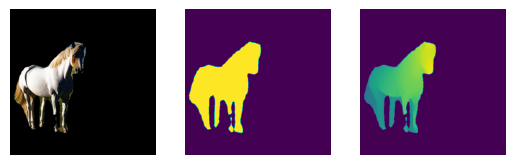

 39%|███████████████████████████▍                                          | 235/600 [00:01<00:03, 119.35it/s]

tensor(0.2838, device='cuda:0') tensor(0.5417, device='cuda:0')
tensor(0.2683, device='cuda:0') tensor(0.5430, device='cuda:0')
tensor(0.2524, device='cuda:0') tensor(0.5441, device='cuda:0')
tensor(0.2366, device='cuda:0') tensor(0.5442, device='cuda:0')
tensor(0.2286, device='cuda:0') tensor(0.5440, device='cuda:0')
tensor(0.2281, device='cuda:0') tensor(0.5438, device='cuda:0')
tensor(0.2279, device='cuda:0') tensor(0.5439, device='cuda:0')
tensor(0.2277, device='cuda:0') tensor(0.5420, device='cuda:0')
tensor(0.2277, device='cuda:0') tensor(0.5406, device='cuda:0')
tensor(0.2274, device='cuda:0') tensor(0.5394, device='cuda:0')
tensor(0.2273, device='cuda:0') tensor(0.5381, device='cuda:0')
tensor(0.2269, device='cuda:0') tensor(0.5363, device='cuda:0')
tensor(0.2262, device='cuda:0') tensor(0.5340, device='cuda:0')
tensor(0.2260, device='cuda:0') tensor(0.5312, device='cuda:0')
tensor(0.2261, device='cuda:0') tensor(0.5283, device='cuda:0')
tensor(0.2259, device='cuda:0') tensor(0

 43%|██████████████████████████████▎                                       | 260/600 [00:02<00:02, 119.69it/s]

tensor(0.2308, device='cuda:0') tensor(0.5114, device='cuda:0')
tensor(0.2320, device='cuda:0') tensor(0.5140, device='cuda:0')
tensor(0.2330, device='cuda:0') tensor(0.5165, device='cuda:0')
tensor(0.2344, device='cuda:0') tensor(0.5188, device='cuda:0')
tensor(0.2357, device='cuda:0') tensor(0.5204, device='cuda:0')
tensor(0.2369, device='cuda:0') tensor(0.5230, device='cuda:0')
tensor(0.2383, device='cuda:0') tensor(0.5271, device='cuda:0')
tensor(0.2397, device='cuda:0') tensor(0.5329, device='cuda:0')
tensor(0.2408, device='cuda:0') tensor(0.5337, device='cuda:0')
tensor(0.2416, device='cuda:0') tensor(0.5328, device='cuda:0')
tensor(0.2424, device='cuda:0') tensor(0.5316, device='cuda:0')
tensor(0.2437, device='cuda:0') tensor(0.5309, device='cuda:0')
tensor(0.2450, device='cuda:0') tensor(0.5305, device='cuda:0')
tensor(0.2469, device='cuda:0') tensor(0.5292, device='cuda:0')
tensor(0.2491, device='cuda:0') tensor(0.5264, device='cuda:0')
tensor(0.2510, device='cuda:0') tensor(0

 47%|█████████████████████████████████▏                                    | 284/600 [00:02<00:02, 118.30it/s]

tensor(0.2678, device='cuda:0') tensor(0.4353, device='cuda:0')
tensor(0.2692, device='cuda:0') tensor(0.4350, device='cuda:0')
tensor(0.2701, device='cuda:0') tensor(0.4348, device='cuda:0')
tensor(0.2715, device='cuda:0') tensor(0.4345, device='cuda:0')
tensor(0.2726, device='cuda:0') tensor(0.4345, device='cuda:0')
tensor(0.2736, device='cuda:0') tensor(0.4344, device='cuda:0')
tensor(0.2742, device='cuda:0') tensor(0.4345, device='cuda:0')
tensor(0.2748, device='cuda:0') tensor(0.4348, device='cuda:0')
tensor(0.2755, device='cuda:0') tensor(0.4347, device='cuda:0')
tensor(0.2758, device='cuda:0') tensor(0.4346, device='cuda:0')
tensor(0.2762, device='cuda:0') tensor(0.4346, device='cuda:0')
tensor(0.2764, device='cuda:0') tensor(0.4344, device='cuda:0')
tensor(0.2767, device='cuda:0') tensor(0.4344, device='cuda:0')
tensor(0.2768, device='cuda:0') tensor(0.4341, device='cuda:0')
tensor(0.2771, device='cuda:0') tensor(0.4338, device='cuda:0')
tensor(0.2771, device='cuda:0') tensor(0

 51%|███████████████████████████████████▉                                  | 308/600 [00:02<00:02, 118.57it/s]

tensor(0.2798, device='cuda:0') tensor(0.4311, device='cuda:0')
tensor(0.2803, device='cuda:0') tensor(0.4311, device='cuda:0')
tensor(0.2802, device='cuda:0') tensor(0.4310, device='cuda:0')
tensor(0.2809, device='cuda:0') tensor(0.4310, device='cuda:0')
tensor(0.2811, device='cuda:0') tensor(0.4310, device='cuda:0')
tensor(0.2815, device='cuda:0') tensor(0.4310, device='cuda:0')
tensor(0.2817, device='cuda:0') tensor(0.4309, device='cuda:0')
tensor(0.2818, device='cuda:0') tensor(0.4308, device='cuda:0')
tensor(0.2815, device='cuda:0') tensor(0.4306, device='cuda:0')
tensor(0.2812, device='cuda:0') tensor(0.4305, device='cuda:0')
tensor(0.2809, device='cuda:0') tensor(0.4305, device='cuda:0')
tensor(0.2802, device='cuda:0') tensor(0.4304, device='cuda:0')
tensor(0.2794, device='cuda:0') tensor(0.4305, device='cuda:0')
tensor(0.2789, device='cuda:0') tensor(0.4305, device='cuda:0')
tensor(0.2785, device='cuda:0') tensor(0.4305, device='cuda:0')
tensor(0.2779, device='cuda:0') tensor(0

 56%|██████████████████████████████████████▊                               | 333/600 [00:02<00:02, 119.42it/s]

tensor(0.2743, device='cuda:0') tensor(0.4312, device='cuda:0')
tensor(0.2740, device='cuda:0') tensor(0.4313, device='cuda:0')
tensor(0.2736, device='cuda:0') tensor(0.4312, device='cuda:0')
tensor(0.2731, device='cuda:0') tensor(0.4314, device='cuda:0')
tensor(0.2727, device='cuda:0') tensor(0.4315, device='cuda:0')
tensor(0.2723, device='cuda:0') tensor(0.4317, device='cuda:0')
tensor(0.2716, device='cuda:0') tensor(0.4319, device='cuda:0')
tensor(0.2708, device='cuda:0') tensor(0.4319, device='cuda:0')
tensor(0.2703, device='cuda:0') tensor(0.4323, device='cuda:0')
tensor(0.2693, device='cuda:0') tensor(0.4324, device='cuda:0')
tensor(0.2687, device='cuda:0') tensor(0.4325, device='cuda:0')
tensor(0.2674, device='cuda:0') tensor(0.4328, device='cuda:0')
tensor(0.2665, device='cuda:0') tensor(0.4329, device='cuda:0')
tensor(0.2650, device='cuda:0') tensor(0.4335, device='cuda:0')
tensor(0.2636, device='cuda:0') tensor(0.4344, device='cuda:0')
tensor(0.2624, device='cuda:0') tensor(0

 60%|█████████████████████████████████████████▊                            | 358/600 [00:02<00:02, 119.74it/s]

tensor(0.2481, device='cuda:0') tensor(0.4853, device='cuda:0')
tensor(0.2469, device='cuda:0') tensor(0.4860, device='cuda:0')
tensor(0.2460, device='cuda:0') tensor(0.4868, device='cuda:0')
tensor(0.2451, device='cuda:0') tensor(0.4876, device='cuda:0')
tensor(0.2443, device='cuda:0') tensor(0.4889, device='cuda:0')
tensor(0.2433, device='cuda:0') tensor(0.4896, device='cuda:0')
tensor(0.2426, device='cuda:0') tensor(0.4896, device='cuda:0')
tensor(0.2417, device='cuda:0') tensor(0.4850, device='cuda:0')
tensor(0.2409, device='cuda:0') tensor(0.4804, device='cuda:0')
tensor(0.2395, device='cuda:0') tensor(0.4786, device='cuda:0')
tensor(0.2382, device='cuda:0') tensor(0.4754, device='cuda:0')
tensor(0.2375, device='cuda:0') tensor(0.4721, device='cuda:0')
tensor(0.2362, device='cuda:0') tensor(0.4696, device='cuda:0')
tensor(0.2351, device='cuda:0') tensor(0.4702, device='cuda:0')
tensor(0.2343, device='cuda:0') tensor(0.4707, device='cuda:0')
tensor(0.2336, device='cuda:0') tensor(0

 64%|████████████████████████████████████████████▋                         | 383/600 [00:03<00:01, 119.91it/s]

tensor(0.2317, device='cuda:0') tensor(0.4933, device='cuda:0')
tensor(0.2316, device='cuda:0') tensor(0.4950, device='cuda:0')
tensor(0.2314, device='cuda:0') tensor(0.4970, device='cuda:0')
tensor(0.2318, device='cuda:0') tensor(0.4985, device='cuda:0')
tensor(0.2319, device='cuda:0') tensor(0.5001, device='cuda:0')
tensor(0.2320, device='cuda:0') tensor(0.4996, device='cuda:0')
tensor(0.2321, device='cuda:0') tensor(0.4996, device='cuda:0')
tensor(0.2324, device='cuda:0') tensor(0.4994, device='cuda:0')
tensor(0.2327, device='cuda:0') tensor(0.4990, device='cuda:0')
tensor(0.2344, device='cuda:0') tensor(0.4988, device='cuda:0')
tensor(0.2402, device='cuda:0') tensor(0.4986, device='cuda:0')
tensor(0.2469, device='cuda:0') tensor(0.4979, device='cuda:0')
tensor(0.2549, device='cuda:0') tensor(0.4965, device='cuda:0')
tensor(0.2674, device='cuda:0') tensor(0.4955, device='cuda:0')
tensor(0.2787, device='cuda:0') tensor(0.4948, device='cuda:0')
tensor(0.2824, device='cuda:0') tensor(0

 68%|███████████████████████████████████████████████▌                      | 408/600 [00:03<00:01, 120.94it/s]

tensor(0.2979, device='cuda:0') tensor(0.5569, device='cuda:0')
tensor(0.2998, device='cuda:0') tensor(0.5662, device='cuda:0')


100%|██████████████████████████████████████████████████████████████████████| 600/600 [00:04<00:00, 121.16it/s]


/grogu/user/akirchme/art3d_sd_webui/images/horse/261.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/261.mp4


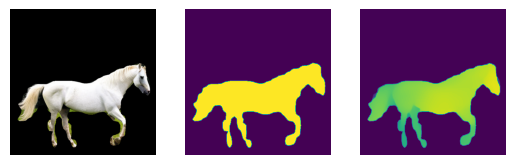

 40%|███████████████████████████▋                                          | 237/600 [00:01<00:03, 121.00it/s]

tensor(0.3162, device='cuda:0') tensor(0.4930, device='cuda:0')
tensor(0.3139, device='cuda:0') tensor(0.4926, device='cuda:0')
tensor(0.3084, device='cuda:0') tensor(0.4927, device='cuda:0')
tensor(0.2979, device='cuda:0') tensor(0.4929, device='cuda:0')
tensor(0.2833, device='cuda:0') tensor(0.4929, device='cuda:0')
tensor(0.2649, device='cuda:0') tensor(0.4928, device='cuda:0')
tensor(0.2355, device='cuda:0') tensor(0.4929, device='cuda:0')
tensor(0.2150, device='cuda:0') tensor(0.4928, device='cuda:0')
tensor(0.2139, device='cuda:0') tensor(0.4927, device='cuda:0')
tensor(0.2138, device='cuda:0') tensor(0.4927, device='cuda:0')
tensor(0.2138, device='cuda:0') tensor(0.4926, device='cuda:0')
tensor(0.2138, device='cuda:0') tensor(0.4926, device='cuda:0')
tensor(0.2138, device='cuda:0') tensor(0.4925, device='cuda:0')
tensor(0.2139, device='cuda:0') tensor(0.4925, device='cuda:0')
tensor(0.2141, device='cuda:0') tensor(0.4925, device='cuda:0')
tensor(0.2142, device='cuda:0') tensor(0

 44%|██████████████████████████████▋                                       | 263/600 [00:02<00:02, 120.51it/s]

tensor(0.2155, device='cuda:0') tensor(0.4945, device='cuda:0')
tensor(0.2159, device='cuda:0') tensor(0.4951, device='cuda:0')
tensor(0.2161, device='cuda:0') tensor(0.4956, device='cuda:0')
tensor(0.2167, device='cuda:0') tensor(0.4960, device='cuda:0')
tensor(0.2171, device='cuda:0') tensor(0.4968, device='cuda:0')
tensor(0.2177, device='cuda:0') tensor(0.4980, device='cuda:0')
tensor(0.2178, device='cuda:0') tensor(0.4992, device='cuda:0')
tensor(0.2182, device='cuda:0') tensor(0.5021, device='cuda:0')
tensor(0.2185, device='cuda:0') tensor(0.5062, device='cuda:0')
tensor(0.2187, device='cuda:0') tensor(0.5116, device='cuda:0')
tensor(0.2189, device='cuda:0') tensor(0.5250, device='cuda:0')
tensor(0.2190, device='cuda:0') tensor(0.5343, device='cuda:0')
tensor(0.2192, device='cuda:0') tensor(0.5349, device='cuda:0')
tensor(0.2195, device='cuda:0') tensor(0.5349, device='cuda:0')
tensor(0.2198, device='cuda:0') tensor(0.5350, device='cuda:0')
tensor(0.2200, device='cuda:0') tensor(0

 48%|█████████████████████████████████▋                                    | 289/600 [00:02<00:02, 120.23it/s]

tensor(0.2232, device='cuda:0') tensor(0.4427, device='cuda:0')
tensor(0.2237, device='cuda:0') tensor(0.4322, device='cuda:0')
tensor(0.2241, device='cuda:0') tensor(0.4318, device='cuda:0')
tensor(0.2244, device='cuda:0') tensor(0.4318, device='cuda:0')
tensor(0.2247, device='cuda:0') tensor(0.4318, device='cuda:0')
tensor(0.2249, device='cuda:0') tensor(0.4317, device='cuda:0')
tensor(0.2251, device='cuda:0') tensor(0.4317, device='cuda:0')
tensor(0.2251, device='cuda:0') tensor(0.4318, device='cuda:0')
tensor(0.2251, device='cuda:0') tensor(0.4317, device='cuda:0')
tensor(0.2253, device='cuda:0') tensor(0.4317, device='cuda:0')
tensor(0.2252, device='cuda:0') tensor(0.4318, device='cuda:0')
tensor(0.2249, device='cuda:0') tensor(0.4318, device='cuda:0')
tensor(0.2247, device='cuda:0') tensor(0.4319, device='cuda:0')
tensor(0.2246, device='cuda:0') tensor(0.4319, device='cuda:0')
tensor(0.2246, device='cuda:0') tensor(0.4320, device='cuda:0')
tensor(0.2244, device='cuda:0') tensor(0

 52%|████████████████████████████████████▊                                 | 315/600 [00:02<00:02, 121.76it/s]

tensor(0.2230, device='cuda:0') tensor(0.4328, device='cuda:0')
tensor(0.2229, device='cuda:0') tensor(0.4328, device='cuda:0')
tensor(0.2227, device='cuda:0') tensor(0.4327, device='cuda:0')
tensor(0.2227, device='cuda:0') tensor(0.4327, device='cuda:0')
tensor(0.2226, device='cuda:0') tensor(0.4328, device='cuda:0')
tensor(0.2225, device='cuda:0') tensor(0.4328, device='cuda:0')
tensor(0.2224, device='cuda:0') tensor(0.4328, device='cuda:0')
tensor(0.2222, device='cuda:0') tensor(0.4329, device='cuda:0')
tensor(0.2220, device='cuda:0') tensor(0.4330, device='cuda:0')
tensor(0.2219, device='cuda:0') tensor(0.4330, device='cuda:0')
tensor(0.2220, device='cuda:0') tensor(0.4331, device='cuda:0')
tensor(0.2218, device='cuda:0') tensor(0.4331, device='cuda:0')
tensor(0.2217, device='cuda:0') tensor(0.4330, device='cuda:0')
tensor(0.2215, device='cuda:0') tensor(0.4331, device='cuda:0')
tensor(0.2213, device='cuda:0') tensor(0.4331, device='cuda:0')
tensor(0.2213, device='cuda:0') tensor(0

 57%|███████████████████████████████████████▊                              | 341/600 [00:02<00:02, 120.46it/s]

tensor(0.2213, device='cuda:0') tensor(0.4336, device='cuda:0')
tensor(0.2213, device='cuda:0') tensor(0.4337, device='cuda:0')
tensor(0.2212, device='cuda:0') tensor(0.4336, device='cuda:0')
tensor(0.2211, device='cuda:0') tensor(0.4335, device='cuda:0')
tensor(0.2211, device='cuda:0') tensor(0.4335, device='cuda:0')
tensor(0.2211, device='cuda:0') tensor(0.4336, device='cuda:0')
tensor(0.2210, device='cuda:0') tensor(0.4337, device='cuda:0')
tensor(0.2210, device='cuda:0') tensor(0.4336, device='cuda:0')
tensor(0.2209, device='cuda:0') tensor(0.4337, device='cuda:0')
tensor(0.2209, device='cuda:0') tensor(0.4337, device='cuda:0')
tensor(0.2207, device='cuda:0') tensor(0.4336, device='cuda:0')
tensor(0.2206, device='cuda:0') tensor(0.4336, device='cuda:0')
tensor(0.2206, device='cuda:0') tensor(0.4335, device='cuda:0')
tensor(0.2204, device='cuda:0') tensor(0.4335, device='cuda:0')
tensor(0.2202, device='cuda:0') tensor(0.4336, device='cuda:0')
tensor(0.2202, device='cuda:0') tensor(0

 59%|█████████████████████████████████████████▎                            | 354/600 [00:02<00:02, 120.01it/s]

tensor(0.2185, device='cuda:0') tensor(0.7213, device='cuda:0')
tensor(0.2184, device='cuda:0') tensor(0.7228, device='cuda:0')
tensor(0.2185, device='cuda:0') tensor(0.7228, device='cuda:0')
tensor(0.2183, device='cuda:0') tensor(0.7229, device='cuda:0')
tensor(0.2180, device='cuda:0') tensor(0.7231, device='cuda:0')
tensor(0.2179, device='cuda:0') tensor(0.7232, device='cuda:0')
tensor(0.2177, device='cuda:0') tensor(0.7213, device='cuda:0')
tensor(0.2174, device='cuda:0') tensor(0.7012, device='cuda:0')
tensor(0.2171, device='cuda:0') tensor(0.6691, device='cuda:0')
tensor(0.2170, device='cuda:0') tensor(0.6226, device='cuda:0')
tensor(0.2168, device='cuda:0') tensor(0.5953, device='cuda:0')
tensor(0.2167, device='cuda:0') tensor(0.5874, device='cuda:0')
tensor(0.2168, device='cuda:0') tensor(0.5825, device='cuda:0')
tensor(0.2166, device='cuda:0') tensor(0.5789, device='cuda:0')
tensor(0.2164, device='cuda:0') tensor(0.5764, device='cuda:0')
tensor(0.2164, device='cuda:0') tensor(0

 63%|████████████████████████████████████████████▏                         | 379/600 [00:03<00:01, 119.76it/s]

tensor(0.2171, device='cuda:0') tensor(0.5730, device='cuda:0')
tensor(0.2171, device='cuda:0') tensor(0.5730, device='cuda:0')
tensor(0.2171, device='cuda:0') tensor(0.5728, device='cuda:0')
tensor(0.2171, device='cuda:0') tensor(0.5729, device='cuda:0')
tensor(0.2172, device='cuda:0') tensor(0.5731, device='cuda:0')
tensor(0.2173, device='cuda:0') tensor(0.5730, device='cuda:0')
tensor(0.2174, device='cuda:0') tensor(0.5731, device='cuda:0')
tensor(0.2174, device='cuda:0') tensor(0.5732, device='cuda:0')
tensor(0.2175, device='cuda:0') tensor(0.5733, device='cuda:0')
tensor(0.2175, device='cuda:0') tensor(0.5733, device='cuda:0')
tensor(0.2277, device='cuda:0') tensor(0.5732, device='cuda:0')


100%|██████████████████████████████████████████████████████████████████████| 600/600 [00:05<00:00, 118.78it/s]


/grogu/user/akirchme/art3d_sd_webui/images/horse/1285.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/1285.mp4


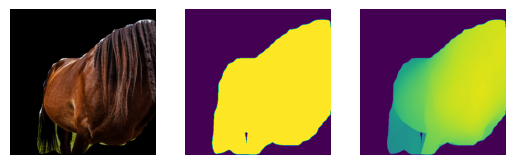

 40%|████████████████████████████▎                                          | 239/600 [00:03<00:04, 88.65it/s]

tensor(0.3209, device='cuda:0') tensor(0.5103, device='cuda:0')
tensor(0.3202, device='cuda:0') tensor(0.5095, device='cuda:0')
tensor(0.3162, device='cuda:0') tensor(0.5097, device='cuda:0')
tensor(0.3069, device='cuda:0') tensor(0.5100, device='cuda:0')
tensor(0.2923, device='cuda:0') tensor(0.5101, device='cuda:0')
tensor(0.2515, device='cuda:0') tensor(0.5104, device='cuda:0')
tensor(0.1938, device='cuda:0') tensor(0.5104, device='cuda:0')
tensor(0.1465, device='cuda:0') tensor(0.5105, device='cuda:0')
tensor(0.1420, device='cuda:0') tensor(0.5106, device='cuda:0')
tensor(0.1417, device='cuda:0') tensor(0.5112, device='cuda:0')
tensor(0.1415, device='cuda:0') tensor(0.5114, device='cuda:0')
tensor(0.1413, device='cuda:0') tensor(0.5121, device='cuda:0')
tensor(0.1413, device='cuda:0') tensor(0.5126, device='cuda:0')
tensor(0.1411, device='cuda:0') tensor(0.5125, device='cuda:0')
tensor(0.1410, device='cuda:0') tensor(0.5126, device='cuda:0')
tensor(0.1409, device='cuda:0') tensor(0

 44%|██████████████████████████████▋                                       | 263/600 [00:03<00:03, 103.65it/s]

tensor(0.1397, device='cuda:0') tensor(0.5084, device='cuda:0')
tensor(0.1397, device='cuda:0') tensor(0.5069, device='cuda:0')
tensor(0.1397, device='cuda:0') tensor(0.5061, device='cuda:0')
tensor(0.1398, device='cuda:0') tensor(0.5056, device='cuda:0')
tensor(0.1398, device='cuda:0') tensor(0.5053, device='cuda:0')
tensor(0.1398, device='cuda:0') tensor(0.5059, device='cuda:0')
tensor(0.1398, device='cuda:0') tensor(0.5081, device='cuda:0')
tensor(0.1398, device='cuda:0') tensor(0.5124, device='cuda:0')
tensor(0.1398, device='cuda:0') tensor(0.5183, device='cuda:0')
tensor(0.1398, device='cuda:0') tensor(0.5371, device='cuda:0')
tensor(0.1399, device='cuda:0') tensor(0.5670, device='cuda:0')
tensor(0.1400, device='cuda:0') tensor(0.5988, device='cuda:0')
tensor(0.1400, device='cuda:0') tensor(0.6208, device='cuda:0')
tensor(0.1401, device='cuda:0') tensor(0.6224, device='cuda:0')
tensor(0.1403, device='cuda:0') tensor(0.6223, device='cuda:0')
tensor(0.1404, device='cuda:0') tensor(0

 48%|█████████████████████████████████▍                                    | 287/600 [00:03<00:02, 111.23it/s]

tensor(0.1489, device='cuda:0') tensor(0.5442, device='cuda:0')
tensor(0.1498, device='cuda:0') tensor(0.5055, device='cuda:0')
tensor(0.1506, device='cuda:0') tensor(0.4674, device='cuda:0')
tensor(0.1514, device='cuda:0') tensor(0.4440, device='cuda:0')
tensor(0.1522, device='cuda:0') tensor(0.4436, device='cuda:0')
tensor(0.1528, device='cuda:0') tensor(0.4435, device='cuda:0')
tensor(0.1534, device='cuda:0') tensor(0.4434, device='cuda:0')
tensor(0.1539, device='cuda:0') tensor(0.4433, device='cuda:0')
tensor(0.1542, device='cuda:0') tensor(0.4434, device='cuda:0')
tensor(0.1544, device='cuda:0') tensor(0.4433, device='cuda:0')
tensor(0.1546, device='cuda:0') tensor(0.4435, device='cuda:0')
tensor(0.1544, device='cuda:0') tensor(0.4435, device='cuda:0')
tensor(0.1541, device='cuda:0') tensor(0.4434, device='cuda:0')
tensor(0.1538, device='cuda:0') tensor(0.4433, device='cuda:0')
tensor(0.1533, device='cuda:0') tensor(0.4433, device='cuda:0')
tensor(0.1527, device='cuda:0') tensor(0

 52%|████████████████████████████████████▎                                 | 311/600 [00:04<00:02, 115.31it/s]

tensor(0.1446, device='cuda:0') tensor(0.4432, device='cuda:0')
tensor(0.1441, device='cuda:0') tensor(0.4432, device='cuda:0')
tensor(0.1440, device='cuda:0') tensor(0.4432, device='cuda:0')
tensor(0.1441, device='cuda:0') tensor(0.4432, device='cuda:0')
tensor(0.1441, device='cuda:0') tensor(0.4431, device='cuda:0')
tensor(0.1441, device='cuda:0') tensor(0.4432, device='cuda:0')
tensor(0.1442, device='cuda:0') tensor(0.4432, device='cuda:0')
tensor(0.1443, device='cuda:0') tensor(0.4431, device='cuda:0')
tensor(0.1443, device='cuda:0') tensor(0.4431, device='cuda:0')
tensor(0.1443, device='cuda:0') tensor(0.4431, device='cuda:0')
tensor(0.1442, device='cuda:0') tensor(0.4431, device='cuda:0')
tensor(0.1442, device='cuda:0') tensor(0.4431, device='cuda:0')
tensor(0.1442, device='cuda:0') tensor(0.4431, device='cuda:0')
tensor(0.1442, device='cuda:0') tensor(0.4431, device='cuda:0')
tensor(0.1442, device='cuda:0') tensor(0.4431, device='cuda:0')
tensor(0.1442, device='cuda:0') tensor(0

 56%|███████████████████████████████████████                               | 335/600 [00:04<00:02, 116.40it/s]

tensor(0.1440, device='cuda:0') tensor(0.4435, device='cuda:0')
tensor(0.1441, device='cuda:0') tensor(0.4435, device='cuda:0')
tensor(0.1441, device='cuda:0') tensor(0.4435, device='cuda:0')
tensor(0.1440, device='cuda:0') tensor(0.4435, device='cuda:0')
tensor(0.1440, device='cuda:0') tensor(0.4435, device='cuda:0')
tensor(0.1440, device='cuda:0') tensor(0.4435, device='cuda:0')
tensor(0.1441, device='cuda:0') tensor(0.4435, device='cuda:0')
tensor(0.1441, device='cuda:0') tensor(0.4435, device='cuda:0')
tensor(0.1442, device='cuda:0') tensor(0.4436, device='cuda:0')
tensor(0.1441, device='cuda:0') tensor(0.4436, device='cuda:0')
tensor(0.1442, device='cuda:0') tensor(0.4436, device='cuda:0')
tensor(0.1442, device='cuda:0') tensor(0.4436, device='cuda:0')
tensor(0.1442, device='cuda:0') tensor(0.4437, device='cuda:0')
tensor(0.1441, device='cuda:0') tensor(0.4437, device='cuda:0')
tensor(0.1440, device='cuda:0') tensor(0.4437, device='cuda:0')
tensor(0.1439, device='cuda:0') tensor(0

 60%|█████████████████████████████████████████▉                            | 359/600 [00:04<00:02, 117.09it/s]

tensor(0.1431, device='cuda:0') tensor(0.6157, device='cuda:0')
tensor(0.1430, device='cuda:0') tensor(0.6352, device='cuda:0')
tensor(0.1430, device='cuda:0') tensor(0.6548, device='cuda:0')
tensor(0.1429, device='cuda:0') tensor(0.6732, device='cuda:0')
tensor(0.1428, device='cuda:0') tensor(0.6922, device='cuda:0')
tensor(0.1427, device='cuda:0') tensor(0.7020, device='cuda:0')
tensor(0.1426, device='cuda:0') tensor(0.7032, device='cuda:0')
tensor(0.1425, device='cuda:0') tensor(0.7034, device='cuda:0')
tensor(0.1425, device='cuda:0') tensor(0.7036, device='cuda:0')
tensor(0.1424, device='cuda:0') tensor(0.7037, device='cuda:0')
tensor(0.1424, device='cuda:0') tensor(0.7021, device='cuda:0')
tensor(0.1424, device='cuda:0') tensor(0.6556, device='cuda:0')
tensor(0.1423, device='cuda:0') tensor(0.6201, device='cuda:0')
tensor(0.1423, device='cuda:0') tensor(0.6095, device='cuda:0')
tensor(0.1422, device='cuda:0') tensor(0.5926, device='cuda:0')
tensor(0.1421, device='cuda:0') tensor(0

 62%|███████████████████████████████████████████▎                          | 371/600 [00:04<00:01, 117.63it/s]

tensor(0.1425, device='cuda:0') tensor(0.5489, device='cuda:0')
tensor(0.1425, device='cuda:0') tensor(0.5491, device='cuda:0')
tensor(0.1426, device='cuda:0') tensor(0.5492, device='cuda:0')
tensor(0.1428, device='cuda:0') tensor(0.5495, device='cuda:0')
tensor(0.1429, device='cuda:0') tensor(0.5498, device='cuda:0')
tensor(0.1430, device='cuda:0') tensor(0.5500, device='cuda:0')
tensor(0.1432, device='cuda:0') tensor(0.5500, device='cuda:0')
tensor(0.1433, device='cuda:0') tensor(0.5499, device='cuda:0')
tensor(0.1434, device='cuda:0') tensor(0.5495, device='cuda:0')
tensor(0.1436, device='cuda:0') tensor(0.5493, device='cuda:0')
tensor(0.1437, device='cuda:0') tensor(0.5491, device='cuda:0')
tensor(0.1439, device='cuda:0') tensor(0.5490, device='cuda:0')
tensor(0.1441, device='cuda:0') tensor(0.5487, device='cuda:0')
tensor(0.1441, device='cuda:0') tensor(0.5484, device='cuda:0')
tensor(0.1442, device='cuda:0') tensor(0.5484, device='cuda:0')
tensor(0.1512, device='cuda:0') tensor(0

100%|███████████████████████████████████████████████████████████████████████| 600/600 [00:08<00:00, 73.40it/s]


/grogu/user/akirchme/art3d_sd_webui/images/horse/758.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/758.mp4


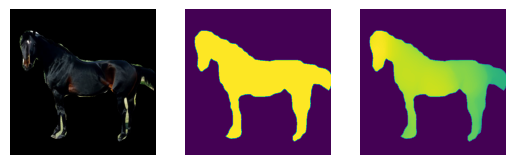

  4%|██▊                                                                    | 24/600 [00:00<00:04, 118.77it/s]

tensor(0.2416, device='cuda:0') tensor(0.4446, device='cuda:0')
tensor(0.2416, device='cuda:0') tensor(0.4447, device='cuda:0')
tensor(0.2418, device='cuda:0') tensor(0.4447, device='cuda:0')
tensor(0.2419, device='cuda:0') tensor(0.4448, device='cuda:0')
tensor(0.2419, device='cuda:0') tensor(0.4448, device='cuda:0')
tensor(0.2418, device='cuda:0') tensor(0.4450, device='cuda:0')
tensor(0.2416, device='cuda:0') tensor(0.4450, device='cuda:0')
tensor(0.2415, device='cuda:0') tensor(0.4451, device='cuda:0')
tensor(0.2414, device='cuda:0') tensor(0.4452, device='cuda:0')
tensor(0.2411, device='cuda:0') tensor(0.4453, device='cuda:0')
tensor(0.2409, device='cuda:0') tensor(0.4454, device='cuda:0')
tensor(0.2409, device='cuda:0') tensor(0.4453, device='cuda:0')
tensor(0.2411, device='cuda:0') tensor(0.4454, device='cuda:0')
tensor(0.2411, device='cuda:0') tensor(0.4455, device='cuda:0')
tensor(0.2413, device='cuda:0') tensor(0.4456, device='cuda:0')
tensor(0.2416, device='cuda:0') tensor(0

  8%|█████▊                                                                 | 49/600 [00:00<00:04, 119.43it/s]

tensor(0.2437, device='cuda:0') tensor(0.4464, device='cuda:0')
tensor(0.2434, device='cuda:0') tensor(0.4463, device='cuda:0')
tensor(0.2428, device='cuda:0') tensor(0.4463, device='cuda:0')
tensor(0.2422, device='cuda:0') tensor(0.4463, device='cuda:0')
tensor(0.2412, device='cuda:0') tensor(0.4465, device='cuda:0')
tensor(0.2402, device='cuda:0') tensor(0.4466, device='cuda:0')
tensor(0.2392, device='cuda:0') tensor(0.4466, device='cuda:0')
tensor(0.2380, device='cuda:0') tensor(0.4468, device='cuda:0')
tensor(0.2366, device='cuda:0') tensor(0.4586, device='cuda:0')
tensor(0.2352, device='cuda:0') tensor(0.4731, device='cuda:0')
tensor(0.2335, device='cuda:0') tensor(0.4875, device='cuda:0')
tensor(0.2318, device='cuda:0') tensor(0.4986, device='cuda:0')
tensor(0.2304, device='cuda:0') tensor(0.5084, device='cuda:0')
tensor(0.2294, device='cuda:0') tensor(0.5188, device='cuda:0')
tensor(0.2284, device='cuda:0') tensor(0.5283, device='cuda:0')
tensor(0.2276, device='cuda:0') tensor(0

 10%|███████▎                                                               | 62/600 [00:00<00:04, 119.92it/s]

tensor(0.2227, device='cuda:0') tensor(0.5366, device='cuda:0')
tensor(0.2224, device='cuda:0') tensor(0.5309, device='cuda:0')
tensor(0.2220, device='cuda:0') tensor(0.5280, device='cuda:0')
tensor(0.2218, device='cuda:0') tensor(0.5216, device='cuda:0')
tensor(0.2215, device='cuda:0') tensor(0.5142, device='cuda:0')
tensor(0.2210, device='cuda:0') tensor(0.5089, device='cuda:0')
tensor(0.2207, device='cuda:0') tensor(0.5049, device='cuda:0')
tensor(0.2205, device='cuda:0') tensor(0.5048, device='cuda:0')
tensor(0.2204, device='cuda:0') tensor(0.5057, device='cuda:0')
tensor(0.2201, device='cuda:0') tensor(0.5066, device='cuda:0')
tensor(0.2199, device='cuda:0') tensor(0.5074, device='cuda:0')
tensor(0.2199, device='cuda:0') tensor(0.5083, device='cuda:0')
tensor(0.2198, device='cuda:0') tensor(0.5091, device='cuda:0')
tensor(0.2203, device='cuda:0') tensor(0.5102, device='cuda:0')
tensor(0.2208, device='cuda:0') tensor(0.5112, device='cuda:0')
tensor(0.2210, device='cuda:0') tensor(0

 15%|██████████▍                                                            | 88/600 [00:00<00:04, 118.06it/s]

tensor(0.2235, device='cuda:0') tensor(0.5156, device='cuda:0')
tensor(0.2238, device='cuda:0') tensor(0.5149, device='cuda:0')
tensor(0.2263, device='cuda:0') tensor(0.5134, device='cuda:0')
tensor(0.2460, device='cuda:0') tensor(0.5123, device='cuda:0')
tensor(0.2669, device='cuda:0') tensor(0.5117, device='cuda:0')
tensor(0.2824, device='cuda:0') tensor(0.5109, device='cuda:0')
tensor(0.2966, device='cuda:0') tensor(0.5100, device='cuda:0')
tensor(0.3094, device='cuda:0') tensor(0.5094, device='cuda:0')
tensor(0.3209, device='cuda:0') tensor(0.5085, device='cuda:0')
tensor(0.3273, device='cuda:0') tensor(0.5080, device='cuda:0')


 91%|███████████████████████████████████████████████████████████████▌      | 545/600 [00:05<00:00, 110.17it/s]

tensor(0.2745, device='cuda:0') tensor(0.5829, device='cuda:0')
tensor(0.2289, device='cuda:0') tensor(0.5842, device='cuda:0')
tensor(0.2231, device='cuda:0') tensor(0.5859, device='cuda:0')
tensor(0.2229, device='cuda:0') tensor(0.5870, device='cuda:0')
tensor(0.2226, device='cuda:0') tensor(0.5878, device='cuda:0')
tensor(0.2223, device='cuda:0') tensor(0.5882, device='cuda:0')
tensor(0.2221, device='cuda:0') tensor(0.5880, device='cuda:0')
tensor(0.2218, device='cuda:0') tensor(0.5876, device='cuda:0')
tensor(0.2215, device='cuda:0') tensor(0.5870, device='cuda:0')
tensor(0.2214, device='cuda:0') tensor(0.5866, device='cuda:0')
tensor(0.2213, device='cuda:0') tensor(0.5862, device='cuda:0')
tensor(0.2210, device='cuda:0') tensor(0.5857, device='cuda:0')
tensor(0.2209, device='cuda:0') tensor(0.5847, device='cuda:0')
tensor(0.2209, device='cuda:0') tensor(0.5837, device='cuda:0')
tensor(0.2208, device='cuda:0') tensor(0.5828, device='cuda:0')
tensor(0.2207, device='cuda:0') tensor(0

 95%|██████████████████████████████████████████████████████████████████▌   | 571/600 [00:05<00:00, 116.03it/s]

tensor(0.2230, device='cuda:0') tensor(0.6065, device='cuda:0')
tensor(0.2233, device='cuda:0') tensor(0.6182, device='cuda:0')
tensor(0.2235, device='cuda:0') tensor(0.6299, device='cuda:0')
tensor(0.2237, device='cuda:0') tensor(0.6437, device='cuda:0')
tensor(0.2242, device='cuda:0') tensor(0.6668, device='cuda:0')
tensor(0.2243, device='cuda:0') tensor(0.6774, device='cuda:0')
tensor(0.2247, device='cuda:0') tensor(0.6780, device='cuda:0')
tensor(0.2250, device='cuda:0') tensor(0.6779, device='cuda:0')
tensor(0.2253, device='cuda:0') tensor(0.6778, device='cuda:0')
tensor(0.2256, device='cuda:0') tensor(0.6777, device='cuda:0')
tensor(0.2262, device='cuda:0') tensor(0.6774, device='cuda:0')
tensor(0.2269, device='cuda:0') tensor(0.6705, device='cuda:0')
tensor(0.2275, device='cuda:0') tensor(0.6553, device='cuda:0')
tensor(0.2283, device='cuda:0') tensor(0.6376, device='cuda:0')
tensor(0.2291, device='cuda:0') tensor(0.6146, device='cuda:0')
tensor(0.2299, device='cuda:0') tensor(0

 99%|█████████████████████████████████████████████████████████████████████▌| 596/600 [00:05<00:00, 118.11it/s]

tensor(0.2370, device='cuda:0') tensor(0.4443, device='cuda:0')
tensor(0.2374, device='cuda:0') tensor(0.4444, device='cuda:0')
tensor(0.2381, device='cuda:0') tensor(0.4441, device='cuda:0')
tensor(0.2385, device='cuda:0') tensor(0.4440, device='cuda:0')
tensor(0.2388, device='cuda:0') tensor(0.4441, device='cuda:0')
tensor(0.2390, device='cuda:0') tensor(0.4441, device='cuda:0')
tensor(0.2392, device='cuda:0') tensor(0.4441, device='cuda:0')
tensor(0.2394, device='cuda:0') tensor(0.4439, device='cuda:0')
tensor(0.2396, device='cuda:0') tensor(0.4439, device='cuda:0')
tensor(0.2397, device='cuda:0') tensor(0.4439, device='cuda:0')
tensor(0.2395, device='cuda:0') tensor(0.4440, device='cuda:0')
tensor(0.2394, device='cuda:0') tensor(0.4440, device='cuda:0')
tensor(0.2392, device='cuda:0') tensor(0.4441, device='cuda:0')
tensor(0.2390, device='cuda:0') tensor(0.4441, device='cuda:0')
tensor(0.2388, device='cuda:0') tensor(0.4440, device='cuda:0')
tensor(0.2391, device='cuda:0') tensor(0

100%|██████████████████████████████████████████████████████████████████████| 600/600 [00:05<00:00, 107.25it/s]


tensor(0.2414, device='cuda:0') tensor(0.4446, device='cuda:0')
tensor(0.2414, device='cuda:0') tensor(0.4446, device='cuda:0')
/grogu/user/akirchme/art3d_sd_webui/images/horse/1808.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/1808.mp4


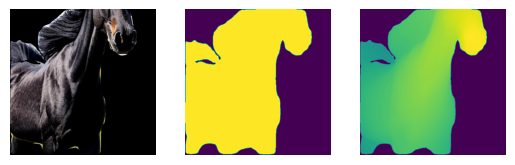

 40%|████████████████████████████▎                                          | 239/600 [00:03<00:04, 81.29it/s]

tensor(0.2999, device='cuda:0') tensor(0.5603, device='cuda:0')
tensor(0.2799, device='cuda:0') tensor(0.5614, device='cuda:0')
tensor(0.2635, device='cuda:0') tensor(0.5626, device='cuda:0')
tensor(0.2565, device='cuda:0') tensor(0.5641, device='cuda:0')
tensor(0.2559, device='cuda:0') tensor(0.5657, device='cuda:0')
tensor(0.2557, device='cuda:0') tensor(0.5669, device='cuda:0')
tensor(0.2555, device='cuda:0') tensor(0.5679, device='cuda:0')
tensor(0.2554, device='cuda:0') tensor(0.5687, device='cuda:0')
tensor(0.2553, device='cuda:0') tensor(0.5692, device='cuda:0')
tensor(0.2551, device='cuda:0') tensor(0.5694, device='cuda:0')
tensor(0.2548, device='cuda:0') tensor(0.5691, device='cuda:0')
tensor(0.2547, device='cuda:0') tensor(0.5683, device='cuda:0')
tensor(0.2545, device='cuda:0') tensor(0.5675, device='cuda:0')
tensor(0.2545, device='cuda:0') tensor(0.5662, device='cuda:0')
tensor(0.2544, device='cuda:0') tensor(0.5651, device='cuda:0')
tensor(0.2544, device='cuda:0') tensor(0

 44%|██████████████████████████████▋                                       | 263/600 [00:04<00:03, 100.47it/s]

tensor(0.5541, device='cuda:0')
tensor(0.2627, device='cuda:0') tensor(0.5641, device='cuda:0')
tensor(0.2640, device='cuda:0') tensor(0.5764, device='cuda:0')
tensor(0.2655, device='cuda:0') tensor(0.5876, device='cuda:0')
tensor(0.2667, device='cuda:0') tensor(0.6016, device='cuda:0')
tensor(0.2685, device='cuda:0') tensor(0.6113, device='cuda:0')
tensor(0.2705, device='cuda:0') tensor(0.6188, device='cuda:0')
tensor(0.2718, device='cuda:0') tensor(0.6237, device='cuda:0')
tensor(0.2732, device='cuda:0') tensor(0.6250, device='cuda:0')
tensor(0.2748, device='cuda:0') tensor(0.6243, device='cuda:0')
tensor(0.2765, device='cuda:0') tensor(0.6235, device='cuda:0')
tensor(0.2780, device='cuda:0') tensor(0.6230, device='cuda:0')
tensor(0.2804, device='cuda:0') tensor(0.6223, device='cuda:0')
tensor(0.2824, device='cuda:0') tensor(0.6216, device='cuda:0')
tensor(0.2849, device='cuda:0') tensor(0.6141, device='cuda:0')
tensor(0.2876, device='cuda:0') tensor(0.5937, device='cuda:0')
tensor(0

 48%|█████████████████████████████████▍                                    | 287/600 [00:04<00:02, 110.14it/s]

tensor(0.4861, device='cuda:0')
tensor(0.3038, device='cuda:0') tensor(0.4857, device='cuda:0')
tensor(0.3048, device='cuda:0') tensor(0.4855, device='cuda:0')
tensor(0.3057, device='cuda:0') tensor(0.4854, device='cuda:0')
tensor(0.3066, device='cuda:0') tensor(0.4852, device='cuda:0')
tensor(0.3073, device='cuda:0') tensor(0.4851, device='cuda:0')
tensor(0.3081, device='cuda:0') tensor(0.4851, device='cuda:0')
tensor(0.3086, device='cuda:0') tensor(0.4850, device='cuda:0')
tensor(0.3091, device='cuda:0') tensor(0.4848, device='cuda:0')
tensor(0.3093, device='cuda:0') tensor(0.4847, device='cuda:0')
tensor(0.3093, device='cuda:0') tensor(0.4847, device='cuda:0')
tensor(0.3095, device='cuda:0') tensor(0.4848, device='cuda:0')
tensor(0.3095, device='cuda:0') tensor(0.4848, device='cuda:0')
tensor(0.3096, device='cuda:0') tensor(0.4847, device='cuda:0')
tensor(0.3094, device='cuda:0') tensor(0.4846, device='cuda:0')
tensor(0.3090, device='cuda:0') tensor(0.4845, device='cuda:0')
tensor(0

 52%|████████████████████████████████████▎                                 | 311/600 [00:04<00:02, 114.91it/s]

tensor(0.4844, device='cuda:0')
tensor(0.3005, device='cuda:0') tensor(0.4843, device='cuda:0')
tensor(0.2998, device='cuda:0') tensor(0.4843, device='cuda:0')
tensor(0.2991, device='cuda:0') tensor(0.4843, device='cuda:0')
tensor(0.2984, device='cuda:0') tensor(0.4843, device='cuda:0')
tensor(0.2979, device='cuda:0') tensor(0.4843, device='cuda:0')
tensor(0.2969, device='cuda:0') tensor(0.4843, device='cuda:0')
tensor(0.2960, device='cuda:0') tensor(0.4844, device='cuda:0')
tensor(0.2954, device='cuda:0') tensor(0.4844, device='cuda:0')
tensor(0.2948, device='cuda:0') tensor(0.4844, device='cuda:0')
tensor(0.2939, device='cuda:0') tensor(0.4844, device='cuda:0')
tensor(0.2930, device='cuda:0') tensor(0.4843, device='cuda:0')
tensor(0.2922, device='cuda:0') tensor(0.4844, device='cuda:0')
tensor(0.2914, device='cuda:0') tensor(0.4845, device='cuda:0')
tensor(0.2906, device='cuda:0') tensor(0.4845, device='cuda:0')
tensor(0.2894, device='cuda:0') tensor(0.4844, device='cuda:0')
tensor(0

 56%|███████████████████████████████████████▏                              | 336/600 [00:04<00:02, 117.43it/s]

tensor(0.4852, device='cuda:0')
tensor(0.2889, device='cuda:0') tensor(0.4853, device='cuda:0')
tensor(0.2892, device='cuda:0') tensor(0.4854, device='cuda:0')
tensor(0.2893, device='cuda:0') tensor(0.4856, device='cuda:0')
tensor(0.2894, device='cuda:0') tensor(0.4858, device='cuda:0')
tensor(0.2894, device='cuda:0') tensor(0.4860, device='cuda:0')
tensor(0.2892, device='cuda:0') tensor(0.4863, device='cuda:0')
tensor(0.2888, device='cuda:0') tensor(0.4865, device='cuda:0')
tensor(0.2881, device='cuda:0') tensor(0.4865, device='cuda:0')
tensor(0.2874, device='cuda:0') tensor(0.4866, device='cuda:0')
tensor(0.2865, device='cuda:0') tensor(0.4869, device='cuda:0')
tensor(0.2855, device='cuda:0') tensor(0.4870, device='cuda:0')
tensor(0.2843, device='cuda:0') tensor(0.4873, device='cuda:0')
tensor(0.2831, device='cuda:0') tensor(0.4875, device='cuda:0')
tensor(0.2819, device='cuda:0') tensor(0.4878, device='cuda:0')
tensor(0.2804, device='cuda:0') tensor(0.4880, device='cuda:0')
tensor(0

 60%|██████████████████████████████████████████                            | 361/600 [00:04<00:02, 118.74it/s]

tensor(0.2622, device='cuda:0') tensor(0.5364, device='cuda:0')
tensor(0.2611, device='cuda:0') tensor(0.5378, device='cuda:0')
tensor(0.2601, device='cuda:0') tensor(0.5380, device='cuda:0')
tensor(0.2593, device='cuda:0') tensor(0.5383, device='cuda:0')
tensor(0.2584, device='cuda:0') tensor(0.5397, device='cuda:0')
tensor(0.2576, device='cuda:0') tensor(0.5416, device='cuda:0')
tensor(0.2569, device='cuda:0') tensor(0.5425, device='cuda:0')
tensor(0.2563, device='cuda:0') tensor(0.5426, device='cuda:0')
tensor(0.2556, device='cuda:0') tensor(0.5424, device='cuda:0')
tensor(0.2551, device='cuda:0') tensor(0.5418, device='cuda:0')
tensor(0.2547, device='cuda:0') tensor(0.5405, device='cuda:0')
tensor(0.2542, device='cuda:0') tensor(0.5382, device='cuda:0')
tensor(0.2539, device='cuda:0') tensor(0.5313, device='cuda:0')
tensor(0.2538, device='cuda:0') tensor(0.5199, device='cuda:0')
tensor(0.2533, device='cuda:0') tensor(0.5157, device='cuda:0')
tensor(0.2529, device='cuda:0') tensor(0

 64%|████████████████████████████████████████████▉                         | 385/600 [00:05<00:01, 119.24it/s]

tensor(0.2528, device='cuda:0') tensor(0.5146, device='cuda:0')
tensor(0.2530, device='cuda:0') tensor(0.5154, device='cuda:0')
tensor(0.2532, device='cuda:0') tensor(0.5159, device='cuda:0')
tensor(0.2536, device='cuda:0') tensor(0.5161, device='cuda:0')
tensor(0.2540, device='cuda:0') tensor(0.5163, device='cuda:0')
tensor(0.2542, device='cuda:0') tensor(0.5162, device='cuda:0')
tensor(0.2545, device='cuda:0') tensor(0.5157, device='cuda:0')
tensor(0.2548, device='cuda:0') tensor(0.5147, device='cuda:0')
tensor(0.2551, device='cuda:0') tensor(0.5133, device='cuda:0')
tensor(0.2554, device='cuda:0') tensor(0.5116, device='cuda:0')
tensor(0.2561, device='cuda:0') tensor(0.5100, device='cuda:0')
tensor(0.2574, device='cuda:0') tensor(0.5089, device='cuda:0')
tensor(0.2603, device='cuda:0') tensor(0.5074, device='cuda:0')
tensor(0.2652, device='cuda:0') tensor(0.5059, device='cuda:0')
tensor(0.2751, device='cuda:0') tensor(0.5043, device='cuda:0')
tensor(0.2947, device='cuda:0') tensor(0

100%|███████████████████████████████████████████████████████████████████████| 600/600 [00:08<00:00, 68.66it/s]


/grogu/user/akirchme/art3d_sd_webui/images/horse/339.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/339.mp4


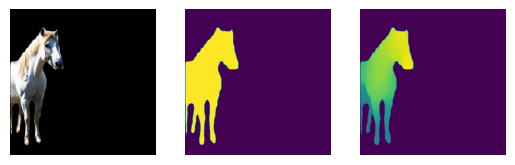

 15%|██████████▊                                                            | 91/600 [00:00<00:04, 122.79it/s]

tensor(0.3475, device='cuda:0') tensor(0.5180, device='cuda:0')
tensor(0.3474, device='cuda:0') tensor(0.5167, device='cuda:0')
tensor(0.3473, device='cuda:0') tensor(0.5161, device='cuda:0')
tensor(0.3470, device='cuda:0') tensor(0.5158, device='cuda:0')
tensor(0.3469, device='cuda:0') tensor(0.5159, device='cuda:0')
tensor(0.3471, device='cuda:0') tensor(0.5158, device='cuda:0')
tensor(0.3469, device='cuda:0') tensor(0.5155, device='cuda:0')
tensor(0.3469, device='cuda:0') tensor(0.5157, device='cuda:0')
tensor(0.3486, device='cuda:0') tensor(0.5153, device='cuda:0')
tensor(0.3519, device='cuda:0') tensor(0.5151, device='cuda:0')
tensor(0.3574, device='cuda:0') tensor(0.5146, device='cuda:0')
tensor(0.3636, device='cuda:0') tensor(0.5152, device='cuda:0')
tensor(0.3704, device='cuda:0') tensor(0.5152, device='cuda:0')
tensor(0.3779, device='cuda:0') tensor(0.5152, device='cuda:0')
tensor(0.3831, device='cuda:0') tensor(0.5152, device='cuda:0')
tensor(0.3842, device='cuda:0') tensor(0

 22%|███████████████▏                                                      | 130/600 [00:01<00:03, 123.89it/s]

tensor(0.4170, device='cuda:0') tensor(0.5124, device='cuda:0')
tensor(0.4166, device='cuda:0') tensor(0.5088, device='cuda:0')
tensor(0.4161, device='cuda:0') tensor(0.5070, device='cuda:0')
tensor(0.4162, device='cuda:0') tensor(0.5054, device='cuda:0')
tensor(0.4158, device='cuda:0') tensor(0.5038, device='cuda:0')
tensor(0.4155, device='cuda:0') tensor(0.5031, device='cuda:0')
tensor(0.4157, device='cuda:0') tensor(0.5025, device='cuda:0')
tensor(0.4156, device='cuda:0') tensor(0.5022, device='cuda:0')
tensor(0.4159, device='cuda:0') tensor(0.5020, device='cuda:0')
tensor(0.4160, device='cuda:0') tensor(0.5020, device='cuda:0')
tensor(0.4162, device='cuda:0') tensor(0.5021, device='cuda:0')
tensor(0.4163, device='cuda:0') tensor(0.5020, device='cuda:0')
tensor(0.4162, device='cuda:0') tensor(0.5019, device='cuda:0')
tensor(0.4155, device='cuda:0') tensor(0.5018, device='cuda:0')
tensor(0.4151, device='cuda:0') tensor(0.5019, device='cuda:0')
tensor(0.4146, device='cuda:0') tensor(0

 26%|██████████████████▏                                                   | 156/600 [00:01<00:03, 121.19it/s]

tensor(0.4225, device='cuda:0') tensor(0.5035, device='cuda:0')
tensor(0.4258, device='cuda:0') tensor(0.5037, device='cuda:0')
tensor(0.4294, device='cuda:0') tensor(0.5042, device='cuda:0')
tensor(0.4319, device='cuda:0') tensor(0.5040, device='cuda:0')
tensor(0.4358, device='cuda:0') tensor(0.5040, device='cuda:0')
tensor(0.4407, device='cuda:0') tensor(0.5039, device='cuda:0')
tensor(0.4481, device='cuda:0') tensor(0.5040, device='cuda:0')
tensor(0.4506, device='cuda:0') tensor(0.5041, device='cuda:0')
tensor(0.4516, device='cuda:0') tensor(0.5043, device='cuda:0')
tensor(0.4524, device='cuda:0') tensor(0.5045, device='cuda:0')
tensor(0.4531, device='cuda:0') tensor(0.5047, device='cuda:0')
tensor(0.4527, device='cuda:0') tensor(0.5052, device='cuda:0')
tensor(0.4523, device='cuda:0') tensor(0.5055, device='cuda:0')
tensor(0.4509, device='cuda:0') tensor(0.5058, device='cuda:0')
tensor(0.4454, device='cuda:0') tensor(0.5059, device='cuda:0')
tensor(0.4361, device='cuda:0') tensor(0

 30%|█████████████████████▏                                                | 182/600 [00:01<00:03, 120.14it/s]

tensor(0.3950, device='cuda:0') tensor(0.5106, device='cuda:0')
tensor(0.3946, device='cuda:0') tensor(0.5104, device='cuda:0')
tensor(0.3948, device='cuda:0') tensor(0.5099, device='cuda:0')
tensor(0.3946, device='cuda:0') tensor(0.5096, device='cuda:0')
tensor(0.3943, device='cuda:0') tensor(0.5091, device='cuda:0')
tensor(0.3937, device='cuda:0') tensor(0.5083, device='cuda:0')
tensor(0.3934, device='cuda:0') tensor(0.5074, device='cuda:0')
tensor(0.3932, device='cuda:0') tensor(0.5065, device='cuda:0')
tensor(0.3927, device='cuda:0') tensor(0.5057, device='cuda:0')
tensor(0.3923, device='cuda:0') tensor(0.5049, device='cuda:0')
tensor(0.3918, device='cuda:0') tensor(0.5041, device='cuda:0')
tensor(0.3915, device='cuda:0') tensor(0.5034, device='cuda:0')
tensor(0.3910, device='cuda:0') tensor(0.5027, device='cuda:0')
tensor(0.3904, device='cuda:0') tensor(0.5019, device='cuda:0')
tensor(0.3900, device='cuda:0') tensor(0.5019, device='cuda:0')
tensor(0.3890, device='cuda:0') tensor(0

 39%|███████████████████████████▎                                          | 234/600 [00:01<00:03, 119.80it/s]

tensor(0.2956, device='cuda:0') tensor(0.5448, device='cuda:0')
tensor(0.2805, device='cuda:0') tensor(0.5448, device='cuda:0')
tensor(0.2696, device='cuda:0') tensor(0.5448, device='cuda:0')
tensor(0.2646, device='cuda:0') tensor(0.5445, device='cuda:0')
tensor(0.2624, device='cuda:0') tensor(0.5443, device='cuda:0')
tensor(0.2621, device='cuda:0') tensor(0.5437, device='cuda:0')
tensor(0.2620, device='cuda:0') tensor(0.5430, device='cuda:0')
tensor(0.2620, device='cuda:0') tensor(0.5415, device='cuda:0')
tensor(0.2618, device='cuda:0') tensor(0.5404, device='cuda:0')
tensor(0.2617, device='cuda:0') tensor(0.5390, device='cuda:0')
tensor(0.2617, device='cuda:0') tensor(0.5380, device='cuda:0')
tensor(0.2622, device='cuda:0') tensor(0.5368, device='cuda:0')
tensor(0.2621, device='cuda:0') tensor(0.5357, device='cuda:0')
tensor(0.2620, device='cuda:0') tensor(0.5346, device='cuda:0')
tensor(0.2619, device='cuda:0') tensor(0.5333, device='cuda:0')
tensor(0.2621, device='cuda:0') tensor(0

 43%|██████████████████████████████                                        | 258/600 [00:02<00:02, 119.10it/s]

tensor(0.2713, device='cuda:0') tensor(0.5345, device='cuda:0')
tensor(0.2732, device='cuda:0') tensor(0.5371, device='cuda:0')
tensor(0.2754, device='cuda:0') tensor(0.5484, device='cuda:0')
tensor(0.2780, device='cuda:0') tensor(0.5601, device='cuda:0')
tensor(0.2806, device='cuda:0') tensor(0.5685, device='cuda:0')
tensor(0.2828, device='cuda:0') tensor(0.5750, device='cuda:0')
tensor(0.2854, device='cuda:0') tensor(0.5782, device='cuda:0')
tensor(0.2892, device='cuda:0') tensor(0.5819, device='cuda:0')
tensor(0.2927, device='cuda:0') tensor(0.5835, device='cuda:0')
tensor(0.2954, device='cuda:0') tensor(0.5836, device='cuda:0')
tensor(0.2980, device='cuda:0') tensor(0.5833, device='cuda:0')
tensor(0.3245, device='cuda:0') tensor(0.5134, device='cuda:0')
tensor(0.3268, device='cuda:0') tensor(0.5061, device='cuda:0')
tensor(0.3292, device='cuda:0') tensor(0.5024, device='cuda:0')
tensor(0.3326, device='cuda:0') tensor(0.5000, device='cuda:0')
tensor(0.3342, device='cuda:0') tensor(0

 47%|█████████████████████████████████▏                                    | 284/600 [00:02<00:02, 120.46it/s]

tensor(0.3356, device='cuda:0') tensor(0.4989, device='cuda:0')
tensor(0.3368, device='cuda:0') tensor(0.4987, device='cuda:0')
tensor(0.3376, device='cuda:0') tensor(0.4982, device='cuda:0')
tensor(0.3379, device='cuda:0') tensor(0.4977, device='cuda:0')
tensor(0.3380, device='cuda:0') tensor(0.4974, device='cuda:0')
tensor(0.3374, device='cuda:0') tensor(0.4974, device='cuda:0')
tensor(0.3369, device='cuda:0') tensor(0.4968, device='cuda:0')
tensor(0.3360, device='cuda:0') tensor(0.4965, device='cuda:0')
tensor(0.3347, device='cuda:0') tensor(0.4965, device='cuda:0')
tensor(0.3336, device='cuda:0') tensor(0.4965, device='cuda:0')
tensor(0.3325, device='cuda:0') tensor(0.4965, device='cuda:0')
tensor(0.3311, device='cuda:0') tensor(0.4964, device='cuda:0')
tensor(0.3295, device='cuda:0') tensor(0.4964, device='cuda:0')
tensor(0.3285, device='cuda:0') tensor(0.4963, device='cuda:0')
tensor(0.3274, device='cuda:0') tensor(0.4965, device='cuda:0')
tensor(0.3261, device='cuda:0') tensor(0

 52%|████████████████████████████████████                                  | 309/600 [00:02<00:02, 119.43it/s]

tensor(0.3155, device='cuda:0') tensor(0.4960, device='cuda:0')
tensor(0.3129, device='cuda:0') tensor(0.4959, device='cuda:0')
tensor(0.3112, device='cuda:0') tensor(0.4958, device='cuda:0')
tensor(0.3098, device='cuda:0') tensor(0.4958, device='cuda:0')
tensor(0.3082, device='cuda:0') tensor(0.4957, device='cuda:0')
tensor(0.3054, device='cuda:0') tensor(0.4956, device='cuda:0')
tensor(0.3023, device='cuda:0') tensor(0.4958, device='cuda:0')
tensor(0.3006, device='cuda:0') tensor(0.4957, device='cuda:0')
tensor(0.2994, device='cuda:0') tensor(0.4958, device='cuda:0')
tensor(0.2980, device='cuda:0') tensor(0.4957, device='cuda:0')
tensor(0.2966, device='cuda:0') tensor(0.4959, device='cuda:0')
tensor(0.2951, device='cuda:0') tensor(0.4960, device='cuda:0')
tensor(0.2939, device='cuda:0') tensor(0.4960, device='cuda:0')
tensor(0.2926, device='cuda:0') tensor(0.4961, device='cuda:0')
tensor(0.2910, device='cuda:0') tensor(0.4964, device='cuda:0')
tensor(0.2897, device='cuda:0') tensor(0

 56%|██████████████████████████████████████▊                               | 333/600 [00:02<00:02, 119.16it/s]

tensor(0.2867, device='cuda:0') tensor(0.4979, device='cuda:0')
tensor(0.2872, device='cuda:0') tensor(0.4979, device='cuda:0')
tensor(0.2880, device='cuda:0') tensor(0.4977, device='cuda:0')
tensor(0.2891, device='cuda:0') tensor(0.4978, device='cuda:0')
tensor(0.2895, device='cuda:0') tensor(0.4977, device='cuda:0')
tensor(0.2901, device='cuda:0') tensor(0.4980, device='cuda:0')
tensor(0.2904, device='cuda:0') tensor(0.4983, device='cuda:0')
tensor(0.2902, device='cuda:0') tensor(0.4985, device='cuda:0')
tensor(0.2901, device='cuda:0') tensor(0.4985, device='cuda:0')
tensor(0.2899, device='cuda:0') tensor(0.4986, device='cuda:0')
tensor(0.2892, device='cuda:0') tensor(0.4988, device='cuda:0')
tensor(0.2881, device='cuda:0') tensor(0.4991, device='cuda:0')
tensor(0.2872, device='cuda:0') tensor(0.4992, device='cuda:0')
tensor(0.2860, device='cuda:0') tensor(0.4993, device='cuda:0')
tensor(0.2848, device='cuda:0') tensor(0.4994, device='cuda:0')
tensor(0.2831, device='cuda:0') tensor(0

 60%|█████████████████████████████████████████▋                            | 357/600 [00:02<00:02, 118.89it/s]

tensor(0.2666, device='cuda:0') tensor(0.5374, device='cuda:0')
tensor(0.2646, device='cuda:0') tensor(0.5403, device='cuda:0')
tensor(0.2634, device='cuda:0') tensor(0.5426, device='cuda:0')
tensor(0.2623, device='cuda:0') tensor(0.5450, device='cuda:0')
tensor(0.2612, device='cuda:0') tensor(0.5479, device='cuda:0')
tensor(0.2605, device='cuda:0') tensor(0.5510, device='cuda:0')
tensor(0.2597, device='cuda:0') tensor(0.5530, device='cuda:0')
tensor(0.2586, device='cuda:0') tensor(0.5553, device='cuda:0')
tensor(0.2577, device='cuda:0') tensor(0.5553, device='cuda:0')
tensor(0.2568, device='cuda:0') tensor(0.5557, device='cuda:0')
tensor(0.2556, device='cuda:0') tensor(0.5548, device='cuda:0')
tensor(0.2548, device='cuda:0') tensor(0.5480, device='cuda:0')
tensor(0.2540, device='cuda:0') tensor(0.5340, device='cuda:0')
tensor(0.2531, device='cuda:0') tensor(0.5268, device='cuda:0')
tensor(0.2520, device='cuda:0') tensor(0.5192, device='cuda:0')
tensor(0.2510, device='cuda:0') tensor(0

 64%|████████████████████████████████████████████▌                         | 382/600 [00:03<00:01, 120.07it/s]

tensor(0.2468, device='cuda:0') tensor(0.4862, device='cuda:0')
tensor(0.2472, device='cuda:0') tensor(0.4875, device='cuda:0')
tensor(0.2476, device='cuda:0') tensor(0.4894, device='cuda:0')
tensor(0.2480, device='cuda:0') tensor(0.4917, device='cuda:0')
tensor(0.2481, device='cuda:0') tensor(0.4929, device='cuda:0')
tensor(0.2481, device='cuda:0') tensor(0.4946, device='cuda:0')
tensor(0.2486, device='cuda:0') tensor(0.4958, device='cuda:0')
tensor(0.2489, device='cuda:0') tensor(0.4975, device='cuda:0')
tensor(0.2491, device='cuda:0') tensor(0.4987, device='cuda:0')
tensor(0.2496, device='cuda:0') tensor(0.4995, device='cuda:0')
tensor(0.2501, device='cuda:0') tensor(0.5004, device='cuda:0')
tensor(0.2503, device='cuda:0') tensor(0.5007, device='cuda:0')
tensor(0.2520, device='cuda:0') tensor(0.5005, device='cuda:0')
tensor(0.2572, device='cuda:0') tensor(0.5002, device='cuda:0')
tensor(0.2639, device='cuda:0') tensor(0.4999, device='cuda:0')
tensor(0.2711, device='cuda:0') tensor(0

 68%|███████████████████████████████████████████████▌                      | 408/600 [00:03<00:01, 120.56it/s]

tensor(0.3115, device='cuda:0') tensor(0.5129, device='cuda:0')
tensor(0.3615, device='cuda:0') tensor(0.5195, device='cuda:0')
tensor(0.3627, device='cuda:0') tensor(0.5174, device='cuda:0')
tensor(0.3630, device='cuda:0') tensor(0.5144, device='cuda:0')


 72%|██████████████████████████████████████████████████▋                   | 434/600 [00:03<00:01, 121.10it/s]

tensor(0.3640, device='cuda:0') tensor(0.5114, device='cuda:0')
tensor(0.3648, device='cuda:0') tensor(0.5089, device='cuda:0')
tensor(0.3653, device='cuda:0') tensor(0.5081, device='cuda:0')
tensor(0.3659, device='cuda:0') tensor(0.5076, device='cuda:0')
tensor(0.3665, device='cuda:0') tensor(0.5074, device='cuda:0')
tensor(0.3670, device='cuda:0') tensor(0.5070, device='cuda:0')
tensor(0.3677, device='cuda:0') tensor(0.5069, device='cuda:0')
tensor(0.3679, device='cuda:0') tensor(0.5067, device='cuda:0')
tensor(0.3685, device='cuda:0') tensor(0.5063, device='cuda:0')
tensor(0.3690, device='cuda:0') tensor(0.5064, device='cuda:0')
tensor(0.3695, device='cuda:0') tensor(0.5062, device='cuda:0')
tensor(0.3702, device='cuda:0') tensor(0.5064, device='cuda:0')
tensor(0.3704, device='cuda:0') tensor(0.5063, device='cuda:0')
tensor(0.3708, device='cuda:0') tensor(0.5061, device='cuda:0')
tensor(0.3713, device='cuda:0') tensor(0.5060, device='cuda:0')
tensor(0.3713, device='cuda:0') tensor(0

 77%|█████████████████████████████████████████████████████▋                | 460/600 [00:03<00:01, 119.87it/s]

tensor(0.3939, device='cuda:0') tensor(0.5049, device='cuda:0')
tensor(0.4093, device='cuda:0') tensor(0.5049, device='cuda:0')
tensor(0.4273, device='cuda:0') tensor(0.5049, device='cuda:0')
tensor(0.4398, device='cuda:0') tensor(0.5049, device='cuda:0')
tensor(0.4466, device='cuda:0') tensor(0.5048, device='cuda:0')
tensor(0.4527, device='cuda:0') tensor(0.5044, device='cuda:0')
tensor(0.4556, device='cuda:0') tensor(0.5040, device='cuda:0')
tensor(0.4568, device='cuda:0') tensor(0.5038, device='cuda:0')
tensor(0.4571, device='cuda:0') tensor(0.5030, device='cuda:0')
tensor(0.4574, device='cuda:0') tensor(0.5027, device='cuda:0')
tensor(0.4571, device='cuda:0') tensor(0.5022, device='cuda:0')
tensor(0.4565, device='cuda:0') tensor(0.5018, device='cuda:0')
tensor(0.4537, device='cuda:0') tensor(0.5016, device='cuda:0')
tensor(0.4457, device='cuda:0') tensor(0.5013, device='cuda:0')
tensor(0.4373, device='cuda:0') tensor(0.5011, device='cuda:0')
tensor(0.4267, device='cuda:0') tensor(0

 81%|████████████████████████████████████████████████████████▋             | 486/600 [00:04<00:00, 120.54it/s]

tensor(0.3945, device='cuda:0') tensor(0.5008, device='cuda:0')
tensor(0.3945, device='cuda:0') tensor(0.5005, device='cuda:0')
tensor(0.3944, device='cuda:0') tensor(0.5002, device='cuda:0')
tensor(0.3946, device='cuda:0') tensor(0.5000, device='cuda:0')
tensor(0.3948, device='cuda:0') tensor(0.4999, device='cuda:0')
tensor(0.3953, device='cuda:0') tensor(0.4997, device='cuda:0')
tensor(0.3954, device='cuda:0') tensor(0.4996, device='cuda:0')
tensor(0.3958, device='cuda:0') tensor(0.4997, device='cuda:0')
tensor(0.3962, device='cuda:0') tensor(0.4997, device='cuda:0')
tensor(0.3961, device='cuda:0') tensor(0.4997, device='cuda:0')
tensor(0.3963, device='cuda:0') tensor(0.4995, device='cuda:0')
tensor(0.3966, device='cuda:0') tensor(0.4996, device='cuda:0')
tensor(0.3968, device='cuda:0') tensor(0.4997, device='cuda:0')
tensor(0.3968, device='cuda:0') tensor(0.4997, device='cuda:0')
tensor(0.3969, device='cuda:0') tensor(0.5001, device='cuda:0')
tensor(0.3969, device='cuda:0') tensor(0

100%|██████████████████████████████████████████████████████████████████████| 600/600 [00:04<00:00, 122.09it/s]


/grogu/user/akirchme/art3d_sd_webui/images/horse/789.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/789.mp4


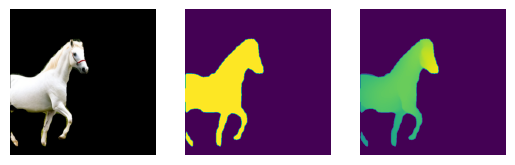

 40%|███████████████████████████▋                                          | 237/600 [00:01<00:02, 121.35it/s]

tensor(0.3764, device='cuda:0') tensor(0.5170, device='cuda:0')
tensor(0.3759, device='cuda:0') tensor(0.5133, device='cuda:0')
tensor(0.3711, device='cuda:0') tensor(0.5132, device='cuda:0')
tensor(0.3627, device='cuda:0') tensor(0.5137, device='cuda:0')
tensor(0.3507, device='cuda:0') tensor(0.5139, device='cuda:0')
tensor(0.3348, device='cuda:0') tensor(0.5143, device='cuda:0')
tensor(0.3082, device='cuda:0') tensor(0.5148, device='cuda:0')
tensor(0.2791, device='cuda:0') tensor(0.5151, device='cuda:0')
tensor(0.2394, device='cuda:0') tensor(0.5152, device='cuda:0')
tensor(0.2375, device='cuda:0') tensor(0.5148, device='cuda:0')
tensor(0.2372, device='cuda:0') tensor(0.5146, device='cuda:0')
tensor(0.2369, device='cuda:0') tensor(0.5142, device='cuda:0')
tensor(0.2370, device='cuda:0') tensor(0.5138, device='cuda:0')
tensor(0.2369, device='cuda:0') tensor(0.5131, device='cuda:0')
tensor(0.2369, device='cuda:0') tensor(0.5131, device='cuda:0')
tensor(0.2369, device='cuda:0') tensor(0

 44%|██████████████████████████████▋                                       | 263/600 [00:02<00:02, 120.81it/s]

tensor(0.2359, device='cuda:0') tensor(0.5169, device='cuda:0')
tensor(0.2352, device='cuda:0') tensor(0.5175, device='cuda:0')
tensor(0.2352, device='cuda:0') tensor(0.5177, device='cuda:0')
tensor(0.2355, device='cuda:0') tensor(0.5178, device='cuda:0')
tensor(0.2358, device='cuda:0') tensor(0.5183, device='cuda:0')
tensor(0.2366, device='cuda:0') tensor(0.5187, device='cuda:0')
tensor(0.2369, device='cuda:0') tensor(0.5216, device='cuda:0')
tensor(0.2372, device='cuda:0') tensor(0.5238, device='cuda:0')
tensor(0.2376, device='cuda:0') tensor(0.5276, device='cuda:0')
tensor(0.2379, device='cuda:0') tensor(0.5319, device='cuda:0')
tensor(0.2382, device='cuda:0') tensor(0.5383, device='cuda:0')
tensor(0.2384, device='cuda:0') tensor(0.5458, device='cuda:0')
tensor(0.2388, device='cuda:0') tensor(0.5541, device='cuda:0')
tensor(0.2390, device='cuda:0') tensor(0.5645, device='cuda:0')
tensor(0.2392, device='cuda:0') tensor(0.5655, device='cuda:0')
tensor(0.2396, device='cuda:0') tensor(0

 48%|█████████████████████████████████▋                                    | 289/600 [00:02<00:02, 119.84it/s]

tensor(0.2462, device='cuda:0') tensor(0.4959, device='cuda:0')
tensor(0.2474, device='cuda:0') tensor(0.4755, device='cuda:0')
tensor(0.2485, device='cuda:0') tensor(0.4530, device='cuda:0')
tensor(0.2495, device='cuda:0') tensor(0.4299, device='cuda:0')
tensor(0.2504, device='cuda:0') tensor(0.4298, device='cuda:0')
tensor(0.2516, device='cuda:0') tensor(0.4297, device='cuda:0')
tensor(0.2522, device='cuda:0') tensor(0.4295, device='cuda:0')
tensor(0.2529, device='cuda:0') tensor(0.4295, device='cuda:0')
tensor(0.2535, device='cuda:0') tensor(0.4297, device='cuda:0')
tensor(0.2539, device='cuda:0') tensor(0.4297, device='cuda:0')
tensor(0.2541, device='cuda:0') tensor(0.4297, device='cuda:0')
tensor(0.2540, device='cuda:0') tensor(0.4297, device='cuda:0')
tensor(0.2539, device='cuda:0') tensor(0.4296, device='cuda:0')
tensor(0.2537, device='cuda:0') tensor(0.4297, device='cuda:0')
tensor(0.2535, device='cuda:0') tensor(0.4298, device='cuda:0')
tensor(0.2531, device='cuda:0') tensor(0

 50%|███████████████████████████████████                                   | 301/600 [00:02<00:02, 119.32it/s]

tensor(0.2481, device='cuda:0') tensor(0.4299, device='cuda:0')
tensor(0.2481, device='cuda:0') tensor(0.4298, device='cuda:0')
tensor(0.2482, device='cuda:0') tensor(0.4296, device='cuda:0')
tensor(0.2485, device='cuda:0') tensor(0.4294, device='cuda:0')
tensor(0.2489, device='cuda:0') tensor(0.4290, device='cuda:0')
tensor(0.2495, device='cuda:0') tensor(0.4289, device='cuda:0')
tensor(0.2501, device='cuda:0') tensor(0.4288, device='cuda:0')
tensor(0.2507, device='cuda:0') tensor(0.4287, device='cuda:0')
tensor(0.2510, device='cuda:0') tensor(0.4285, device='cuda:0')
tensor(0.2512, device='cuda:0') tensor(0.4283, device='cuda:0')
tensor(0.2515, device='cuda:0') tensor(0.4282, device='cuda:0')
tensor(0.2517, device='cuda:0') tensor(0.4282, device='cuda:0')
tensor(0.2516, device='cuda:0') tensor(0.4281, device='cuda:0')
tensor(0.2517, device='cuda:0') tensor(0.4280, device='cuda:0')
tensor(0.2518, device='cuda:0') tensor(0.4279, device='cuda:0')
tensor(0.2519, device='cuda:0') tensor(0

 56%|███████████████████████████████████████▎                              | 337/600 [00:02<00:02, 118.90it/s]

tensor(0.2515, device='cuda:0') tensor(0.4255, device='cuda:0')
tensor(0.2516, device='cuda:0') tensor(0.4254, device='cuda:0')
tensor(0.2518, device='cuda:0') tensor(0.4251, device='cuda:0')
tensor(0.2520, device='cuda:0') tensor(0.4252, device='cuda:0')
tensor(0.2524, device='cuda:0') tensor(0.4251, device='cuda:0')
tensor(0.2527, device='cuda:0') tensor(0.4252, device='cuda:0')
tensor(0.2527, device='cuda:0') tensor(0.4252, device='cuda:0')
tensor(0.2528, device='cuda:0') tensor(0.4252, device='cuda:0')
tensor(0.2529, device='cuda:0') tensor(0.4252, device='cuda:0')
tensor(0.2528, device='cuda:0') tensor(0.4252, device='cuda:0')
tensor(0.2526, device='cuda:0') tensor(0.4253, device='cuda:0')
tensor(0.2523, device='cuda:0') tensor(0.4252, device='cuda:0')
tensor(0.2522, device='cuda:0') tensor(0.4254, device='cuda:0')
tensor(0.2519, device='cuda:0') tensor(0.4253, device='cuda:0')
tensor(0.2516, device='cuda:0') tensor(0.4253, device='cuda:0')
tensor(0.2514, device='cuda:0') tensor(0

 58%|████████████████████████████████████████▋                             | 349/600 [00:02<00:02, 118.55it/s]

tensor(0.2477, device='cuda:0') tensor(0.5358, device='cuda:0')
tensor(0.2473, device='cuda:0') tensor(0.5733, device='cuda:0')
tensor(0.2468, device='cuda:0') tensor(0.6063, device='cuda:0')
tensor(0.2464, device='cuda:0') tensor(0.6260, device='cuda:0')
tensor(0.2459, device='cuda:0') tensor(0.6424, device='cuda:0')
tensor(0.2456, device='cuda:0') tensor(0.6489, device='cuda:0')
tensor(0.2455, device='cuda:0') tensor(0.6493, device='cuda:0')
tensor(0.2453, device='cuda:0') tensor(0.6497, device='cuda:0')
tensor(0.2451, device='cuda:0') tensor(0.6498, device='cuda:0')
tensor(0.2448, device='cuda:0') tensor(0.6500, device='cuda:0')
tensor(0.2447, device='cuda:0') tensor(0.6504, device='cuda:0')
tensor(0.2444, device='cuda:0') tensor(0.6497, device='cuda:0')
tensor(0.2440, device='cuda:0') tensor(0.6455, device='cuda:0')
tensor(0.2437, device='cuda:0') tensor(0.6355, device='cuda:0')
tensor(0.2438, device='cuda:0') tensor(0.6195, device='cuda:0')
tensor(0.2440, device='cuda:0') tensor(0

 64%|████████████████████████████████████████████▉                         | 385/600 [00:03<00:01, 118.43it/s]

tensor(0.2399, device='cuda:0') tensor(0.5634, device='cuda:0')
tensor(0.2398, device='cuda:0') tensor(0.5627, device='cuda:0')
tensor(0.2395, device='cuda:0') tensor(0.5629, device='cuda:0')
tensor(0.2393, device='cuda:0') tensor(0.5636, device='cuda:0')
tensor(0.2392, device='cuda:0') tensor(0.5641, device='cuda:0')
tensor(0.2392, device='cuda:0') tensor(0.5645, device='cuda:0')
tensor(0.2392, device='cuda:0') tensor(0.5646, device='cuda:0')
tensor(0.2393, device='cuda:0') tensor(0.5649, device='cuda:0')
tensor(0.2392, device='cuda:0') tensor(0.5653, device='cuda:0')
tensor(0.2390, device='cuda:0') tensor(0.5656, device='cuda:0')
tensor(0.2390, device='cuda:0') tensor(0.5659, device='cuda:0')
tensor(0.2392, device='cuda:0') tensor(0.5659, device='cuda:0')
tensor(0.2394, device='cuda:0') tensor(0.5658, device='cuda:0')
tensor(0.2396, device='cuda:0') tensor(0.5657, device='cuda:0')
tensor(0.2398, device='cuda:0') tensor(0.5654, device='cuda:0')
tensor(0.2405, device='cuda:0') tensor(0

100%|██████████████████████████████████████████████████████████████████████| 600/600 [00:05<00:00, 112.29it/s]


/grogu/user/akirchme/art3d_sd_webui/images/horse/1228.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/1228.mp4


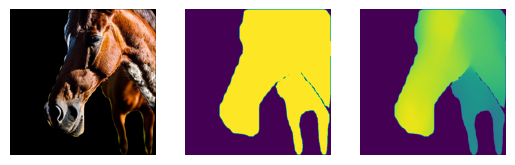

  4%|██▊                                                                    | 24/600 [00:00<00:04, 117.85it/s]

tensor(0.2936, device='cuda:0') tensor(0.4945, device='cuda:0')
tensor(0.2933, device='cuda:0') tensor(0.4946, device='cuda:0')
tensor(0.2927, device='cuda:0') tensor(0.4947, device='cuda:0')
tensor(0.2917, device='cuda:0') tensor(0.4947, device='cuda:0')
tensor(0.2907, device='cuda:0') tensor(0.4947, device='cuda:0')
tensor(0.2898, device='cuda:0') tensor(0.4947, device='cuda:0')
tensor(0.2886, device='cuda:0') tensor(0.4946, device='cuda:0')
tensor(0.2874, device='cuda:0') tensor(0.4946, device='cuda:0')
tensor(0.2863, device='cuda:0') tensor(0.4946, device='cuda:0')
tensor(0.2849, device='cuda:0') tensor(0.4947, device='cuda:0')
tensor(0.2837, device='cuda:0') tensor(0.4948, device='cuda:0')
tensor(0.2824, device='cuda:0') tensor(0.4946, device='cuda:0')
tensor(0.2808, device='cuda:0') tensor(0.4946, device='cuda:0')
tensor(0.2794, device='cuda:0') tensor(0.4945, device='cuda:0')
tensor(0.2781, device='cuda:0') tensor(0.4944, device='cuda:0')
tensor(0.2769, device='cuda:0') tensor(0

  8%|█████▋                                                                 | 48/600 [00:00<00:04, 118.04it/s]

tensor(0.2631, device='cuda:0') tensor(0.4934, device='cuda:0')
tensor(0.2623, device='cuda:0') tensor(0.4934, device='cuda:0')
tensor(0.2614, device='cuda:0') tensor(0.4934, device='cuda:0')
tensor(0.2605, device='cuda:0') tensor(0.4934, device='cuda:0')
tensor(0.2594, device='cuda:0') tensor(0.4935, device='cuda:0')
tensor(0.2584, device='cuda:0') tensor(0.4936, device='cuda:0')
tensor(0.2574, device='cuda:0') tensor(0.4939, device='cuda:0')
tensor(0.2562, device='cuda:0') tensor(0.4941, device='cuda:0')
tensor(0.2549, device='cuda:0') tensor(0.4993, device='cuda:0')
tensor(0.2537, device='cuda:0') tensor(0.5113, device='cuda:0')
tensor(0.2527, device='cuda:0') tensor(0.5362, device='cuda:0')
tensor(0.2518, device='cuda:0') tensor(0.5646, device='cuda:0')
tensor(0.2509, device='cuda:0') tensor(0.5848, device='cuda:0')
tensor(0.2499, device='cuda:0') tensor(0.6002, device='cuda:0')
tensor(0.2492, device='cuda:0') tensor(0.6133, device='cuda:0')
tensor(0.2483, device='cuda:0') tensor(0

 12%|████████▋                                                              | 73/600 [00:00<00:04, 119.27it/s]

tensor(0.2424, device='cuda:0') tensor(0.6208, device='cuda:0')
tensor(0.2419, device='cuda:0') tensor(0.6013, device='cuda:0')
tensor(0.2414, device='cuda:0') tensor(0.5885, device='cuda:0')
tensor(0.2410, device='cuda:0') tensor(0.5802, device='cuda:0')
tensor(0.2403, device='cuda:0') tensor(0.5710, device='cuda:0')
tensor(0.2397, device='cuda:0') tensor(0.5648, device='cuda:0')
tensor(0.2390, device='cuda:0') tensor(0.5596, device='cuda:0')
tensor(0.2383, device='cuda:0') tensor(0.5609, device='cuda:0')
tensor(0.2376, device='cuda:0') tensor(0.5623, device='cuda:0')
tensor(0.2369, device='cuda:0') tensor(0.5631, device='cuda:0')
tensor(0.2364, device='cuda:0') tensor(0.5637, device='cuda:0')
tensor(0.2361, device='cuda:0') tensor(0.5632, device='cuda:0')
tensor(0.2358, device='cuda:0') tensor(0.5627, device='cuda:0')
tensor(0.2356, device='cuda:0') tensor(0.5617, device='cuda:0')
tensor(0.2354, device='cuda:0') tensor(0.5615, device='cuda:0')
tensor(0.2353, device='cuda:0') tensor(0

 14%|██████████                                                             | 85/600 [00:00<00:04, 106.30it/s]

tensor(0.2345, device='cuda:0') tensor(0.5538, device='cuda:0')
tensor(0.2345, device='cuda:0') tensor(0.5528, device='cuda:0')
tensor(0.2356, device='cuda:0') tensor(0.5517, device='cuda:0')
tensor(0.2470, device='cuda:0') tensor(0.5507, device='cuda:0')
tensor(0.2814, device='cuda:0') tensor(0.5490, device='cuda:0')


 47%|█████████████████████████████████▎                                     | 281/600 [00:03<00:03, 84.99it/s]

tensor(0.3852, device='cuda:0') tensor(0.5152, device='cuda:0')
tensor(0.3856, device='cuda:0') tensor(0.5075, device='cuda:0')
tensor(0.3861, device='cuda:0') tensor(0.5026, device='cuda:0')
tensor(0.3865, device='cuda:0') tensor(0.5026, device='cuda:0')
tensor(0.3869, device='cuda:0') tensor(0.5024, device='cuda:0')
tensor(0.3872, device='cuda:0') tensor(0.5024, device='cuda:0')
tensor(0.3875, device='cuda:0') tensor(0.5024, device='cuda:0')
tensor(0.3877, device='cuda:0') tensor(0.5025, device='cuda:0')
tensor(0.3879, device='cuda:0') tensor(0.5025, device='cuda:0')
tensor(0.3881, device='cuda:0') tensor(0.5025, device='cuda:0')
tensor(0.3882, device='cuda:0') tensor(0.5025, device='cuda:0')
tensor(0.3882, device='cuda:0') tensor(0.5025, device='cuda:0')
tensor(0.3883, device='cuda:0') tensor(0.5024, device='cuda:0')
tensor(0.3882, device='cuda:0') tensor(0.5025, device='cuda:0')
tensor(0.3881, device='cuda:0') tensor(0.5024, device='cuda:0')
tensor(0.3879, device='cuda:0') tensor(0

 51%|███████████████████████████████████▌                                  | 305/600 [00:03<00:02, 102.38it/s]

tensor(0.5024, device='cuda:0')
tensor(0.3868, device='cuda:0') tensor(0.5025, device='cuda:0')
tensor(0.3872, device='cuda:0') tensor(0.5025, device='cuda:0')
tensor(0.3876, device='cuda:0') tensor(0.5026, device='cuda:0')
tensor(0.3881, device='cuda:0') tensor(0.5026, device='cuda:0')
tensor(0.3886, device='cuda:0') tensor(0.5025, device='cuda:0')
tensor(0.3889, device='cuda:0') tensor(0.5026, device='cuda:0')
tensor(0.3892, device='cuda:0') tensor(0.5026, device='cuda:0')
tensor(0.3897, device='cuda:0') tensor(0.5026, device='cuda:0')
tensor(0.3903, device='cuda:0') tensor(0.5026, device='cuda:0')
tensor(0.3905, device='cuda:0') tensor(0.5026, device='cuda:0')
tensor(0.3904, device='cuda:0') tensor(0.5026, device='cuda:0')
tensor(0.3902, device='cuda:0') tensor(0.5026, device='cuda:0')
tensor(0.3902, device='cuda:0') tensor(0.5027, device='cuda:0')
tensor(0.3903, device='cuda:0') tensor(0.5027, device='cuda:0')
tensor(0.3903, device='cuda:0') tensor(0.5027, device='cuda:0')
tensor(0

 55%|██████████████████████████████████████▍                               | 329/600 [00:03<00:02, 110.68it/s]

tensor(0.3934, device='cuda:0') tensor(0.5023, device='cuda:0')
tensor(0.3939, device='cuda:0') tensor(0.5024, device='cuda:0')
tensor(0.3940, device='cuda:0') tensor(0.5024, device='cuda:0')
tensor(0.3941, device='cuda:0') tensor(0.5024, device='cuda:0')
tensor(0.3938, device='cuda:0') tensor(0.5025, device='cuda:0')
tensor(0.3936, device='cuda:0') tensor(0.5024, device='cuda:0')
tensor(0.3935, device='cuda:0') tensor(0.5023, device='cuda:0')
tensor(0.3935, device='cuda:0') tensor(0.5023, device='cuda:0')
tensor(0.3935, device='cuda:0') tensor(0.5023, device='cuda:0')
tensor(0.3934, device='cuda:0') tensor(0.5023, device='cuda:0')
tensor(0.3934, device='cuda:0') tensor(0.5022, device='cuda:0')
tensor(0.3932, device='cuda:0') tensor(0.5021, device='cuda:0')
tensor(0.3931, device='cuda:0') tensor(0.5020, device='cuda:0')
tensor(0.3929, device='cuda:0') tensor(0.5020, device='cuda:0')
tensor(0.3927, device='cuda:0') tensor(0.5018, device='cuda:0')
tensor(0.3926, device='cuda:0') tensor(0

 89%|███████████████████████████████████████████████████████████████▎       | 535/600 [00:06<00:00, 83.65it/s]

tensor(0.2938, device='cuda:0') tensor(0.5532, device='cuda:0')
tensor(0.2757, device='cuda:0') tensor(0.5537, device='cuda:0')
tensor(0.2561, device='cuda:0') tensor(0.5546, device='cuda:0')
tensor(0.2442, device='cuda:0') tensor(0.5553, device='cuda:0')
tensor(0.2347, device='cuda:0') tensor(0.5564, device='cuda:0')
tensor(0.2340, device='cuda:0') tensor(0.5573, device='cuda:0')
tensor(0.2338, device='cuda:0') tensor(0.5586, device='cuda:0')
tensor(0.2336, device='cuda:0') tensor(0.5596, device='cuda:0')
tensor(0.2335, device='cuda:0') tensor(0.5601, device='cuda:0')
tensor(0.2336, device='cuda:0') tensor(0.5603, device='cuda:0')
tensor(0.2336, device='cuda:0') tensor(0.5606, device='cuda:0')
tensor(0.2341, device='cuda:0') tensor(0.5611, device='cuda:0')
tensor(0.2350, device='cuda:0') tensor(0.5611, device='cuda:0')
tensor(0.2361, device='cuda:0') tensor(0.5604, device='cuda:0')
tensor(0.2383, device='cuda:0') tensor(0.5598, device='cuda:0')
tensor(0.2414, device='cuda:0') tensor(0

 93%|█████████████████████████████████████████████████████████████████▏    | 559/600 [00:07<00:00, 100.88it/s]

tensor(0.2554, device='cuda:0') tensor(0.5484, device='cuda:0')
tensor(0.2570, device='cuda:0') tensor(0.5474, device='cuda:0')
tensor(0.2582, device='cuda:0') tensor(0.5506, device='cuda:0')
tensor(0.2596, device='cuda:0') tensor(0.5563, device='cuda:0')
tensor(0.2609, device='cuda:0') tensor(0.5625, device='cuda:0')
tensor(0.2618, device='cuda:0') tensor(0.5706, device='cuda:0')
tensor(0.2625, device='cuda:0') tensor(0.5815, device='cuda:0')
tensor(0.2633, device='cuda:0') tensor(0.5893, device='cuda:0')
tensor(0.2640, device='cuda:0') tensor(0.5941, device='cuda:0')
tensor(0.2648, device='cuda:0') tensor(0.5963, device='cuda:0')
tensor(0.2655, device='cuda:0') tensor(0.5957, device='cuda:0')
tensor(0.2661, device='cuda:0') tensor(0.5952, device='cuda:0')
tensor(0.2667, device='cuda:0') tensor(0.5948, device='cuda:0')
tensor(0.2676, device='cuda:0') tensor(0.5945, device='cuda:0')
tensor(0.2688, device='cuda:0') tensor(0.5941, device='cuda:0')
tensor(0.2702, device='cuda:0') tensor(0

 97%|████████████████████████████████████████████████████████████████████  | 583/600 [00:07<00:00, 109.30it/s]

tensor(0.2854, device='cuda:0') tensor(0.4955, device='cuda:0')
tensor(0.2868, device='cuda:0') tensor(0.4954, device='cuda:0')
tensor(0.2879, device='cuda:0') tensor(0.4952, device='cuda:0')
tensor(0.2892, device='cuda:0') tensor(0.4950, device='cuda:0')
tensor(0.2904, device='cuda:0') tensor(0.4948, device='cuda:0')
tensor(0.2915, device='cuda:0') tensor(0.4947, device='cuda:0')
tensor(0.2922, device='cuda:0') tensor(0.4946, device='cuda:0')
tensor(0.2928, device='cuda:0') tensor(0.4948, device='cuda:0')
tensor(0.2933, device='cuda:0') tensor(0.4948, device='cuda:0')
tensor(0.2936, device='cuda:0') tensor(0.4947, device='cuda:0')
tensor(0.2940, device='cuda:0') tensor(0.4945, device='cuda:0')
tensor(0.2943, device='cuda:0') tensor(0.4944, device='cuda:0')
tensor(0.2944, device='cuda:0') tensor(0.4942, device='cuda:0')
tensor(0.2945, device='cuda:0') tensor(0.4942, device='cuda:0')
tensor(0.2941, device='cuda:0') tensor(0.4940, device='cuda:0')
tensor(0.2937, device='cuda:0') tensor(0

100%|███████████████████████████████████████████████████████████████████████| 600/600 [00:07<00:00, 80.12it/s]


tensor(0.2922, device='cuda:0') tensor(0.4943, device='cuda:0')
tensor(0.2926, device='cuda:0') tensor(0.4944, device='cuda:0')
tensor(0.2930, device='cuda:0') tensor(0.4945, device='cuda:0')
tensor(0.2934, device='cuda:0') tensor(0.4945, device='cuda:0')
tensor(0.2936, device='cuda:0') tensor(0.4945, device='cuda:0')
tensor(0.2938, device='cuda:0') tensor(0.4945, device='cuda:0')
tensor(0.2939, device='cuda:0') tensor(0.4945, device='cuda:0')
tensor(0.2938, device='cuda:0') tensor(0.4946, device='cuda:0')
/grogu/user/akirchme/art3d_sd_webui/images/horse/919.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/919.mp4


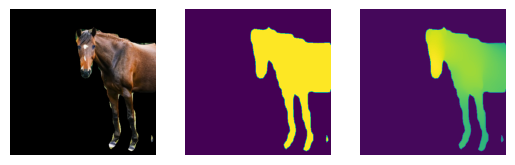

  2%|█▍                                                                     | 12/600 [00:00<00:05, 116.63it/s]

tensor(0.1812, device='cuda:0') tensor(0.4292, device='cuda:0')
tensor(0.1812, device='cuda:0') tensor(0.4292, device='cuda:0')
tensor(0.1813, device='cuda:0') tensor(0.4294, device='cuda:0')
tensor(0.1814, device='cuda:0') tensor(0.4294, device='cuda:0')
tensor(0.1815, device='cuda:0') tensor(0.4295, device='cuda:0')
tensor(0.1816, device='cuda:0') tensor(0.4297, device='cuda:0')
tensor(0.1815, device='cuda:0') tensor(0.4297, device='cuda:0')
tensor(0.1816, device='cuda:0') tensor(0.4298, device='cuda:0')
tensor(0.1817, device='cuda:0') tensor(0.4299, device='cuda:0')
tensor(0.1817, device='cuda:0') tensor(0.4300, device='cuda:0')
tensor(0.1818, device='cuda:0') tensor(0.4300, device='cuda:0')
tensor(0.1818, device='cuda:0') tensor(0.4301, device='cuda:0')
tensor(0.1818, device='cuda:0') tensor(0.4303, device='cuda:0')
tensor(0.1819, device='cuda:0') tensor(0.4303, device='cuda:0')
tensor(0.1819, device='cuda:0') tensor(0.4302, device='cuda:0')
tensor(0.1819, device='cuda:0') tensor(0

  6%|████▍                                                                  | 38/600 [00:00<00:04, 119.59it/s]

tensor(0.1870, device='cuda:0') tensor(0.4307, device='cuda:0')
tensor(0.1870, device='cuda:0') tensor(0.4308, device='cuda:0')
tensor(0.1870, device='cuda:0') tensor(0.4307, device='cuda:0')
tensor(0.1868, device='cuda:0') tensor(0.4308, device='cuda:0')
tensor(0.1865, device='cuda:0') tensor(0.4308, device='cuda:0')
tensor(0.1861, device='cuda:0') tensor(0.4308, device='cuda:0')
tensor(0.1857, device='cuda:0') tensor(0.4309, device='cuda:0')
tensor(0.1849, device='cuda:0') tensor(0.4313, device='cuda:0')
tensor(0.1841, device='cuda:0') tensor(0.4641, device='cuda:0')
tensor(0.1834, device='cuda:0') tensor(0.5123, device='cuda:0')
tensor(0.1828, device='cuda:0') tensor(0.5458, device='cuda:0')
tensor(0.1826, device='cuda:0') tensor(0.5612, device='cuda:0')
tensor(0.1822, device='cuda:0') tensor(0.5713, device='cuda:0')
tensor(0.1819, device='cuda:0') tensor(0.5792, device='cuda:0')
tensor(0.1818, device='cuda:0') tensor(0.5856, device='cuda:0')
tensor(0.1817, device='cuda:0') tensor(0

 11%|███████▌                                                               | 64/600 [00:00<00:04, 120.25it/s]

tensor(0.1812, device='cuda:0') tensor(0.5047, device='cuda:0')
tensor(0.1811, device='cuda:0') tensor(0.4975, device='cuda:0')
tensor(0.1811, device='cuda:0') tensor(0.4924, device='cuda:0')
tensor(0.1813, device='cuda:0') tensor(0.4888, device='cuda:0')
tensor(0.1813, device='cuda:0') tensor(0.4874, device='cuda:0')
tensor(0.1812, device='cuda:0') tensor(0.4869, device='cuda:0')
tensor(0.1812, device='cuda:0') tensor(0.4869, device='cuda:0')
tensor(0.1812, device='cuda:0') tensor(0.4872, device='cuda:0')
tensor(0.1810, device='cuda:0') tensor(0.4873, device='cuda:0')
tensor(0.1809, device='cuda:0') tensor(0.4875, device='cuda:0')
tensor(0.1808, device='cuda:0') tensor(0.4877, device='cuda:0')
tensor(0.1808, device='cuda:0') tensor(0.4878, device='cuda:0')
tensor(0.1809, device='cuda:0') tensor(0.4880, device='cuda:0')
tensor(0.1808, device='cuda:0') tensor(0.4882, device='cuda:0')
tensor(0.1808, device='cuda:0') tensor(0.4885, device='cuda:0')
tensor(0.1807, device='cuda:0') tensor(0

 15%|██████████▌                                                            | 89/600 [00:00<00:04, 118.64it/s]

tensor(0.4877, device='cuda:0')
tensor(0.1813, device='cuda:0') tensor(0.4874, device='cuda:0')
tensor(0.1856, device='cuda:0') tensor(0.4873, device='cuda:0')
tensor(0.2485, device='cuda:0') tensor(0.4873, device='cuda:0')
tensor(0.2997, device='cuda:0') tensor(0.4872, device='cuda:0')
tensor(0.3180, device='cuda:0') tensor(0.4873, device='cuda:0')
tensor(0.3299, device='cuda:0') tensor(0.4874, device='cuda:0')
tensor(0.3374, device='cuda:0') tensor(0.4874, device='cuda:0')
tensor(0.3407, device='cuda:0') tensor(0.4873, device='cuda:0')
tensor(0.3411, device='cuda:0') tensor(0.4878, device='cuda:0')
tensor(0.3413, device='cuda:0') tensor(0.5015, device='cuda:0')


 91%|███████████████████████████████████████████████████████████████▊      | 547/600 [00:04<00:00, 116.79it/s]

tensor(0.2226, device='cuda:0') tensor(0.5743, device='cuda:0')
tensor(0.1835, device='cuda:0') tensor(0.5746, device='cuda:0')
tensor(0.1813, device='cuda:0') tensor(0.5749, device='cuda:0')
tensor(0.1811, device='cuda:0') tensor(0.5749, device='cuda:0')
tensor(0.1810, device='cuda:0') tensor(0.5750, device='cuda:0')
tensor(0.1808, device='cuda:0') tensor(0.5753, device='cuda:0')
tensor(0.1807, device='cuda:0') tensor(0.5754, device='cuda:0')
tensor(0.1806, device='cuda:0') tensor(0.5755, device='cuda:0')
tensor(0.1807, device='cuda:0') tensor(0.5755, device='cuda:0')
tensor(0.1806, device='cuda:0') tensor(0.5757, device='cuda:0')
tensor(0.1805, device='cuda:0') tensor(0.5756, device='cuda:0')
tensor(0.1804, device='cuda:0') tensor(0.5756, device='cuda:0')
tensor(0.1803, device='cuda:0') tensor(0.5756, device='cuda:0')
tensor(0.1803, device='cuda:0') tensor(0.5755, device='cuda:0')
tensor(0.1802, device='cuda:0') tensor(0.5753, device='cuda:0')
tensor(0.1802, device='cuda:0') tensor(0

 93%|█████████████████████████████████████████████████████████████████▏    | 559/600 [00:04<00:00, 117.38it/s]

tensor(0.1800, device='cuda:0') tensor(0.5844, device='cuda:0')
tensor(0.1800, device='cuda:0') tensor(0.5946, device='cuda:0')
tensor(0.1799, device='cuda:0') tensor(0.6115, device='cuda:0')
tensor(0.1799, device='cuda:0') tensor(0.6314, device='cuda:0')
tensor(0.1798, device='cuda:0') tensor(0.6645, device='cuda:0')
tensor(0.1798, device='cuda:0') tensor(0.6811, device='cuda:0')
tensor(0.1797, device='cuda:0') tensor(0.6920, device='cuda:0')
tensor(0.1796, device='cuda:0') tensor(0.6927, device='cuda:0')
tensor(0.1795, device='cuda:0') tensor(0.6925, device='cuda:0')
tensor(0.1795, device='cuda:0') tensor(0.6925, device='cuda:0')
tensor(0.1794, device='cuda:0') tensor(0.6924, device='cuda:0')
tensor(0.1794, device='cuda:0') tensor(0.6922, device='cuda:0')
tensor(0.1795, device='cuda:0') tensor(0.6906, device='cuda:0')
tensor(0.1796, device='cuda:0') tensor(0.6806, device='cuda:0')
tensor(0.1796, device='cuda:0') tensor(0.6666, device='cuda:0')
tensor(0.1796, device='cuda:0') tensor(0

 97%|████████████████████████████████████████████████████████████████████▏ | 584/600 [00:05<00:00, 119.21it/s]

tensor(0.1806, device='cuda:0') tensor(0.4282, device='cuda:0')
tensor(0.1807, device='cuda:0') tensor(0.4281, device='cuda:0')
tensor(0.1807, device='cuda:0') tensor(0.4282, device='cuda:0')
tensor(0.1807, device='cuda:0') tensor(0.4281, device='cuda:0')
tensor(0.1808, device='cuda:0') tensor(0.4281, device='cuda:0')
tensor(0.1809, device='cuda:0') tensor(0.4282, device='cuda:0')
tensor(0.1808, device='cuda:0') tensor(0.4283, device='cuda:0')
tensor(0.1808, device='cuda:0') tensor(0.4284, device='cuda:0')
tensor(0.1809, device='cuda:0') tensor(0.4284, device='cuda:0')
tensor(0.1808, device='cuda:0') tensor(0.4284, device='cuda:0')
tensor(0.1808, device='cuda:0') tensor(0.4284, device='cuda:0')
tensor(0.1808, device='cuda:0') tensor(0.4285, device='cuda:0')
tensor(0.1808, device='cuda:0') tensor(0.4286, device='cuda:0')
tensor(0.1808, device='cuda:0') tensor(0.4286, device='cuda:0')
tensor(0.1808, device='cuda:0') tensor(0.4286, device='cuda:0')
tensor(0.1808, device='cuda:0') tensor(0

100%|██████████████████████████████████████████████████████████████████████| 600/600 [00:05<00:00, 116.38it/s]


tensor(0.1809, device='cuda:0') tensor(0.4290, device='cuda:0')
tensor(0.1811, device='cuda:0') tensor(0.4291, device='cuda:0')
tensor(0.1811, device='cuda:0') tensor(0.4291, device='cuda:0')
tensor(0.1811, device='cuda:0') tensor(0.4291, device='cuda:0')
/grogu/user/akirchme/art3d_sd_webui/images/horse/1649.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/1649.mp4


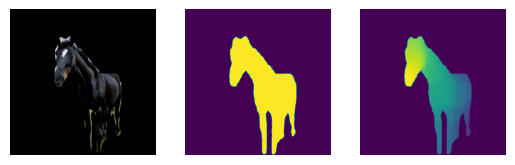

  4%|██▊                                                                    | 24/600 [00:00<00:04, 118.40it/s]

tensor(0.2665, device='cuda:0') tensor(0.3967, device='cuda:0')
tensor(0.2665, device='cuda:0') tensor(0.3967, device='cuda:0')
tensor(0.2665, device='cuda:0') tensor(0.3967, device='cuda:0')
tensor(0.2665, device='cuda:0') tensor(0.3968, device='cuda:0')
tensor(0.2663, device='cuda:0') tensor(0.3968, device='cuda:0')
tensor(0.2662, device='cuda:0') tensor(0.3968, device='cuda:0')
tensor(0.2662, device='cuda:0') tensor(0.3968, device='cuda:0')
tensor(0.2657, device='cuda:0') tensor(0.3969, device='cuda:0')
tensor(0.2652, device='cuda:0') tensor(0.3972, device='cuda:0')
tensor(0.2650, device='cuda:0') tensor(0.3973, device='cuda:0')
tensor(0.2648, device='cuda:0') tensor(0.3974, device='cuda:0')
tensor(0.2644, device='cuda:0') tensor(0.3975, device='cuda:0')
tensor(0.2641, device='cuda:0') tensor(0.3975, device='cuda:0')
tensor(0.2637, device='cuda:0') tensor(0.3976, device='cuda:0')
tensor(0.2635, device='cuda:0') tensor(0.3976, device='cuda:0')
tensor(0.2632, device='cuda:0') tensor(0

  6%|████▍                                                                  | 37/600 [00:00<00:04, 119.17it/s]

tensor(0.2577, device='cuda:0') tensor(0.3997, device='cuda:0')
tensor(0.2572, device='cuda:0') tensor(0.4000, device='cuda:0')
tensor(0.2566, device='cuda:0') tensor(0.4003, device='cuda:0')
tensor(0.2558, device='cuda:0') tensor(0.4005, device='cuda:0')
tensor(0.2548, device='cuda:0') tensor(0.4008, device='cuda:0')
tensor(0.2541, device='cuda:0') tensor(0.4011, device='cuda:0')
tensor(0.2533, device='cuda:0') tensor(0.4015, device='cuda:0')
tensor(0.2524, device='cuda:0') tensor(0.4019, device='cuda:0')
tensor(0.2516, device='cuda:0') tensor(0.4023, device='cuda:0')
tensor(0.2508, device='cuda:0') tensor(0.4064, device='cuda:0')
tensor(0.2498, device='cuda:0') tensor(0.4159, device='cuda:0')
tensor(0.2485, device='cuda:0') tensor(0.4252, device='cuda:0')
tensor(0.2478, device='cuda:0') tensor(0.4365, device='cuda:0')
tensor(0.2463, device='cuda:0') tensor(0.4518, device='cuda:0')
tensor(0.2451, device='cuda:0') tensor(0.4671, device='cuda:0')
tensor(0.2443, device='cuda:0') tensor(0

 10%|███████▎                                                               | 62/600 [00:00<00:04, 119.71it/s]

tensor(0.2371, device='cuda:0') tensor(0.5021, device='cuda:0')
tensor(0.2366, device='cuda:0') tensor(0.4945, device='cuda:0')
tensor(0.2361, device='cuda:0') tensor(0.4798, device='cuda:0')
tensor(0.2358, device='cuda:0') tensor(0.4726, device='cuda:0')
tensor(0.2351, device='cuda:0') tensor(0.4702, device='cuda:0')
tensor(0.2340, device='cuda:0') tensor(0.4674, device='cuda:0')
tensor(0.2333, device='cuda:0') tensor(0.4650, device='cuda:0')
tensor(0.2324, device='cuda:0') tensor(0.4655, device='cuda:0')
tensor(0.2317, device='cuda:0') tensor(0.4665, device='cuda:0')
tensor(0.2306, device='cuda:0') tensor(0.4678, device='cuda:0')
tensor(0.2301, device='cuda:0') tensor(0.4692, device='cuda:0')
tensor(0.2297, device='cuda:0') tensor(0.4711, device='cuda:0')
tensor(0.2293, device='cuda:0') tensor(0.4725, device='cuda:0')
tensor(0.2286, device='cuda:0') tensor(0.4748, device='cuda:0')
tensor(0.2282, device='cuda:0') tensor(0.4770, device='cuda:0')
tensor(0.2281, device='cuda:0') tensor(0

 16%|███████████▌                                                           | 98/600 [00:00<00:04, 119.68it/s]

tensor(0.2287, device='cuda:0') tensor(0.4963, device='cuda:0')
tensor(0.2292, device='cuda:0') tensor(0.4955, device='cuda:0')
tensor(0.2292, device='cuda:0') tensor(0.4949, device='cuda:0')
tensor(0.2390, device='cuda:0') tensor(0.4935, device='cuda:0')
tensor(0.2525, device='cuda:0') tensor(0.4932, device='cuda:0')
tensor(0.2706, device='cuda:0') tensor(0.4925, device='cuda:0')
tensor(0.2922, device='cuda:0') tensor(0.4923, device='cuda:0')
tensor(0.3097, device='cuda:0') tensor(0.4921, device='cuda:0')
tensor(0.3231, device='cuda:0') tensor(0.4913, device='cuda:0')
tensor(0.3325, device='cuda:0') tensor(0.4909, device='cuda:0')
tensor(0.3342, device='cuda:0') tensor(0.4908, device='cuda:0')
tensor(0.3351, device='cuda:0') tensor(0.4905, device='cuda:0')
tensor(0.3371, device='cuda:0') tensor(0.4909, device='cuda:0')
tensor(0.3384, device='cuda:0') tensor(0.4909, device='cuda:0')
tensor(0.3400, device='cuda:0') tensor(0.4907, device='cuda:0')
tensor(0.3413, device='cuda:0') tensor(0

 18%|████████████▊                                                         | 110/600 [00:00<00:04, 119.68it/s]

tensor(0.3624, device='cuda:0') tensor(0.5090, device='cuda:0')
tensor(0.3668, device='cuda:0') tensor(0.5086, device='cuda:0')
tensor(0.3714, device='cuda:0') tensor(0.5079, device='cuda:0')
tensor(0.3763, device='cuda:0') tensor(0.5075, device='cuda:0')
tensor(0.3806, device='cuda:0') tensor(0.5072, device='cuda:0')
tensor(0.3847, device='cuda:0') tensor(0.5069, device='cuda:0')
tensor(0.3897, device='cuda:0') tensor(0.5066, device='cuda:0')
tensor(0.3938, device='cuda:0') tensor(0.5062, device='cuda:0')
tensor(0.3979, device='cuda:0') tensor(0.5051, device='cuda:0')
tensor(0.4015, device='cuda:0') tensor(0.5037, device='cuda:0')
tensor(0.4043, device='cuda:0') tensor(0.5020, device='cuda:0')
tensor(0.4061, device='cuda:0') tensor(0.4992, device='cuda:0')
tensor(0.4082, device='cuda:0') tensor(0.4954, device='cuda:0')
tensor(0.4098, device='cuda:0') tensor(0.4939, device='cuda:0')
tensor(0.4111, device='cuda:0') tensor(0.4930, device='cuda:0')
tensor(0.4121, device='cuda:0') tensor(0

 23%|███████████████▊                                                      | 136/600 [00:01<00:03, 120.92it/s]

tensor(0.4126, device='cuda:0') tensor(0.4890, device='cuda:0')
tensor(0.4123, device='cuda:0') tensor(0.4886, device='cuda:0')
tensor(0.4117, device='cuda:0') tensor(0.4883, device='cuda:0')
tensor(0.4109, device='cuda:0') tensor(0.4882, device='cuda:0')
tensor(0.4097, device='cuda:0') tensor(0.4881, device='cuda:0')
tensor(0.4090, device='cuda:0') tensor(0.4881, device='cuda:0')
tensor(0.4084, device='cuda:0') tensor(0.4882, device='cuda:0')
tensor(0.4081, device='cuda:0') tensor(0.4883, device='cuda:0')
tensor(0.4076, device='cuda:0') tensor(0.4884, device='cuda:0')
tensor(0.4067, device='cuda:0') tensor(0.4886, device='cuda:0')
tensor(0.4061, device='cuda:0') tensor(0.4889, device='cuda:0')
tensor(0.4059, device='cuda:0') tensor(0.4890, device='cuda:0')
tensor(0.4057, device='cuda:0') tensor(0.4895, device='cuda:0')
tensor(0.4055, device='cuda:0') tensor(0.4900, device='cuda:0')
tensor(0.4067, device='cuda:0') tensor(0.4907, device='cuda:0')
tensor(0.4072, device='cuda:0') tensor(0

 27%|██████████████████▉                                                   | 162/600 [00:01<00:03, 121.16it/s]

tensor(0.4310, device='cuda:0') tensor(0.5033, device='cuda:0')
tensor(0.4311, device='cuda:0') tensor(0.5038, device='cuda:0')
tensor(0.4314, device='cuda:0') tensor(0.5051, device='cuda:0')
tensor(0.4312, device='cuda:0') tensor(0.5058, device='cuda:0')
tensor(0.4311, device='cuda:0') tensor(0.5063, device='cuda:0')
tensor(0.4303, device='cuda:0') tensor(0.5069, device='cuda:0')
tensor(0.4235, device='cuda:0') tensor(0.5074, device='cuda:0')
tensor(0.4126, device='cuda:0') tensor(0.5082, device='cuda:0')
tensor(0.4029, device='cuda:0') tensor(0.5087, device='cuda:0')
tensor(0.3944, device='cuda:0') tensor(0.5096, device='cuda:0')
tensor(0.3912, device='cuda:0') tensor(0.5101, device='cuda:0')
tensor(0.3897, device='cuda:0') tensor(0.5111, device='cuda:0')
tensor(0.3890, device='cuda:0') tensor(0.5115, device='cuda:0')
tensor(0.3887, device='cuda:0') tensor(0.5122, device='cuda:0')
tensor(0.3883, device='cuda:0') tensor(0.5125, device='cuda:0')
tensor(0.3880, device='cuda:0') tensor(0

 31%|█████████████████████▉                                                | 188/600 [00:01<00:03, 121.51it/s]

tensor(0.3936, device='cuda:0') tensor(0.5081, device='cuda:0')
tensor(0.3942, device='cuda:0') tensor(0.5075, device='cuda:0')
tensor(0.3946, device='cuda:0') tensor(0.5067, device='cuda:0')
tensor(0.3954, device='cuda:0') tensor(0.5064, device='cuda:0')
tensor(0.3961, device='cuda:0') tensor(0.5058, device='cuda:0')
tensor(0.3967, device='cuda:0') tensor(0.5056, device='cuda:0')
tensor(0.3971, device='cuda:0') tensor(0.5054, device='cuda:0')
tensor(0.3974, device='cuda:0') tensor(0.5053, device='cuda:0')
tensor(0.3980, device='cuda:0') tensor(0.5054, device='cuda:0')
tensor(0.3986, device='cuda:0') tensor(0.5055, device='cuda:0')
tensor(0.3994, device='cuda:0') tensor(0.5056, device='cuda:0')
tensor(0.4001, device='cuda:0') tensor(0.5070, device='cuda:0')
tensor(0.3999, device='cuda:0') tensor(0.5120, device='cuda:0')
tensor(0.4002, device='cuda:0') tensor(0.5196, device='cuda:0')


 76%|████████████████████████████████████████████████████▉                 | 454/600 [00:03<00:01, 113.94it/s]

tensor(0.4141, device='cuda:0') tensor(0.5183, device='cuda:0')
tensor(0.4152, device='cuda:0') tensor(0.5169, device='cuda:0')
tensor(0.4167, device='cuda:0') tensor(0.5156, device='cuda:0')
tensor(0.4200, device='cuda:0') tensor(0.5141, device='cuda:0')
tensor(0.4237, device='cuda:0') tensor(0.5123, device='cuda:0')
tensor(0.4262, device='cuda:0') tensor(0.5107, device='cuda:0')
tensor(0.4352, device='cuda:0') tensor(0.5095, device='cuda:0')
tensor(0.4432, device='cuda:0') tensor(0.5080, device='cuda:0')
tensor(0.4443, device='cuda:0') tensor(0.5057, device='cuda:0')
tensor(0.4448, device='cuda:0') tensor(0.5039, device='cuda:0')
tensor(0.4456, device='cuda:0') tensor(0.5024, device='cuda:0')
tensor(0.4461, device='cuda:0') tensor(0.5010, device='cuda:0')
tensor(0.4459, device='cuda:0') tensor(0.4990, device='cuda:0')
tensor(0.4457, device='cuda:0') tensor(0.4975, device='cuda:0')
tensor(0.4454, device='cuda:0') tensor(0.4964, device='cuda:0')
tensor(0.4417, device='cuda:0') tensor(0

 80%|███████████████████████████████████████████████████████▊              | 478/600 [00:03<00:01, 116.18it/s]

tensor(0.3437, device='cuda:0') tensor(0.4885, device='cuda:0')
tensor(0.3435, device='cuda:0') tensor(0.4886, device='cuda:0')
tensor(0.3446, device='cuda:0') tensor(0.4884, device='cuda:0')
tensor(0.3461, device='cuda:0') tensor(0.4881, device='cuda:0')
tensor(0.3466, device='cuda:0') tensor(0.4881, device='cuda:0')
tensor(0.3465, device='cuda:0') tensor(0.4883, device='cuda:0')
tensor(0.3470, device='cuda:0') tensor(0.4884, device='cuda:0')
tensor(0.3473, device='cuda:0') tensor(0.4885, device='cuda:0')
tensor(0.3479, device='cuda:0') tensor(0.4886, device='cuda:0')
tensor(0.3484, device='cuda:0') tensor(0.4886, device='cuda:0')
tensor(0.3486, device='cuda:0') tensor(0.4885, device='cuda:0')
tensor(0.3489, device='cuda:0') tensor(0.4883, device='cuda:0')
tensor(0.3489, device='cuda:0') tensor(0.4883, device='cuda:0')
tensor(0.3486, device='cuda:0') tensor(0.4885, device='cuda:0')
tensor(0.3487, device='cuda:0') tensor(0.4885, device='cuda:0')
tensor(0.3481, device='cuda:0') tensor(0

 84%|██████████████████████████████████████████████████████████▌           | 502/600 [00:04<00:00, 116.25it/s]

tensor(0.3378, device='cuda:0') tensor(0.4920, device='cuda:0')
tensor(0.3357, device='cuda:0') tensor(0.4944, device='cuda:0')
tensor(0.3338, device='cuda:0') tensor(0.4979, device='cuda:0')
tensor(0.3320, device='cuda:0') tensor(0.5038, device='cuda:0')
tensor(0.3291, device='cuda:0') tensor(0.5096, device='cuda:0')
tensor(0.3258, device='cuda:0') tensor(0.5147, device='cuda:0')
tensor(0.2990, device='cuda:0') tensor(0.5469, device='cuda:0')
tensor(0.2955, device='cuda:0') tensor(0.5470, device='cuda:0')
tensor(0.2919, device='cuda:0') tensor(0.5466, device='cuda:0')
tensor(0.2883, device='cuda:0') tensor(0.5428, device='cuda:0')
tensor(0.2854, device='cuda:0') tensor(0.5364, device='cuda:0')
tensor(0.2827, device='cuda:0') tensor(0.5300, device='cuda:0')
tensor(0.2802, device='cuda:0') tensor(0.5205, device='cuda:0')
tensor(0.2775, device='cuda:0') tensor(0.5120, device='cuda:0')
tensor(0.2756, device='cuda:0') tensor(0.5036, device='cuda:0')
tensor(0.2735, device='cuda:0') tensor(0

 88%|█████████████████████████████████████████████████████████████▍        | 527/600 [00:04<00:00, 118.45it/s]

tensor(0.2691, device='cuda:0') tensor(0.4670, device='cuda:0')
tensor(0.2676, device='cuda:0') tensor(0.4612, device='cuda:0')
tensor(0.2664, device='cuda:0') tensor(0.4545, device='cuda:0')
tensor(0.2656, device='cuda:0') tensor(0.4503, device='cuda:0')
tensor(0.2650, device='cuda:0') tensor(0.4506, device='cuda:0')
tensor(0.2600, device='cuda:0') tensor(0.4508, device='cuda:0')
tensor(0.2535, device='cuda:0') tensor(0.4510, device='cuda:0')
tensor(0.2472, device='cuda:0') tensor(0.4507, device='cuda:0')
tensor(0.2419, device='cuda:0') tensor(0.4518, device='cuda:0')
tensor(0.2394, device='cuda:0') tensor(0.4530, device='cuda:0')
tensor(0.2380, device='cuda:0') tensor(0.4541, device='cuda:0')
tensor(0.2374, device='cuda:0') tensor(0.4547, device='cuda:0')
tensor(0.2368, device='cuda:0') tensor(0.4551, device='cuda:0')
tensor(0.2365, device='cuda:0') tensor(0.4555, device='cuda:0')
tensor(0.2357, device='cuda:0') tensor(0.4555, device='cuda:0')
tensor(0.2354, device='cuda:0') tensor(0

 92%|████████████████████████████████████████████████████████████████▌     | 553/600 [00:04<00:00, 119.97it/s]

tensor(0.2332, device='cuda:0') tensor(0.4411, device='cuda:0')
tensor(0.2332, device='cuda:0') tensor(0.4396, device='cuda:0')
tensor(0.2331, device='cuda:0') tensor(0.4381, device='cuda:0')
tensor(0.2331, device='cuda:0') tensor(0.4372, device='cuda:0')
tensor(0.2333, device='cuda:0') tensor(0.4363, device='cuda:0')
tensor(0.2338, device='cuda:0') tensor(0.4350, device='cuda:0')
tensor(0.2341, device='cuda:0') tensor(0.4334, device='cuda:0')
tensor(0.2344, device='cuda:0') tensor(0.4318, device='cuda:0')
tensor(0.2349, device='cuda:0') tensor(0.4310, device='cuda:0')
tensor(0.2353, device='cuda:0') tensor(0.4313, device='cuda:0')
tensor(0.2362, device='cuda:0') tensor(0.4338, device='cuda:0')
tensor(0.2368, device='cuda:0') tensor(0.4356, device='cuda:0')
tensor(0.2374, device='cuda:0') tensor(0.4356, device='cuda:0')
tensor(0.2382, device='cuda:0') tensor(0.4349, device='cuda:0')
tensor(0.2392, device='cuda:0') tensor(0.4341, device='cuda:0')
tensor(0.2404, device='cuda:0') tensor(0

 96%|███████████████████████████████████████████████████████████████████▍  | 578/600 [00:04<00:00, 119.46it/s]

tensor(0.2507, device='cuda:0') tensor(0.4058, device='cuda:0')
tensor(0.2518, device='cuda:0') tensor(0.4031, device='cuda:0')
tensor(0.2530, device='cuda:0') tensor(0.4017, device='cuda:0')
tensor(0.2547, device='cuda:0') tensor(0.4011, device='cuda:0')
tensor(0.2561, device='cuda:0') tensor(0.4004, device='cuda:0')
tensor(0.2576, device='cuda:0') tensor(0.3999, device='cuda:0')
tensor(0.2589, device='cuda:0') tensor(0.3996, device='cuda:0')
tensor(0.2599, device='cuda:0') tensor(0.3991, device='cuda:0')
tensor(0.2608, device='cuda:0') tensor(0.3986, device='cuda:0')
tensor(0.2619, device='cuda:0') tensor(0.3984, device='cuda:0')
tensor(0.2626, device='cuda:0') tensor(0.3982, device='cuda:0')
tensor(0.2634, device='cuda:0') tensor(0.3980, device='cuda:0')
tensor(0.2639, device='cuda:0') tensor(0.3978, device='cuda:0')
tensor(0.2645, device='cuda:0') tensor(0.3978, device='cuda:0')
tensor(0.2651, device='cuda:0') tensor(0.3974, device='cuda:0')
tensor(0.2651, device='cuda:0') tensor(0

100%|██████████████████████████████████████████████████████████████████████| 600/600 [00:04<00:00, 121.32it/s]


tensor(0.2653, device='cuda:0') tensor(0.3964, device='cuda:0')
tensor(0.2653, device='cuda:0') tensor(0.3965, device='cuda:0')
tensor(0.2657, device='cuda:0') tensor(0.3965, device='cuda:0')
tensor(0.2658, device='cuda:0') tensor(0.3967, device='cuda:0')
tensor(0.2661, device='cuda:0') tensor(0.3967, device='cuda:0')
tensor(0.2661, device='cuda:0') tensor(0.3968, device='cuda:0')
tensor(0.2663, device='cuda:0') tensor(0.3966, device='cuda:0')
tensor(0.2666, device='cuda:0') tensor(0.3966, device='cuda:0')
tensor(0.2669, device='cuda:0') tensor(0.3966, device='cuda:0')
tensor(0.2668, device='cuda:0') tensor(0.3967, device='cuda:0')
tensor(0.2667, device='cuda:0') tensor(0.3966, device='cuda:0')
tensor(0.2667, device='cuda:0') tensor(0.3967, device='cuda:0')
/grogu/user/akirchme/art3d_sd_webui/images/horse/1698.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/1698.mp4


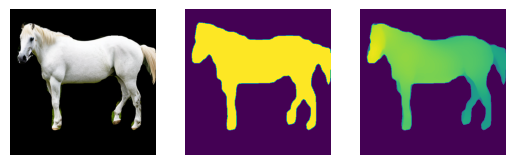

  2%|█▍                                                                     | 12/600 [00:00<00:05, 113.83it/s]

tensor(0.2141, device='cuda:0') tensor(0.4289, device='cuda:0')
tensor(0.2142, device='cuda:0') tensor(0.4289, device='cuda:0')
tensor(0.2143, device='cuda:0') tensor(0.4290, device='cuda:0')
tensor(0.2143, device='cuda:0') tensor(0.4289, device='cuda:0')
tensor(0.2142, device='cuda:0') tensor(0.4289, device='cuda:0')
tensor(0.2143, device='cuda:0') tensor(0.4289, device='cuda:0')
tensor(0.2144, device='cuda:0') tensor(0.4290, device='cuda:0')
tensor(0.2143, device='cuda:0') tensor(0.4290, device='cuda:0')
tensor(0.2143, device='cuda:0') tensor(0.4289, device='cuda:0')
tensor(0.2142, device='cuda:0') tensor(0.4290, device='cuda:0')
tensor(0.2143, device='cuda:0') tensor(0.4289, device='cuda:0')
tensor(0.2143, device='cuda:0') tensor(0.4289, device='cuda:0')
tensor(0.2144, device='cuda:0') tensor(0.4289, device='cuda:0')
tensor(0.2146, device='cuda:0') tensor(0.4288, device='cuda:0')
tensor(0.2147, device='cuda:0') tensor(0.4288, device='cuda:0')
tensor(0.2148, device='cuda:0') tensor(0

  6%|████▍                                                                  | 38/600 [00:00<00:04, 120.33it/s]

tensor(0.2153, device='cuda:0') tensor(0.4286, device='cuda:0')
tensor(0.2154, device='cuda:0') tensor(0.4284, device='cuda:0')
tensor(0.2153, device='cuda:0') tensor(0.4284, device='cuda:0')
tensor(0.2152, device='cuda:0') tensor(0.4283, device='cuda:0')
tensor(0.2151, device='cuda:0') tensor(0.4283, device='cuda:0')
tensor(0.2150, device='cuda:0') tensor(0.4283, device='cuda:0')
tensor(0.2149, device='cuda:0') tensor(0.4283, device='cuda:0')
tensor(0.2148, device='cuda:0') tensor(0.4284, device='cuda:0')
tensor(0.2146, device='cuda:0') tensor(0.4534, device='cuda:0')
tensor(0.2144, device='cuda:0') tensor(0.4816, device='cuda:0')
tensor(0.2143, device='cuda:0') tensor(0.5102, device='cuda:0')
tensor(0.2141, device='cuda:0') tensor(0.5348, device='cuda:0')
tensor(0.2139, device='cuda:0') tensor(0.5518, device='cuda:0')
tensor(0.2136, device='cuda:0') tensor(0.5613, device='cuda:0')
tensor(0.2133, device='cuda:0') tensor(0.5675, device='cuda:0')
tensor(0.2132, device='cuda:0') tensor(0

 11%|███████▌                                                               | 64/600 [00:00<00:04, 120.30it/s]

tensor(0.2110, device='cuda:0') tensor(0.5216, device='cuda:0')
tensor(0.2106, device='cuda:0') tensor(0.5111, device='cuda:0')
tensor(0.2104, device='cuda:0') tensor(0.5053, device='cuda:0')
tensor(0.2103, device='cuda:0') tensor(0.5022, device='cuda:0')
tensor(0.2100, device='cuda:0') tensor(0.4997, device='cuda:0')
tensor(0.2098, device='cuda:0') tensor(0.4988, device='cuda:0')
tensor(0.2096, device='cuda:0') tensor(0.4987, device='cuda:0')
tensor(0.2092, device='cuda:0') tensor(0.4986, device='cuda:0')
tensor(0.2090, device='cuda:0') tensor(0.4985, device='cuda:0')
tensor(0.2088, device='cuda:0') tensor(0.4979, device='cuda:0')
tensor(0.2087, device='cuda:0') tensor(0.4976, device='cuda:0')
tensor(0.2083, device='cuda:0') tensor(0.4974, device='cuda:0')
tensor(0.2082, device='cuda:0') tensor(0.4972, device='cuda:0')
tensor(0.2081, device='cuda:0') tensor(0.4968, device='cuda:0')
tensor(0.2081, device='cuda:0') tensor(0.4969, device='cuda:0')
tensor(0.2080, device='cuda:0') tensor(0

 15%|██████████▋                                                            | 90/600 [00:00<00:04, 114.65it/s]

tensor(0.2074, device='cuda:0') tensor(0.4962, device='cuda:0')
tensor(0.2106, device='cuda:0') tensor(0.4961, device='cuda:0')
tensor(0.2519, device='cuda:0') tensor(0.4960, device='cuda:0')
tensor(0.2936, device='cuda:0') tensor(0.4959, device='cuda:0')
tensor(0.3255, device='cuda:0') tensor(0.4958, device='cuda:0')
tensor(0.3404, device='cuda:0') tensor(0.4957, device='cuda:0')
tensor(0.3494, device='cuda:0') tensor(0.4958, device='cuda:0')
tensor(0.3547, device='cuda:0') tensor(0.4959, device='cuda:0')
tensor(0.3560, device='cuda:0') tensor(0.4964, device='cuda:0')


 90%|██████████████████████████████████████████████████████████████▊       | 538/600 [00:05<00:00, 102.29it/s]

tensor(0.2818, device='cuda:0') tensor(0.5802, device='cuda:0')
tensor(0.2104, device='cuda:0') tensor(0.5802, device='cuda:0')
tensor(0.2056, device='cuda:0') tensor(0.5804, device='cuda:0')
tensor(0.2056, device='cuda:0') tensor(0.5804, device='cuda:0')
tensor(0.2056, device='cuda:0') tensor(0.5805, device='cuda:0')
tensor(0.2056, device='cuda:0') tensor(0.5806, device='cuda:0')
tensor(0.2056, device='cuda:0') tensor(0.5807, device='cuda:0')
tensor(0.2055, device='cuda:0') tensor(0.5808, device='cuda:0')
tensor(0.2054, device='cuda:0') tensor(0.5810, device='cuda:0')
tensor(0.2053, device='cuda:0') tensor(0.5810, device='cuda:0')
tensor(0.2054, device='cuda:0') tensor(0.5810, device='cuda:0')
tensor(0.2054, device='cuda:0') tensor(0.5812, device='cuda:0')
tensor(0.2055, device='cuda:0') tensor(0.5815, device='cuda:0')
tensor(0.2055, device='cuda:0') tensor(0.5817, device='cuda:0')
tensor(0.2056, device='cuda:0') tensor(0.5820, device='cuda:0')
tensor(0.2057, device='cuda:0') tensor(0

 94%|█████████████████████████████████████████████████████████████████▊    | 564/600 [00:05<00:00, 111.43it/s]

tensor(0.2078, device='cuda:0') tensor(0.5914, device='cuda:0')
tensor(0.2079, device='cuda:0') tensor(0.6012, device='cuda:0')
tensor(0.2081, device='cuda:0') tensor(0.6201, device='cuda:0')
tensor(0.2083, device='cuda:0') tensor(0.6408, device='cuda:0')
tensor(0.2083, device='cuda:0') tensor(0.6679, device='cuda:0')
tensor(0.2084, device='cuda:0') tensor(0.6900, device='cuda:0')
tensor(0.2086, device='cuda:0') tensor(0.6905, device='cuda:0')
tensor(0.2087, device='cuda:0') tensor(0.6903, device='cuda:0')
tensor(0.2089, device='cuda:0') tensor(0.6902, device='cuda:0')
tensor(0.2089, device='cuda:0') tensor(0.6901, device='cuda:0')
tensor(0.2091, device='cuda:0') tensor(0.6900, device='cuda:0')
tensor(0.2092, device='cuda:0') tensor(0.6896, device='cuda:0')
tensor(0.2092, device='cuda:0') tensor(0.6871, device='cuda:0')
tensor(0.2092, device='cuda:0') tensor(0.6824, device='cuda:0')
tensor(0.2093, device='cuda:0') tensor(0.6715, device='cuda:0')
tensor(0.2093, device='cuda:0') tensor(0

 98%|████████████████████████████████████████████████████████████████████▋ | 589/600 [00:05<00:00, 115.71it/s]

tensor(0.2113, device='cuda:0') tensor(0.4289, device='cuda:0')
tensor(0.2114, device='cuda:0') tensor(0.4288, device='cuda:0')
tensor(0.2116, device='cuda:0') tensor(0.4289, device='cuda:0')
tensor(0.2116, device='cuda:0') tensor(0.4288, device='cuda:0')
tensor(0.2116, device='cuda:0') tensor(0.4290, device='cuda:0')
tensor(0.2117, device='cuda:0') tensor(0.4290, device='cuda:0')
tensor(0.2117, device='cuda:0') tensor(0.4290, device='cuda:0')
tensor(0.2118, device='cuda:0') tensor(0.4290, device='cuda:0')
tensor(0.2118, device='cuda:0') tensor(0.4290, device='cuda:0')
tensor(0.2120, device='cuda:0') tensor(0.4292, device='cuda:0')
tensor(0.2122, device='cuda:0') tensor(0.4293, device='cuda:0')
tensor(0.2122, device='cuda:0') tensor(0.4293, device='cuda:0')
tensor(0.2122, device='cuda:0') tensor(0.4292, device='cuda:0')
tensor(0.2122, device='cuda:0') tensor(0.4292, device='cuda:0')
tensor(0.2122, device='cuda:0') tensor(0.4293, device='cuda:0')
tensor(0.2123, device='cuda:0') tensor(0

100%|███████████████████████████████████████████████████████████████████████| 600/600 [00:06<00:00, 98.50it/s]


tensor(0.2137, device='cuda:0') tensor(0.4288, device='cuda:0')
tensor(0.2139, device='cuda:0') tensor(0.4288, device='cuda:0')
/grogu/user/akirchme/art3d_sd_webui/images/horse/724.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/724.mp4


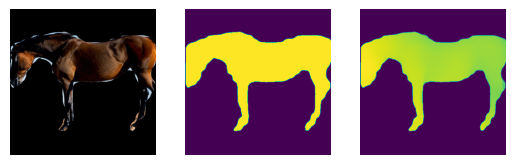

  2%|█▍                                                                     | 12/600 [00:00<00:05, 113.91it/s]

tensor(0.2267, device='cuda:0') tensor(0.4639, device='cuda:0')
tensor(0.2267, device='cuda:0') tensor(0.4639, device='cuda:0')
tensor(0.2267, device='cuda:0') tensor(0.4639, device='cuda:0')
tensor(0.2268, device='cuda:0') tensor(0.4639, device='cuda:0')
tensor(0.2268, device='cuda:0') tensor(0.4639, device='cuda:0')
tensor(0.2268, device='cuda:0') tensor(0.4639, device='cuda:0')
tensor(0.2269, device='cuda:0') tensor(0.4639, device='cuda:0')
tensor(0.2269, device='cuda:0') tensor(0.4640, device='cuda:0')
tensor(0.2269, device='cuda:0') tensor(0.4640, device='cuda:0')
tensor(0.2269, device='cuda:0') tensor(0.4640, device='cuda:0')
tensor(0.2270, device='cuda:0') tensor(0.4640, device='cuda:0')
tensor(0.2270, device='cuda:0') tensor(0.4640, device='cuda:0')
tensor(0.2270, device='cuda:0') tensor(0.4640, device='cuda:0')
tensor(0.2273, device='cuda:0') tensor(0.4640, device='cuda:0')
tensor(0.2274, device='cuda:0') tensor(0.4640, device='cuda:0')
tensor(0.2276, device='cuda:0') tensor(0

  6%|████▍                                                                  | 37/600 [00:00<00:04, 119.57it/s]

tensor(0.2283, device='cuda:0') tensor(0.4638, device='cuda:0')
tensor(0.2283, device='cuda:0') tensor(0.4638, device='cuda:0')
tensor(0.2281, device='cuda:0') tensor(0.4638, device='cuda:0')
tensor(0.2279, device='cuda:0') tensor(0.4638, device='cuda:0')
tensor(0.2276, device='cuda:0') tensor(0.4640, device='cuda:0')
tensor(0.2272, device='cuda:0') tensor(0.4643, device='cuda:0')
tensor(0.2269, device='cuda:0') tensor(0.4645, device='cuda:0')
tensor(0.2265, device='cuda:0') tensor(0.4648, device='cuda:0')
tensor(0.2263, device='cuda:0') tensor(0.4811, device='cuda:0')
tensor(0.2258, device='cuda:0') tensor(0.4914, device='cuda:0')
tensor(0.2256, device='cuda:0') tensor(0.5018, device='cuda:0')
tensor(0.2253, device='cuda:0') tensor(0.5155, device='cuda:0')
tensor(0.2250, device='cuda:0') tensor(0.5269, device='cuda:0')
tensor(0.2246, device='cuda:0') tensor(0.5355, device='cuda:0')
tensor(0.2242, device='cuda:0') tensor(0.5408, device='cuda:0')
tensor(0.2239, device='cuda:0') tensor(0

 10%|███████▎                                                               | 62/600 [00:00<00:04, 119.74it/s]

tensor(0.2218, device='cuda:0') tensor(0.5147, device='cuda:0')
tensor(0.2216, device='cuda:0') tensor(0.5040, device='cuda:0')
tensor(0.2213, device='cuda:0') tensor(0.4990, device='cuda:0')
tensor(0.2210, device='cuda:0') tensor(0.4967, device='cuda:0')
tensor(0.2209, device='cuda:0') tensor(0.4954, device='cuda:0')
tensor(0.2207, device='cuda:0') tensor(0.4946, device='cuda:0')
tensor(0.2206, device='cuda:0') tensor(0.4942, device='cuda:0')
tensor(0.2204, device='cuda:0') tensor(0.4942, device='cuda:0')
tensor(0.2202, device='cuda:0') tensor(0.4942, device='cuda:0')
tensor(0.2201, device='cuda:0') tensor(0.4942, device='cuda:0')
tensor(0.2198, device='cuda:0') tensor(0.4942, device='cuda:0')
tensor(0.2198, device='cuda:0') tensor(0.4943, device='cuda:0')
tensor(0.2197, device='cuda:0') tensor(0.4945, device='cuda:0')
tensor(0.2196, device='cuda:0') tensor(0.4945, device='cuda:0')
tensor(0.2196, device='cuda:0') tensor(0.4944, device='cuda:0')
tensor(0.2195, device='cuda:0') tensor(0

 14%|██████████▎                                                            | 87/600 [00:00<00:04, 118.15it/s]

tensor(0.2202, device='cuda:0') tensor(0.4945, device='cuda:0')
tensor(0.2234, device='cuda:0') tensor(0.4942, device='cuda:0')
tensor(0.2442, device='cuda:0') tensor(0.4941, device='cuda:0')
tensor(0.2591, device='cuda:0') tensor(0.4941, device='cuda:0')
tensor(0.2789, device='cuda:0') tensor(0.4941, device='cuda:0')
tensor(0.2918, device='cuda:0') tensor(0.4941, device='cuda:0')
tensor(0.2984, device='cuda:0') tensor(0.4941, device='cuda:0')
tensor(0.3035, device='cuda:0') tensor(0.4942, device='cuda:0')
tensor(0.3059, device='cuda:0') tensor(0.4949, device='cuda:0')
tensor(0.3066, device='cuda:0') tensor(0.5167, device='cuda:0')


 90%|██████████████████████████████████████████████████████████████▊       | 538/600 [00:05<00:00, 105.22it/s]

tensor(0.2911, device='cuda:0') tensor(0.5686, device='cuda:0')
tensor(0.2278, device='cuda:0') tensor(0.5689, device='cuda:0')
tensor(0.2212, device='cuda:0') tensor(0.5692, device='cuda:0')
tensor(0.2212, device='cuda:0') tensor(0.5694, device='cuda:0')
tensor(0.2213, device='cuda:0') tensor(0.5693, device='cuda:0')
tensor(0.2212, device='cuda:0') tensor(0.5694, device='cuda:0')
tensor(0.2212, device='cuda:0') tensor(0.5693, device='cuda:0')
tensor(0.2210, device='cuda:0') tensor(0.5695, device='cuda:0')
tensor(0.2210, device='cuda:0') tensor(0.5697, device='cuda:0')
tensor(0.2210, device='cuda:0') tensor(0.5698, device='cuda:0')
tensor(0.2209, device='cuda:0') tensor(0.5701, device='cuda:0')
tensor(0.2208, device='cuda:0') tensor(0.5698, device='cuda:0')
tensor(0.2208, device='cuda:0') tensor(0.5698, device='cuda:0')
tensor(0.2208, device='cuda:0') tensor(0.5700, device='cuda:0')
tensor(0.2208, device='cuda:0') tensor(0.5703, device='cuda:0')
tensor(0.2209, device='cuda:0') tensor(0

 94%|█████████████████████████████████████████████████████████████████▊    | 564/600 [00:05<00:00, 113.19it/s]

tensor(0.2212, device='cuda:0') tensor(0.5918, device='cuda:0')
tensor(0.2214, device='cuda:0') tensor(0.6179, device='cuda:0')
tensor(0.2215, device='cuda:0') tensor(0.6553, device='cuda:0')
tensor(0.2215, device='cuda:0') tensor(0.6812, device='cuda:0')
tensor(0.2215, device='cuda:0') tensor(0.7012, device='cuda:0')
tensor(0.2216, device='cuda:0') tensor(0.7272, device='cuda:0')
tensor(0.2217, device='cuda:0') tensor(0.7288, device='cuda:0')
tensor(0.2218, device='cuda:0') tensor(0.7287, device='cuda:0')
tensor(0.2219, device='cuda:0') tensor(0.7284, device='cuda:0')
tensor(0.2221, device='cuda:0') tensor(0.7282, device='cuda:0')
tensor(0.2221, device='cuda:0') tensor(0.7280, device='cuda:0')
tensor(0.2223, device='cuda:0') tensor(0.7268, device='cuda:0')
tensor(0.2225, device='cuda:0') tensor(0.7202, device='cuda:0')
tensor(0.2227, device='cuda:0') tensor(0.7097, device='cuda:0')
tensor(0.2228, device='cuda:0') tensor(0.6947, device='cuda:0')
tensor(0.2229, device='cuda:0') tensor(0

 98%|████████████████████████████████████████████████████████████████████▋ | 589/600 [00:05<00:00, 116.56it/s]

tensor(0.2248, device='cuda:0') tensor(0.4638, device='cuda:0')
tensor(0.2249, device='cuda:0') tensor(0.4639, device='cuda:0')
tensor(0.2249, device='cuda:0') tensor(0.4639, device='cuda:0')
tensor(0.2249, device='cuda:0') tensor(0.4639, device='cuda:0')
tensor(0.2250, device='cuda:0') tensor(0.4639, device='cuda:0')
tensor(0.2251, device='cuda:0') tensor(0.4640, device='cuda:0')
tensor(0.2251, device='cuda:0') tensor(0.4639, device='cuda:0')
tensor(0.2250, device='cuda:0') tensor(0.4639, device='cuda:0')
tensor(0.2250, device='cuda:0') tensor(0.4638, device='cuda:0')
tensor(0.2250, device='cuda:0') tensor(0.4639, device='cuda:0')
tensor(0.2250, device='cuda:0') tensor(0.4638, device='cuda:0')
tensor(0.2250, device='cuda:0') tensor(0.4638, device='cuda:0')
tensor(0.2250, device='cuda:0') tensor(0.4637, device='cuda:0')
tensor(0.2252, device='cuda:0') tensor(0.4637, device='cuda:0')
tensor(0.2252, device='cuda:0') tensor(0.4637, device='cuda:0')
tensor(0.2252, device='cuda:0') tensor(0

100%|██████████████████████████████████████████████████████████████████████| 600/600 [00:05<00:00, 100.86it/s]


tensor(0.2264, device='cuda:0') tensor(0.4639, device='cuda:0')
tensor(0.2265, device='cuda:0') tensor(0.4639, device='cuda:0')
/grogu/user/akirchme/art3d_sd_webui/images/horse/1067.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/1067.mp4


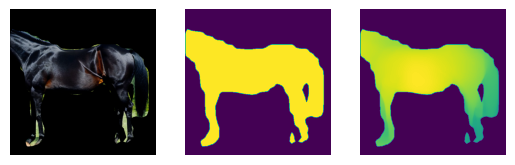

  4%|██▊                                                                    | 24/600 [00:00<00:04, 116.44it/s]

tensor(0.2716, device='cuda:0') tensor(0.4898, device='cuda:0')
tensor(0.2720, device='cuda:0') tensor(0.4899, device='cuda:0')
tensor(0.2724, device='cuda:0') tensor(0.4898, device='cuda:0')
tensor(0.2729, device='cuda:0') tensor(0.4899, device='cuda:0')
tensor(0.2733, device='cuda:0') tensor(0.4900, device='cuda:0')
tensor(0.2735, device='cuda:0') tensor(0.4900, device='cuda:0')
tensor(0.2738, device='cuda:0') tensor(0.4901, device='cuda:0')
tensor(0.2741, device='cuda:0') tensor(0.4902, device='cuda:0')
tensor(0.2744, device='cuda:0') tensor(0.4904, device='cuda:0')
tensor(0.2745, device='cuda:0') tensor(0.4905, device='cuda:0')
tensor(0.2750, device='cuda:0') tensor(0.4906, device='cuda:0')
tensor(0.2758, device='cuda:0') tensor(0.4907, device='cuda:0')
tensor(0.2765, device='cuda:0') tensor(0.4907, device='cuda:0')
tensor(0.2768, device='cuda:0') tensor(0.4908, device='cuda:0')
tensor(0.2772, device='cuda:0') tensor(0.4909, device='cuda:0')
tensor(0.2778, device='cuda:0') tensor(0

  6%|████▎                                                                  | 36/600 [00:00<00:04, 117.91it/s]

tensor(0.2823, device='cuda:0') tensor(0.4915, device='cuda:0')
tensor(0.2830, device='cuda:0') tensor(0.4916, device='cuda:0')
tensor(0.2835, device='cuda:0') tensor(0.4916, device='cuda:0')
tensor(0.2835, device='cuda:0') tensor(0.4918, device='cuda:0')
tensor(0.2832, device='cuda:0') tensor(0.4919, device='cuda:0')
tensor(0.2826, device='cuda:0') tensor(0.4920, device='cuda:0')
tensor(0.2817, device='cuda:0') tensor(0.4923, device='cuda:0')
tensor(0.2803, device='cuda:0') tensor(0.4925, device='cuda:0')
tensor(0.2790, device='cuda:0') tensor(0.4926, device='cuda:0')
tensor(0.2776, device='cuda:0') tensor(0.4978, device='cuda:0')
tensor(0.2765, device='cuda:0') tensor(0.5039, device='cuda:0')
tensor(0.2752, device='cuda:0') tensor(0.5137, device='cuda:0')
tensor(0.2741, device='cuda:0') tensor(0.5252, device='cuda:0')
tensor(0.2733, device='cuda:0') tensor(0.5369, device='cuda:0')
tensor(0.2723, device='cuda:0') tensor(0.5501, device='cuda:0')
tensor(0.2714, device='cuda:0') tensor(0

 10%|███████▏                                                               | 61/600 [00:00<00:04, 119.16it/s]

tensor(0.2641, device='cuda:0') tensor(0.6106, device='cuda:0')
tensor(0.2636, device='cuda:0') tensor(0.6019, device='cuda:0')
tensor(0.2631, device='cuda:0') tensor(0.5922, device='cuda:0')
tensor(0.2630, device='cuda:0') tensor(0.5807, device='cuda:0')
tensor(0.2626, device='cuda:0') tensor(0.5721, device='cuda:0')
tensor(0.2622, device='cuda:0') tensor(0.5593, device='cuda:0')
tensor(0.2621, device='cuda:0') tensor(0.5510, device='cuda:0')
tensor(0.2618, device='cuda:0') tensor(0.5510, device='cuda:0')
tensor(0.2615, device='cuda:0') tensor(0.5509, device='cuda:0')
tensor(0.2613, device='cuda:0') tensor(0.5511, device='cuda:0')
tensor(0.2610, device='cuda:0') tensor(0.5517, device='cuda:0')
tensor(0.2610, device='cuda:0') tensor(0.5518, device='cuda:0')
tensor(0.2608, device='cuda:0') tensor(0.5521, device='cuda:0')
tensor(0.2607, device='cuda:0') tensor(0.5523, device='cuda:0')
tensor(0.2607, device='cuda:0') tensor(0.5529, device='cuda:0')
tensor(0.2606, device='cuda:0') tensor(0

 14%|██████████                                                             | 85/600 [00:00<00:04, 110.11it/s]

tensor(0.2621, device='cuda:0') tensor(0.5580, device='cuda:0')
tensor(0.2625, device='cuda:0') tensor(0.5585, device='cuda:0')
tensor(0.2629, device='cuda:0') tensor(0.5587, device='cuda:0')
tensor(0.2635, device='cuda:0') tensor(0.5590, device='cuda:0')
tensor(0.2726, device='cuda:0') tensor(0.5592, device='cuda:0')
tensor(0.2862, device='cuda:0') tensor(0.5598, device='cuda:0')


 91%|███████████████████████████████████████████████████████████████▍      | 544/600 [00:06<00:00, 100.24it/s]

tensor(0.2937, device='cuda:0') tensor(0.5301, device='cuda:0')
tensor(0.2787, device='cuda:0') tensor(0.5306, device='cuda:0')
tensor(0.2673, device='cuda:0') tensor(0.5309, device='cuda:0')
tensor(0.2664, device='cuda:0') tensor(0.5309, device='cuda:0')
tensor(0.2663, device='cuda:0') tensor(0.5313, device='cuda:0')
tensor(0.2659, device='cuda:0') tensor(0.5313, device='cuda:0')
tensor(0.2658, device='cuda:0') tensor(0.5313, device='cuda:0')
tensor(0.2656, device='cuda:0') tensor(0.5311, device='cuda:0')
tensor(0.2653, device='cuda:0') tensor(0.5305, device='cuda:0')
tensor(0.2651, device='cuda:0') tensor(0.5301, device='cuda:0')
tensor(0.2648, device='cuda:0') tensor(0.5295, device='cuda:0')
tensor(0.2647, device='cuda:0') tensor(0.5289, device='cuda:0')
tensor(0.2645, device='cuda:0') tensor(0.5281, device='cuda:0')
tensor(0.2643, device='cuda:0') tensor(0.5274, device='cuda:0')
tensor(0.2642, device='cuda:0') tensor(0.5269, device='cuda:0')
tensor(0.2640, device='cuda:0') tensor(0

 95%|██████████████████████████████████████████████████████████████████▍   | 569/600 [00:06<00:00, 110.21it/s]

tensor(0.2632, device='cuda:0') tensor(0.5568, device='cuda:0')
tensor(0.2634, device='cuda:0') tensor(0.5810, device='cuda:0')
tensor(0.2635, device='cuda:0') tensor(0.6007, device='cuda:0')
tensor(0.2634, device='cuda:0') tensor(0.6133, device='cuda:0')
tensor(0.2633, device='cuda:0') tensor(0.6202, device='cuda:0')
tensor(0.2633, device='cuda:0') tensor(0.6239, device='cuda:0')
tensor(0.2635, device='cuda:0') tensor(0.6259, device='cuda:0')
tensor(0.2636, device='cuda:0') tensor(0.6250, device='cuda:0')
tensor(0.2637, device='cuda:0') tensor(0.6238, device='cuda:0')
tensor(0.2636, device='cuda:0') tensor(0.6225, device='cuda:0')
tensor(0.2634, device='cuda:0') tensor(0.6210, device='cuda:0')
tensor(0.2636, device='cuda:0') tensor(0.6190, device='cuda:0')
tensor(0.2638, device='cuda:0') tensor(0.6140, device='cuda:0')
tensor(0.2639, device='cuda:0') tensor(0.6056, device='cuda:0')
tensor(0.2639, device='cuda:0') tensor(0.5898, device='cuda:0')
tensor(0.2641, device='cuda:0') tensor(0

 99%|█████████████████████████████████████████████████████████████████████▎| 594/600 [00:06<00:00, 115.21it/s]

tensor(0.2714, device='cuda:0') tensor(0.4904, device='cuda:0')
tensor(0.2719, device='cuda:0') tensor(0.4903, device='cuda:0')
tensor(0.2722, device='cuda:0') tensor(0.4903, device='cuda:0')
tensor(0.2724, device='cuda:0') tensor(0.4902, device='cuda:0')
tensor(0.2721, device='cuda:0') tensor(0.4901, device='cuda:0')
tensor(0.2717, device='cuda:0') tensor(0.4900, device='cuda:0')
tensor(0.2713, device='cuda:0') tensor(0.4899, device='cuda:0')
tensor(0.2709, device='cuda:0') tensor(0.4899, device='cuda:0')
tensor(0.2704, device='cuda:0') tensor(0.4898, device='cuda:0')
tensor(0.2698, device='cuda:0') tensor(0.4898, device='cuda:0')
tensor(0.2692, device='cuda:0') tensor(0.4898, device='cuda:0')
tensor(0.2685, device='cuda:0') tensor(0.4895, device='cuda:0')
tensor(0.2680, device='cuda:0') tensor(0.4894, device='cuda:0')
tensor(0.2677, device='cuda:0') tensor(0.4895, device='cuda:0')
tensor(0.2676, device='cuda:0') tensor(0.4895, device='cuda:0')
tensor(0.2675, device='cuda:0') tensor(0

100%|███████████████████████████████████████████████████████████████████████| 600/600 [00:06<00:00, 92.44it/s]


tensor(0.2706, device='cuda:0') tensor(0.4897, device='cuda:0')
tensor(0.2708, device='cuda:0') tensor(0.4897, device='cuda:0')
tensor(0.2712, device='cuda:0') tensor(0.4897, device='cuda:0')
/grogu/user/akirchme/art3d_sd_webui/images/horse/345.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/345.mp4


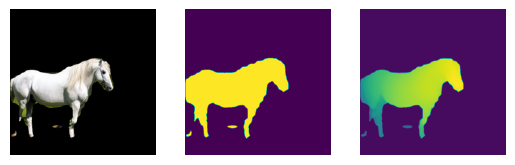

 39%|███████████████████████████▍                                          | 235/600 [00:01<00:02, 123.12it/s]

tensor(0.3372, device='cuda:0') tensor(0.5125, device='cuda:0')
tensor(0.3367, device='cuda:0') tensor(0.5050, device='cuda:0')
tensor(0.3325, device='cuda:0') tensor(0.5049, device='cuda:0')
tensor(0.3142, device='cuda:0') tensor(0.5051, device='cuda:0')
tensor(0.2972, device='cuda:0') tensor(0.5054, device='cuda:0')
tensor(0.2791, device='cuda:0') tensor(0.5059, device='cuda:0')
tensor(0.2388, device='cuda:0') tensor(0.5061, device='cuda:0')
tensor(0.1906, device='cuda:0') tensor(0.5063, device='cuda:0')
tensor(0.1577, device='cuda:0') tensor(0.5064, device='cuda:0')
tensor(0.1554, device='cuda:0') tensor(0.5064, device='cuda:0')
tensor(0.1554, device='cuda:0') tensor(0.5064, device='cuda:0')
tensor(0.1553, device='cuda:0') tensor(0.5070, device='cuda:0')
tensor(0.1553, device='cuda:0') tensor(0.5071, device='cuda:0')
tensor(0.1552, device='cuda:0') tensor(0.5068, device='cuda:0')
tensor(0.1551, device='cuda:0') tensor(0.5065, device='cuda:0')
tensor(0.1551, device='cuda:0') tensor(0

 44%|██████████████████████████████▍                                       | 261/600 [00:02<00:02, 121.05it/s]

tensor(0.1557, device='cuda:0') tensor(0.4959, device='cuda:0')
tensor(0.1558, device='cuda:0') tensor(0.4950, device='cuda:0')
tensor(0.1561, device='cuda:0') tensor(0.4941, device='cuda:0')
tensor(0.1561, device='cuda:0') tensor(0.4926, device='cuda:0')
tensor(0.1562, device='cuda:0') tensor(0.4917, device='cuda:0')
tensor(0.1563, device='cuda:0') tensor(0.4911, device='cuda:0')
tensor(0.1564, device='cuda:0') tensor(0.4918, device='cuda:0')
tensor(0.1565, device='cuda:0') tensor(0.4998, device='cuda:0')
tensor(0.1564, device='cuda:0') tensor(0.5023, device='cuda:0')
tensor(0.1566, device='cuda:0') tensor(0.5077, device='cuda:0')
tensor(0.1570, device='cuda:0') tensor(0.5223, device='cuda:0')
tensor(0.1573, device='cuda:0') tensor(0.5500, device='cuda:0')
tensor(0.1577, device='cuda:0') tensor(0.5717, device='cuda:0')
tensor(0.1578, device='cuda:0') tensor(0.5847, device='cuda:0')
tensor(0.1579, device='cuda:0') tensor(0.5848, device='cuda:0')
tensor(0.1584, device='cuda:0') tensor(0

 48%|█████████████████████████████████▍                                    | 287/600 [00:02<00:02, 119.86it/s]

tensor(0.1633, device='cuda:0') tensor(0.5121, device='cuda:0')
tensor(0.1639, device='cuda:0') tensor(0.4794, device='cuda:0')
tensor(0.1644, device='cuda:0') tensor(0.4458, device='cuda:0')
tensor(0.1646, device='cuda:0') tensor(0.4153, device='cuda:0')
tensor(0.1650, device='cuda:0') tensor(0.4025, device='cuda:0')
tensor(0.1653, device='cuda:0') tensor(0.4022, device='cuda:0')
tensor(0.1659, device='cuda:0') tensor(0.4020, device='cuda:0')
tensor(0.1661, device='cuda:0') tensor(0.4019, device='cuda:0')
tensor(0.1665, device='cuda:0') tensor(0.4017, device='cuda:0')
tensor(0.1666, device='cuda:0') tensor(0.4017, device='cuda:0')
tensor(0.1669, device='cuda:0') tensor(0.4016, device='cuda:0')
tensor(0.1671, device='cuda:0') tensor(0.4016, device='cuda:0')
tensor(0.1672, device='cuda:0') tensor(0.4016, device='cuda:0')
tensor(0.1673, device='cuda:0') tensor(0.4016, device='cuda:0')
tensor(0.1673, device='cuda:0') tensor(0.4016, device='cuda:0')
tensor(0.1673, device='cuda:0') tensor(0

 52%|████████████████████████████████████▎                                 | 311/600 [00:02<00:02, 119.54it/s]

tensor(0.1660, device='cuda:0') tensor(0.4009, device='cuda:0')
tensor(0.1657, device='cuda:0') tensor(0.4010, device='cuda:0')
tensor(0.1657, device='cuda:0') tensor(0.4008, device='cuda:0')
tensor(0.1654, device='cuda:0') tensor(0.4007, device='cuda:0')
tensor(0.1652, device='cuda:0') tensor(0.4005, device='cuda:0')
tensor(0.1652, device='cuda:0') tensor(0.4005, device='cuda:0')
tensor(0.1652, device='cuda:0') tensor(0.4002, device='cuda:0')
tensor(0.1652, device='cuda:0') tensor(0.4002, device='cuda:0')
tensor(0.1650, device='cuda:0') tensor(0.4000, device='cuda:0')
tensor(0.1650, device='cuda:0') tensor(0.3999, device='cuda:0')
tensor(0.1649, device='cuda:0') tensor(0.3999, device='cuda:0')
tensor(0.1648, device='cuda:0') tensor(0.3999, device='cuda:0')
tensor(0.1647, device='cuda:0') tensor(0.3999, device='cuda:0')
tensor(0.1648, device='cuda:0') tensor(0.3999, device='cuda:0')
tensor(0.1649, device='cuda:0') tensor(0.3998, device='cuda:0')
tensor(0.1649, device='cuda:0') tensor(0

 56%|███████████████████████████████████████                               | 335/600 [00:02<00:02, 119.01it/s]

tensor(0.1642, device='cuda:0') tensor(0.4007, device='cuda:0')
tensor(0.1643, device='cuda:0') tensor(0.4007, device='cuda:0')
tensor(0.1642, device='cuda:0') tensor(0.4008, device='cuda:0')
tensor(0.1643, device='cuda:0') tensor(0.4008, device='cuda:0')
tensor(0.1641, device='cuda:0') tensor(0.4008, device='cuda:0')
tensor(0.1641, device='cuda:0') tensor(0.4010, device='cuda:0')
tensor(0.1639, device='cuda:0') tensor(0.4010, device='cuda:0')
tensor(0.1637, device='cuda:0') tensor(0.4010, device='cuda:0')
tensor(0.1636, device='cuda:0') tensor(0.4010, device='cuda:0')
tensor(0.1635, device='cuda:0') tensor(0.4010, device='cuda:0')
tensor(0.1633, device='cuda:0') tensor(0.4017, device='cuda:0')
tensor(0.1630, device='cuda:0') tensor(0.4019, device='cuda:0')
tensor(0.1628, device='cuda:0') tensor(0.4019, device='cuda:0')
tensor(0.1626, device='cuda:0') tensor(0.4019, device='cuda:0')
tensor(0.1624, device='cuda:0') tensor(0.4020, device='cuda:0')
tensor(0.1621, device='cuda:0') tensor(0

 60%|█████████████████████████████████████████▉                            | 359/600 [00:02<00:02, 118.37it/s]

tensor(0.1590, device='cuda:0') tensor(0.5186, device='cuda:0')
tensor(0.1588, device='cuda:0') tensor(0.5584, device='cuda:0')
tensor(0.1585, device='cuda:0') tensor(0.5995, device='cuda:0')
tensor(0.1583, device='cuda:0') tensor(0.6189, device='cuda:0')
tensor(0.1581, device='cuda:0') tensor(0.6264, device='cuda:0')
tensor(0.1580, device='cuda:0') tensor(0.6272, device='cuda:0')
tensor(0.1578, device='cuda:0') tensor(0.6274, device='cuda:0')
tensor(0.1575, device='cuda:0') tensor(0.6275, device='cuda:0')
tensor(0.1573, device='cuda:0') tensor(0.6278, device='cuda:0')
tensor(0.1571, device='cuda:0') tensor(0.6279, device='cuda:0')
tensor(0.1570, device='cuda:0') tensor(0.6280, device='cuda:0')
tensor(0.1567, device='cuda:0') tensor(0.6246, device='cuda:0')
tensor(0.1565, device='cuda:0') tensor(0.6218, device='cuda:0')
tensor(0.1563, device='cuda:0') tensor(0.6079, device='cuda:0')
tensor(0.1561, device='cuda:0') tensor(0.5773, device='cuda:0')
tensor(0.1559, device='cuda:0') tensor(0

 64%|████████████████████████████████████████████▋                         | 383/600 [00:03<00:01, 118.31it/s]

tensor(0.1544, device='cuda:0') tensor(0.5303, device='cuda:0')
tensor(0.1542, device='cuda:0') tensor(0.5325, device='cuda:0')
tensor(0.1540, device='cuda:0') tensor(0.5343, device='cuda:0')
tensor(0.1540, device='cuda:0') tensor(0.5364, device='cuda:0')
tensor(0.1539, device='cuda:0') tensor(0.5389, device='cuda:0')
tensor(0.1540, device='cuda:0') tensor(0.5403, device='cuda:0')
tensor(0.1542, device='cuda:0') tensor(0.5418, device='cuda:0')
tensor(0.1543, device='cuda:0') tensor(0.5426, device='cuda:0')
tensor(0.1545, device='cuda:0') tensor(0.5430, device='cuda:0')
tensor(0.1546, device='cuda:0') tensor(0.5434, device='cuda:0')
tensor(0.1548, device='cuda:0') tensor(0.5434, device='cuda:0')
tensor(0.1550, device='cuda:0') tensor(0.5438, device='cuda:0')
tensor(0.1551, device='cuda:0') tensor(0.5440, device='cuda:0')
tensor(0.1553, device='cuda:0') tensor(0.5445, device='cuda:0')
tensor(0.1554, device='cuda:0') tensor(0.5442, device='cuda:0')
tensor(0.1564, device='cuda:0') tensor(0

100%|██████████████████████████████████████████████████████████████████████| 600/600 [00:04<00:00, 124.29it/s]


/grogu/user/akirchme/art3d_sd_webui/images/horse/890.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/890.mp4


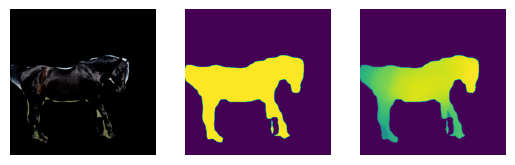

 40%|████████████████████████████                                          | 241/600 [00:02<00:03, 115.76it/s]

tensor(0.2674, device='cuda:0') tensor(0.5349, device='cuda:0')
tensor(0.2359, device='cuda:0') tensor(0.5351, device='cuda:0')
tensor(0.2167, device='cuda:0') tensor(0.5353, device='cuda:0')
tensor(0.2146, device='cuda:0') tensor(0.5352, device='cuda:0')
tensor(0.2145, device='cuda:0') tensor(0.5352, device='cuda:0')
tensor(0.2145, device='cuda:0') tensor(0.5354, device='cuda:0')
tensor(0.2143, device='cuda:0') tensor(0.5351, device='cuda:0')
tensor(0.2140, device='cuda:0') tensor(0.5349, device='cuda:0')
tensor(0.2138, device='cuda:0') tensor(0.5350, device='cuda:0')
tensor(0.2138, device='cuda:0') tensor(0.5348, device='cuda:0')
tensor(0.2137, device='cuda:0') tensor(0.5347, device='cuda:0')
tensor(0.2137, device='cuda:0') tensor(0.5344, device='cuda:0')
tensor(0.2135, device='cuda:0') tensor(0.5341, device='cuda:0')
tensor(0.2134, device='cuda:0') tensor(0.5338, device='cuda:0')
tensor(0.2133, device='cuda:0') tensor(0.5334, device='cuda:0')
tensor(0.2133, device='cuda:0') tensor(0

 44%|███████████████████████████████                                       | 266/600 [00:02<00:02, 118.26it/s]

tensor(0.2133, device='cuda:0') tensor(0.5350, device='cuda:0')
tensor(0.2136, device='cuda:0') tensor(0.5418, device='cuda:0')
tensor(0.2136, device='cuda:0') tensor(0.5494, device='cuda:0')
tensor(0.2137, device='cuda:0') tensor(0.5578, device='cuda:0')
tensor(0.2137, device='cuda:0') tensor(0.5673, device='cuda:0')
tensor(0.2138, device='cuda:0') tensor(0.5867, device='cuda:0')
tensor(0.2140, device='cuda:0') tensor(0.5947, device='cuda:0')
tensor(0.2141, device='cuda:0') tensor(0.5981, device='cuda:0')
tensor(0.2144, device='cuda:0') tensor(0.5988, device='cuda:0')
tensor(0.2145, device='cuda:0') tensor(0.5987, device='cuda:0')
tensor(0.2146, device='cuda:0') tensor(0.5987, device='cuda:0')
tensor(0.2146, device='cuda:0') tensor(0.5985, device='cuda:0')
tensor(0.2150, device='cuda:0') tensor(0.5978, device='cuda:0')
tensor(0.2154, device='cuda:0') tensor(0.5915, device='cuda:0')
tensor(0.2162, device='cuda:0') tensor(0.5797, device='cuda:0')
tensor(0.2173, device='cuda:0') tensor(0

 48%|█████████████████████████████████▊                                    | 290/600 [00:02<00:02, 118.73it/s]

tensor(0.2236, device='cuda:0') tensor(0.4394, device='cuda:0')
tensor(0.2239, device='cuda:0') tensor(0.4393, device='cuda:0')
tensor(0.2242, device='cuda:0') tensor(0.4392, device='cuda:0')
tensor(0.2245, device='cuda:0') tensor(0.4391, device='cuda:0')
tensor(0.2245, device='cuda:0') tensor(0.4390, device='cuda:0')
tensor(0.2246, device='cuda:0') tensor(0.4388, device='cuda:0')
tensor(0.2243, device='cuda:0') tensor(0.4388, device='cuda:0')
tensor(0.2241, device='cuda:0') tensor(0.4388, device='cuda:0')
tensor(0.2238, device='cuda:0') tensor(0.4387, device='cuda:0')
tensor(0.2236, device='cuda:0') tensor(0.4388, device='cuda:0')
tensor(0.2233, device='cuda:0') tensor(0.4388, device='cuda:0')
tensor(0.2227, device='cuda:0') tensor(0.4388, device='cuda:0')
tensor(0.2220, device='cuda:0') tensor(0.4389, device='cuda:0')
tensor(0.2213, device='cuda:0') tensor(0.4388, device='cuda:0')
tensor(0.2207, device='cuda:0') tensor(0.4387, device='cuda:0')
tensor(0.2201, device='cuda:0') tensor(0

 52%|████████████████████████████████████▋                                 | 314/600 [00:02<00:02, 118.65it/s]

tensor(0.2182, device='cuda:0') tensor(0.4386, device='cuda:0')
tensor(0.2181, device='cuda:0') tensor(0.4385, device='cuda:0')
tensor(0.2182, device='cuda:0') tensor(0.4386, device='cuda:0')
tensor(0.2182, device='cuda:0') tensor(0.4385, device='cuda:0')
tensor(0.2181, device='cuda:0') tensor(0.4384, device='cuda:0')
tensor(0.2179, device='cuda:0') tensor(0.4385, device='cuda:0')
tensor(0.2179, device='cuda:0') tensor(0.4384, device='cuda:0')
tensor(0.2178, device='cuda:0') tensor(0.4384, device='cuda:0')
tensor(0.2178, device='cuda:0') tensor(0.4383, device='cuda:0')
tensor(0.2177, device='cuda:0') tensor(0.4384, device='cuda:0')
tensor(0.2175, device='cuda:0') tensor(0.4384, device='cuda:0')
tensor(0.2175, device='cuda:0') tensor(0.4384, device='cuda:0')
tensor(0.2172, device='cuda:0') tensor(0.4384, device='cuda:0')
tensor(0.2171, device='cuda:0') tensor(0.4384, device='cuda:0')
tensor(0.2169, device='cuda:0') tensor(0.4384, device='cuda:0')
tensor(0.2168, device='cuda:0') tensor(0

 56%|███████████████████████████████████████▍                              | 338/600 [00:02<00:02, 118.82it/s]

tensor(0.2177, device='cuda:0') tensor(0.4385, device='cuda:0')
tensor(0.2181, device='cuda:0') tensor(0.4385, device='cuda:0')
tensor(0.2185, device='cuda:0') tensor(0.4385, device='cuda:0')
tensor(0.2188, device='cuda:0') tensor(0.4384, device='cuda:0')
tensor(0.2191, device='cuda:0') tensor(0.4384, device='cuda:0')
tensor(0.2192, device='cuda:0') tensor(0.4384, device='cuda:0')
tensor(0.2190, device='cuda:0') tensor(0.4383, device='cuda:0')
tensor(0.2190, device='cuda:0') tensor(0.4383, device='cuda:0')
tensor(0.2187, device='cuda:0') tensor(0.4384, device='cuda:0')
tensor(0.2183, device='cuda:0') tensor(0.4383, device='cuda:0')
tensor(0.2177, device='cuda:0') tensor(0.4383, device='cuda:0')
tensor(0.2169, device='cuda:0') tensor(0.4383, device='cuda:0')
tensor(0.2161, device='cuda:0') tensor(0.4384, device='cuda:0')
tensor(0.2154, device='cuda:0') tensor(0.4401, device='cuda:0')
tensor(0.2144, device='cuda:0') tensor(0.4861, device='cuda:0')
tensor(0.2139, device='cuda:0') tensor(0

 60%|██████████████████████████████████████████▏                           | 362/600 [00:03<00:02, 118.80it/s]

tensor(0.2104, device='cuda:0') tensor(0.6853, device='cuda:0')
tensor(0.2101, device='cuda:0') tensor(0.6856, device='cuda:0')
tensor(0.2100, device='cuda:0') tensor(0.6858, device='cuda:0')
tensor(0.2098, device='cuda:0') tensor(0.6861, device='cuda:0')
tensor(0.2098, device='cuda:0') tensor(0.6839, device='cuda:0')
tensor(0.2096, device='cuda:0') tensor(0.6664, device='cuda:0')
tensor(0.2096, device='cuda:0') tensor(0.6532, device='cuda:0')
tensor(0.2094, device='cuda:0') tensor(0.6290, device='cuda:0')
tensor(0.2091, device='cuda:0') tensor(0.6085, device='cuda:0')
tensor(0.2089, device='cuda:0') tensor(0.5948, device='cuda:0')
tensor(0.2089, device='cuda:0') tensor(0.5828, device='cuda:0')
tensor(0.2089, device='cuda:0') tensor(0.5747, device='cuda:0')
tensor(0.2087, device='cuda:0') tensor(0.5686, device='cuda:0')
tensor(0.2087, device='cuda:0') tensor(0.5680, device='cuda:0')
tensor(0.2085, device='cuda:0') tensor(0.5682, device='cuda:0')
tensor(0.2085, device='cuda:0') tensor(0

 64%|█████████████████████████████████████████████                         | 386/600 [00:03<00:01, 118.13it/s]

tensor(0.2099, device='cuda:0') tensor(0.5694, device='cuda:0')
tensor(0.2100, device='cuda:0') tensor(0.5694, device='cuda:0')
tensor(0.2102, device='cuda:0') tensor(0.5693, device='cuda:0')
tensor(0.2104, device='cuda:0') tensor(0.5693, device='cuda:0')
tensor(0.2106, device='cuda:0') tensor(0.5691, device='cuda:0')
tensor(0.2107, device='cuda:0') tensor(0.5691, device='cuda:0')
tensor(0.2108, device='cuda:0') tensor(0.5690, device='cuda:0')
tensor(0.2110, device='cuda:0') tensor(0.5688, device='cuda:0')
tensor(0.2112, device='cuda:0') tensor(0.5683, device='cuda:0')
tensor(0.2254, device='cuda:0') tensor(0.5681, device='cuda:0')
tensor(0.2837, device='cuda:0') tensor(0.5678, device='cuda:0')


100%|██████████████████████████████████████████████████████████████████████| 600/600 [00:05<00:00, 116.49it/s]


/grogu/user/akirchme/art3d_sd_webui/images/horse/1874.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/1874.mp4


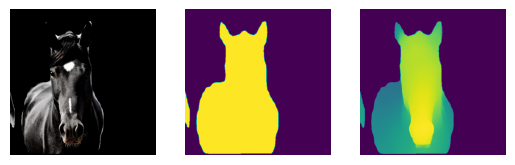

  2%|█▍                                                                     | 12/600 [00:00<00:05, 111.37it/s]

tensor(0.3898, device='cuda:0') tensor(0.5070, device='cuda:0')
tensor(0.3900, device='cuda:0') tensor(0.5070, device='cuda:0')
tensor(0.3897, device='cuda:0') tensor(0.5070, device='cuda:0')
tensor(0.3896, device='cuda:0') tensor(0.5070, device='cuda:0')
tensor(0.3893, device='cuda:0') tensor(0.5070, device='cuda:0')
tensor(0.3892, device='cuda:0') tensor(0.5070, device='cuda:0')
tensor(0.3891, device='cuda:0') tensor(0.5069, device='cuda:0')
tensor(0.3889, device='cuda:0') tensor(0.5070, device='cuda:0')
tensor(0.3886, device='cuda:0') tensor(0.5070, device='cuda:0')
tensor(0.3881, device='cuda:0') tensor(0.5071, device='cuda:0')
tensor(0.3880, device='cuda:0') tensor(0.5071, device='cuda:0')
tensor(0.3878, device='cuda:0') tensor(0.5071, device='cuda:0')
tensor(0.3879, device='cuda:0') tensor(0.5072, device='cuda:0')
tensor(0.3879, device='cuda:0') tensor(0.5072, device='cuda:0')
tensor(0.3878, device='cuda:0') tensor(0.5072, device='cuda:0')
tensor(0.3876, device='cuda:0') tensor(0

  6%|████▍                                                                  | 38/600 [00:00<00:04, 118.16it/s]

tensor(0.3854, device='cuda:0') tensor(0.5073, device='cuda:0')
tensor(0.3851, device='cuda:0') tensor(0.5073, device='cuda:0')
tensor(0.3844, device='cuda:0') tensor(0.5073, device='cuda:0')
tensor(0.3839, device='cuda:0') tensor(0.5075, device='cuda:0')
tensor(0.3833, device='cuda:0') tensor(0.5076, device='cuda:0')
tensor(0.3826, device='cuda:0') tensor(0.5076, device='cuda:0')
tensor(0.3819, device='cuda:0') tensor(0.5077, device='cuda:0')
tensor(0.3814, device='cuda:0') tensor(0.5079, device='cuda:0')
tensor(0.3804, device='cuda:0') tensor(0.5079, device='cuda:0')
tensor(0.3797, device='cuda:0') tensor(0.5086, device='cuda:0')
tensor(0.3790, device='cuda:0') tensor(0.5096, device='cuda:0')
tensor(0.3782, device='cuda:0') tensor(0.5111, device='cuda:0')
tensor(0.3773, device='cuda:0') tensor(0.5126, device='cuda:0')
tensor(0.3764, device='cuda:0') tensor(0.5145, device='cuda:0')
tensor(0.3754, device='cuda:0') tensor(0.5160, device='cuda:0')
tensor(0.3747, device='cuda:0') tensor(0

 12%|████████▌                                                               | 71/600 [00:00<00:05, 98.01it/s]

tensor(0.3626, device='cuda:0') tensor(0.5197, device='cuda:0')
tensor(0.3623, device='cuda:0') tensor(0.5194, device='cuda:0')
tensor(0.3621, device='cuda:0') tensor(0.5193, device='cuda:0')
tensor(0.3619, device='cuda:0') tensor(0.5199, device='cuda:0')


 15%|██████████▉                                                             | 91/600 [00:00<00:05, 90.97it/s]

tensor(0.3807, device='cuda:0') tensor(0.5199, device='cuda:0')


 39%|███████████████████████████▌                                           | 233/600 [00:02<00:03, 99.42it/s]

tensor(0.2995, device='cuda:0') tensor(0.5629, device='cuda:0')
tensor(0.2980, device='cuda:0') tensor(0.5515, device='cuda:0')
tensor(0.2949, device='cuda:0') tensor(0.5400, device='cuda:0')
tensor(0.2922, device='cuda:0') tensor(0.5309, device='cuda:0')
tensor(0.2905, device='cuda:0') tensor(0.5238, device='cuda:0')
tensor(0.2897, device='cuda:0') tensor(0.5202, device='cuda:0')
tensor(0.2888, device='cuda:0') tensor(0.5182, device='cuda:0')
tensor(0.2871, device='cuda:0') tensor(0.5185, device='cuda:0')
tensor(0.2825, device='cuda:0') tensor(0.5194, device='cuda:0')
tensor(0.2768, device='cuda:0') tensor(0.5205, device='cuda:0')
tensor(0.2717, device='cuda:0') tensor(0.5215, device='cuda:0')
tensor(0.2692, device='cuda:0') tensor(0.5223, device='cuda:0')
tensor(0.2651, device='cuda:0') tensor(0.5232, device='cuda:0')
tensor(0.2601, device='cuda:0') tensor(0.5239, device='cuda:0')
tensor(0.2581, device='cuda:0') tensor(0.5247, device='cuda:0')
tensor(0.2578, device='cuda:0') tensor(0

 41%|████████████████████████████▋                                         | 246/600 [00:02<00:03, 106.79it/s]

tensor(0.2559, device='cuda:0') tensor(0.5251, device='cuda:0')
tensor(0.2558, device='cuda:0') tensor(0.5244, device='cuda:0')
tensor(0.2548, device='cuda:0') tensor(0.5251, device='cuda:0')
tensor(0.2543, device='cuda:0') tensor(0.5255, device='cuda:0')
tensor(0.2541, device='cuda:0') tensor(0.5268, device='cuda:0')
tensor(0.2547, device='cuda:0') tensor(0.5299, device='cuda:0')
tensor(0.2554, device='cuda:0') tensor(0.5313, device='cuda:0')
tensor(0.2554, device='cuda:0') tensor(0.5320, device='cuda:0')
tensor(0.2564, device='cuda:0') tensor(0.5319, device='cuda:0')
tensor(0.2575, device='cuda:0') tensor(0.5324, device='cuda:0')
tensor(0.2592, device='cuda:0') tensor(0.5337, device='cuda:0')
tensor(0.2607, device='cuda:0') tensor(0.5367, device='cuda:0')
tensor(0.2617, device='cuda:0') tensor(0.5397, device='cuda:0')
tensor(0.2625, device='cuda:0') tensor(0.5426, device='cuda:0')
tensor(0.2634, device='cuda:0') tensor(0.5443, device='cuda:0')
tensor(0.2643, device='cuda:0') tensor(0

 45%|███████████████████████████████▋                                      | 272/600 [00:02<00:02, 113.64it/s]

tensor(0.2752, device='cuda:0') tensor(0.5344, device='cuda:0')
tensor(0.2788, device='cuda:0') tensor(0.5306, device='cuda:0')
tensor(0.2826, device='cuda:0') tensor(0.5264, device='cuda:0')
tensor(0.2865, device='cuda:0') tensor(0.5233, device='cuda:0')
tensor(0.2901, device='cuda:0') tensor(0.5216, device='cuda:0')
tensor(0.2935, device='cuda:0') tensor(0.5197, device='cuda:0')
tensor(0.2966, device='cuda:0') tensor(0.5165, device='cuda:0')
tensor(0.2996, device='cuda:0') tensor(0.5130, device='cuda:0')
tensor(0.3025, device='cuda:0') tensor(0.5114, device='cuda:0')
tensor(0.3055, device='cuda:0') tensor(0.5106, device='cuda:0')
tensor(0.3082, device='cuda:0') tensor(0.5105, device='cuda:0')
tensor(0.3105, device='cuda:0') tensor(0.5105, device='cuda:0')
tensor(0.3123, device='cuda:0') tensor(0.5106, device='cuda:0')
tensor(0.3137, device='cuda:0') tensor(0.5109, device='cuda:0')
tensor(0.3149, device='cuda:0') tensor(0.5110, device='cuda:0')
tensor(0.3156, device='cuda:0') tensor(0

 49%|██████████████████████████████████▌                                   | 296/600 [00:03<00:02, 115.84it/s]

tensor(0.3027, device='cuda:0') tensor(0.5116, device='cuda:0')
tensor(0.3000, device='cuda:0') tensor(0.5116, device='cuda:0')
tensor(0.2969, device='cuda:0') tensor(0.5115, device='cuda:0')
tensor(0.2951, device='cuda:0') tensor(0.5115, device='cuda:0')
tensor(0.2941, device='cuda:0') tensor(0.5116, device='cuda:0')
tensor(0.2934, device='cuda:0') tensor(0.5118, device='cuda:0')
tensor(0.2935, device='cuda:0') tensor(0.5118, device='cuda:0')
tensor(0.2938, device='cuda:0') tensor(0.5116, device='cuda:0')
tensor(0.2948, device='cuda:0') tensor(0.5115, device='cuda:0')
tensor(0.2965, device='cuda:0') tensor(0.5113, device='cuda:0')
tensor(0.2981, device='cuda:0') tensor(0.5112, device='cuda:0')
tensor(0.2994, device='cuda:0') tensor(0.5110, device='cuda:0')
tensor(0.3003, device='cuda:0') tensor(0.5109, device='cuda:0')
tensor(0.3009, device='cuda:0') tensor(0.5109, device='cuda:0')
tensor(0.3011, device='cuda:0') tensor(0.5109, device='cuda:0')
tensor(0.3014, device='cuda:0') tensor(0

 55%|██████████████████████████████████████▋                               | 332/600 [00:03<00:02, 117.91it/s]

tensor(0.2983, device='cuda:0') tensor(0.5099, device='cuda:0')
tensor(0.2979, device='cuda:0') tensor(0.5099, device='cuda:0')
tensor(0.2978, device='cuda:0') tensor(0.5098, device='cuda:0')
tensor(0.2981, device='cuda:0') tensor(0.5099, device='cuda:0')
tensor(0.2986, device='cuda:0') tensor(0.5099, device='cuda:0')
tensor(0.2988, device='cuda:0') tensor(0.5100, device='cuda:0')
tensor(0.2992, device='cuda:0') tensor(0.5100, device='cuda:0')
tensor(0.2996, device='cuda:0') tensor(0.5101, device='cuda:0')
tensor(0.3000, device='cuda:0') tensor(0.5104, device='cuda:0')
tensor(0.3002, device='cuda:0') tensor(0.5106, device='cuda:0')
tensor(0.3003, device='cuda:0') tensor(0.5109, device='cuda:0')
tensor(0.3004, device='cuda:0') tensor(0.5113, device='cuda:0')
tensor(0.3004, device='cuda:0') tensor(0.5116, device='cuda:0')
tensor(0.3004, device='cuda:0') tensor(0.5117, device='cuda:0')
tensor(0.3005, device='cuda:0') tensor(0.5119, device='cuda:0')
tensor(0.3006, device='cuda:0') tensor(0

 57%|████████████████████████████████████████▏                             | 344/600 [00:03<00:02, 118.39it/s]

tensor(0.2969, device='cuda:0') tensor(0.5141, device='cuda:0')
tensor(0.2959, device='cuda:0') tensor(0.5177, device='cuda:0')
tensor(0.2946, device='cuda:0') tensor(0.5260, device='cuda:0')
tensor(0.2936, device='cuda:0') tensor(0.5361, device='cuda:0')
tensor(0.2927, device='cuda:0') tensor(0.5484, device='cuda:0')
tensor(0.2916, device='cuda:0') tensor(0.5637, device='cuda:0')
tensor(0.2900, device='cuda:0') tensor(0.5769, device='cuda:0')
tensor(0.2888, device='cuda:0') tensor(0.5974, device='cuda:0')
tensor(0.2872, device='cuda:0') tensor(0.6256, device='cuda:0')
tensor(0.2852, device='cuda:0') tensor(0.6554, device='cuda:0')
tensor(0.2834, device='cuda:0') tensor(0.6713, device='cuda:0')
tensor(0.2817, device='cuda:0') tensor(0.6734, device='cuda:0')
tensor(0.2803, device='cuda:0') tensor(0.6750, device='cuda:0')
tensor(0.2790, device='cuda:0') tensor(0.6767, device='cuda:0')
tensor(0.2777, device='cuda:0') tensor(0.6791, device='cuda:0')
tensor(0.2767, device='cuda:0') tensor(0

 62%|███████████████████████████████████████████▏                          | 370/600 [00:03<00:01, 119.29it/s]

tensor(0.2608, device='cuda:0') tensor(0.5634, device='cuda:0')
tensor(0.2589, device='cuda:0') tensor(0.5623, device='cuda:0')
tensor(0.2577, device='cuda:0') tensor(0.5616, device='cuda:0')
tensor(0.2562, device='cuda:0') tensor(0.5606, device='cuda:0')
tensor(0.2549, device='cuda:0') tensor(0.5593, device='cuda:0')
tensor(0.2535, device='cuda:0') tensor(0.5571, device='cuda:0')
tensor(0.2528, device='cuda:0') tensor(0.5558, device='cuda:0')
tensor(0.2526, device='cuda:0') tensor(0.5555, device='cuda:0')
tensor(0.2522, device='cuda:0') tensor(0.5556, device='cuda:0')
tensor(0.2520, device='cuda:0') tensor(0.5566, device='cuda:0')
tensor(0.2519, device='cuda:0') tensor(0.5574, device='cuda:0')
tensor(0.2517, device='cuda:0') tensor(0.5583, device='cuda:0')
tensor(0.2516, device='cuda:0') tensor(0.5584, device='cuda:0')
tensor(0.2515, device='cuda:0') tensor(0.5588, device='cuda:0')
tensor(0.2515, device='cuda:0') tensor(0.5593, device='cuda:0')
tensor(0.2516, device='cuda:0') tensor(0

 97%|█████████████████████████████████████████████████████████████████████  | 584/600 [00:06<00:00, 97.89it/s]

tensor(0.3862, device='cuda:0') tensor(0.5121, device='cuda:0')
tensor(0.3872, device='cuda:0') tensor(0.5082, device='cuda:0')
tensor(0.3880, device='cuda:0') tensor(0.5081, device='cuda:0')
tensor(0.3889, device='cuda:0') tensor(0.5079, device='cuda:0')
tensor(0.3897, device='cuda:0') tensor(0.5077, device='cuda:0')
tensor(0.3903, device='cuda:0') tensor(0.5076, device='cuda:0')
tensor(0.3908, device='cuda:0') tensor(0.5073, device='cuda:0')
tensor(0.3914, device='cuda:0') tensor(0.5073, device='cuda:0')
tensor(0.3916, device='cuda:0') tensor(0.5072, device='cuda:0')
tensor(0.3919, device='cuda:0') tensor(0.5070, device='cuda:0')
tensor(0.3921, device='cuda:0') tensor(0.5071, device='cuda:0')
tensor(0.3922, device='cuda:0') tensor(0.5070, device='cuda:0')
tensor(0.3923, device='cuda:0') tensor(0.5070, device='cuda:0')
tensor(0.3925, device='cuda:0') tensor(0.5070, device='cuda:0')
tensor(0.3925, device='cuda:0') tensor(0.5069, device='cuda:0')
tensor(0.3923, device='cuda:0') tensor(0

100%|███████████████████████████████████████████████████████████████████████| 600/600 [00:06<00:00, 95.82it/s]


tensor(0.3882, device='cuda:0') tensor(0.5067, device='cuda:0')
tensor(0.3884, device='cuda:0') tensor(0.5067, device='cuda:0')
tensor(0.3883, device='cuda:0') tensor(0.5067, device='cuda:0')
tensor(0.3883, device='cuda:0') tensor(0.5068, device='cuda:0')
tensor(0.3884, device='cuda:0') tensor(0.5068, device='cuda:0')
tensor(0.3887, device='cuda:0') tensor(0.5069, device='cuda:0')
tensor(0.3890, device='cuda:0') tensor(0.5069, device='cuda:0')
tensor(0.3893, device='cuda:0') tensor(0.5070, device='cuda:0')
tensor(0.3896, device='cuda:0') tensor(0.5070, device='cuda:0')
/grogu/user/akirchme/art3d_sd_webui/images/horse/1406.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/1406.mp4


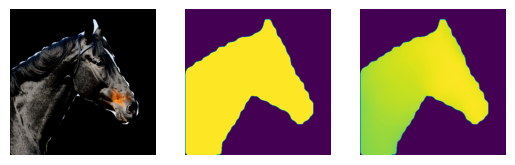

 39%|███████████████████████████▉                                           | 236/600 [00:03<00:04, 89.60it/s]

tensor(0.2486, device='cuda:0') tensor(0.5435, device='cuda:0')
tensor(0.1872, device='cuda:0') tensor(0.5441, device='cuda:0')
tensor(0.1596, device='cuda:0') tensor(0.5446, device='cuda:0')
tensor(0.1590, device='cuda:0') tensor(0.5450, device='cuda:0')
tensor(0.1590, device='cuda:0') tensor(0.5454, device='cuda:0')
tensor(0.1589, device='cuda:0') tensor(0.5457, device='cuda:0')
tensor(0.1588, device='cuda:0') tensor(0.5460, device='cuda:0')
tensor(0.1588, device='cuda:0') tensor(0.5462, device='cuda:0')
tensor(0.1589, device='cuda:0') tensor(0.5463, device='cuda:0')
tensor(0.1590, device='cuda:0') tensor(0.5463, device='cuda:0')
tensor(0.1591, device='cuda:0') tensor(0.5463, device='cuda:0')
tensor(0.1591, device='cuda:0') tensor(0.5465, device='cuda:0')
tensor(0.1591, device='cuda:0') tensor(0.5465, device='cuda:0')
tensor(0.1591, device='cuda:0') tensor(0.5466, device='cuda:0')
tensor(0.1591, device='cuda:0') tensor(0.5462, device='cuda:0')
tensor(0.1591, device='cuda:0') tensor(0

 44%|██████████████████████████████▍                                       | 261/600 [00:03<00:03, 104.95it/s]

tensor(0.1602, device='cuda:0') tensor(0.5852, device='cuda:0')
tensor(0.1605, device='cuda:0') tensor(0.6109, device='cuda:0')
tensor(0.1608, device='cuda:0') tensor(0.6437, device='cuda:0')
tensor(0.1611, device='cuda:0') tensor(0.6734, device='cuda:0')
tensor(0.1613, device='cuda:0') tensor(0.7179, device='cuda:0')
tensor(0.1616, device='cuda:0') tensor(0.7497, device='cuda:0')
tensor(0.1619, device='cuda:0') tensor(0.7611, device='cuda:0')
tensor(0.1622, device='cuda:0') tensor(0.7604, device='cuda:0')
tensor(0.1623, device='cuda:0') tensor(0.7591, device='cuda:0')
tensor(0.1626, device='cuda:0') tensor(0.7583, device='cuda:0')
tensor(0.1627, device='cuda:0') tensor(0.7573, device='cuda:0')
tensor(0.1630, device='cuda:0') tensor(0.7560, device='cuda:0')
tensor(0.1634, device='cuda:0') tensor(0.7475, device='cuda:0')
tensor(0.1640, device='cuda:0') tensor(0.7283, device='cuda:0')
tensor(0.1645, device='cuda:0') tensor(0.7051, device='cuda:0')
tensor(0.1651, device='cuda:0') tensor(0

 48%|█████████████████████████████████▎                                    | 285/600 [00:03<00:02, 111.99it/s]

tensor(0.4717, device='cuda:0')
tensor(0.1705, device='cuda:0') tensor(0.4717, device='cuda:0')
tensor(0.1708, device='cuda:0') tensor(0.4716, device='cuda:0')
tensor(0.1711, device='cuda:0') tensor(0.4716, device='cuda:0')
tensor(0.1713, device='cuda:0') tensor(0.4716, device='cuda:0')
tensor(0.1714, device='cuda:0') tensor(0.4716, device='cuda:0')
tensor(0.1715, device='cuda:0') tensor(0.4716, device='cuda:0')
tensor(0.1715, device='cuda:0') tensor(0.4717, device='cuda:0')
tensor(0.1714, device='cuda:0') tensor(0.4717, device='cuda:0')
tensor(0.1713, device='cuda:0') tensor(0.4717, device='cuda:0')
tensor(0.1713, device='cuda:0') tensor(0.4717, device='cuda:0')
tensor(0.1710, device='cuda:0') tensor(0.4716, device='cuda:0')
tensor(0.1710, device='cuda:0') tensor(0.4717, device='cuda:0')
tensor(0.1706, device='cuda:0') tensor(0.4717, device='cuda:0')
tensor(0.1702, device='cuda:0') tensor(0.4717, device='cuda:0')
tensor(0.1699, device='cuda:0') tensor(0.4718, device='cuda:0')
tensor(0

 52%|████████████████████████████████████▎                                 | 311/600 [00:03<00:02, 117.20it/s]

tensor(0.1690, device='cuda:0') tensor(0.4719, device='cuda:0')
tensor(0.1690, device='cuda:0') tensor(0.4719, device='cuda:0')
tensor(0.1691, device='cuda:0') tensor(0.4719, device='cuda:0')
tensor(0.1693, device='cuda:0') tensor(0.4719, device='cuda:0')
tensor(0.1695, device='cuda:0') tensor(0.4718, device='cuda:0')
tensor(0.1698, device='cuda:0') tensor(0.4718, device='cuda:0')
tensor(0.1701, device='cuda:0') tensor(0.4718, device='cuda:0')
tensor(0.1704, device='cuda:0') tensor(0.4717, device='cuda:0')
tensor(0.1707, device='cuda:0') tensor(0.4717, device='cuda:0')
tensor(0.1710, device='cuda:0') tensor(0.4717, device='cuda:0')
tensor(0.1713, device='cuda:0') tensor(0.4717, device='cuda:0')
tensor(0.1718, device='cuda:0') tensor(0.4717, device='cuda:0')
tensor(0.1721, device='cuda:0') tensor(0.4717, device='cuda:0')
tensor(0.1724, device='cuda:0') tensor(0.4715, device='cuda:0')
tensor(0.1726, device='cuda:0') tensor(0.4713, device='cuda:0')
tensor(0.1730, device='cuda:0') tensor(0

 56%|███████████████████████████████████████                               | 335/600 [00:03<00:02, 118.51it/s]

tensor(0.1840, device='cuda:0') tensor(0.4709, device='cuda:0')
tensor(0.1848, device='cuda:0') tensor(0.4708, device='cuda:0')
tensor(0.1852, device='cuda:0') tensor(0.4707, device='cuda:0')
tensor(0.1853, device='cuda:0') tensor(0.4706, device='cuda:0')
tensor(0.1852, device='cuda:0') tensor(0.4705, device='cuda:0')
tensor(0.1849, device='cuda:0') tensor(0.4704, device='cuda:0')
tensor(0.1842, device='cuda:0') tensor(0.4703, device='cuda:0')
tensor(0.1832, device='cuda:0') tensor(0.4703, device='cuda:0')
tensor(0.1822, device='cuda:0') tensor(0.4703, device='cuda:0')
tensor(0.1809, device='cuda:0') tensor(0.4704, device='cuda:0')
tensor(0.1793, device='cuda:0') tensor(0.4704, device='cuda:0')
tensor(0.1780, device='cuda:0') tensor(0.4703, device='cuda:0')
tensor(0.1767, device='cuda:0') tensor(0.4757, device='cuda:0')
tensor(0.1752, device='cuda:0') tensor(0.4835, device='cuda:0')
tensor(0.1733, device='cuda:0') tensor(0.4897, device='cuda:0')
tensor(0.1715, device='cuda:0') tensor(0

 60%|██████████████████████████████████████████                            | 361/600 [00:04<00:01, 119.57it/s]

tensor(0.1590, device='cuda:0') tensor(0.5367, device='cuda:0')
tensor(0.1584, device='cuda:0') tensor(0.5365, device='cuda:0')
tensor(0.1578, device='cuda:0') tensor(0.5321, device='cuda:0')
tensor(0.1573, device='cuda:0') tensor(0.5268, device='cuda:0')
tensor(0.1568, device='cuda:0') tensor(0.5226, device='cuda:0')
tensor(0.1562, device='cuda:0') tensor(0.5156, device='cuda:0')
tensor(0.1561, device='cuda:0') tensor(0.5097, device='cuda:0')
tensor(0.1560, device='cuda:0') tensor(0.5032, device='cuda:0')
tensor(0.1560, device='cuda:0') tensor(0.4993, device='cuda:0')
tensor(0.1561, device='cuda:0') tensor(0.4963, device='cuda:0')
tensor(0.1561, device='cuda:0') tensor(0.4958, device='cuda:0')
tensor(0.1562, device='cuda:0') tensor(0.4959, device='cuda:0')
tensor(0.1563, device='cuda:0') tensor(0.4962, device='cuda:0')
tensor(0.1565, device='cuda:0') tensor(0.4965, device='cuda:0')
tensor(0.1568, device='cuda:0') tensor(0.4972, device='cuda:0')
tensor(0.1569, device='cuda:0') tensor(0

 64%|█████████████████████████████████████████████▏                        | 387/600 [00:04<00:01, 120.65it/s]

tensor(0.5047, device='cuda:0')
tensor(0.1598, device='cuda:0') tensor(0.5043, device='cuda:0')
tensor(0.1601, device='cuda:0') tensor(0.5037, device='cuda:0')
tensor(0.1604, device='cuda:0') tensor(0.5032, device='cuda:0')
tensor(0.1607, device='cuda:0') tensor(0.5023, device='cuda:0')
tensor(0.1611, device='cuda:0') tensor(0.5013, device='cuda:0')
tensor(0.1621, device='cuda:0') tensor(0.5001, device='cuda:0')
tensor(0.1727, device='cuda:0') tensor(0.4994, device='cuda:0')
tensor(0.1827, device='cuda:0') tensor(0.4985, device='cuda:0')
tensor(0.1955, device='cuda:0') tensor(0.4979, device='cuda:0')
tensor(0.2062, device='cuda:0') tensor(0.4974, device='cuda:0')
tensor(0.2195, device='cuda:0') tensor(0.4969, device='cuda:0')
tensor(0.2260, device='cuda:0') tensor(0.4965, device='cuda:0')
tensor(0.2298, device='cuda:0') tensor(0.4958, device='cuda:0')
tensor(0.2304, device='cuda:0') tensor(0.4982, device='cuda:0')
tensor(0.2311, device='cuda:0') tensor(0.5104, device='cuda:0')
tensor(0

 69%|████████████████████████████████████████████████▏                     | 413/600 [00:04<00:01, 120.35it/s]

tensor(0.2367, device='cuda:0') tensor(0.7709, device='cuda:0')
tensor(0.2374, device='cuda:0') tensor(0.7761, device='cuda:0')
tensor(0.2385, device='cuda:0') tensor(0.7796, device='cuda:0')
tensor(0.2402, device='cuda:0') tensor(0.7804, device='cuda:0')
tensor(0.2424, device='cuda:0') tensor(0.7816, device='cuda:0')
tensor(0.2450, device='cuda:0') tensor(0.7812, device='cuda:0')
tensor(0.2478, device='cuda:0') tensor(0.7745, device='cuda:0')
tensor(0.2506, device='cuda:0') tensor(0.7587, device='cuda:0')
tensor(0.2533, device='cuda:0') tensor(0.7301, device='cuda:0')
tensor(0.2553, device='cuda:0') tensor(0.6982, device='cuda:0')
tensor(0.2566, device='cuda:0') tensor(0.6641, device='cuda:0')
tensor(0.2576, device='cuda:0') tensor(0.6355, device='cuda:0')
tensor(0.2586, device='cuda:0') tensor(0.6124, device='cuda:0')
tensor(0.2593, device='cuda:0') tensor(0.5962, device='cuda:0')
tensor(0.2595, device='cuda:0') tensor(0.5821, device='cuda:0')
tensor(0.2598, device='cuda:0') tensor(0

 73%|███████████████████████████████████████████████████▏                  | 439/600 [00:04<00:01, 117.03it/s]

tensor(0.2617, device='cuda:0') tensor(0.5586, device='cuda:0')
tensor(0.2619, device='cuda:0') tensor(0.5586, device='cuda:0')
tensor(0.2621, device='cuda:0') tensor(0.5586, device='cuda:0')
tensor(0.2621, device='cuda:0') tensor(0.5586, device='cuda:0')
tensor(0.2623, device='cuda:0') tensor(0.5586, device='cuda:0')
tensor(0.2624, device='cuda:0') tensor(0.5586, device='cuda:0')
tensor(0.2625, device='cuda:0') tensor(0.5586, device='cuda:0')
tensor(0.2626, device='cuda:0') tensor(0.5587, device='cuda:0')
tensor(0.2625, device='cuda:0') tensor(0.5587, device='cuda:0')
tensor(0.2625, device='cuda:0') tensor(0.5588, device='cuda:0')
tensor(0.2625, device='cuda:0') tensor(0.5588, device='cuda:0')
tensor(0.2625, device='cuda:0') tensor(0.5588, device='cuda:0')
tensor(0.2625, device='cuda:0') tensor(0.5589, device='cuda:0')
tensor(0.2624, device='cuda:0') tensor(0.5589, device='cuda:0')
tensor(0.2624, device='cuda:0') tensor(0.5589, device='cuda:0')
tensor(0.2672, device='cuda:0') tensor(0

100%|███████████████████████████████████████████████████████████████████████| 600/600 [00:06<00:00, 87.22it/s]


/grogu/user/akirchme/art3d_sd_webui/images/horse/1370.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/1370.mp4


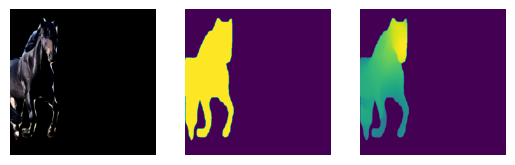

 41%|████████████████████████████▋                                         | 246/600 [00:02<00:02, 119.81it/s]

tensor(0.2995, device='cuda:0') tensor(0.5262, device='cuda:0')
tensor(0.2975, device='cuda:0') tensor(0.5264, device='cuda:0')
tensor(0.2977, device='cuda:0') tensor(0.5266, device='cuda:0')
tensor(0.2975, device='cuda:0') tensor(0.5264, device='cuda:0')
tensor(0.2977, device='cuda:0') tensor(0.5260, device='cuda:0')
tensor(0.2982, device='cuda:0') tensor(0.5257, device='cuda:0')
tensor(0.2984, device='cuda:0') tensor(0.5252, device='cuda:0')
tensor(0.2984, device='cuda:0') tensor(0.5249, device='cuda:0')
tensor(0.2985, device='cuda:0') tensor(0.5239, device='cuda:0')
tensor(0.2988, device='cuda:0') tensor(0.5234, device='cuda:0')
tensor(0.2990, device='cuda:0') tensor(0.5226, device='cuda:0')
tensor(0.2990, device='cuda:0') tensor(0.5219, device='cuda:0')
tensor(0.2992, device='cuda:0') tensor(0.5206, device='cuda:0')
tensor(0.2994, device='cuda:0') tensor(0.5195, device='cuda:0')
tensor(0.2995, device='cuda:0') tensor(0.5186, device='cuda:0')
tensor(0.2996, device='cuda:0') tensor(0

 48%|█████████████████████████████████▎                                    | 285/600 [00:02<00:02, 119.98it/s]

tensor(0.3174, device='cuda:0') tensor(0.5154, device='cuda:0')
tensor(0.3183, device='cuda:0') tensor(0.5086, device='cuda:0')
tensor(0.3192, device='cuda:0') tensor(0.5016, device='cuda:0')
tensor(0.3204, device='cuda:0') tensor(0.4955, device='cuda:0')
tensor(0.3217, device='cuda:0') tensor(0.4897, device='cuda:0')
tensor(0.3241, device='cuda:0') tensor(0.4849, device='cuda:0')
tensor(0.3284, device='cuda:0') tensor(0.4820, device='cuda:0')
tensor(0.3331, device='cuda:0') tensor(0.4812, device='cuda:0')
tensor(0.3382, device='cuda:0') tensor(0.4803, device='cuda:0')
tensor(0.3423, device='cuda:0') tensor(0.4799, device='cuda:0')
tensor(0.3442, device='cuda:0') tensor(0.4797, device='cuda:0')
tensor(0.3449, device='cuda:0') tensor(0.4795, device='cuda:0')
tensor(0.3439, device='cuda:0') tensor(0.4789, device='cuda:0')
tensor(0.3398, device='cuda:0') tensor(0.4785, device='cuda:0')
tensor(0.3354, device='cuda:0') tensor(0.4783, device='cuda:0')
tensor(0.3301, device='cuda:0') tensor(0

 50%|██████████████████████████████████▊                                   | 298/600 [00:02<00:02, 119.49it/s]

tensor(0.3237, device='cuda:0') tensor(0.4775, device='cuda:0')
tensor(0.3233, device='cuda:0') tensor(0.4776, device='cuda:0')
tensor(0.3229, device='cuda:0') tensor(0.4778, device='cuda:0')
tensor(0.3228, device='cuda:0') tensor(0.4778, device='cuda:0')
tensor(0.3224, device='cuda:0') tensor(0.4777, device='cuda:0')
tensor(0.3218, device='cuda:0') tensor(0.4776, device='cuda:0')
tensor(0.3213, device='cuda:0') tensor(0.4774, device='cuda:0')
tensor(0.3211, device='cuda:0') tensor(0.4773, device='cuda:0')
tensor(0.3210, device='cuda:0') tensor(0.4774, device='cuda:0')
tensor(0.3208, device='cuda:0') tensor(0.4775, device='cuda:0')
tensor(0.3207, device='cuda:0') tensor(0.4775, device='cuda:0')
tensor(0.3204, device='cuda:0') tensor(0.4776, device='cuda:0')
tensor(0.3201, device='cuda:0') tensor(0.4776, device='cuda:0')
tensor(0.3196, device='cuda:0') tensor(0.4776, device='cuda:0')
tensor(0.3194, device='cuda:0') tensor(0.4775, device='cuda:0')
tensor(0.3190, device='cuda:0') tensor(0

 54%|█████████████████████████████████████▌                                | 322/600 [00:02<00:02, 118.83it/s]

tensor(0.3115, device='cuda:0') tensor(0.4780, device='cuda:0')
tensor(0.3106, device='cuda:0') tensor(0.4782, device='cuda:0')
tensor(0.3099, device='cuda:0') tensor(0.4785, device='cuda:0')
tensor(0.3094, device='cuda:0') tensor(0.4786, device='cuda:0')
tensor(0.3089, device='cuda:0') tensor(0.4789, device='cuda:0')
tensor(0.3088, device='cuda:0') tensor(0.4790, device='cuda:0')
tensor(0.3088, device='cuda:0') tensor(0.4789, device='cuda:0')
tensor(0.3087, device='cuda:0') tensor(0.4790, device='cuda:0')
tensor(0.3091, device='cuda:0') tensor(0.4792, device='cuda:0')
tensor(0.3091, device='cuda:0') tensor(0.4793, device='cuda:0')
tensor(0.3096, device='cuda:0') tensor(0.4795, device='cuda:0')
tensor(0.3099, device='cuda:0') tensor(0.4798, device='cuda:0')
tensor(0.3101, device='cuda:0') tensor(0.4798, device='cuda:0')
tensor(0.3093, device='cuda:0') tensor(0.4798, device='cuda:0')
tensor(0.3088, device='cuda:0') tensor(0.4799, device='cuda:0')
tensor(0.3086, device='cuda:0') tensor(0

 58%|████████████████████████████████████████▎                             | 346/600 [00:02<00:02, 118.57it/s]

tensor(0.2983, device='cuda:0') tensor(0.4818, device='cuda:0')
tensor(0.2964, device='cuda:0') tensor(0.4825, device='cuda:0')
tensor(0.2948, device='cuda:0') tensor(0.4841, device='cuda:0')
tensor(0.2931, device='cuda:0') tensor(0.4859, device='cuda:0')
tensor(0.2906, device='cuda:0') tensor(0.4885, device='cuda:0')
tensor(0.2891, device='cuda:0') tensor(0.4947, device='cuda:0')
tensor(0.2875, device='cuda:0') tensor(0.5273, device='cuda:0')
tensor(0.2859, device='cuda:0') tensor(0.5416, device='cuda:0')
tensor(0.2846, device='cuda:0') tensor(0.5461, device='cuda:0')
tensor(0.2833, device='cuda:0') tensor(0.5493, device='cuda:0')
tensor(0.2824, device='cuda:0') tensor(0.5509, device='cuda:0')
tensor(0.2813, device='cuda:0') tensor(0.5519, device='cuda:0')
tensor(0.2809, device='cuda:0') tensor(0.5530, device='cuda:0')
tensor(0.2800, device='cuda:0') tensor(0.5540, device='cuda:0')
tensor(0.2791, device='cuda:0') tensor(0.5557, device='cuda:0')
tensor(0.2784, device='cuda:0') tensor(0

 62%|███████████████████████████████████████████▏                          | 370/600 [00:03<00:01, 118.56it/s]

tensor(0.2734, device='cuda:0') tensor(0.5125, device='cuda:0')
tensor(0.2730, device='cuda:0') tensor(0.5126, device='cuda:0')
tensor(0.2722, device='cuda:0') tensor(0.5131, device='cuda:0')
tensor(0.2720, device='cuda:0') tensor(0.5137, device='cuda:0')
tensor(0.2716, device='cuda:0') tensor(0.5139, device='cuda:0')
tensor(0.2715, device='cuda:0') tensor(0.5147, device='cuda:0')
tensor(0.2715, device='cuda:0') tensor(0.5149, device='cuda:0')
tensor(0.2714, device='cuda:0') tensor(0.5164, device='cuda:0')
tensor(0.2716, device='cuda:0') tensor(0.5181, device='cuda:0')
tensor(0.2714, device='cuda:0') tensor(0.5197, device='cuda:0')
tensor(0.2715, device='cuda:0') tensor(0.5212, device='cuda:0')
tensor(0.2719, device='cuda:0') tensor(0.5226, device='cuda:0')
tensor(0.2724, device='cuda:0') tensor(0.5247, device='cuda:0')
tensor(0.2727, device='cuda:0') tensor(0.5257, device='cuda:0')
tensor(0.2729, device='cuda:0') tensor(0.5269, device='cuda:0')
tensor(0.2730, device='cuda:0') tensor(0

100%|██████████████████████████████████████████████████████████████████████| 600/600 [00:04<00:00, 121.59it/s]


/grogu/user/akirchme/art3d_sd_webui/images/horse/394.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/394.mp4


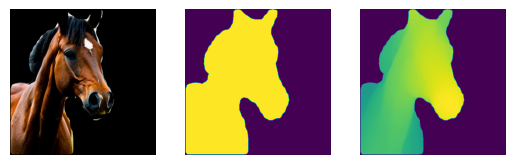

 39%|███████████████████████████▊                                           | 235/600 [00:03<00:04, 86.48it/s]

tensor(0.2945, device='cuda:0') tensor(0.5254, device='cuda:0')
tensor(0.2802, device='cuda:0') tensor(0.5276, device='cuda:0')
tensor(0.2663, device='cuda:0') tensor(0.5292, device='cuda:0')
tensor(0.2545, device='cuda:0') tensor(0.5295, device='cuda:0')
tensor(0.2448, device='cuda:0') tensor(0.5305, device='cuda:0')
tensor(0.2378, device='cuda:0') tensor(0.5312, device='cuda:0')
tensor(0.2340, device='cuda:0') tensor(0.5320, device='cuda:0')
tensor(0.2339, device='cuda:0') tensor(0.5325, device='cuda:0')
tensor(0.2338, device='cuda:0') tensor(0.5328, device='cuda:0')
tensor(0.2339, device='cuda:0') tensor(0.5319, device='cuda:0')
tensor(0.2340, device='cuda:0') tensor(0.5297, device='cuda:0')
tensor(0.2341, device='cuda:0') tensor(0.5269, device='cuda:0')
tensor(0.2342, device='cuda:0') tensor(0.5241, device='cuda:0')
tensor(0.2344, device='cuda:0') tensor(0.5224, device='cuda:0')
tensor(0.2344, device='cuda:0') tensor(0.5214, device='cuda:0')
tensor(0.2342, device='cuda:0') tensor(0

 43%|██████████████████████████████▏                                       | 259/600 [00:03<00:03, 101.55it/s]

tensor(0.2367, device='cuda:0') tensor(0.5103, device='cuda:0')
tensor(0.2377, device='cuda:0') tensor(0.5114, device='cuda:0')
tensor(0.2390, device='cuda:0') tensor(0.5127, device='cuda:0')
tensor(0.2404, device='cuda:0') tensor(0.5189, device='cuda:0')
tensor(0.2418, device='cuda:0') tensor(0.5243, device='cuda:0')
tensor(0.2430, device='cuda:0') tensor(0.5289, device='cuda:0')
tensor(0.2444, device='cuda:0') tensor(0.5325, device='cuda:0')
tensor(0.2460, device='cuda:0') tensor(0.5358, device='cuda:0')
tensor(0.2477, device='cuda:0') tensor(0.5388, device='cuda:0')
tensor(0.2494, device='cuda:0') tensor(0.5399, device='cuda:0')
tensor(0.2509, device='cuda:0') tensor(0.5400, device='cuda:0')
tensor(0.2522, device='cuda:0') tensor(0.5386, device='cuda:0')
tensor(0.2537, device='cuda:0') tensor(0.5369, device='cuda:0')
tensor(0.2554, device='cuda:0') tensor(0.5354, device='cuda:0')
tensor(0.2570, device='cuda:0') tensor(0.5334, device='cuda:0')
tensor(0.2591, device='cuda:0') tensor(0

 47%|█████████████████████████████████                                     | 283/600 [00:03<00:02, 110.23it/s]

tensor(0.2816, device='cuda:0') tensor(0.4647, device='cuda:0')
tensor(0.2829, device='cuda:0') tensor(0.4628, device='cuda:0')
tensor(0.2842, device='cuda:0') tensor(0.4624, device='cuda:0')
tensor(0.2852, device='cuda:0') tensor(0.4619, device='cuda:0')
tensor(0.2865, device='cuda:0') tensor(0.4618, device='cuda:0')
tensor(0.2876, device='cuda:0') tensor(0.4616, device='cuda:0')
tensor(0.2887, device='cuda:0') tensor(0.4614, device='cuda:0')
tensor(0.2894, device='cuda:0') tensor(0.4611, device='cuda:0')
tensor(0.2903, device='cuda:0') tensor(0.4608, device='cuda:0')
tensor(0.2909, device='cuda:0') tensor(0.4608, device='cuda:0')
tensor(0.2917, device='cuda:0') tensor(0.4607, device='cuda:0')
tensor(0.2923, device='cuda:0') tensor(0.4604, device='cuda:0')
tensor(0.2928, device='cuda:0') tensor(0.4603, device='cuda:0')
tensor(0.2934, device='cuda:0') tensor(0.4603, device='cuda:0')
tensor(0.2938, device='cuda:0') tensor(0.4602, device='cuda:0')
tensor(0.2940, device='cuda:0') tensor(0

 51%|███████████████████████████████████▊                                  | 307/600 [00:03<00:02, 114.98it/s]

tensor(0.2949, device='cuda:0') tensor(0.4590, device='cuda:0')
tensor(0.2954, device='cuda:0') tensor(0.4588, device='cuda:0')
tensor(0.2958, device='cuda:0') tensor(0.4588, device='cuda:0')
tensor(0.2964, device='cuda:0') tensor(0.4587, device='cuda:0')
tensor(0.2969, device='cuda:0') tensor(0.4587, device='cuda:0')
tensor(0.2973, device='cuda:0') tensor(0.4586, device='cuda:0')
tensor(0.2974, device='cuda:0') tensor(0.4585, device='cuda:0')
tensor(0.2975, device='cuda:0') tensor(0.4585, device='cuda:0')
tensor(0.2976, device='cuda:0') tensor(0.4584, device='cuda:0')
tensor(0.2975, device='cuda:0') tensor(0.4584, device='cuda:0')
tensor(0.2977, device='cuda:0') tensor(0.4584, device='cuda:0')
tensor(0.2979, device='cuda:0') tensor(0.4583, device='cuda:0')
tensor(0.2979, device='cuda:0') tensor(0.4584, device='cuda:0')
tensor(0.2980, device='cuda:0') tensor(0.4583, device='cuda:0')
tensor(0.2979, device='cuda:0') tensor(0.4584, device='cuda:0')
tensor(0.2980, device='cuda:0') tensor(0

 55%|██████████████████████████████████████▌                               | 331/600 [00:03<00:02, 117.18it/s]

tensor(0.3003, device='cuda:0') tensor(0.4595, device='cuda:0')
tensor(0.3008, device='cuda:0') tensor(0.4596, device='cuda:0')
tensor(0.3012, device='cuda:0') tensor(0.4597, device='cuda:0')
tensor(0.3012, device='cuda:0') tensor(0.4598, device='cuda:0')
tensor(0.3012, device='cuda:0') tensor(0.4599, device='cuda:0')
tensor(0.3009, device='cuda:0') tensor(0.4600, device='cuda:0')
tensor(0.3003, device='cuda:0') tensor(0.4600, device='cuda:0')
tensor(0.2997, device='cuda:0') tensor(0.4602, device='cuda:0')
tensor(0.2991, device='cuda:0') tensor(0.4603, device='cuda:0')
tensor(0.2984, device='cuda:0') tensor(0.4605, device='cuda:0')
tensor(0.2975, device='cuda:0') tensor(0.4607, device='cuda:0')
tensor(0.2964, device='cuda:0') tensor(0.4609, device='cuda:0')
tensor(0.2953, device='cuda:0') tensor(0.4612, device='cuda:0')
tensor(0.2940, device='cuda:0') tensor(0.4614, device='cuda:0')
tensor(0.2927, device='cuda:0') tensor(0.4616, device='cuda:0')
tensor(0.2914, device='cuda:0') tensor(0

 59%|█████████████████████████████████████████▍                            | 355/600 [00:04<00:02, 117.34it/s]

tensor(0.2715, device='cuda:0') tensor(0.5501, device='cuda:0')
tensor(0.2694, device='cuda:0') tensor(0.5555, device='cuda:0')
tensor(0.2674, device='cuda:0') tensor(0.5562, device='cuda:0')
tensor(0.2657, device='cuda:0') tensor(0.5569, device='cuda:0')
tensor(0.2641, device='cuda:0') tensor(0.5576, device='cuda:0')
tensor(0.2625, device='cuda:0') tensor(0.5587, device='cuda:0')
tensor(0.2609, device='cuda:0') tensor(0.5607, device='cuda:0')
tensor(0.2591, device='cuda:0') tensor(0.5618, device='cuda:0')
tensor(0.2571, device='cuda:0') tensor(0.5593, device='cuda:0')
tensor(0.2554, device='cuda:0') tensor(0.5533, device='cuda:0')
tensor(0.2538, device='cuda:0') tensor(0.5479, device='cuda:0')
tensor(0.2520, device='cuda:0') tensor(0.5426, device='cuda:0')
tensor(0.2504, device='cuda:0') tensor(0.5380, device='cuda:0')
tensor(0.2488, device='cuda:0') tensor(0.5333, device='cuda:0')
tensor(0.2472, device='cuda:0') tensor(0.5289, device='cuda:0')
tensor(0.2457, device='cuda:0') tensor(0

 63%|████████████████████████████████████████████▎                         | 380/600 [00:04<00:01, 119.27it/s]

tensor(0.2376, device='cuda:0') tensor(0.5355, device='cuda:0')
tensor(0.2375, device='cuda:0') tensor(0.5377, device='cuda:0')
tensor(0.2376, device='cuda:0') tensor(0.5400, device='cuda:0')
tensor(0.2377, device='cuda:0') tensor(0.5424, device='cuda:0')
tensor(0.2380, device='cuda:0') tensor(0.5441, device='cuda:0')
tensor(0.2381, device='cuda:0') tensor(0.5461, device='cuda:0')
tensor(0.2379, device='cuda:0') tensor(0.5476, device='cuda:0')
tensor(0.2378, device='cuda:0') tensor(0.5495, device='cuda:0')
tensor(0.2377, device='cuda:0') tensor(0.5512, device='cuda:0')
tensor(0.2377, device='cuda:0') tensor(0.5524, device='cuda:0')
tensor(0.2378, device='cuda:0') tensor(0.5525, device='cuda:0')
tensor(0.2380, device='cuda:0') tensor(0.5524, device='cuda:0')
tensor(0.2417, device='cuda:0') tensor(0.5517, device='cuda:0')
tensor(0.2519, device='cuda:0') tensor(0.5503, device='cuda:0')
tensor(0.2708, device='cuda:0') tensor(0.5491, device='cuda:0')
tensor(0.2882, device='cuda:0') tensor(0

100%|███████████████████████████████████████████████████████████████████████| 600/600 [00:07<00:00, 81.37it/s]


/grogu/user/akirchme/art3d_sd_webui/images/horse/433.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/433.mp4


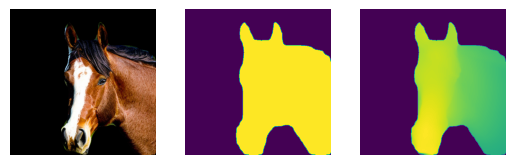

  4%|██▋                                                                    | 23/600 [00:00<00:04, 115.60it/s]

tensor(0.2312, device='cuda:0') tensor(0.4748, device='cuda:0')
tensor(0.2313, device='cuda:0') tensor(0.4747, device='cuda:0')
tensor(0.2310, device='cuda:0') tensor(0.4748, device='cuda:0')
tensor(0.2307, device='cuda:0') tensor(0.4748, device='cuda:0')
tensor(0.2305, device='cuda:0') tensor(0.4747, device='cuda:0')
tensor(0.2301, device='cuda:0') tensor(0.4747, device='cuda:0')
tensor(0.2296, device='cuda:0') tensor(0.4748, device='cuda:0')
tensor(0.2290, device='cuda:0') tensor(0.4748, device='cuda:0')
tensor(0.2284, device='cuda:0') tensor(0.4748, device='cuda:0')
tensor(0.2280, device='cuda:0') tensor(0.4748, device='cuda:0')
tensor(0.2276, device='cuda:0') tensor(0.4749, device='cuda:0')
tensor(0.2273, device='cuda:0') tensor(0.4750, device='cuda:0')
tensor(0.2270, device='cuda:0') tensor(0.4750, device='cuda:0')
tensor(0.2269, device='cuda:0') tensor(0.4750, device='cuda:0')
tensor(0.2269, device='cuda:0') tensor(0.4751, device='cuda:0')
tensor(0.2270, device='cuda:0') tensor(0

  8%|█████▋                                                                 | 48/600 [00:00<00:04, 118.80it/s]

tensor(0.2297, device='cuda:0') tensor(0.4758, device='cuda:0')
tensor(0.2290, device='cuda:0') tensor(0.4759, device='cuda:0')
tensor(0.2278, device='cuda:0') tensor(0.4759, device='cuda:0')
tensor(0.2266, device='cuda:0') tensor(0.4761, device='cuda:0')
tensor(0.2247, device='cuda:0') tensor(0.4763, device='cuda:0')
tensor(0.2230, device='cuda:0') tensor(0.4763, device='cuda:0')
tensor(0.2211, device='cuda:0') tensor(0.4766, device='cuda:0')
tensor(0.2193, device='cuda:0') tensor(0.4769, device='cuda:0')
tensor(0.2175, device='cuda:0') tensor(0.4786, device='cuda:0')
tensor(0.2160, device='cuda:0') tensor(0.4813, device='cuda:0')
tensor(0.2143, device='cuda:0') tensor(0.4864, device='cuda:0')
tensor(0.2129, device='cuda:0') tensor(0.4947, device='cuda:0')
tensor(0.2115, device='cuda:0') tensor(0.5092, device='cuda:0')
tensor(0.2100, device='cuda:0') tensor(0.5262, device='cuda:0')
tensor(0.2088, device='cuda:0') tensor(0.5503, device='cuda:0')
tensor(0.2073, device='cuda:0') tensor(0

 12%|████████▌                                                              | 72/600 [00:00<00:04, 119.37it/s]

tensor(0.1973, device='cuda:0') tensor(0.6255, device='cuda:0')
tensor(0.1965, device='cuda:0') tensor(0.6163, device='cuda:0')
tensor(0.1955, device='cuda:0') tensor(0.6036, device='cuda:0')
tensor(0.1944, device='cuda:0') tensor(0.5821, device='cuda:0')
tensor(0.1933, device='cuda:0') tensor(0.5452, device='cuda:0')
tensor(0.1926, device='cuda:0') tensor(0.5240, device='cuda:0')
tensor(0.1917, device='cuda:0') tensor(0.5248, device='cuda:0')
tensor(0.1911, device='cuda:0') tensor(0.5249, device='cuda:0')
tensor(0.1905, device='cuda:0') tensor(0.5259, device='cuda:0')
tensor(0.1899, device='cuda:0') tensor(0.5280, device='cuda:0')
tensor(0.1897, device='cuda:0') tensor(0.5294, device='cuda:0')
tensor(0.1892, device='cuda:0') tensor(0.5313, device='cuda:0')
tensor(0.1889, device='cuda:0') tensor(0.5321, device='cuda:0')
tensor(0.1888, device='cuda:0') tensor(0.5330, device='cuda:0')
tensor(0.1888, device='cuda:0') tensor(0.5335, device='cuda:0')
tensor(0.1885, device='cuda:0') tensor(0

 14%|█████████▉                                                             | 84/600 [00:00<00:04, 113.94it/s]

tensor(0.1870, device='cuda:0') tensor(0.5335, device='cuda:0')
tensor(0.1871, device='cuda:0') tensor(0.5328, device='cuda:0')
tensor(0.1898, device='cuda:0') tensor(0.5319, device='cuda:0')
tensor(0.1964, device='cuda:0') tensor(0.5308, device='cuda:0')
tensor(0.2114, device='cuda:0') tensor(0.5300, device='cuda:0')
tensor(0.2347, device='cuda:0') tensor(0.5290, device='cuda:0')
tensor(0.2734, device='cuda:0') tensor(0.5280, device='cuda:0')


 90%|████████████████████████████████████████████████████████████████▏      | 542/600 [00:06<00:00, 91.85it/s]

tensor(0.2628, device='cuda:0') tensor(0.5408, device='cuda:0')
tensor(0.2315, device='cuda:0') tensor(0.5416, device='cuda:0')
tensor(0.2131, device='cuda:0') tensor(0.5420, device='cuda:0')
tensor(0.1986, device='cuda:0') tensor(0.5432, device='cuda:0')
tensor(0.1884, device='cuda:0') tensor(0.5443, device='cuda:0')
tensor(0.1814, device='cuda:0') tensor(0.5454, device='cuda:0')
tensor(0.1809, device='cuda:0') tensor(0.5468, device='cuda:0')
tensor(0.1808, device='cuda:0') tensor(0.5484, device='cuda:0')
tensor(0.1807, device='cuda:0') tensor(0.5500, device='cuda:0')
tensor(0.1807, device='cuda:0') tensor(0.5518, device='cuda:0')
tensor(0.1809, device='cuda:0') tensor(0.5530, device='cuda:0')
tensor(0.1811, device='cuda:0') tensor(0.5544, device='cuda:0')
tensor(0.1813, device='cuda:0') tensor(0.5556, device='cuda:0')
tensor(0.1812, device='cuda:0') tensor(0.5565, device='cuda:0')
tensor(0.1813, device='cuda:0') tensor(0.5569, device='cuda:0')
tensor(0.1815, device='cuda:0') tensor(0

 94%|██████████████████████████████████████████████████████████████████▏   | 567/600 [00:06<00:00, 105.87it/s]

tensor(0.1891, device='cuda:0') tensor(0.5476, device='cuda:0')
tensor(0.1902, device='cuda:0') tensor(0.5470, device='cuda:0')
tensor(0.1911, device='cuda:0') tensor(0.5632, device='cuda:0')
tensor(0.1921, device='cuda:0') tensor(0.5817, device='cuda:0')
tensor(0.1928, device='cuda:0') tensor(0.5919, device='cuda:0')
tensor(0.1939, device='cuda:0') tensor(0.5973, device='cuda:0')
tensor(0.1946, device='cuda:0') tensor(0.6009, device='cuda:0')
tensor(0.1953, device='cuda:0') tensor(0.6054, device='cuda:0')
tensor(0.1962, device='cuda:0') tensor(0.6078, device='cuda:0')
tensor(0.1969, device='cuda:0') tensor(0.6096, device='cuda:0')
tensor(0.1979, device='cuda:0') tensor(0.6085, device='cuda:0')
tensor(0.1987, device='cuda:0') tensor(0.6079, device='cuda:0')
tensor(0.1996, device='cuda:0') tensor(0.6076, device='cuda:0')
tensor(0.2007, device='cuda:0') tensor(0.6071, device='cuda:0')
tensor(0.2015, device='cuda:0') tensor(0.6067, device='cuda:0')
tensor(0.2025, device='cuda:0') tensor(0

 99%|█████████████████████████████████████████████████████████████████████ | 592/600 [00:07<00:00, 113.00it/s]

tensor(0.2145, device='cuda:0') tensor(0.4764, device='cuda:0')
tensor(0.2166, device='cuda:0') tensor(0.4762, device='cuda:0')
tensor(0.2190, device='cuda:0') tensor(0.4761, device='cuda:0')
tensor(0.2210, device='cuda:0') tensor(0.4761, device='cuda:0')
tensor(0.2231, device='cuda:0') tensor(0.4760, device='cuda:0')
tensor(0.2245, device='cuda:0') tensor(0.4759, device='cuda:0')
tensor(0.2256, device='cuda:0') tensor(0.4758, device='cuda:0')
tensor(0.2261, device='cuda:0') tensor(0.4756, device='cuda:0')
tensor(0.2262, device='cuda:0') tensor(0.4756, device='cuda:0')
tensor(0.2258, device='cuda:0') tensor(0.4754, device='cuda:0')
tensor(0.2253, device='cuda:0') tensor(0.4754, device='cuda:0')
tensor(0.2243, device='cuda:0') tensor(0.4754, device='cuda:0')
tensor(0.2239, device='cuda:0') tensor(0.4754, device='cuda:0')
tensor(0.2238, device='cuda:0') tensor(0.4754, device='cuda:0')
tensor(0.2235, device='cuda:0') tensor(0.4753, device='cuda:0')
tensor(0.2236, device='cuda:0') tensor(0

100%|███████████████████████████████████████████████████████████████████████| 600/600 [00:07<00:00, 82.53it/s]


tensor(0.2286, device='cuda:0') tensor(0.4748, device='cuda:0')
tensor(0.2288, device='cuda:0') tensor(0.4748, device='cuda:0')
tensor(0.2290, device='cuda:0') tensor(0.4748, device='cuda:0')
tensor(0.2295, device='cuda:0') tensor(0.4749, device='cuda:0')
tensor(0.2302, device='cuda:0') tensor(0.4748, device='cuda:0')
tensor(0.2308, device='cuda:0') tensor(0.4748, device='cuda:0')
/grogu/user/akirchme/art3d_sd_webui/images/horse/841.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/841.mp4


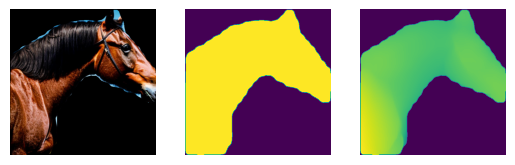

  4%|██▍                                                                    | 21/600 [00:00<00:05, 103.52it/s]

tensor(0.2514, device='cuda:0') tensor(0.4864, device='cuda:0')
tensor(0.2515, device='cuda:0') tensor(0.4864, device='cuda:0')
tensor(0.2515, device='cuda:0') tensor(0.4863, device='cuda:0')
tensor(0.2513, device='cuda:0') tensor(0.4863, device='cuda:0')
tensor(0.2511, device='cuda:0') tensor(0.4862, device='cuda:0')
tensor(0.2508, device='cuda:0') tensor(0.4862, device='cuda:0')
tensor(0.2505, device='cuda:0') tensor(0.4862, device='cuda:0')
tensor(0.2500, device='cuda:0') tensor(0.4863, device='cuda:0')
tensor(0.2496, device='cuda:0') tensor(0.4864, device='cuda:0')
tensor(0.2491, device='cuda:0') tensor(0.4864, device='cuda:0')
tensor(0.2486, device='cuda:0') tensor(0.4864, device='cuda:0')
tensor(0.2487, device='cuda:0') tensor(0.4865, device='cuda:0')
tensor(0.2493, device='cuda:0') tensor(0.4866, device='cuda:0')
tensor(0.2500, device='cuda:0') tensor(0.4866, device='cuda:0')
tensor(0.2503, device='cuda:0') tensor(0.4867, device='cuda:0')
tensor(0.2503, device='cuda:0') tensor(0

  8%|█████▎                                                                 | 45/600 [00:00<00:05, 110.68it/s]

tensor(0.2478, device='cuda:0') tensor(0.4875, device='cuda:0')
tensor(0.2470, device='cuda:0') tensor(0.4876, device='cuda:0')
tensor(0.2462, device='cuda:0') tensor(0.4877, device='cuda:0')
tensor(0.2449, device='cuda:0') tensor(0.4878, device='cuda:0')
tensor(0.2438, device='cuda:0') tensor(0.4879, device='cuda:0')
tensor(0.2423, device='cuda:0') tensor(0.4880, device='cuda:0')
tensor(0.2409, device='cuda:0') tensor(0.4881, device='cuda:0')
tensor(0.2392, device='cuda:0') tensor(0.4880, device='cuda:0')
tensor(0.2378, device='cuda:0') tensor(0.4880, device='cuda:0')
tensor(0.2361, device='cuda:0') tensor(0.4880, device='cuda:0')
tensor(0.2340, device='cuda:0') tensor(0.4880, device='cuda:0')
tensor(0.2316, device='cuda:0') tensor(0.4923, device='cuda:0')
tensor(0.2291, device='cuda:0') tensor(0.4967, device='cuda:0')
tensor(0.2266, device='cuda:0') tensor(0.5075, device='cuda:0')
tensor(0.2244, device='cuda:0') tensor(0.5197, device='cuda:0')
tensor(0.2225, device='cuda:0') tensor(0

 10%|██████▋                                                                | 57/600 [00:00<00:04, 112.53it/s]

tensor(0.2062, device='cuda:0') tensor(0.5903, device='cuda:0')
tensor(0.2052, device='cuda:0') tensor(0.5905, device='cuda:0')
tensor(0.2044, device='cuda:0') tensor(0.5905, device='cuda:0')
tensor(0.2035, device='cuda:0') tensor(0.5872, device='cuda:0')
tensor(0.2026, device='cuda:0') tensor(0.5839, device='cuda:0')
tensor(0.2018, device='cuda:0') tensor(0.5776, device='cuda:0')
tensor(0.2010, device='cuda:0') tensor(0.5672, device='cuda:0')
tensor(0.2007, device='cuda:0') tensor(0.5542, device='cuda:0')
tensor(0.2006, device='cuda:0') tensor(0.5312, device='cuda:0')
tensor(0.2005, device='cuda:0') tensor(0.5167, device='cuda:0')
tensor(0.2004, device='cuda:0') tensor(0.5148, device='cuda:0')
tensor(0.2000, device='cuda:0') tensor(0.5156, device='cuda:0')
tensor(0.1994, device='cuda:0') tensor(0.5173, device='cuda:0')
tensor(0.1993, device='cuda:0') tensor(0.5192, device='cuda:0')
tensor(0.1991, device='cuda:0') tensor(0.5207, device='cuda:0')
tensor(0.1991, device='cuda:0') tensor(0

 14%|█████████▋                                                             | 82/600 [00:00<00:04, 116.73it/s]

tensor(0.2021, device='cuda:0') tensor(0.5361, device='cuda:0')
tensor(0.2026, device='cuda:0') tensor(0.5371, device='cuda:0')
tensor(0.2030, device='cuda:0') tensor(0.5369, device='cuda:0')
tensor(0.2037, device='cuda:0') tensor(0.5360, device='cuda:0')
tensor(0.2043, device='cuda:0') tensor(0.5345, device='cuda:0')
tensor(0.2049, device='cuda:0') tensor(0.5325, device='cuda:0')
tensor(0.2053, device='cuda:0') tensor(0.5296, device='cuda:0')
tensor(0.2069, device='cuda:0') tensor(0.5274, device='cuda:0')
tensor(0.2132, device='cuda:0') tensor(0.5252, device='cuda:0')
tensor(0.2285, device='cuda:0') tensor(0.5225, device='cuda:0')
tensor(0.2456, device='cuda:0') tensor(0.5197, device='cuda:0')
tensor(0.2636, device='cuda:0') tensor(0.5162, device='cuda:0')
tensor(0.2915, device='cuda:0') tensor(0.5123, device='cuda:0')
tensor(0.3058, device='cuda:0') tensor(0.5099, device='cuda:0')
tensor(0.3106, device='cuda:0') tensor(0.5079, device='cuda:0')
tensor(0.3112, device='cuda:0') tensor(0

 90%|███████████████████████████████████████████████████████████████▉       | 540/600 [00:07<00:00, 84.16it/s]

tensor(0.2972, device='cuda:0') tensor(0.5453, device='cuda:0')
tensor(0.2618, device='cuda:0') tensor(0.5461, device='cuda:0')
tensor(0.2210, device='cuda:0') tensor(0.5468, device='cuda:0')
tensor(0.2047, device='cuda:0') tensor(0.5476, device='cuda:0')
tensor(0.2033, device='cuda:0') tensor(0.5494, device='cuda:0')
tensor(0.2034, device='cuda:0') tensor(0.5520, device='cuda:0')
tensor(0.2035, device='cuda:0') tensor(0.5538, device='cuda:0')
tensor(0.2034, device='cuda:0') tensor(0.5551, device='cuda:0')
tensor(0.2035, device='cuda:0') tensor(0.5560, device='cuda:0')
tensor(0.2036, device='cuda:0') tensor(0.5565, device='cuda:0')
tensor(0.2037, device='cuda:0') tensor(0.5566, device='cuda:0')
tensor(0.2038, device='cuda:0') tensor(0.5567, device='cuda:0')
tensor(0.2040, device='cuda:0') tensor(0.5569, device='cuda:0')
tensor(0.2040, device='cuda:0') tensor(0.5564, device='cuda:0')
tensor(0.2040, device='cuda:0') tensor(0.5558, device='cuda:0')
tensor(0.2041, device='cuda:0') tensor(0

 94%|█████████████████████████████████████████████████████████████████▊    | 564/600 [00:07<00:00, 100.67it/s]

tensor(0.2081, device='cuda:0') tensor(0.5517, device='cuda:0')
tensor(0.2088, device='cuda:0') tensor(0.5573, device='cuda:0')
tensor(0.2096, device='cuda:0') tensor(0.5613, device='cuda:0')
tensor(0.2104, device='cuda:0') tensor(0.5649, device='cuda:0')
tensor(0.2113, device='cuda:0') tensor(0.5757, device='cuda:0')
tensor(0.2121, device='cuda:0') tensor(0.5864, device='cuda:0')
tensor(0.2129, device='cuda:0') tensor(0.6042, device='cuda:0')
tensor(0.2137, device='cuda:0') tensor(0.6179, device='cuda:0')
tensor(0.2146, device='cuda:0') tensor(0.6236, device='cuda:0')
tensor(0.2155, device='cuda:0') tensor(0.6234, device='cuda:0')
tensor(0.2165, device='cuda:0') tensor(0.6228, device='cuda:0')
tensor(0.2176, device='cuda:0') tensor(0.6221, device='cuda:0')
tensor(0.2189, device='cuda:0') tensor(0.6215, device='cuda:0')
tensor(0.2203, device='cuda:0') tensor(0.6203, device='cuda:0')
tensor(0.2219, device='cuda:0') tensor(0.6158, device='cuda:0')
tensor(0.2237, device='cuda:0') tensor(0

 98%|████████████████████████████████████████████████████████████████████▌ | 588/600 [00:08<00:00, 109.12it/s]

tensor(0.2379, device='cuda:0') tensor(0.4893, device='cuda:0')
tensor(0.2392, device='cuda:0') tensor(0.4890, device='cuda:0')
tensor(0.2403, device='cuda:0') tensor(0.4889, device='cuda:0')
tensor(0.2416, device='cuda:0') tensor(0.4886, device='cuda:0')
tensor(0.2427, device='cuda:0') tensor(0.4886, device='cuda:0')
tensor(0.2434, device='cuda:0') tensor(0.4885, device='cuda:0')
tensor(0.2441, device='cuda:0') tensor(0.4884, device='cuda:0')
tensor(0.2445, device='cuda:0') tensor(0.4883, device='cuda:0')
tensor(0.2449, device='cuda:0') tensor(0.4882, device='cuda:0')
tensor(0.2451, device='cuda:0') tensor(0.4880, device='cuda:0')
tensor(0.2456, device='cuda:0') tensor(0.4879, device='cuda:0')
tensor(0.2459, device='cuda:0') tensor(0.4877, device='cuda:0')
tensor(0.2463, device='cuda:0') tensor(0.4875, device='cuda:0')
tensor(0.2466, device='cuda:0') tensor(0.4874, device='cuda:0')
tensor(0.2471, device='cuda:0') tensor(0.4873, device='cuda:0')
tensor(0.2473, device='cuda:0') tensor(0

100%|███████████████████████████████████████████████████████████████████████| 600/600 [00:08<00:00, 72.84it/s]


tensor(0.2509, device='cuda:0') tensor(0.4867, device='cuda:0')
tensor(0.2510, device='cuda:0') tensor(0.4867, device='cuda:0')
tensor(0.2512, device='cuda:0') tensor(0.4867, device='cuda:0')
tensor(0.2513, device='cuda:0') tensor(0.4867, device='cuda:0')
tensor(0.2513, device='cuda:0') tensor(0.4866, device='cuda:0')
tensor(0.2514, device='cuda:0') tensor(0.4865, device='cuda:0')
tensor(0.2514, device='cuda:0') tensor(0.4865, device='cuda:0')
/grogu/user/akirchme/art3d_sd_webui/images/horse/1711.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/1711.mp4


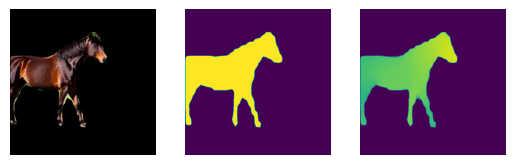

 39%|███████████████████████████▎                                          | 234/600 [00:01<00:02, 122.31it/s]

tensor(0.3288, device='cuda:0') tensor(0.5198, device='cuda:0')
tensor(0.3287, device='cuda:0') tensor(0.4812, device='cuda:0')
tensor(0.3275, device='cuda:0') tensor(0.4805, device='cuda:0')
tensor(0.3231, device='cuda:0') tensor(0.4805, device='cuda:0')
tensor(0.3147, device='cuda:0') tensor(0.4804, device='cuda:0')
tensor(0.2902, device='cuda:0') tensor(0.4803, device='cuda:0')
tensor(0.2449, device='cuda:0') tensor(0.4805, device='cuda:0')
tensor(0.2032, device='cuda:0') tensor(0.4807, device='cuda:0')
tensor(0.1653, device='cuda:0') tensor(0.4809, device='cuda:0')
tensor(0.1586, device='cuda:0') tensor(0.4810, device='cuda:0')
tensor(0.1585, device='cuda:0') tensor(0.4811, device='cuda:0')
tensor(0.1583, device='cuda:0') tensor(0.4811, device='cuda:0')
tensor(0.1583, device='cuda:0') tensor(0.4811, device='cuda:0')
tensor(0.1582, device='cuda:0') tensor(0.4812, device='cuda:0')
tensor(0.1581, device='cuda:0') tensor(0.4812, device='cuda:0')
tensor(0.1579, device='cuda:0') tensor(0

 43%|██████████████████████████████▎                                       | 260/600 [00:02<00:02, 120.56it/s]

tensor(0.1564, device='cuda:0') tensor(0.4817, device='cuda:0')
tensor(0.1563, device='cuda:0') tensor(0.4817, device='cuda:0')
tensor(0.1563, device='cuda:0') tensor(0.4818, device='cuda:0')
tensor(0.1563, device='cuda:0') tensor(0.4819, device='cuda:0')
tensor(0.1563, device='cuda:0') tensor(0.4821, device='cuda:0')
tensor(0.1563, device='cuda:0') tensor(0.4823, device='cuda:0')
tensor(0.1564, device='cuda:0') tensor(0.4830, device='cuda:0')
tensor(0.1566, device='cuda:0') tensor(0.4846, device='cuda:0')
tensor(0.1567, device='cuda:0') tensor(0.4883, device='cuda:0')
tensor(0.1569, device='cuda:0') tensor(0.5035, device='cuda:0')
tensor(0.1571, device='cuda:0') tensor(0.5424, device='cuda:0')
tensor(0.1571, device='cuda:0') tensor(0.5763, device='cuda:0')
tensor(0.1572, device='cuda:0') tensor(0.5963, device='cuda:0')
tensor(0.1574, device='cuda:0') tensor(0.6156, device='cuda:0')
tensor(0.1574, device='cuda:0') tensor(0.6172, device='cuda:0')
tensor(0.1573, device='cuda:0') tensor(0

 48%|█████████████████████████████████▎                                    | 286/600 [00:02<00:02, 119.79it/s]

tensor(0.1578, device='cuda:0') tensor(0.5615, device='cuda:0')
tensor(0.1579, device='cuda:0') tensor(0.5274, device='cuda:0')
tensor(0.1579, device='cuda:0') tensor(0.4999, device='cuda:0')
tensor(0.1580, device='cuda:0') tensor(0.4724, device='cuda:0')
tensor(0.1580, device='cuda:0') tensor(0.4480, device='cuda:0')
tensor(0.1579, device='cuda:0') tensor(0.4474, device='cuda:0')
tensor(0.1579, device='cuda:0') tensor(0.4474, device='cuda:0')
tensor(0.1580, device='cuda:0') tensor(0.4474, device='cuda:0')
tensor(0.1581, device='cuda:0') tensor(0.4473, device='cuda:0')
tensor(0.1581, device='cuda:0') tensor(0.4473, device='cuda:0')
tensor(0.1583, device='cuda:0') tensor(0.4474, device='cuda:0')
tensor(0.1582, device='cuda:0') tensor(0.4474, device='cuda:0')
tensor(0.1582, device='cuda:0') tensor(0.4473, device='cuda:0')
tensor(0.1582, device='cuda:0') tensor(0.4473, device='cuda:0')
tensor(0.1582, device='cuda:0') tensor(0.4474, device='cuda:0')
tensor(0.1582, device='cuda:0') tensor(0

 52%|████████████████████████████████████▏                                 | 310/600 [00:02<00:02, 119.17it/s]

tensor(0.1574, device='cuda:0') tensor(0.4489, device='cuda:0')
tensor(0.1572, device='cuda:0') tensor(0.4490, device='cuda:0')
tensor(0.1570, device='cuda:0') tensor(0.4491, device='cuda:0')
tensor(0.1570, device='cuda:0') tensor(0.4493, device='cuda:0')
tensor(0.1570, device='cuda:0') tensor(0.4494, device='cuda:0')
tensor(0.1569, device='cuda:0') tensor(0.4493, device='cuda:0')
tensor(0.1568, device='cuda:0') tensor(0.4493, device='cuda:0')
tensor(0.1568, device='cuda:0') tensor(0.4493, device='cuda:0')
tensor(0.1567, device='cuda:0') tensor(0.4493, device='cuda:0')
tensor(0.1565, device='cuda:0') tensor(0.4492, device='cuda:0')
tensor(0.1564, device='cuda:0') tensor(0.4491, device='cuda:0')
tensor(0.1563, device='cuda:0') tensor(0.4491, device='cuda:0')
tensor(0.1562, device='cuda:0') tensor(0.4492, device='cuda:0')
tensor(0.1559, device='cuda:0') tensor(0.4491, device='cuda:0')
tensor(0.1558, device='cuda:0') tensor(0.4491, device='cuda:0')
tensor(0.1556, device='cuda:0') tensor(0

 56%|██████████████████████████████████████▉                               | 334/600 [00:02<00:02, 118.84it/s]

tensor(0.1556, device='cuda:0') tensor(0.4465, device='cuda:0')
tensor(0.1556, device='cuda:0') tensor(0.4463, device='cuda:0')
tensor(0.1557, device='cuda:0') tensor(0.4462, device='cuda:0')
tensor(0.1558, device='cuda:0') tensor(0.4462, device='cuda:0')
tensor(0.1557, device='cuda:0') tensor(0.4460, device='cuda:0')
tensor(0.1558, device='cuda:0') tensor(0.4459, device='cuda:0')
tensor(0.1559, device='cuda:0') tensor(0.4457, device='cuda:0')
tensor(0.1560, device='cuda:0') tensor(0.4456, device='cuda:0')
tensor(0.1561, device='cuda:0') tensor(0.4455, device='cuda:0')
tensor(0.1561, device='cuda:0') tensor(0.4456, device='cuda:0')
tensor(0.1561, device='cuda:0') tensor(0.4455, device='cuda:0')
tensor(0.1561, device='cuda:0') tensor(0.4454, device='cuda:0')
tensor(0.1560, device='cuda:0') tensor(0.4454, device='cuda:0')
tensor(0.1559, device='cuda:0') tensor(0.4453, device='cuda:0')
tensor(0.1558, device='cuda:0') tensor(0.4453, device='cuda:0')
tensor(0.1556, device='cuda:0') tensor(0

 60%|█████████████████████████████████████████▉                            | 359/600 [00:02<00:02, 119.26it/s]

tensor(0.1543, device='cuda:0') tensor(0.6613, device='cuda:0')
tensor(0.1542, device='cuda:0') tensor(0.6789, device='cuda:0')
tensor(0.1539, device='cuda:0') tensor(0.6981, device='cuda:0')
tensor(0.1537, device='cuda:0') tensor(0.7091, device='cuda:0')
tensor(0.1535, device='cuda:0') tensor(0.7124, device='cuda:0')
tensor(0.1533, device='cuda:0') tensor(0.7141, device='cuda:0')
tensor(0.1532, device='cuda:0') tensor(0.7145, device='cuda:0')
tensor(0.1532, device='cuda:0') tensor(0.7145, device='cuda:0')
tensor(0.1532, device='cuda:0') tensor(0.7146, device='cuda:0')
tensor(0.1530, device='cuda:0') tensor(0.7147, device='cuda:0')
tensor(0.1529, device='cuda:0') tensor(0.7147, device='cuda:0')
tensor(0.1529, device='cuda:0') tensor(0.7132, device='cuda:0')
tensor(0.1528, device='cuda:0') tensor(0.6838, device='cuda:0')
tensor(0.1530, device='cuda:0') tensor(0.6447, device='cuda:0')
tensor(0.1530, device='cuda:0') tensor(0.6064, device='cuda:0')
tensor(0.1530, device='cuda:0') tensor(0

 64%|████████████████████████████████████████████▊                         | 384/600 [00:03<00:01, 120.44it/s]

tensor(0.1537, device='cuda:0') tensor(0.5775, device='cuda:0')
tensor(0.1537, device='cuda:0') tensor(0.5773, device='cuda:0')
tensor(0.1538, device='cuda:0') tensor(0.5774, device='cuda:0')
tensor(0.1537, device='cuda:0') tensor(0.5774, device='cuda:0')
tensor(0.1536, device='cuda:0') tensor(0.5775, device='cuda:0')
tensor(0.1536, device='cuda:0') tensor(0.5774, device='cuda:0')
tensor(0.1536, device='cuda:0') tensor(0.5775, device='cuda:0')
tensor(0.1533, device='cuda:0') tensor(0.5777, device='cuda:0')
tensor(0.1533, device='cuda:0') tensor(0.5777, device='cuda:0')
tensor(0.1533, device='cuda:0') tensor(0.5778, device='cuda:0')
tensor(0.1533, device='cuda:0') tensor(0.5778, device='cuda:0')
tensor(0.1532, device='cuda:0') tensor(0.5778, device='cuda:0')
tensor(0.1532, device='cuda:0') tensor(0.5778, device='cuda:0')
tensor(0.1534, device='cuda:0') tensor(0.5776, device='cuda:0')
tensor(0.1537, device='cuda:0') tensor(0.5773, device='cuda:0')
tensor(0.1567, device='cuda:0') tensor(0

100%|██████████████████████████████████████████████████████████████████████| 600/600 [00:05<00:00, 104.00it/s]


/grogu/user/akirchme/art3d_sd_webui/images/horse/1588.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/1588.mp4


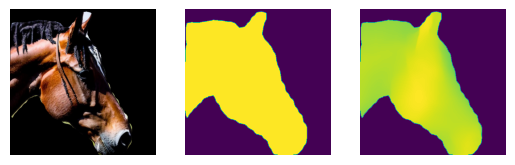

  4%|██▋                                                                    | 23/600 [00:00<00:05, 110.61it/s]

tensor(0.2534, device='cuda:0') tensor(0.4777, device='cuda:0')
tensor(0.2533, device='cuda:0') tensor(0.4777, device='cuda:0')
tensor(0.2533, device='cuda:0') tensor(0.4777, device='cuda:0')
tensor(0.2533, device='cuda:0') tensor(0.4778, device='cuda:0')
tensor(0.2531, device='cuda:0') tensor(0.4778, device='cuda:0')
tensor(0.2530, device='cuda:0') tensor(0.4778, device='cuda:0')
tensor(0.2529, device='cuda:0') tensor(0.4779, device='cuda:0')
tensor(0.2527, device='cuda:0') tensor(0.4779, device='cuda:0')
tensor(0.2526, device='cuda:0') tensor(0.4779, device='cuda:0')
tensor(0.2525, device='cuda:0') tensor(0.4780, device='cuda:0')
tensor(0.2524, device='cuda:0') tensor(0.4782, device='cuda:0')
tensor(0.2524, device='cuda:0') tensor(0.4783, device='cuda:0')
tensor(0.2523, device='cuda:0') tensor(0.4783, device='cuda:0')
tensor(0.2523, device='cuda:0') tensor(0.4784, device='cuda:0')
tensor(0.2523, device='cuda:0') tensor(0.4783, device='cuda:0')
tensor(0.2523, device='cuda:0') tensor(0

  8%|█████▌                                                                 | 47/600 [00:00<00:04, 116.03it/s]

tensor(0.2531, device='cuda:0') tensor(0.4780, device='cuda:0')
tensor(0.2530, device='cuda:0') tensor(0.4779, device='cuda:0')
tensor(0.2528, device='cuda:0') tensor(0.4777, device='cuda:0')
tensor(0.2526, device='cuda:0') tensor(0.4773, device='cuda:0')
tensor(0.2522, device='cuda:0') tensor(0.4773, device='cuda:0')
tensor(0.2518, device='cuda:0') tensor(0.4772, device='cuda:0')
tensor(0.2514, device='cuda:0') tensor(0.4771, device='cuda:0')
tensor(0.2510, device='cuda:0') tensor(0.4771, device='cuda:0')
tensor(0.2503, device='cuda:0') tensor(0.4771, device='cuda:0')
tensor(0.2497, device='cuda:0') tensor(0.4773, device='cuda:0')
tensor(0.2490, device='cuda:0') tensor(0.4968, device='cuda:0')
tensor(0.2484, device='cuda:0') tensor(0.5199, device='cuda:0')
tensor(0.2478, device='cuda:0') tensor(0.5380, device='cuda:0')
tensor(0.2472, device='cuda:0') tensor(0.5534, device='cuda:0')
tensor(0.2466, device='cuda:0') tensor(0.5708, device='cuda:0')
tensor(0.2459, device='cuda:0') tensor(0

 10%|██████▉                                                                | 59/600 [00:00<00:04, 116.94it/s]

tensor(0.2434, device='cuda:0') tensor(0.6119, device='cuda:0')
tensor(0.2432, device='cuda:0') tensor(0.5860, device='cuda:0')
tensor(0.2431, device='cuda:0') tensor(0.5618, device='cuda:0')
tensor(0.2429, device='cuda:0') tensor(0.5472, device='cuda:0')
tensor(0.2425, device='cuda:0') tensor(0.5353, device='cuda:0')
tensor(0.2422, device='cuda:0') tensor(0.5206, device='cuda:0')
tensor(0.2419, device='cuda:0') tensor(0.5137, device='cuda:0')
tensor(0.2417, device='cuda:0') tensor(0.5112, device='cuda:0')
tensor(0.2414, device='cuda:0') tensor(0.5100, device='cuda:0')
tensor(0.2412, device='cuda:0') tensor(0.5102, device='cuda:0')
tensor(0.2411, device='cuda:0') tensor(0.5105, device='cuda:0')
tensor(0.2411, device='cuda:0') tensor(0.5109, device='cuda:0')
tensor(0.2411, device='cuda:0') tensor(0.5114, device='cuda:0')
tensor(0.2412, device='cuda:0') tensor(0.5117, device='cuda:0')
tensor(0.2414, device='cuda:0') tensor(0.5121, device='cuda:0')
tensor(0.2416, device='cuda:0') tensor(0

 14%|█████████▊                                                             | 83/600 [00:00<00:04, 116.43it/s]

tensor(0.2432, device='cuda:0') tensor(0.5179, device='cuda:0')
tensor(0.2433, device='cuda:0') tensor(0.5184, device='cuda:0')
tensor(0.2433, device='cuda:0') tensor(0.5185, device='cuda:0')
tensor(0.2434, device='cuda:0') tensor(0.5182, device='cuda:0')
tensor(0.2434, device='cuda:0') tensor(0.5179, device='cuda:0')
tensor(0.2458, device='cuda:0') tensor(0.5174, device='cuda:0')
tensor(0.2805, device='cuda:0') tensor(0.5167, device='cuda:0')
tensor(0.3078, device='cuda:0') tensor(0.5162, device='cuda:0')
tensor(0.3307, device='cuda:0') tensor(0.5158, device='cuda:0')
tensor(0.3580, device='cuda:0') tensor(0.5155, device='cuda:0')
tensor(0.3742, device='cuda:0') tensor(0.5153, device='cuda:0')
tensor(0.3800, device='cuda:0') tensor(0.5150, device='cuda:0')
tensor(0.3810, device='cuda:0') tensor(0.5152, device='cuda:0')


 90%|███████████████████████████████████████████████████████████████▌       | 537/600 [00:07<00:00, 84.45it/s]

tensor(0.2998, device='cuda:0') tensor(0.5439, device='cuda:0')
tensor(0.2470, device='cuda:0') tensor(0.5440, device='cuda:0')
tensor(0.2419, device='cuda:0') tensor(0.5445, device='cuda:0')
tensor(0.2419, device='cuda:0') tensor(0.5447, device='cuda:0')
tensor(0.2420, device='cuda:0') tensor(0.5449, device='cuda:0')
tensor(0.2420, device='cuda:0') tensor(0.5455, device='cuda:0')
tensor(0.2419, device='cuda:0') tensor(0.5458, device='cuda:0')
tensor(0.2421, device='cuda:0') tensor(0.5462, device='cuda:0')
tensor(0.2422, device='cuda:0') tensor(0.5463, device='cuda:0')
tensor(0.2423, device='cuda:0') tensor(0.5463, device='cuda:0')
tensor(0.2425, device='cuda:0') tensor(0.5460, device='cuda:0')
tensor(0.2425, device='cuda:0') tensor(0.5457, device='cuda:0')
tensor(0.2425, device='cuda:0') tensor(0.5451, device='cuda:0')
tensor(0.2427, device='cuda:0') tensor(0.5442, device='cuda:0')
tensor(0.2428, device='cuda:0') tensor(0.5433, device='cuda:0')
tensor(0.2429, device='cuda:0') tensor(0

 94%|█████████████████████████████████████████████████████████████████▍    | 561/600 [00:07<00:00, 101.30it/s]

tensor(0.2446, device='cuda:0') tensor(0.5483, device='cuda:0')
tensor(0.2448, device='cuda:0') tensor(0.5550, device='cuda:0')
tensor(0.2450, device='cuda:0') tensor(0.5635, device='cuda:0')
tensor(0.2452, device='cuda:0') tensor(0.5708, device='cuda:0')
tensor(0.2454, device='cuda:0') tensor(0.5820, device='cuda:0')
tensor(0.2456, device='cuda:0') tensor(0.6007, device='cuda:0')
tensor(0.2459, device='cuda:0') tensor(0.6321, device='cuda:0')
tensor(0.2462, device='cuda:0') tensor(0.6336, device='cuda:0')
tensor(0.2465, device='cuda:0') tensor(0.6334, device='cuda:0')
tensor(0.2467, device='cuda:0') tensor(0.6336, device='cuda:0')
tensor(0.2469, device='cuda:0') tensor(0.6335, device='cuda:0')
tensor(0.2471, device='cuda:0') tensor(0.6333, device='cuda:0')
tensor(0.2473, device='cuda:0') tensor(0.6295, device='cuda:0')
tensor(0.2476, device='cuda:0') tensor(0.6205, device='cuda:0')
tensor(0.2478, device='cuda:0') tensor(0.6104, device='cuda:0')
tensor(0.2480, device='cuda:0') tensor(0

 98%|████████████████████████████████████████████████████████████████████▎ | 585/600 [00:07<00:00, 110.09it/s]

tensor(0.2501, device='cuda:0') tensor(0.4782, device='cuda:0')
tensor(0.2503, device='cuda:0') tensor(0.4782, device='cuda:0')
tensor(0.2506, device='cuda:0') tensor(0.4782, device='cuda:0')
tensor(0.2507, device='cuda:0') tensor(0.4782, device='cuda:0')
tensor(0.2509, device='cuda:0') tensor(0.4781, device='cuda:0')
tensor(0.2511, device='cuda:0') tensor(0.4780, device='cuda:0')
tensor(0.2513, device='cuda:0') tensor(0.4780, device='cuda:0')
tensor(0.2515, device='cuda:0') tensor(0.4780, device='cuda:0')
tensor(0.2517, device='cuda:0') tensor(0.4779, device='cuda:0')
tensor(0.2519, device='cuda:0') tensor(0.4779, device='cuda:0')
tensor(0.2520, device='cuda:0') tensor(0.4779, device='cuda:0')
tensor(0.2521, device='cuda:0') tensor(0.4779, device='cuda:0')
tensor(0.2522, device='cuda:0') tensor(0.4779, device='cuda:0')
tensor(0.2524, device='cuda:0') tensor(0.4778, device='cuda:0')
tensor(0.2525, device='cuda:0') tensor(0.4778, device='cuda:0')
tensor(0.2527, device='cuda:0') tensor(0

100%|███████████████████████████████████████████████████████████████████████| 600/600 [00:07<00:00, 77.91it/s]


tensor(0.2533, device='cuda:0') tensor(0.4778, device='cuda:0')
tensor(0.2533, device='cuda:0') tensor(0.4778, device='cuda:0')
tensor(0.2533, device='cuda:0') tensor(0.4777, device='cuda:0')
tensor(0.2534, device='cuda:0') tensor(0.4777, device='cuda:0')
tensor(0.2534, device='cuda:0') tensor(0.4777, device='cuda:0')
/grogu/user/akirchme/art3d_sd_webui/images/horse/28.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/28.mp4


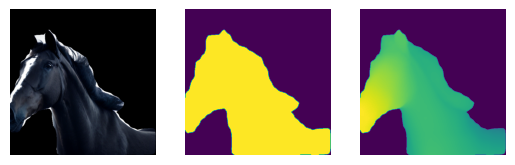

  4%|██▊                                                                    | 24/600 [00:00<00:04, 115.91it/s]

tensor(0.1965, device='cuda:0') tensor(0.4538, device='cuda:0')
tensor(0.1967, device='cuda:0') tensor(0.4538, device='cuda:0')
tensor(0.1967, device='cuda:0') tensor(0.4539, device='cuda:0')
tensor(0.1966, device='cuda:0') tensor(0.4539, device='cuda:0')
tensor(0.1964, device='cuda:0') tensor(0.4539, device='cuda:0')
tensor(0.1963, device='cuda:0') tensor(0.4539, device='cuda:0')
tensor(0.1960, device='cuda:0') tensor(0.4538, device='cuda:0')
tensor(0.1958, device='cuda:0') tensor(0.4538, device='cuda:0')
tensor(0.1953, device='cuda:0') tensor(0.4538, device='cuda:0')
tensor(0.1949, device='cuda:0') tensor(0.4537, device='cuda:0')
tensor(0.1943, device='cuda:0') tensor(0.4537, device='cuda:0')
tensor(0.1944, device='cuda:0') tensor(0.4537, device='cuda:0')
tensor(0.1945, device='cuda:0') tensor(0.4536, device='cuda:0')
tensor(0.1950, device='cuda:0') tensor(0.4535, device='cuda:0')
tensor(0.1957, device='cuda:0') tensor(0.4532, device='cuda:0')
tensor(0.1965, device='cuda:0') tensor(0

  8%|█████▊                                                                 | 49/600 [00:00<00:04, 118.71it/s]

tensor(0.1981, device='cuda:0') tensor(0.4527, device='cuda:0')
tensor(0.1975, device='cuda:0') tensor(0.4527, device='cuda:0')
tensor(0.1970, device='cuda:0') tensor(0.4526, device='cuda:0')
tensor(0.1964, device='cuda:0') tensor(0.4526, device='cuda:0')
tensor(0.1953, device='cuda:0') tensor(0.4527, device='cuda:0')
tensor(0.1943, device='cuda:0') tensor(0.4529, device='cuda:0')
tensor(0.1933, device='cuda:0') tensor(0.4529, device='cuda:0')
tensor(0.1923, device='cuda:0') tensor(0.4534, device='cuda:0')
tensor(0.1912, device='cuda:0') tensor(0.4628, device='cuda:0')
tensor(0.1902, device='cuda:0') tensor(0.4680, device='cuda:0')
tensor(0.1891, device='cuda:0') tensor(0.4718, device='cuda:0')
tensor(0.1879, device='cuda:0') tensor(0.4754, device='cuda:0')
tensor(0.1864, device='cuda:0') tensor(0.4783, device='cuda:0')
tensor(0.1846, device='cuda:0') tensor(0.4808, device='cuda:0')
tensor(0.1833, device='cuda:0') tensor(0.4842, device='cuda:0')
tensor(0.1818, device='cuda:0') tensor(0

 12%|████████▊                                                              | 74/600 [00:00<00:04, 119.48it/s]

tensor(0.1764, device='cuda:0') tensor(0.4811, device='cuda:0')
tensor(0.1757, device='cuda:0') tensor(0.4791, device='cuda:0')
tensor(0.1748, device='cuda:0') tensor(0.4775, device='cuda:0')
tensor(0.1733, device='cuda:0') tensor(0.4749, device='cuda:0')
tensor(0.1719, device='cuda:0') tensor(0.4719, device='cuda:0')
tensor(0.1712, device='cuda:0') tensor(0.4701, device='cuda:0')
tensor(0.1707, device='cuda:0') tensor(0.4699, device='cuda:0')
tensor(0.1703, device='cuda:0') tensor(0.4701, device='cuda:0')
tensor(0.1699, device='cuda:0') tensor(0.4703, device='cuda:0')
tensor(0.1698, device='cuda:0') tensor(0.4710, device='cuda:0')
tensor(0.1697, device='cuda:0') tensor(0.4718, device='cuda:0')
tensor(0.1696, device='cuda:0') tensor(0.4733, device='cuda:0')
tensor(0.1701, device='cuda:0') tensor(0.4757, device='cuda:0')
tensor(0.1701, device='cuda:0') tensor(0.4787, device='cuda:0')
tensor(0.1702, device='cuda:0') tensor(0.4811, device='cuda:0')
tensor(0.1702, device='cuda:0') tensor(0

 16%|███████████▋                                                           | 99/600 [00:00<00:04, 119.84it/s]

tensor(0.1714, device='cuda:0') tensor(0.4766, device='cuda:0')
tensor(0.1747, device='cuda:0') tensor(0.4746, device='cuda:0')
tensor(0.1853, device='cuda:0') tensor(0.4734, device='cuda:0')
tensor(0.1910, device='cuda:0') tensor(0.4727, device='cuda:0')
tensor(0.1960, device='cuda:0') tensor(0.4720, device='cuda:0')
tensor(0.1998, device='cuda:0') tensor(0.4716, device='cuda:0')
tensor(0.2046, device='cuda:0') tensor(0.4713, device='cuda:0')
tensor(0.2097, device='cuda:0') tensor(0.4711, device='cuda:0')
tensor(0.2120, device='cuda:0') tensor(0.4716, device='cuda:0')
tensor(0.2130, device='cuda:0') tensor(0.4903, device='cuda:0')
tensor(0.2137, device='cuda:0') tensor(0.5121, device='cuda:0')
tensor(0.2143, device='cuda:0') tensor(0.5489, device='cuda:0')
tensor(0.2149, device='cuda:0') tensor(0.5790, device='cuda:0')
tensor(0.2155, device='cuda:0') tensor(0.6032, device='cuda:0')
tensor(0.2165, device='cuda:0') tensor(0.6363, device='cuda:0')
tensor(0.2174, device='cuda:0') tensor(0

 21%|██████████████▍                                                       | 124/600 [00:01<00:03, 120.95it/s]

tensor(0.2332, device='cuda:0') tensor(0.8036, device='cuda:0')
tensor(0.2391, device='cuda:0') tensor(0.7900, device='cuda:0')
tensor(0.2439, device='cuda:0') tensor(0.7657, device='cuda:0')
tensor(0.2469, device='cuda:0') tensor(0.7455, device='cuda:0')
tensor(0.2484, device='cuda:0') tensor(0.7221, device='cuda:0')
tensor(0.2495, device='cuda:0') tensor(0.7029, device='cuda:0')
tensor(0.2507, device='cuda:0') tensor(0.6841, device='cuda:0')
tensor(0.2518, device='cuda:0') tensor(0.6658, device='cuda:0')
tensor(0.2531, device='cuda:0') tensor(0.6477, device='cuda:0')
tensor(0.2541, device='cuda:0') tensor(0.6365, device='cuda:0')
tensor(0.2551, device='cuda:0') tensor(0.6307, device='cuda:0')
tensor(0.2557, device='cuda:0') tensor(0.6266, device='cuda:0')
tensor(0.2564, device='cuda:0') tensor(0.6217, device='cuda:0')
tensor(0.2571, device='cuda:0') tensor(0.6203, device='cuda:0')
tensor(0.2577, device='cuda:0') tensor(0.6165, device='cuda:0')
tensor(0.2582, device='cuda:0') tensor(0

 23%|███████████████▉                                                      | 137/600 [00:01<00:03, 120.40it/s]

tensor(0.2598, device='cuda:0') tensor(0.6136, device='cuda:0')
tensor(0.2599, device='cuda:0') tensor(0.6136, device='cuda:0')
tensor(0.2600, device='cuda:0') tensor(0.6137, device='cuda:0')
tensor(0.2601, device='cuda:0') tensor(0.6137, device='cuda:0')
tensor(0.2601, device='cuda:0') tensor(0.6137, device='cuda:0')
tensor(0.2603, device='cuda:0') tensor(0.6138, device='cuda:0')
tensor(0.2603, device='cuda:0') tensor(0.6139, device='cuda:0')
tensor(0.2604, device='cuda:0') tensor(0.6139, device='cuda:0')
tensor(0.2605, device='cuda:0') tensor(0.6140, device='cuda:0')
tensor(0.2610, device='cuda:0') tensor(0.6141, device='cuda:0')
tensor(0.2861, device='cuda:0') tensor(0.6142, device='cuda:0')


 89%|███████████████████████████████████████████████████████████████▍       | 536/600 [00:07<00:00, 73.30it/s]

tensor(0.2828, device='cuda:0') tensor(0.6127, device='cuda:0')
tensor(0.2143, device='cuda:0') tensor(0.6137, device='cuda:0')
tensor(0.1790, device='cuda:0') tensor(0.6150, device='cuda:0')
tensor(0.1758, device='cuda:0') tensor(0.6167, device='cuda:0')
tensor(0.1759, device='cuda:0') tensor(0.6187, device='cuda:0')
tensor(0.1760, device='cuda:0') tensor(0.6207, device='cuda:0')
tensor(0.1760, device='cuda:0') tensor(0.6223, device='cuda:0')
tensor(0.1759, device='cuda:0') tensor(0.6235, device='cuda:0')
tensor(0.1759, device='cuda:0') tensor(0.6243, device='cuda:0')
tensor(0.1758, device='cuda:0') tensor(0.6247, device='cuda:0')
tensor(0.1758, device='cuda:0') tensor(0.6248, device='cuda:0')
tensor(0.1758, device='cuda:0') tensor(0.6251, device='cuda:0')
tensor(0.1758, device='cuda:0') tensor(0.6248, device='cuda:0')
tensor(0.1758, device='cuda:0') tensor(0.6240, device='cuda:0')
tensor(0.1759, device='cuda:0') tensor(0.6230, device='cuda:0')
tensor(0.1760, device='cuda:0') tensor(0

 94%|██████████████████████████████████████████████████████████████████▌    | 562/600 [00:07<00:00, 97.98it/s]

tensor(0.6418, device='cuda:0')
tensor(0.1780, device='cuda:0') tensor(0.6604, device='cuda:0')
tensor(0.1782, device='cuda:0') tensor(0.6869, device='cuda:0')
tensor(0.1783, device='cuda:0') tensor(0.7246, device='cuda:0')
tensor(0.1787, device='cuda:0') tensor(0.7633, device='cuda:0')
tensor(0.1791, device='cuda:0') tensor(0.7843, device='cuda:0')
tensor(0.1795, device='cuda:0') tensor(0.7980, device='cuda:0')
tensor(0.1799, device='cuda:0') tensor(0.7965, device='cuda:0')
tensor(0.1802, device='cuda:0') tensor(0.7963, device='cuda:0')
tensor(0.1804, device='cuda:0') tensor(0.7961, device='cuda:0')
tensor(0.1807, device='cuda:0') tensor(0.7964, device='cuda:0')
tensor(0.1810, device='cuda:0') tensor(0.7961, device='cuda:0')
tensor(0.1814, device='cuda:0') tensor(0.7876, device='cuda:0')
tensor(0.1819, device='cuda:0') tensor(0.7683, device='cuda:0')
tensor(0.1824, device='cuda:0') tensor(0.7412, device='cuda:0')
tensor(0.1831, device='cuda:0') tensor(0.7054, device='cuda:0')
tensor(0

 98%|████████████████████████████████████████████████████████████████████▌ | 588/600 [00:07<00:00, 110.35it/s]

tensor(0.1876, device='cuda:0') tensor(0.4545, device='cuda:0')
tensor(0.1878, device='cuda:0') tensor(0.4545, device='cuda:0')
tensor(0.1881, device='cuda:0') tensor(0.4545, device='cuda:0')
tensor(0.1884, device='cuda:0') tensor(0.4545, device='cuda:0')
tensor(0.1887, device='cuda:0') tensor(0.4546, device='cuda:0')
tensor(0.1890, device='cuda:0') tensor(0.4546, device='cuda:0')
tensor(0.1893, device='cuda:0') tensor(0.4546, device='cuda:0')
tensor(0.1895, device='cuda:0') tensor(0.4546, device='cuda:0')
tensor(0.1897, device='cuda:0') tensor(0.4546, device='cuda:0')
tensor(0.1899, device='cuda:0') tensor(0.4546, device='cuda:0')
tensor(0.1901, device='cuda:0') tensor(0.4545, device='cuda:0')
tensor(0.1902, device='cuda:0') tensor(0.4545, device='cuda:0')
tensor(0.1903, device='cuda:0') tensor(0.4544, device='cuda:0')
tensor(0.1902, device='cuda:0') tensor(0.4544, device='cuda:0')
tensor(0.1902, device='cuda:0') tensor(0.4543, device='cuda:0')
tensor(0.1902, device='cuda:0') tensor(0

100%|███████████████████████████████████████████████████████████████████████| 600/600 [00:07<00:00, 77.68it/s]


tensor(0.1941, device='cuda:0') tensor(0.4538, device='cuda:0')
tensor(0.1951, device='cuda:0') tensor(0.4538, device='cuda:0')
tensor(0.1960, device='cuda:0') tensor(0.4538, device='cuda:0')
/grogu/user/akirchme/art3d_sd_webui/images/horse/1138.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/1138.mp4


  3%|██▎                                                                     | 19/600 [00:00<00:06, 92.11it/s]

tensor(0.4206, device='cuda:0') tensor(0.5089, device='cuda:0')
tensor(0.4212, device='cuda:0') tensor(0.5088, device='cuda:0')
tensor(0.4215, device='cuda:0') tensor(0.5088, device='cuda:0')
tensor(0.4216, device='cuda:0') tensor(0.5088, device='cuda:0')
tensor(0.4218, device='cuda:0') tensor(0.5088, device='cuda:0')
tensor(0.4220, device='cuda:0') tensor(0.5088, device='cuda:0')
tensor(0.4221, device='cuda:0') tensor(0.5088, device='cuda:0')
tensor(0.4222, device='cuda:0') tensor(0.5088, device='cuda:0')
tensor(0.4223, device='cuda:0') tensor(0.5088, device='cuda:0')
tensor(0.4224, device='cuda:0') tensor(0.5088, device='cuda:0')
tensor(0.4228, device='cuda:0') tensor(0.5087, device='cuda:0')
tensor(0.4234, device='cuda:0') tensor(0.5088, device='cuda:0')
tensor(0.4240, device='cuda:0') tensor(0.5088, device='cuda:0')
tensor(0.4248, device='cuda:0') tensor(0.5087, device='cuda:0')
tensor(0.4258, device='cuda:0') tensor(0.5088, device='cuda:0')
tensor(0.4267, device='cuda:0') tensor(0

  5%|███▋                                                                   | 31/600 [00:00<00:05, 104.42it/s]

tensor(0.4287, device='cuda:0') tensor(0.5090, device='cuda:0')
tensor(0.4288, device='cuda:0') tensor(0.5091, device='cuda:0')
tensor(0.4289, device='cuda:0') tensor(0.5091, device='cuda:0')
tensor(0.4289, device='cuda:0') tensor(0.5091, device='cuda:0')
tensor(0.4289, device='cuda:0') tensor(0.5091, device='cuda:0')
tensor(0.4287, device='cuda:0') tensor(0.5091, device='cuda:0')
tensor(0.4286, device='cuda:0') tensor(0.5092, device='cuda:0')
tensor(0.4283, device='cuda:0') tensor(0.5093, device='cuda:0')
tensor(0.4279, device='cuda:0') tensor(0.5094, device='cuda:0')
tensor(0.4275, device='cuda:0') tensor(0.5095, device='cuda:0')
tensor(0.4269, device='cuda:0') tensor(0.5095, device='cuda:0')
tensor(0.4262, device='cuda:0') tensor(0.5096, device='cuda:0')
tensor(0.4254, device='cuda:0') tensor(0.5098, device='cuda:0')
tensor(0.4248, device='cuda:0') tensor(0.5160, device='cuda:0')


 39%|███████████████████████████▊                                           | 235/600 [00:03<00:04, 75.93it/s]

tensor(0.2783, device='cuda:0') tensor(0.5250, device='cuda:0')
tensor(0.2569, device='cuda:0') tensor(0.5254, device='cuda:0')
tensor(0.2351, device='cuda:0') tensor(0.5257, device='cuda:0')
tensor(0.2156, device='cuda:0') tensor(0.5262, device='cuda:0')
tensor(0.1953, device='cuda:0') tensor(0.5268, device='cuda:0')
tensor(0.1797, device='cuda:0') tensor(0.5274, device='cuda:0')
tensor(0.1780, device='cuda:0') tensor(0.5282, device='cuda:0')
tensor(0.1779, device='cuda:0') tensor(0.5292, device='cuda:0')
tensor(0.1778, device='cuda:0') tensor(0.5300, device='cuda:0')
tensor(0.1777, device='cuda:0') tensor(0.5306, device='cuda:0')
tensor(0.1776, device='cuda:0') tensor(0.5308, device='cuda:0')
tensor(0.1776, device='cuda:0') tensor(0.5312, device='cuda:0')
tensor(0.1776, device='cuda:0') tensor(0.5313, device='cuda:0')
tensor(0.1775, device='cuda:0') tensor(0.5315, device='cuda:0')
tensor(0.1775, device='cuda:0') tensor(0.5315, device='cuda:0')
tensor(0.1776, device='cuda:0') tensor(0

 44%|██████████████████████████████▉                                        | 261/600 [00:04<00:03, 99.52it/s]

tensor(0.1795, device='cuda:0') tensor(0.5334, device='cuda:0')
tensor(0.1800, device='cuda:0') tensor(0.5356, device='cuda:0')
tensor(0.1807, device='cuda:0') tensor(0.5408, device='cuda:0')
tensor(0.1815, device='cuda:0') tensor(0.5550, device='cuda:0')
tensor(0.1821, device='cuda:0') tensor(0.5727, device='cuda:0')
tensor(0.1826, device='cuda:0') tensor(0.5845, device='cuda:0')
tensor(0.1833, device='cuda:0') tensor(0.5967, device='cuda:0')
tensor(0.1837, device='cuda:0') tensor(0.6089, device='cuda:0')
tensor(0.1841, device='cuda:0') tensor(0.6212, device='cuda:0')
tensor(0.1844, device='cuda:0') tensor(0.6311, device='cuda:0')
tensor(0.1848, device='cuda:0') tensor(0.6389, device='cuda:0')
tensor(0.1851, device='cuda:0') tensor(0.6390, device='cuda:0')
tensor(0.1855, device='cuda:0') tensor(0.6376, device='cuda:0')
tensor(0.1861, device='cuda:0') tensor(0.6365, device='cuda:0')
tensor(0.1864, device='cuda:0') tensor(0.6356, device='cuda:0')
tensor(0.1868, device='cuda:0') tensor(0

 48%|█████████████████████████████████▎                                    | 285/600 [00:04<00:02, 109.27it/s]

tensor(0.1918, device='cuda:0') tensor(0.4951, device='cuda:0')
tensor(0.1923, device='cuda:0') tensor(0.4948, device='cuda:0')
tensor(0.1928, device='cuda:0') tensor(0.4945, device='cuda:0')
tensor(0.1933, device='cuda:0') tensor(0.4944, device='cuda:0')
tensor(0.1937, device='cuda:0') tensor(0.4944, device='cuda:0')
tensor(0.1939, device='cuda:0') tensor(0.4943, device='cuda:0')
tensor(0.1941, device='cuda:0') tensor(0.4942, device='cuda:0')
tensor(0.1942, device='cuda:0') tensor(0.4940, device='cuda:0')
tensor(0.1944, device='cuda:0') tensor(0.4940, device='cuda:0')
tensor(0.1945, device='cuda:0') tensor(0.4939, device='cuda:0')
tensor(0.1945, device='cuda:0') tensor(0.4938, device='cuda:0')
tensor(0.1947, device='cuda:0') tensor(0.4938, device='cuda:0')
tensor(0.1949, device='cuda:0') tensor(0.4937, device='cuda:0')
tensor(0.1950, device='cuda:0') tensor(0.4936, device='cuda:0')
tensor(0.1951, device='cuda:0') tensor(0.4935, device='cuda:0')
tensor(0.1952, device='cuda:0') tensor(0

 52%|████████████████████████████████████                                  | 309/600 [00:04<00:02, 113.76it/s]

tensor(0.1967, device='cuda:0') tensor(0.4933, device='cuda:0')
tensor(0.1969, device='cuda:0') tensor(0.4934, device='cuda:0')
tensor(0.1972, device='cuda:0') tensor(0.4934, device='cuda:0')
tensor(0.1973, device='cuda:0') tensor(0.4934, device='cuda:0')
tensor(0.1975, device='cuda:0') tensor(0.4933, device='cuda:0')
tensor(0.1978, device='cuda:0') tensor(0.4933, device='cuda:0')
tensor(0.1984, device='cuda:0') tensor(0.4933, device='cuda:0')
tensor(0.1990, device='cuda:0') tensor(0.4934, device='cuda:0')
tensor(0.1995, device='cuda:0') tensor(0.4934, device='cuda:0')
tensor(0.2001, device='cuda:0') tensor(0.4934, device='cuda:0')
tensor(0.2008, device='cuda:0') tensor(0.4934, device='cuda:0')
tensor(0.2012, device='cuda:0') tensor(0.4934, device='cuda:0')
tensor(0.2016, device='cuda:0') tensor(0.4933, device='cuda:0')
tensor(0.2020, device='cuda:0') tensor(0.4934, device='cuda:0')
tensor(0.2023, device='cuda:0') tensor(0.4934, device='cuda:0')
tensor(0.2028, device='cuda:0') tensor(0

 56%|██████████████████████████████████████▊                               | 333/600 [00:04<00:02, 114.57it/s]

tensor(0.2119, device='cuda:0') tensor(0.4922, device='cuda:0')
tensor(0.2128, device='cuda:0') tensor(0.4923, device='cuda:0')
tensor(0.2135, device='cuda:0') tensor(0.4923, device='cuda:0')
tensor(0.2142, device='cuda:0') tensor(0.4924, device='cuda:0')
tensor(0.2148, device='cuda:0') tensor(0.4924, device='cuda:0')
tensor(0.2152, device='cuda:0') tensor(0.4923, device='cuda:0')
tensor(0.2154, device='cuda:0') tensor(0.4924, device='cuda:0')
tensor(0.2153, device='cuda:0') tensor(0.4924, device='cuda:0')
tensor(0.2152, device='cuda:0') tensor(0.4921, device='cuda:0')
tensor(0.2148, device='cuda:0') tensor(0.4919, device='cuda:0')
tensor(0.2142, device='cuda:0') tensor(0.4920, device='cuda:0')
tensor(0.2134, device='cuda:0') tensor(0.4920, device='cuda:0')
tensor(0.2126, device='cuda:0') tensor(0.4920, device='cuda:0')
tensor(0.2116, device='cuda:0') tensor(0.4921, device='cuda:0')
tensor(0.2105, device='cuda:0') tensor(0.4923, device='cuda:0')
tensor(0.2093, device='cuda:0') tensor(0

 60%|█████████████████████████████████████████▋                            | 357/600 [00:04<00:02, 115.53it/s]

tensor(0.1942, device='cuda:0') tensor(0.6684, device='cuda:0')
tensor(0.1924, device='cuda:0') tensor(0.6691, device='cuda:0')
tensor(0.1907, device='cuda:0') tensor(0.6694, device='cuda:0')
tensor(0.1883, device='cuda:0') tensor(0.6696, device='cuda:0')
tensor(0.1870, device='cuda:0') tensor(0.6699, device='cuda:0')
tensor(0.1856, device='cuda:0') tensor(0.6700, device='cuda:0')
tensor(0.1842, device='cuda:0') tensor(0.6701, device='cuda:0')
tensor(0.1833, device='cuda:0') tensor(0.6641, device='cuda:0')
tensor(0.1824, device='cuda:0') tensor(0.6529, device='cuda:0')
tensor(0.1814, device='cuda:0') tensor(0.6370, device='cuda:0')
tensor(0.1804, device='cuda:0') tensor(0.6147, device='cuda:0')
tensor(0.1796, device='cuda:0') tensor(0.5916, device='cuda:0')
tensor(0.1789, device='cuda:0') tensor(0.5614, device='cuda:0')
tensor(0.1786, device='cuda:0') tensor(0.5373, device='cuda:0')
tensor(0.1785, device='cuda:0') tensor(0.5332, device='cuda:0')
tensor(0.1781, device='cuda:0') tensor(0

 64%|████████████████████████████████████████████▍                         | 381/600 [00:05<00:01, 114.79it/s]

tensor(0.1778, device='cuda:0') tensor(0.5409, device='cuda:0')
tensor(0.1778, device='cuda:0') tensor(0.5417, device='cuda:0')
tensor(0.1780, device='cuda:0') tensor(0.5425, device='cuda:0')
tensor(0.1783, device='cuda:0') tensor(0.5432, device='cuda:0')
tensor(0.1785, device='cuda:0') tensor(0.5435, device='cuda:0')
tensor(0.1786, device='cuda:0') tensor(0.5436, device='cuda:0')
tensor(0.1787, device='cuda:0') tensor(0.5437, device='cuda:0')
tensor(0.1789, device='cuda:0') tensor(0.5435, device='cuda:0')
tensor(0.1790, device='cuda:0') tensor(0.5430, device='cuda:0')
tensor(0.1791, device='cuda:0') tensor(0.5421, device='cuda:0')
tensor(0.1792, device='cuda:0') tensor(0.5408, device='cuda:0')
tensor(0.1798, device='cuda:0') tensor(0.5398, device='cuda:0')
tensor(0.1981, device='cuda:0') tensor(0.5389, device='cuda:0')
tensor(0.2248, device='cuda:0') tensor(0.5382, device='cuda:0')
tensor(0.2610, device='cuda:0') tensor(0.5373, device='cuda:0')
tensor(0.2931, device='cuda:0') tensor(0

 98%|█████████████████████████████████████████████████████████████████████▊ | 590/600 [00:08<00:00, 85.37it/s]

tensor(0.4100, device='cuda:0') tensor(0.5133, device='cuda:0')
tensor(0.4104, device='cuda:0') tensor(0.5086, device='cuda:0')
tensor(0.4107, device='cuda:0') tensor(0.5086, device='cuda:0')
tensor(0.4111, device='cuda:0') tensor(0.5086, device='cuda:0')
tensor(0.4115, device='cuda:0') tensor(0.5086, device='cuda:0')
tensor(0.4119, device='cuda:0') tensor(0.5087, device='cuda:0')
tensor(0.4123, device='cuda:0') tensor(0.5088, device='cuda:0')
tensor(0.4127, device='cuda:0') tensor(0.5088, device='cuda:0')
tensor(0.4130, device='cuda:0') tensor(0.5089, device='cuda:0')
tensor(0.4132, device='cuda:0') tensor(0.5089, device='cuda:0')
tensor(0.4135, device='cuda:0') tensor(0.5090, device='cuda:0')
tensor(0.4136, device='cuda:0') tensor(0.5090, device='cuda:0')
tensor(0.4137, device='cuda:0') tensor(0.5089, device='cuda:0')
tensor(0.4140, device='cuda:0') tensor(0.5090, device='cuda:0')
tensor(0.4141, device='cuda:0') tensor(0.5090, device='cuda:0')
tensor(0.4142, device='cuda:0') tensor(0

100%|███████████████████████████████████████████████████████████████████████| 600/600 [00:08<00:00, 67.09it/s]


tensor(0.4159, device='cuda:0') tensor(0.5090, device='cuda:0')
tensor(0.4162, device='cuda:0') tensor(0.5090, device='cuda:0')
tensor(0.4166, device='cuda:0') tensor(0.5090, device='cuda:0')
tensor(0.4170, device='cuda:0') tensor(0.5090, device='cuda:0')
tensor(0.4175, device='cuda:0') tensor(0.5090, device='cuda:0')
tensor(0.4183, device='cuda:0') tensor(0.5089, device='cuda:0')
tensor(0.4190, device='cuda:0') tensor(0.5088, device='cuda:0')
tensor(0.4197, device='cuda:0') tensor(0.5089, device='cuda:0')
/grogu/user/akirchme/art3d_sd_webui/images/horse/1559.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/1559.mp4


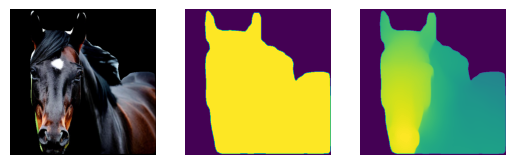

  3%|██▍                                                                     | 20/600 [00:00<00:05, 98.15it/s]

tensor(0.2521, device='cuda:0') tensor(0.5217, device='cuda:0')
tensor(0.2518, device='cuda:0') tensor(0.5217, device='cuda:0')
tensor(0.2513, device='cuda:0') tensor(0.5218, device='cuda:0')
tensor(0.2509, device='cuda:0') tensor(0.5218, device='cuda:0')
tensor(0.2503, device='cuda:0') tensor(0.5218, device='cuda:0')
tensor(0.2495, device='cuda:0') tensor(0.5219, device='cuda:0')
tensor(0.2487, device='cuda:0') tensor(0.5218, device='cuda:0')
tensor(0.2479, device='cuda:0') tensor(0.5219, device='cuda:0')
tensor(0.2472, device='cuda:0') tensor(0.5221, device='cuda:0')
tensor(0.2464, device='cuda:0') tensor(0.5221, device='cuda:0')
tensor(0.2458, device='cuda:0') tensor(0.5221, device='cuda:0')
tensor(0.2451, device='cuda:0') tensor(0.5222, device='cuda:0')
tensor(0.2447, device='cuda:0') tensor(0.5223, device='cuda:0')
tensor(0.2443, device='cuda:0') tensor(0.5223, device='cuda:0')
tensor(0.2439, device='cuda:0') tensor(0.5223, device='cuda:0')
tensor(0.2435, device='cuda:0') tensor(0

  7%|█████▏                                                                 | 44/600 [00:00<00:05, 108.99it/s]

tensor(0.2416, device='cuda:0') tensor(0.5228, device='cuda:0')
tensor(0.2411, device='cuda:0') tensor(0.5229, device='cuda:0')
tensor(0.2407, device='cuda:0') tensor(0.5231, device='cuda:0')
tensor(0.2401, device='cuda:0') tensor(0.5232, device='cuda:0')
tensor(0.2394, device='cuda:0') tensor(0.5233, device='cuda:0')
tensor(0.2386, device='cuda:0') tensor(0.5234, device='cuda:0')
tensor(0.2377, device='cuda:0') tensor(0.5236, device='cuda:0')
tensor(0.2366, device='cuda:0') tensor(0.5237, device='cuda:0')
tensor(0.2352, device='cuda:0') tensor(0.5239, device='cuda:0')
tensor(0.2340, device='cuda:0') tensor(0.5239, device='cuda:0')
tensor(0.2327, device='cuda:0') tensor(0.5240, device='cuda:0')
tensor(0.2314, device='cuda:0') tensor(0.5241, device='cuda:0')
tensor(0.2299, device='cuda:0') tensor(0.5253, device='cuda:0')
tensor(0.2287, device='cuda:0') tensor(0.5269, device='cuda:0')
tensor(0.2274, device='cuda:0') tensor(0.5294, device='cuda:0')
tensor(0.2260, device='cuda:0') tensor(0

  9%|██████▌                                                                | 55/600 [00:00<00:04, 109.12it/s]

tensor(0.2158, device='cuda:0') tensor(0.5745, device='cuda:0')
tensor(0.2147, device='cuda:0') tensor(0.5752, device='cuda:0')
tensor(0.2139, device='cuda:0') tensor(0.5762, device='cuda:0')
tensor(0.2133, device='cuda:0') tensor(0.5769, device='cuda:0')
tensor(0.2125, device='cuda:0') tensor(0.5763, device='cuda:0')
tensor(0.2117, device='cuda:0') tensor(0.5751, device='cuda:0')
tensor(0.2110, device='cuda:0') tensor(0.5711, device='cuda:0')
tensor(0.2101, device='cuda:0') tensor(0.5651, device='cuda:0')
tensor(0.2093, device='cuda:0') tensor(0.5560, device='cuda:0')
tensor(0.2085, device='cuda:0') tensor(0.5426, device='cuda:0')
tensor(0.2079, device='cuda:0') tensor(0.5322, device='cuda:0')
tensor(0.2071, device='cuda:0') tensor(0.5257, device='cuda:0')
tensor(0.2066, device='cuda:0') tensor(0.5254, device='cuda:0')
tensor(0.2060, device='cuda:0') tensor(0.5259, device='cuda:0')
tensor(0.2053, device='cuda:0') tensor(0.5261, device='cuda:0')
tensor(0.2048, device='cuda:0') tensor(0

 13%|█████████▎                                                             | 79/600 [00:00<00:04, 110.62it/s]

tensor(0.2037, device='cuda:0') tensor(0.5278, device='cuda:0')
tensor(0.2039, device='cuda:0') tensor(0.5284, device='cuda:0')
tensor(0.2039, device='cuda:0') tensor(0.5286, device='cuda:0')
tensor(0.2039, device='cuda:0') tensor(0.5287, device='cuda:0')
tensor(0.2041, device='cuda:0') tensor(0.5289, device='cuda:0')
tensor(0.2043, device='cuda:0') tensor(0.5289, device='cuda:0')
tensor(0.2045, device='cuda:0') tensor(0.5288, device='cuda:0')
tensor(0.2048, device='cuda:0') tensor(0.5285, device='cuda:0')
tensor(0.2049, device='cuda:0') tensor(0.5278, device='cuda:0')
tensor(0.2052, device='cuda:0') tensor(0.5266, device='cuda:0')
tensor(0.2074, device='cuda:0') tensor(0.5253, device='cuda:0')
tensor(0.2109, device='cuda:0') tensor(0.5248, device='cuda:0')
tensor(0.2189, device='cuda:0') tensor(0.5240, device='cuda:0')
tensor(0.2285, device='cuda:0') tensor(0.5231, device='cuda:0')
tensor(0.2399, device='cuda:0') tensor(0.5221, device='cuda:0')
tensor(0.2491, device='cuda:0') tensor(0

 17%|████████████                                                          | 103/600 [00:00<00:04, 114.52it/s]

tensor(0.2648, device='cuda:0') tensor(0.6495, device='cuda:0')
tensor(0.2662, device='cuda:0') tensor(0.6696, device='cuda:0')
tensor(0.2678, device='cuda:0') tensor(0.6827, device='cuda:0')
tensor(0.2693, device='cuda:0') tensor(0.6921, device='cuda:0')
tensor(0.2713, device='cuda:0') tensor(0.6960, device='cuda:0')
tensor(0.2733, device='cuda:0') tensor(0.6979, device='cuda:0')
tensor(0.2752, device='cuda:0') tensor(0.6995, device='cuda:0')
tensor(0.2775, device='cuda:0') tensor(0.6989, device='cuda:0')
tensor(0.2799, device='cuda:0') tensor(0.6985, device='cuda:0')
tensor(0.2828, device='cuda:0') tensor(0.6967, device='cuda:0')
tensor(0.2860, device='cuda:0') tensor(0.6863, device='cuda:0')
tensor(0.2891, device='cuda:0') tensor(0.6634, device='cuda:0')
tensor(0.2921, device='cuda:0') tensor(0.6427, device='cuda:0')
tensor(0.2946, device='cuda:0') tensor(0.6229, device='cuda:0')
tensor(0.2967, device='cuda:0') tensor(0.6011, device='cuda:0')
tensor(0.2989, device='cuda:0') tensor(0

 38%|██████████████████████████▊                                            | 227/600 [00:03<00:04, 78.71it/s]

tensor(0.4073, device='cuda:0') tensor(0.5193, device='cuda:0')
tensor(0.4058, device='cuda:0') tensor(0.5154, device='cuda:0')
tensor(0.4033, device='cuda:0') tensor(0.5126, device='cuda:0')
tensor(0.4006, device='cuda:0') tensor(0.5105, device='cuda:0')
tensor(0.3980, device='cuda:0') tensor(0.5054, device='cuda:0')
tensor(0.3961, device='cuda:0') tensor(0.4981, device='cuda:0')
tensor(0.3948, device='cuda:0') tensor(0.4962, device='cuda:0')
tensor(0.3927, device='cuda:0') tensor(0.4963, device='cuda:0')
tensor(0.3890, device='cuda:0') tensor(0.4964, device='cuda:0')
tensor(0.3862, device='cuda:0') tensor(0.4966, device='cuda:0')
tensor(0.3842, device='cuda:0') tensor(0.4967, device='cuda:0')
tensor(0.3820, device='cuda:0') tensor(0.4971, device='cuda:0')
tensor(0.3801, device='cuda:0') tensor(0.4973, device='cuda:0')
tensor(0.3784, device='cuda:0') tensor(0.4975, device='cuda:0')
tensor(0.3779, device='cuda:0') tensor(0.4976, device='cuda:0')
tensor(0.3774, device='cuda:0') tensor(0

 42%|█████████████████████████████▊                                         | 252/600 [00:03<00:03, 98.51it/s]

tensor(0.3749, device='cuda:0') tensor(0.4941, device='cuda:0')
tensor(0.3745, device='cuda:0') tensor(0.4940, device='cuda:0')
tensor(0.3745, device='cuda:0') tensor(0.4942, device='cuda:0')
tensor(0.3751, device='cuda:0') tensor(0.4947, device='cuda:0')
tensor(0.3754, device='cuda:0') tensor(0.4952, device='cuda:0')
tensor(0.3754, device='cuda:0') tensor(0.4972, device='cuda:0')
tensor(0.3757, device='cuda:0') tensor(0.4976, device='cuda:0')
tensor(0.3762, device='cuda:0') tensor(0.4982, device='cuda:0')
tensor(0.3767, device='cuda:0') tensor(0.4997, device='cuda:0')
tensor(0.3773, device='cuda:0') tensor(0.5010, device='cuda:0')
tensor(0.3777, device='cuda:0') tensor(0.5045, device='cuda:0')
tensor(0.3790, device='cuda:0') tensor(0.5077, device='cuda:0')
tensor(0.3801, device='cuda:0') tensor(0.5096, device='cuda:0')
tensor(0.3810, device='cuda:0') tensor(0.5100, device='cuda:0')
tensor(0.3818, device='cuda:0') tensor(0.5102, device='cuda:0')
tensor(0.3822, device='cuda:0') tensor(0

 46%|████████████████████████████████▍                                     | 278/600 [00:03<00:02, 110.72it/s]

tensor(0.3874, device='cuda:0') tensor(0.4981, device='cuda:0')
tensor(0.3880, device='cuda:0') tensor(0.4964, device='cuda:0')
tensor(0.3886, device='cuda:0') tensor(0.4945, device='cuda:0')
tensor(0.3891, device='cuda:0') tensor(0.4933, device='cuda:0')
tensor(0.3895, device='cuda:0') tensor(0.4922, device='cuda:0')
tensor(0.3899, device='cuda:0') tensor(0.4910, device='cuda:0')
tensor(0.3904, device='cuda:0') tensor(0.4899, device='cuda:0')
tensor(0.3909, device='cuda:0') tensor(0.4891, device='cuda:0')
tensor(0.3912, device='cuda:0') tensor(0.4885, device='cuda:0')
tensor(0.3916, device='cuda:0') tensor(0.4884, device='cuda:0')
tensor(0.3920, device='cuda:0') tensor(0.4884, device='cuda:0')
tensor(0.3924, device='cuda:0') tensor(0.4883, device='cuda:0')
tensor(0.3929, device='cuda:0') tensor(0.4883, device='cuda:0')
tensor(0.3933, device='cuda:0') tensor(0.4882, device='cuda:0')
tensor(0.3935, device='cuda:0') tensor(0.4882, device='cuda:0')
tensor(0.3938, device='cuda:0') tensor(0

 51%|███████████████████████████████████▍                                  | 304/600 [00:03<00:02, 116.47it/s]

tensor(0.3962, device='cuda:0') tensor(0.4885, device='cuda:0')
tensor(0.3962, device='cuda:0') tensor(0.4886, device='cuda:0')
tensor(0.3962, device='cuda:0') tensor(0.4887, device='cuda:0')
tensor(0.3961, device='cuda:0') tensor(0.4888, device='cuda:0')
tensor(0.3963, device='cuda:0') tensor(0.4888, device='cuda:0')
tensor(0.3964, device='cuda:0') tensor(0.4889, device='cuda:0')
tensor(0.3965, device='cuda:0') tensor(0.4890, device='cuda:0')
tensor(0.3968, device='cuda:0') tensor(0.4892, device='cuda:0')
tensor(0.3971, device='cuda:0') tensor(0.4892, device='cuda:0')
tensor(0.3974, device='cuda:0') tensor(0.4892, device='cuda:0')
tensor(0.3978, device='cuda:0') tensor(0.4894, device='cuda:0')
tensor(0.3982, device='cuda:0') tensor(0.4895, device='cuda:0')
tensor(0.3984, device='cuda:0') tensor(0.4895, device='cuda:0')
tensor(0.3989, device='cuda:0') tensor(0.4895, device='cuda:0')
tensor(0.3999, device='cuda:0') tensor(0.4896, device='cuda:0')
tensor(0.4003, device='cuda:0') tensor(0

 55%|██████████████████████████████████████▌                               | 330/600 [00:03<00:02, 118.73it/s]

tensor(0.3992, device='cuda:0') tensor(0.4899, device='cuda:0')
tensor(0.3994, device='cuda:0') tensor(0.4899, device='cuda:0')
tensor(0.3996, device='cuda:0') tensor(0.4899, device='cuda:0')
tensor(0.3998, device='cuda:0') tensor(0.4899, device='cuda:0')
tensor(0.4004, device='cuda:0') tensor(0.4900, device='cuda:0')
tensor(0.4009, device='cuda:0') tensor(0.4901, device='cuda:0')
tensor(0.4015, device='cuda:0') tensor(0.4901, device='cuda:0')
tensor(0.4021, device='cuda:0') tensor(0.4902, device='cuda:0')
tensor(0.4026, device='cuda:0') tensor(0.4903, device='cuda:0')
tensor(0.4031, device='cuda:0') tensor(0.4904, device='cuda:0')
tensor(0.4034, device='cuda:0') tensor(0.4906, device='cuda:0')
tensor(0.4036, device='cuda:0') tensor(0.4907, device='cuda:0')
tensor(0.4039, device='cuda:0') tensor(0.4907, device='cuda:0')
tensor(0.4041, device='cuda:0') tensor(0.4908, device='cuda:0')
tensor(0.4044, device='cuda:0') tensor(0.4908, device='cuda:0')
tensor(0.4046, device='cuda:0') tensor(0

 57%|███████████████████████████████████████▉                              | 342/600 [00:04<00:02, 104.51it/s]

tensor(0.4021, device='cuda:0') tensor(0.5122, device='cuda:0')
tensor(0.4015, device='cuda:0') tensor(0.5175, device='cuda:0')


 90%|████████████████████████████████████████████████████████████████▏      | 542/600 [00:07<00:00, 79.43it/s]

tensor(0.2830, device='cuda:0') tensor(0.5668, device='cuda:0')
tensor(0.2536, device='cuda:0') tensor(0.5684, device='cuda:0')
tensor(0.2153, device='cuda:0') tensor(0.5697, device='cuda:0')
tensor(0.2136, device='cuda:0') tensor(0.5708, device='cuda:0')
tensor(0.2135, device='cuda:0') tensor(0.5717, device='cuda:0')
tensor(0.2135, device='cuda:0') tensor(0.5727, device='cuda:0')
tensor(0.2136, device='cuda:0') tensor(0.5728, device='cuda:0')
tensor(0.2137, device='cuda:0') tensor(0.5729, device='cuda:0')
tensor(0.2137, device='cuda:0') tensor(0.5728, device='cuda:0')
tensor(0.2137, device='cuda:0') tensor(0.5724, device='cuda:0')
tensor(0.2138, device='cuda:0') tensor(0.5719, device='cuda:0')
tensor(0.2139, device='cuda:0') tensor(0.5714, device='cuda:0')
tensor(0.2141, device='cuda:0') tensor(0.5706, device='cuda:0')
tensor(0.2142, device='cuda:0') tensor(0.5700, device='cuda:0')
tensor(0.2146, device='cuda:0') tensor(0.5698, device='cuda:0')
tensor(0.2148, device='cuda:0') tensor(0

 94%|███████████████████████████████████████████████████████████████████    | 567/600 [00:07<00:00, 99.91it/s]

tensor(0.2228, device='cuda:0') tensor(0.5692, device='cuda:0')
tensor(0.2239, device='cuda:0') tensor(0.5781, device='cuda:0')
tensor(0.2250, device='cuda:0') tensor(0.5922, device='cuda:0')
tensor(0.2258, device='cuda:0') tensor(0.6097, device='cuda:0')
tensor(0.2265, device='cuda:0') tensor(0.6386, device='cuda:0')
tensor(0.2271, device='cuda:0') tensor(0.6647, device='cuda:0')
tensor(0.2277, device='cuda:0') tensor(0.6904, device='cuda:0')
tensor(0.2282, device='cuda:0') tensor(0.7184, device='cuda:0')
tensor(0.2289, device='cuda:0') tensor(0.7183, device='cuda:0')
tensor(0.2294, device='cuda:0') tensor(0.7178, device='cuda:0')
tensor(0.2298, device='cuda:0') tensor(0.7175, device='cuda:0')
tensor(0.2304, device='cuda:0') tensor(0.7171, device='cuda:0')
tensor(0.2315, device='cuda:0') tensor(0.7165, device='cuda:0')
tensor(0.2326, device='cuda:0') tensor(0.7130, device='cuda:0')
tensor(0.2340, device='cuda:0') tensor(0.7049, device='cuda:0')
tensor(0.2356, device='cuda:0') tensor(0

 98%|████████████████████████████████████████████████████████████████████▉ | 591/600 [00:08<00:00, 109.36it/s]

tensor(0.2516, device='cuda:0') tensor(0.5235, device='cuda:0')
tensor(0.2526, device='cuda:0') tensor(0.5233, device='cuda:0')
tensor(0.2534, device='cuda:0') tensor(0.5232, device='cuda:0')
tensor(0.2538, device='cuda:0') tensor(0.5230, device='cuda:0')
tensor(0.2541, device='cuda:0') tensor(0.5228, device='cuda:0')
tensor(0.2542, device='cuda:0') tensor(0.5228, device='cuda:0')
tensor(0.2539, device='cuda:0') tensor(0.5227, device='cuda:0')
tensor(0.2539, device='cuda:0') tensor(0.5226, device='cuda:0')
tensor(0.2538, device='cuda:0') tensor(0.5225, device='cuda:0')
tensor(0.2538, device='cuda:0') tensor(0.5225, device='cuda:0')
tensor(0.2536, device='cuda:0') tensor(0.5225, device='cuda:0')
tensor(0.2533, device='cuda:0') tensor(0.5225, device='cuda:0')
tensor(0.2532, device='cuda:0') tensor(0.5223, device='cuda:0')
tensor(0.2528, device='cuda:0') tensor(0.5222, device='cuda:0')
tensor(0.2523, device='cuda:0') tensor(0.5221, device='cuda:0')
tensor(0.2519, device='cuda:0') tensor(0

100%|███████████████████████████████████████████████████████████████████████| 600/600 [00:08<00:00, 73.18it/s]


tensor(0.2526, device='cuda:0') tensor(0.5217, device='cuda:0')
tensor(0.2526, device='cuda:0') tensor(0.5217, device='cuda:0')
tensor(0.2526, device='cuda:0') tensor(0.5217, device='cuda:0')
tensor(0.2525, device='cuda:0') tensor(0.5217, device='cuda:0')
tensor(0.2524, device='cuda:0') tensor(0.5217, device='cuda:0')
/grogu/user/akirchme/art3d_sd_webui/images/horse/1060.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/1060.mp4


  4%|██▋                                                                    | 23/600 [00:00<00:05, 114.19it/s]

tensor(0.4019, device='cuda:0') tensor(0.5042, device='cuda:0')
tensor(0.4003, device='cuda:0') tensor(0.5042, device='cuda:0')
tensor(0.3986, device='cuda:0') tensor(0.5042, device='cuda:0')
tensor(0.3971, device='cuda:0') tensor(0.5043, device='cuda:0')
tensor(0.3957, device='cuda:0') tensor(0.5043, device='cuda:0')
tensor(0.3939, device='cuda:0') tensor(0.5043, device='cuda:0')
tensor(0.3911, device='cuda:0') tensor(0.5043, device='cuda:0')
tensor(0.3880, device='cuda:0') tensor(0.5043, device='cuda:0')
tensor(0.3854, device='cuda:0') tensor(0.5042, device='cuda:0')
tensor(0.3833, device='cuda:0') tensor(0.5042, device='cuda:0')
tensor(0.3813, device='cuda:0') tensor(0.5042, device='cuda:0')
tensor(0.3799, device='cuda:0') tensor(0.5042, device='cuda:0')
tensor(0.3786, device='cuda:0') tensor(0.5042, device='cuda:0')
tensor(0.3765, device='cuda:0') tensor(0.5043, device='cuda:0')
tensor(0.3751, device='cuda:0') tensor(0.5043, device='cuda:0')
tensor(0.3745, device='cuda:0') tensor(0

  6%|████▏                                                                  | 35/600 [00:00<00:04, 116.46it/s]

tensor(0.3710, device='cuda:0') tensor(0.5050, device='cuda:0')
tensor(0.3705, device='cuda:0') tensor(0.5050, device='cuda:0')
tensor(0.3702, device='cuda:0') tensor(0.5050, device='cuda:0')
tensor(0.3696, device='cuda:0') tensor(0.5050, device='cuda:0')
tensor(0.3689, device='cuda:0') tensor(0.5049, device='cuda:0')
tensor(0.3684, device='cuda:0') tensor(0.5049, device='cuda:0')
tensor(0.3678, device='cuda:0') tensor(0.5050, device='cuda:0')
tensor(0.3673, device='cuda:0') tensor(0.5052, device='cuda:0')
tensor(0.3667, device='cuda:0') tensor(0.5073, device='cuda:0')
tensor(0.3662, device='cuda:0') tensor(0.5141, device='cuda:0')
tensor(0.3658, device='cuda:0') tensor(0.5193, device='cuda:0')


 13%|█████████▏                                                              | 77/600 [00:00<00:06, 81.77it/s]

tensor(0.3452, device='cuda:0') tensor(0.5185, device='cuda:0')
tensor(0.3450, device='cuda:0') tensor(0.5155, device='cuda:0')
tensor(0.3448, device='cuda:0') tensor(0.5149, device='cuda:0')
tensor(0.3446, device='cuda:0') tensor(0.5148, device='cuda:0')
tensor(0.3446, device='cuda:0') tensor(0.5148, device='cuda:0')
tensor(0.3445, device='cuda:0') tensor(0.5144, device='cuda:0')
tensor(0.3446, device='cuda:0') tensor(0.5142, device='cuda:0')
tensor(0.3445, device='cuda:0') tensor(0.5141, device='cuda:0')
tensor(0.3448, device='cuda:0') tensor(0.5141, device='cuda:0')
tensor(0.3450, device='cuda:0') tensor(0.5139, device='cuda:0')
tensor(0.3452, device='cuda:0') tensor(0.5137, device='cuda:0')
tensor(0.3453, device='cuda:0') tensor(0.5133, device='cuda:0')
tensor(0.3457, device='cuda:0') tensor(0.5129, device='cuda:0')
tensor(0.3523, device='cuda:0') tensor(0.5128, device='cuda:0')
tensor(0.3605, device='cuda:0') tensor(0.5124, device='cuda:0')
tensor(0.3654, device='cuda:0') tensor(0

 16%|███████████▉                                                            | 99/600 [00:01<00:06, 80.92it/s]

tensor(0.3866, device='cuda:0') tensor(0.5141, device='cuda:0')
tensor(0.3927, device='cuda:0') tensor(0.5157, device='cuda:0')


 40%|████████████████████████████                                           | 237/600 [00:03<00:04, 80.14it/s]

tensor(0.2817, device='cuda:0') tensor(0.5373, device='cuda:0')
tensor(0.2596, device='cuda:0') tensor(0.5398, device='cuda:0')
tensor(0.2399, device='cuda:0') tensor(0.5414, device='cuda:0')
tensor(0.2311, device='cuda:0') tensor(0.5426, device='cuda:0')
tensor(0.2306, device='cuda:0') tensor(0.5437, device='cuda:0')
tensor(0.2305, device='cuda:0') tensor(0.5449, device='cuda:0')
tensor(0.2303, device='cuda:0') tensor(0.5455, device='cuda:0')
tensor(0.2301, device='cuda:0') tensor(0.5459, device='cuda:0')
tensor(0.2299, device='cuda:0') tensor(0.5455, device='cuda:0')
tensor(0.2297, device='cuda:0') tensor(0.5451, device='cuda:0')
tensor(0.2295, device='cuda:0') tensor(0.5449, device='cuda:0')
tensor(0.2293, device='cuda:0') tensor(0.5435, device='cuda:0')
tensor(0.2292, device='cuda:0') tensor(0.5425, device='cuda:0')
tensor(0.2290, device='cuda:0') tensor(0.5411, device='cuda:0')
tensor(0.2291, device='cuda:0') tensor(0.5401, device='cuda:0')
tensor(0.2292, device='cuda:0') tensor(0

 44%|██████████████████████████████▋                                       | 263/600 [00:03<00:03, 101.38it/s]

tensor(0.2381, device='cuda:0') tensor(0.5428, device='cuda:0')
tensor(0.2387, device='cuda:0') tensor(0.5542, device='cuda:0')
tensor(0.2396, device='cuda:0') tensor(0.5651, device='cuda:0')
tensor(0.2405, device='cuda:0') tensor(0.5804, device='cuda:0')
tensor(0.2411, device='cuda:0') tensor(0.5940, device='cuda:0')
tensor(0.2417, device='cuda:0') tensor(0.6118, device='cuda:0')
tensor(0.2425, device='cuda:0') tensor(0.6198, device='cuda:0')
tensor(0.2431, device='cuda:0') tensor(0.6242, device='cuda:0')
tensor(0.2438, device='cuda:0') tensor(0.6225, device='cuda:0')
tensor(0.2448, device='cuda:0') tensor(0.6217, device='cuda:0')
tensor(0.2455, device='cuda:0') tensor(0.6210, device='cuda:0')
tensor(0.2464, device='cuda:0') tensor(0.6204, device='cuda:0')
tensor(0.2475, device='cuda:0') tensor(0.6201, device='cuda:0')
tensor(0.2486, device='cuda:0') tensor(0.6175, device='cuda:0')
tensor(0.2499, device='cuda:0') tensor(0.6066, device='cuda:0')
tensor(0.2516, device='cuda:0') tensor(0

 48%|█████████████████████████████████▌                                    | 288/600 [00:03<00:02, 111.37it/s]

tensor(0.2670, device='cuda:0') tensor(0.5079, device='cuda:0')
tensor(0.2686, device='cuda:0') tensor(0.5078, device='cuda:0')
tensor(0.2699, device='cuda:0') tensor(0.5076, device='cuda:0')
tensor(0.2709, device='cuda:0') tensor(0.5075, device='cuda:0')
tensor(0.2718, device='cuda:0') tensor(0.5074, device='cuda:0')
tensor(0.2724, device='cuda:0') tensor(0.5072, device='cuda:0')
tensor(0.2731, device='cuda:0') tensor(0.5073, device='cuda:0')
tensor(0.2736, device='cuda:0') tensor(0.5072, device='cuda:0')
tensor(0.2739, device='cuda:0') tensor(0.5071, device='cuda:0')
tensor(0.2741, device='cuda:0') tensor(0.5072, device='cuda:0')
tensor(0.2743, device='cuda:0') tensor(0.5071, device='cuda:0')
tensor(0.2746, device='cuda:0') tensor(0.5071, device='cuda:0')
tensor(0.2747, device='cuda:0') tensor(0.5070, device='cuda:0')
tensor(0.2749, device='cuda:0') tensor(0.5070, device='cuda:0')
tensor(0.2750, device='cuda:0') tensor(0.5071, device='cuda:0')
tensor(0.2755, device='cuda:0') tensor(0

 52%|████████████████████████████████████▋                                 | 314/600 [00:03<00:02, 117.19it/s]

tensor(0.2843, device='cuda:0') tensor(0.5068, device='cuda:0')
tensor(0.2850, device='cuda:0') tensor(0.5068, device='cuda:0')
tensor(0.2858, device='cuda:0') tensor(0.5067, device='cuda:0')
tensor(0.2865, device='cuda:0') tensor(0.5067, device='cuda:0')
tensor(0.2869, device='cuda:0') tensor(0.5067, device='cuda:0')
tensor(0.2872, device='cuda:0') tensor(0.5067, device='cuda:0')
tensor(0.2872, device='cuda:0') tensor(0.5066, device='cuda:0')
tensor(0.2872, device='cuda:0') tensor(0.5066, device='cuda:0')
tensor(0.2872, device='cuda:0') tensor(0.5066, device='cuda:0')
tensor(0.2870, device='cuda:0') tensor(0.5066, device='cuda:0')
tensor(0.2867, device='cuda:0') tensor(0.5066, device='cuda:0')
tensor(0.2862, device='cuda:0') tensor(0.5066, device='cuda:0')
tensor(0.2857, device='cuda:0') tensor(0.5067, device='cuda:0')
tensor(0.2853, device='cuda:0') tensor(0.5068, device='cuda:0')
tensor(0.2843, device='cuda:0') tensor(0.5070, device='cuda:0')
tensor(0.2836, device='cuda:0') tensor(0

 56%|███████████████████████████████████████▌                              | 339/600 [00:04<00:02, 118.32it/s]

tensor(0.2811, device='cuda:0') tensor(0.5081, device='cuda:0')
tensor(0.2807, device='cuda:0') tensor(0.5081, device='cuda:0')
tensor(0.2803, device='cuda:0') tensor(0.5081, device='cuda:0')
tensor(0.2798, device='cuda:0') tensor(0.5081, device='cuda:0')
tensor(0.2793, device='cuda:0') tensor(0.5080, device='cuda:0')
tensor(0.2784, device='cuda:0') tensor(0.5081, device='cuda:0')
tensor(0.2775, device='cuda:0') tensor(0.5082, device='cuda:0')
tensor(0.2766, device='cuda:0') tensor(0.5085, device='cuda:0')
tensor(0.2756, device='cuda:0') tensor(0.5086, device='cuda:0')
tensor(0.2744, device='cuda:0') tensor(0.5088, device='cuda:0')
tensor(0.2732, device='cuda:0') tensor(0.5090, device='cuda:0')
tensor(0.2719, device='cuda:0') tensor(0.5093, device='cuda:0')
tensor(0.2704, device='cuda:0') tensor(0.5103, device='cuda:0')
tensor(0.2689, device='cuda:0') tensor(0.5141, device='cuda:0')
tensor(0.2676, device='cuda:0') tensor(0.5231, device='cuda:0')
tensor(0.2664, device='cuda:0') tensor(0

 61%|██████████████████████████████████████████▍                           | 364/600 [00:04<00:01, 118.72it/s]

tensor(0.2537, device='cuda:0') tensor(0.6105, device='cuda:0')
tensor(0.2524, device='cuda:0') tensor(0.6112, device='cuda:0')
tensor(0.2512, device='cuda:0') tensor(0.6118, device='cuda:0')
tensor(0.2500, device='cuda:0') tensor(0.6111, device='cuda:0')
tensor(0.2488, device='cuda:0') tensor(0.6054, device='cuda:0')
tensor(0.2476, device='cuda:0') tensor(0.5958, device='cuda:0')
tensor(0.2461, device='cuda:0') tensor(0.5874, device='cuda:0')
tensor(0.2448, device='cuda:0') tensor(0.5804, device='cuda:0')
tensor(0.2429, device='cuda:0') tensor(0.5715, device='cuda:0')
tensor(0.2414, device='cuda:0') tensor(0.5609, device='cuda:0')
tensor(0.2399, device='cuda:0') tensor(0.5547, device='cuda:0')
tensor(0.2381, device='cuda:0') tensor(0.5553, device='cuda:0')
tensor(0.2362, device='cuda:0') tensor(0.5564, device='cuda:0')
tensor(0.2346, device='cuda:0') tensor(0.5576, device='cuda:0')
tensor(0.2331, device='cuda:0') tensor(0.5593, device='cuda:0')
tensor(0.2321, device='cuda:0') tensor(0

 63%|███████████████████████████████████████████▊                          | 376/600 [00:04<00:01, 117.81it/s]

tensor(0.2293, device='cuda:0') tensor(0.5642, device='cuda:0')
tensor(0.2293, device='cuda:0') tensor(0.5639, device='cuda:0')
tensor(0.2293, device='cuda:0') tensor(0.5635, device='cuda:0')
tensor(0.2294, device='cuda:0') tensor(0.5627, device='cuda:0')
tensor(0.2295, device='cuda:0') tensor(0.5614, device='cuda:0')
tensor(0.2295, device='cuda:0') tensor(0.5597, device='cuda:0')
tensor(0.2294, device='cuda:0') tensor(0.5578, device='cuda:0')
tensor(0.2294, device='cuda:0') tensor(0.5565, device='cuda:0')
tensor(0.2322, device='cuda:0') tensor(0.5550, device='cuda:0')
tensor(0.2441, device='cuda:0') tensor(0.5536, device='cuda:0')
tensor(0.2579, device='cuda:0') tensor(0.5526, device='cuda:0')
tensor(0.2769, device='cuda:0') tensor(0.5515, device='cuda:0')
tensor(0.2979, device='cuda:0') tensor(0.5508, device='cuda:0')


 97%|████████████████████████████████████████████████████████████████████▊  | 582/600 [00:07<00:00, 85.21it/s]

tensor(0.3937, device='cuda:0') tensor(0.5194, device='cuda:0')
tensor(0.3942, device='cuda:0') tensor(0.5103, device='cuda:0')
tensor(0.3946, device='cuda:0') tensor(0.5065, device='cuda:0')
tensor(0.3952, device='cuda:0') tensor(0.5051, device='cuda:0')
tensor(0.3955, device='cuda:0') tensor(0.5050, device='cuda:0')
tensor(0.3959, device='cuda:0') tensor(0.5048, device='cuda:0')
tensor(0.3964, device='cuda:0') tensor(0.5046, device='cuda:0')
tensor(0.3968, device='cuda:0') tensor(0.5046, device='cuda:0')
tensor(0.3972, device='cuda:0') tensor(0.5045, device='cuda:0')
tensor(0.3976, device='cuda:0') tensor(0.5043, device='cuda:0')
tensor(0.3979, device='cuda:0') tensor(0.5042, device='cuda:0')
tensor(0.3981, device='cuda:0') tensor(0.5041, device='cuda:0')
tensor(0.3983, device='cuda:0') tensor(0.5039, device='cuda:0')
tensor(0.3984, device='cuda:0') tensor(0.5039, device='cuda:0')
tensor(0.3986, device='cuda:0') tensor(0.5038, device='cuda:0')
tensor(0.3989, device='cuda:0') tensor(0

100%|███████████████████████████████████████████████████████████████████████| 600/600 [00:07<00:00, 79.57it/s]


tensor(0.4016, device='cuda:0') tensor(0.5035, device='cuda:0')
tensor(0.4023, device='cuda:0') tensor(0.5035, device='cuda:0')
tensor(0.4029, device='cuda:0') tensor(0.5036, device='cuda:0')
tensor(0.4032, device='cuda:0') tensor(0.5037, device='cuda:0')
tensor(0.4037, device='cuda:0') tensor(0.5038, device='cuda:0')
tensor(0.4037, device='cuda:0') tensor(0.5039, device='cuda:0')
tensor(0.4039, device='cuda:0') tensor(0.5040, device='cuda:0')
tensor(0.4036, device='cuda:0') tensor(0.5040, device='cuda:0')
tensor(0.4035, device='cuda:0') tensor(0.5041, device='cuda:0')
tensor(0.4034, device='cuda:0') tensor(0.5041, device='cuda:0')
tensor(0.4030, device='cuda:0') tensor(0.5041, device='cuda:0')
/grogu/user/akirchme/art3d_sd_webui/images/horse/723.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/723.mp4


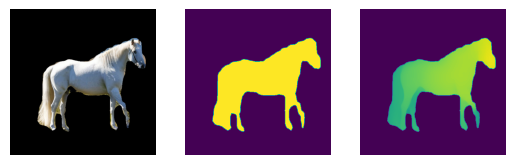

 38%|██████████████████████████▉                                           | 231/600 [00:01<00:03, 117.03it/s]

tensor(0.3592, device='cuda:0') tensor(0.5137, device='cuda:0')
tensor(0.3589, device='cuda:0') tensor(0.5034, device='cuda:0')
tensor(0.3542, device='cuda:0') tensor(0.5029, device='cuda:0')
tensor(0.3404, device='cuda:0') tensor(0.5031, device='cuda:0')
tensor(0.3178, device='cuda:0') tensor(0.5032, device='cuda:0')
tensor(0.2947, device='cuda:0') tensor(0.5034, device='cuda:0')
tensor(0.2621, device='cuda:0') tensor(0.5037, device='cuda:0')
tensor(0.2094, device='cuda:0') tensor(0.5038, device='cuda:0')
tensor(0.1690, device='cuda:0') tensor(0.5042, device='cuda:0')
tensor(0.1649, device='cuda:0') tensor(0.5044, device='cuda:0')
tensor(0.1649, device='cuda:0') tensor(0.5044, device='cuda:0')
tensor(0.1648, device='cuda:0') tensor(0.5047, device='cuda:0')
tensor(0.1648, device='cuda:0') tensor(0.5050, device='cuda:0')
tensor(0.1647, device='cuda:0') tensor(0.5051, device='cuda:0')
tensor(0.1647, device='cuda:0') tensor(0.5053, device='cuda:0')
tensor(0.1647, device='cuda:0') tensor(0

 42%|█████████████████████████████▊                                        | 255/600 [00:02<00:02, 118.26it/s]

tensor(0.1644, device='cuda:0') tensor(0.5042, device='cuda:0')
tensor(0.1644, device='cuda:0') tensor(0.5035, device='cuda:0')
tensor(0.1645, device='cuda:0') tensor(0.5035, device='cuda:0')
tensor(0.1647, device='cuda:0') tensor(0.5035, device='cuda:0')
tensor(0.1648, device='cuda:0') tensor(0.5039, device='cuda:0')
tensor(0.1648, device='cuda:0') tensor(0.5056, device='cuda:0')
tensor(0.1647, device='cuda:0') tensor(0.5109, device='cuda:0')
tensor(0.1648, device='cuda:0') tensor(0.5206, device='cuda:0')
tensor(0.1650, device='cuda:0') tensor(0.5308, device='cuda:0')
tensor(0.1651, device='cuda:0') tensor(0.5459, device='cuda:0')
tensor(0.1655, device='cuda:0') tensor(0.5619, device='cuda:0')
tensor(0.1657, device='cuda:0') tensor(0.5808, device='cuda:0')
tensor(0.1659, device='cuda:0') tensor(0.5955, device='cuda:0')
tensor(0.1662, device='cuda:0') tensor(0.5970, device='cuda:0')
tensor(0.1664, device='cuda:0') tensor(0.5968, device='cuda:0')
tensor(0.1667, device='cuda:0') tensor(0

 47%|████████████████████████████████▊                                     | 281/600 [00:02<00:02, 121.55it/s]

tensor(0.1705, device='cuda:0') tensor(0.4566, device='cuda:0')
tensor(0.1712, device='cuda:0') tensor(0.4272, device='cuda:0')
tensor(0.1718, device='cuda:0') tensor(0.4032, device='cuda:0')
tensor(0.1723, device='cuda:0') tensor(0.4030, device='cuda:0')
tensor(0.1727, device='cuda:0') tensor(0.4027, device='cuda:0')
tensor(0.1731, device='cuda:0') tensor(0.4028, device='cuda:0')
tensor(0.1737, device='cuda:0') tensor(0.4026, device='cuda:0')
tensor(0.1739, device='cuda:0') tensor(0.4026, device='cuda:0')
tensor(0.1740, device='cuda:0') tensor(0.4026, device='cuda:0')
tensor(0.1742, device='cuda:0') tensor(0.4025, device='cuda:0')
tensor(0.1741, device='cuda:0') tensor(0.4025, device='cuda:0')
tensor(0.1739, device='cuda:0') tensor(0.4025, device='cuda:0')
tensor(0.1740, device='cuda:0') tensor(0.4024, device='cuda:0')
tensor(0.1737, device='cuda:0') tensor(0.4024, device='cuda:0')
tensor(0.1735, device='cuda:0') tensor(0.4026, device='cuda:0')
tensor(0.1731, device='cuda:0') tensor(0

 51%|███████████████████████████████████▊                                  | 307/600 [00:02<00:02, 121.88it/s]

tensor(0.1709, device='cuda:0') tensor(0.4027, device='cuda:0')
tensor(0.1709, device='cuda:0') tensor(0.4027, device='cuda:0')
tensor(0.1708, device='cuda:0') tensor(0.4027, device='cuda:0')
tensor(0.1708, device='cuda:0') tensor(0.4027, device='cuda:0')
tensor(0.1708, device='cuda:0') tensor(0.4027, device='cuda:0')
tensor(0.1708, device='cuda:0') tensor(0.4026, device='cuda:0')
tensor(0.1708, device='cuda:0') tensor(0.4026, device='cuda:0')
tensor(0.1709, device='cuda:0') tensor(0.4026, device='cuda:0')
tensor(0.1707, device='cuda:0') tensor(0.4026, device='cuda:0')
tensor(0.1706, device='cuda:0') tensor(0.4026, device='cuda:0')
tensor(0.1705, device='cuda:0') tensor(0.4026, device='cuda:0')
tensor(0.1704, device='cuda:0') tensor(0.4025, device='cuda:0')
tensor(0.1703, device='cuda:0') tensor(0.4026, device='cuda:0')
tensor(0.1703, device='cuda:0') tensor(0.4026, device='cuda:0')
tensor(0.1702, device='cuda:0') tensor(0.4026, device='cuda:0')
tensor(0.1703, device='cuda:0') tensor(0

 56%|██████████████████████████████████████▊                               | 333/600 [00:02<00:02, 118.65it/s]

tensor(0.1706, device='cuda:0') tensor(0.4026, device='cuda:0')
tensor(0.1706, device='cuda:0') tensor(0.4026, device='cuda:0')
tensor(0.1708, device='cuda:0') tensor(0.4026, device='cuda:0')
tensor(0.1710, device='cuda:0') tensor(0.4026, device='cuda:0')
tensor(0.1709, device='cuda:0') tensor(0.4026, device='cuda:0')
tensor(0.1709, device='cuda:0') tensor(0.4027, device='cuda:0')
tensor(0.1711, device='cuda:0') tensor(0.4026, device='cuda:0')
tensor(0.1710, device='cuda:0') tensor(0.4025, device='cuda:0')
tensor(0.1710, device='cuda:0') tensor(0.4026, device='cuda:0')
tensor(0.1710, device='cuda:0') tensor(0.4025, device='cuda:0')
tensor(0.1709, device='cuda:0') tensor(0.4024, device='cuda:0')
tensor(0.1708, device='cuda:0') tensor(0.4024, device='cuda:0')
tensor(0.1707, device='cuda:0') tensor(0.4025, device='cuda:0')
tensor(0.1705, device='cuda:0') tensor(0.4025, device='cuda:0')
tensor(0.1705, device='cuda:0') tensor(0.4024, device='cuda:0')
tensor(0.1702, device='cuda:0') tensor(0

 60%|█████████████████████████████████████████▊                            | 358/600 [00:03<00:02, 118.88it/s]

tensor(0.1675, device='cuda:0') tensor(0.6148, device='cuda:0')
tensor(0.1671, device='cuda:0') tensor(0.6290, device='cuda:0')
tensor(0.1669, device='cuda:0') tensor(0.6322, device='cuda:0')
tensor(0.1667, device='cuda:0') tensor(0.6326, device='cuda:0')
tensor(0.1667, device='cuda:0') tensor(0.6326, device='cuda:0')
tensor(0.1666, device='cuda:0') tensor(0.6331, device='cuda:0')
tensor(0.1664, device='cuda:0') tensor(0.6335, device='cuda:0')
tensor(0.1662, device='cuda:0') tensor(0.6339, device='cuda:0')
tensor(0.1661, device='cuda:0') tensor(0.6287, device='cuda:0')
tensor(0.1658, device='cuda:0') tensor(0.6230, device='cuda:0')
tensor(0.1658, device='cuda:0') tensor(0.6062, device='cuda:0')
tensor(0.1658, device='cuda:0') tensor(0.5894, device='cuda:0')
tensor(0.1656, device='cuda:0') tensor(0.5699, device='cuda:0')
tensor(0.1655, device='cuda:0') tensor(0.5518, device='cuda:0')
tensor(0.1653, device='cuda:0') tensor(0.5413, device='cuda:0')
tensor(0.1651, device='cuda:0') tensor(0

 64%|████████████████████████████████████████████▋                         | 383/600 [00:03<00:01, 118.64it/s]

tensor(0.1644, device='cuda:0') tensor(0.5362, device='cuda:0')
tensor(0.1644, device='cuda:0') tensor(0.5365, device='cuda:0')
tensor(0.1647, device='cuda:0') tensor(0.5363, device='cuda:0')
tensor(0.1648, device='cuda:0') tensor(0.5362, device='cuda:0')
tensor(0.1650, device='cuda:0') tensor(0.5361, device='cuda:0')
tensor(0.1653, device='cuda:0') tensor(0.5360, device='cuda:0')
tensor(0.1653, device='cuda:0') tensor(0.5358, device='cuda:0')
tensor(0.1655, device='cuda:0') tensor(0.5356, device='cuda:0')
tensor(0.1656, device='cuda:0') tensor(0.5356, device='cuda:0')
tensor(0.1656, device='cuda:0') tensor(0.5355, device='cuda:0')
tensor(0.1658, device='cuda:0') tensor(0.5354, device='cuda:0')
tensor(0.1671, device='cuda:0') tensor(0.5352, device='cuda:0')
tensor(0.1870, device='cuda:0') tensor(0.5347, device='cuda:0')
tensor(0.2320, device='cuda:0') tensor(0.5345, device='cuda:0')
tensor(0.2793, device='cuda:0') tensor(0.5344, device='cuda:0')


100%|██████████████████████████████████████████████████████████████████████| 600/600 [00:05<00:00, 115.66it/s]


/grogu/user/akirchme/art3d_sd_webui/images/horse/897.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/897.mp4


  2%|█▏                                                                      | 10/600 [00:00<00:06, 96.52it/s]

tensor(0.2172, device='cuda:0') tensor(0.4287, device='cuda:0')
tensor(0.2170, device='cuda:0') tensor(0.4287, device='cuda:0')
tensor(0.2173, device='cuda:0') tensor(0.4287, device='cuda:0')
tensor(0.2172, device='cuda:0') tensor(0.4288, device='cuda:0')
tensor(0.2172, device='cuda:0') tensor(0.4288, device='cuda:0')
tensor(0.2172, device='cuda:0') tensor(0.4290, device='cuda:0')
tensor(0.2172, device='cuda:0') tensor(0.4291, device='cuda:0')
tensor(0.2173, device='cuda:0') tensor(0.4292, device='cuda:0')
tensor(0.2173, device='cuda:0') tensor(0.4292, device='cuda:0')
tensor(0.2173, device='cuda:0') tensor(0.4292, device='cuda:0')
tensor(0.2174, device='cuda:0') tensor(0.4293, device='cuda:0')
tensor(0.2175, device='cuda:0') tensor(0.4294, device='cuda:0')
tensor(0.2175, device='cuda:0') tensor(0.4295, device='cuda:0')
tensor(0.2174, device='cuda:0') tensor(0.4296, device='cuda:0')
tensor(0.2175, device='cuda:0') tensor(0.4296, device='cuda:0')
tensor(0.2176, device='cuda:0') tensor(0

  6%|████▏                                                                  | 35/600 [00:00<00:05, 112.75it/s]

tensor(0.2167, device='cuda:0') tensor(0.4296, device='cuda:0')
tensor(0.2165, device='cuda:0') tensor(0.4297, device='cuda:0')
tensor(0.2162, device='cuda:0') tensor(0.4297, device='cuda:0')
tensor(0.2159, device='cuda:0') tensor(0.4297, device='cuda:0')
tensor(0.2157, device='cuda:0') tensor(0.4296, device='cuda:0')
tensor(0.2156, device='cuda:0') tensor(0.4297, device='cuda:0')
tensor(0.2153, device='cuda:0') tensor(0.4298, device='cuda:0')
tensor(0.2150, device='cuda:0') tensor(0.4298, device='cuda:0')
tensor(0.2147, device='cuda:0') tensor(0.4299, device='cuda:0')
tensor(0.2145, device='cuda:0') tensor(0.4302, device='cuda:0')
tensor(0.2144, device='cuda:0') tensor(0.4413, device='cuda:0')
tensor(0.2138, device='cuda:0') tensor(0.4604, device='cuda:0')
tensor(0.2133, device='cuda:0') tensor(0.4812, device='cuda:0')
tensor(0.2128, device='cuda:0') tensor(0.5002, device='cuda:0')
tensor(0.2124, device='cuda:0') tensor(0.5149, device='cuda:0')
tensor(0.2119, device='cuda:0') tensor(0

 10%|██████▉                                                                | 59/600 [00:00<00:04, 111.89it/s]

tensor(0.2069, device='cuda:0') tensor(0.5710, device='cuda:0')
tensor(0.2064, device='cuda:0') tensor(0.5651, device='cuda:0')
tensor(0.2057, device='cuda:0') tensor(0.5522, device='cuda:0')
tensor(0.2050, device='cuda:0') tensor(0.5430, device='cuda:0')
tensor(0.2044, device='cuda:0') tensor(0.5372, device='cuda:0')
tensor(0.2036, device='cuda:0') tensor(0.5316, device='cuda:0')
tensor(0.2030, device='cuda:0') tensor(0.5248, device='cuda:0')
tensor(0.2024, device='cuda:0') tensor(0.5183, device='cuda:0')
tensor(0.2018, device='cuda:0') tensor(0.5156, device='cuda:0')
tensor(0.2012, device='cuda:0') tensor(0.5153, device='cuda:0')
tensor(0.2006, device='cuda:0') tensor(0.5152, device='cuda:0')
tensor(0.2000, device='cuda:0') tensor(0.5152, device='cuda:0')
tensor(0.1995, device='cuda:0') tensor(0.5149, device='cuda:0')
tensor(0.1991, device='cuda:0') tensor(0.5146, device='cuda:0')
tensor(0.1986, device='cuda:0') tensor(0.5140, device='cuda:0')
tensor(0.1984, device='cuda:0') tensor(0

 14%|█████████▊                                                             | 83/600 [00:00<00:04, 111.20it/s]

tensor(0.1957, device='cuda:0') tensor(0.5153, device='cuda:0')
tensor(0.1957, device='cuda:0') tensor(0.5155, device='cuda:0')
tensor(0.1955, device='cuda:0') tensor(0.5155, device='cuda:0')
tensor(0.1955, device='cuda:0') tensor(0.5156, device='cuda:0')
tensor(0.1955, device='cuda:0') tensor(0.5156, device='cuda:0')
tensor(0.1954, device='cuda:0') tensor(0.5154, device='cuda:0')
tensor(0.1966, device='cuda:0') tensor(0.5152, device='cuda:0')
tensor(0.2191, device='cuda:0') tensor(0.5150, device='cuda:0')
tensor(0.2494, device='cuda:0') tensor(0.5147, device='cuda:0')
tensor(0.2737, device='cuda:0') tensor(0.5145, device='cuda:0')
tensor(0.2926, device='cuda:0') tensor(0.5145, device='cuda:0')
tensor(0.3140, device='cuda:0') tensor(0.5144, device='cuda:0')
tensor(0.3305, device='cuda:0') tensor(0.5144, device='cuda:0')
tensor(0.3349, device='cuda:0') tensor(0.5146, device='cuda:0')


 90%|███████████████████████████████████████████████████████████████       | 540/600 [00:05<00:00, 105.69it/s]

tensor(0.2936, device='cuda:0') tensor(0.5432, device='cuda:0')
tensor(0.2319, device='cuda:0') tensor(0.5435, device='cuda:0')
tensor(0.1985, device='cuda:0') tensor(0.5441, device='cuda:0')
tensor(0.1949, device='cuda:0') tensor(0.5444, device='cuda:0')
tensor(0.1949, device='cuda:0') tensor(0.5447, device='cuda:0')
tensor(0.1947, device='cuda:0') tensor(0.5447, device='cuda:0')
tensor(0.1945, device='cuda:0') tensor(0.5443, device='cuda:0')
tensor(0.1943, device='cuda:0') tensor(0.5441, device='cuda:0')
tensor(0.1942, device='cuda:0') tensor(0.5437, device='cuda:0')
tensor(0.1940, device='cuda:0') tensor(0.5433, device='cuda:0')
tensor(0.1938, device='cuda:0') tensor(0.5430, device='cuda:0')
tensor(0.1938, device='cuda:0') tensor(0.5426, device='cuda:0')
tensor(0.1938, device='cuda:0') tensor(0.5424, device='cuda:0')
tensor(0.1938, device='cuda:0') tensor(0.5419, device='cuda:0')
tensor(0.1940, device='cuda:0') tensor(0.5413, device='cuda:0')
tensor(0.1941, device='cuda:0') tensor(0

 94%|█████████████████████████████████████████████████████████████████▊    | 564/600 [00:05<00:00, 111.22it/s]

tensor(0.1973, device='cuda:0') tensor(0.5456, device='cuda:0')
tensor(0.1979, device='cuda:0') tensor(0.5503, device='cuda:0')
tensor(0.1985, device='cuda:0') tensor(0.5645, device='cuda:0')
tensor(0.1993, device='cuda:0') tensor(0.5778, device='cuda:0')
tensor(0.1997, device='cuda:0') tensor(0.6014, device='cuda:0')
tensor(0.2000, device='cuda:0') tensor(0.6292, device='cuda:0')
tensor(0.2005, device='cuda:0') tensor(0.6463, device='cuda:0')
tensor(0.2009, device='cuda:0') tensor(0.6537, device='cuda:0')
tensor(0.2012, device='cuda:0') tensor(0.6538, device='cuda:0')
tensor(0.2014, device='cuda:0') tensor(0.6535, device='cuda:0')
tensor(0.2017, device='cuda:0') tensor(0.6534, device='cuda:0')
tensor(0.2021, device='cuda:0') tensor(0.6530, device='cuda:0')
tensor(0.2024, device='cuda:0') tensor(0.6526, device='cuda:0')
tensor(0.2027, device='cuda:0') tensor(0.6512, device='cuda:0')
tensor(0.2031, device='cuda:0') tensor(0.6471, device='cuda:0')
tensor(0.2037, device='cuda:0') tensor(0

 98%|████████████████████████████████████████████████████████████████████▌ | 588/600 [00:05<00:00, 113.73it/s]

tensor(0.2084, device='cuda:0') tensor(0.4272, device='cuda:0')
tensor(0.2088, device='cuda:0') tensor(0.4274, device='cuda:0')
tensor(0.2095, device='cuda:0') tensor(0.4277, device='cuda:0')
tensor(0.2100, device='cuda:0') tensor(0.4278, device='cuda:0')
tensor(0.2105, device='cuda:0') tensor(0.4280, device='cuda:0')
tensor(0.2109, device='cuda:0') tensor(0.4280, device='cuda:0')
tensor(0.2112, device='cuda:0') tensor(0.4282, device='cuda:0')
tensor(0.2115, device='cuda:0') tensor(0.4282, device='cuda:0')
tensor(0.2117, device='cuda:0') tensor(0.4283, device='cuda:0')
tensor(0.2119, device='cuda:0') tensor(0.4284, device='cuda:0')
tensor(0.2121, device='cuda:0') tensor(0.4284, device='cuda:0')
tensor(0.2123, device='cuda:0') tensor(0.4286, device='cuda:0')
tensor(0.2124, device='cuda:0') tensor(0.4285, device='cuda:0')
tensor(0.2125, device='cuda:0') tensor(0.4286, device='cuda:0')
tensor(0.2126, device='cuda:0') tensor(0.4285, device='cuda:0')
tensor(0.2131, device='cuda:0') tensor(0

100%|██████████████████████████████████████████████████████████████████████| 600/600 [00:05<00:00, 101.70it/s]


tensor(0.2157, device='cuda:0') tensor(0.4285, device='cuda:0')
tensor(0.2160, device='cuda:0') tensor(0.4285, device='cuda:0')
tensor(0.2163, device='cuda:0') tensor(0.4284, device='cuda:0')
tensor(0.2164, device='cuda:0') tensor(0.4284, device='cuda:0')
tensor(0.2167, device='cuda:0') tensor(0.4285, device='cuda:0')
tensor(0.2169, device='cuda:0') tensor(0.4286, device='cuda:0')
/grogu/user/akirchme/art3d_sd_webui/images/horse/1401.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/1401.mp4


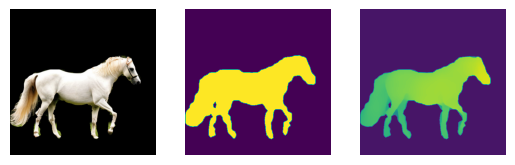

 38%|███████████████████████████▏                                           | 230/600 [00:02<00:04, 87.00it/s]

tensor(0.3551, device='cuda:0') tensor(0.5043, device='cuda:0')
tensor(0.3543, device='cuda:0') tensor(0.5021, device='cuda:0')
tensor(0.3500, device='cuda:0') tensor(0.5021, device='cuda:0')
tensor(0.3417, device='cuda:0') tensor(0.5022, device='cuda:0')
tensor(0.3278, device='cuda:0') tensor(0.5023, device='cuda:0')
tensor(0.3008, device='cuda:0') tensor(0.5023, device='cuda:0')
tensor(0.2521, device='cuda:0') tensor(0.5024, device='cuda:0')
tensor(0.2092, device='cuda:0') tensor(0.5030, device='cuda:0')
tensor(0.2028, device='cuda:0') tensor(0.5031, device='cuda:0')
tensor(0.2028, device='cuda:0') tensor(0.5030, device='cuda:0')
tensor(0.2027, device='cuda:0') tensor(0.5030, device='cuda:0')
tensor(0.2027, device='cuda:0') tensor(0.5031, device='cuda:0')
tensor(0.2026, device='cuda:0') tensor(0.5031, device='cuda:0')
tensor(0.2029, device='cuda:0') tensor(0.5033, device='cuda:0')
tensor(0.2028, device='cuda:0') tensor(0.5032, device='cuda:0')
tensor(0.2028, device='cuda:0') tensor(0

 42%|█████████████████████████████▋                                        | 254/600 [00:03<00:03, 101.13it/s]

tensor(0.2040, device='cuda:0') tensor(0.5016, device='cuda:0')
tensor(0.2041, device='cuda:0') tensor(0.5016, device='cuda:0')
tensor(0.2044, device='cuda:0') tensor(0.5015, device='cuda:0')
tensor(0.2048, device='cuda:0') tensor(0.5014, device='cuda:0')
tensor(0.2050, device='cuda:0') tensor(0.5015, device='cuda:0')
tensor(0.2052, device='cuda:0') tensor(0.5019, device='cuda:0')
tensor(0.2054, device='cuda:0') tensor(0.5028, device='cuda:0')
tensor(0.2055, device='cuda:0') tensor(0.5040, device='cuda:0')
tensor(0.2057, device='cuda:0') tensor(0.5085, device='cuda:0')
tensor(0.2059, device='cuda:0') tensor(0.5139, device='cuda:0')
tensor(0.2061, device='cuda:0') tensor(0.5285, device='cuda:0')
tensor(0.2061, device='cuda:0') tensor(0.5440, device='cuda:0')
tensor(0.2062, device='cuda:0') tensor(0.5644, device='cuda:0')
tensor(0.2063, device='cuda:0') tensor(0.5658, device='cuda:0')
tensor(0.2063, device='cuda:0') tensor(0.5658, device='cuda:0')
tensor(0.2064, device='cuda:0') tensor(0

 46%|████████████████████████████████▍                                     | 278/600 [00:03<00:03, 107.27it/s]

tensor(0.2081, device='cuda:0') tensor(0.5289, device='cuda:0')
tensor(0.2084, device='cuda:0') tensor(0.5037, device='cuda:0')
tensor(0.2089, device='cuda:0') tensor(0.4714, device='cuda:0')
tensor(0.2090, device='cuda:0') tensor(0.4455, device='cuda:0')
tensor(0.2093, device='cuda:0') tensor(0.4140, device='cuda:0')
tensor(0.2095, device='cuda:0') tensor(0.4134, device='cuda:0')
tensor(0.2098, device='cuda:0') tensor(0.4134, device='cuda:0')
tensor(0.2098, device='cuda:0') tensor(0.4134, device='cuda:0')
tensor(0.2100, device='cuda:0') tensor(0.4133, device='cuda:0')
tensor(0.2101, device='cuda:0') tensor(0.4132, device='cuda:0')
tensor(0.2102, device='cuda:0') tensor(0.4132, device='cuda:0')
tensor(0.2102, device='cuda:0') tensor(0.4132, device='cuda:0')
tensor(0.2103, device='cuda:0') tensor(0.4132, device='cuda:0')
tensor(0.2103, device='cuda:0') tensor(0.4132, device='cuda:0')
tensor(0.2105, device='cuda:0') tensor(0.4133, device='cuda:0')
tensor(0.2105, device='cuda:0') tensor(0

 50%|███████████████████████████████████▏                                  | 302/600 [00:03<00:02, 111.55it/s]

tensor(0.2093, device='cuda:0') tensor(0.4135, device='cuda:0')
tensor(0.2091, device='cuda:0') tensor(0.4134, device='cuda:0')
tensor(0.2090, device='cuda:0') tensor(0.4133, device='cuda:0')
tensor(0.2090, device='cuda:0') tensor(0.4132, device='cuda:0')
tensor(0.2090, device='cuda:0') tensor(0.4131, device='cuda:0')
tensor(0.2090, device='cuda:0') tensor(0.4131, device='cuda:0')
tensor(0.2090, device='cuda:0') tensor(0.4130, device='cuda:0')
tensor(0.2090, device='cuda:0') tensor(0.4130, device='cuda:0')
tensor(0.2089, device='cuda:0') tensor(0.4128, device='cuda:0')
tensor(0.2090, device='cuda:0') tensor(0.4124, device='cuda:0')
tensor(0.2090, device='cuda:0') tensor(0.4123, device='cuda:0')
tensor(0.2090, device='cuda:0') tensor(0.4122, device='cuda:0')
tensor(0.2089, device='cuda:0') tensor(0.4122, device='cuda:0')
tensor(0.2088, device='cuda:0') tensor(0.4119, device='cuda:0')
tensor(0.2087, device='cuda:0') tensor(0.4118, device='cuda:0')
tensor(0.2086, device='cuda:0') tensor(0

 54%|██████████████████████████████████████                                | 326/600 [00:03<00:02, 110.86it/s]

tensor(0.4122, device='cuda:0')
tensor(0.2087, device='cuda:0') tensor(0.4122, device='cuda:0')
tensor(0.2087, device='cuda:0') tensor(0.4124, device='cuda:0')
tensor(0.2087, device='cuda:0') tensor(0.4124, device='cuda:0')
tensor(0.2086, device='cuda:0') tensor(0.4123, device='cuda:0')
tensor(0.2086, device='cuda:0') tensor(0.4123, device='cuda:0')
tensor(0.2086, device='cuda:0') tensor(0.4123, device='cuda:0')
tensor(0.2086, device='cuda:0') tensor(0.4123, device='cuda:0')
tensor(0.2087, device='cuda:0') tensor(0.4122, device='cuda:0')
tensor(0.2088, device='cuda:0') tensor(0.4122, device='cuda:0')
tensor(0.2087, device='cuda:0') tensor(0.4122, device='cuda:0')
tensor(0.2086, device='cuda:0') tensor(0.4121, device='cuda:0')
tensor(0.2084, device='cuda:0') tensor(0.4121, device='cuda:0')
tensor(0.2082, device='cuda:0') tensor(0.4121, device='cuda:0')
tensor(0.2080, device='cuda:0') tensor(0.4121, device='cuda:0')
tensor(0.2077, device='cuda:0') tensor(0.4121, device='cuda:0')
tensor(0

 58%|████████████████████████████████████████▊                             | 350/600 [00:03<00:02, 114.44it/s]

tensor(0.2065, device='cuda:0') tensor(0.4699, device='cuda:0')
tensor(0.2064, device='cuda:0') tensor(0.5201, device='cuda:0')
tensor(0.2062, device='cuda:0') tensor(0.5820, device='cuda:0')
tensor(0.2061, device='cuda:0') tensor(0.6207, device='cuda:0')
tensor(0.2060, device='cuda:0') tensor(0.6395, device='cuda:0')
tensor(0.2057, device='cuda:0') tensor(0.6528, device='cuda:0')
tensor(0.2056, device='cuda:0') tensor(0.6606, device='cuda:0')
tensor(0.2055, device='cuda:0') tensor(0.6668, device='cuda:0')
tensor(0.2054, device='cuda:0') tensor(0.6716, device='cuda:0')
tensor(0.2052, device='cuda:0') tensor(0.6728, device='cuda:0')
tensor(0.2050, device='cuda:0') tensor(0.6734, device='cuda:0')
tensor(0.2049, device='cuda:0') tensor(0.6738, device='cuda:0')
tensor(0.2047, device='cuda:0') tensor(0.6742, device='cuda:0')
tensor(0.2046, device='cuda:0') tensor(0.6744, device='cuda:0')
tensor(0.2044, device='cuda:0') tensor(0.6722, device='cuda:0')
tensor(0.2044, device='cuda:0') tensor(0

 62%|███████████████████████████████████████████▊                          | 375/600 [00:04<00:01, 116.90it/s]

tensor(0.2040, device='cuda:0') tensor(0.5631, device='cuda:0')
tensor(0.2037, device='cuda:0') tensor(0.5632, device='cuda:0')
tensor(0.2036, device='cuda:0') tensor(0.5630, device='cuda:0')
tensor(0.2034, device='cuda:0') tensor(0.5631, device='cuda:0')
tensor(0.2033, device='cuda:0') tensor(0.5632, device='cuda:0')
tensor(0.2032, device='cuda:0') tensor(0.5632, device='cuda:0')
tensor(0.2031, device='cuda:0') tensor(0.5633, device='cuda:0')
tensor(0.2029, device='cuda:0') tensor(0.5633, device='cuda:0')
tensor(0.2028, device='cuda:0') tensor(0.5635, device='cuda:0')
tensor(0.2026, device='cuda:0') tensor(0.5636, device='cuda:0')
tensor(0.2026, device='cuda:0') tensor(0.5637, device='cuda:0')
tensor(0.2026, device='cuda:0') tensor(0.5638, device='cuda:0')
tensor(0.2027, device='cuda:0') tensor(0.5639, device='cuda:0')
tensor(0.2027, device='cuda:0') tensor(0.5639, device='cuda:0')
tensor(0.2029, device='cuda:0') tensor(0.5638, device='cuda:0')
tensor(0.2030, device='cuda:0') tensor(0

100%|███████████████████████████████████████████████████████████████████████| 600/600 [00:06<00:00, 93.76it/s]


/grogu/user/akirchme/art3d_sd_webui/images/horse/1873.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/1873.mp4


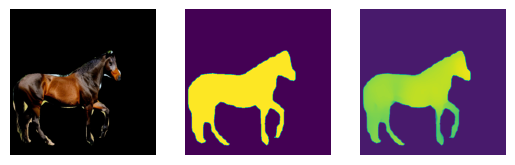

 40%|███████████████████████████▋                                          | 237/600 [00:02<00:03, 120.10it/s]

tensor(0.3769, device='cuda:0') tensor(0.5108, device='cuda:0')
tensor(0.3752, device='cuda:0') tensor(0.5092, device='cuda:0')
tensor(0.3683, device='cuda:0') tensor(0.5092, device='cuda:0')
tensor(0.3573, device='cuda:0') tensor(0.5094, device='cuda:0')
tensor(0.3415, device='cuda:0') tensor(0.5095, device='cuda:0')
tensor(0.3142, device='cuda:0') tensor(0.5096, device='cuda:0')
tensor(0.2807, device='cuda:0') tensor(0.5097, device='cuda:0')
tensor(0.2339, device='cuda:0') tensor(0.5100, device='cuda:0')
tensor(0.2260, device='cuda:0') tensor(0.5100, device='cuda:0')
tensor(0.2260, device='cuda:0') tensor(0.5102, device='cuda:0')
tensor(0.2260, device='cuda:0') tensor(0.5102, device='cuda:0')
tensor(0.2260, device='cuda:0') tensor(0.5104, device='cuda:0')
tensor(0.2260, device='cuda:0') tensor(0.5107, device='cuda:0')
tensor(0.2260, device='cuda:0') tensor(0.5109, device='cuda:0')
tensor(0.2263, device='cuda:0') tensor(0.5109, device='cuda:0')
tensor(0.2266, device='cuda:0') tensor(0

 44%|██████████████████████████████▋                                       | 263/600 [00:02<00:02, 120.72it/s]

tensor(0.2277, device='cuda:0') tensor(0.5129, device='cuda:0')
tensor(0.2279, device='cuda:0') tensor(0.5133, device='cuda:0')
tensor(0.2281, device='cuda:0') tensor(0.5135, device='cuda:0')
tensor(0.2286, device='cuda:0') tensor(0.5140, device='cuda:0')
tensor(0.2290, device='cuda:0') tensor(0.5151, device='cuda:0')
tensor(0.2293, device='cuda:0') tensor(0.5165, device='cuda:0')
tensor(0.2297, device='cuda:0') tensor(0.5190, device='cuda:0')
tensor(0.2298, device='cuda:0') tensor(0.5231, device='cuda:0')
tensor(0.2302, device='cuda:0') tensor(0.5289, device='cuda:0')
tensor(0.2304, device='cuda:0') tensor(0.5392, device='cuda:0')
tensor(0.2306, device='cuda:0') tensor(0.5540, device='cuda:0')
tensor(0.2308, device='cuda:0') tensor(0.5796, device='cuda:0')
tensor(0.2311, device='cuda:0') tensor(0.5814, device='cuda:0')
tensor(0.2312, device='cuda:0') tensor(0.5813, device='cuda:0')
tensor(0.2314, device='cuda:0') tensor(0.5812, device='cuda:0')
tensor(0.2317, device='cuda:0') tensor(0

 48%|█████████████████████████████████▌                                    | 288/600 [00:02<00:02, 119.37it/s]

tensor(0.2337, device='cuda:0') tensor(0.4623, device='cuda:0')
tensor(0.2339, device='cuda:0') tensor(0.4298, device='cuda:0')
tensor(0.2341, device='cuda:0') tensor(0.4294, device='cuda:0')
tensor(0.2343, device='cuda:0') tensor(0.4294, device='cuda:0')
tensor(0.2345, device='cuda:0') tensor(0.4295, device='cuda:0')
tensor(0.2345, device='cuda:0') tensor(0.4296, device='cuda:0')
tensor(0.2345, device='cuda:0') tensor(0.4296, device='cuda:0')
tensor(0.2347, device='cuda:0') tensor(0.4297, device='cuda:0')
tensor(0.2347, device='cuda:0') tensor(0.4297, device='cuda:0')
tensor(0.2348, device='cuda:0') tensor(0.4298, device='cuda:0')
tensor(0.2347, device='cuda:0') tensor(0.4297, device='cuda:0')
tensor(0.2348, device='cuda:0') tensor(0.4297, device='cuda:0')
tensor(0.2348, device='cuda:0') tensor(0.4298, device='cuda:0')
tensor(0.2347, device='cuda:0') tensor(0.4299, device='cuda:0')
tensor(0.2346, device='cuda:0') tensor(0.4301, device='cuda:0')
tensor(0.2344, device='cuda:0') tensor(0

 52%|████████████████████████████████████▍                                 | 312/600 [00:02<00:02, 119.02it/s]

tensor(0.2346, device='cuda:0') tensor(0.4296, device='cuda:0')
tensor(0.2346, device='cuda:0') tensor(0.4295, device='cuda:0')
tensor(0.2346, device='cuda:0') tensor(0.4294, device='cuda:0')
tensor(0.2344, device='cuda:0') tensor(0.4293, device='cuda:0')
tensor(0.2345, device='cuda:0') tensor(0.4293, device='cuda:0')
tensor(0.2346, device='cuda:0') tensor(0.4292, device='cuda:0')
tensor(0.2347, device='cuda:0') tensor(0.4292, device='cuda:0')
tensor(0.2348, device='cuda:0') tensor(0.4292, device='cuda:0')
tensor(0.2349, device='cuda:0') tensor(0.4291, device='cuda:0')
tensor(0.2351, device='cuda:0') tensor(0.4290, device='cuda:0')
tensor(0.2352, device='cuda:0') tensor(0.4289, device='cuda:0')
tensor(0.2352, device='cuda:0') tensor(0.4288, device='cuda:0')
tensor(0.2354, device='cuda:0') tensor(0.4288, device='cuda:0')
tensor(0.2352, device='cuda:0') tensor(0.4288, device='cuda:0')
tensor(0.2351, device='cuda:0') tensor(0.4286, device='cuda:0')
tensor(0.2349, device='cuda:0') tensor(0

 56%|███████████████████████████████████████▍                              | 338/600 [00:02<00:02, 120.22it/s]

tensor(0.2355, device='cuda:0') tensor(0.4283, device='cuda:0')
tensor(0.2357, device='cuda:0') tensor(0.4282, device='cuda:0')
tensor(0.2358, device='cuda:0') tensor(0.4282, device='cuda:0')
tensor(0.2359, device='cuda:0') tensor(0.4281, device='cuda:0')
tensor(0.2359, device='cuda:0') tensor(0.4280, device='cuda:0')
tensor(0.2359, device='cuda:0') tensor(0.4281, device='cuda:0')
tensor(0.2359, device='cuda:0') tensor(0.4281, device='cuda:0')
tensor(0.2357, device='cuda:0') tensor(0.4279, device='cuda:0')
tensor(0.2358, device='cuda:0') tensor(0.4278, device='cuda:0')
tensor(0.2357, device='cuda:0') tensor(0.4279, device='cuda:0')
tensor(0.2357, device='cuda:0') tensor(0.4278, device='cuda:0')
tensor(0.2357, device='cuda:0') tensor(0.4277, device='cuda:0')
tensor(0.2356, device='cuda:0') tensor(0.4275, device='cuda:0')
tensor(0.2356, device='cuda:0') tensor(0.4275, device='cuda:0')
tensor(0.2355, device='cuda:0') tensor(0.4273, device='cuda:0')
tensor(0.2353, device='cuda:0') tensor(0

 60%|██████████████████████████████████████████▎                           | 363/600 [00:03<00:01, 119.28it/s]

tensor(0.2332, device='cuda:0') tensor(0.6799, device='cuda:0')
tensor(0.2330, device='cuda:0') tensor(0.6821, device='cuda:0')
tensor(0.2329, device='cuda:0') tensor(0.6823, device='cuda:0')
tensor(0.2327, device='cuda:0') tensor(0.6825, device='cuda:0')
tensor(0.2323, device='cuda:0') tensor(0.6825, device='cuda:0')
tensor(0.2321, device='cuda:0') tensor(0.6827, device='cuda:0')
tensor(0.2321, device='cuda:0') tensor(0.6826, device='cuda:0')
tensor(0.2318, device='cuda:0') tensor(0.6806, device='cuda:0')
tensor(0.2317, device='cuda:0') tensor(0.6548, device='cuda:0')
tensor(0.2315, device='cuda:0') tensor(0.6361, device='cuda:0')
tensor(0.2314, device='cuda:0') tensor(0.6188, device='cuda:0')
tensor(0.2311, device='cuda:0') tensor(0.6010, device='cuda:0')
tensor(0.2308, device='cuda:0') tensor(0.5879, device='cuda:0')
tensor(0.2308, device='cuda:0') tensor(0.5831, device='cuda:0')
tensor(0.2307, device='cuda:0') tensor(0.5808, device='cuda:0')
tensor(0.2305, device='cuda:0') tensor(0

 63%|███████████████████████████████████████████▊                          | 376/600 [00:03<00:01, 119.67it/s]

tensor(0.2300, device='cuda:0') tensor(0.5779, device='cuda:0')
tensor(0.2299, device='cuda:0') tensor(0.5779, device='cuda:0')
tensor(0.2299, device='cuda:0') tensor(0.5777, device='cuda:0')
tensor(0.2299, device='cuda:0') tensor(0.5776, device='cuda:0')
tensor(0.2300, device='cuda:0') tensor(0.5775, device='cuda:0')
tensor(0.2300, device='cuda:0') tensor(0.5774, device='cuda:0')
tensor(0.2300, device='cuda:0') tensor(0.5774, device='cuda:0')
tensor(0.2299, device='cuda:0') tensor(0.5773, device='cuda:0')
tensor(0.2299, device='cuda:0') tensor(0.5773, device='cuda:0')
tensor(0.2301, device='cuda:0') tensor(0.5771, device='cuda:0')
tensor(0.2301, device='cuda:0') tensor(0.5769, device='cuda:0')
tensor(0.2301, device='cuda:0') tensor(0.5765, device='cuda:0')
tensor(0.2423, device='cuda:0') tensor(0.5763, device='cuda:0')


100%|██████████████████████████████████████████████████████████████████████| 600/600 [00:05<00:00, 118.50it/s]


/grogu/user/akirchme/art3d_sd_webui/images/horse/342.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/342.mp4


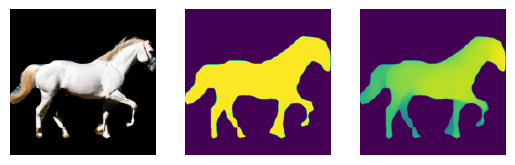

 39%|███████████████████████████                                           | 232/600 [00:02<00:03, 109.10it/s]

tensor(0.3140, device='cuda:0') tensor(0.4968, device='cuda:0')
tensor(0.3138, device='cuda:0') tensor(0.4727, device='cuda:0')
tensor(0.3102, device='cuda:0') tensor(0.4718, device='cuda:0')
tensor(0.3033, device='cuda:0') tensor(0.4719, device='cuda:0')
tensor(0.2918, device='cuda:0') tensor(0.4720, device='cuda:0')
tensor(0.2711, device='cuda:0') tensor(0.4721, device='cuda:0')
tensor(0.2505, device='cuda:0') tensor(0.4720, device='cuda:0')
tensor(0.2303, device='cuda:0') tensor(0.4720, device='cuda:0')
tensor(0.2139, device='cuda:0') tensor(0.4722, device='cuda:0')
tensor(0.2103, device='cuda:0') tensor(0.4721, device='cuda:0')
tensor(0.2102, device='cuda:0') tensor(0.4721, device='cuda:0')
tensor(0.2102, device='cuda:0') tensor(0.4721, device='cuda:0')
tensor(0.2101, device='cuda:0') tensor(0.4721, device='cuda:0')
tensor(0.2100, device='cuda:0') tensor(0.4720, device='cuda:0')
tensor(0.2100, device='cuda:0') tensor(0.4721, device='cuda:0')
tensor(0.2099, device='cuda:0') tensor(0

 43%|█████████████████████████████▊                                        | 256/600 [00:02<00:03, 113.99it/s]

tensor(0.2101, device='cuda:0') tensor(0.4732, device='cuda:0')
tensor(0.2102, device='cuda:0') tensor(0.4733, device='cuda:0')
tensor(0.2105, device='cuda:0') tensor(0.4734, device='cuda:0')
tensor(0.2107, device='cuda:0') tensor(0.4736, device='cuda:0')
tensor(0.2109, device='cuda:0') tensor(0.4742, device='cuda:0')
tensor(0.2110, device='cuda:0') tensor(0.4758, device='cuda:0')
tensor(0.2112, device='cuda:0') tensor(0.4770, device='cuda:0')
tensor(0.2114, device='cuda:0') tensor(0.4792, device='cuda:0')
tensor(0.2117, device='cuda:0') tensor(0.4829, device='cuda:0')
tensor(0.2120, device='cuda:0') tensor(0.4894, device='cuda:0')
tensor(0.2122, device='cuda:0') tensor(0.4952, device='cuda:0')
tensor(0.2126, device='cuda:0') tensor(0.4997, device='cuda:0')
tensor(0.2127, device='cuda:0') tensor(0.5049, device='cuda:0')
tensor(0.2131, device='cuda:0') tensor(0.5056, device='cuda:0')
tensor(0.2133, device='cuda:0') tensor(0.5056, device='cuda:0')
tensor(0.2137, device='cuda:0') tensor(0

 47%|████████████████████████████████▋                                     | 280/600 [00:02<00:02, 116.57it/s]

tensor(0.2187, device='cuda:0') tensor(0.4387, device='cuda:0')
tensor(0.2194, device='cuda:0') tensor(0.4246, device='cuda:0')
tensor(0.2199, device='cuda:0') tensor(0.4141, device='cuda:0')
tensor(0.2208, device='cuda:0') tensor(0.4016, device='cuda:0')
tensor(0.2215, device='cuda:0') tensor(0.4016, device='cuda:0')
tensor(0.2220, device='cuda:0') tensor(0.4017, device='cuda:0')
tensor(0.2224, device='cuda:0') tensor(0.4017, device='cuda:0')
tensor(0.2228, device='cuda:0') tensor(0.4016, device='cuda:0')
tensor(0.2230, device='cuda:0') tensor(0.4015, device='cuda:0')
tensor(0.2230, device='cuda:0') tensor(0.4016, device='cuda:0')
tensor(0.2229, device='cuda:0') tensor(0.4016, device='cuda:0')
tensor(0.2225, device='cuda:0') tensor(0.4015, device='cuda:0')
tensor(0.2222, device='cuda:0') tensor(0.4017, device='cuda:0')
tensor(0.2219, device='cuda:0') tensor(0.4019, device='cuda:0')
tensor(0.2218, device='cuda:0') tensor(0.4020, device='cuda:0')
tensor(0.2213, device='cuda:0') tensor(0

 51%|███████████████████████████████████▍                                  | 304/600 [00:02<00:02, 117.62it/s]

tensor(0.2174, device='cuda:0') tensor(0.4022, device='cuda:0')
tensor(0.2170, device='cuda:0') tensor(0.4023, device='cuda:0')
tensor(0.2170, device='cuda:0') tensor(0.4024, device='cuda:0')
tensor(0.2169, device='cuda:0') tensor(0.4024, device='cuda:0')
tensor(0.2167, device='cuda:0') tensor(0.4023, device='cuda:0')
tensor(0.2167, device='cuda:0') tensor(0.4024, device='cuda:0')
tensor(0.2166, device='cuda:0') tensor(0.4024, device='cuda:0')
tensor(0.2164, device='cuda:0') tensor(0.4024, device='cuda:0')
tensor(0.2164, device='cuda:0') tensor(0.4024, device='cuda:0')
tensor(0.2163, device='cuda:0') tensor(0.4024, device='cuda:0')
tensor(0.2162, device='cuda:0') tensor(0.4025, device='cuda:0')
tensor(0.2161, device='cuda:0') tensor(0.4025, device='cuda:0')
tensor(0.2163, device='cuda:0') tensor(0.4026, device='cuda:0')
tensor(0.2164, device='cuda:0') tensor(0.4027, device='cuda:0')
tensor(0.2164, device='cuda:0') tensor(0.4027, device='cuda:0')
tensor(0.2163, device='cuda:0') tensor(0

 55%|██████████████████████████████████████▌                               | 330/600 [00:03<00:02, 119.63it/s]

tensor(0.4028, device='cuda:0')
tensor(0.2172, device='cuda:0') tensor(0.4028, device='cuda:0')
tensor(0.2174, device='cuda:0') tensor(0.4028, device='cuda:0')
tensor(0.2175, device='cuda:0') tensor(0.4028, device='cuda:0')
tensor(0.2177, device='cuda:0') tensor(0.4028, device='cuda:0')
tensor(0.2179, device='cuda:0') tensor(0.4029, device='cuda:0')
tensor(0.2180, device='cuda:0') tensor(0.4029, device='cuda:0')
tensor(0.2181, device='cuda:0') tensor(0.4028, device='cuda:0')
tensor(0.2182, device='cuda:0') tensor(0.4029, device='cuda:0')
tensor(0.2182, device='cuda:0') tensor(0.4029, device='cuda:0')
tensor(0.2182, device='cuda:0') tensor(0.4030, device='cuda:0')
tensor(0.2183, device='cuda:0') tensor(0.4029, device='cuda:0')
tensor(0.2183, device='cuda:0') tensor(0.4030, device='cuda:0')
tensor(0.2182, device='cuda:0') tensor(0.4030, device='cuda:0')
tensor(0.2183, device='cuda:0') tensor(0.4031, device='cuda:0')
tensor(0.2182, device='cuda:0') tensor(0.4031, device='cuda:0')
tensor(0

 59%|█████████████████████████████████████████▌                            | 356/600 [00:03<00:02, 119.30it/s]

tensor(0.2153, device='cuda:0') tensor(0.6678, device='cuda:0')
tensor(0.2149, device='cuda:0') tensor(0.6920, device='cuda:0')
tensor(0.2144, device='cuda:0') tensor(0.7085, device='cuda:0')
tensor(0.2139, device='cuda:0') tensor(0.7176, device='cuda:0')
tensor(0.2134, device='cuda:0') tensor(0.7209, device='cuda:0')
tensor(0.2132, device='cuda:0') tensor(0.7213, device='cuda:0')
tensor(0.2131, device='cuda:0') tensor(0.7214, device='cuda:0')
tensor(0.2128, device='cuda:0') tensor(0.7214, device='cuda:0')
tensor(0.2125, device='cuda:0') tensor(0.7214, device='cuda:0')
tensor(0.2122, device='cuda:0') tensor(0.7209, device='cuda:0')
tensor(0.2120, device='cuda:0') tensor(0.7065, device='cuda:0')
tensor(0.2119, device='cuda:0') tensor(0.6786, device='cuda:0')
tensor(0.2119, device='cuda:0') tensor(0.6568, device='cuda:0')
tensor(0.2117, device='cuda:0') tensor(0.6402, device='cuda:0')
tensor(0.2117, device='cuda:0') tensor(0.6285, device='cuda:0')
tensor(0.2114, device='cuda:0') tensor(0

 63%|████████████████████████████████████████████▎                         | 380/600 [00:03<00:01, 117.18it/s]

tensor(0.2102, device='cuda:0') tensor(0.5966, device='cuda:0')
tensor(0.2100, device='cuda:0') tensor(0.5965, device='cuda:0')
tensor(0.2100, device='cuda:0') tensor(0.5966, device='cuda:0')
tensor(0.2099, device='cuda:0') tensor(0.5964, device='cuda:0')
tensor(0.2100, device='cuda:0') tensor(0.5964, device='cuda:0')
tensor(0.2099, device='cuda:0') tensor(0.5965, device='cuda:0')
tensor(0.2099, device='cuda:0') tensor(0.5964, device='cuda:0')
tensor(0.2099, device='cuda:0') tensor(0.5965, device='cuda:0')
tensor(0.2098, device='cuda:0') tensor(0.5964, device='cuda:0')
tensor(0.2099, device='cuda:0') tensor(0.5966, device='cuda:0')
tensor(0.2100, device='cuda:0') tensor(0.5968, device='cuda:0')
tensor(0.2101, device='cuda:0') tensor(0.5967, device='cuda:0')
tensor(0.2101, device='cuda:0') tensor(0.5967, device='cuda:0')
tensor(0.2103, device='cuda:0') tensor(0.5966, device='cuda:0')
tensor(0.2168, device='cuda:0') tensor(0.5965, device='cuda:0')
tensor(0.2990, device='cuda:0') tensor(0

100%|██████████████████████████████████████████████████████████████████████| 600/600 [00:05<00:00, 106.27it/s]


/grogu/user/akirchme/art3d_sd_webui/images/horse/846.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/846.mp4


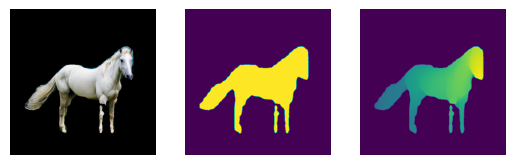

 38%|██████████████████████████▎                                           | 226/600 [00:01<00:03, 123.46it/s]

tensor(0.3554, device='cuda:0') tensor(0.5194, device='cuda:0')
tensor(0.3547, device='cuda:0') tensor(0.5124, device='cuda:0')
tensor(0.3540, device='cuda:0') tensor(0.5104, device='cuda:0')
tensor(0.3538, device='cuda:0') tensor(0.5111, device='cuda:0')
tensor(0.3528, device='cuda:0') tensor(0.5119, device='cuda:0')
tensor(0.3433, device='cuda:0') tensor(0.5127, device='cuda:0')
tensor(0.3274, device='cuda:0') tensor(0.5132, device='cuda:0')
tensor(0.3010, device='cuda:0') tensor(0.5142, device='cuda:0')
tensor(0.2665, device='cuda:0') tensor(0.5145, device='cuda:0')
tensor(0.2306, device='cuda:0') tensor(0.5149, device='cuda:0')
tensor(0.1994, device='cuda:0') tensor(0.5159, device='cuda:0')
tensor(0.1982, device='cuda:0') tensor(0.5164, device='cuda:0')
tensor(0.1978, device='cuda:0') tensor(0.5176, device='cuda:0')
tensor(0.1973, device='cuda:0') tensor(0.5184, device='cuda:0')
tensor(0.1971, device='cuda:0') tensor(0.5188, device='cuda:0')
tensor(0.1969, device='cuda:0') tensor(0

 42%|█████████████████████████████▍                                        | 252/600 [00:01<00:02, 123.42it/s]

tensor(0.1954, device='cuda:0') tensor(0.5085, device='cuda:0')
tensor(0.1954, device='cuda:0') tensor(0.5067, device='cuda:0')
tensor(0.1951, device='cuda:0') tensor(0.5049, device='cuda:0')
tensor(0.1953, device='cuda:0') tensor(0.5035, device='cuda:0')
tensor(0.1953, device='cuda:0') tensor(0.5026, device='cuda:0')
tensor(0.1954, device='cuda:0') tensor(0.5024, device='cuda:0')
tensor(0.1955, device='cuda:0') tensor(0.5018, device='cuda:0')
tensor(0.1956, device='cuda:0') tensor(0.5043, device='cuda:0')
tensor(0.1960, device='cuda:0') tensor(0.5102, device='cuda:0')
tensor(0.1964, device='cuda:0') tensor(0.5141, device='cuda:0')
tensor(0.1966, device='cuda:0') tensor(0.5222, device='cuda:0')
tensor(0.1971, device='cuda:0') tensor(0.5307, device='cuda:0')
tensor(0.1974, device='cuda:0') tensor(0.5393, device='cuda:0')
tensor(0.1980, device='cuda:0') tensor(0.5496, device='cuda:0')
tensor(0.1986, device='cuda:0') tensor(0.5554, device='cuda:0')
tensor(0.1990, device='cuda:0') tensor(0

 46%|████████████████████████████████▍                                     | 278/600 [00:02<00:02, 121.16it/s]

tensor(0.2129, device='cuda:0') tensor(0.4870, device='cuda:0')
tensor(0.2148, device='cuda:0') tensor(0.4634, device='cuda:0')
tensor(0.2172, device='cuda:0') tensor(0.4382, device='cuda:0')
tensor(0.2193, device='cuda:0') tensor(0.4145, device='cuda:0')
tensor(0.2206, device='cuda:0') tensor(0.3989, device='cuda:0')
tensor(0.2227, device='cuda:0') tensor(0.3987, device='cuda:0')
tensor(0.2243, device='cuda:0') tensor(0.3985, device='cuda:0')
tensor(0.2258, device='cuda:0') tensor(0.3984, device='cuda:0')
tensor(0.2266, device='cuda:0') tensor(0.3984, device='cuda:0')
tensor(0.2272, device='cuda:0') tensor(0.3985, device='cuda:0')
tensor(0.2276, device='cuda:0') tensor(0.3982, device='cuda:0')
tensor(0.2278, device='cuda:0') tensor(0.3980, device='cuda:0')
tensor(0.2276, device='cuda:0') tensor(0.3979, device='cuda:0')
tensor(0.2274, device='cuda:0') tensor(0.3977, device='cuda:0')
tensor(0.2268, device='cuda:0') tensor(0.3975, device='cuda:0')
tensor(0.2258, device='cuda:0') tensor(0

 51%|███████████████████████████████████▍                                  | 304/600 [00:02<00:02, 119.60it/s]

tensor(0.2169, device='cuda:0') tensor(0.3968, device='cuda:0')
tensor(0.2160, device='cuda:0') tensor(0.3969, device='cuda:0')
tensor(0.2151, device='cuda:0') tensor(0.3969, device='cuda:0')
tensor(0.2150, device='cuda:0') tensor(0.3968, device='cuda:0')
tensor(0.2150, device='cuda:0') tensor(0.3969, device='cuda:0')
tensor(0.2152, device='cuda:0') tensor(0.3967, device='cuda:0')
tensor(0.2153, device='cuda:0') tensor(0.3966, device='cuda:0')
tensor(0.2155, device='cuda:0') tensor(0.3965, device='cuda:0')
tensor(0.2156, device='cuda:0') tensor(0.3964, device='cuda:0')
tensor(0.2158, device='cuda:0') tensor(0.3963, device='cuda:0')
tensor(0.2159, device='cuda:0') tensor(0.3964, device='cuda:0')
tensor(0.2161, device='cuda:0') tensor(0.3963, device='cuda:0')
tensor(0.2163, device='cuda:0') tensor(0.3963, device='cuda:0')
tensor(0.2165, device='cuda:0') tensor(0.3962, device='cuda:0')
tensor(0.2165, device='cuda:0') tensor(0.3962, device='cuda:0')
tensor(0.2167, device='cuda:0') tensor(0

 55%|██████████████████████████████████████▎                               | 328/600 [00:02<00:02, 118.79it/s]

tensor(0.2166, device='cuda:0') tensor(0.3968, device='cuda:0')
tensor(0.2166, device='cuda:0') tensor(0.3969, device='cuda:0')
tensor(0.2165, device='cuda:0') tensor(0.3970, device='cuda:0')
tensor(0.2164, device='cuda:0') tensor(0.3972, device='cuda:0')
tensor(0.2165, device='cuda:0') tensor(0.3971, device='cuda:0')
tensor(0.2163, device='cuda:0') tensor(0.3972, device='cuda:0')
tensor(0.2164, device='cuda:0') tensor(0.3971, device='cuda:0')
tensor(0.2162, device='cuda:0') tensor(0.3971, device='cuda:0')
tensor(0.2162, device='cuda:0') tensor(0.3971, device='cuda:0')
tensor(0.2163, device='cuda:0') tensor(0.3971, device='cuda:0')
tensor(0.2163, device='cuda:0') tensor(0.3971, device='cuda:0')
tensor(0.2162, device='cuda:0') tensor(0.3971, device='cuda:0')
tensor(0.2160, device='cuda:0') tensor(0.3970, device='cuda:0')
tensor(0.2158, device='cuda:0') tensor(0.3970, device='cuda:0')
tensor(0.2153, device='cuda:0') tensor(0.3972, device='cuda:0')
tensor(0.2150, device='cuda:0') tensor(0

 59%|█████████████████████████████████████████▎                            | 354/600 [00:02<00:02, 121.07it/s]

tensor(0.2104, device='cuda:0') tensor(0.4274, device='cuda:0')
tensor(0.2097, device='cuda:0') tensor(0.4477, device='cuda:0')
tensor(0.2091, device='cuda:0') tensor(0.4822, device='cuda:0')
tensor(0.2086, device='cuda:0') tensor(0.5227, device='cuda:0')
tensor(0.2081, device='cuda:0') tensor(0.5719, device='cuda:0')
tensor(0.2075, device='cuda:0') tensor(0.6152, device='cuda:0')
tensor(0.2070, device='cuda:0') tensor(0.6291, device='cuda:0')
tensor(0.2066, device='cuda:0') tensor(0.6308, device='cuda:0')
tensor(0.2062, device='cuda:0') tensor(0.6313, device='cuda:0')
tensor(0.2059, device='cuda:0') tensor(0.6314, device='cuda:0')
tensor(0.2054, device='cuda:0') tensor(0.6319, device='cuda:0')
tensor(0.2049, device='cuda:0') tensor(0.6325, device='cuda:0')
tensor(0.2046, device='cuda:0') tensor(0.6327, device='cuda:0')
tensor(0.2043, device='cuda:0') tensor(0.6317, device='cuda:0')
tensor(0.2040, device='cuda:0') tensor(0.6294, device='cuda:0')
tensor(0.2033, device='cuda:0') tensor(0

 63%|████████████████████████████████████████████▎                         | 380/600 [00:03<00:01, 120.82it/s]

tensor(0.2007, device='cuda:0') tensor(0.5660, device='cuda:0')
tensor(0.2004, device='cuda:0') tensor(0.5674, device='cuda:0')
tensor(0.2006, device='cuda:0') tensor(0.5686, device='cuda:0')
tensor(0.2008, device='cuda:0') tensor(0.5694, device='cuda:0')
tensor(0.2008, device='cuda:0') tensor(0.5699, device='cuda:0')
tensor(0.2008, device='cuda:0') tensor(0.5708, device='cuda:0')
tensor(0.2010, device='cuda:0') tensor(0.5717, device='cuda:0')
tensor(0.2010, device='cuda:0') tensor(0.5720, device='cuda:0')
tensor(0.2011, device='cuda:0') tensor(0.5726, device='cuda:0')
tensor(0.2011, device='cuda:0') tensor(0.5732, device='cuda:0')
tensor(0.2013, device='cuda:0') tensor(0.5731, device='cuda:0')
tensor(0.2013, device='cuda:0') tensor(0.5730, device='cuda:0')
tensor(0.2009, device='cuda:0') tensor(0.5728, device='cuda:0')
tensor(0.2009, device='cuda:0') tensor(0.5725, device='cuda:0')
tensor(0.2011, device='cuda:0') tensor(0.5720, device='cuda:0')
tensor(0.2016, device='cuda:0') tensor(0

100%|██████████████████████████████████████████████████████████████████████| 600/600 [00:04<00:00, 120.85it/s]


/grogu/user/akirchme/art3d_sd_webui/images/horse/434.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/434.mp4


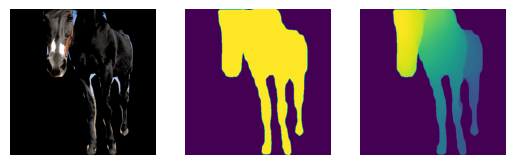

  4%|██▊                                                                    | 24/600 [00:00<00:04, 116.73it/s]

tensor(0.2442, device='cuda:0') tensor(0.4116, device='cuda:0')
tensor(0.2445, device='cuda:0') tensor(0.4118, device='cuda:0')
tensor(0.2448, device='cuda:0') tensor(0.4120, device='cuda:0')
tensor(0.2449, device='cuda:0') tensor(0.4123, device='cuda:0')
tensor(0.2450, device='cuda:0') tensor(0.4124, device='cuda:0')
tensor(0.2450, device='cuda:0') tensor(0.4125, device='cuda:0')
tensor(0.2451, device='cuda:0') tensor(0.4128, device='cuda:0')
tensor(0.2450, device='cuda:0') tensor(0.4130, device='cuda:0')
tensor(0.2450, device='cuda:0') tensor(0.4132, device='cuda:0')
tensor(0.2448, device='cuda:0') tensor(0.4136, device='cuda:0')
tensor(0.2446, device='cuda:0') tensor(0.4139, device='cuda:0')
tensor(0.2443, device='cuda:0') tensor(0.4141, device='cuda:0')
tensor(0.2442, device='cuda:0') tensor(0.4143, device='cuda:0')
tensor(0.2440, device='cuda:0') tensor(0.4146, device='cuda:0')
tensor(0.2438, device='cuda:0') tensor(0.4148, device='cuda:0')
tensor(0.2436, device='cuda:0') tensor(0

  8%|█████▋                                                                 | 48/600 [00:00<00:04, 118.69it/s]

tensor(0.2411, device='cuda:0') tensor(0.4177, device='cuda:0')
tensor(0.2406, device='cuda:0') tensor(0.4178, device='cuda:0')
tensor(0.2399, device='cuda:0') tensor(0.4180, device='cuda:0')
tensor(0.2394, device='cuda:0') tensor(0.4185, device='cuda:0')
tensor(0.2389, device='cuda:0') tensor(0.4187, device='cuda:0')
tensor(0.2382, device='cuda:0') tensor(0.4191, device='cuda:0')
tensor(0.2377, device='cuda:0') tensor(0.4196, device='cuda:0')
tensor(0.2371, device='cuda:0') tensor(0.4202, device='cuda:0')
tensor(0.2365, device='cuda:0') tensor(0.4207, device='cuda:0')
tensor(0.2359, device='cuda:0') tensor(0.4251, device='cuda:0')
tensor(0.2353, device='cuda:0') tensor(0.4340, device='cuda:0')
tensor(0.2347, device='cuda:0') tensor(0.4456, device='cuda:0')
tensor(0.2340, device='cuda:0') tensor(0.4612, device='cuda:0')
tensor(0.2334, device='cuda:0') tensor(0.4813, device='cuda:0')
tensor(0.2329, device='cuda:0') tensor(0.5007, device='cuda:0')
tensor(0.2324, device='cuda:0') tensor(0

 10%|███████                                                                | 60/600 [00:00<00:04, 118.59it/s]

tensor(0.2250, device='cuda:0') tensor(0.6427, device='cuda:0')
tensor(0.2241, device='cuda:0') tensor(0.6395, device='cuda:0')
tensor(0.2235, device='cuda:0') tensor(0.6334, device='cuda:0')
tensor(0.2227, device='cuda:0') tensor(0.6266, device='cuda:0')
tensor(0.2220, device='cuda:0') tensor(0.6208, device='cuda:0')
tensor(0.2210, device='cuda:0') tensor(0.6143, device='cuda:0')
tensor(0.2201, device='cuda:0') tensor(0.6061, device='cuda:0')
tensor(0.2190, device='cuda:0') tensor(0.5744, device='cuda:0')
tensor(0.2184, device='cuda:0') tensor(0.5601, device='cuda:0')
tensor(0.2178, device='cuda:0') tensor(0.5604, device='cuda:0')
tensor(0.2172, device='cuda:0') tensor(0.5614, device='cuda:0')
tensor(0.2167, device='cuda:0') tensor(0.5628, device='cuda:0')
tensor(0.2163, device='cuda:0') tensor(0.5649, device='cuda:0')
tensor(0.2161, device='cuda:0') tensor(0.5669, device='cuda:0')
tensor(0.2159, device='cuda:0') tensor(0.5687, device='cuda:0')
tensor(0.2159, device='cuda:0') tensor(0

 14%|██████████▏                                                            | 86/600 [00:00<00:04, 116.88it/s]

tensor(0.2174, device='cuda:0') tensor(0.5834, device='cuda:0')
tensor(0.2176, device='cuda:0') tensor(0.5842, device='cuda:0')
tensor(0.2177, device='cuda:0') tensor(0.5852, device='cuda:0')
tensor(0.2185, device='cuda:0') tensor(0.5849, device='cuda:0')
tensor(0.2281, device='cuda:0') tensor(0.5850, device='cuda:0')
tensor(0.2447, device='cuda:0') tensor(0.5845, device='cuda:0')
tensor(0.2695, device='cuda:0') tensor(0.5845, device='cuda:0')
tensor(0.2973, device='cuda:0') tensor(0.5846, device='cuda:0')


 86%|████████████████████████████████████████████████████████████▏         | 516/600 [00:05<00:00, 100.55it/s]

tensor(0.2967, device='cuda:0') tensor(0.6751, device='cuda:0')
tensor(0.2909, device='cuda:0') tensor(0.6765, device='cuda:0')
tensor(0.2851, device='cuda:0') tensor(0.6775, device='cuda:0')
tensor(0.2805, device='cuda:0') tensor(0.6780, device='cuda:0')
tensor(0.2755, device='cuda:0') tensor(0.6780, device='cuda:0')
tensor(0.2711, device='cuda:0') tensor(0.6730, device='cuda:0')
tensor(0.2668, device='cuda:0') tensor(0.6355, device='cuda:0')
tensor(0.2633, device='cuda:0') tensor(0.6067, device='cuda:0')
tensor(0.2601, device='cuda:0') tensor(0.5867, device='cuda:0')
tensor(0.2575, device='cuda:0') tensor(0.5676, device='cuda:0')
tensor(0.2548, device='cuda:0') tensor(0.5495, device='cuda:0')
tensor(0.2526, device='cuda:0') tensor(0.5328, device='cuda:0')
tensor(0.2510, device='cuda:0') tensor(0.5194, device='cuda:0')
tensor(0.2501, device='cuda:0') tensor(0.5071, device='cuda:0')
tensor(0.2496, device='cuda:0') tensor(0.4932, device='cuda:0')
tensor(0.2490, device='cuda:0') tensor(0

 90%|███████████████████████████████████████████████████████████████       | 540/600 [00:05<00:00, 109.03it/s]

tensor(0.2176, device='cuda:0') tensor(0.4741, device='cuda:0')
tensor(0.2142, device='cuda:0') tensor(0.4747, device='cuda:0')
tensor(0.2135, device='cuda:0') tensor(0.4753, device='cuda:0')
tensor(0.2127, device='cuda:0') tensor(0.4751, device='cuda:0')
tensor(0.2117, device='cuda:0') tensor(0.4737, device='cuda:0')
tensor(0.2112, device='cuda:0') tensor(0.4723, device='cuda:0')
tensor(0.2106, device='cuda:0') tensor(0.4701, device='cuda:0')
tensor(0.2103, device='cuda:0') tensor(0.4681, device='cuda:0')
tensor(0.2097, device='cuda:0') tensor(0.4657, device='cuda:0')
tensor(0.2094, device='cuda:0') tensor(0.4631, device='cuda:0')
tensor(0.2087, device='cuda:0') tensor(0.4598, device='cuda:0')
tensor(0.2084, device='cuda:0') tensor(0.4570, device='cuda:0')
tensor(0.2083, device='cuda:0') tensor(0.4540, device='cuda:0')
tensor(0.2082, device='cuda:0') tensor(0.4519, device='cuda:0')
tensor(0.2078, device='cuda:0') tensor(0.4494, device='cuda:0')
tensor(0.2077, device='cuda:0') tensor(0

 94%|█████████████████████████████████████████████████████████████████▉    | 565/600 [00:05<00:00, 114.87it/s]

tensor(0.2085, device='cuda:0') tensor(0.4388, device='cuda:0')
tensor(0.2088, device='cuda:0') tensor(0.4412, device='cuda:0')
tensor(0.2093, device='cuda:0') tensor(0.4426, device='cuda:0')
tensor(0.2097, device='cuda:0') tensor(0.4430, device='cuda:0')
tensor(0.2098, device='cuda:0') tensor(0.4428, device='cuda:0')
tensor(0.2101, device='cuda:0') tensor(0.4424, device='cuda:0')
tensor(0.2107, device='cuda:0') tensor(0.4420, device='cuda:0')
tensor(0.2114, device='cuda:0') tensor(0.4414, device='cuda:0')
tensor(0.2119, device='cuda:0') tensor(0.4406, device='cuda:0')
tensor(0.2127, device='cuda:0') tensor(0.4398, device='cuda:0')
tensor(0.2141, device='cuda:0') tensor(0.4393, device='cuda:0')
tensor(0.2176, device='cuda:0') tensor(0.4385, device='cuda:0')
tensor(0.2226, device='cuda:0') tensor(0.4374, device='cuda:0')
tensor(0.2291, device='cuda:0') tensor(0.4332, device='cuda:0')
tensor(0.2349, device='cuda:0') tensor(0.4284, device='cuda:0')
tensor(0.2413, device='cuda:0') tensor(0

 98%|████████████████████████████████████████████████████████████████████▊ | 590/600 [00:06<00:00, 117.79it/s]

tensor(0.2744, device='cuda:0') tensor(0.4098, device='cuda:0')
tensor(0.2757, device='cuda:0') tensor(0.4098, device='cuda:0')
tensor(0.2766, device='cuda:0') tensor(0.4099, device='cuda:0')
tensor(0.2774, device='cuda:0') tensor(0.4097, device='cuda:0')
tensor(0.2779, device='cuda:0') tensor(0.4097, device='cuda:0')
tensor(0.2780, device='cuda:0') tensor(0.4098, device='cuda:0')
tensor(0.2781, device='cuda:0') tensor(0.4097, device='cuda:0')
tensor(0.2776, device='cuda:0') tensor(0.4096, device='cuda:0')
tensor(0.2769, device='cuda:0') tensor(0.4096, device='cuda:0')
tensor(0.2753, device='cuda:0') tensor(0.4095, device='cuda:0')
tensor(0.2734, device='cuda:0') tensor(0.4095, device='cuda:0')
tensor(0.2700, device='cuda:0') tensor(0.4095, device='cuda:0')
tensor(0.2665, device='cuda:0') tensor(0.4097, device='cuda:0')
tensor(0.2624, device='cuda:0') tensor(0.4099, device='cuda:0')
tensor(0.2578, device='cuda:0') tensor(0.4099, device='cuda:0')
tensor(0.2526, device='cuda:0') tensor(0

100%|███████████████████████████████████████████████████████████████████████| 600/600 [00:06<00:00, 96.42it/s]


tensor(0.2430, device='cuda:0') tensor(0.4110, device='cuda:0')
tensor(0.2435, device='cuda:0') tensor(0.4112, device='cuda:0')
tensor(0.2439, device='cuda:0') tensor(0.4114, device='cuda:0')
/grogu/user/akirchme/art3d_sd_webui/images/horse/1377.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/1377.mp4


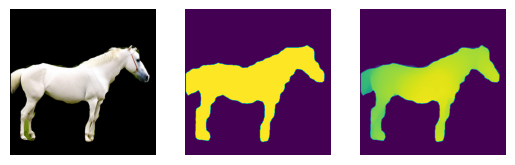

 40%|███████████████████████████▊                                          | 238/600 [00:02<00:03, 114.36it/s]

tensor(0.3321, device='cuda:0') tensor(0.4929, device='cuda:0')
tensor(0.3302, device='cuda:0') tensor(0.4909, device='cuda:0')
tensor(0.3238, device='cuda:0') tensor(0.4910, device='cuda:0')
tensor(0.3164, device='cuda:0') tensor(0.4910, device='cuda:0')
tensor(0.3062, device='cuda:0') tensor(0.4910, device='cuda:0')
tensor(0.2889, device='cuda:0') tensor(0.4910, device='cuda:0')
tensor(0.2728, device='cuda:0') tensor(0.4911, device='cuda:0')
tensor(0.2597, device='cuda:0') tensor(0.4913, device='cuda:0')
tensor(0.2582, device='cuda:0') tensor(0.4914, device='cuda:0')
tensor(0.2582, device='cuda:0') tensor(0.4915, device='cuda:0')
tensor(0.2582, device='cuda:0') tensor(0.4917, device='cuda:0')
tensor(0.2581, device='cuda:0') tensor(0.4919, device='cuda:0')
tensor(0.2580, device='cuda:0') tensor(0.4920, device='cuda:0')
tensor(0.2580, device='cuda:0') tensor(0.4920, device='cuda:0')
tensor(0.2579, device='cuda:0') tensor(0.4921, device='cuda:0')
tensor(0.2580, device='cuda:0') tensor(0

 44%|██████████████████████████████▋                                       | 263/600 [00:02<00:02, 117.57it/s]

tensor(0.2591, device='cuda:0') tensor(0.4908, device='cuda:0')
tensor(0.2591, device='cuda:0') tensor(0.4909, device='cuda:0')
tensor(0.2592, device='cuda:0') tensor(0.4909, device='cuda:0')
tensor(0.2593, device='cuda:0') tensor(0.4913, device='cuda:0')
tensor(0.2594, device='cuda:0') tensor(0.4920, device='cuda:0')
tensor(0.2597, device='cuda:0') tensor(0.4938, device='cuda:0')
tensor(0.2598, device='cuda:0') tensor(0.4956, device='cuda:0')
tensor(0.2601, device='cuda:0') tensor(0.4980, device='cuda:0')
tensor(0.2603, device='cuda:0') tensor(0.5022, device='cuda:0')
tensor(0.2605, device='cuda:0') tensor(0.5051, device='cuda:0')
tensor(0.2609, device='cuda:0') tensor(0.5083, device='cuda:0')
tensor(0.2610, device='cuda:0') tensor(0.5143, device='cuda:0')
tensor(0.2612, device='cuda:0') tensor(0.5148, device='cuda:0')
tensor(0.2614, device='cuda:0') tensor(0.5150, device='cuda:0')
tensor(0.2616, device='cuda:0') tensor(0.5151, device='cuda:0')
tensor(0.2617, device='cuda:0') tensor(0

 48%|█████████████████████████████████▌                                    | 288/600 [00:02<00:02, 119.89it/s]

tensor(0.2641, device='cuda:0') tensor(0.4494, device='cuda:0')
tensor(0.2642, device='cuda:0') tensor(0.4414, device='cuda:0')
tensor(0.2644, device='cuda:0') tensor(0.4414, device='cuda:0')
tensor(0.2646, device='cuda:0') tensor(0.4414, device='cuda:0')
tensor(0.2647, device='cuda:0') tensor(0.4414, device='cuda:0')
tensor(0.2647, device='cuda:0') tensor(0.4412, device='cuda:0')
tensor(0.2647, device='cuda:0') tensor(0.4413, device='cuda:0')
tensor(0.2648, device='cuda:0') tensor(0.4414, device='cuda:0')
tensor(0.2648, device='cuda:0') tensor(0.4415, device='cuda:0')
tensor(0.2647, device='cuda:0') tensor(0.4415, device='cuda:0')
tensor(0.2646, device='cuda:0') tensor(0.4416, device='cuda:0')
tensor(0.2646, device='cuda:0') tensor(0.4415, device='cuda:0')
tensor(0.2645, device='cuda:0') tensor(0.4415, device='cuda:0')
tensor(0.2644, device='cuda:0') tensor(0.4414, device='cuda:0')
tensor(0.2641, device='cuda:0') tensor(0.4416, device='cuda:0')
tensor(0.2641, device='cuda:0') tensor(0

 52%|████████████████████████████████████▋                                 | 314/600 [00:03<00:02, 121.88it/s]

tensor(0.2623, device='cuda:0') tensor(0.4415, device='cuda:0')
tensor(0.2622, device='cuda:0') tensor(0.4416, device='cuda:0')
tensor(0.2620, device='cuda:0') tensor(0.4416, device='cuda:0')
tensor(0.2616, device='cuda:0') tensor(0.4418, device='cuda:0')
tensor(0.2612, device='cuda:0') tensor(0.4418, device='cuda:0')
tensor(0.2610, device='cuda:0') tensor(0.4418, device='cuda:0')
tensor(0.2608, device='cuda:0') tensor(0.4419, device='cuda:0')
tensor(0.2606, device='cuda:0') tensor(0.4419, device='cuda:0')
tensor(0.2605, device='cuda:0') tensor(0.4420, device='cuda:0')
tensor(0.2602, device='cuda:0') tensor(0.4419, device='cuda:0')
tensor(0.2600, device='cuda:0') tensor(0.4418, device='cuda:0')
tensor(0.2597, device='cuda:0') tensor(0.4418, device='cuda:0')
tensor(0.2596, device='cuda:0') tensor(0.4418, device='cuda:0')
tensor(0.2595, device='cuda:0') tensor(0.4418, device='cuda:0')
tensor(0.2595, device='cuda:0') tensor(0.4418, device='cuda:0')
tensor(0.2594, device='cuda:0') tensor(0

 57%|███████████████████████████████████████▋                              | 340/600 [00:03<00:02, 120.59it/s]

tensor(0.2593, device='cuda:0') tensor(0.4419, device='cuda:0')
tensor(0.2594, device='cuda:0') tensor(0.4420, device='cuda:0')
tensor(0.2594, device='cuda:0') tensor(0.4420, device='cuda:0')
tensor(0.2594, device='cuda:0') tensor(0.4421, device='cuda:0')
tensor(0.2594, device='cuda:0') tensor(0.4420, device='cuda:0')
tensor(0.2594, device='cuda:0') tensor(0.4420, device='cuda:0')
tensor(0.2595, device='cuda:0') tensor(0.4419, device='cuda:0')
tensor(0.2594, device='cuda:0') tensor(0.4420, device='cuda:0')
tensor(0.2595, device='cuda:0') tensor(0.4420, device='cuda:0')
tensor(0.2595, device='cuda:0') tensor(0.4420, device='cuda:0')
tensor(0.2594, device='cuda:0') tensor(0.4419, device='cuda:0')
tensor(0.2594, device='cuda:0') tensor(0.4418, device='cuda:0')
tensor(0.2592, device='cuda:0') tensor(0.4418, device='cuda:0')
tensor(0.2590, device='cuda:0') tensor(0.4418, device='cuda:0')
tensor(0.2589, device='cuda:0') tensor(0.4417, device='cuda:0')
tensor(0.2588, device='cuda:0') tensor(0

 61%|██████████████████████████████████████████▋                           | 366/600 [00:03<00:01, 119.45it/s]

tensor(0.2576, device='cuda:0') tensor(0.7288, device='cuda:0')
tensor(0.2576, device='cuda:0') tensor(0.7292, device='cuda:0')
tensor(0.2576, device='cuda:0') tensor(0.7296, device='cuda:0')
tensor(0.2575, device='cuda:0') tensor(0.7297, device='cuda:0')
tensor(0.2575, device='cuda:0') tensor(0.7298, device='cuda:0')
tensor(0.2574, device='cuda:0') tensor(0.7266, device='cuda:0')
tensor(0.2574, device='cuda:0') tensor(0.6978, device='cuda:0')
tensor(0.2573, device='cuda:0') tensor(0.6671, device='cuda:0')
tensor(0.2574, device='cuda:0') tensor(0.6382, device='cuda:0')
tensor(0.2573, device='cuda:0') tensor(0.6113, device='cuda:0')
tensor(0.2572, device='cuda:0') tensor(0.6016, device='cuda:0')
tensor(0.2572, device='cuda:0') tensor(0.5988, device='cuda:0')
tensor(0.2570, device='cuda:0') tensor(0.5963, device='cuda:0')
tensor(0.2570, device='cuda:0') tensor(0.5946, device='cuda:0')
tensor(0.2569, device='cuda:0') tensor(0.5940, device='cuda:0')
tensor(0.2569, device='cuda:0') tensor(0

 63%|████████████████████████████████████████████▏                         | 379/600 [00:03<00:01, 119.60it/s]

tensor(0.2567, device='cuda:0') tensor(0.5907, device='cuda:0')
tensor(0.2567, device='cuda:0') tensor(0.5906, device='cuda:0')
tensor(0.2569, device='cuda:0') tensor(0.5907, device='cuda:0')
tensor(0.2569, device='cuda:0') tensor(0.5909, device='cuda:0')
tensor(0.2569, device='cuda:0') tensor(0.5909, device='cuda:0')
tensor(0.2568, device='cuda:0') tensor(0.5908, device='cuda:0')
tensor(0.2568, device='cuda:0') tensor(0.5910, device='cuda:0')
tensor(0.2569, device='cuda:0') tensor(0.5909, device='cuda:0')
tensor(0.2568, device='cuda:0') tensor(0.5910, device='cuda:0')
tensor(0.2567, device='cuda:0') tensor(0.5909, device='cuda:0')
tensor(0.2675, device='cuda:0') tensor(0.5909, device='cuda:0')


100%|██████████████████████████████████████████████████████████████████████| 600/600 [00:05<00:00, 104.33it/s]


/grogu/user/akirchme/art3d_sd_webui/images/horse/393.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/393.mp4


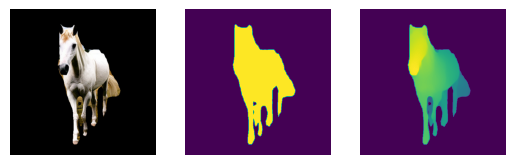

  2%|█▌                                                                     | 13/600 [00:00<00:04, 120.96it/s]

tensor(0.2972, device='cuda:0') tensor(0.4741, device='cuda:0')
tensor(0.2972, device='cuda:0') tensor(0.4740, device='cuda:0')
tensor(0.2969, device='cuda:0') tensor(0.4741, device='cuda:0')
tensor(0.2967, device='cuda:0') tensor(0.4741, device='cuda:0')
tensor(0.2967, device='cuda:0') tensor(0.4739, device='cuda:0')
tensor(0.2964, device='cuda:0') tensor(0.4739, device='cuda:0')
tensor(0.2959, device='cuda:0') tensor(0.4738, device='cuda:0')
tensor(0.2955, device='cuda:0') tensor(0.4737, device='cuda:0')
tensor(0.2952, device='cuda:0') tensor(0.4736, device='cuda:0')
tensor(0.2949, device='cuda:0') tensor(0.4734, device='cuda:0')
tensor(0.2947, device='cuda:0') tensor(0.4735, device='cuda:0')
tensor(0.2945, device='cuda:0') tensor(0.4735, device='cuda:0')
tensor(0.2945, device='cuda:0') tensor(0.4733, device='cuda:0')
tensor(0.2945, device='cuda:0') tensor(0.4730, device='cuda:0')
tensor(0.2944, device='cuda:0') tensor(0.4730, device='cuda:0')
tensor(0.2942, device='cuda:0') tensor(0

  6%|████▌                                                                  | 39/600 [00:00<00:04, 122.16it/s]

tensor(0.2993, device='cuda:0') tensor(0.4708, device='cuda:0')
tensor(0.2987, device='cuda:0') tensor(0.4703, device='cuda:0')
tensor(0.2977, device='cuda:0') tensor(0.4701, device='cuda:0')
tensor(0.2965, device='cuda:0') tensor(0.4702, device='cuda:0')
tensor(0.2951, device='cuda:0') tensor(0.4702, device='cuda:0')
tensor(0.2933, device='cuda:0') tensor(0.4703, device='cuda:0')
tensor(0.2916, device='cuda:0') tensor(0.4704, device='cuda:0')
tensor(0.2900, device='cuda:0') tensor(0.4706, device='cuda:0')
tensor(0.2881, device='cuda:0') tensor(0.4755, device='cuda:0')
tensor(0.2859, device='cuda:0') tensor(0.4811, device='cuda:0')
tensor(0.2837, device='cuda:0') tensor(0.4908, device='cuda:0')
tensor(0.2820, device='cuda:0') tensor(0.5040, device='cuda:0')
tensor(0.2805, device='cuda:0') tensor(0.5194, device='cuda:0')
tensor(0.2791, device='cuda:0') tensor(0.5337, device='cuda:0')
tensor(0.2778, device='cuda:0') tensor(0.5479, device='cuda:0')
tensor(0.2762, device='cuda:0') tensor(0

 11%|███████▋                                                               | 65/600 [00:00<00:04, 122.25it/s]

tensor(0.2689, device='cuda:0') tensor(0.5630, device='cuda:0')
tensor(0.2684, device='cuda:0') tensor(0.5520, device='cuda:0')
tensor(0.2680, device='cuda:0') tensor(0.5442, device='cuda:0')
tensor(0.2675, device='cuda:0') tensor(0.5375, device='cuda:0')
tensor(0.2668, device='cuda:0') tensor(0.5299, device='cuda:0')
tensor(0.2664, device='cuda:0') tensor(0.5265, device='cuda:0')
tensor(0.2662, device='cuda:0') tensor(0.5264, device='cuda:0')
tensor(0.2657, device='cuda:0') tensor(0.5255, device='cuda:0')
tensor(0.2651, device='cuda:0') tensor(0.5249, device='cuda:0')
tensor(0.2652, device='cuda:0') tensor(0.5250, device='cuda:0')
tensor(0.2654, device='cuda:0') tensor(0.5251, device='cuda:0')
tensor(0.2650, device='cuda:0') tensor(0.5254, device='cuda:0')
tensor(0.2648, device='cuda:0') tensor(0.5258, device='cuda:0')
tensor(0.2651, device='cuda:0') tensor(0.5273, device='cuda:0')
tensor(0.2653, device='cuda:0') tensor(0.5285, device='cuda:0')
tensor(0.2654, device='cuda:0') tensor(0

 15%|██████████▊                                                            | 91/600 [00:00<00:04, 118.96it/s]

tensor(0.5302, device='cuda:0')
tensor(0.2693, device='cuda:0') tensor(0.5289, device='cuda:0')
tensor(0.2777, device='cuda:0') tensor(0.5281, device='cuda:0')
tensor(0.2916, device='cuda:0') tensor(0.5271, device='cuda:0')


 89%|██████████████████████████████████████████████████████████████▎       | 534/600 [00:04<00:00, 118.78it/s]

tensor(0.2943, device='cuda:0') tensor(0.5524, device='cuda:0')
tensor(0.2800, device='cuda:0') tensor(0.5536, device='cuda:0')
tensor(0.2694, device='cuda:0') tensor(0.5544, device='cuda:0')
tensor(0.2686, device='cuda:0') tensor(0.5548, device='cuda:0')
tensor(0.2687, device='cuda:0') tensor(0.5550, device='cuda:0')
tensor(0.2683, device='cuda:0') tensor(0.5556, device='cuda:0')
tensor(0.2680, device='cuda:0') tensor(0.5563, device='cuda:0')
tensor(0.2679, device='cuda:0') tensor(0.5572, device='cuda:0')
tensor(0.2677, device='cuda:0') tensor(0.5578, device='cuda:0')
tensor(0.2677, device='cuda:0') tensor(0.5585, device='cuda:0')
tensor(0.2676, device='cuda:0') tensor(0.5584, device='cuda:0')
tensor(0.2678, device='cuda:0') tensor(0.5579, device='cuda:0')
tensor(0.2678, device='cuda:0') tensor(0.5574, device='cuda:0')
tensor(0.2680, device='cuda:0') tensor(0.5565, device='cuda:0')
tensor(0.2681, device='cuda:0') tensor(0.5557, device='cuda:0')
tensor(0.2683, device='cuda:0') tensor(0

 95%|██████████████████████████████████████████████████████████████████▌   | 570/600 [00:04<00:00, 118.68it/s]

tensor(0.2719, device='cuda:0') tensor(0.5647, device='cuda:0')
tensor(0.2724, device='cuda:0') tensor(0.5757, device='cuda:0')
tensor(0.2730, device='cuda:0') tensor(0.5785, device='cuda:0')
tensor(0.2735, device='cuda:0') tensor(0.5806, device='cuda:0')
tensor(0.2740, device='cuda:0') tensor(0.5831, device='cuda:0')
tensor(0.2744, device='cuda:0') tensor(0.5877, device='cuda:0')
tensor(0.2750, device='cuda:0') tensor(0.5908, device='cuda:0')
tensor(0.2757, device='cuda:0') tensor(0.5909, device='cuda:0')
tensor(0.2764, device='cuda:0') tensor(0.5904, device='cuda:0')
tensor(0.2776, device='cuda:0') tensor(0.5897, device='cuda:0')
tensor(0.2783, device='cuda:0') tensor(0.5889, device='cuda:0')
tensor(0.2791, device='cuda:0') tensor(0.5885, device='cuda:0')
tensor(0.2796, device='cuda:0') tensor(0.5881, device='cuda:0')
tensor(0.2803, device='cuda:0') tensor(0.5811, device='cuda:0')
tensor(0.2812, device='cuda:0') tensor(0.5506, device='cuda:0')
tensor(0.2822, device='cuda:0') tensor(0

 97%|████████████████████████████████████████████████████████████████████  | 583/600 [00:04<00:00, 119.76it/s]

tensor(0.2903, device='cuda:0') tensor(0.4787, device='cuda:0')
tensor(0.2913, device='cuda:0') tensor(0.4783, device='cuda:0')
tensor(0.2921, device='cuda:0') tensor(0.4781, device='cuda:0')
tensor(0.2930, device='cuda:0') tensor(0.4780, device='cuda:0')
tensor(0.2936, device='cuda:0') tensor(0.4778, device='cuda:0')
tensor(0.2942, device='cuda:0') tensor(0.4776, device='cuda:0')
tensor(0.2947, device='cuda:0') tensor(0.4775, device='cuda:0')
tensor(0.2953, device='cuda:0') tensor(0.4773, device='cuda:0')
tensor(0.2954, device='cuda:0') tensor(0.4771, device='cuda:0')
tensor(0.2959, device='cuda:0') tensor(0.4769, device='cuda:0')
tensor(0.2958, device='cuda:0') tensor(0.4769, device='cuda:0')
tensor(0.2959, device='cuda:0') tensor(0.4767, device='cuda:0')
tensor(0.2963, device='cuda:0') tensor(0.4764, device='cuda:0')
tensor(0.2964, device='cuda:0') tensor(0.4761, device='cuda:0')
tensor(0.2965, device='cuda:0') tensor(0.4758, device='cuda:0')
tensor(0.2967, device='cuda:0') tensor(0

100%|██████████████████████████████████████████████████████████████████████| 600/600 [00:04<00:00, 120.84it/s]


tensor(0.2975, device='cuda:0') tensor(0.4746, device='cuda:0')
tensor(0.2975, device='cuda:0') tensor(0.4746, device='cuda:0')
tensor(0.2976, device='cuda:0') tensor(0.4743, device='cuda:0')
tensor(0.2974, device='cuda:0') tensor(0.4743, device='cuda:0')
tensor(0.2973, device='cuda:0') tensor(0.4743, device='cuda:0')
/grogu/user/akirchme/art3d_sd_webui/images/horse/1716.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/1716.mp4


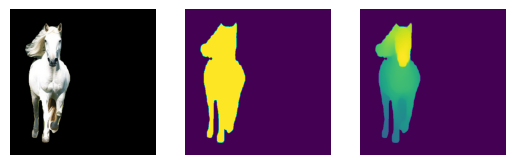

 41%|████████████████████████████▉                                         | 248/600 [00:02<00:02, 121.51it/s]

tensor(0.2921, device='cuda:0') tensor(0.5860, device='cuda:0')
tensor(0.2914, device='cuda:0') tensor(0.5871, device='cuda:0')
tensor(0.2915, device='cuda:0') tensor(0.5882, device='cuda:0')
tensor(0.2917, device='cuda:0') tensor(0.5894, device='cuda:0')
tensor(0.2918, device='cuda:0') tensor(0.5901, device='cuda:0')
tensor(0.2917, device='cuda:0') tensor(0.5901, device='cuda:0')
tensor(0.2919, device='cuda:0') tensor(0.5901, device='cuda:0')
tensor(0.2920, device='cuda:0') tensor(0.5894, device='cuda:0')
tensor(0.2920, device='cuda:0') tensor(0.5892, device='cuda:0')
tensor(0.2921, device='cuda:0') tensor(0.5884, device='cuda:0')
tensor(0.2922, device='cuda:0') tensor(0.5880, device='cuda:0')
tensor(0.2923, device='cuda:0') tensor(0.5869, device='cuda:0')
tensor(0.2924, device='cuda:0') tensor(0.5859, device='cuda:0')
tensor(0.2924, device='cuda:0') tensor(0.5845, device='cuda:0')
tensor(0.2926, device='cuda:0') tensor(0.5835, device='cuda:0')
tensor(0.2928, device='cuda:0') tensor(0

 44%|██████████████████████████████▍                                       | 261/600 [00:02<00:02, 120.99it/s]

tensor(0.2954, device='cuda:0') tensor(0.5837, device='cuda:0')
tensor(0.2959, device='cuda:0') tensor(0.5891, device='cuda:0')
tensor(0.2967, device='cuda:0') tensor(0.5957, device='cuda:0')
tensor(0.2976, device='cuda:0') tensor(0.6043, device='cuda:0')
tensor(0.2984, device='cuda:0') tensor(0.6096, device='cuda:0')
tensor(0.2986, device='cuda:0') tensor(0.6128, device='cuda:0')
tensor(0.2992, device='cuda:0') tensor(0.6115, device='cuda:0')
tensor(0.2999, device='cuda:0') tensor(0.6106, device='cuda:0')
tensor(0.3073, device='cuda:0') tensor(0.5170, device='cuda:0')
tensor(0.3081, device='cuda:0') tensor(0.4955, device='cuda:0')
tensor(0.3090, device='cuda:0') tensor(0.4783, device='cuda:0')
tensor(0.3100, device='cuda:0') tensor(0.4637, device='cuda:0')
tensor(0.3111, device='cuda:0') tensor(0.4557, device='cuda:0')
tensor(0.3118, device='cuda:0') tensor(0.4555, device='cuda:0')
tensor(0.3126, device='cuda:0') tensor(0.4551, device='cuda:0')
tensor(0.3135, device='cuda:0') tensor(0

 48%|█████████████████████████████████▍                                    | 287/600 [00:02<00:02, 121.74it/s]

tensor(0.3142, device='cuda:0') tensor(0.4546, device='cuda:0')
tensor(0.3143, device='cuda:0') tensor(0.4546, device='cuda:0')
tensor(0.3149, device='cuda:0') tensor(0.4544, device='cuda:0')
tensor(0.3151, device='cuda:0') tensor(0.4542, device='cuda:0')
tensor(0.3153, device='cuda:0') tensor(0.4540, device='cuda:0')
tensor(0.3156, device='cuda:0') tensor(0.4538, device='cuda:0')
tensor(0.3157, device='cuda:0') tensor(0.4538, device='cuda:0')
tensor(0.3156, device='cuda:0') tensor(0.4538, device='cuda:0')
tensor(0.3157, device='cuda:0') tensor(0.4538, device='cuda:0')
tensor(0.3156, device='cuda:0') tensor(0.4537, device='cuda:0')
tensor(0.3153, device='cuda:0') tensor(0.4535, device='cuda:0')
tensor(0.3154, device='cuda:0') tensor(0.4536, device='cuda:0')
tensor(0.3154, device='cuda:0') tensor(0.4538, device='cuda:0')
tensor(0.3151, device='cuda:0') tensor(0.4536, device='cuda:0')
tensor(0.3151, device='cuda:0') tensor(0.4536, device='cuda:0')
tensor(0.3147, device='cuda:0') tensor(0

 52%|████████████████████████████████████▌                                 | 313/600 [00:02<00:02, 120.44it/s]

tensor(0.3147, device='cuda:0') tensor(0.4530, device='cuda:0')
tensor(0.3143, device='cuda:0') tensor(0.4528, device='cuda:0')
tensor(0.3144, device='cuda:0') tensor(0.4527, device='cuda:0')
tensor(0.3143, device='cuda:0') tensor(0.4529, device='cuda:0')
tensor(0.3140, device='cuda:0') tensor(0.4527, device='cuda:0')
tensor(0.3139, device='cuda:0') tensor(0.4527, device='cuda:0')
tensor(0.3138, device='cuda:0') tensor(0.4525, device='cuda:0')
tensor(0.3137, device='cuda:0') tensor(0.4523, device='cuda:0')
tensor(0.3132, device='cuda:0') tensor(0.4524, device='cuda:0')
tensor(0.3128, device='cuda:0') tensor(0.4523, device='cuda:0')
tensor(0.3126, device='cuda:0') tensor(0.4523, device='cuda:0')
tensor(0.3121, device='cuda:0') tensor(0.4523, device='cuda:0')
tensor(0.3117, device='cuda:0') tensor(0.4522, device='cuda:0')
tensor(0.3114, device='cuda:0') tensor(0.4521, device='cuda:0')
tensor(0.3110, device='cuda:0') tensor(0.4520, device='cuda:0')
tensor(0.3106, device='cuda:0') tensor(0

 56%|███████████████████████████████████████▍                              | 338/600 [00:02<00:02, 119.08it/s]

tensor(0.3084, device='cuda:0') tensor(0.4514, device='cuda:0')
tensor(0.3082, device='cuda:0') tensor(0.4513, device='cuda:0')
tensor(0.3080, device='cuda:0') tensor(0.4513, device='cuda:0')
tensor(0.3075, device='cuda:0') tensor(0.4510, device='cuda:0')
tensor(0.3066, device='cuda:0') tensor(0.4508, device='cuda:0')
tensor(0.3061, device='cuda:0') tensor(0.4505, device='cuda:0')
tensor(0.3054, device='cuda:0') tensor(0.4505, device='cuda:0')
tensor(0.3044, device='cuda:0') tensor(0.4504, device='cuda:0')
tensor(0.3036, device='cuda:0') tensor(0.4504, device='cuda:0')
tensor(0.3030, device='cuda:0') tensor(0.4501, device='cuda:0')
tensor(0.3022, device='cuda:0') tensor(0.4504, device='cuda:0')
tensor(0.3011, device='cuda:0') tensor(0.4518, device='cuda:0')
tensor(0.3003, device='cuda:0') tensor(0.4548, device='cuda:0')
tensor(0.2985, device='cuda:0') tensor(0.4597, device='cuda:0')
tensor(0.2973, device='cuda:0') tensor(0.4674, device='cuda:0')
tensor(0.2961, device='cuda:0') tensor(0

 61%|██████████████████████████████████████████▍                           | 364/600 [00:02<00:01, 119.50it/s]

tensor(0.2887, device='cuda:0') tensor(0.5213, device='cuda:0')
tensor(0.2884, device='cuda:0') tensor(0.5223, device='cuda:0')
tensor(0.2878, device='cuda:0') tensor(0.5228, device='cuda:0')
tensor(0.2875, device='cuda:0') tensor(0.5226, device='cuda:0')
tensor(0.2872, device='cuda:0') tensor(0.5193, device='cuda:0')
tensor(0.2865, device='cuda:0') tensor(0.5166, device='cuda:0')
tensor(0.2860, device='cuda:0') tensor(0.5116, device='cuda:0')
tensor(0.2855, device='cuda:0') tensor(0.5066, device='cuda:0')
tensor(0.2850, device='cuda:0') tensor(0.5050, device='cuda:0')
tensor(0.2846, device='cuda:0') tensor(0.5034, device='cuda:0')
tensor(0.2841, device='cuda:0') tensor(0.5039, device='cuda:0')
tensor(0.2834, device='cuda:0') tensor(0.5049, device='cuda:0')
tensor(0.2825, device='cuda:0') tensor(0.5061, device='cuda:0')
tensor(0.2824, device='cuda:0') tensor(0.5080, device='cuda:0')
tensor(0.2825, device='cuda:0') tensor(0.5096, device='cuda:0')
tensor(0.2826, device='cuda:0') tensor(0

 65%|█████████████████████████████████████████████▍                        | 389/600 [00:03<00:01, 120.38it/s]

tensor(0.2849, device='cuda:0') tensor(0.5193, device='cuda:0')
tensor(0.2854, device='cuda:0') tensor(0.5194, device='cuda:0')
tensor(0.2860, device='cuda:0') tensor(0.5194, device='cuda:0')
tensor(0.2864, device='cuda:0') tensor(0.5190, device='cuda:0')
tensor(0.2867, device='cuda:0') tensor(0.5184, device='cuda:0')
tensor(0.2868, device='cuda:0') tensor(0.5178, device='cuda:0')
tensor(0.2872, device='cuda:0') tensor(0.5167, device='cuda:0')
tensor(0.2902, device='cuda:0') tensor(0.5159, device='cuda:0')
tensor(0.2970, device='cuda:0') tensor(0.5145, device='cuda:0')
tensor(0.3091, device='cuda:0') tensor(0.5140, device='cuda:0')
tensor(0.3238, device='cuda:0') tensor(0.5130, device='cuda:0')
tensor(0.3389, device='cuda:0') tensor(0.5119, device='cuda:0')
tensor(0.3514, device='cuda:0') tensor(0.5100, device='cuda:0')
tensor(0.3564, device='cuda:0') tensor(0.5097, device='cuda:0')
tensor(0.3575, device='cuda:0') tensor(0.5114, device='cuda:0')
tensor(0.3584, device='cuda:0') tensor(0

100%|██████████████████████████████████████████████████████████████████████| 600/600 [00:05<00:00, 114.72it/s]


/grogu/user/akirchme/art3d_sd_webui/images/horse/1253.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/1253.mp4


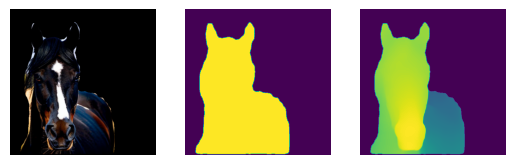

  4%|██▊                                                                    | 24/600 [00:00<00:04, 115.90it/s]

tensor(0.3239, device='cuda:0') tensor(0.5145, device='cuda:0')
tensor(0.3244, device='cuda:0') tensor(0.5145, device='cuda:0')
tensor(0.3246, device='cuda:0') tensor(0.5146, device='cuda:0')
tensor(0.3247, device='cuda:0') tensor(0.5147, device='cuda:0')
tensor(0.3249, device='cuda:0') tensor(0.5147, device='cuda:0')
tensor(0.3249, device='cuda:0') tensor(0.5149, device='cuda:0')
tensor(0.3250, device='cuda:0') tensor(0.5149, device='cuda:0')
tensor(0.3250, device='cuda:0') tensor(0.5150, device='cuda:0')
tensor(0.3249, device='cuda:0') tensor(0.5152, device='cuda:0')
tensor(0.3249, device='cuda:0') tensor(0.5153, device='cuda:0')
tensor(0.3250, device='cuda:0') tensor(0.5154, device='cuda:0')
tensor(0.3250, device='cuda:0') tensor(0.5155, device='cuda:0')
tensor(0.3250, device='cuda:0') tensor(0.5156, device='cuda:0')
tensor(0.3252, device='cuda:0') tensor(0.5157, device='cuda:0')
tensor(0.3255, device='cuda:0') tensor(0.5158, device='cuda:0')
tensor(0.3259, device='cuda:0') tensor(0

  6%|████▎                                                                  | 36/600 [00:00<00:05, 112.40it/s]

tensor(0.3283, device='cuda:0') tensor(0.5165, device='cuda:0')
tensor(0.3281, device='cuda:0') tensor(0.5166, device='cuda:0')
tensor(0.3279, device='cuda:0') tensor(0.5167, device='cuda:0')
tensor(0.3276, device='cuda:0') tensor(0.5168, device='cuda:0')
tensor(0.3273, device='cuda:0') tensor(0.5168, device='cuda:0')
tensor(0.3268, device='cuda:0') tensor(0.5169, device='cuda:0')
tensor(0.3261, device='cuda:0') tensor(0.5170, device='cuda:0')
tensor(0.3253, device='cuda:0') tensor(0.5171, device='cuda:0')
tensor(0.3245, device='cuda:0') tensor(0.5172, device='cuda:0')


 12%|████████▎                                                               | 69/600 [00:00<00:05, 93.12it/s]

tensor(0.3106, device='cuda:0') tensor(0.5197, device='cuda:0')
tensor(0.3097, device='cuda:0') tensor(0.5182, device='cuda:0')
tensor(0.3089, device='cuda:0') tensor(0.5184, device='cuda:0')
tensor(0.3080, device='cuda:0') tensor(0.5190, device='cuda:0')
tensor(0.3073, device='cuda:0') tensor(0.5198, device='cuda:0')


 40%|████████████████████████████▎                                          | 239/600 [00:02<00:03, 98.03it/s]

tensor(0.3106, device='cuda:0') tensor(0.5172, device='cuda:0')
tensor(0.3097, device='cuda:0') tensor(0.5117, device='cuda:0')
tensor(0.3088, device='cuda:0') tensor(0.5096, device='cuda:0')
tensor(0.3043, device='cuda:0') tensor(0.5097, device='cuda:0')
tensor(0.2958, device='cuda:0') tensor(0.5099, device='cuda:0')
tensor(0.2884, device='cuda:0') tensor(0.5103, device='cuda:0')
tensor(0.2835, device='cuda:0') tensor(0.5106, device='cuda:0')
tensor(0.2790, device='cuda:0') tensor(0.5110, device='cuda:0')
tensor(0.2749, device='cuda:0') tensor(0.5118, device='cuda:0')
tensor(0.2704, device='cuda:0') tensor(0.5130, device='cuda:0')
tensor(0.2697, device='cuda:0') tensor(0.5138, device='cuda:0')
tensor(0.2696, device='cuda:0') tensor(0.5146, device='cuda:0')
tensor(0.2694, device='cuda:0') tensor(0.5155, device='cuda:0')
tensor(0.2694, device='cuda:0') tensor(0.5164, device='cuda:0')
tensor(0.2695, device='cuda:0') tensor(0.5164, device='cuda:0')
tensor(0.2695, device='cuda:0') tensor(0

 42%|█████████████████████████████▍                                        | 252/600 [00:02<00:03, 104.93it/s]

tensor(0.2705, device='cuda:0') tensor(0.5115, device='cuda:0')
tensor(0.2707, device='cuda:0') tensor(0.5099, device='cuda:0')
tensor(0.2710, device='cuda:0') tensor(0.5086, device='cuda:0')
tensor(0.2713, device='cuda:0') tensor(0.5082, device='cuda:0')
tensor(0.2717, device='cuda:0') tensor(0.5074, device='cuda:0')
tensor(0.2722, device='cuda:0') tensor(0.5070, device='cuda:0')
tensor(0.2726, device='cuda:0') tensor(0.5071, device='cuda:0')
tensor(0.2730, device='cuda:0') tensor(0.5120, device='cuda:0')
tensor(0.2735, device='cuda:0') tensor(0.5153, device='cuda:0')
tensor(0.2740, device='cuda:0') tensor(0.5185, device='cuda:0')
tensor(0.2745, device='cuda:0') tensor(0.5208, device='cuda:0')
tensor(0.2749, device='cuda:0') tensor(0.5235, device='cuda:0')
tensor(0.2753, device='cuda:0') tensor(0.5263, device='cuda:0')
tensor(0.2755, device='cuda:0') tensor(0.5295, device='cuda:0')
tensor(0.2757, device='cuda:0') tensor(0.5333, device='cuda:0')
tensor(0.2760, device='cuda:0') tensor(0

 46%|████████████████████████████████▍                                     | 278/600 [00:03<00:02, 113.97it/s]

tensor(0.2809, device='cuda:0') tensor(0.5029, device='cuda:0')
tensor(0.2816, device='cuda:0') tensor(0.5001, device='cuda:0')
tensor(0.2825, device='cuda:0') tensor(0.4976, device='cuda:0')
tensor(0.2833, device='cuda:0') tensor(0.4942, device='cuda:0')
tensor(0.2844, device='cuda:0') tensor(0.4915, device='cuda:0')
tensor(0.2851, device='cuda:0') tensor(0.4913, device='cuda:0')
tensor(0.2860, device='cuda:0') tensor(0.4911, device='cuda:0')
tensor(0.2867, device='cuda:0') tensor(0.4909, device='cuda:0')
tensor(0.2873, device='cuda:0') tensor(0.4907, device='cuda:0')
tensor(0.2880, device='cuda:0') tensor(0.4907, device='cuda:0')
tensor(0.2887, device='cuda:0') tensor(0.4905, device='cuda:0')
tensor(0.2892, device='cuda:0') tensor(0.4904, device='cuda:0')
tensor(0.2896, device='cuda:0') tensor(0.4905, device='cuda:0')
tensor(0.2899, device='cuda:0') tensor(0.4902, device='cuda:0')
tensor(0.2901, device='cuda:0') tensor(0.4901, device='cuda:0')
tensor(0.2902, device='cuda:0') tensor(0

 50%|███████████████████████████████████▏                                  | 302/600 [00:03<00:02, 116.19it/s]

tensor(0.2916, device='cuda:0') tensor(0.4905, device='cuda:0')
tensor(0.2921, device='cuda:0') tensor(0.4906, device='cuda:0')
tensor(0.2924, device='cuda:0') tensor(0.4906, device='cuda:0')
tensor(0.2928, device='cuda:0') tensor(0.4905, device='cuda:0')
tensor(0.2934, device='cuda:0') tensor(0.4905, device='cuda:0')
tensor(0.2939, device='cuda:0') tensor(0.4905, device='cuda:0')
tensor(0.2943, device='cuda:0') tensor(0.4905, device='cuda:0')
tensor(0.2946, device='cuda:0') tensor(0.4905, device='cuda:0')
tensor(0.2950, device='cuda:0') tensor(0.4905, device='cuda:0')
tensor(0.2952, device='cuda:0') tensor(0.4905, device='cuda:0')
tensor(0.2953, device='cuda:0') tensor(0.4905, device='cuda:0')
tensor(0.2955, device='cuda:0') tensor(0.4905, device='cuda:0')
tensor(0.2956, device='cuda:0') tensor(0.4905, device='cuda:0')
tensor(0.2954, device='cuda:0') tensor(0.4905, device='cuda:0')
tensor(0.2952, device='cuda:0') tensor(0.4905, device='cuda:0')
tensor(0.2950, device='cuda:0') tensor(0

 54%|██████████████████████████████████████                                | 326/600 [00:03<00:02, 117.40it/s]

tensor(0.2930, device='cuda:0') tensor(0.4902, device='cuda:0')
tensor(0.2930, device='cuda:0') tensor(0.4901, device='cuda:0')
tensor(0.2930, device='cuda:0') tensor(0.4898, device='cuda:0')
tensor(0.2935, device='cuda:0') tensor(0.4898, device='cuda:0')
tensor(0.2937, device='cuda:0') tensor(0.4898, device='cuda:0')
tensor(0.2940, device='cuda:0') tensor(0.4899, device='cuda:0')
tensor(0.2941, device='cuda:0') tensor(0.4899, device='cuda:0')
tensor(0.2942, device='cuda:0') tensor(0.4899, device='cuda:0')
tensor(0.2941, device='cuda:0') tensor(0.4898, device='cuda:0')
tensor(0.2939, device='cuda:0') tensor(0.4898, device='cuda:0')
tensor(0.2935, device='cuda:0') tensor(0.4899, device='cuda:0')
tensor(0.2930, device='cuda:0') tensor(0.4899, device='cuda:0')
tensor(0.2926, device='cuda:0') tensor(0.4898, device='cuda:0')
tensor(0.2922, device='cuda:0') tensor(0.4897, device='cuda:0')
tensor(0.2915, device='cuda:0') tensor(0.4898, device='cuda:0')
tensor(0.2908, device='cuda:0') tensor(0

 59%|█████████████████████████████████████████                             | 352/600 [00:03<00:02, 119.99it/s]

tensor(0.2822, device='cuda:0') tensor(0.6094, device='cuda:0')
tensor(0.2816, device='cuda:0') tensor(0.6268, device='cuda:0')
tensor(0.2813, device='cuda:0') tensor(0.6389, device='cuda:0')
tensor(0.2809, device='cuda:0') tensor(0.6489, device='cuda:0')
tensor(0.2804, device='cuda:0') tensor(0.6512, device='cuda:0')
tensor(0.2799, device='cuda:0') tensor(0.6514, device='cuda:0')
tensor(0.2794, device='cuda:0') tensor(0.6518, device='cuda:0')
tensor(0.2788, device='cuda:0') tensor(0.6520, device='cuda:0')
tensor(0.2784, device='cuda:0') tensor(0.6526, device='cuda:0')
tensor(0.2780, device='cuda:0') tensor(0.6528, device='cuda:0')
tensor(0.2775, device='cuda:0') tensor(0.6434, device='cuda:0')
tensor(0.2770, device='cuda:0') tensor(0.6217, device='cuda:0')
tensor(0.2765, device='cuda:0') tensor(0.5997, device='cuda:0')
tensor(0.2758, device='cuda:0') tensor(0.5785, device='cuda:0')
tensor(0.2753, device='cuda:0') tensor(0.5616, device='cuda:0')
tensor(0.2750, device='cuda:0') tensor(0

 63%|███████████████████████████████████████████▉                          | 377/600 [00:03<00:01, 119.59it/s]

tensor(0.2713, device='cuda:0') tensor(0.5430, device='cuda:0')
tensor(0.2713, device='cuda:0') tensor(0.5444, device='cuda:0')
tensor(0.2712, device='cuda:0') tensor(0.5457, device='cuda:0')
tensor(0.2710, device='cuda:0') tensor(0.5473, device='cuda:0')
tensor(0.2709, device='cuda:0') tensor(0.5481, device='cuda:0')
tensor(0.2711, device='cuda:0') tensor(0.5489, device='cuda:0')
tensor(0.2711, device='cuda:0') tensor(0.5495, device='cuda:0')
tensor(0.2710, device='cuda:0') tensor(0.5500, device='cuda:0')
tensor(0.2710, device='cuda:0') tensor(0.5497, device='cuda:0')
tensor(0.2711, device='cuda:0') tensor(0.5494, device='cuda:0')
tensor(0.2711, device='cuda:0') tensor(0.5485, device='cuda:0')
tensor(0.2712, device='cuda:0') tensor(0.5477, device='cuda:0')
tensor(0.2713, device='cuda:0') tensor(0.5466, device='cuda:0')
tensor(0.2724, device='cuda:0') tensor(0.5456, device='cuda:0')
tensor(0.2933, device='cuda:0') tensor(0.5442, device='cuda:0')


 90%|████████████████████████████████████████████████████████████████▏      | 542/600 [00:05<00:00, 97.02it/s]

tensor(0.2998, device='cuda:0') tensor(0.5476, device='cuda:0')
tensor(0.2986, device='cuda:0') tensor(0.5476, device='cuda:0')
tensor(0.2985, device='cuda:0') tensor(0.5476, device='cuda:0')
tensor(0.2986, device='cuda:0') tensor(0.5479, device='cuda:0')
tensor(0.2986, device='cuda:0') tensor(0.5479, device='cuda:0')
tensor(0.2986, device='cuda:0') tensor(0.5478, device='cuda:0')
tensor(0.2987, device='cuda:0') tensor(0.5479, device='cuda:0')
tensor(0.2987, device='cuda:0') tensor(0.5480, device='cuda:0')
tensor(0.2988, device='cuda:0') tensor(0.5479, device='cuda:0')
tensor(0.2989, device='cuda:0') tensor(0.5479, device='cuda:0')
tensor(0.2989, device='cuda:0') tensor(0.5476, device='cuda:0')
tensor(0.2991, device='cuda:0') tensor(0.5480, device='cuda:0')
tensor(0.2993, device='cuda:0') tensor(0.5481, device='cuda:0')
tensor(0.2994, device='cuda:0') tensor(0.5487, device='cuda:0')
tensor(0.2995, device='cuda:0') tensor(0.5493, device='cuda:0')
tensor(0.2996, device='cuda:0') tensor(0

 97%|████████████████████████████████████████████████████████████████████▊  | 582/600 [00:06<00:00, 84.65it/s]

tensor(0.3074, device='cuda:0') tensor(0.5132, device='cuda:0')
tensor(0.3076, device='cuda:0') tensor(0.5131, device='cuda:0')
tensor(0.3079, device='cuda:0') tensor(0.5131, device='cuda:0')
tensor(0.3083, device='cuda:0') tensor(0.5130, device='cuda:0')
tensor(0.3088, device='cuda:0') tensor(0.5130, device='cuda:0')
tensor(0.3092, device='cuda:0') tensor(0.5131, device='cuda:0')
tensor(0.3095, device='cuda:0') tensor(0.5130, device='cuda:0')
tensor(0.3099, device='cuda:0') tensor(0.5132, device='cuda:0')
tensor(0.3102, device='cuda:0') tensor(0.5132, device='cuda:0')
tensor(0.3105, device='cuda:0') tensor(0.5133, device='cuda:0')
tensor(0.3109, device='cuda:0') tensor(0.5134, device='cuda:0')
tensor(0.3113, device='cuda:0') tensor(0.5135, device='cuda:0')
tensor(0.3117, device='cuda:0') tensor(0.5136, device='cuda:0')
tensor(0.3121, device='cuda:0') tensor(0.5136, device='cuda:0')
tensor(0.3125, device='cuda:0') tensor(0.5137, device='cuda:0')
tensor(0.3131, device='cuda:0') tensor(0

100%|███████████████████████████████████████████████████████████████████████| 600/600 [00:06<00:00, 92.39it/s]


tensor(0.3191, device='cuda:0') tensor(0.5140, device='cuda:0')
tensor(0.3197, device='cuda:0') tensor(0.5142, device='cuda:0')
tensor(0.3205, device='cuda:0') tensor(0.5142, device='cuda:0')
tensor(0.3213, device='cuda:0') tensor(0.5143, device='cuda:0')
tensor(0.3220, device='cuda:0') tensor(0.5143, device='cuda:0')
tensor(0.3229, device='cuda:0') tensor(0.5144, device='cuda:0')
tensor(0.3234, device='cuda:0') tensor(0.5145, device='cuda:0')
/grogu/user/akirchme/art3d_sd_webui/images/horse/1986.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/1986.mp4


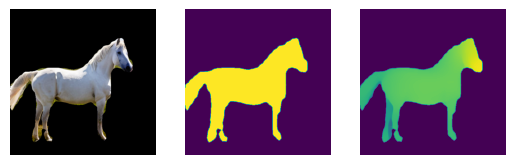

 40%|████████████████████████████▏                                         | 242/600 [00:02<00:03, 114.97it/s]

tensor(0.2966, device='cuda:0') tensor(0.5287, device='cuda:0')
tensor(0.2483, device='cuda:0') tensor(0.5292, device='cuda:0')
tensor(0.2431, device='cuda:0') tensor(0.5294, device='cuda:0')
tensor(0.2430, device='cuda:0') tensor(0.5298, device='cuda:0')
tensor(0.2431, device='cuda:0') tensor(0.5303, device='cuda:0')
tensor(0.2431, device='cuda:0') tensor(0.5303, device='cuda:0')
tensor(0.2430, device='cuda:0') tensor(0.5303, device='cuda:0')
tensor(0.2429, device='cuda:0') tensor(0.5302, device='cuda:0')
tensor(0.2430, device='cuda:0') tensor(0.5300, device='cuda:0')
tensor(0.2429, device='cuda:0') tensor(0.5299, device='cuda:0')
tensor(0.2428, device='cuda:0') tensor(0.5300, device='cuda:0')
tensor(0.2428, device='cuda:0') tensor(0.5298, device='cuda:0')
tensor(0.2427, device='cuda:0') tensor(0.5296, device='cuda:0')
tensor(0.2428, device='cuda:0') tensor(0.5294, device='cuda:0')
tensor(0.2427, device='cuda:0') tensor(0.5290, device='cuda:0')
tensor(0.2427, device='cuda:0') tensor(0

 44%|███████████████████████████████▏                                      | 267/600 [00:02<00:02, 117.36it/s]

tensor(0.2456, device='cuda:0') tensor(0.5379, device='cuda:0')
tensor(0.2460, device='cuda:0') tensor(0.5432, device='cuda:0')
tensor(0.2466, device='cuda:0') tensor(0.5493, device='cuda:0')
tensor(0.2471, device='cuda:0') tensor(0.5581, device='cuda:0')
tensor(0.2476, device='cuda:0') tensor(0.5666, device='cuda:0')
tensor(0.2482, device='cuda:0') tensor(0.5768, device='cuda:0')
tensor(0.2485, device='cuda:0') tensor(0.5975, device='cuda:0')
tensor(0.2487, device='cuda:0') tensor(0.5989, device='cuda:0')
tensor(0.2492, device='cuda:0') tensor(0.5988, device='cuda:0')
tensor(0.2496, device='cuda:0') tensor(0.5986, device='cuda:0')
tensor(0.2500, device='cuda:0') tensor(0.5982, device='cuda:0')
tensor(0.2505, device='cuda:0') tensor(0.5979, device='cuda:0')
tensor(0.2513, device='cuda:0') tensor(0.5972, device='cuda:0')
tensor(0.2520, device='cuda:0') tensor(0.5931, device='cuda:0')
tensor(0.2525, device='cuda:0') tensor(0.5856, device='cuda:0')
tensor(0.2530, device='cuda:0') tensor(0

 48%|█████████████████████████████████▉                                    | 291/600 [00:02<00:02, 117.29it/s]

tensor(0.2573, device='cuda:0') tensor(0.4533, device='cuda:0')
tensor(0.2576, device='cuda:0') tensor(0.4532, device='cuda:0')
tensor(0.2580, device='cuda:0') tensor(0.4531, device='cuda:0')
tensor(0.2583, device='cuda:0') tensor(0.4531, device='cuda:0')
tensor(0.2583, device='cuda:0') tensor(0.4531, device='cuda:0')
tensor(0.2586, device='cuda:0') tensor(0.4530, device='cuda:0')
tensor(0.2586, device='cuda:0') tensor(0.4530, device='cuda:0')
tensor(0.2587, device='cuda:0') tensor(0.4529, device='cuda:0')
tensor(0.2587, device='cuda:0') tensor(0.4528, device='cuda:0')
tensor(0.2587, device='cuda:0') tensor(0.4527, device='cuda:0')
tensor(0.2587, device='cuda:0') tensor(0.4526, device='cuda:0')
tensor(0.2586, device='cuda:0') tensor(0.4526, device='cuda:0')
tensor(0.2583, device='cuda:0') tensor(0.4525, device='cuda:0')
tensor(0.2581, device='cuda:0') tensor(0.4525, device='cuda:0')
tensor(0.2580, device='cuda:0') tensor(0.4524, device='cuda:0')
tensor(0.2577, device='cuda:0') tensor(0

 52%|████████████████████████████████████▊                                 | 315/600 [00:02<00:02, 117.06it/s]

tensor(0.2562, device='cuda:0') tensor(0.4519, device='cuda:0')
tensor(0.2561, device='cuda:0') tensor(0.4518, device='cuda:0')
tensor(0.2559, device='cuda:0') tensor(0.4518, device='cuda:0')
tensor(0.2555, device='cuda:0') tensor(0.4517, device='cuda:0')
tensor(0.2555, device='cuda:0') tensor(0.4517, device='cuda:0')
tensor(0.2553, device='cuda:0') tensor(0.4517, device='cuda:0')
tensor(0.2553, device='cuda:0') tensor(0.4518, device='cuda:0')
tensor(0.2551, device='cuda:0') tensor(0.4518, device='cuda:0')
tensor(0.2551, device='cuda:0') tensor(0.4518, device='cuda:0')
tensor(0.2551, device='cuda:0') tensor(0.4517, device='cuda:0')
tensor(0.2550, device='cuda:0') tensor(0.4518, device='cuda:0')
tensor(0.2548, device='cuda:0') tensor(0.4517, device='cuda:0')
tensor(0.2548, device='cuda:0') tensor(0.4516, device='cuda:0')
tensor(0.2547, device='cuda:0') tensor(0.4516, device='cuda:0')
tensor(0.2546, device='cuda:0') tensor(0.4516, device='cuda:0')
tensor(0.2545, device='cuda:0') tensor(0

 56%|███████████████████████████████████████▌                              | 339/600 [00:02<00:02, 118.05it/s]

tensor(0.2552, device='cuda:0') tensor(0.4517, device='cuda:0')
tensor(0.2553, device='cuda:0') tensor(0.4516, device='cuda:0')
tensor(0.2554, device='cuda:0') tensor(0.4515, device='cuda:0')
tensor(0.2553, device='cuda:0') tensor(0.4517, device='cuda:0')
tensor(0.2551, device='cuda:0') tensor(0.4516, device='cuda:0')
tensor(0.2550, device='cuda:0') tensor(0.4515, device='cuda:0')
tensor(0.2547, device='cuda:0') tensor(0.4516, device='cuda:0')
tensor(0.2543, device='cuda:0') tensor(0.4517, device='cuda:0')
tensor(0.2539, device='cuda:0') tensor(0.4516, device='cuda:0')
tensor(0.2534, device='cuda:0') tensor(0.4516, device='cuda:0')
tensor(0.2530, device='cuda:0') tensor(0.4516, device='cuda:0')
tensor(0.2525, device='cuda:0') tensor(0.4517, device='cuda:0')
tensor(0.2519, device='cuda:0') tensor(0.4539, device='cuda:0')
tensor(0.2515, device='cuda:0') tensor(0.5111, device='cuda:0')
tensor(0.2511, device='cuda:0') tensor(0.5493, device='cuda:0')
tensor(0.2508, device='cuda:0') tensor(0

 61%|██████████████████████████████████████████▍                           | 364/600 [00:03<00:01, 118.63it/s]

tensor(0.2470, device='cuda:0') tensor(0.6743, device='cuda:0')
tensor(0.2467, device='cuda:0') tensor(0.6745, device='cuda:0')
tensor(0.2464, device='cuda:0') tensor(0.6746, device='cuda:0')
tensor(0.2461, device='cuda:0') tensor(0.6732, device='cuda:0')
tensor(0.2458, device='cuda:0') tensor(0.6568, device='cuda:0')
tensor(0.2456, device='cuda:0') tensor(0.6413, device='cuda:0')
tensor(0.2453, device='cuda:0') tensor(0.6285, device='cuda:0')
tensor(0.2449, device='cuda:0') tensor(0.6132, device='cuda:0')
tensor(0.2446, device='cuda:0') tensor(0.6029, device='cuda:0')
tensor(0.2444, device='cuda:0') tensor(0.5941, device='cuda:0')
tensor(0.2441, device='cuda:0') tensor(0.5880, device='cuda:0')
tensor(0.2438, device='cuda:0') tensor(0.5838, device='cuda:0')
tensor(0.2434, device='cuda:0') tensor(0.5824, device='cuda:0')
tensor(0.2433, device='cuda:0') tensor(0.5819, device='cuda:0')
tensor(0.2430, device='cuda:0') tensor(0.5816, device='cuda:0')
tensor(0.2430, device='cuda:0') tensor(0

 65%|█████████████████████████████████████████████▎                        | 388/600 [00:03<00:01, 116.32it/s]

tensor(0.2420, device='cuda:0') tensor(0.5838, device='cuda:0')
tensor(0.2419, device='cuda:0') tensor(0.5837, device='cuda:0')
tensor(0.2417, device='cuda:0') tensor(0.5836, device='cuda:0')
tensor(0.2416, device='cuda:0') tensor(0.5831, device='cuda:0')
tensor(0.2417, device='cuda:0') tensor(0.5831, device='cuda:0')
tensor(0.2415, device='cuda:0') tensor(0.5830, device='cuda:0')
tensor(0.2414, device='cuda:0') tensor(0.5827, device='cuda:0')
tensor(0.2414, device='cuda:0') tensor(0.5824, device='cuda:0')
tensor(0.2564, device='cuda:0') tensor(0.5822, device='cuda:0')


100%|██████████████████████████████████████████████████████████████████████| 600/600 [00:05<00:00, 114.27it/s]


/grogu/user/akirchme/art3d_sd_webui/images/horse/510.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/510.mp4


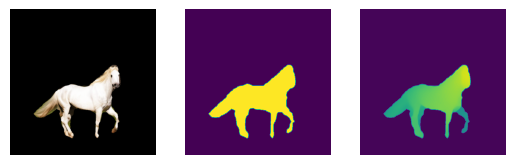

 39%|███████████████████████████▍                                          | 235/600 [00:01<00:02, 125.39it/s]

tensor(0.3313, device='cuda:0') tensor(0.5088, device='cuda:0')
tensor(0.3312, device='cuda:0') tensor(0.4913, device='cuda:0')
tensor(0.3312, device='cuda:0') tensor(0.4840, device='cuda:0')
tensor(0.3308, device='cuda:0') tensor(0.4828, device='cuda:0')
tensor(0.3282, device='cuda:0') tensor(0.4831, device='cuda:0')
tensor(0.3205, device='cuda:0') tensor(0.4833, device='cuda:0')
tensor(0.3131, device='cuda:0') tensor(0.4835, device='cuda:0')
tensor(0.2967, device='cuda:0') tensor(0.4838, device='cuda:0')
tensor(0.2532, device='cuda:0') tensor(0.4844, device='cuda:0')
tensor(0.2053, device='cuda:0') tensor(0.4850, device='cuda:0')
tensor(0.1696, device='cuda:0') tensor(0.4856, device='cuda:0')
tensor(0.1686, device='cuda:0') tensor(0.4860, device='cuda:0')
tensor(0.1685, device='cuda:0') tensor(0.4862, device='cuda:0')
tensor(0.1683, device='cuda:0') tensor(0.4867, device='cuda:0')
tensor(0.1682, device='cuda:0') tensor(0.4868, device='cuda:0')
tensor(0.1684, device='cuda:0') tensor(0

 44%|██████████████████████████████▍                                       | 261/600 [00:02<00:02, 120.57it/s]

tensor(0.1692, device='cuda:0') tensor(0.4870, device='cuda:0')
tensor(0.1693, device='cuda:0') tensor(0.4866, device='cuda:0')
tensor(0.1695, device='cuda:0') tensor(0.4867, device='cuda:0')
tensor(0.1697, device='cuda:0') tensor(0.4863, device='cuda:0')
tensor(0.1700, device='cuda:0') tensor(0.4866, device='cuda:0')
tensor(0.1705, device='cuda:0') tensor(0.4864, device='cuda:0')
tensor(0.1709, device='cuda:0') tensor(0.4864, device='cuda:0')
tensor(0.1713, device='cuda:0') tensor(0.4873, device='cuda:0')
tensor(0.1714, device='cuda:0') tensor(0.4905, device='cuda:0')
tensor(0.1718, device='cuda:0') tensor(0.4976, device='cuda:0')
tensor(0.1722, device='cuda:0') tensor(0.5020, device='cuda:0')
tensor(0.1723, device='cuda:0') tensor(0.5068, device='cuda:0')
tensor(0.1726, device='cuda:0') tensor(0.5176, device='cuda:0')
tensor(0.1729, device='cuda:0') tensor(0.5393, device='cuda:0')
tensor(0.1732, device='cuda:0') tensor(0.5574, device='cuda:0')
tensor(0.1735, device='cuda:0') tensor(0

 46%|███████████████████████████████▉                                      | 274/600 [00:02<00:02, 118.55it/s]

tensor(0.1834, device='cuda:0') tensor(0.5498, device='cuda:0')
tensor(0.1854, device='cuda:0') tensor(0.5406, device='cuda:0')
tensor(0.1871, device='cuda:0') tensor(0.5196, device='cuda:0')
tensor(0.1893, device='cuda:0') tensor(0.4826, device='cuda:0')
tensor(0.1910, device='cuda:0') tensor(0.4513, device='cuda:0')
tensor(0.1926, device='cuda:0') tensor(0.4221, device='cuda:0')
tensor(0.1943, device='cuda:0') tensor(0.4064, device='cuda:0')
tensor(0.1956, device='cuda:0') tensor(0.4060, device='cuda:0')
tensor(0.1971, device='cuda:0') tensor(0.4060, device='cuda:0')
tensor(0.1979, device='cuda:0') tensor(0.4057, device='cuda:0')
tensor(0.1986, device='cuda:0') tensor(0.4055, device='cuda:0')
tensor(0.1990, device='cuda:0') tensor(0.4054, device='cuda:0')
tensor(0.1995, device='cuda:0') tensor(0.4050, device='cuda:0')
tensor(0.1995, device='cuda:0') tensor(0.4048, device='cuda:0')
tensor(0.1992, device='cuda:0') tensor(0.4047, device='cuda:0')
tensor(0.1988, device='cuda:0') tensor(0

 50%|██████████████████████████████████▉                                   | 299/600 [00:02<00:02, 119.27it/s]

tensor(0.1844, device='cuda:0') tensor(0.4041, device='cuda:0')
tensor(0.1826, device='cuda:0') tensor(0.4041, device='cuda:0')
tensor(0.1808, device='cuda:0') tensor(0.4040, device='cuda:0')
tensor(0.1799, device='cuda:0') tensor(0.4040, device='cuda:0')
tensor(0.1796, device='cuda:0') tensor(0.4040, device='cuda:0')
tensor(0.1794, device='cuda:0') tensor(0.4040, device='cuda:0')
tensor(0.1796, device='cuda:0') tensor(0.4039, device='cuda:0')
tensor(0.1794, device='cuda:0') tensor(0.4037, device='cuda:0')
tensor(0.1793, device='cuda:0') tensor(0.4037, device='cuda:0')
tensor(0.1794, device='cuda:0') tensor(0.4038, device='cuda:0')
tensor(0.1793, device='cuda:0') tensor(0.4038, device='cuda:0')
tensor(0.1792, device='cuda:0') tensor(0.4036, device='cuda:0')
tensor(0.1792, device='cuda:0') tensor(0.4033, device='cuda:0')
tensor(0.1791, device='cuda:0') tensor(0.4034, device='cuda:0')
tensor(0.1790, device='cuda:0') tensor(0.4032, device='cuda:0')
tensor(0.1790, device='cuda:0') tensor(0

 54%|█████████████████████████████████████▋                                | 323/600 [00:02<00:02, 118.91it/s]

tensor(0.4024, device='cuda:0')
tensor(0.1778, device='cuda:0') tensor(0.4023, device='cuda:0')
tensor(0.1779, device='cuda:0') tensor(0.4023, device='cuda:0')
tensor(0.1780, device='cuda:0') tensor(0.4023, device='cuda:0')
tensor(0.1781, device='cuda:0') tensor(0.4022, device='cuda:0')
tensor(0.1782, device='cuda:0') tensor(0.4021, device='cuda:0')
tensor(0.1781, device='cuda:0') tensor(0.4020, device='cuda:0')
tensor(0.1784, device='cuda:0') tensor(0.4020, device='cuda:0')
tensor(0.1788, device='cuda:0') tensor(0.4019, device='cuda:0')
tensor(0.1788, device='cuda:0') tensor(0.4018, device='cuda:0')
tensor(0.1786, device='cuda:0') tensor(0.4017, device='cuda:0')
tensor(0.1784, device='cuda:0') tensor(0.4015, device='cuda:0')
tensor(0.1782, device='cuda:0') tensor(0.4014, device='cuda:0')
tensor(0.1781, device='cuda:0') tensor(0.4012, device='cuda:0')
tensor(0.1781, device='cuda:0') tensor(0.4011, device='cuda:0')
tensor(0.1779, device='cuda:0') tensor(0.4008, device='cuda:0')
tensor(0

 58%|████████████████████████████████████████▍                             | 347/600 [00:02<00:02, 118.52it/s]

tensor(0.1750, device='cuda:0') tensor(0.4081, device='cuda:0')
tensor(0.1746, device='cuda:0') tensor(0.4318, device='cuda:0')
tensor(0.1739, device='cuda:0') tensor(0.4593, device='cuda:0')
tensor(0.1734, device='cuda:0') tensor(0.4919, device='cuda:0')
tensor(0.1730, device='cuda:0') tensor(0.5282, device='cuda:0')
tensor(0.1723, device='cuda:0') tensor(0.5636, device='cuda:0')
tensor(0.1719, device='cuda:0') tensor(0.5978, device='cuda:0')
tensor(0.1715, device='cuda:0') tensor(0.6375, device='cuda:0')
tensor(0.1708, device='cuda:0') tensor(0.6575, device='cuda:0')
tensor(0.1704, device='cuda:0') tensor(0.6593, device='cuda:0')
tensor(0.1700, device='cuda:0') tensor(0.6601, device='cuda:0')
tensor(0.1699, device='cuda:0') tensor(0.6605, device='cuda:0')
tensor(0.1698, device='cuda:0') tensor(0.6607, device='cuda:0')
tensor(0.1696, device='cuda:0') tensor(0.6608, device='cuda:0')
tensor(0.1696, device='cuda:0') tensor(0.6590, device='cuda:0')
tensor(0.1692, device='cuda:0') tensor(0

 62%|███████████████████████████████████████████▎                          | 371/600 [00:02<00:01, 118.66it/s]

tensor(0.1677, device='cuda:0') tensor(0.5599, device='cuda:0')
tensor(0.1677, device='cuda:0') tensor(0.5597, device='cuda:0')
tensor(0.1676, device='cuda:0') tensor(0.5600, device='cuda:0')
tensor(0.1675, device='cuda:0') tensor(0.5604, device='cuda:0')
tensor(0.1678, device='cuda:0') tensor(0.5602, device='cuda:0')
tensor(0.1677, device='cuda:0') tensor(0.5599, device='cuda:0')
tensor(0.1676, device='cuda:0') tensor(0.5597, device='cuda:0')
tensor(0.1676, device='cuda:0') tensor(0.5607, device='cuda:0')
tensor(0.1676, device='cuda:0') tensor(0.5608, device='cuda:0')
tensor(0.1678, device='cuda:0') tensor(0.5612, device='cuda:0')
tensor(0.1677, device='cuda:0') tensor(0.5611, device='cuda:0')
tensor(0.1680, device='cuda:0') tensor(0.5608, device='cuda:0')
tensor(0.1680, device='cuda:0') tensor(0.5602, device='cuda:0')
tensor(0.1679, device='cuda:0') tensor(0.5598, device='cuda:0')
tensor(0.1681, device='cuda:0') tensor(0.5593, device='cuda:0')
tensor(0.1683, device='cuda:0') tensor(0

100%|██████████████████████████████████████████████████████████████████████| 600/600 [00:04<00:00, 127.32it/s]


/grogu/user/akirchme/art3d_sd_webui/images/horse/962.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/962.mp4


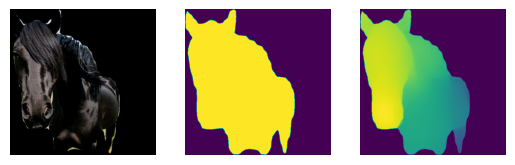

  4%|██▋                                                                    | 23/600 [00:00<00:05, 114.85it/s]

tensor(0.1941, device='cuda:0') tensor(0.4436, device='cuda:0')
tensor(0.1942, device='cuda:0') tensor(0.4436, device='cuda:0')
tensor(0.1943, device='cuda:0') tensor(0.4436, device='cuda:0')
tensor(0.1942, device='cuda:0') tensor(0.4437, device='cuda:0')
tensor(0.1942, device='cuda:0') tensor(0.4437, device='cuda:0')
tensor(0.1941, device='cuda:0') tensor(0.4439, device='cuda:0')
tensor(0.1941, device='cuda:0') tensor(0.4439, device='cuda:0')
tensor(0.1938, device='cuda:0') tensor(0.4440, device='cuda:0')
tensor(0.1937, device='cuda:0') tensor(0.4442, device='cuda:0')
tensor(0.1934, device='cuda:0') tensor(0.4443, device='cuda:0')
tensor(0.1931, device='cuda:0') tensor(0.4444, device='cuda:0')
tensor(0.1929, device='cuda:0') tensor(0.4444, device='cuda:0')
tensor(0.1926, device='cuda:0') tensor(0.4444, device='cuda:0')
tensor(0.1921, device='cuda:0') tensor(0.4445, device='cuda:0')
tensor(0.1918, device='cuda:0') tensor(0.4445, device='cuda:0')
tensor(0.1914, device='cuda:0') tensor(0

  8%|█████▌                                                                 | 47/600 [00:00<00:04, 117.70it/s]

tensor(0.1901, device='cuda:0') tensor(0.4446, device='cuda:0')
tensor(0.1893, device='cuda:0') tensor(0.4445, device='cuda:0')
tensor(0.1883, device='cuda:0') tensor(0.4446, device='cuda:0')
tensor(0.1870, device='cuda:0') tensor(0.4447, device='cuda:0')
tensor(0.1856, device='cuda:0') tensor(0.4447, device='cuda:0')
tensor(0.1841, device='cuda:0') tensor(0.4449, device='cuda:0')
tensor(0.1823, device='cuda:0') tensor(0.4452, device='cuda:0')
tensor(0.1807, device='cuda:0') tensor(0.4454, device='cuda:0')
tensor(0.1788, device='cuda:0') tensor(0.4536, device='cuda:0')
tensor(0.1771, device='cuda:0') tensor(0.4654, device='cuda:0')
tensor(0.1758, device='cuda:0') tensor(0.4857, device='cuda:0')
tensor(0.1747, device='cuda:0') tensor(0.5055, device='cuda:0')
tensor(0.1737, device='cuda:0') tensor(0.5209, device='cuda:0')
tensor(0.1727, device='cuda:0') tensor(0.5358, device='cuda:0')
tensor(0.1718, device='cuda:0') tensor(0.5539, device='cuda:0')
tensor(0.1710, device='cuda:0') tensor(0

 12%|████████▌                                                              | 72/600 [00:00<00:04, 120.39it/s]

tensor(0.1651, device='cuda:0') tensor(0.5845, device='cuda:0')
tensor(0.1647, device='cuda:0') tensor(0.5664, device='cuda:0')
tensor(0.1643, device='cuda:0') tensor(0.5531, device='cuda:0')
tensor(0.1640, device='cuda:0') tensor(0.5414, device='cuda:0')
tensor(0.1637, device='cuda:0') tensor(0.5226, device='cuda:0')
tensor(0.1633, device='cuda:0') tensor(0.5065, device='cuda:0')
tensor(0.1630, device='cuda:0') tensor(0.4935, device='cuda:0')
tensor(0.1629, device='cuda:0') tensor(0.4902, device='cuda:0')
tensor(0.1627, device='cuda:0') tensor(0.4911, device='cuda:0')
tensor(0.1624, device='cuda:0') tensor(0.4923, device='cuda:0')
tensor(0.1624, device='cuda:0') tensor(0.4943, device='cuda:0')
tensor(0.1624, device='cuda:0') tensor(0.4971, device='cuda:0')
tensor(0.1625, device='cuda:0') tensor(0.4996, device='cuda:0')
tensor(0.1627, device='cuda:0') tensor(0.5014, device='cuda:0')
tensor(0.1628, device='cuda:0') tensor(0.5032, device='cuda:0')
tensor(0.1628, device='cuda:0') tensor(0

 14%|██████████                                                             | 85/600 [00:00<00:04, 120.98it/s]

tensor(0.1654, device='cuda:0') tensor(0.5112, device='cuda:0')
tensor(0.1657, device='cuda:0') tensor(0.5096, device='cuda:0')
tensor(0.1671, device='cuda:0') tensor(0.5080, device='cuda:0')
tensor(0.1823, device='cuda:0') tensor(0.5067, device='cuda:0')
tensor(0.2097, device='cuda:0') tensor(0.5053, device='cuda:0')
tensor(0.2349, device='cuda:0') tensor(0.5038, device='cuda:0')
tensor(0.2560, device='cuda:0') tensor(0.5022, device='cuda:0')
tensor(0.2814, device='cuda:0') tensor(0.5006, device='cuda:0')
tensor(0.3078, device='cuda:0') tensor(0.4999, device='cuda:0')
tensor(0.3227, device='cuda:0') tensor(0.4990, device='cuda:0')
tensor(0.3247, device='cuda:0') tensor(0.5014, device='cuda:0')
tensor(0.3257, device='cuda:0') tensor(0.5101, device='cuda:0')


 90%|████████████████████████████████████████████████████████████████▎      | 543/600 [00:07<00:00, 92.94it/s]

tensor(0.2952, device='cuda:0') tensor(0.5674, device='cuda:0')
tensor(0.2621, device='cuda:0') tensor(0.5680, device='cuda:0')
tensor(0.2309, device='cuda:0') tensor(0.5692, device='cuda:0')
tensor(0.2025, device='cuda:0') tensor(0.5702, device='cuda:0')
tensor(0.1835, device='cuda:0') tensor(0.5715, device='cuda:0')
tensor(0.1657, device='cuda:0') tensor(0.5727, device='cuda:0')
tensor(0.1638, device='cuda:0') tensor(0.5754, device='cuda:0')
tensor(0.1635, device='cuda:0') tensor(0.5778, device='cuda:0')
tensor(0.1633, device='cuda:0') tensor(0.5795, device='cuda:0')
tensor(0.1630, device='cuda:0') tensor(0.5805, device='cuda:0')
tensor(0.1625, device='cuda:0') tensor(0.5815, device='cuda:0')
tensor(0.1619, device='cuda:0') tensor(0.5819, device='cuda:0')
tensor(0.1615, device='cuda:0') tensor(0.5822, device='cuda:0')
tensor(0.1610, device='cuda:0') tensor(0.5819, device='cuda:0')
tensor(0.1608, device='cuda:0') tensor(0.5812, device='cuda:0')
tensor(0.1609, device='cuda:0') tensor(0

 94%|██████████████████████████████████████████████████████████████████▏   | 567/600 [00:07<00:00, 105.44it/s]

tensor(0.1610, device='cuda:0') tensor(0.5574, device='cuda:0')
tensor(0.1614, device='cuda:0') tensor(0.5565, device='cuda:0')
tensor(0.1617, device='cuda:0') tensor(0.5630, device='cuda:0')
tensor(0.1621, device='cuda:0') tensor(0.5734, device='cuda:0')
tensor(0.1624, device='cuda:0') tensor(0.5838, device='cuda:0')
tensor(0.1625, device='cuda:0') tensor(0.5912, device='cuda:0')
tensor(0.1628, device='cuda:0') tensor(0.6044, device='cuda:0')
tensor(0.1633, device='cuda:0') tensor(0.6115, device='cuda:0')
tensor(0.1639, device='cuda:0') tensor(0.6149, device='cuda:0')
tensor(0.1642, device='cuda:0') tensor(0.6203, device='cuda:0')
tensor(0.1648, device='cuda:0') tensor(0.6201, device='cuda:0')
tensor(0.1651, device='cuda:0') tensor(0.6200, device='cuda:0')
tensor(0.1656, device='cuda:0') tensor(0.6200, device='cuda:0')
tensor(0.1665, device='cuda:0') tensor(0.6201, device='cuda:0')
tensor(0.1679, device='cuda:0') tensor(0.6197, device='cuda:0')
tensor(0.1697, device='cuda:0') tensor(0

 98%|████████████████████████████████████████████████████████████████████▉ | 591/600 [00:07<00:00, 111.72it/s]

tensor(0.1893, device='cuda:0') tensor(0.4457, device='cuda:0')
tensor(0.1910, device='cuda:0') tensor(0.4455, device='cuda:0')
tensor(0.1929, device='cuda:0') tensor(0.4453, device='cuda:0')
tensor(0.1945, device='cuda:0') tensor(0.4452, device='cuda:0')
tensor(0.1959, device='cuda:0') tensor(0.4450, device='cuda:0')
tensor(0.1972, device='cuda:0') tensor(0.4449, device='cuda:0')
tensor(0.1981, device='cuda:0') tensor(0.4448, device='cuda:0')
tensor(0.1989, device='cuda:0') tensor(0.4447, device='cuda:0')
tensor(0.1992, device='cuda:0') tensor(0.4448, device='cuda:0')
tensor(0.1994, device='cuda:0') tensor(0.4447, device='cuda:0')
tensor(0.1993, device='cuda:0') tensor(0.4446, device='cuda:0')
tensor(0.1990, device='cuda:0') tensor(0.4446, device='cuda:0')
tensor(0.1986, device='cuda:0') tensor(0.4446, device='cuda:0')
tensor(0.1981, device='cuda:0') tensor(0.4446, device='cuda:0')
tensor(0.1975, device='cuda:0') tensor(0.4444, device='cuda:0')
tensor(0.1970, device='cuda:0') tensor(0

100%|███████████████████████████████████████████████████████████████████████| 600/600 [00:07<00:00, 79.99it/s]


tensor(0.1922, device='cuda:0') tensor(0.4434, device='cuda:0')
tensor(0.1926, device='cuda:0') tensor(0.4434, device='cuda:0')
tensor(0.1929, device='cuda:0') tensor(0.4434, device='cuda:0')
tensor(0.1931, device='cuda:0') tensor(0.4434, device='cuda:0')
tensor(0.1934, device='cuda:0') tensor(0.4434, device='cuda:0')
tensor(0.1936, device='cuda:0') tensor(0.4434, device='cuda:0')
tensor(0.1938, device='cuda:0') tensor(0.4435, device='cuda:0')
tensor(0.1940, device='cuda:0') tensor(0.4435, device='cuda:0')
/grogu/user/akirchme/art3d_sd_webui/images/horse/85.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/85.mp4


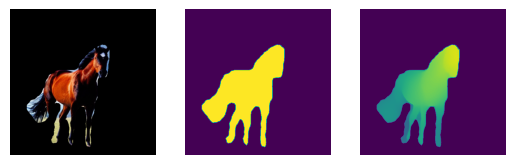

 39%|███████████████████████████▍                                          | 235/600 [00:01<00:03, 120.95it/s]

tensor(0.2923, device='cuda:0') tensor(0.5953, device='cuda:0')
tensor(0.2730, device='cuda:0') tensor(0.5968, device='cuda:0')
tensor(0.2627, device='cuda:0') tensor(0.5981, device='cuda:0')
tensor(0.2619, device='cuda:0') tensor(0.5995, device='cuda:0')
tensor(0.2614, device='cuda:0') tensor(0.6010, device='cuda:0')
tensor(0.2609, device='cuda:0') tensor(0.6023, device='cuda:0')
tensor(0.2602, device='cuda:0') tensor(0.6030, device='cuda:0')
tensor(0.2597, device='cuda:0') tensor(0.6034, device='cuda:0')
tensor(0.2591, device='cuda:0') tensor(0.6034, device='cuda:0')
tensor(0.2586, device='cuda:0') tensor(0.6025, device='cuda:0')
tensor(0.2583, device='cuda:0') tensor(0.6014, device='cuda:0')
tensor(0.2579, device='cuda:0') tensor(0.5997, device='cuda:0')
tensor(0.2576, device='cuda:0') tensor(0.5983, device='cuda:0')
tensor(0.2578, device='cuda:0') tensor(0.5967, device='cuda:0')
tensor(0.2578, device='cuda:0') tensor(0.5953, device='cuda:0')
tensor(0.2581, device='cuda:0') tensor(0

 44%|██████████████████████████████▍                                       | 261/600 [00:02<00:02, 121.77it/s]

tensor(0.2623, device='cuda:0') tensor(0.5980, device='cuda:0')
tensor(0.2628, device='cuda:0') tensor(0.6060, device='cuda:0')
tensor(0.2633, device='cuda:0') tensor(0.6143, device='cuda:0')
tensor(0.2638, device='cuda:0') tensor(0.6180, device='cuda:0')
tensor(0.2644, device='cuda:0') tensor(0.6223, device='cuda:0')
tensor(0.2650, device='cuda:0') tensor(0.6282, device='cuda:0')
tensor(0.2657, device='cuda:0') tensor(0.6293, device='cuda:0')
tensor(0.2665, device='cuda:0') tensor(0.6290, device='cuda:0')
tensor(0.2673, device='cuda:0') tensor(0.6283, device='cuda:0')
tensor(0.2683, device='cuda:0') tensor(0.6276, device='cuda:0')
tensor(0.2693, device='cuda:0') tensor(0.6271, device='cuda:0')
tensor(0.2703, device='cuda:0') tensor(0.6266, device='cuda:0')
tensor(0.2715, device='cuda:0') tensor(0.6215, device='cuda:0')
tensor(0.2732, device='cuda:0') tensor(0.6035, device='cuda:0')
tensor(0.2753, device='cuda:0') tensor(0.5822, device='cuda:0')
tensor(0.2773, device='cuda:0') tensor(0

 48%|█████████████████████████████████▍                                    | 287/600 [00:02<00:02, 120.74it/s]

tensor(0.2964, device='cuda:0') tensor(0.4780, device='cuda:0')
tensor(0.2976, device='cuda:0') tensor(0.4777, device='cuda:0')
tensor(0.2984, device='cuda:0') tensor(0.4774, device='cuda:0')
tensor(0.2989, device='cuda:0') tensor(0.4773, device='cuda:0')
tensor(0.2990, device='cuda:0') tensor(0.4772, device='cuda:0')
tensor(0.2991, device='cuda:0') tensor(0.4771, device='cuda:0')
tensor(0.2988, device='cuda:0') tensor(0.4769, device='cuda:0')
tensor(0.2986, device='cuda:0') tensor(0.4770, device='cuda:0')
tensor(0.2978, device='cuda:0') tensor(0.4770, device='cuda:0')
tensor(0.2972, device='cuda:0') tensor(0.4769, device='cuda:0')
tensor(0.2964, device='cuda:0') tensor(0.4768, device='cuda:0')
tensor(0.2954, device='cuda:0') tensor(0.4768, device='cuda:0')
tensor(0.2945, device='cuda:0') tensor(0.4768, device='cuda:0')
tensor(0.2934, device='cuda:0') tensor(0.4766, device='cuda:0')
tensor(0.2922, device='cuda:0') tensor(0.4766, device='cuda:0')
tensor(0.2909, device='cuda:0') tensor(0

 52%|████████████████████████████████████▌                                 | 313/600 [00:02<00:02, 119.64it/s]

tensor(0.2876, device='cuda:0') tensor(0.4764, device='cuda:0')
tensor(0.2870, device='cuda:0') tensor(0.4764, device='cuda:0')
tensor(0.2867, device='cuda:0') tensor(0.4764, device='cuda:0')
tensor(0.2864, device='cuda:0') tensor(0.4763, device='cuda:0')
tensor(0.2862, device='cuda:0') tensor(0.4762, device='cuda:0')
tensor(0.2858, device='cuda:0') tensor(0.4762, device='cuda:0')
tensor(0.2858, device='cuda:0') tensor(0.4762, device='cuda:0')
tensor(0.2856, device='cuda:0') tensor(0.4760, device='cuda:0')
tensor(0.2852, device='cuda:0') tensor(0.4761, device='cuda:0')
tensor(0.2849, device='cuda:0') tensor(0.4762, device='cuda:0')
tensor(0.2846, device='cuda:0') tensor(0.4762, device='cuda:0')
tensor(0.2840, device='cuda:0') tensor(0.4764, device='cuda:0')
tensor(0.2837, device='cuda:0') tensor(0.4764, device='cuda:0')
tensor(0.2833, device='cuda:0') tensor(0.4765, device='cuda:0')
tensor(0.2830, device='cuda:0') tensor(0.4766, device='cuda:0')
tensor(0.2827, device='cuda:0') tensor(0

 56%|███████████████████████████████████████▌                              | 339/600 [00:02<00:02, 120.66it/s]

tensor(0.2829, device='cuda:0') tensor(0.4784, device='cuda:0')
tensor(0.2828, device='cuda:0') tensor(0.4785, device='cuda:0')
tensor(0.2826, device='cuda:0') tensor(0.4785, device='cuda:0')
tensor(0.2820, device='cuda:0') tensor(0.4785, device='cuda:0')
tensor(0.2815, device='cuda:0') tensor(0.4785, device='cuda:0')
tensor(0.2811, device='cuda:0') tensor(0.4786, device='cuda:0')
tensor(0.2804, device='cuda:0') tensor(0.4788, device='cuda:0')
tensor(0.2795, device='cuda:0') tensor(0.4788, device='cuda:0')
tensor(0.2786, device='cuda:0') tensor(0.4791, device='cuda:0')
tensor(0.2774, device='cuda:0') tensor(0.4794, device='cuda:0')
tensor(0.2762, device='cuda:0') tensor(0.4796, device='cuda:0')
tensor(0.2751, device='cuda:0') tensor(0.4795, device='cuda:0')
tensor(0.2739, device='cuda:0') tensor(0.4796, device='cuda:0')
tensor(0.2724, device='cuda:0') tensor(0.4829, device='cuda:0')
tensor(0.2709, device='cuda:0') tensor(0.4872, device='cuda:0')
tensor(0.2697, device='cuda:0') tensor(0

 61%|██████████████████████████████████████████▌                           | 365/600 [00:02<00:01, 119.56it/s]

tensor(0.2600, device='cuda:0') tensor(0.5511, device='cuda:0')
tensor(0.2595, device='cuda:0') tensor(0.5520, device='cuda:0')
tensor(0.2592, device='cuda:0') tensor(0.5524, device='cuda:0')
tensor(0.2591, device='cuda:0') tensor(0.5499, device='cuda:0')
tensor(0.2588, device='cuda:0') tensor(0.5484, device='cuda:0')
tensor(0.2586, device='cuda:0') tensor(0.5451, device='cuda:0')
tensor(0.2582, device='cuda:0') tensor(0.5397, device='cuda:0')
tensor(0.2582, device='cuda:0') tensor(0.5351, device='cuda:0')
tensor(0.2582, device='cuda:0') tensor(0.5259, device='cuda:0')
tensor(0.2578, device='cuda:0') tensor(0.5132, device='cuda:0')
tensor(0.2575, device='cuda:0') tensor(0.5017, device='cuda:0')
tensor(0.2573, device='cuda:0') tensor(0.4998, device='cuda:0')
tensor(0.2573, device='cuda:0') tensor(0.4992, device='cuda:0')
tensor(0.2572, device='cuda:0') tensor(0.4990, device='cuda:0')
tensor(0.2572, device='cuda:0') tensor(0.4994, device='cuda:0')
tensor(0.2571, device='cuda:0') tensor(0

 65%|█████████████████████████████████████████████▍                        | 389/600 [00:03<00:01, 118.79it/s]

tensor(0.2592, device='cuda:0') tensor(0.5076, device='cuda:0')
tensor(0.2598, device='cuda:0') tensor(0.5075, device='cuda:0')
tensor(0.2606, device='cuda:0') tensor(0.5073, device='cuda:0')
tensor(0.2611, device='cuda:0') tensor(0.5069, device='cuda:0')
tensor(0.2613, device='cuda:0') tensor(0.5069, device='cuda:0')
tensor(0.2617, device='cuda:0') tensor(0.5067, device='cuda:0')
tensor(0.2621, device='cuda:0') tensor(0.5060, device='cuda:0')
tensor(0.2625, device='cuda:0') tensor(0.5049, device='cuda:0')
tensor(0.2689, device='cuda:0') tensor(0.5044, device='cuda:0')
tensor(0.2747, device='cuda:0') tensor(0.5039, device='cuda:0')
tensor(0.2852, device='cuda:0') tensor(0.5033, device='cuda:0')
tensor(0.2972, device='cuda:0') tensor(0.5029, device='cuda:0')
tensor(0.3121, device='cuda:0') tensor(0.5024, device='cuda:0')
tensor(0.3282, device='cuda:0') tensor(0.5013, device='cuda:0')
tensor(0.3342, device='cuda:0') tensor(0.5006, device='cuda:0')
tensor(0.3354, device='cuda:0') tensor(0

100%|██████████████████████████████████████████████████████████████████████| 600/600 [00:04<00:00, 124.35it/s]


/grogu/user/akirchme/art3d_sd_webui/images/horse/1632.png
/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos/video_mask/horse/1632.mp4


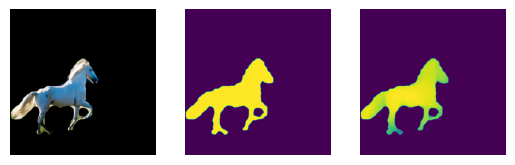

  2%|█▍                                                                     | 12/600 [00:00<00:05, 115.73it/s]

tensor(0.2954, device='cuda:0') tensor(0.4698, device='cuda:0')
tensor(0.2953, device='cuda:0') tensor(0.4699, device='cuda:0')
tensor(0.2951, device='cuda:0') tensor(0.4698, device='cuda:0')
tensor(0.2955, device='cuda:0') tensor(0.4697, device='cuda:0')
tensor(0.2958, device='cuda:0') tensor(0.4695, device='cuda:0')
tensor(0.2962, device='cuda:0') tensor(0.4694, device='cuda:0')
tensor(0.2962, device='cuda:0') tensor(0.4696, device='cuda:0')
tensor(0.2960, device='cuda:0') tensor(0.4696, device='cuda:0')
tensor(0.2963, device='cuda:0') tensor(0.4695, device='cuda:0')
tensor(0.2963, device='cuda:0') tensor(0.4695, device='cuda:0')
tensor(0.2963, device='cuda:0') tensor(0.4695, device='cuda:0')
tensor(0.2963, device='cuda:0') tensor(0.4696, device='cuda:0')
tensor(0.2964, device='cuda:0') tensor(0.4697, device='cuda:0')
tensor(0.2963, device='cuda:0') tensor(0.4697, device='cuda:0')
tensor(0.2964, device='cuda:0') tensor(0.4695, device='cuda:0')
tensor(0.2966, device='cuda:0') tensor(0

  4%|██▊                                                                    | 24/600 [00:00<00:04, 116.84it/s]

tensor(0.2990, device='cuda:0') tensor(0.4685, device='cuda:0')
tensor(0.3002, device='cuda:0') tensor(0.4685, device='cuda:0')
tensor(0.3010, device='cuda:0') tensor(0.4686, device='cuda:0')
tensor(0.3017, device='cuda:0') tensor(0.4686, device='cuda:0')
tensor(0.3019, device='cuda:0') tensor(0.4685, device='cuda:0')
tensor(0.3013, device='cuda:0') tensor(0.4689, device='cuda:0')
tensor(0.3010, device='cuda:0') tensor(0.4687, device='cuda:0')
tensor(0.2999, device='cuda:0') tensor(0.4688, device='cuda:0')
tensor(0.2987, device='cuda:0') tensor(0.4685, device='cuda:0')
tensor(0.2970, device='cuda:0') tensor(0.4771, device='cuda:0')


KeyboardInterrupt: 

In [14]:
'''
Paths
'''
# Set paths
data_path, cls = '/home/akirchme/art3d/art3d-multiviewdepthdiffusion/videos', 'horse'
image_data_path = '/grogu/user/akirchme/art3d_sd_webui/images'
video_data_path = f'{data_path}/video' if not do_mask else f'{data_path}/video_mask'
os.makedirs(f'{video_data_path}/{cls}', exist_ok=True)
for image in [f for f in os.listdir(f'{image_data_path}/{cls}')]:
    image = image.split('.')[0]
    output_fn = f'{video_data_path}/{cls}/{image}.mp4'
    image_fn = f'{image_data_path}/{cls}/{image}.png'

    print(image_fn)
    print(output_fn)
    pointcloud = generate_video(image_fn, output_fn)